In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ConvNeXtTiny)

2024-02-21 13:55:12.377124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 13:55:12.377223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 13:55:12.509323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ConvNeXtTiny(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ConvNeXtTiny"+s+".keras")
    

    # save model to disk
    filename = "ConvNeXtTiny" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 convnext_tiny (Functional)  (None, 4)                 27823204  


Total params: 27823204 (106.14 MB)


Trainable params: 27823204 (106.14 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708523755.099718      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 1:27:04 - loss: 3.6908 - accuracy: 0.0000e+00

  2/140 [..............................] - ETA: 42s - loss: 5.2049 - accuracy: 0.1719        

  3/140 [..............................] - ETA: 41s - loss: 6.4080 - accuracy: 0.2292

  4/140 [..............................] - ETA: 41s - loss: 5.4769 - accuracy: 0.3125

  5/140 [>.............................] - ETA: 41s - loss: 4.7453 - accuracy: 0.3313

  6/140 [>.............................] - ETA: 40s - loss: 4.3744 - accuracy: 0.3698

  7/140 [>.............................] - ETA: 40s - loss: 4.1265 - accuracy: 0.3884

  8/140 [>.............................] - ETA: 40s - loss: 3.9251 - accuracy: 0.3828

  9/140 [>.............................] - ETA: 39s - loss: 3.5893 - accuracy: 0.4028

 10/140 [=>............................] - ETA: 39s - loss: 3.3457 - accuracy: 0.4187

 11/140 [=>............................] - ETA: 39s - loss: 3.1893 - accuracy: 0.4176

 12/140 [=>............................] - ETA: 38s - loss: 3.2781 - accuracy: 0.4036

 13/140 [=>............................] - ETA: 38s - loss: 3.1307 - accuracy: 0.4014

 14/140 [==>...........................] - ETA: 38s - loss: 2.9963 - accuracy: 0.4018

 15/140 [==>...........................] - ETA: 38s - loss: 2.9434 - accuracy: 0.4104

 16/140 [==>...........................] - ETA: 37s - loss: 2.8278 - accuracy: 0.4199

 17/140 [==>...........................] - ETA: 37s - loss: 2.8145 - accuracy: 0.4246

 18/140 [==>...........................] - ETA: 37s - loss: 2.7039 - accuracy: 0.4392

 19/140 [===>..........................] - ETA: 36s - loss: 2.6403 - accuracy: 0.4375

 20/140 [===>..........................] - ETA: 36s - loss: 2.6324 - accuracy: 0.4422

 21/140 [===>..........................] - ETA: 36s - loss: 2.5719 - accuracy: 0.4420

 22/140 [===>..........................] - ETA: 35s - loss: 2.5167 - accuracy: 0.4418

 23/140 [===>..........................] - ETA: 35s - loss: 2.4580 - accuracy: 0.4402

 24/140 [====>.........................] - ETA: 35s - loss: 2.3982 - accuracy: 0.4388

 25/140 [====>.........................] - ETA: 34s - loss: 2.3528 - accuracy: 0.4325

 26/140 [====>.........................] - ETA: 34s - loss: 2.3468 - accuracy: 0.4375

 27/140 [====>.........................] - ETA: 34s - loss: 2.2990 - accuracy: 0.4375

 28/140 [=====>........................] - ETA: 34s - loss: 2.2530 - accuracy: 0.4353

 29/140 [=====>........................] - ETA: 33s - loss: 2.2036 - accuracy: 0.4386

 30/140 [=====>........................] - ETA: 33s - loss: 2.1578 - accuracy: 0.4458

 31/140 [=====>........................] - ETA: 33s - loss: 2.1126 - accuracy: 0.4516

 32/140 [=====>........................] - ETA: 32s - loss: 2.0857 - accuracy: 0.4512

 33/140 [======>.......................] - ETA: 32s - loss: 2.0506 - accuracy: 0.4583

 34/140 [======>.......................] - ETA: 32s - loss: 2.0565 - accuracy: 0.4550

 35/140 [======>.......................] - ETA: 31s - loss: 2.0592 - accuracy: 0.4536

 36/140 [======>.......................] - ETA: 31s - loss: 2.0309 - accuracy: 0.4575

 37/140 [======>.......................] - ETA: 31s - loss: 2.0207 - accuracy: 0.4544

 38/140 [=======>......................] - ETA: 30s - loss: 1.9959 - accuracy: 0.4564

 39/140 [=======>......................] - ETA: 30s - loss: 1.9986 - accuracy: 0.4567

 40/140 [=======>......................] - ETA: 30s - loss: 1.9729 - accuracy: 0.4563

 41/140 [=======>......................] - ETA: 30s - loss: 1.9519 - accuracy: 0.4550

 42/140 [========>.....................] - ETA: 29s - loss: 1.9306 - accuracy: 0.4554

 43/140 [========>.....................] - ETA: 29s - loss: 1.9080 - accuracy: 0.4549

 44/140 [========>.....................] - ETA: 29s - loss: 1.8869 - accuracy: 0.4567

 45/140 [========>.....................] - ETA: 28s - loss: 1.8874 - accuracy: 0.4590

 46/140 [========>.....................] - ETA: 28s - loss: 1.9117 - accuracy: 0.4599

 47/140 [=========>....................] - ETA: 28s - loss: 1.9098 - accuracy: 0.4628

 48/140 [=========>....................] - ETA: 27s - loss: 1.8883 - accuracy: 0.4674

 49/140 [=========>....................] - ETA: 27s - loss: 1.8696 - accuracy: 0.4707

 50/140 [=========>....................] - ETA: 27s - loss: 1.8488 - accuracy: 0.4731

 51/140 [=========>....................] - ETA: 27s - loss: 1.8337 - accuracy: 0.4755

 52/140 [==========>...................] - ETA: 26s - loss: 1.8128 - accuracy: 0.4778

 53/140 [==========>...................] - ETA: 26s - loss: 1.7915 - accuracy: 0.4835

 54/140 [==========>...................] - ETA: 26s - loss: 1.7760 - accuracy: 0.4821

 55/140 [==========>...................] - ETA: 25s - loss: 1.7605 - accuracy: 0.4830

 56/140 [===========>..................] - ETA: 25s - loss: 1.7429 - accuracy: 0.4849

 57/140 [===========>..................] - ETA: 25s - loss: 1.7267 - accuracy: 0.4879

 58/140 [===========>..................] - ETA: 24s - loss: 1.7128 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 24s - loss: 1.7151 - accuracy: 0.4905

 60/140 [===========>..................] - ETA: 24s - loss: 1.7193 - accuracy: 0.4891

 61/140 [============>.................] - ETA: 23s - loss: 1.7075 - accuracy: 0.4898

 62/140 [============>.................] - ETA: 23s - loss: 1.6954 - accuracy: 0.4909

 63/140 [============>.................] - ETA: 23s - loss: 1.6953 - accuracy: 0.4916

 64/140 [============>.................] - ETA: 23s - loss: 1.6834 - accuracy: 0.4922

 65/140 [============>.................] - ETA: 22s - loss: 1.6982 - accuracy: 0.4938

 66/140 [=============>................] - ETA: 22s - loss: 1.6972 - accuracy: 0.4938

 67/140 [=============>................] - ETA: 22s - loss: 1.6883 - accuracy: 0.4944

 68/140 [=============>................] - ETA: 21s - loss: 1.7087 - accuracy: 0.4931

 69/140 [=============>................] - ETA: 21s - loss: 1.6976 - accuracy: 0.4937

 70/140 [==============>...............] - ETA: 21s - loss: 1.6865 - accuracy: 0.4938

 71/140 [==============>...............] - ETA: 20s - loss: 1.6753 - accuracy: 0.4934

 72/140 [==============>...............] - ETA: 20s - loss: 1.6737 - accuracy: 0.4952

 73/140 [==============>...............] - ETA: 20s - loss: 1.6627 - accuracy: 0.4944

 74/140 [==============>...............] - ETA: 20s - loss: 1.6525 - accuracy: 0.4954

 75/140 [===============>..............] - ETA: 19s - loss: 1.6428 - accuracy: 0.4950

 76/140 [===============>..............] - ETA: 19s - loss: 1.6334 - accuracy: 0.4934

 77/140 [===============>..............] - ETA: 19s - loss: 1.6210 - accuracy: 0.4963

 78/140 [===============>..............] - ETA: 18s - loss: 1.6105 - accuracy: 0.4976

 79/140 [===============>..............] - ETA: 18s - loss: 1.6134 - accuracy: 0.4953

 80/140 [================>.............] - ETA: 18s - loss: 1.6027 - accuracy: 0.4965

 81/140 [================>.............] - ETA: 17s - loss: 1.5923 - accuracy: 0.4977

 82/140 [================>.............] - ETA: 17s - loss: 1.5830 - accuracy: 0.4992

 83/140 [================>.............] - ETA: 17s - loss: 1.5757 - accuracy: 0.4996

 84/140 [=================>............] - ETA: 17s - loss: 1.5736 - accuracy: 0.4981

 85/140 [=================>............] - ETA: 16s - loss: 1.5669 - accuracy: 0.4974

 86/140 [=================>............] - ETA: 16s - loss: 1.5583 - accuracy: 0.4993

 87/140 [=================>............] - ETA: 16s - loss: 1.5540 - accuracy: 0.5000

 88/140 [=================>............] - ETA: 15s - loss: 1.5499 - accuracy: 0.5000

 89/140 [==================>...........] - ETA: 15s - loss: 1.5465 - accuracy: 0.5007

 90/140 [==================>...........] - ETA: 15s - loss: 1.5415 - accuracy: 0.5010

 91/140 [==================>...........] - ETA: 14s - loss: 1.5345 - accuracy: 0.5010

 92/140 [==================>...........] - ETA: 14s - loss: 1.5270 - accuracy: 0.5024

 93/140 [==================>...........] - ETA: 14s - loss: 1.5198 - accuracy: 0.5040

 94/140 [===================>..........] - ETA: 13s - loss: 1.5132 - accuracy: 0.5047

 95/140 [===================>..........] - ETA: 13s - loss: 1.5082 - accuracy: 0.5046

 96/140 [===================>..........] - ETA: 13s - loss: 1.5007 - accuracy: 0.5059

 97/140 [===================>..........] - ETA: 13s - loss: 1.4953 - accuracy: 0.5061

 98/140 [====================>.........] - ETA: 12s - loss: 1.4915 - accuracy: 0.5045

 99/140 [====================>.........] - ETA: 12s - loss: 1.4834 - accuracy: 0.5066

100/140 [====================>.........] - ETA: 12s - loss: 1.4801 - accuracy: 0.5056

101/140 [====================>.........] - ETA: 11s - loss: 1.4747 - accuracy: 0.5056

102/140 [====================>.........] - ETA: 11s - loss: 1.4687 - accuracy: 0.5058

103/140 [=====================>........] - ETA: 11s - loss: 1.4629 - accuracy: 0.5061

104/140 [=====================>........] - ETA: 10s - loss: 1.4584 - accuracy: 0.5072

105/140 [=====================>........] - ETA: 10s - loss: 1.4539 - accuracy: 0.5077

106/140 [=====================>........] - ETA: 10s - loss: 1.4485 - accuracy: 0.5083

107/140 [=====================>........] - ETA: 10s - loss: 1.4430 - accuracy: 0.5085

108/140 [======================>.......] - ETA: 9s - loss: 1.4386 - accuracy: 0.5084 

109/140 [======================>.......] - ETA: 9s - loss: 1.4358 - accuracy: 0.5086

110/140 [======================>.......] - ETA: 9s - loss: 1.4314 - accuracy: 0.5085

111/140 [======================>.......] - ETA: 8s - loss: 1.4268 - accuracy: 0.5087

112/140 [=======================>......] - ETA: 8s - loss: 1.4222 - accuracy: 0.5089

113/140 [=======================>......] - ETA: 8s - loss: 1.4166 - accuracy: 0.5094

114/140 [=======================>......] - ETA: 7s - loss: 1.4124 - accuracy: 0.5090

115/140 [=======================>......] - ETA: 7s - loss: 1.4081 - accuracy: 0.5084

116/140 [=======================>......] - ETA: 7s - loss: 1.4033 - accuracy: 0.5081

117/140 [========================>.....] - ETA: 6s - loss: 1.4007 - accuracy: 0.5085

118/140 [========================>.....] - ETA: 6s - loss: 1.3960 - accuracy: 0.5095

119/140 [========================>.....] - ETA: 6s - loss: 1.3918 - accuracy: 0.5097

120/140 [========================>.....] - ETA: 6s - loss: 1.3891 - accuracy: 0.5091

121/140 [========================>.....] - ETA: 5s - loss: 1.3848 - accuracy: 0.5088

122/140 [=========================>....] - ETA: 5s - loss: 1.3806 - accuracy: 0.5087

123/140 [=========================>....] - ETA: 5s - loss: 1.3763 - accuracy: 0.5094

124/140 [=========================>....] - ETA: 4s - loss: 1.3730 - accuracy: 0.5096

125/140 [=========================>....] - ETA: 4s - loss: 1.3691 - accuracy: 0.5090

126/140 [==========================>...] - ETA: 4s - loss: 1.3638 - accuracy: 0.5104

127/140 [==========================>...] - ETA: 3s - loss: 1.3608 - accuracy: 0.5108

128/140 [==========================>...] - ETA: 3s - loss: 1.3572 - accuracy: 0.5120

129/140 [==========================>...] - ETA: 3s - loss: 1.3529 - accuracy: 0.5128

130/140 [==========================>...] - ETA: 3s - loss: 1.3501 - accuracy: 0.5137

131/140 [===========================>..] - ETA: 2s - loss: 1.3470 - accuracy: 0.5134

132/140 [===========================>..] - ETA: 2s - loss: 1.3448 - accuracy: 0.5133

133/140 [===========================>..] - ETA: 2s - loss: 1.3404 - accuracy: 0.5139

134/140 [===========================>..] - ETA: 1s - loss: 1.3360 - accuracy: 0.5140

135/140 [===========================>..] - ETA: 1s - loss: 1.3322 - accuracy: 0.5139

136/140 [============================>.] - ETA: 1s - loss: 1.3302 - accuracy: 0.5129

137/140 [============================>.] - ETA: 0s - loss: 1.3259 - accuracy: 0.5137

138/140 [============================>.] - ETA: 0s - loss: 1.3230 - accuracy: 0.5138

139/140 [============================>.] - ETA: 0s - loss: 1.3207 - accuracy: 0.5137

140/140 [==============================] - ETA: 0s - loss: 1.3198 - accuracy: 0.5137

140/140 [==============================] - 93s 400ms/step - loss: 1.3198 - accuracy: 0.5137 - val_loss: 0.9552 - val_accuracy: 0.5285


Epoch 2/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.8991 - accuracy: 0.5938

  2/140 [..............................] - ETA: 41s - loss: 0.8952 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 41s - loss: 0.8417 - accuracy: 0.5938

  4/140 [..............................] - ETA: 41s - loss: 0.8492 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 40s - loss: 0.8896 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 40s - loss: 0.9574 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 40s - loss: 0.9543 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 40s - loss: 0.9282 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 39s - loss: 0.9253 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 39s - loss: 0.9340 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 39s - loss: 0.9299 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 38s - loss: 0.9212 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 38s - loss: 0.9293 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 38s - loss: 0.9320 - accuracy: 0.5045

 15/140 [==>...........................] - ETA: 37s - loss: 0.9201 - accuracy: 0.5104

 16/140 [==>...........................] - ETA: 37s - loss: 0.9176 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 37s - loss: 0.9170 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 37s - loss: 0.9172 - accuracy: 0.5035

 19/140 [===>..........................] - ETA: 36s - loss: 0.9257 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 36s - loss: 0.9227 - accuracy: 0.5063

 21/140 [===>..........................] - ETA: 36s - loss: 0.9210 - accuracy: 0.5119

 22/140 [===>..........................] - ETA: 35s - loss: 0.9128 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 35s - loss: 0.9086 - accuracy: 0.5204

 24/140 [====>.........................] - ETA: 35s - loss: 0.9058 - accuracy: 0.5169

 25/140 [====>.........................] - ETA: 34s - loss: 0.9076 - accuracy: 0.5163

 26/140 [====>.........................] - ETA: 34s - loss: 0.9080 - accuracy: 0.5144

 27/140 [====>.........................] - ETA: 34s - loss: 0.9047 - accuracy: 0.5150

 28/140 [=====>........................] - ETA: 34s - loss: 0.9043 - accuracy: 0.5156

 29/140 [=====>........................] - ETA: 33s - loss: 0.9040 - accuracy: 0.5140

 30/140 [=====>........................] - ETA: 33s - loss: 0.9037 - accuracy: 0.5167

 31/140 [=====>........................] - ETA: 33s - loss: 0.9083 - accuracy: 0.5141

 32/140 [=====>........................] - ETA: 32s - loss: 0.9071 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 32s - loss: 0.9032 - accuracy: 0.5208

 34/140 [======>.......................] - ETA: 32s - loss: 0.9083 - accuracy: 0.5193

 35/140 [======>.......................] - ETA: 31s - loss: 0.9063 - accuracy: 0.5223

 36/140 [======>.......................] - ETA: 31s - loss: 0.9058 - accuracy: 0.5165

 37/140 [======>.......................] - ETA: 31s - loss: 0.9043 - accuracy: 0.5186

 38/140 [=======>......................] - ETA: 30s - loss: 0.9032 - accuracy: 0.5197

 39/140 [=======>......................] - ETA: 30s - loss: 0.9050 - accuracy: 0.5192

 40/140 [=======>......................] - ETA: 30s - loss: 0.9024 - accuracy: 0.5219

 41/140 [=======>......................] - ETA: 30s - loss: 0.8985 - accuracy: 0.5236

 42/140 [========>.....................] - ETA: 29s - loss: 0.9007 - accuracy: 0.5246

 43/140 [========>.....................] - ETA: 29s - loss: 0.9000 - accuracy: 0.5269

 44/140 [========>.....................] - ETA: 29s - loss: 0.8940 - accuracy: 0.5334

 45/140 [========>.....................] - ETA: 28s - loss: 0.8986 - accuracy: 0.5340

 46/140 [========>.....................] - ETA: 28s - loss: 0.8968 - accuracy: 0.5326

 47/140 [=========>....................] - ETA: 28s - loss: 0.8972 - accuracy: 0.5366

 48/140 [=========>....................] - ETA: 27s - loss: 0.8985 - accuracy: 0.5365

 49/140 [=========>....................] - ETA: 27s - loss: 0.8975 - accuracy: 0.5376

 50/140 [=========>....................] - ETA: 27s - loss: 0.8948 - accuracy: 0.5406

 51/140 [=========>....................] - ETA: 27s - loss: 0.8961 - accuracy: 0.5380

 52/140 [==========>...................] - ETA: 26s - loss: 0.8970 - accuracy: 0.5367

 53/140 [==========>...................] - ETA: 26s - loss: 0.8944 - accuracy: 0.5371

 54/140 [==========>...................] - ETA: 26s - loss: 0.8939 - accuracy: 0.5365

 55/140 [==========>...................] - ETA: 25s - loss: 0.8937 - accuracy: 0.5364

 56/140 [===========>..................] - ETA: 25s - loss: 0.8940 - accuracy: 0.5368

 57/140 [===========>..................] - ETA: 25s - loss: 0.8958 - accuracy: 0.5362

 58/140 [===========>..................] - ETA: 24s - loss: 0.8935 - accuracy: 0.5366

 59/140 [===========>..................] - ETA: 24s - loss: 0.8945 - accuracy: 0.5365

 60/140 [===========>..................] - ETA: 24s - loss: 0.8922 - accuracy: 0.5370

 61/140 [============>.................] - ETA: 24s - loss: 0.8925 - accuracy: 0.5374

 62/140 [============>.................] - ETA: 23s - loss: 0.8909 - accuracy: 0.5373

 63/140 [============>.................] - ETA: 23s - loss: 0.8949 - accuracy: 0.5362

 64/140 [============>.................] - ETA: 23s - loss: 0.8931 - accuracy: 0.5356

 65/140 [============>.................] - ETA: 22s - loss: 0.8979 - accuracy: 0.5341

 66/140 [=============>................] - ETA: 22s - loss: 0.9015 - accuracy: 0.5341

 67/140 [=============>................] - ETA: 22s - loss: 0.9030 - accuracy: 0.5340

 68/140 [=============>................] - ETA: 21s - loss: 0.9027 - accuracy: 0.5331

 69/140 [=============>................] - ETA: 21s - loss: 0.9028 - accuracy: 0.5331

 70/140 [==============>...............] - ETA: 21s - loss: 0.9032 - accuracy: 0.5317

 71/140 [==============>...............] - ETA: 20s - loss: 0.9028 - accuracy: 0.5330

 72/140 [==============>...............] - ETA: 20s - loss: 0.9011 - accuracy: 0.5347

 73/140 [==============>...............] - ETA: 20s - loss: 0.9010 - accuracy: 0.5364

 74/140 [==============>...............] - ETA: 20s - loss: 0.9021 - accuracy: 0.5367

 75/140 [===============>..............] - ETA: 19s - loss: 0.9067 - accuracy: 0.5337

 76/140 [===============>..............] - ETA: 19s - loss: 0.9064 - accuracy: 0.5337

 77/140 [===============>..............] - ETA: 19s - loss: 0.9053 - accuracy: 0.5349

 78/140 [===============>..............] - ETA: 18s - loss: 0.9046 - accuracy: 0.5353

 79/140 [===============>..............] - ETA: 18s - loss: 0.9039 - accuracy: 0.5352

 80/140 [================>.............] - ETA: 18s - loss: 0.9038 - accuracy: 0.5355

 81/140 [================>.............] - ETA: 17s - loss: 0.9028 - accuracy: 0.5367

 82/140 [================>.............] - ETA: 17s - loss: 0.8995 - accuracy: 0.5381

 83/140 [================>.............] - ETA: 17s - loss: 0.8983 - accuracy: 0.5388

 84/140 [=================>............] - ETA: 17s - loss: 0.8982 - accuracy: 0.5391

 85/140 [=================>............] - ETA: 16s - loss: 0.8991 - accuracy: 0.5379

 86/140 [=================>............] - ETA: 16s - loss: 0.8986 - accuracy: 0.5396

 87/140 [=================>............] - ETA: 16s - loss: 0.8991 - accuracy: 0.5399

 88/140 [=================>............] - ETA: 15s - loss: 0.8979 - accuracy: 0.5419

 89/140 [==================>...........] - ETA: 15s - loss: 0.9011 - accuracy: 0.5414

 90/140 [==================>...........] - ETA: 15s - loss: 0.9001 - accuracy: 0.5427

 91/140 [==================>...........] - ETA: 14s - loss: 0.8999 - accuracy: 0.5422

 92/140 [==================>...........] - ETA: 14s - loss: 0.8992 - accuracy: 0.5431

 93/140 [==================>...........] - ETA: 14s - loss: 0.8994 - accuracy: 0.5430

 94/140 [===================>..........] - ETA: 13s - loss: 0.9007 - accuracy: 0.5429

 95/140 [===================>..........] - ETA: 13s - loss: 0.9017 - accuracy: 0.5421

 96/140 [===================>..........] - ETA: 13s - loss: 0.8997 - accuracy: 0.5439

 97/140 [===================>..........] - ETA: 13s - loss: 0.9002 - accuracy: 0.5428

 98/140 [====================>.........] - ETA: 12s - loss: 0.9003 - accuracy: 0.5424

 99/140 [====================>.........] - ETA: 12s - loss: 0.9017 - accuracy: 0.5414

100/140 [====================>.........] - ETA: 12s - loss: 0.9014 - accuracy: 0.5416

101/140 [====================>.........] - ETA: 11s - loss: 0.9020 - accuracy: 0.5418

102/140 [====================>.........] - ETA: 11s - loss: 0.9018 - accuracy: 0.5417

103/140 [=====================>........] - ETA: 11s - loss: 0.9021 - accuracy: 0.5413

104/140 [=====================>........] - ETA: 10s - loss: 0.9010 - accuracy: 0.5424

105/140 [=====================>........] - ETA: 10s - loss: 0.9007 - accuracy: 0.5429

106/140 [=====================>........] - ETA: 10s - loss: 0.8997 - accuracy: 0.5425

107/140 [=====================>........] - ETA: 10s - loss: 0.8991 - accuracy: 0.5429

108/140 [======================>.......] - ETA: 9s - loss: 0.8984 - accuracy: 0.5428 

109/140 [======================>.......] - ETA: 9s - loss: 0.9000 - accuracy: 0.5433

110/140 [======================>.......] - ETA: 9s - loss: 0.9001 - accuracy: 0.5437

111/140 [======================>.......] - ETA: 8s - loss: 0.9035 - accuracy: 0.5417

112/140 [=======================>......] - ETA: 8s - loss: 0.9034 - accuracy: 0.5419

113/140 [=======================>......] - ETA: 8s - loss: 0.9033 - accuracy: 0.5415

114/140 [=======================>......] - ETA: 7s - loss: 0.9038 - accuracy: 0.5425

115/140 [=======================>......] - ETA: 7s - loss: 0.9044 - accuracy: 0.5418

116/140 [=======================>......] - ETA: 7s - loss: 0.9042 - accuracy: 0.5412

117/140 [========================>.....] - ETA: 6s - loss: 0.9054 - accuracy: 0.5414

118/140 [========================>.....] - ETA: 6s - loss: 0.9044 - accuracy: 0.5416

119/140 [========================>.....] - ETA: 6s - loss: 0.9046 - accuracy: 0.5410

120/140 [========================>.....] - ETA: 6s - loss: 0.9046 - accuracy: 0.5398

121/140 [========================>.....] - ETA: 5s - loss: 0.9041 - accuracy: 0.5408

122/140 [=========================>....] - ETA: 5s - loss: 0.9057 - accuracy: 0.5402

123/140 [=========================>....] - ETA: 5s - loss: 0.9049 - accuracy: 0.5407

124/140 [=========================>....] - ETA: 4s - loss: 0.9052 - accuracy: 0.5408

125/140 [=========================>....] - ETA: 4s - loss: 0.9061 - accuracy: 0.5400

126/140 [==========================>...] - ETA: 4s - loss: 0.9074 - accuracy: 0.5399

127/140 [==========================>...] - ETA: 3s - loss: 0.9060 - accuracy: 0.5401

128/140 [==========================>...] - ETA: 3s - loss: 0.9061 - accuracy: 0.5400

129/140 [==========================>...] - ETA: 3s - loss: 0.9054 - accuracy: 0.5405

130/140 [==========================>...] - ETA: 3s - loss: 0.9050 - accuracy: 0.5406

131/140 [===========================>..] - ETA: 2s - loss: 0.9060 - accuracy: 0.5398

132/140 [===========================>..] - ETA: 2s - loss: 0.9058 - accuracy: 0.5405

133/140 [===========================>..] - ETA: 2s - loss: 0.9062 - accuracy: 0.5399

134/140 [===========================>..] - ETA: 1s - loss: 0.9054 - accuracy: 0.5401

135/140 [===========================>..] - ETA: 1s - loss: 0.9037 - accuracy: 0.5410

136/140 [============================>.] - ETA: 1s - loss: 0.9035 - accuracy: 0.5409

137/140 [============================>.] - ETA: 0s - loss: 0.9045 - accuracy: 0.5404

138/140 [============================>.] - ETA: 0s - loss: 0.9040 - accuracy: 0.5403

139/140 [============================>.] - ETA: 0s - loss: 0.9037 - accuracy: 0.5402

140/140 [==============================] - ETA: 0s - loss: 0.9040 - accuracy: 0.5406

140/140 [==============================] - 47s 333ms/step - loss: 0.9040 - accuracy: 0.5406 - val_loss: 0.9475 - val_accuracy: 0.5176


Epoch 3/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.8516 - accuracy: 0.6562

  2/140 [..............................] - ETA: 41s - loss: 0.8619 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 41s - loss: 0.8317 - accuracy: 0.6250

  4/140 [..............................] - ETA: 41s - loss: 0.7934 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 40s - loss: 0.7947 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 40s - loss: 0.8509 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 40s - loss: 0.8889 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 40s - loss: 0.8909 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 39s - loss: 0.8738 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 39s - loss: 0.8715 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 39s - loss: 0.8682 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 38s - loss: 0.8733 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 38s - loss: 0.8790 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 38s - loss: 0.8777 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 37s - loss: 0.8900 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 37s - loss: 0.8913 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 37s - loss: 0.8922 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 37s - loss: 0.8844 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 36s - loss: 0.8808 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 36s - loss: 0.8852 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 36s - loss: 0.8827 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 35s - loss: 0.8830 - accuracy: 0.5511

 23/140 [===>..........................] - ETA: 35s - loss: 0.8779 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 35s - loss: 0.8800 - accuracy: 0.5482

 25/140 [====>.........................] - ETA: 34s - loss: 0.8812 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 34s - loss: 0.8835 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 34s - loss: 0.8853 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 34s - loss: 0.8843 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 33s - loss: 0.8776 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 33s - loss: 0.8778 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 33s - loss: 0.8764 - accuracy: 0.5433

 32/140 [=====>........................] - ETA: 32s - loss: 0.8788 - accuracy: 0.5400

 33/140 [======>.......................] - ETA: 32s - loss: 0.8772 - accuracy: 0.5417

 34/140 [======>.......................] - ETA: 32s - loss: 0.8731 - accuracy: 0.5432

 35/140 [======>.......................] - ETA: 31s - loss: 0.8768 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 31s - loss: 0.8809 - accuracy: 0.5434

 37/140 [======>.......................] - ETA: 31s - loss: 0.8759 - accuracy: 0.5473

 38/140 [=======>......................] - ETA: 31s - loss: 0.8784 - accuracy: 0.5461

 39/140 [=======>......................] - ETA: 30s - loss: 0.8754 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 30s - loss: 0.8744 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 30s - loss: 0.8766 - accuracy: 0.5495

 42/140 [========>.....................] - ETA: 29s - loss: 0.8752 - accuracy: 0.5476

 43/140 [========>.....................] - ETA: 29s - loss: 0.8741 - accuracy: 0.5472

 44/140 [========>.....................] - ETA: 29s - loss: 0.8722 - accuracy: 0.5483

 45/140 [========>.....................] - ETA: 28s - loss: 0.8680 - accuracy: 0.5500

 46/140 [========>.....................] - ETA: 28s - loss: 0.8664 - accuracy: 0.5510

 47/140 [=========>....................] - ETA: 28s - loss: 0.8673 - accuracy: 0.5505

 48/140 [=========>....................] - ETA: 28s - loss: 0.8673 - accuracy: 0.5495

 49/140 [=========>....................] - ETA: 27s - loss: 0.8677 - accuracy: 0.5485

 50/140 [=========>....................] - ETA: 27s - loss: 0.8638 - accuracy: 0.5506

 51/140 [=========>....................] - ETA: 27s - loss: 0.8628 - accuracy: 0.5521

 52/140 [==========>...................] - ETA: 26s - loss: 0.8644 - accuracy: 0.5505

 53/140 [==========>...................] - ETA: 26s - loss: 0.8666 - accuracy: 0.5507

 54/140 [==========>...................] - ETA: 26s - loss: 0.8661 - accuracy: 0.5509

 55/140 [==========>...................] - ETA: 25s - loss: 0.8644 - accuracy: 0.5517

 56/140 [===========>..................] - ETA: 25s - loss: 0.8626 - accuracy: 0.5525

 57/140 [===========>..................] - ETA: 25s - loss: 0.8626 - accuracy: 0.5532

 58/140 [===========>..................] - ETA: 24s - loss: 0.8615 - accuracy: 0.5517

 59/140 [===========>..................] - ETA: 24s - loss: 0.8648 - accuracy: 0.5535

 60/140 [===========>..................] - ETA: 24s - loss: 0.8642 - accuracy: 0.5557

 61/140 [============>.................] - ETA: 24s - loss: 0.8633 - accuracy: 0.5569

 62/140 [============>.................] - ETA: 23s - loss: 0.8652 - accuracy: 0.5549

 63/140 [============>.................] - ETA: 23s - loss: 0.8684 - accuracy: 0.5526

 64/140 [============>.................] - ETA: 23s - loss: 0.8698 - accuracy: 0.5527

 65/140 [============>.................] - ETA: 22s - loss: 0.8682 - accuracy: 0.5548

 66/140 [=============>................] - ETA: 22s - loss: 0.8669 - accuracy: 0.5559

 67/140 [=============>................] - ETA: 22s - loss: 0.8648 - accuracy: 0.5574

 68/140 [=============>................] - ETA: 21s - loss: 0.8638 - accuracy: 0.5574

 69/140 [=============>................] - ETA: 21s - loss: 0.8616 - accuracy: 0.5598

 70/140 [==============>...............] - ETA: 21s - loss: 0.8612 - accuracy: 0.5616

 71/140 [==============>...............] - ETA: 20s - loss: 0.8601 - accuracy: 0.5629

 72/140 [==============>...............] - ETA: 20s - loss: 0.8603 - accuracy: 0.5629

 73/140 [==============>...............] - ETA: 20s - loss: 0.8574 - accuracy: 0.5634

 74/140 [==============>...............] - ETA: 20s - loss: 0.8592 - accuracy: 0.5625

 75/140 [===============>..............] - ETA: 19s - loss: 0.8569 - accuracy: 0.5633

 76/140 [===============>..............] - ETA: 19s - loss: 0.8559 - accuracy: 0.5641

 77/140 [===============>..............] - ETA: 19s - loss: 0.8578 - accuracy: 0.5637

 78/140 [===============>..............] - ETA: 18s - loss: 0.8588 - accuracy: 0.5637

 79/140 [===============>..............] - ETA: 18s - loss: 0.8580 - accuracy: 0.5633

 80/140 [================>.............] - ETA: 18s - loss: 0.8585 - accuracy: 0.5625

 81/140 [================>.............] - ETA: 17s - loss: 0.8572 - accuracy: 0.5640

 82/140 [================>.............] - ETA: 17s - loss: 0.8551 - accuracy: 0.5652

 83/140 [================>.............] - ETA: 17s - loss: 0.8525 - accuracy: 0.5678

 84/140 [=================>............] - ETA: 17s - loss: 0.8559 - accuracy: 0.5670

 85/140 [=================>............] - ETA: 16s - loss: 0.8555 - accuracy: 0.5676

 86/140 [=================>............] - ETA: 16s - loss: 0.8554 - accuracy: 0.5683

 87/140 [=================>............] - ETA: 16s - loss: 0.8565 - accuracy: 0.5682

 88/140 [=================>............] - ETA: 15s - loss: 0.8572 - accuracy: 0.5682

 89/140 [==================>...........] - ETA: 15s - loss: 0.8565 - accuracy: 0.5685

 90/140 [==================>...........] - ETA: 15s - loss: 0.8568 - accuracy: 0.5698

 91/140 [==================>...........] - ETA: 14s - loss: 0.8582 - accuracy: 0.5683

 92/140 [==================>...........] - ETA: 14s - loss: 0.8595 - accuracy: 0.5683

 93/140 [==================>...........] - ETA: 14s - loss: 0.8576 - accuracy: 0.5685

 94/140 [===================>..........] - ETA: 13s - loss: 0.8583 - accuracy: 0.5688

 95/140 [===================>..........] - ETA: 13s - loss: 0.8591 - accuracy: 0.5701

 96/140 [===================>..........] - ETA: 13s - loss: 0.8602 - accuracy: 0.5693

 97/140 [===================>..........] - ETA: 13s - loss: 0.8604 - accuracy: 0.5696

 98/140 [====================>.........] - ETA: 12s - loss: 0.8584 - accuracy: 0.5705

 99/140 [====================>.........] - ETA: 12s - loss: 0.8590 - accuracy: 0.5698

100/140 [====================>.........] - ETA: 12s - loss: 0.8585 - accuracy: 0.5697

101/140 [====================>.........] - ETA: 11s - loss: 0.8588 - accuracy: 0.5690

102/140 [====================>.........] - ETA: 11s - loss: 0.8590 - accuracy: 0.5692

103/140 [=====================>........] - ETA: 11s - loss: 0.8596 - accuracy: 0.5701

104/140 [=====================>........] - ETA: 10s - loss: 0.8592 - accuracy: 0.5697

105/140 [=====================>........] - ETA: 10s - loss: 0.8584 - accuracy: 0.5708

106/140 [=====================>........] - ETA: 10s - loss: 0.8592 - accuracy: 0.5702

107/140 [=====================>........] - ETA: 10s - loss: 0.8584 - accuracy: 0.5713

108/140 [======================>.......] - ETA: 9s - loss: 0.8587 - accuracy: 0.5718 

109/140 [======================>.......] - ETA: 9s - loss: 0.8575 - accuracy: 0.5731

110/140 [======================>.......] - ETA: 9s - loss: 0.8562 - accuracy: 0.5756

111/140 [======================>.......] - ETA: 8s - loss: 0.8560 - accuracy: 0.5757

112/140 [=======================>......] - ETA: 8s - loss: 0.8560 - accuracy: 0.5765

113/140 [=======================>......] - ETA: 8s - loss: 0.8556 - accuracy: 0.5769

114/140 [=======================>......] - ETA: 7s - loss: 0.8569 - accuracy: 0.5759

115/140 [=======================>......] - ETA: 7s - loss: 0.8571 - accuracy: 0.5755

116/140 [=======================>......] - ETA: 7s - loss: 0.8561 - accuracy: 0.5757

117/140 [========================>.....] - ETA: 6s - loss: 0.8566 - accuracy: 0.5753

118/140 [========================>.....] - ETA: 6s - loss: 0.8553 - accuracy: 0.5768

119/140 [========================>.....] - ETA: 6s - loss: 0.8552 - accuracy: 0.5772

120/140 [========================>.....] - ETA: 6s - loss: 0.8564 - accuracy: 0.5766

121/140 [========================>.....] - ETA: 5s - loss: 0.8552 - accuracy: 0.5764

122/140 [=========================>....] - ETA: 5s - loss: 0.8560 - accuracy: 0.5758

123/140 [=========================>....] - ETA: 5s - loss: 0.8567 - accuracy: 0.5755

124/140 [=========================>....] - ETA: 4s - loss: 0.8565 - accuracy: 0.5754

125/140 [=========================>....] - ETA: 4s - loss: 0.8557 - accuracy: 0.5757

126/140 [==========================>...] - ETA: 4s - loss: 0.8540 - accuracy: 0.5769

127/140 [==========================>...] - ETA: 3s - loss: 0.8528 - accuracy: 0.5782

128/140 [==========================>...] - ETA: 3s - loss: 0.8527 - accuracy: 0.5774

129/140 [==========================>...] - ETA: 3s - loss: 0.8539 - accuracy: 0.5773

130/140 [==========================>...] - ETA: 3s - loss: 0.8546 - accuracy: 0.5769

131/140 [===========================>..] - ETA: 2s - loss: 0.8537 - accuracy: 0.5773

132/140 [===========================>..] - ETA: 2s - loss: 0.8538 - accuracy: 0.5769

133/140 [===========================>..] - ETA: 2s - loss: 0.8553 - accuracy: 0.5757

134/140 [===========================>..] - ETA: 1s - loss: 0.8569 - accuracy: 0.5749

135/140 [===========================>..] - ETA: 1s - loss: 0.8579 - accuracy: 0.5741

136/140 [============================>.] - ETA: 1s - loss: 0.8575 - accuracy: 0.5740

137/140 [============================>.] - ETA: 0s - loss: 0.8558 - accuracy: 0.5744

138/140 [============================>.] - ETA: 0s - loss: 0.8561 - accuracy: 0.5736

139/140 [============================>.] - ETA: 0s - loss: 0.8571 - accuracy: 0.5726

140/140 [==============================] - ETA: 0s - loss: 0.8579 - accuracy: 0.5720

140/140 [==============================] - 47s 333ms/step - loss: 0.8579 - accuracy: 0.5720 - val_loss: 0.9178 - val_accuracy: 0.5348


Epoch 4/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.7690 - accuracy: 0.5312

  2/140 [..............................] - ETA: 42s - loss: 0.8117 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 41s - loss: 0.8563 - accuracy: 0.6146

  4/140 [..............................] - ETA: 41s - loss: 0.8627 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 40s - loss: 0.8647 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 40s - loss: 0.8404 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 40s - loss: 0.8488 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 40s - loss: 0.8350 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 39s - loss: 0.8252 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 39s - loss: 0.8503 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 39s - loss: 0.8498 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 38s - loss: 0.8584 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 38s - loss: 0.8492 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 38s - loss: 0.8487 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 37s - loss: 0.8435 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 37s - loss: 0.8329 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 37s - loss: 0.8295 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 37s - loss: 0.8240 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 36s - loss: 0.8330 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 36s - loss: 0.8354 - accuracy: 0.5953

 21/140 [===>..........................] - ETA: 36s - loss: 0.8373 - accuracy: 0.5982

 22/140 [===>..........................] - ETA: 35s - loss: 0.8331 - accuracy: 0.5980

 23/140 [===>..........................] - ETA: 35s - loss: 0.8308 - accuracy: 0.5938

 24/140 [====>.........................] - ETA: 35s - loss: 0.8346 - accuracy: 0.5924

 25/140 [====>.........................] - ETA: 34s - loss: 0.8332 - accuracy: 0.5925

 26/140 [====>.........................] - ETA: 34s - loss: 0.8266 - accuracy: 0.5974

 27/140 [====>.........................] - ETA: 34s - loss: 0.8248 - accuracy: 0.5972

 28/140 [=====>........................] - ETA: 34s - loss: 0.8262 - accuracy: 0.5971

 29/140 [=====>........................] - ETA: 33s - loss: 0.8215 - accuracy: 0.5991

 30/140 [=====>........................] - ETA: 33s - loss: 0.8279 - accuracy: 0.5948

 31/140 [=====>........................] - ETA: 33s - loss: 0.8272 - accuracy: 0.5968

 32/140 [=====>........................] - ETA: 32s - loss: 0.8296 - accuracy: 0.5928

 33/140 [======>.......................] - ETA: 32s - loss: 0.8260 - accuracy: 0.5947

 34/140 [======>.......................] - ETA: 32s - loss: 0.8270 - accuracy: 0.5928

 35/140 [======>.......................] - ETA: 31s - loss: 0.8254 - accuracy: 0.5946

 36/140 [======>.......................] - ETA: 31s - loss: 0.8251 - accuracy: 0.5964

 37/140 [======>.......................] - ETA: 31s - loss: 0.8242 - accuracy: 0.5963

 38/140 [=======>......................] - ETA: 30s - loss: 0.8274 - accuracy: 0.5938

 39/140 [=======>......................] - ETA: 30s - loss: 0.8223 - accuracy: 0.5970

 40/140 [=======>......................] - ETA: 30s - loss: 0.8215 - accuracy: 0.5961

 41/140 [=======>......................] - ETA: 30s - loss: 0.8194 - accuracy: 0.5968

 42/140 [========>.....................] - ETA: 29s - loss: 0.8156 - accuracy: 0.5990

 43/140 [========>.....................] - ETA: 29s - loss: 0.8139 - accuracy: 0.5996

 44/140 [========>.....................] - ETA: 29s - loss: 0.8096 - accuracy: 0.6030

 45/140 [========>.....................] - ETA: 28s - loss: 0.8108 - accuracy: 0.6028

 46/140 [========>.....................] - ETA: 28s - loss: 0.8160 - accuracy: 0.5999

 47/140 [=========>....................] - ETA: 28s - loss: 0.8146 - accuracy: 0.6017

 48/140 [=========>....................] - ETA: 27s - loss: 0.8179 - accuracy: 0.6003

 49/140 [=========>....................] - ETA: 27s - loss: 0.8195 - accuracy: 0.5982

 50/140 [=========>....................] - ETA: 27s - loss: 0.8217 - accuracy: 0.5962

 51/140 [=========>....................] - ETA: 27s - loss: 0.8208 - accuracy: 0.5987

 52/140 [==========>...................] - ETA: 26s - loss: 0.8182 - accuracy: 0.6004

 53/140 [==========>...................] - ETA: 26s - loss: 0.8195 - accuracy: 0.5996

 54/140 [==========>...................] - ETA: 26s - loss: 0.8188 - accuracy: 0.6013

 55/140 [==========>...................] - ETA: 25s - loss: 0.8172 - accuracy: 0.6017

 56/140 [===========>..................] - ETA: 25s - loss: 0.8154 - accuracy: 0.6021

 57/140 [===========>..................] - ETA: 25s - loss: 0.8131 - accuracy: 0.6036

 58/140 [===========>..................] - ETA: 24s - loss: 0.8098 - accuracy: 0.6061

 59/140 [===========>..................] - ETA: 24s - loss: 0.8091 - accuracy: 0.6059

 60/140 [===========>..................] - ETA: 24s - loss: 0.8081 - accuracy: 0.6073

 61/140 [============>.................] - ETA: 23s - loss: 0.8078 - accuracy: 0.6076

 62/140 [============>.................] - ETA: 23s - loss: 0.8108 - accuracy: 0.6064

 63/140 [============>.................] - ETA: 23s - loss: 0.8087 - accuracy: 0.6076

 64/140 [============>.................] - ETA: 23s - loss: 0.8087 - accuracy: 0.6084

 65/140 [============>.................] - ETA: 22s - loss: 0.8078 - accuracy: 0.6106

 66/140 [=============>................] - ETA: 22s - loss: 0.8055 - accuracy: 0.6136

 67/140 [=============>................] - ETA: 22s - loss: 0.8026 - accuracy: 0.6138

 68/140 [=============>................] - ETA: 21s - loss: 0.8075 - accuracy: 0.6144

 69/140 [=============>................] - ETA: 21s - loss: 0.8100 - accuracy: 0.6155

 70/140 [==============>...............] - ETA: 21s - loss: 0.8102 - accuracy: 0.6152

 71/140 [==============>...............] - ETA: 20s - loss: 0.8105 - accuracy: 0.6140

 72/140 [==============>...............] - ETA: 20s - loss: 0.8087 - accuracy: 0.6159

 73/140 [==============>...............] - ETA: 20s - loss: 0.8081 - accuracy: 0.6160

 74/140 [==============>...............] - ETA: 20s - loss: 0.8078 - accuracy: 0.6161

 75/140 [===============>..............] - ETA: 19s - loss: 0.8089 - accuracy: 0.6146

 76/140 [===============>..............] - ETA: 19s - loss: 0.8081 - accuracy: 0.6155

 77/140 [===============>..............] - ETA: 19s - loss: 0.8072 - accuracy: 0.6181

 78/140 [===============>..............] - ETA: 18s - loss: 0.8066 - accuracy: 0.6194

 79/140 [===============>..............] - ETA: 18s - loss: 0.8049 - accuracy: 0.6199

 80/140 [================>.............] - ETA: 18s - loss: 0.8024 - accuracy: 0.6203

 81/140 [================>.............] - ETA: 17s - loss: 0.8012 - accuracy: 0.6200

 82/140 [================>.............] - ETA: 17s - loss: 0.8021 - accuracy: 0.6204

 83/140 [================>.............] - ETA: 17s - loss: 0.8037 - accuracy: 0.6201

 84/140 [=================>............] - ETA: 17s - loss: 0.8011 - accuracy: 0.6209

 85/140 [=================>............] - ETA: 16s - loss: 0.7981 - accuracy: 0.6235

 86/140 [=================>............] - ETA: 16s - loss: 0.7950 - accuracy: 0.6254

 87/140 [=================>............] - ETA: 16s - loss: 0.7941 - accuracy: 0.6257

 88/140 [=================>............] - ETA: 15s - loss: 0.7932 - accuracy: 0.6257

 89/140 [==================>...........] - ETA: 15s - loss: 0.7938 - accuracy: 0.6250

 90/140 [==================>...........] - ETA: 15s - loss: 0.7936 - accuracy: 0.6233

 91/140 [==================>...........] - ETA: 14s - loss: 0.7936 - accuracy: 0.6229

 92/140 [==================>...........] - ETA: 14s - loss: 0.7931 - accuracy: 0.6243

 93/140 [==================>...........] - ETA: 14s - loss: 0.7939 - accuracy: 0.6253

 94/140 [===================>..........] - ETA: 13s - loss: 0.7928 - accuracy: 0.6263

 95/140 [===================>..........] - ETA: 13s - loss: 0.7935 - accuracy: 0.6266

 96/140 [===================>..........] - ETA: 13s - loss: 0.7936 - accuracy: 0.6270

 97/140 [===================>..........] - ETA: 13s - loss: 0.7918 - accuracy: 0.6282

 98/140 [====================>.........] - ETA: 12s - loss: 0.7888 - accuracy: 0.6291

 99/140 [====================>.........] - ETA: 12s - loss: 0.7884 - accuracy: 0.6294

100/140 [====================>.........] - ETA: 12s - loss: 0.7893 - accuracy: 0.6284

101/140 [====================>.........] - ETA: 11s - loss: 0.7904 - accuracy: 0.6269

102/140 [====================>.........] - ETA: 11s - loss: 0.7891 - accuracy: 0.6281

103/140 [=====================>........] - ETA: 11s - loss: 0.7898 - accuracy: 0.6286

104/140 [=====================>........] - ETA: 10s - loss: 0.7889 - accuracy: 0.6292

105/140 [=====================>........] - ETA: 10s - loss: 0.7877 - accuracy: 0.6307

106/140 [=====================>........] - ETA: 10s - loss: 0.7871 - accuracy: 0.6306

107/140 [=====================>........] - ETA: 10s - loss: 0.7855 - accuracy: 0.6320

108/140 [======================>.......] - ETA: 9s - loss: 0.7868 - accuracy: 0.6305 

109/140 [======================>.......] - ETA: 9s - loss: 0.7837 - accuracy: 0.6325

110/140 [======================>.......] - ETA: 9s - loss: 0.7849 - accuracy: 0.6315

111/140 [======================>.......] - ETA: 8s - loss: 0.7832 - accuracy: 0.6320

112/140 [=======================>......] - ETA: 8s - loss: 0.7829 - accuracy: 0.6325

113/140 [=======================>......] - ETA: 8s - loss: 0.7821 - accuracy: 0.6330

114/140 [=======================>......] - ETA: 7s - loss: 0.7821 - accuracy: 0.6327

115/140 [=======================>......] - ETA: 7s - loss: 0.7837 - accuracy: 0.6313

116/140 [=======================>......] - ETA: 7s - loss: 0.7829 - accuracy: 0.6312

117/140 [========================>.....] - ETA: 6s - loss: 0.7828 - accuracy: 0.6319

118/140 [========================>.....] - ETA: 6s - loss: 0.7841 - accuracy: 0.6311

119/140 [========================>.....] - ETA: 6s - loss: 0.7836 - accuracy: 0.6316

120/140 [========================>.....] - ETA: 6s - loss: 0.7834 - accuracy: 0.6326

121/140 [========================>.....] - ETA: 5s - loss: 0.7836 - accuracy: 0.6330

122/140 [=========================>....] - ETA: 5s - loss: 0.7832 - accuracy: 0.6332

123/140 [=========================>....] - ETA: 5s - loss: 0.7833 - accuracy: 0.6331

124/140 [=========================>....] - ETA: 4s - loss: 0.7824 - accuracy: 0.6336

125/140 [=========================>....] - ETA: 4s - loss: 0.7814 - accuracy: 0.6338

126/140 [==========================>...] - ETA: 4s - loss: 0.7819 - accuracy: 0.6329

127/140 [==========================>...] - ETA: 3s - loss: 0.7832 - accuracy: 0.6321

128/140 [==========================>...] - ETA: 3s - loss: 0.7810 - accuracy: 0.6343

129/140 [==========================>...] - ETA: 3s - loss: 0.7802 - accuracy: 0.6342

130/140 [==========================>...] - ETA: 3s - loss: 0.7805 - accuracy: 0.6339

131/140 [===========================>..] - ETA: 2s - loss: 0.7804 - accuracy: 0.6336

132/140 [===========================>..] - ETA: 2s - loss: 0.7805 - accuracy: 0.6338

133/140 [===========================>..] - ETA: 2s - loss: 0.7820 - accuracy: 0.6330

134/140 [===========================>..] - ETA: 1s - loss: 0.7817 - accuracy: 0.6327

135/140 [===========================>..] - ETA: 1s - loss: 0.7791 - accuracy: 0.6338

136/140 [============================>.] - ETA: 1s - loss: 0.7788 - accuracy: 0.6344

137/140 [============================>.] - ETA: 0s - loss: 0.7823 - accuracy: 0.6337

138/140 [============================>.] - ETA: 0s - loss: 0.7806 - accuracy: 0.6350

139/140 [============================>.] - ETA: 0s - loss: 0.7790 - accuracy: 0.6356

140/140 [==============================] - ETA: 0s - loss: 0.7788 - accuracy: 0.6358

140/140 [==============================] - 47s 333ms/step - loss: 0.7788 - accuracy: 0.6358 - val_loss: 1.0358 - val_accuracy: 0.4793


Epoch 5/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.8112 - accuracy: 0.5938

  2/140 [..............................] - ETA: 42s - loss: 0.7770 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 41s - loss: 0.7276 - accuracy: 0.6771

  4/140 [..............................] - ETA: 41s - loss: 0.7318 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 41s - loss: 0.7447 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 40s - loss: 0.6980 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 40s - loss: 0.7437 - accuracy: 0.6786

  8/140 [>.............................] - ETA: 40s - loss: 0.7328 - accuracy: 0.6875

  9/140 [>.............................] - ETA: 39s - loss: 0.7286 - accuracy: 0.6840

 10/140 [=>............................] - ETA: 39s - loss: 0.7316 - accuracy: 0.6812

 11/140 [=>............................] - ETA: 39s - loss: 0.7311 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 38s - loss: 0.7301 - accuracy: 0.6745

 13/140 [=>............................] - ETA: 38s - loss: 0.7127 - accuracy: 0.6827

 14/140 [==>...........................] - ETA: 38s - loss: 0.7102 - accuracy: 0.6808

 15/140 [==>...........................] - ETA: 38s - loss: 0.7176 - accuracy: 0.6792

 16/140 [==>...........................] - ETA: 37s - loss: 0.7114 - accuracy: 0.6797

 17/140 [==>...........................] - ETA: 37s - loss: 0.7074 - accuracy: 0.6801

 18/140 [==>...........................] - ETA: 37s - loss: 0.6895 - accuracy: 0.6910

 19/140 [===>..........................] - ETA: 36s - loss: 0.6819 - accuracy: 0.6941

 20/140 [===>..........................] - ETA: 36s - loss: 0.6808 - accuracy: 0.6906

 21/140 [===>..........................] - ETA: 36s - loss: 0.6780 - accuracy: 0.6949

 22/140 [===>..........................] - ETA: 35s - loss: 0.6763 - accuracy: 0.6974

 23/140 [===>..........................] - ETA: 35s - loss: 0.6699 - accuracy: 0.7011

 24/140 [====>.........................] - ETA: 35s - loss: 0.6695 - accuracy: 0.6966

 25/140 [====>.........................] - ETA: 34s - loss: 0.6707 - accuracy: 0.6988

 26/140 [====>.........................] - ETA: 34s - loss: 0.6670 - accuracy: 0.6971

 27/140 [====>.........................] - ETA: 34s - loss: 0.6691 - accuracy: 0.6979

 28/140 [=====>........................] - ETA: 34s - loss: 0.6737 - accuracy: 0.6942

 29/140 [=====>........................] - ETA: 33s - loss: 0.6747 - accuracy: 0.6918

 30/140 [=====>........................] - ETA: 33s - loss: 0.6677 - accuracy: 0.6979

 31/140 [=====>........................] - ETA: 33s - loss: 0.6577 - accuracy: 0.7046

 32/140 [=====>........................] - ETA: 32s - loss: 0.6578 - accuracy: 0.7031

 33/140 [======>.......................] - ETA: 32s - loss: 0.6542 - accuracy: 0.7045

 34/140 [======>.......................] - ETA: 32s - loss: 0.6570 - accuracy: 0.7013

 35/140 [======>.......................] - ETA: 31s - loss: 0.6527 - accuracy: 0.7036

 36/140 [======>.......................] - ETA: 31s - loss: 0.6583 - accuracy: 0.7031

 37/140 [======>.......................] - ETA: 31s - loss: 0.6531 - accuracy: 0.7069

 38/140 [=======>......................] - ETA: 31s - loss: 0.6526 - accuracy: 0.7056

 39/140 [=======>......................] - ETA: 30s - loss: 0.6535 - accuracy: 0.7067

 40/140 [=======>......................] - ETA: 30s - loss: 0.6536 - accuracy: 0.7047

 41/140 [=======>......................] - ETA: 30s - loss: 0.6469 - accuracy: 0.7088

 42/140 [========>.....................] - ETA: 29s - loss: 0.6422 - accuracy: 0.7098

 43/140 [========>.....................] - ETA: 29s - loss: 0.6488 - accuracy: 0.7078

 44/140 [========>.....................] - ETA: 29s - loss: 0.6519 - accuracy: 0.7067

 45/140 [========>.....................] - ETA: 28s - loss: 0.6509 - accuracy: 0.7063

 46/140 [========>.....................] - ETA: 28s - loss: 0.6522 - accuracy: 0.7065

 47/140 [=========>....................] - ETA: 28s - loss: 0.6523 - accuracy: 0.7068

 48/140 [=========>....................] - ETA: 27s - loss: 0.6532 - accuracy: 0.7070

 49/140 [=========>....................] - ETA: 27s - loss: 0.6514 - accuracy: 0.7066

 50/140 [=========>....................] - ETA: 27s - loss: 0.6507 - accuracy: 0.7088

 51/140 [=========>....................] - ETA: 27s - loss: 0.6515 - accuracy: 0.7083

 52/140 [==========>...................] - ETA: 26s - loss: 0.6525 - accuracy: 0.7085

 53/140 [==========>...................] - ETA: 26s - loss: 0.6520 - accuracy: 0.7087

 54/140 [==========>...................] - ETA: 26s - loss: 0.6515 - accuracy: 0.7066

 55/140 [==========>...................] - ETA: 25s - loss: 0.6523 - accuracy: 0.7051

 56/140 [===========>..................] - ETA: 25s - loss: 0.6543 - accuracy: 0.7042

 57/140 [===========>..................] - ETA: 25s - loss: 0.6504 - accuracy: 0.7061

 58/140 [===========>..................] - ETA: 24s - loss: 0.6519 - accuracy: 0.7064

 59/140 [===========>..................] - ETA: 24s - loss: 0.6520 - accuracy: 0.7055

 60/140 [===========>..................] - ETA: 24s - loss: 0.6481 - accuracy: 0.7078

 61/140 [============>.................] - ETA: 24s - loss: 0.6518 - accuracy: 0.7085

 62/140 [============>.................] - ETA: 23s - loss: 0.6526 - accuracy: 0.7087

 63/140 [============>.................] - ETA: 23s - loss: 0.6561 - accuracy: 0.7068

 64/140 [============>.................] - ETA: 23s - loss: 0.6548 - accuracy: 0.7080

 65/140 [============>.................] - ETA: 22s - loss: 0.6550 - accuracy: 0.7077

 66/140 [=============>................] - ETA: 22s - loss: 0.6508 - accuracy: 0.7098

 67/140 [=============>................] - ETA: 22s - loss: 0.6515 - accuracy: 0.7090

 68/140 [=============>................] - ETA: 21s - loss: 0.6499 - accuracy: 0.7086

 69/140 [=============>................] - ETA: 21s - loss: 0.6460 - accuracy: 0.7106

 70/140 [==============>...............] - ETA: 21s - loss: 0.6448 - accuracy: 0.7116

 71/140 [==============>...............] - ETA: 20s - loss: 0.6439 - accuracy: 0.7121

 72/140 [==============>...............] - ETA: 20s - loss: 0.6444 - accuracy: 0.7122

 73/140 [==============>...............] - ETA: 20s - loss: 0.6451 - accuracy: 0.7123

 74/140 [==============>...............] - ETA: 20s - loss: 0.6434 - accuracy: 0.7141

 75/140 [===============>..............] - ETA: 19s - loss: 0.6451 - accuracy: 0.7125

 76/140 [===============>..............] - ETA: 19s - loss: 0.6445 - accuracy: 0.7138

 77/140 [===============>..............] - ETA: 19s - loss: 0.6428 - accuracy: 0.7147

 78/140 [===============>..............] - ETA: 18s - loss: 0.6416 - accuracy: 0.7147

 79/140 [===============>..............] - ETA: 18s - loss: 0.6418 - accuracy: 0.7144

 80/140 [================>.............] - ETA: 18s - loss: 0.6411 - accuracy: 0.7141

 81/140 [================>.............] - ETA: 17s - loss: 0.6398 - accuracy: 0.7145

 82/140 [================>.............] - ETA: 17s - loss: 0.6388 - accuracy: 0.7146

 83/140 [================>.............] - ETA: 17s - loss: 0.6358 - accuracy: 0.7161

 84/140 [=================>............] - ETA: 17s - loss: 0.6352 - accuracy: 0.7158

 85/140 [=================>............] - ETA: 16s - loss: 0.6337 - accuracy: 0.7162

 86/140 [=================>............] - ETA: 16s - loss: 0.6331 - accuracy: 0.7166

 87/140 [=================>............] - ETA: 16s - loss: 0.6313 - accuracy: 0.7180

 88/140 [=================>............] - ETA: 15s - loss: 0.6297 - accuracy: 0.7198

 89/140 [==================>...........] - ETA: 15s - loss: 0.6297 - accuracy: 0.7202

 90/140 [==================>...........] - ETA: 15s - loss: 0.6303 - accuracy: 0.7191

 91/140 [==================>...........] - ETA: 14s - loss: 0.6298 - accuracy: 0.7184

 92/140 [==================>...........] - ETA: 14s - loss: 0.6295 - accuracy: 0.7194

 93/140 [==================>...........] - ETA: 14s - loss: 0.6289 - accuracy: 0.7194

 94/140 [===================>..........] - ETA: 13s - loss: 0.6260 - accuracy: 0.7204

 95/140 [===================>..........] - ETA: 13s - loss: 0.6237 - accuracy: 0.7217

 96/140 [===================>..........] - ETA: 13s - loss: 0.6228 - accuracy: 0.7223

 97/140 [===================>..........] - ETA: 13s - loss: 0.6234 - accuracy: 0.7213

 98/140 [====================>.........] - ETA: 12s - loss: 0.6214 - accuracy: 0.7229

 99/140 [====================>.........] - ETA: 12s - loss: 0.6204 - accuracy: 0.7225

100/140 [====================>.........] - ETA: 12s - loss: 0.6189 - accuracy: 0.7241

101/140 [====================>.........] - ETA: 11s - loss: 0.6169 - accuracy: 0.7246

102/140 [====================>.........] - ETA: 11s - loss: 0.6140 - accuracy: 0.7258

103/140 [=====================>........] - ETA: 11s - loss: 0.6127 - accuracy: 0.7263

104/140 [=====================>........] - ETA: 10s - loss: 0.6099 - accuracy: 0.7275

105/140 [=====================>........] - ETA: 10s - loss: 0.6107 - accuracy: 0.7274

106/140 [=====================>........] - ETA: 10s - loss: 0.6098 - accuracy: 0.7276

107/140 [=====================>........] - ETA: 10s - loss: 0.6099 - accuracy: 0.7275

108/140 [======================>.......] - ETA: 9s - loss: 0.6092 - accuracy: 0.7274 

109/140 [======================>.......] - ETA: 9s - loss: 0.6072 - accuracy: 0.7282

110/140 [======================>.......] - ETA: 9s - loss: 0.6070 - accuracy: 0.7273

111/140 [======================>.......] - ETA: 8s - loss: 0.6055 - accuracy: 0.7286

112/140 [=======================>......] - ETA: 8s - loss: 0.6052 - accuracy: 0.7280

113/140 [=======================>......] - ETA: 8s - loss: 0.6046 - accuracy: 0.7284

114/140 [=======================>......] - ETA: 7s - loss: 0.6066 - accuracy: 0.7281

115/140 [=======================>......] - ETA: 7s - loss: 0.6051 - accuracy: 0.7288

116/140 [=======================>......] - ETA: 7s - loss: 0.6045 - accuracy: 0.7290

117/140 [========================>.....] - ETA: 6s - loss: 0.6022 - accuracy: 0.7300

118/140 [========================>.....] - ETA: 6s - loss: 0.6001 - accuracy: 0.7309

119/140 [========================>.....] - ETA: 6s - loss: 0.5982 - accuracy: 0.7324

120/140 [========================>.....] - ETA: 6s - loss: 0.5969 - accuracy: 0.7331

121/140 [========================>.....] - ETA: 5s - loss: 0.5978 - accuracy: 0.7335

122/140 [=========================>....] - ETA: 5s - loss: 0.5968 - accuracy: 0.7339

123/140 [=========================>....] - ETA: 5s - loss: 0.5951 - accuracy: 0.7337

124/140 [=========================>....] - ETA: 4s - loss: 0.5936 - accuracy: 0.7346

125/140 [=========================>....] - ETA: 4s - loss: 0.5939 - accuracy: 0.7343

126/140 [==========================>...] - ETA: 4s - loss: 0.5914 - accuracy: 0.7359

127/140 [==========================>...] - ETA: 3s - loss: 0.5914 - accuracy: 0.7357

128/140 [==========================>...] - ETA: 3s - loss: 0.5909 - accuracy: 0.7356

129/140 [==========================>...] - ETA: 3s - loss: 0.5895 - accuracy: 0.7362

130/140 [==========================>...] - ETA: 3s - loss: 0.5901 - accuracy: 0.7361

131/140 [===========================>..] - ETA: 2s - loss: 0.5891 - accuracy: 0.7369

132/140 [===========================>..] - ETA: 2s - loss: 0.5872 - accuracy: 0.7379

133/140 [===========================>..] - ETA: 2s - loss: 0.5870 - accuracy: 0.7378

134/140 [===========================>..] - ETA: 1s - loss: 0.5852 - accuracy: 0.7383

135/140 [===========================>..] - ETA: 1s - loss: 0.5859 - accuracy: 0.7380

136/140 [============================>.] - ETA: 1s - loss: 0.5850 - accuracy: 0.7385

137/140 [============================>.] - ETA: 0s - loss: 0.5825 - accuracy: 0.7400

138/140 [============================>.] - ETA: 0s - loss: 0.5834 - accuracy: 0.7400

139/140 [============================>.] - ETA: 0s - loss: 0.5826 - accuracy: 0.7406

140/140 [==============================] - ETA: 0s - loss: 0.5824 - accuracy: 0.7406

140/140 [==============================] - 47s 333ms/step - loss: 0.5824 - accuracy: 0.7406 - val_loss: 1.4337 - val_accuracy: 0.5715


Epoch 6/30


  1/140 [..............................] - ETA: 1:00 - loss: 0.5736 - accuracy: 0.8125

  2/140 [..............................] - ETA: 42s - loss: 0.6558 - accuracy: 0.7500 

  3/140 [..............................] - ETA: 41s - loss: 0.5830 - accuracy: 0.7500

  4/140 [..............................] - ETA: 41s - loss: 0.7019 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 41s - loss: 0.6071 - accuracy: 0.7688

  6/140 [>.............................] - ETA: 40s - loss: 0.5687 - accuracy: 0.7865

  7/140 [>.............................] - ETA: 40s - loss: 0.5382 - accuracy: 0.7991

  8/140 [>.............................] - ETA: 40s - loss: 0.5190 - accuracy: 0.8086

  9/140 [>.............................] - ETA: 39s - loss: 0.5337 - accuracy: 0.7986

 10/140 [=>............................] - ETA: 39s - loss: 0.5337 - accuracy: 0.7937

 11/140 [=>............................] - ETA: 39s - loss: 0.5238 - accuracy: 0.7983

 12/140 [=>............................] - ETA: 38s - loss: 0.5175 - accuracy: 0.7943

 13/140 [=>............................] - ETA: 38s - loss: 0.5193 - accuracy: 0.7933

 14/140 [==>...........................] - ETA: 38s - loss: 0.5186 - accuracy: 0.7924

 15/140 [==>...........................] - ETA: 38s - loss: 0.5205 - accuracy: 0.7854

 16/140 [==>...........................] - ETA: 37s - loss: 0.5143 - accuracy: 0.7871

 17/140 [==>...........................] - ETA: 37s - loss: 0.5184 - accuracy: 0.7868

 18/140 [==>...........................] - ETA: 37s - loss: 0.5163 - accuracy: 0.7865

 19/140 [===>..........................] - ETA: 36s - loss: 0.5098 - accuracy: 0.7845

 20/140 [===>..........................] - ETA: 36s - loss: 0.5074 - accuracy: 0.7828

 21/140 [===>..........................] - ETA: 36s - loss: 0.4996 - accuracy: 0.7857

 22/140 [===>..........................] - ETA: 35s - loss: 0.4944 - accuracy: 0.7869

 23/140 [===>..........................] - ETA: 35s - loss: 0.4887 - accuracy: 0.7894

 24/140 [====>.........................] - ETA: 35s - loss: 0.4815 - accuracy: 0.7969

 25/140 [====>.........................] - ETA: 34s - loss: 0.4838 - accuracy: 0.7975

 26/140 [====>.........................] - ETA: 34s - loss: 0.4878 - accuracy: 0.7921

 27/140 [====>.........................] - ETA: 34s - loss: 0.4785 - accuracy: 0.7986

 28/140 [=====>........................] - ETA: 34s - loss: 0.4775 - accuracy: 0.8002

 29/140 [=====>........................] - ETA: 33s - loss: 0.4765 - accuracy: 0.8006

 30/140 [=====>........................] - ETA: 33s - loss: 0.4751 - accuracy: 0.8021

 31/140 [=====>........................] - ETA: 33s - loss: 0.4665 - accuracy: 0.8065

 32/140 [=====>........................] - ETA: 32s - loss: 0.4600 - accuracy: 0.8096

 33/140 [======>.......................] - ETA: 32s - loss: 0.4567 - accuracy: 0.8125

 34/140 [======>.......................] - ETA: 32s - loss: 0.4546 - accuracy: 0.8134

 35/140 [======>.......................] - ETA: 31s - loss: 0.4505 - accuracy: 0.8134

 36/140 [======>.......................] - ETA: 31s - loss: 0.4516 - accuracy: 0.8134

 37/140 [======>.......................] - ETA: 31s - loss: 0.4515 - accuracy: 0.8150

 38/140 [=======>......................] - ETA: 31s - loss: 0.4485 - accuracy: 0.8174

 39/140 [=======>......................] - ETA: 30s - loss: 0.4455 - accuracy: 0.8173

 40/140 [=======>......................] - ETA: 30s - loss: 0.4408 - accuracy: 0.8195

 41/140 [=======>......................] - ETA: 30s - loss: 0.4398 - accuracy: 0.8201

 42/140 [========>.....................] - ETA: 29s - loss: 0.4344 - accuracy: 0.8214

 43/140 [========>.....................] - ETA: 29s - loss: 0.4331 - accuracy: 0.8219

 44/140 [========>.....................] - ETA: 29s - loss: 0.4292 - accuracy: 0.8239

 45/140 [========>.....................] - ETA: 28s - loss: 0.4235 - accuracy: 0.8264

 46/140 [========>.....................] - ETA: 28s - loss: 0.4239 - accuracy: 0.8254

 47/140 [=========>....................] - ETA: 28s - loss: 0.4251 - accuracy: 0.8245

 48/140 [=========>....................] - ETA: 27s - loss: 0.4237 - accuracy: 0.8262

 49/140 [=========>....................] - ETA: 27s - loss: 0.4224 - accuracy: 0.8265

 50/140 [=========>....................] - ETA: 27s - loss: 0.4251 - accuracy: 0.8263

 51/140 [=========>....................] - ETA: 27s - loss: 0.4230 - accuracy: 0.8284

 52/140 [==========>...................] - ETA: 26s - loss: 0.4192 - accuracy: 0.8299

 53/140 [==========>...................] - ETA: 26s - loss: 0.4202 - accuracy: 0.8290

 54/140 [==========>...................] - ETA: 26s - loss: 0.4221 - accuracy: 0.8281

 55/140 [==========>...................] - ETA: 25s - loss: 0.4195 - accuracy: 0.8307

 56/140 [===========>..................] - ETA: 25s - loss: 0.4219 - accuracy: 0.8298

 57/140 [===========>..................] - ETA: 25s - loss: 0.4251 - accuracy: 0.8284

 58/140 [===========>..................] - ETA: 24s - loss: 0.4229 - accuracy: 0.8297

 59/140 [===========>..................] - ETA: 24s - loss: 0.4206 - accuracy: 0.8294

 60/140 [===========>..................] - ETA: 24s - loss: 0.4175 - accuracy: 0.8313

 61/140 [============>.................] - ETA: 24s - loss: 0.4153 - accuracy: 0.8325

 62/140 [============>.................] - ETA: 23s - loss: 0.4162 - accuracy: 0.8327

 63/140 [============>.................] - ETA: 23s - loss: 0.4127 - accuracy: 0.8338

 64/140 [============>.................] - ETA: 23s - loss: 0.4129 - accuracy: 0.8330

 65/140 [============>.................] - ETA: 22s - loss: 0.4107 - accuracy: 0.8341

 66/140 [=============>................] - ETA: 22s - loss: 0.4121 - accuracy: 0.8333

 67/140 [=============>................] - ETA: 22s - loss: 0.4127 - accuracy: 0.8330

 68/140 [=============>................] - ETA: 21s - loss: 0.4121 - accuracy: 0.8327

 69/140 [=============>................] - ETA: 21s - loss: 0.4090 - accuracy: 0.8347

 70/140 [==============>...............] - ETA: 21s - loss: 0.4073 - accuracy: 0.8353

 71/140 [==============>...............] - ETA: 20s - loss: 0.4065 - accuracy: 0.8367

 72/140 [==============>...............] - ETA: 20s - loss: 0.4049 - accuracy: 0.8368

 73/140 [==============>...............] - ETA: 20s - loss: 0.4014 - accuracy: 0.8382

 74/140 [==============>...............] - ETA: 20s - loss: 0.3994 - accuracy: 0.8387

 75/140 [===============>..............] - ETA: 19s - loss: 0.3983 - accuracy: 0.8388

 76/140 [===============>..............] - ETA: 19s - loss: 0.3969 - accuracy: 0.8396

 77/140 [===============>..............] - ETA: 19s - loss: 0.3951 - accuracy: 0.8401

 78/140 [===============>..............] - ETA: 18s - loss: 0.3934 - accuracy: 0.8409

 79/140 [===============>..............] - ETA: 18s - loss: 0.3910 - accuracy: 0.8418

 80/140 [================>.............] - ETA: 18s - loss: 0.3881 - accuracy: 0.8426

 81/140 [================>.............] - ETA: 17s - loss: 0.3844 - accuracy: 0.8445

 82/140 [================>.............] - ETA: 17s - loss: 0.3819 - accuracy: 0.8460

 83/140 [================>.............] - ETA: 17s - loss: 0.3816 - accuracy: 0.8464

 84/140 [=================>............] - ETA: 17s - loss: 0.3793 - accuracy: 0.8467

 85/140 [=================>............] - ETA: 16s - loss: 0.3760 - accuracy: 0.8482

 86/140 [=================>............] - ETA: 16s - loss: 0.3761 - accuracy: 0.8485

 87/140 [=================>............] - ETA: 16s - loss: 0.3766 - accuracy: 0.8484

 88/140 [=================>............] - ETA: 15s - loss: 0.3743 - accuracy: 0.8494

 89/140 [==================>...........] - ETA: 15s - loss: 0.3729 - accuracy: 0.8494

 90/140 [==================>...........] - ETA: 15s - loss: 0.3708 - accuracy: 0.8500

 91/140 [==================>...........] - ETA: 14s - loss: 0.3687 - accuracy: 0.8510

 92/140 [==================>...........] - ETA: 14s - loss: 0.3664 - accuracy: 0.8519

 93/140 [==================>...........] - ETA: 14s - loss: 0.3650 - accuracy: 0.8528

 94/140 [===================>..........] - ETA: 13s - loss: 0.3670 - accuracy: 0.8524

 95/140 [===================>..........] - ETA: 13s - loss: 0.3652 - accuracy: 0.8530

 96/140 [===================>..........] - ETA: 13s - loss: 0.3628 - accuracy: 0.8535

 97/140 [===================>..........] - ETA: 13s - loss: 0.3629 - accuracy: 0.8534

 98/140 [====================>.........] - ETA: 12s - loss: 0.3611 - accuracy: 0.8536

 99/140 [====================>.........] - ETA: 12s - loss: 0.3592 - accuracy: 0.8545

100/140 [====================>.........] - ETA: 12s - loss: 0.3625 - accuracy: 0.8544

101/140 [====================>.........] - ETA: 11s - loss: 0.3634 - accuracy: 0.8537

102/140 [====================>.........] - ETA: 11s - loss: 0.3637 - accuracy: 0.8536

103/140 [=====================>........] - ETA: 11s - loss: 0.3628 - accuracy: 0.8535

104/140 [=====================>........] - ETA: 10s - loss: 0.3627 - accuracy: 0.8537

105/140 [=====================>........] - ETA: 10s - loss: 0.3638 - accuracy: 0.8542

106/140 [=====================>........] - ETA: 10s - loss: 0.3641 - accuracy: 0.8547

107/140 [=====================>........] - ETA: 10s - loss: 0.3640 - accuracy: 0.8548

108/140 [======================>.......] - ETA: 9s - loss: 0.3647 - accuracy: 0.8550 

109/140 [======================>.......] - ETA: 9s - loss: 0.3626 - accuracy: 0.8561

110/140 [======================>.......] - ETA: 9s - loss: 0.3628 - accuracy: 0.8562

111/140 [======================>.......] - ETA: 8s - loss: 0.3620 - accuracy: 0.8564

112/140 [=======================>......] - ETA: 8s - loss: 0.3618 - accuracy: 0.8563

113/140 [=======================>......] - ETA: 8s - loss: 0.3623 - accuracy: 0.8559

114/140 [=======================>......] - ETA: 7s - loss: 0.3627 - accuracy: 0.8555

115/140 [=======================>......] - ETA: 7s - loss: 0.3619 - accuracy: 0.8562

116/140 [=======================>......] - ETA: 7s - loss: 0.3623 - accuracy: 0.8561

117/140 [========================>.....] - ETA: 6s - loss: 0.3619 - accuracy: 0.8563

118/140 [========================>.....] - ETA: 6s - loss: 0.3607 - accuracy: 0.8570

119/140 [========================>.....] - ETA: 6s - loss: 0.3593 - accuracy: 0.8574

120/140 [========================>.....] - ETA: 6s - loss: 0.3595 - accuracy: 0.8581

121/140 [========================>.....] - ETA: 5s - loss: 0.3583 - accuracy: 0.8585

122/140 [=========================>....] - ETA: 5s - loss: 0.3581 - accuracy: 0.8586

123/140 [=========================>....] - ETA: 5s - loss: 0.3571 - accuracy: 0.8590

124/140 [=========================>....] - ETA: 4s - loss: 0.3565 - accuracy: 0.8591

125/140 [=========================>....] - ETA: 4s - loss: 0.3552 - accuracy: 0.8597

126/140 [==========================>...] - ETA: 4s - loss: 0.3539 - accuracy: 0.8606

127/140 [==========================>...] - ETA: 3s - loss: 0.3531 - accuracy: 0.8610

128/140 [==========================>...] - ETA: 3s - loss: 0.3532 - accuracy: 0.8608

129/140 [==========================>...] - ETA: 3s - loss: 0.3542 - accuracy: 0.8605

130/140 [==========================>...] - ETA: 3s - loss: 0.3537 - accuracy: 0.8611

131/140 [===========================>..] - ETA: 2s - loss: 0.3531 - accuracy: 0.8614

132/140 [===========================>..] - ETA: 2s - loss: 0.3520 - accuracy: 0.8620

133/140 [===========================>..] - ETA: 2s - loss: 0.3510 - accuracy: 0.8628

134/140 [===========================>..] - ETA: 1s - loss: 0.3513 - accuracy: 0.8626

135/140 [===========================>..] - ETA: 1s - loss: 0.3498 - accuracy: 0.8632

136/140 [============================>.] - ETA: 1s - loss: 0.3492 - accuracy: 0.8637

137/140 [============================>.] - ETA: 0s - loss: 0.3481 - accuracy: 0.8643

138/140 [============================>.] - ETA: 0s - loss: 0.3471 - accuracy: 0.8646

139/140 [============================>.] - ETA: 0s - loss: 0.3455 - accuracy: 0.8653

140/140 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8656

140/140 [==============================] - 47s 333ms/step - loss: 0.3451 - accuracy: 0.8656 - val_loss: 1.4458 - val_accuracy: 0.5700


Epoch 7/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.2622 - accuracy: 0.8750

  2/140 [..............................] - ETA: 41s - loss: 0.3092 - accuracy: 0.8594 

  3/140 [..............................] - ETA: 41s - loss: 0.2151 - accuracy: 0.9062

  4/140 [..............................] - ETA: 41s - loss: 0.1860 - accuracy: 0.9141

  5/140 [>.............................] - ETA: 40s - loss: 0.2500 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 40s - loss: 0.2484 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 40s - loss: 0.2445 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 40s - loss: 0.2329 - accuracy: 0.9102

  9/140 [>.............................] - ETA: 39s - loss: 0.2268 - accuracy: 0.9132

 10/140 [=>............................] - ETA: 39s - loss: 0.2121 - accuracy: 0.9187

 11/140 [=>............................] - ETA: 39s - loss: 0.2131 - accuracy: 0.9148

 12/140 [=>............................] - ETA: 38s - loss: 0.2139 - accuracy: 0.9193

 13/140 [=>............................] - ETA: 38s - loss: 0.2261 - accuracy: 0.9135

 14/140 [==>...........................] - ETA: 38s - loss: 0.2507 - accuracy: 0.8996

 15/140 [==>...........................] - ETA: 37s - loss: 0.2473 - accuracy: 0.9021

 16/140 [==>...........................] - ETA: 37s - loss: 0.2657 - accuracy: 0.8984

 17/140 [==>...........................] - ETA: 37s - loss: 0.2847 - accuracy: 0.8915

 18/140 [==>...........................] - ETA: 37s - loss: 0.2783 - accuracy: 0.8924

 19/140 [===>..........................] - ETA: 36s - loss: 0.2715 - accuracy: 0.8947

 20/140 [===>..........................] - ETA: 36s - loss: 0.2801 - accuracy: 0.8922

 21/140 [===>..........................] - ETA: 36s - loss: 0.2735 - accuracy: 0.8958

 22/140 [===>..........................] - ETA: 35s - loss: 0.2777 - accuracy: 0.8963

 23/140 [===>..........................] - ETA: 35s - loss: 0.2723 - accuracy: 0.8981

 24/140 [====>.........................] - ETA: 35s - loss: 0.2666 - accuracy: 0.9010

 25/140 [====>.........................] - ETA: 34s - loss: 0.2649 - accuracy: 0.9000

 26/140 [====>.........................] - ETA: 34s - loss: 0.2593 - accuracy: 0.9026

 27/140 [====>.........................] - ETA: 34s - loss: 0.2547 - accuracy: 0.9051

 28/140 [=====>........................] - ETA: 33s - loss: 0.2564 - accuracy: 0.9040

 29/140 [=====>........................] - ETA: 33s - loss: 0.2535 - accuracy: 0.9052

 30/140 [=====>........................] - ETA: 33s - loss: 0.2507 - accuracy: 0.9073

 31/140 [=====>........................] - ETA: 33s - loss: 0.2462 - accuracy: 0.9103

 32/140 [=====>........................] - ETA: 32s - loss: 0.2432 - accuracy: 0.9121

 33/140 [======>.......................] - ETA: 32s - loss: 0.2392 - accuracy: 0.9129

 34/140 [======>.......................] - ETA: 32s - loss: 0.2389 - accuracy: 0.9136

 35/140 [======>.......................] - ETA: 31s - loss: 0.2388 - accuracy: 0.9134

 36/140 [======>.......................] - ETA: 31s - loss: 0.2346 - accuracy: 0.9149

 37/140 [======>.......................] - ETA: 31s - loss: 0.2352 - accuracy: 0.9130

 38/140 [=======>......................] - ETA: 30s - loss: 0.2312 - accuracy: 0.9145

 39/140 [=======>......................] - ETA: 30s - loss: 0.2278 - accuracy: 0.9159

 40/140 [=======>......................] - ETA: 30s - loss: 0.2258 - accuracy: 0.9164

 41/140 [=======>......................] - ETA: 30s - loss: 0.2234 - accuracy: 0.9177

 42/140 [========>.....................] - ETA: 29s - loss: 0.2222 - accuracy: 0.9182

 43/140 [========>.....................] - ETA: 29s - loss: 0.2203 - accuracy: 0.9186

 44/140 [========>.....................] - ETA: 29s - loss: 0.2168 - accuracy: 0.9197

 45/140 [========>.....................] - ETA: 28s - loss: 0.2189 - accuracy: 0.9187

 46/140 [========>.....................] - ETA: 28s - loss: 0.2242 - accuracy: 0.9164

 47/140 [=========>....................] - ETA: 28s - loss: 0.2262 - accuracy: 0.9156

 48/140 [=========>....................] - ETA: 27s - loss: 0.2219 - accuracy: 0.9173

 49/140 [=========>....................] - ETA: 27s - loss: 0.2197 - accuracy: 0.9177

 50/140 [=========>....................] - ETA: 27s - loss: 0.2206 - accuracy: 0.9175

 51/140 [=========>....................] - ETA: 27s - loss: 0.2176 - accuracy: 0.9185

 52/140 [==========>...................] - ETA: 26s - loss: 0.2165 - accuracy: 0.9183

 53/140 [==========>...................] - ETA: 26s - loss: 0.2164 - accuracy: 0.9169

 54/140 [==========>...................] - ETA: 26s - loss: 0.2150 - accuracy: 0.9172

 55/140 [==========>...................] - ETA: 25s - loss: 0.2117 - accuracy: 0.9182

 56/140 [===========>..................] - ETA: 25s - loss: 0.2108 - accuracy: 0.9180

 57/140 [===========>..................] - ETA: 25s - loss: 0.2130 - accuracy: 0.9178

 58/140 [===========>..................] - ETA: 24s - loss: 0.2146 - accuracy: 0.9170

 59/140 [===========>..................] - ETA: 24s - loss: 0.2125 - accuracy: 0.9174

 60/140 [===========>..................] - ETA: 24s - loss: 0.2095 - accuracy: 0.9187

 61/140 [============>.................] - ETA: 23s - loss: 0.2106 - accuracy: 0.9191

 62/140 [============>.................] - ETA: 23s - loss: 0.2130 - accuracy: 0.9183

 63/140 [============>.................] - ETA: 23s - loss: 0.2118 - accuracy: 0.9187

 64/140 [============>.................] - ETA: 23s - loss: 0.2111 - accuracy: 0.9185

 65/140 [============>.................] - ETA: 22s - loss: 0.2140 - accuracy: 0.9173

 66/140 [=============>................] - ETA: 22s - loss: 0.2130 - accuracy: 0.9176

 67/140 [=============>................] - ETA: 22s - loss: 0.2135 - accuracy: 0.9170

 68/140 [=============>................] - ETA: 21s - loss: 0.2112 - accuracy: 0.9182

 69/140 [=============>................] - ETA: 21s - loss: 0.2096 - accuracy: 0.9194

 70/140 [==============>...............] - ETA: 21s - loss: 0.2086 - accuracy: 0.9201

 71/140 [==============>...............] - ETA: 20s - loss: 0.2083 - accuracy: 0.9199

 72/140 [==============>...............] - ETA: 20s - loss: 0.2071 - accuracy: 0.9201

 73/140 [==============>...............] - ETA: 20s - loss: 0.2059 - accuracy: 0.9208

 74/140 [==============>...............] - ETA: 20s - loss: 0.2040 - accuracy: 0.9219

 75/140 [===============>..............] - ETA: 19s - loss: 0.2039 - accuracy: 0.9221

 76/140 [===============>..............] - ETA: 19s - loss: 0.2015 - accuracy: 0.9231

 77/140 [===============>..............] - ETA: 19s - loss: 0.2006 - accuracy: 0.9237

 78/140 [===============>..............] - ETA: 18s - loss: 0.1982 - accuracy: 0.9247

 79/140 [===============>..............] - ETA: 18s - loss: 0.1997 - accuracy: 0.9241

 80/140 [================>.............] - ETA: 18s - loss: 0.1998 - accuracy: 0.9242

 81/140 [================>.............] - ETA: 17s - loss: 0.1978 - accuracy: 0.9252

 82/140 [================>.............] - ETA: 17s - loss: 0.1962 - accuracy: 0.9261

 83/140 [================>.............] - ETA: 17s - loss: 0.1951 - accuracy: 0.9266

 84/140 [=================>............] - ETA: 17s - loss: 0.1952 - accuracy: 0.9267

 85/140 [=================>............] - ETA: 16s - loss: 0.1940 - accuracy: 0.9272

 86/140 [=================>............] - ETA: 16s - loss: 0.1922 - accuracy: 0.9281

 87/140 [=================>............] - ETA: 16s - loss: 0.1924 - accuracy: 0.9278

 88/140 [=================>............] - ETA: 15s - loss: 0.1921 - accuracy: 0.9276

 89/140 [==================>...........] - ETA: 15s - loss: 0.1912 - accuracy: 0.9280

 90/140 [==================>...........] - ETA: 15s - loss: 0.1905 - accuracy: 0.9281

 91/140 [==================>...........] - ETA: 14s - loss: 0.1887 - accuracy: 0.9289

 92/140 [==================>...........] - ETA: 14s - loss: 0.1886 - accuracy: 0.9290

 93/140 [==================>...........] - ETA: 14s - loss: 0.1872 - accuracy: 0.9298

 94/140 [===================>..........] - ETA: 13s - loss: 0.1858 - accuracy: 0.9305

 95/140 [===================>..........] - ETA: 13s - loss: 0.1845 - accuracy: 0.9309

 96/140 [===================>..........] - ETA: 13s - loss: 0.1862 - accuracy: 0.9297

 97/140 [===================>..........] - ETA: 13s - loss: 0.1848 - accuracy: 0.9304

 98/140 [====================>.........] - ETA: 12s - loss: 0.1830 - accuracy: 0.9311

 99/140 [====================>.........] - ETA: 12s - loss: 0.1817 - accuracy: 0.9315

100/140 [====================>.........] - ETA: 12s - loss: 0.1812 - accuracy: 0.9312

101/140 [====================>.........] - ETA: 11s - loss: 0.1796 - accuracy: 0.9319

102/140 [====================>.........] - ETA: 11s - loss: 0.1804 - accuracy: 0.9311

103/140 [=====================>........] - ETA: 11s - loss: 0.1798 - accuracy: 0.9314

104/140 [=====================>........] - ETA: 10s - loss: 0.1792 - accuracy: 0.9315

105/140 [=====================>........] - ETA: 10s - loss: 0.1791 - accuracy: 0.9315

106/140 [=====================>........] - ETA: 10s - loss: 0.1812 - accuracy: 0.9301

107/140 [=====================>........] - ETA: 10s - loss: 0.1814 - accuracy: 0.9296

108/140 [======================>.......] - ETA: 9s - loss: 0.1804 - accuracy: 0.9303 

109/140 [======================>.......] - ETA: 9s - loss: 0.1794 - accuracy: 0.9309

110/140 [======================>.......] - ETA: 9s - loss: 0.1796 - accuracy: 0.9307

111/140 [======================>.......] - ETA: 8s - loss: 0.1808 - accuracy: 0.9302

112/140 [=======================>......] - ETA: 8s - loss: 0.1818 - accuracy: 0.9300

113/140 [=======================>......] - ETA: 8s - loss: 0.1807 - accuracy: 0.9303

114/140 [=======================>......] - ETA: 7s - loss: 0.1800 - accuracy: 0.9306

115/140 [=======================>......] - ETA: 7s - loss: 0.1819 - accuracy: 0.9310

116/140 [=======================>......] - ETA: 7s - loss: 0.1837 - accuracy: 0.9310

117/140 [========================>.....] - ETA: 6s - loss: 0.1831 - accuracy: 0.9311

118/140 [========================>.....] - ETA: 6s - loss: 0.1838 - accuracy: 0.9309

119/140 [========================>.....] - ETA: 6s - loss: 0.1836 - accuracy: 0.9312

120/140 [========================>.....] - ETA: 6s - loss: 0.1827 - accuracy: 0.9315

121/140 [========================>.....] - ETA: 5s - loss: 0.1817 - accuracy: 0.9318

122/140 [=========================>....] - ETA: 5s - loss: 0.1810 - accuracy: 0.9321

123/140 [=========================>....] - ETA: 5s - loss: 0.1800 - accuracy: 0.9327

124/140 [=========================>....] - ETA: 4s - loss: 0.1792 - accuracy: 0.9330

125/140 [=========================>....] - ETA: 4s - loss: 0.1785 - accuracy: 0.9333

126/140 [==========================>...] - ETA: 4s - loss: 0.1781 - accuracy: 0.9335

127/140 [==========================>...] - ETA: 3s - loss: 0.1770 - accuracy: 0.9341

128/140 [==========================>...] - ETA: 3s - loss: 0.1762 - accuracy: 0.9343

129/140 [==========================>...] - ETA: 3s - loss: 0.1761 - accuracy: 0.9344

130/140 [==========================>...] - ETA: 3s - loss: 0.1754 - accuracy: 0.9344

131/140 [===========================>..] - ETA: 2s - loss: 0.1753 - accuracy: 0.9344

132/140 [===========================>..] - ETA: 2s - loss: 0.1755 - accuracy: 0.9342

133/140 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9344

134/140 [===========================>..] - ETA: 1s - loss: 0.1742 - accuracy: 0.9349

135/140 [===========================>..] - ETA: 1s - loss: 0.1732 - accuracy: 0.9354

136/140 [============================>.] - ETA: 1s - loss: 0.1726 - accuracy: 0.9357

137/140 [============================>.] - ETA: 0s - loss: 0.1743 - accuracy: 0.9348

138/140 [============================>.] - ETA: 0s - loss: 0.1735 - accuracy: 0.9350

139/140 [============================>.] - ETA: 0s - loss: 0.1730 - accuracy: 0.9353

140/140 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9354

140/140 [==============================] - 47s 332ms/step - loss: 0.1728 - accuracy: 0.9354 - val_loss: 2.0967 - val_accuracy: 0.5700


Epoch 8/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.1538 - accuracy: 0.9375

  2/140 [..............................] - ETA: 41s - loss: 0.1057 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 41s - loss: 0.1119 - accuracy: 0.9583

  4/140 [..............................] - ETA: 41s - loss: 0.0981 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 40s - loss: 0.0832 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 40s - loss: 0.0873 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 40s - loss: 0.0803 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 39s - loss: 0.0754 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 39s - loss: 0.0958 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 39s - loss: 0.0901 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 39s - loss: 0.0907 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 38s - loss: 0.0864 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 38s - loss: 0.0905 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 38s - loss: 0.0895 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 37s - loss: 0.0846 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 37s - loss: 0.0803 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 37s - loss: 0.0830 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 36s - loss: 0.0807 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 36s - loss: 0.0807 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 36s - loss: 0.0769 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 36s - loss: 0.0764 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 35s - loss: 0.0771 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 35s - loss: 0.0767 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 35s - loss: 0.0740 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 34s - loss: 0.0759 - accuracy: 0.9775

 26/140 [====>.........................] - ETA: 34s - loss: 0.0776 - accuracy: 0.9772

 27/140 [====>.........................] - ETA: 34s - loss: 0.0808 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 33s - loss: 0.0792 - accuracy: 0.9777

 29/140 [=====>........................] - ETA: 33s - loss: 0.0897 - accuracy: 0.9774

 30/140 [=====>........................] - ETA: 33s - loss: 0.0884 - accuracy: 0.9781

 31/140 [=====>........................] - ETA: 33s - loss: 0.0864 - accuracy: 0.9788

 32/140 [=====>........................] - ETA: 32s - loss: 0.0888 - accuracy: 0.9775

 33/140 [======>.......................] - ETA: 32s - loss: 0.0871 - accuracy: 0.9782

 34/140 [======>.......................] - ETA: 32s - loss: 0.0949 - accuracy: 0.9761

 35/140 [======>.......................] - ETA: 31s - loss: 0.0937 - accuracy: 0.9759

 36/140 [======>.......................] - ETA: 31s - loss: 0.0938 - accuracy: 0.9748

 37/140 [======>.......................] - ETA: 31s - loss: 0.0964 - accuracy: 0.9738

 38/140 [=======>......................] - ETA: 30s - loss: 0.0981 - accuracy: 0.9729

 39/140 [=======>......................] - ETA: 30s - loss: 0.0980 - accuracy: 0.9720

 40/140 [=======>......................] - ETA: 30s - loss: 0.0967 - accuracy: 0.9727

 41/140 [=======>......................] - ETA: 30s - loss: 0.0967 - accuracy: 0.9726

 42/140 [========>.....................] - ETA: 29s - loss: 0.0955 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 29s - loss: 0.0943 - accuracy: 0.9738

 44/140 [========>.....................] - ETA: 29s - loss: 0.0929 - accuracy: 0.9744

 45/140 [========>.....................] - ETA: 28s - loss: 0.0935 - accuracy: 0.9736

 46/140 [========>.....................] - ETA: 28s - loss: 0.0917 - accuracy: 0.9742

 47/140 [=========>....................] - ETA: 28s - loss: 0.0907 - accuracy: 0.9747

 48/140 [=========>....................] - ETA: 27s - loss: 0.0907 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 27s - loss: 0.0900 - accuracy: 0.9751

 50/140 [=========>....................] - ETA: 27s - loss: 0.0884 - accuracy: 0.9756

 51/140 [=========>....................] - ETA: 27s - loss: 0.0877 - accuracy: 0.9755

 52/140 [==========>...................] - ETA: 26s - loss: 0.0866 - accuracy: 0.9760

 53/140 [==========>...................] - ETA: 26s - loss: 0.0851 - accuracy: 0.9764

 54/140 [==========>...................] - ETA: 26s - loss: 0.0841 - accuracy: 0.9769

 55/140 [==========>...................] - ETA: 25s - loss: 0.0831 - accuracy: 0.9773

 56/140 [===========>..................] - ETA: 25s - loss: 0.0829 - accuracy: 0.9771

 57/140 [===========>..................] - ETA: 25s - loss: 0.0821 - accuracy: 0.9775

 58/140 [===========>..................] - ETA: 24s - loss: 0.0827 - accuracy: 0.9768

 59/140 [===========>..................] - ETA: 24s - loss: 0.0821 - accuracy: 0.9767

 60/140 [===========>..................] - ETA: 24s - loss: 0.0821 - accuracy: 0.9766

 61/140 [============>.................] - ETA: 24s - loss: 0.0815 - accuracy: 0.9764

 62/140 [============>.................] - ETA: 23s - loss: 0.0808 - accuracy: 0.9763

 63/140 [============>.................] - ETA: 23s - loss: 0.0809 - accuracy: 0.9762

 64/140 [============>.................] - ETA: 23s - loss: 0.0798 - accuracy: 0.9766

 65/140 [============>.................] - ETA: 22s - loss: 0.0802 - accuracy: 0.9764

 66/140 [=============>................] - ETA: 22s - loss: 0.0808 - accuracy: 0.9759

 67/140 [=============>................] - ETA: 22s - loss: 0.0808 - accuracy: 0.9757

 68/140 [=============>................] - ETA: 21s - loss: 0.0807 - accuracy: 0.9756

 69/140 [=============>................] - ETA: 21s - loss: 0.0799 - accuracy: 0.9760

 70/140 [==============>...............] - ETA: 21s - loss: 0.0790 - accuracy: 0.9763

 71/140 [==============>...............] - ETA: 20s - loss: 0.0790 - accuracy: 0.9762

 72/140 [==============>...............] - ETA: 20s - loss: 0.0784 - accuracy: 0.9761

 73/140 [==============>...............] - ETA: 20s - loss: 0.0777 - accuracy: 0.9765

 74/140 [==============>...............] - ETA: 20s - loss: 0.0768 - accuracy: 0.9768

 75/140 [===============>..............] - ETA: 19s - loss: 0.0760 - accuracy: 0.9771

 76/140 [===============>..............] - ETA: 19s - loss: 0.0754 - accuracy: 0.9774

 77/140 [===============>..............] - ETA: 19s - loss: 0.0744 - accuracy: 0.9777

 78/140 [===============>..............] - ETA: 18s - loss: 0.0742 - accuracy: 0.9776

 79/140 [===============>..............] - ETA: 18s - loss: 0.0751 - accuracy: 0.9771

 80/140 [================>.............] - ETA: 18s - loss: 0.0745 - accuracy: 0.9773

 81/140 [================>.............] - ETA: 17s - loss: 0.0739 - accuracy: 0.9776

 82/140 [================>.............] - ETA: 17s - loss: 0.0734 - accuracy: 0.9775

 83/140 [================>.............] - ETA: 17s - loss: 0.0771 - accuracy: 0.9770

 84/140 [=================>............] - ETA: 17s - loss: 0.0769 - accuracy: 0.9766

 85/140 [=================>............] - ETA: 16s - loss: 0.0788 - accuracy: 0.9761

 86/140 [=================>............] - ETA: 16s - loss: 0.0780 - accuracy: 0.9764

 87/140 [=================>............] - ETA: 16s - loss: 0.0780 - accuracy: 0.9763

 88/140 [=================>............] - ETA: 15s - loss: 0.0785 - accuracy: 0.9755

 89/140 [==================>...........] - ETA: 15s - loss: 0.0779 - accuracy: 0.9758

 90/140 [==================>...........] - ETA: 15s - loss: 0.0779 - accuracy: 0.9757

 91/140 [==================>...........] - ETA: 14s - loss: 0.0771 - accuracy: 0.9760

 92/140 [==================>...........] - ETA: 14s - loss: 0.0796 - accuracy: 0.9752

 93/140 [==================>...........] - ETA: 14s - loss: 0.0795 - accuracy: 0.9751

 94/140 [===================>..........] - ETA: 13s - loss: 0.0803 - accuracy: 0.9747

 95/140 [===================>..........] - ETA: 13s - loss: 0.0814 - accuracy: 0.9743

 96/140 [===================>..........] - ETA: 13s - loss: 0.0821 - accuracy: 0.9736

 97/140 [===================>..........] - ETA: 13s - loss: 0.0824 - accuracy: 0.9733

 98/140 [====================>.........] - ETA: 12s - loss: 0.0822 - accuracy: 0.9732

 99/140 [====================>.........] - ETA: 12s - loss: 0.0827 - accuracy: 0.9732

100/140 [====================>.........] - ETA: 12s - loss: 0.0830 - accuracy: 0.9728

101/140 [====================>.........] - ETA: 11s - loss: 0.0854 - accuracy: 0.9715

102/140 [====================>.........] - ETA: 11s - loss: 0.0846 - accuracy: 0.9718

103/140 [=====================>........] - ETA: 11s - loss: 0.0858 - accuracy: 0.9718

104/140 [=====================>........] - ETA: 10s - loss: 0.0864 - accuracy: 0.9715

105/140 [=====================>........] - ETA: 10s - loss: 0.0864 - accuracy: 0.9711

106/140 [=====================>........] - ETA: 10s - loss: 0.0864 - accuracy: 0.9708

107/140 [=====================>........] - ETA: 10s - loss: 0.0858 - accuracy: 0.9711

108/140 [======================>.......] - ETA: 9s - loss: 0.0858 - accuracy: 0.9708 

109/140 [======================>.......] - ETA: 9s - loss: 0.0864 - accuracy: 0.9705

110/140 [======================>.......] - ETA: 9s - loss: 0.0864 - accuracy: 0.9705

111/140 [======================>.......] - ETA: 8s - loss: 0.0871 - accuracy: 0.9702

112/140 [=======================>......] - ETA: 8s - loss: 0.0868 - accuracy: 0.9704

113/140 [=======================>......] - ETA: 8s - loss: 0.0881 - accuracy: 0.9701

114/140 [=======================>......] - ETA: 7s - loss: 0.0893 - accuracy: 0.9696

115/140 [=======================>......] - ETA: 7s - loss: 0.0886 - accuracy: 0.9698

116/140 [=======================>......] - ETA: 7s - loss: 0.0900 - accuracy: 0.9690

117/140 [========================>.....] - ETA: 6s - loss: 0.0905 - accuracy: 0.9685

118/140 [========================>.....] - ETA: 6s - loss: 0.0899 - accuracy: 0.9688

119/140 [========================>.....] - ETA: 6s - loss: 0.0908 - accuracy: 0.9685

120/140 [========================>.....] - ETA: 6s - loss: 0.0904 - accuracy: 0.9688

121/140 [========================>.....] - ETA: 5s - loss: 0.0913 - accuracy: 0.9685

122/140 [=========================>....] - ETA: 5s - loss: 0.0916 - accuracy: 0.9682

123/140 [=========================>....] - ETA: 5s - loss: 0.0912 - accuracy: 0.9685

124/140 [=========================>....] - ETA: 4s - loss: 0.0909 - accuracy: 0.9685

125/140 [=========================>....] - ETA: 4s - loss: 0.0904 - accuracy: 0.9685

126/140 [==========================>...] - ETA: 4s - loss: 0.0905 - accuracy: 0.9685

127/140 [==========================>...] - ETA: 3s - loss: 0.0898 - accuracy: 0.9688

128/140 [==========================>...] - ETA: 3s - loss: 0.0896 - accuracy: 0.9688

129/140 [==========================>...] - ETA: 3s - loss: 0.0894 - accuracy: 0.9688

130/140 [==========================>...] - ETA: 3s - loss: 0.0890 - accuracy: 0.9690

131/140 [===========================>..] - ETA: 2s - loss: 0.0885 - accuracy: 0.9692

132/140 [===========================>..] - ETA: 2s - loss: 0.0884 - accuracy: 0.9692

133/140 [===========================>..] - ETA: 2s - loss: 0.0884 - accuracy: 0.9692

134/140 [===========================>..] - ETA: 1s - loss: 0.0878 - accuracy: 0.9694

135/140 [===========================>..] - ETA: 1s - loss: 0.0875 - accuracy: 0.9694

136/140 [============================>.] - ETA: 1s - loss: 0.0877 - accuracy: 0.9690

137/140 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9690

138/140 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9690

139/140 [============================>.] - ETA: 0s - loss: 0.0867 - accuracy: 0.9692

140/140 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9693

140/140 [==============================] - 47s 332ms/step - loss: 0.0866 - accuracy: 0.9693 - val_loss: 1.7772 - val_accuracy: 0.5841


Epoch 9/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0630 - accuracy: 0.9688

  2/140 [..............................] - ETA: 41s - loss: 0.0563 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 41s - loss: 0.0554 - accuracy: 0.9792

  4/140 [..............................] - ETA: 41s - loss: 0.0685 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 40s - loss: 0.0641 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 40s - loss: 0.0551 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 40s - loss: 0.0500 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 40s - loss: 0.0441 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 39s - loss: 0.0397 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 39s - loss: 0.0553 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 39s - loss: 0.0530 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 38s - loss: 0.0713 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 38s - loss: 0.0671 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 38s - loss: 0.0628 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 37s - loss: 0.0592 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 37s - loss: 0.0646 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 37s - loss: 0.0618 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 36s - loss: 0.0618 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 36s - loss: 0.0595 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 36s - loss: 0.0589 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 36s - loss: 0.0569 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 35s - loss: 0.0584 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 35s - loss: 0.0581 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 35s - loss: 0.0603 - accuracy: 0.9818

 25/140 [====>.........................] - ETA: 34s - loss: 0.0591 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 34s - loss: 0.0571 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 34s - loss: 0.0557 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 33s - loss: 0.0540 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 33s - loss: 0.0523 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 33s - loss: 0.0527 - accuracy: 0.9844

 31/140 [=====>........................] - ETA: 33s - loss: 0.0512 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 32s - loss: 0.0498 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 32s - loss: 0.0489 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 32s - loss: 0.0516 - accuracy: 0.9844

 35/140 [======>.......................] - ETA: 31s - loss: 0.0511 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 31s - loss: 0.0510 - accuracy: 0.9844

 37/140 [======>.......................] - ETA: 31s - loss: 0.0548 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 30s - loss: 0.0536 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 30s - loss: 0.0542 - accuracy: 0.9832

 40/140 [=======>......................] - ETA: 30s - loss: 0.0534 - accuracy: 0.9836

 41/140 [=======>......................] - ETA: 30s - loss: 0.0523 - accuracy: 0.9840

 42/140 [========>.....................] - ETA: 29s - loss: 0.0515 - accuracy: 0.9844

 43/140 [========>.....................] - ETA: 29s - loss: 0.0509 - accuracy: 0.9847

 44/140 [========>.....................] - ETA: 29s - loss: 0.0503 - accuracy: 0.9851

 45/140 [========>.....................] - ETA: 28s - loss: 0.0494 - accuracy: 0.9854

 46/140 [========>.....................] - ETA: 28s - loss: 0.0485 - accuracy: 0.9857

 47/140 [=========>....................] - ETA: 28s - loss: 0.0479 - accuracy: 0.9860

 48/140 [=========>....................] - ETA: 27s - loss: 0.0476 - accuracy: 0.9863

 49/140 [=========>....................] - ETA: 27s - loss: 0.0472 - accuracy: 0.9860

 50/140 [=========>....................] - ETA: 27s - loss: 0.0471 - accuracy: 0.9862

 51/140 [=========>....................] - ETA: 27s - loss: 0.0462 - accuracy: 0.9865

 52/140 [==========>...................] - ETA: 26s - loss: 0.0457 - accuracy: 0.9868

 53/140 [==========>...................] - ETA: 26s - loss: 0.0476 - accuracy: 0.9864

 54/140 [==========>...................] - ETA: 26s - loss: 0.0470 - accuracy: 0.9867

 55/140 [==========>...................] - ETA: 25s - loss: 0.0462 - accuracy: 0.9869

 56/140 [===========>..................] - ETA: 25s - loss: 0.0468 - accuracy: 0.9860

 57/140 [===========>..................] - ETA: 25s - loss: 0.0461 - accuracy: 0.9863

 58/140 [===========>..................] - ETA: 24s - loss: 0.0454 - accuracy: 0.9865

 59/140 [===========>..................] - ETA: 24s - loss: 0.0447 - accuracy: 0.9868

 60/140 [===========>..................] - ETA: 24s - loss: 0.0452 - accuracy: 0.9865

 61/140 [============>.................] - ETA: 23s - loss: 0.0448 - accuracy: 0.9867

 62/140 [============>.................] - ETA: 23s - loss: 0.0443 - accuracy: 0.9869

 63/140 [============>.................] - ETA: 23s - loss: 0.0438 - accuracy: 0.9871

 64/140 [============>.................] - ETA: 23s - loss: 0.0444 - accuracy: 0.9868

 65/140 [============>.................] - ETA: 22s - loss: 0.0450 - accuracy: 0.9861

 66/140 [=============>................] - ETA: 22s - loss: 0.0448 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 22s - loss: 0.0443 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 21s - loss: 0.0447 - accuracy: 0.9862

 69/140 [=============>................] - ETA: 21s - loss: 0.0441 - accuracy: 0.9864

 70/140 [==============>...............] - ETA: 21s - loss: 0.0437 - accuracy: 0.9866

 71/140 [==============>...............] - ETA: 20s - loss: 0.0431 - accuracy: 0.9868

 72/140 [==============>...............] - ETA: 20s - loss: 0.0437 - accuracy: 0.9865

 73/140 [==============>...............] - ETA: 20s - loss: 0.0432 - accuracy: 0.9867

 74/140 [==============>...............] - ETA: 20s - loss: 0.0427 - accuracy: 0.9869

 75/140 [===============>..............] - ETA: 19s - loss: 0.0423 - accuracy: 0.9871

 76/140 [===============>..............] - ETA: 19s - loss: 0.0427 - accuracy: 0.9868

 77/140 [===============>..............] - ETA: 19s - loss: 0.0421 - accuracy: 0.9870

 78/140 [===============>..............] - ETA: 18s - loss: 0.0416 - accuracy: 0.9872

 79/140 [===============>..............] - ETA: 18s - loss: 0.0416 - accuracy: 0.9869

 80/140 [================>.............] - ETA: 18s - loss: 0.0412 - accuracy: 0.9871

 81/140 [================>.............] - ETA: 17s - loss: 0.0412 - accuracy: 0.9873

 82/140 [================>.............] - ETA: 17s - loss: 0.0407 - accuracy: 0.9874

 83/140 [================>.............] - ETA: 17s - loss: 0.0404 - accuracy: 0.9876

 84/140 [=================>............] - ETA: 17s - loss: 0.0403 - accuracy: 0.9877

 85/140 [=================>............] - ETA: 16s - loss: 0.0401 - accuracy: 0.9879

 86/140 [=================>............] - ETA: 16s - loss: 0.0397 - accuracy: 0.9880

 87/140 [=================>............] - ETA: 16s - loss: 0.0404 - accuracy: 0.9878

 88/140 [=================>............] - ETA: 15s - loss: 0.0402 - accuracy: 0.9879

 89/140 [==================>...........] - ETA: 15s - loss: 0.0398 - accuracy: 0.9881

 90/140 [==================>...........] - ETA: 15s - loss: 0.0394 - accuracy: 0.9882

 91/140 [==================>...........] - ETA: 14s - loss: 0.0394 - accuracy: 0.9880

 92/140 [==================>...........] - ETA: 14s - loss: 0.0424 - accuracy: 0.9874

 93/140 [==================>...........] - ETA: 14s - loss: 0.0421 - accuracy: 0.9876

 94/140 [===================>..........] - ETA: 13s - loss: 0.0417 - accuracy: 0.9877

 95/140 [===================>..........] - ETA: 13s - loss: 0.0420 - accuracy: 0.9872

 96/140 [===================>..........] - ETA: 13s - loss: 0.0416 - accuracy: 0.9873

 97/140 [===================>..........] - ETA: 13s - loss: 0.0440 - accuracy: 0.9868

 98/140 [====================>.........] - ETA: 12s - loss: 0.0436 - accuracy: 0.9869

 99/140 [====================>.........] - ETA: 12s - loss: 0.0432 - accuracy: 0.9871

100/140 [====================>.........] - ETA: 12s - loss: 0.0431 - accuracy: 0.9872

101/140 [====================>.........] - ETA: 11s - loss: 0.0449 - accuracy: 0.9867

102/140 [====================>.........] - ETA: 11s - loss: 0.0451 - accuracy: 0.9865

103/140 [=====================>........] - ETA: 11s - loss: 0.0457 - accuracy: 0.9863

104/140 [=====================>........] - ETA: 10s - loss: 0.0462 - accuracy: 0.9859

105/140 [=====================>........] - ETA: 10s - loss: 0.0471 - accuracy: 0.9854

106/140 [=====================>........] - ETA: 10s - loss: 0.0471 - accuracy: 0.9853

107/140 [=====================>........] - ETA: 10s - loss: 0.0487 - accuracy: 0.9848

108/140 [======================>.......] - ETA: 9s - loss: 0.0486 - accuracy: 0.9850 

109/140 [======================>.......] - ETA: 9s - loss: 0.0482 - accuracy: 0.9851

110/140 [======================>.......] - ETA: 9s - loss: 0.0483 - accuracy: 0.9849

111/140 [======================>.......] - ETA: 8s - loss: 0.0481 - accuracy: 0.9851

112/140 [=======================>......] - ETA: 8s - loss: 0.0484 - accuracy: 0.9847

113/140 [=======================>......] - ETA: 8s - loss: 0.0486 - accuracy: 0.9842

114/140 [=======================>......] - ETA: 7s - loss: 0.0484 - accuracy: 0.9844

115/140 [=======================>......] - ETA: 7s - loss: 0.0483 - accuracy: 0.9845

116/140 [=======================>......] - ETA: 7s - loss: 0.0480 - accuracy: 0.9846

117/140 [========================>.....] - ETA: 6s - loss: 0.0481 - accuracy: 0.9845

118/140 [========================>.....] - ETA: 6s - loss: 0.0480 - accuracy: 0.9846

119/140 [========================>.....] - ETA: 6s - loss: 0.0483 - accuracy: 0.9845

120/140 [========================>.....] - ETA: 6s - loss: 0.0482 - accuracy: 0.9844

121/140 [========================>.....] - ETA: 5s - loss: 0.0478 - accuracy: 0.9845

122/140 [=========================>....] - ETA: 5s - loss: 0.0474 - accuracy: 0.9846

123/140 [=========================>....] - ETA: 5s - loss: 0.0473 - accuracy: 0.9848

124/140 [=========================>....] - ETA: 4s - loss: 0.0472 - accuracy: 0.9846

125/140 [=========================>....] - ETA: 4s - loss: 0.0475 - accuracy: 0.9843

126/140 [==========================>...] - ETA: 4s - loss: 0.0475 - accuracy: 0.9841

127/140 [==========================>...] - ETA: 3s - loss: 0.0472 - accuracy: 0.9843

128/140 [==========================>...] - ETA: 3s - loss: 0.0488 - accuracy: 0.9839

129/140 [==========================>...] - ETA: 3s - loss: 0.0492 - accuracy: 0.9838

130/140 [==========================>...] - ETA: 3s - loss: 0.0489 - accuracy: 0.9839

131/140 [===========================>..] - ETA: 2s - loss: 0.0494 - accuracy: 0.9838

132/140 [===========================>..] - ETA: 2s - loss: 0.0491 - accuracy: 0.9839

133/140 [===========================>..] - ETA: 2s - loss: 0.0490 - accuracy: 0.9838

134/140 [===========================>..] - ETA: 1s - loss: 0.0487 - accuracy: 0.9839

135/140 [===========================>..] - ETA: 1s - loss: 0.0484 - accuracy: 0.9840

136/140 [============================>.] - ETA: 1s - loss: 0.0482 - accuracy: 0.9841

137/140 [============================>.] - ETA: 0s - loss: 0.0479 - accuracy: 0.9843

138/140 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.9841

139/140 [============================>.] - ETA: 0s - loss: 0.0483 - accuracy: 0.9838

140/140 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9836

140/140 [==============================] - 47s 333ms/step - loss: 0.0490 - accuracy: 0.9836 - val_loss: 2.2613 - val_accuracy: 0.5887


Epoch 10/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.1462 - accuracy: 0.9375

  2/140 [..............................] - ETA: 42s - loss: 0.1107 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 41s - loss: 0.1208 - accuracy: 0.9479

  4/140 [..............................] - ETA: 41s - loss: 0.0970 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 41s - loss: 0.0926 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 40s - loss: 0.1137 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 40s - loss: 0.1085 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 40s - loss: 0.1116 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 40s - loss: 0.1052 - accuracy: 0.9514

 10/140 [=>............................] - ETA: 39s - loss: 0.1030 - accuracy: 0.9531

 11/140 [=>............................] - ETA: 39s - loss: 0.1085 - accuracy: 0.9489

 12/140 [=>............................] - ETA: 39s - loss: 0.1253 - accuracy: 0.9453

 13/140 [=>............................] - ETA: 38s - loss: 0.1401 - accuracy: 0.9351

 14/140 [==>...........................] - ETA: 38s - loss: 0.1327 - accuracy: 0.9397

 15/140 [==>...........................] - ETA: 38s - loss: 0.1261 - accuracy: 0.9417

 16/140 [==>...........................] - ETA: 37s - loss: 0.1199 - accuracy: 0.9453

 17/140 [==>...........................] - ETA: 37s - loss: 0.1156 - accuracy: 0.9485

 18/140 [==>...........................] - ETA: 37s - loss: 0.1114 - accuracy: 0.9514

 19/140 [===>..........................] - ETA: 36s - loss: 0.1176 - accuracy: 0.9474

 20/140 [===>..........................] - ETA: 36s - loss: 0.1212 - accuracy: 0.9469

 21/140 [===>..........................] - ETA: 36s - loss: 0.1223 - accuracy: 0.9464

 22/140 [===>..........................] - ETA: 36s - loss: 0.1175 - accuracy: 0.9489

 23/140 [===>..........................] - ETA: 35s - loss: 0.1129 - accuracy: 0.9511

 24/140 [====>.........................] - ETA: 35s - loss: 0.1087 - accuracy: 0.9531

 25/140 [====>.........................] - ETA: 35s - loss: 0.1113 - accuracy: 0.9525

 26/140 [====>.........................] - ETA: 34s - loss: 0.1137 - accuracy: 0.9507

 27/140 [====>.........................] - ETA: 34s - loss: 0.1105 - accuracy: 0.9525

 28/140 [=====>........................] - ETA: 34s - loss: 0.1128 - accuracy: 0.9531

 29/140 [=====>........................] - ETA: 33s - loss: 0.1157 - accuracy: 0.9515

 30/140 [=====>........................] - ETA: 33s - loss: 0.1132 - accuracy: 0.9521

 31/140 [=====>........................] - ETA: 33s - loss: 0.1101 - accuracy: 0.9536

 32/140 [=====>........................] - ETA: 32s - loss: 0.1073 - accuracy: 0.9551

 33/140 [======>.......................] - ETA: 32s - loss: 0.1083 - accuracy: 0.9545

 34/140 [======>.......................] - ETA: 32s - loss: 0.1056 - accuracy: 0.9559

 35/140 [======>.......................] - ETA: 32s - loss: 0.1033 - accuracy: 0.9571

 36/140 [======>.......................] - ETA: 31s - loss: 0.1037 - accuracy: 0.9575

 37/140 [======>.......................] - ETA: 31s - loss: 0.1013 - accuracy: 0.9586

 38/140 [=======>......................] - ETA: 31s - loss: 0.0991 - accuracy: 0.9597

 39/140 [=======>......................] - ETA: 30s - loss: 0.0971 - accuracy: 0.9607

 40/140 [=======>......................] - ETA: 30s - loss: 0.0948 - accuracy: 0.9617

 41/140 [=======>......................] - ETA: 30s - loss: 0.0934 - accuracy: 0.9619

 42/140 [========>.....................] - ETA: 29s - loss: 0.0915 - accuracy: 0.9628

 43/140 [========>.....................] - ETA: 29s - loss: 0.0896 - accuracy: 0.9637

 44/140 [========>.....................] - ETA: 29s - loss: 0.0898 - accuracy: 0.9638

 45/140 [========>.....................] - ETA: 28s - loss: 0.0890 - accuracy: 0.9639

 46/140 [========>.....................] - ETA: 28s - loss: 0.0874 - accuracy: 0.9647

 47/140 [=========>....................] - ETA: 28s - loss: 0.0890 - accuracy: 0.9634

 48/140 [=========>....................] - ETA: 28s - loss: 0.0874 - accuracy: 0.9642

 49/140 [=========>....................] - ETA: 27s - loss: 0.0862 - accuracy: 0.9649

 50/140 [=========>....................] - ETA: 27s - loss: 0.0857 - accuracy: 0.9650

 51/140 [=========>....................] - ETA: 27s - loss: 0.0843 - accuracy: 0.9657

 52/140 [==========>...................] - ETA: 26s - loss: 0.0828 - accuracy: 0.9663

 53/140 [==========>...................] - ETA: 26s - loss: 0.0827 - accuracy: 0.9664

 54/140 [==========>...................] - ETA: 26s - loss: 0.0819 - accuracy: 0.9664

 55/140 [==========>...................] - ETA: 25s - loss: 0.0805 - accuracy: 0.9670

 56/140 [===========>..................] - ETA: 25s - loss: 0.0819 - accuracy: 0.9665

 57/140 [===========>..................] - ETA: 25s - loss: 0.0845 - accuracy: 0.9666

 58/140 [===========>..................] - ETA: 25s - loss: 0.0832 - accuracy: 0.9671

 59/140 [===========>..................] - ETA: 24s - loss: 0.0824 - accuracy: 0.9677

 60/140 [===========>..................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9667

 61/140 [============>.................] - ETA: 24s - loss: 0.0842 - accuracy: 0.9662

 62/140 [============>.................] - ETA: 23s - loss: 0.0831 - accuracy: 0.9667

 63/140 [============>.................] - ETA: 23s - loss: 0.0819 - accuracy: 0.9673

 64/140 [============>.................] - ETA: 23s - loss: 0.0807 - accuracy: 0.9678

 65/140 [============>.................] - ETA: 22s - loss: 0.0796 - accuracy: 0.9683

 66/140 [=============>................] - ETA: 22s - loss: 0.0786 - accuracy: 0.9688

 67/140 [=============>................] - ETA: 22s - loss: 0.0807 - accuracy: 0.9683

 68/140 [=============>................] - ETA: 21s - loss: 0.0807 - accuracy: 0.9683

 69/140 [=============>................] - ETA: 21s - loss: 0.0797 - accuracy: 0.9688

 70/140 [==============>...............] - ETA: 21s - loss: 0.0806 - accuracy: 0.9688

 71/140 [==============>...............] - ETA: 21s - loss: 0.0809 - accuracy: 0.9683

 72/140 [==============>...............] - ETA: 20s - loss: 0.0814 - accuracy: 0.9683

 73/140 [==============>...............] - ETA: 20s - loss: 0.0809 - accuracy: 0.9683

 74/140 [==============>...............] - ETA: 20s - loss: 0.0827 - accuracy: 0.9683

 75/140 [===============>..............] - ETA: 19s - loss: 0.0818 - accuracy: 0.9688

 76/140 [===============>..............] - ETA: 19s - loss: 0.0836 - accuracy: 0.9683

 77/140 [===============>..............] - ETA: 19s - loss: 0.0830 - accuracy: 0.9688

 78/140 [===============>..............] - ETA: 18s - loss: 0.0828 - accuracy: 0.9683

 79/140 [===============>..............] - ETA: 18s - loss: 0.0820 - accuracy: 0.9688

 80/140 [================>.............] - ETA: 18s - loss: 0.0820 - accuracy: 0.9688

 81/140 [================>.............] - ETA: 17s - loss: 0.0816 - accuracy: 0.9691

 82/140 [================>.............] - ETA: 17s - loss: 0.0810 - accuracy: 0.9695

 83/140 [================>.............] - ETA: 17s - loss: 0.0809 - accuracy: 0.9695

 84/140 [=================>............] - ETA: 17s - loss: 0.0820 - accuracy: 0.9691

 85/140 [=================>............] - ETA: 16s - loss: 0.0823 - accuracy: 0.9688

 86/140 [=================>............] - ETA: 16s - loss: 0.0822 - accuracy: 0.9688

 87/140 [=================>............] - ETA: 16s - loss: 0.0815 - accuracy: 0.9691

 88/140 [=================>............] - ETA: 15s - loss: 0.0809 - accuracy: 0.9691

 89/140 [==================>...........] - ETA: 15s - loss: 0.0806 - accuracy: 0.9691

 90/140 [==================>...........] - ETA: 15s - loss: 0.0799 - accuracy: 0.9694

 91/140 [==================>...........] - ETA: 14s - loss: 0.0791 - accuracy: 0.9698

 92/140 [==================>...........] - ETA: 14s - loss: 0.0786 - accuracy: 0.9698

 93/140 [==================>...........] - ETA: 14s - loss: 0.0781 - accuracy: 0.9701

 94/140 [===================>..........] - ETA: 14s - loss: 0.0786 - accuracy: 0.9697

 95/140 [===================>..........] - ETA: 13s - loss: 0.0782 - accuracy: 0.9697

 96/140 [===================>..........] - ETA: 13s - loss: 0.0775 - accuracy: 0.9701

 97/140 [===================>..........] - ETA: 13s - loss: 0.0777 - accuracy: 0.9697

 98/140 [====================>.........] - ETA: 12s - loss: 0.0775 - accuracy: 0.9697

 99/140 [====================>.........] - ETA: 12s - loss: 0.0769 - accuracy: 0.9700

100/140 [====================>.........] - ETA: 12s - loss: 0.0763 - accuracy: 0.9703

101/140 [====================>.........] - ETA: 11s - loss: 0.0756 - accuracy: 0.9706

102/140 [====================>.........] - ETA: 11s - loss: 0.0752 - accuracy: 0.9706

103/140 [=====================>........] - ETA: 11s - loss: 0.0744 - accuracy: 0.9709

104/140 [=====================>........] - ETA: 10s - loss: 0.0740 - accuracy: 0.9712

105/140 [=====================>........] - ETA: 10s - loss: 0.0736 - accuracy: 0.9714

106/140 [=====================>........] - ETA: 10s - loss: 0.0729 - accuracy: 0.9717

107/140 [=====================>........] - ETA: 10s - loss: 0.0730 - accuracy: 0.9717

108/140 [======================>.......] - ETA: 9s - loss: 0.0725 - accuracy: 0.9719 

109/140 [======================>.......] - ETA: 9s - loss: 0.0721 - accuracy: 0.9722

110/140 [======================>.......] - ETA: 9s - loss: 0.0716 - accuracy: 0.9724

111/140 [======================>.......] - ETA: 8s - loss: 0.0714 - accuracy: 0.9721

112/140 [=======================>......] - ETA: 8s - loss: 0.0721 - accuracy: 0.9721

113/140 [=======================>......] - ETA: 8s - loss: 0.0716 - accuracy: 0.9723

114/140 [=======================>......] - ETA: 7s - loss: 0.0711 - accuracy: 0.9726

115/140 [=======================>......] - ETA: 7s - loss: 0.0705 - accuracy: 0.9728

116/140 [=======================>......] - ETA: 7s - loss: 0.0700 - accuracy: 0.9731

117/140 [========================>.....] - ETA: 7s - loss: 0.0703 - accuracy: 0.9730

118/140 [========================>.....] - ETA: 6s - loss: 0.0697 - accuracy: 0.9733

119/140 [========================>.....] - ETA: 6s - loss: 0.0691 - accuracy: 0.9735

120/140 [========================>.....] - ETA: 6s - loss: 0.0689 - accuracy: 0.9737

121/140 [========================>.....] - ETA: 5s - loss: 0.0688 - accuracy: 0.9737

122/140 [=========================>....] - ETA: 5s - loss: 0.0683 - accuracy: 0.9739

123/140 [=========================>....] - ETA: 5s - loss: 0.0678 - accuracy: 0.9741

124/140 [=========================>....] - ETA: 4s - loss: 0.0672 - accuracy: 0.9743

125/140 [=========================>....] - ETA: 4s - loss: 0.0668 - accuracy: 0.9745

126/140 [==========================>...] - ETA: 4s - loss: 0.0663 - accuracy: 0.9747

127/140 [==========================>...] - ETA: 3s - loss: 0.0660 - accuracy: 0.9749

128/140 [==========================>...] - ETA: 3s - loss: 0.0655 - accuracy: 0.9751

129/140 [==========================>...] - ETA: 3s - loss: 0.0650 - accuracy: 0.9753

130/140 [==========================>...] - ETA: 3s - loss: 0.0645 - accuracy: 0.9755

131/140 [===========================>..] - ETA: 2s - loss: 0.0641 - accuracy: 0.9757

132/140 [===========================>..] - ETA: 2s - loss: 0.0638 - accuracy: 0.9759

133/140 [===========================>..] - ETA: 2s - loss: 0.0633 - accuracy: 0.9760

134/140 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9762

135/140 [===========================>..] - ETA: 1s - loss: 0.0625 - accuracy: 0.9764

136/140 [============================>.] - ETA: 1s - loss: 0.0623 - accuracy: 0.9763

137/140 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9760

138/140 [============================>.] - ETA: 0s - loss: 0.0628 - accuracy: 0.9760

139/140 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9762

140/140 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9762

140/140 [==============================] - 47s 333ms/step - loss: 0.0623 - accuracy: 0.9762 - val_loss: 2.1383 - val_accuracy: 0.5927


Epoch 11/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0048 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 0.0037 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 0.0028 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 0.0028 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 0.0024 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 40s - loss: 0.0026 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 40s - loss: 0.0026 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 40s - loss: 0.0031 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 39s - loss: 0.0034 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 39s - loss: 0.0045 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 39s - loss: 0.0043 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 38s - loss: 0.0040 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 38s - loss: 0.0037 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 38s - loss: 0.0035 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 38s - loss: 0.0035 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 37s - loss: 0.0053 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 37s - loss: 0.0070 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 37s - loss: 0.0068 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 36s - loss: 0.0065 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 36s - loss: 0.0063 - accuracy: 0.9969

 21/140 [===>..........................] - ETA: 36s - loss: 0.0061 - accuracy: 0.9970

 22/140 [===>..........................] - ETA: 35s - loss: 0.0065 - accuracy: 0.9972

 23/140 [===>..........................] - ETA: 35s - loss: 0.0066 - accuracy: 0.9973

 24/140 [====>.........................] - ETA: 35s - loss: 0.0063 - accuracy: 0.9974

 25/140 [====>.........................] - ETA: 35s - loss: 0.0064 - accuracy: 0.9975

 26/140 [====>.........................] - ETA: 34s - loss: 0.0062 - accuracy: 0.9976

 27/140 [====>.........................] - ETA: 34s - loss: 0.0060 - accuracy: 0.9977

 28/140 [=====>........................] - ETA: 34s - loss: 0.0135 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 33s - loss: 0.0132 - accuracy: 0.9957

 30/140 [=====>........................] - ETA: 33s - loss: 0.0144 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 33s - loss: 0.0140 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 32s - loss: 0.0140 - accuracy: 0.9951

 33/140 [======>.......................] - ETA: 32s - loss: 0.0141 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 32s - loss: 0.0142 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 32s - loss: 0.0138 - accuracy: 0.9955

 36/140 [======>.......................] - ETA: 31s - loss: 0.0134 - accuracy: 0.9957

 37/140 [======>.......................] - ETA: 31s - loss: 0.0131 - accuracy: 0.9958

 38/140 [=======>......................] - ETA: 31s - loss: 0.0141 - accuracy: 0.9951

 39/140 [=======>......................] - ETA: 30s - loss: 0.0138 - accuracy: 0.9952

 40/140 [=======>......................] - ETA: 30s - loss: 0.0135 - accuracy: 0.9953

 41/140 [=======>......................] - ETA: 30s - loss: 0.0133 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 29s - loss: 0.0131 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 29s - loss: 0.0129 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 29s - loss: 0.0127 - accuracy: 0.9957

 45/140 [========>.....................] - ETA: 28s - loss: 0.0124 - accuracy: 0.9958

 46/140 [========>.....................] - ETA: 28s - loss: 0.0136 - accuracy: 0.9952

 47/140 [=========>....................] - ETA: 28s - loss: 0.0133 - accuracy: 0.9953

 48/140 [=========>....................] - ETA: 28s - loss: 0.0134 - accuracy: 0.9954

 49/140 [=========>....................] - ETA: 27s - loss: 0.0131 - accuracy: 0.9955

 50/140 [=========>....................] - ETA: 27s - loss: 0.0129 - accuracy: 0.9956

 51/140 [=========>....................] - ETA: 27s - loss: 0.0130 - accuracy: 0.9957

 52/140 [==========>...................] - ETA: 26s - loss: 0.0130 - accuracy: 0.9958

 53/140 [==========>...................] - ETA: 26s - loss: 0.0128 - accuracy: 0.9959

 54/140 [==========>...................] - ETA: 26s - loss: 0.0128 - accuracy: 0.9959

 55/140 [==========>...................] - ETA: 25s - loss: 0.0137 - accuracy: 0.9955

 56/140 [===========>..................] - ETA: 25s - loss: 0.0143 - accuracy: 0.9950

 57/140 [===========>..................] - ETA: 25s - loss: 0.0146 - accuracy: 0.9951

 58/140 [===========>..................] - ETA: 25s - loss: 0.0143 - accuracy: 0.9952

 59/140 [===========>..................] - ETA: 24s - loss: 0.0148 - accuracy: 0.9947

 60/140 [===========>..................] - ETA: 24s - loss: 0.0145 - accuracy: 0.9948

 61/140 [============>.................] - ETA: 24s - loss: 0.0144 - accuracy: 0.9949

 62/140 [============>.................] - ETA: 23s - loss: 0.0142 - accuracy: 0.9950

 63/140 [============>.................] - ETA: 23s - loss: 0.0144 - accuracy: 0.9950

 64/140 [============>.................] - ETA: 23s - loss: 0.0143 - accuracy: 0.9951

 65/140 [============>.................] - ETA: 22s - loss: 0.0141 - accuracy: 0.9952

 66/140 [=============>................] - ETA: 22s - loss: 0.0141 - accuracy: 0.9953

 67/140 [=============>................] - ETA: 22s - loss: 0.0146 - accuracy: 0.9949

 68/140 [=============>................] - ETA: 21s - loss: 0.0145 - accuracy: 0.9949

 69/140 [=============>................] - ETA: 21s - loss: 0.0146 - accuracy: 0.9950

 70/140 [==============>...............] - ETA: 21s - loss: 0.0145 - accuracy: 0.9951

 71/140 [==============>...............] - ETA: 21s - loss: 0.0149 - accuracy: 0.9947

 72/140 [==============>...............] - ETA: 20s - loss: 0.0147 - accuracy: 0.9948

 73/140 [==============>...............] - ETA: 20s - loss: 0.0146 - accuracy: 0.9949

 74/140 [==============>...............] - ETA: 20s - loss: 0.0145 - accuracy: 0.9949

 75/140 [===============>..............] - ETA: 19s - loss: 0.0143 - accuracy: 0.9950

 76/140 [===============>..............] - ETA: 19s - loss: 0.0159 - accuracy: 0.9942

 77/140 [===============>..............] - ETA: 19s - loss: 0.0158 - accuracy: 0.9943

 78/140 [===============>..............] - ETA: 18s - loss: 0.0157 - accuracy: 0.9944

 79/140 [===============>..............] - ETA: 18s - loss: 0.0157 - accuracy: 0.9945

 80/140 [================>.............] - ETA: 18s - loss: 0.0155 - accuracy: 0.9945

 81/140 [================>.............] - ETA: 17s - loss: 0.0154 - accuracy: 0.9946

 82/140 [================>.............] - ETA: 17s - loss: 0.0152 - accuracy: 0.9947

 83/140 [================>.............] - ETA: 17s - loss: 0.0151 - accuracy: 0.9947

 84/140 [=================>............] - ETA: 17s - loss: 0.0149 - accuracy: 0.9948

 85/140 [=================>............] - ETA: 16s - loss: 0.0148 - accuracy: 0.9949

 86/140 [=================>............] - ETA: 16s - loss: 0.0158 - accuracy: 0.9945

 87/140 [=================>............] - ETA: 16s - loss: 0.0164 - accuracy: 0.9943

 88/140 [=================>............] - ETA: 15s - loss: 0.0163 - accuracy: 0.9943

 89/140 [==================>...........] - ETA: 15s - loss: 0.0161 - accuracy: 0.9944

 90/140 [==================>...........] - ETA: 15s - loss: 0.0159 - accuracy: 0.9944

 91/140 [==================>...........] - ETA: 14s - loss: 0.0167 - accuracy: 0.9942

 92/140 [==================>...........] - ETA: 14s - loss: 0.0165 - accuracy: 0.9942

 93/140 [==================>...........] - ETA: 14s - loss: 0.0163 - accuracy: 0.9943

 94/140 [===================>..........] - ETA: 14s - loss: 0.0170 - accuracy: 0.9937

 95/140 [===================>..........] - ETA: 13s - loss: 0.0169 - accuracy: 0.9937

 96/140 [===================>..........] - ETA: 13s - loss: 0.0167 - accuracy: 0.9938

 97/140 [===================>..........] - ETA: 13s - loss: 0.0165 - accuracy: 0.9939

 98/140 [====================>.........] - ETA: 12s - loss: 0.0164 - accuracy: 0.9939

 99/140 [====================>.........] - ETA: 12s - loss: 0.0162 - accuracy: 0.9940

100/140 [====================>.........] - ETA: 12s - loss: 0.0161 - accuracy: 0.9941

101/140 [====================>.........] - ETA: 11s - loss: 0.0160 - accuracy: 0.9941

102/140 [====================>.........] - ETA: 11s - loss: 0.0158 - accuracy: 0.9942

103/140 [=====================>........] - ETA: 11s - loss: 0.0157 - accuracy: 0.9942

104/140 [=====================>........] - ETA: 10s - loss: 0.0156 - accuracy: 0.9943

105/140 [=====================>........] - ETA: 10s - loss: 0.0163 - accuracy: 0.9940

106/140 [=====================>........] - ETA: 10s - loss: 0.0164 - accuracy: 0.9938

107/140 [=====================>........] - ETA: 10s - loss: 0.0176 - accuracy: 0.9936

108/140 [======================>.......] - ETA: 9s - loss: 0.0179 - accuracy: 0.9933 

109/140 [======================>.......] - ETA: 9s - loss: 0.0182 - accuracy: 0.9931

110/140 [======================>.......] - ETA: 9s - loss: 0.0181 - accuracy: 0.9932

111/140 [======================>.......] - ETA: 8s - loss: 0.0180 - accuracy: 0.9932

112/140 [=======================>......] - ETA: 8s - loss: 0.0180 - accuracy: 0.9933

113/140 [=======================>......] - ETA: 8s - loss: 0.0179 - accuracy: 0.9934

114/140 [=======================>......] - ETA: 7s - loss: 0.0178 - accuracy: 0.9934

115/140 [=======================>......] - ETA: 7s - loss: 0.0177 - accuracy: 0.9935

116/140 [=======================>......] - ETA: 7s - loss: 0.0176 - accuracy: 0.9935

117/140 [========================>.....] - ETA: 7s - loss: 0.0174 - accuracy: 0.9936

118/140 [========================>.....] - ETA: 6s - loss: 0.0173 - accuracy: 0.9936

119/140 [========================>.....] - ETA: 6s - loss: 0.0172 - accuracy: 0.9937

120/140 [========================>.....] - ETA: 6s - loss: 0.0170 - accuracy: 0.9937

121/140 [========================>.....] - ETA: 5s - loss: 0.0170 - accuracy: 0.9938

122/140 [=========================>....] - ETA: 5s - loss: 0.0170 - accuracy: 0.9939

123/140 [=========================>....] - ETA: 5s - loss: 0.0182 - accuracy: 0.9936

124/140 [=========================>....] - ETA: 4s - loss: 0.0181 - accuracy: 0.9937

125/140 [=========================>....] - ETA: 4s - loss: 0.0180 - accuracy: 0.9937

126/140 [==========================>...] - ETA: 4s - loss: 0.0182 - accuracy: 0.9936

127/140 [==========================>...] - ETA: 3s - loss: 0.0181 - accuracy: 0.9936

128/140 [==========================>...] - ETA: 3s - loss: 0.0189 - accuracy: 0.9934

129/140 [==========================>...] - ETA: 3s - loss: 0.0188 - accuracy: 0.9935

130/140 [==========================>...] - ETA: 3s - loss: 0.0187 - accuracy: 0.9935

131/140 [===========================>..] - ETA: 2s - loss: 0.0191 - accuracy: 0.9933

132/140 [===========================>..] - ETA: 2s - loss: 0.0193 - accuracy: 0.9931

133/140 [===========================>..] - ETA: 2s - loss: 0.0198 - accuracy: 0.9930

134/140 [===========================>..] - ETA: 1s - loss: 0.0197 - accuracy: 0.9930

135/140 [===========================>..] - ETA: 1s - loss: 0.0196 - accuracy: 0.9931

136/140 [============================>.] - ETA: 1s - loss: 0.0195 - accuracy: 0.9931

137/140 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9932

138/140 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9932

139/140 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9930

140/140 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9930

140/140 [==============================] - 47s 334ms/step - loss: 0.0195 - accuracy: 0.9930 - val_loss: 2.7943 - val_accuracy: 0.5817


Epoch 12/30


  1/140 [..............................] - ETA: 1:02 - loss: 8.0652e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 42s - loss: 0.0015 - accuracy: 1.0000     

  3/140 [..............................] - ETA: 41s - loss: 0.0024 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 0.0677 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 41s - loss: 0.0542 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 40s - loss: 0.0458 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 40s - loss: 0.0410 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 40s - loss: 0.0359 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 39s - loss: 0.0345 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 39s - loss: 0.0317 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 39s - loss: 0.0290 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 39s - loss: 0.0287 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 38s - loss: 0.0267 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 38s - loss: 0.0249 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 38s - loss: 0.0237 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 37s - loss: 0.0223 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 37s - loss: 0.0223 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 37s - loss: 0.0211 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 36s - loss: 0.0203 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 36s - loss: 0.0196 - accuracy: 0.9969

 21/140 [===>..........................] - ETA: 36s - loss: 0.0253 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 36s - loss: 0.0260 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 35s - loss: 0.0252 - accuracy: 0.9946

 24/140 [====>.........................] - ETA: 35s - loss: 0.0272 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 35s - loss: 0.0263 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 34s - loss: 0.0253 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 34s - loss: 0.0245 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 34s - loss: 0.0238 - accuracy: 0.9944

 29/140 [=====>........................] - ETA: 33s - loss: 0.0233 - accuracy: 0.9946

 30/140 [=====>........................] - ETA: 33s - loss: 0.0225 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 33s - loss: 0.0219 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 32s - loss: 0.0213 - accuracy: 0.9951

 33/140 [======>.......................] - ETA: 32s - loss: 0.0211 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 32s - loss: 0.0216 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 32s - loss: 0.0214 - accuracy: 0.9955

 36/140 [======>.......................] - ETA: 31s - loss: 0.0209 - accuracy: 0.9957

 37/140 [======>.......................] - ETA: 31s - loss: 0.0204 - accuracy: 0.9958

 38/140 [=======>......................] - ETA: 31s - loss: 0.0199 - accuracy: 0.9959

 39/140 [=======>......................] - ETA: 30s - loss: 0.0195 - accuracy: 0.9960

 40/140 [=======>......................] - ETA: 30s - loss: 0.0218 - accuracy: 0.9953

 41/140 [=======>......................] - ETA: 30s - loss: 0.0213 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 29s - loss: 0.0208 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 29s - loss: 0.0203 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 29s - loss: 0.0199 - accuracy: 0.9957

 45/140 [========>.....................] - ETA: 28s - loss: 0.0195 - accuracy: 0.9958

 46/140 [========>.....................] - ETA: 28s - loss: 0.0192 - accuracy: 0.9959

 47/140 [=========>....................] - ETA: 28s - loss: 0.0189 - accuracy: 0.9960

 48/140 [=========>....................] - ETA: 28s - loss: 0.0190 - accuracy: 0.9954

 49/140 [=========>....................] - ETA: 27s - loss: 0.0187 - accuracy: 0.9955

 50/140 [=========>....................] - ETA: 27s - loss: 0.0184 - accuracy: 0.9956

 51/140 [=========>....................] - ETA: 27s - loss: 0.0181 - accuracy: 0.9957

 52/140 [==========>...................] - ETA: 26s - loss: 0.0179 - accuracy: 0.9958

 53/140 [==========>...................] - ETA: 26s - loss: 0.0188 - accuracy: 0.9953

 54/140 [==========>...................] - ETA: 26s - loss: 0.0186 - accuracy: 0.9954

 55/140 [==========>...................] - ETA: 25s - loss: 0.0182 - accuracy: 0.9955

 56/140 [===========>..................] - ETA: 25s - loss: 0.0179 - accuracy: 0.9955

 57/140 [===========>..................] - ETA: 25s - loss: 0.0177 - accuracy: 0.9956

 58/140 [===========>..................] - ETA: 25s - loss: 0.0174 - accuracy: 0.9957

 59/140 [===========>..................] - ETA: 24s - loss: 0.0172 - accuracy: 0.9958

 60/140 [===========>..................] - ETA: 24s - loss: 0.0169 - accuracy: 0.9958

 61/140 [============>.................] - ETA: 24s - loss: 0.0167 - accuracy: 0.9959

 62/140 [============>.................] - ETA: 23s - loss: 0.0164 - accuracy: 0.9960

 63/140 [============>.................] - ETA: 23s - loss: 0.0182 - accuracy: 0.9955

 64/140 [============>.................] - ETA: 23s - loss: 0.0183 - accuracy: 0.9956

 65/140 [============>.................] - ETA: 22s - loss: 0.0183 - accuracy: 0.9957

 66/140 [=============>................] - ETA: 22s - loss: 0.0180 - accuracy: 0.9957

 67/140 [=============>................] - ETA: 22s - loss: 0.0178 - accuracy: 0.9958

 68/140 [=============>................] - ETA: 21s - loss: 0.0176 - accuracy: 0.9959

 69/140 [=============>................] - ETA: 21s - loss: 0.0177 - accuracy: 0.9955

 70/140 [==============>...............] - ETA: 21s - loss: 0.0175 - accuracy: 0.9955

 71/140 [==============>...............] - ETA: 21s - loss: 0.0184 - accuracy: 0.9952

 72/140 [==============>...............] - ETA: 20s - loss: 0.0182 - accuracy: 0.9952

 73/140 [==============>...............] - ETA: 20s - loss: 0.0180 - accuracy: 0.9953

 74/140 [==============>...............] - ETA: 20s - loss: 0.0178 - accuracy: 0.9954

 75/140 [===============>..............] - ETA: 19s - loss: 0.0176 - accuracy: 0.9954

 76/140 [===============>..............] - ETA: 19s - loss: 0.0174 - accuracy: 0.9955

 77/140 [===============>..............] - ETA: 19s - loss: 0.0174 - accuracy: 0.9955

 78/140 [===============>..............] - ETA: 18s - loss: 0.0172 - accuracy: 0.9956

 79/140 [===============>..............] - ETA: 18s - loss: 0.0170 - accuracy: 0.9956

 80/140 [================>.............] - ETA: 18s - loss: 0.0171 - accuracy: 0.9953

 81/140 [================>.............] - ETA: 17s - loss: 0.0169 - accuracy: 0.9954

 82/140 [================>.............] - ETA: 17s - loss: 0.0167 - accuracy: 0.9954

 83/140 [================>.............] - ETA: 17s - loss: 0.0166 - accuracy: 0.9955

 84/140 [=================>............] - ETA: 17s - loss: 0.0170 - accuracy: 0.9952

 85/140 [=================>............] - ETA: 16s - loss: 0.0168 - accuracy: 0.9952

 86/140 [=================>............] - ETA: 16s - loss: 0.0166 - accuracy: 0.9953

 87/140 [=================>............] - ETA: 16s - loss: 0.0164 - accuracy: 0.9953

 88/140 [=================>............] - ETA: 15s - loss: 0.0163 - accuracy: 0.9954

 89/140 [==================>...........] - ETA: 15s - loss: 0.0161 - accuracy: 0.9954

 90/140 [==================>...........] - ETA: 15s - loss: 0.0166 - accuracy: 0.9951

 91/140 [==================>...........] - ETA: 14s - loss: 0.0164 - accuracy: 0.9952

 92/140 [==================>...........] - ETA: 14s - loss: 0.0163 - accuracy: 0.9952

 93/140 [==================>...........] - ETA: 14s - loss: 0.0162 - accuracy: 0.9953

 94/140 [===================>..........] - ETA: 14s - loss: 0.0166 - accuracy: 0.9950

 95/140 [===================>..........] - ETA: 13s - loss: 0.0164 - accuracy: 0.9951

 96/140 [===================>..........] - ETA: 13s - loss: 0.0163 - accuracy: 0.9951

 97/140 [===================>..........] - ETA: 13s - loss: 0.0161 - accuracy: 0.9952

 98/140 [====================>.........] - ETA: 12s - loss: 0.0161 - accuracy: 0.9952

 99/140 [====================>.........] - ETA: 12s - loss: 0.0164 - accuracy: 0.9949

100/140 [====================>.........] - ETA: 12s - loss: 0.0165 - accuracy: 0.9947

101/140 [====================>.........] - ETA: 11s - loss: 0.0164 - accuracy: 0.9947

102/140 [====================>.........] - ETA: 11s - loss: 0.0162 - accuracy: 0.9948

103/140 [=====================>........] - ETA: 11s - loss: 0.0161 - accuracy: 0.9948

104/140 [=====================>........] - ETA: 10s - loss: 0.0163 - accuracy: 0.9949

105/140 [=====================>........] - ETA: 10s - loss: 0.0162 - accuracy: 0.9949

106/140 [=====================>........] - ETA: 10s - loss: 0.0160 - accuracy: 0.9950

107/140 [=====================>........] - ETA: 10s - loss: 0.0159 - accuracy: 0.9950

108/140 [======================>.......] - ETA: 9s - loss: 0.0158 - accuracy: 0.9951 

109/140 [======================>.......] - ETA: 9s - loss: 0.0156 - accuracy: 0.9951

110/140 [======================>.......] - ETA: 9s - loss: 0.0155 - accuracy: 0.9952

111/140 [======================>.......] - ETA: 8s - loss: 0.0154 - accuracy: 0.9952

112/140 [=======================>......] - ETA: 8s - loss: 0.0153 - accuracy: 0.9953

113/140 [=======================>......] - ETA: 8s - loss: 0.0152 - accuracy: 0.9953

114/140 [=======================>......] - ETA: 7s - loss: 0.0153 - accuracy: 0.9953

115/140 [=======================>......] - ETA: 7s - loss: 0.0153 - accuracy: 0.9954

116/140 [=======================>......] - ETA: 7s - loss: 0.0153 - accuracy: 0.9954

117/140 [========================>.....] - ETA: 7s - loss: 0.0152 - accuracy: 0.9955

118/140 [========================>.....] - ETA: 6s - loss: 0.0150 - accuracy: 0.9955

119/140 [========================>.....] - ETA: 6s - loss: 0.0154 - accuracy: 0.9953

120/140 [========================>.....] - ETA: 6s - loss: 0.0154 - accuracy: 0.9953

121/140 [========================>.....] - ETA: 5s - loss: 0.0153 - accuracy: 0.9954

122/140 [=========================>....] - ETA: 5s - loss: 0.0152 - accuracy: 0.9954

123/140 [=========================>....] - ETA: 5s - loss: 0.0153 - accuracy: 0.9952

124/140 [=========================>....] - ETA: 4s - loss: 0.0161 - accuracy: 0.9950

125/140 [=========================>....] - ETA: 4s - loss: 0.0161 - accuracy: 0.9950

126/140 [==========================>...] - ETA: 4s - loss: 0.0159 - accuracy: 0.9950

127/140 [==========================>...] - ETA: 3s - loss: 0.0158 - accuracy: 0.9951

128/140 [==========================>...] - ETA: 3s - loss: 0.0157 - accuracy: 0.9951

129/140 [==========================>...] - ETA: 3s - loss: 0.0156 - accuracy: 0.9952

130/140 [==========================>...] - ETA: 3s - loss: 0.0156 - accuracy: 0.9952

131/140 [===========================>..] - ETA: 2s - loss: 0.0170 - accuracy: 0.9948

132/140 [===========================>..] - ETA: 2s - loss: 0.0168 - accuracy: 0.9948

133/140 [===========================>..] - ETA: 2s - loss: 0.0168 - accuracy: 0.9948

134/140 [===========================>..] - ETA: 1s - loss: 0.0167 - accuracy: 0.9949

135/140 [===========================>..] - ETA: 1s - loss: 0.0166 - accuracy: 0.9949

136/140 [============================>.] - ETA: 1s - loss: 0.0165 - accuracy: 0.9949

137/140 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9948

138/140 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9948

139/140 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9948

140/140 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9948

140/140 [==============================] - 47s 335ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 2.4937 - val_accuracy: 0.5543


Epoch 13/30


  1/140 [..............................] - ETA: 1:12 - loss: 0.0041 - accuracy: 1.0000

  2/140 [..............................] - ETA: 42s - loss: 0.0294 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 41s - loss: 0.0200 - accuracy: 0.9792

  4/140 [..............................] - ETA: 41s - loss: 0.0151 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 41s - loss: 0.0213 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 40s - loss: 0.0178 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 40s - loss: 0.0175 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 40s - loss: 0.0200 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 40s - loss: 0.0198 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 39s - loss: 0.0201 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 39s - loss: 0.0306 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 39s - loss: 0.0283 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 38s - loss: 0.0262 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 38s - loss: 0.0246 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 38s - loss: 0.0230 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 37s - loss: 0.0225 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 37s - loss: 0.0213 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 37s - loss: 0.0250 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 36s - loss: 0.0237 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 36s - loss: 0.0226 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 36s - loss: 0.0223 - accuracy: 0.9911

 22/140 [===>..........................] - ETA: 35s - loss: 0.0228 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 35s - loss: 0.0218 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 35s - loss: 0.0218 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 35s - loss: 0.0210 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 34s - loss: 0.0206 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 34s - loss: 0.0198 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 34s - loss: 0.0192 - accuracy: 0.9922

 29/140 [=====>........................] - ETA: 33s - loss: 0.0186 - accuracy: 0.9925

 30/140 [=====>........................] - ETA: 33s - loss: 0.0186 - accuracy: 0.9927

 31/140 [=====>........................] - ETA: 33s - loss: 0.0181 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 32s - loss: 0.0177 - accuracy: 0.9932

 33/140 [======>.......................] - ETA: 32s - loss: 0.0172 - accuracy: 0.9934

 34/140 [======>.......................] - ETA: 32s - loss: 0.0172 - accuracy: 0.9936

 35/140 [======>.......................] - ETA: 32s - loss: 0.0173 - accuracy: 0.9937

 36/140 [======>.......................] - ETA: 31s - loss: 0.0176 - accuracy: 0.9931

 37/140 [======>.......................] - ETA: 31s - loss: 0.0173 - accuracy: 0.9932

 38/140 [=======>......................] - ETA: 31s - loss: 0.0180 - accuracy: 0.9926

 39/140 [=======>......................] - ETA: 30s - loss: 0.0176 - accuracy: 0.9928

 40/140 [=======>......................] - ETA: 30s - loss: 0.0174 - accuracy: 0.9930

 41/140 [=======>......................] - ETA: 30s - loss: 0.0200 - accuracy: 0.9924

 42/140 [========>.....................] - ETA: 29s - loss: 0.0195 - accuracy: 0.9926

 43/140 [========>.....................] - ETA: 29s - loss: 0.0201 - accuracy: 0.9920

 44/140 [========>.....................] - ETA: 29s - loss: 0.0198 - accuracy: 0.9922

 45/140 [========>.....................] - ETA: 28s - loss: 0.0249 - accuracy: 0.9910

 46/140 [========>.....................] - ETA: 28s - loss: 0.0245 - accuracy: 0.9912

 47/140 [=========>....................] - ETA: 28s - loss: 0.0241 - accuracy: 0.9914

 48/140 [=========>....................] - ETA: 28s - loss: 0.0240 - accuracy: 0.9915

 49/140 [=========>....................] - ETA: 27s - loss: 0.0237 - accuracy: 0.9917

 50/140 [=========>....................] - ETA: 27s - loss: 0.0237 - accuracy: 0.9919

 51/140 [=========>....................] - ETA: 27s - loss: 0.0233 - accuracy: 0.9920

 52/140 [==========>...................] - ETA: 26s - loss: 0.0232 - accuracy: 0.9922

 53/140 [==========>...................] - ETA: 26s - loss: 0.0229 - accuracy: 0.9923

 54/140 [==========>...................] - ETA: 26s - loss: 0.0225 - accuracy: 0.9925

 55/140 [==========>...................] - ETA: 25s - loss: 0.0232 - accuracy: 0.9920

 56/140 [===========>..................] - ETA: 25s - loss: 0.0249 - accuracy: 0.9916

 57/140 [===========>..................] - ETA: 25s - loss: 0.0248 - accuracy: 0.9918

 58/140 [===========>..................] - ETA: 25s - loss: 0.0244 - accuracy: 0.9919

 59/140 [===========>..................] - ETA: 24s - loss: 0.0241 - accuracy: 0.9921

 60/140 [===========>..................] - ETA: 24s - loss: 0.0237 - accuracy: 0.9922

 61/140 [============>.................] - ETA: 24s - loss: 0.0234 - accuracy: 0.9923

 62/140 [============>.................] - ETA: 23s - loss: 0.0230 - accuracy: 0.9924

 63/140 [============>.................] - ETA: 23s - loss: 0.0229 - accuracy: 0.9926

 64/140 [============>.................] - ETA: 23s - loss: 0.0228 - accuracy: 0.9927

 65/140 [============>.................] - ETA: 22s - loss: 0.0224 - accuracy: 0.9928

 66/140 [=============>................] - ETA: 22s - loss: 0.0224 - accuracy: 0.9929

 67/140 [=============>................] - ETA: 22s - loss: 0.0221 - accuracy: 0.9930

 68/140 [=============>................] - ETA: 21s - loss: 0.0235 - accuracy: 0.9926

 69/140 [=============>................] - ETA: 21s - loss: 0.0232 - accuracy: 0.9928

 70/140 [==============>...............] - ETA: 21s - loss: 0.0230 - accuracy: 0.9929

 71/140 [==============>...............] - ETA: 21s - loss: 0.0230 - accuracy: 0.9930

 72/140 [==============>...............] - ETA: 20s - loss: 0.0232 - accuracy: 0.9926

 73/140 [==============>...............] - ETA: 20s - loss: 0.0235 - accuracy: 0.9923

 74/140 [==============>...............] - ETA: 20s - loss: 0.0234 - accuracy: 0.9924

 75/140 [===============>..............] - ETA: 19s - loss: 0.0231 - accuracy: 0.9925

 76/140 [===============>..............] - ETA: 19s - loss: 0.0241 - accuracy: 0.9918

 77/140 [===============>..............] - ETA: 19s - loss: 0.0251 - accuracy: 0.9915

 78/140 [===============>..............] - ETA: 18s - loss: 0.0273 - accuracy: 0.9908

 79/140 [===============>..............] - ETA: 18s - loss: 0.0270 - accuracy: 0.9909

 80/140 [================>.............] - ETA: 18s - loss: 0.0272 - accuracy: 0.9906

 81/140 [================>.............] - ETA: 17s - loss: 0.0268 - accuracy: 0.9907

 82/140 [================>.............] - ETA: 17s - loss: 0.0265 - accuracy: 0.9909

 83/140 [================>.............] - ETA: 17s - loss: 0.0263 - accuracy: 0.9910

 84/140 [=================>............] - ETA: 17s - loss: 0.0261 - accuracy: 0.9911

 85/140 [=================>............] - ETA: 16s - loss: 0.0259 - accuracy: 0.9912

 86/140 [=================>............] - ETA: 16s - loss: 0.0256 - accuracy: 0.9913

 87/140 [=================>............] - ETA: 16s - loss: 0.0274 - accuracy: 0.9907

 88/140 [=================>............] - ETA: 15s - loss: 0.0271 - accuracy: 0.9908

 89/140 [==================>...........] - ETA: 15s - loss: 0.0268 - accuracy: 0.9909

 90/140 [==================>...........] - ETA: 15s - loss: 0.0265 - accuracy: 0.9910

 91/140 [==================>...........] - ETA: 14s - loss: 0.0263 - accuracy: 0.9911

 92/140 [==================>...........] - ETA: 14s - loss: 0.0265 - accuracy: 0.9908

 93/140 [==================>...........] - ETA: 14s - loss: 0.0263 - accuracy: 0.9909

 94/140 [===================>..........] - ETA: 14s - loss: 0.0265 - accuracy: 0.9907

 95/140 [===================>..........] - ETA: 13s - loss: 0.0262 - accuracy: 0.9908

 96/140 [===================>..........] - ETA: 13s - loss: 0.0260 - accuracy: 0.9909

 97/140 [===================>..........] - ETA: 13s - loss: 0.0258 - accuracy: 0.9910

 98/140 [====================>.........] - ETA: 12s - loss: 0.0255 - accuracy: 0.9911

 99/140 [====================>.........] - ETA: 12s - loss: 0.0254 - accuracy: 0.9912

100/140 [====================>.........] - ETA: 12s - loss: 0.0254 - accuracy: 0.9912

101/140 [====================>.........] - ETA: 11s - loss: 0.0253 - accuracy: 0.9913

102/140 [====================>.........] - ETA: 11s - loss: 0.0251 - accuracy: 0.9914

103/140 [=====================>........] - ETA: 11s - loss: 0.0249 - accuracy: 0.9915

104/140 [=====================>........] - ETA: 10s - loss: 0.0247 - accuracy: 0.9916

105/140 [=====================>........] - ETA: 10s - loss: 0.0249 - accuracy: 0.9914

106/140 [=====================>........] - ETA: 10s - loss: 0.0246 - accuracy: 0.9915

107/140 [=====================>........] - ETA: 10s - loss: 0.0246 - accuracy: 0.9912

108/140 [======================>.......] - ETA: 9s - loss: 0.0246 - accuracy: 0.9913 

109/140 [======================>.......] - ETA: 9s - loss: 0.0244 - accuracy: 0.9914

110/140 [======================>.......] - ETA: 9s - loss: 0.0244 - accuracy: 0.9915

111/140 [======================>.......] - ETA: 8s - loss: 0.0242 - accuracy: 0.9916

112/140 [=======================>......] - ETA: 8s - loss: 0.0240 - accuracy: 0.9916

113/140 [=======================>......] - ETA: 8s - loss: 0.0238 - accuracy: 0.9917

114/140 [=======================>......] - ETA: 7s - loss: 0.0236 - accuracy: 0.9918

115/140 [=======================>......] - ETA: 7s - loss: 0.0241 - accuracy: 0.9916

116/140 [=======================>......] - ETA: 7s - loss: 0.0239 - accuracy: 0.9916

117/140 [========================>.....] - ETA: 7s - loss: 0.0237 - accuracy: 0.9917

118/140 [========================>.....] - ETA: 6s - loss: 0.0235 - accuracy: 0.9918

119/140 [========================>.....] - ETA: 6s - loss: 0.0233 - accuracy: 0.9919

120/140 [========================>.....] - ETA: 6s - loss: 0.0232 - accuracy: 0.9919

121/140 [========================>.....] - ETA: 5s - loss: 0.0230 - accuracy: 0.9920

122/140 [=========================>....] - ETA: 5s - loss: 0.0230 - accuracy: 0.9921

123/140 [=========================>....] - ETA: 5s - loss: 0.0228 - accuracy: 0.9921

124/140 [=========================>....] - ETA: 4s - loss: 0.0226 - accuracy: 0.9922

125/140 [=========================>....] - ETA: 4s - loss: 0.0225 - accuracy: 0.9923

126/140 [==========================>...] - ETA: 4s - loss: 0.0223 - accuracy: 0.9923

127/140 [==========================>...] - ETA: 3s - loss: 0.0223 - accuracy: 0.9924

128/140 [==========================>...] - ETA: 3s - loss: 0.0221 - accuracy: 0.9924

129/140 [==========================>...] - ETA: 3s - loss: 0.0222 - accuracy: 0.9922

130/140 [==========================>...] - ETA: 3s - loss: 0.0222 - accuracy: 0.9923

131/140 [===========================>..] - ETA: 2s - loss: 0.0222 - accuracy: 0.9924

132/140 [===========================>..] - ETA: 2s - loss: 0.0221 - accuracy: 0.9924

133/140 [===========================>..] - ETA: 2s - loss: 0.0223 - accuracy: 0.9922

134/140 [===========================>..] - ETA: 1s - loss: 0.0221 - accuracy: 0.9923

135/140 [===========================>..] - ETA: 1s - loss: 0.0220 - accuracy: 0.9924

136/140 [============================>.] - ETA: 1s - loss: 0.0218 - accuracy: 0.9924

137/140 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9925

138/140 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9925

139/140 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9926

140/140 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9926

140/140 [==============================] - 47s 333ms/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 2.5275 - val_accuracy: 0.5856


Epoch 14/30


  1/140 [..............................] - ETA: 59s - loss: 0.0012 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 0.0022 - accuracy: 1.0000

  3/140 [..............................] - ETA: 41s - loss: 0.0047 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 0.0035 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 0.0028 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 40s - loss: 0.0024 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 40s - loss: 0.0021 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 40s - loss: 0.0020 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 39s - loss: 0.0018 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 39s - loss: 0.0017 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 39s - loss: 0.0021 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 38s - loss: 0.0021 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 38s - loss: 0.0023 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 38s - loss: 0.0022 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 37s - loss: 0.0049 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 37s - loss: 0.0046 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 37s - loss: 0.0043 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 37s - loss: 0.0041 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 36s - loss: 0.0135 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 36s - loss: 0.0154 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 36s - loss: 0.0147 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 35s - loss: 0.0143 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 35s - loss: 0.0138 - accuracy: 0.9959

 24/140 [====>.........................] - ETA: 35s - loss: 0.0135 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 34s - loss: 0.0131 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 34s - loss: 0.0127 - accuracy: 0.9964

 27/140 [====>.........................] - ETA: 34s - loss: 0.0129 - accuracy: 0.9965

 28/140 [=====>........................] - ETA: 33s - loss: 0.0134 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 33s - loss: 0.0134 - accuracy: 0.9957

 30/140 [=====>........................] - ETA: 33s - loss: 0.0163 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 33s - loss: 0.0160 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 32s - loss: 0.0195 - accuracy: 0.9932

 33/140 [======>.......................] - ETA: 32s - loss: 0.0190 - accuracy: 0.9934

 34/140 [======>.......................] - ETA: 32s - loss: 0.0184 - accuracy: 0.9936

 35/140 [======>.......................] - ETA: 31s - loss: 0.0190 - accuracy: 0.9929

 36/140 [======>.......................] - ETA: 31s - loss: 0.0186 - accuracy: 0.9931

 37/140 [======>.......................] - ETA: 31s - loss: 0.0181 - accuracy: 0.9932

 38/140 [=======>......................] - ETA: 30s - loss: 0.0250 - accuracy: 0.9918

 39/140 [=======>......................] - ETA: 30s - loss: 0.0245 - accuracy: 0.9920

 40/140 [=======>......................] - ETA: 30s - loss: 0.0241 - accuracy: 0.9922

 41/140 [=======>......................] - ETA: 30s - loss: 0.0261 - accuracy: 0.9916

 42/140 [========>.....................] - ETA: 29s - loss: 0.0268 - accuracy: 0.9911

 43/140 [========>.....................] - ETA: 29s - loss: 0.0262 - accuracy: 0.9913

 44/140 [========>.....................] - ETA: 29s - loss: 0.0259 - accuracy: 0.9915

 45/140 [========>.....................] - ETA: 28s - loss: 0.0254 - accuracy: 0.9917

 46/140 [========>.....................] - ETA: 28s - loss: 0.0249 - accuracy: 0.9918

 47/140 [=========>....................] - ETA: 28s - loss: 0.0265 - accuracy: 0.9914

 48/140 [=========>....................] - ETA: 27s - loss: 0.0260 - accuracy: 0.9915

 49/140 [=========>....................] - ETA: 27s - loss: 0.0255 - accuracy: 0.9917

 50/140 [=========>....................] - ETA: 27s - loss: 0.0250 - accuracy: 0.9919

 51/140 [=========>....................] - ETA: 26s - loss: 0.0246 - accuracy: 0.9920

 52/140 [==========>...................] - ETA: 26s - loss: 0.0243 - accuracy: 0.9922

 53/140 [==========>...................] - ETA: 26s - loss: 0.0239 - accuracy: 0.9923

 54/140 [==========>...................] - ETA: 26s - loss: 0.0236 - accuracy: 0.9925

 55/140 [==========>...................] - ETA: 25s - loss: 0.0268 - accuracy: 0.9920

 56/140 [===========>..................] - ETA: 25s - loss: 0.0264 - accuracy: 0.9922

 57/140 [===========>..................] - ETA: 25s - loss: 0.0263 - accuracy: 0.9923

 58/140 [===========>..................] - ETA: 24s - loss: 0.0259 - accuracy: 0.9925

 59/140 [===========>..................] - ETA: 24s - loss: 0.0254 - accuracy: 0.9926

 60/140 [===========>..................] - ETA: 24s - loss: 0.0250 - accuracy: 0.9927

 61/140 [============>.................] - ETA: 23s - loss: 0.0247 - accuracy: 0.9928

 62/140 [============>.................] - ETA: 23s - loss: 0.0244 - accuracy: 0.9929

 63/140 [============>.................] - ETA: 23s - loss: 0.0241 - accuracy: 0.9931

 64/140 [============>.................] - ETA: 23s - loss: 0.0237 - accuracy: 0.9932

 65/140 [============>.................] - ETA: 22s - loss: 0.0238 - accuracy: 0.9928

 66/140 [=============>................] - ETA: 22s - loss: 0.0236 - accuracy: 0.9929

 67/140 [=============>................] - ETA: 22s - loss: 0.0232 - accuracy: 0.9930

 68/140 [=============>................] - ETA: 21s - loss: 0.0229 - accuracy: 0.9931

 69/140 [=============>................] - ETA: 21s - loss: 0.0230 - accuracy: 0.9932

 70/140 [==============>...............] - ETA: 21s - loss: 0.0227 - accuracy: 0.9933

 71/140 [==============>...............] - ETA: 20s - loss: 0.0225 - accuracy: 0.9934

 72/140 [==============>...............] - ETA: 20s - loss: 0.0223 - accuracy: 0.9935

 73/140 [==============>...............] - ETA: 20s - loss: 0.0230 - accuracy: 0.9932

 74/140 [==============>...............] - ETA: 20s - loss: 0.0228 - accuracy: 0.9932

 75/140 [===============>..............] - ETA: 19s - loss: 0.0225 - accuracy: 0.9933

 76/140 [===============>..............] - ETA: 19s - loss: 0.0222 - accuracy: 0.9934

 77/140 [===============>..............] - ETA: 19s - loss: 0.0220 - accuracy: 0.9935

 78/140 [===============>..............] - ETA: 18s - loss: 0.0218 - accuracy: 0.9936

 79/140 [===============>..............] - ETA: 18s - loss: 0.0215 - accuracy: 0.9937

 80/140 [================>.............] - ETA: 18s - loss: 0.0213 - accuracy: 0.9937

 81/140 [================>.............] - ETA: 17s - loss: 0.0211 - accuracy: 0.9938

 82/140 [================>.............] - ETA: 17s - loss: 0.0209 - accuracy: 0.9939

 83/140 [================>.............] - ETA: 17s - loss: 0.0207 - accuracy: 0.9940

 84/140 [=================>............] - ETA: 17s - loss: 0.0209 - accuracy: 0.9937

 85/140 [=================>............] - ETA: 16s - loss: 0.0207 - accuracy: 0.9937

 86/140 [=================>............] - ETA: 16s - loss: 0.0205 - accuracy: 0.9938

 87/140 [=================>............] - ETA: 16s - loss: 0.0203 - accuracy: 0.9939

 88/140 [=================>............] - ETA: 15s - loss: 0.0201 - accuracy: 0.9940

 89/140 [==================>...........] - ETA: 15s - loss: 0.0199 - accuracy: 0.9940

 90/140 [==================>...........] - ETA: 15s - loss: 0.0197 - accuracy: 0.9941

 91/140 [==================>...........] - ETA: 14s - loss: 0.0195 - accuracy: 0.9942

 92/140 [==================>...........] - ETA: 14s - loss: 0.0193 - accuracy: 0.9942

 93/140 [==================>...........] - ETA: 14s - loss: 0.0192 - accuracy: 0.9943

 94/140 [===================>..........] - ETA: 13s - loss: 0.0190 - accuracy: 0.9943

 95/140 [===================>..........] - ETA: 13s - loss: 0.0189 - accuracy: 0.9944

 96/140 [===================>..........] - ETA: 13s - loss: 0.0190 - accuracy: 0.9945

 97/140 [===================>..........] - ETA: 13s - loss: 0.0188 - accuracy: 0.9945

 98/140 [====================>.........] - ETA: 12s - loss: 0.0186 - accuracy: 0.9946

 99/140 [====================>.........] - ETA: 12s - loss: 0.0185 - accuracy: 0.9946

100/140 [====================>.........] - ETA: 12s - loss: 0.0183 - accuracy: 0.9947

101/140 [====================>.........] - ETA: 11s - loss: 0.0181 - accuracy: 0.9947

102/140 [====================>.........] - ETA: 11s - loss: 0.0180 - accuracy: 0.9948

103/140 [=====================>........] - ETA: 11s - loss: 0.0178 - accuracy: 0.9948

104/140 [=====================>........] - ETA: 10s - loss: 0.0177 - accuracy: 0.9949

105/140 [=====================>........] - ETA: 10s - loss: 0.0175 - accuracy: 0.9949

106/140 [=====================>........] - ETA: 10s - loss: 0.0173 - accuracy: 0.9950

107/140 [=====================>........] - ETA: 10s - loss: 0.0172 - accuracy: 0.9950

108/140 [======================>.......] - ETA: 9s - loss: 0.0171 - accuracy: 0.9951 

109/140 [======================>.......] - ETA: 9s - loss: 0.0170 - accuracy: 0.9951

110/140 [======================>.......] - ETA: 9s - loss: 0.0168 - accuracy: 0.9952

111/140 [======================>.......] - ETA: 8s - loss: 0.0170 - accuracy: 0.9949

112/140 [=======================>......] - ETA: 8s - loss: 0.0168 - accuracy: 0.9950

113/140 [=======================>......] - ETA: 8s - loss: 0.0167 - accuracy: 0.9950

114/140 [=======================>......] - ETA: 7s - loss: 0.0167 - accuracy: 0.9951

115/140 [=======================>......] - ETA: 7s - loss: 0.0166 - accuracy: 0.9951

116/140 [=======================>......] - ETA: 7s - loss: 0.0164 - accuracy: 0.9952

117/140 [========================>.....] - ETA: 6s - loss: 0.0164 - accuracy: 0.9952

118/140 [========================>.....] - ETA: 6s - loss: 0.0163 - accuracy: 0.9952

119/140 [========================>.....] - ETA: 6s - loss: 0.0161 - accuracy: 0.9953

120/140 [========================>.....] - ETA: 6s - loss: 0.0165 - accuracy: 0.9951

121/140 [========================>.....] - ETA: 5s - loss: 0.0164 - accuracy: 0.9951

122/140 [=========================>....] - ETA: 5s - loss: 0.0163 - accuracy: 0.9951

123/140 [=========================>....] - ETA: 5s - loss: 0.0169 - accuracy: 0.9949

124/140 [=========================>....] - ETA: 4s - loss: 0.0172 - accuracy: 0.9947

125/140 [=========================>....] - ETA: 4s - loss: 0.0171 - accuracy: 0.9948

126/140 [==========================>...] - ETA: 4s - loss: 0.0170 - accuracy: 0.9948

127/140 [==========================>...] - ETA: 3s - loss: 0.0169 - accuracy: 0.9948

128/140 [==========================>...] - ETA: 3s - loss: 0.0168 - accuracy: 0.9949

129/140 [==========================>...] - ETA: 3s - loss: 0.0177 - accuracy: 0.9944

130/140 [==========================>...] - ETA: 3s - loss: 0.0175 - accuracy: 0.9945

131/140 [===========================>..] - ETA: 2s - loss: 0.0175 - accuracy: 0.9945

132/140 [===========================>..] - ETA: 2s - loss: 0.0177 - accuracy: 0.9943

133/140 [===========================>..] - ETA: 2s - loss: 0.0186 - accuracy: 0.9941

134/140 [===========================>..] - ETA: 1s - loss: 0.0184 - accuracy: 0.9942

135/140 [===========================>..] - ETA: 1s - loss: 0.0183 - accuracy: 0.9942

136/140 [============================>.] - ETA: 1s - loss: 0.0182 - accuracy: 0.9943

137/140 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9943

138/140 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9943

139/140 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9944

140/140 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9944

140/140 [==============================] - 47s 332ms/step - loss: 0.0181 - accuracy: 0.9944 - val_loss: 2.4760 - val_accuracy: 0.5942


Epoch 15/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.0016 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 0.0019 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 0.0043 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 0.0036 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 0.0031 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 40s - loss: 0.0027 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 40s - loss: 0.0065 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 40s - loss: 0.0065 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 39s - loss: 0.0073 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 39s - loss: 0.0067 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 39s - loss: 0.0076 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 38s - loss: 0.0071 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 38s - loss: 0.0074 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 38s - loss: 0.0070 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 37s - loss: 0.0065 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 37s - loss: 0.0068 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 37s - loss: 0.0074 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 37s - loss: 0.0071 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 36s - loss: 0.0072 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 36s - loss: 0.0068 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 36s - loss: 0.0066 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 35s - loss: 0.0064 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 35s - loss: 0.0061 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 35s - loss: 0.0060 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 34s - loss: 0.0058 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 34s - loss: 0.0072 - accuracy: 0.9988

 27/140 [====>.........................] - ETA: 34s - loss: 0.0070 - accuracy: 0.9988

 28/140 [=====>........................] - ETA: 34s - loss: 0.0072 - accuracy: 0.9989

 29/140 [=====>........................] - ETA: 33s - loss: 0.0070 - accuracy: 0.9989

 30/140 [=====>........................] - ETA: 33s - loss: 0.0069 - accuracy: 0.9990

 31/140 [=====>........................] - ETA: 33s - loss: 0.0070 - accuracy: 0.9990

 32/140 [=====>........................] - ETA: 32s - loss: 0.0069 - accuracy: 0.9990

 33/140 [======>.......................] - ETA: 32s - loss: 0.0097 - accuracy: 0.9981

 34/140 [======>.......................] - ETA: 32s - loss: 0.0094 - accuracy: 0.9982

 35/140 [======>.......................] - ETA: 31s - loss: 0.0092 - accuracy: 0.9982

 36/140 [======>.......................] - ETA: 31s - loss: 0.0092 - accuracy: 0.9983

 37/140 [======>.......................] - ETA: 31s - loss: 0.0099 - accuracy: 0.9983

 38/140 [=======>......................] - ETA: 31s - loss: 0.0096 - accuracy: 0.9984

 39/140 [=======>......................] - ETA: 30s - loss: 0.0094 - accuracy: 0.9984

 40/140 [=======>......................] - ETA: 30s - loss: 0.0092 - accuracy: 0.9984

 41/140 [=======>......................] - ETA: 30s - loss: 0.0091 - accuracy: 0.9985

 42/140 [========>.....................] - ETA: 29s - loss: 0.0118 - accuracy: 0.9978

 43/140 [========>.....................] - ETA: 29s - loss: 0.0116 - accuracy: 0.9978

 44/140 [========>.....................] - ETA: 29s - loss: 0.0116 - accuracy: 0.9979

 45/140 [========>.....................] - ETA: 28s - loss: 0.0114 - accuracy: 0.9979

 46/140 [========>.....................] - ETA: 28s - loss: 0.0112 - accuracy: 0.9980

 47/140 [=========>....................] - ETA: 28s - loss: 0.0111 - accuracy: 0.9980

 48/140 [=========>....................] - ETA: 27s - loss: 0.0109 - accuracy: 0.9980

 49/140 [=========>....................] - ETA: 27s - loss: 0.0109 - accuracy: 0.9981

 50/140 [=========>....................] - ETA: 27s - loss: 0.0107 - accuracy: 0.9981

 51/140 [=========>....................] - ETA: 27s - loss: 0.0105 - accuracy: 0.9982

 52/140 [==========>...................] - ETA: 26s - loss: 0.0103 - accuracy: 0.9982

 53/140 [==========>...................] - ETA: 26s - loss: 0.0101 - accuracy: 0.9982

 54/140 [==========>...................] - ETA: 26s - loss: 0.0104 - accuracy: 0.9977

 55/140 [==========>...................] - ETA: 25s - loss: 0.0102 - accuracy: 0.9977

 56/140 [===========>..................] - ETA: 25s - loss: 0.0100 - accuracy: 0.9978

 57/140 [===========>..................] - ETA: 25s - loss: 0.0106 - accuracy: 0.9973

 58/140 [===========>..................] - ETA: 24s - loss: 0.0106 - accuracy: 0.9973

 59/140 [===========>..................] - ETA: 24s - loss: 0.0114 - accuracy: 0.9963

 60/140 [===========>..................] - ETA: 24s - loss: 0.0113 - accuracy: 0.9964

 61/140 [============>.................] - ETA: 24s - loss: 0.0111 - accuracy: 0.9964

 62/140 [============>.................] - ETA: 23s - loss: 0.0131 - accuracy: 0.9960

 63/140 [============>.................] - ETA: 23s - loss: 0.0132 - accuracy: 0.9960

 64/140 [============>.................] - ETA: 23s - loss: 0.0131 - accuracy: 0.9961

 65/140 [============>.................] - ETA: 22s - loss: 0.0131 - accuracy: 0.9962

 66/140 [=============>................] - ETA: 22s - loss: 0.0130 - accuracy: 0.9962

 67/140 [=============>................] - ETA: 22s - loss: 0.0128 - accuracy: 0.9963

 68/140 [=============>................] - ETA: 21s - loss: 0.0126 - accuracy: 0.9963

 69/140 [=============>................] - ETA: 21s - loss: 0.0125 - accuracy: 0.9964

 70/140 [==============>...............] - ETA: 21s - loss: 0.0124 - accuracy: 0.9964

 71/140 [==============>...............] - ETA: 20s - loss: 0.0122 - accuracy: 0.9965

 72/140 [==============>...............] - ETA: 20s - loss: 0.0121 - accuracy: 0.9965

 73/140 [==============>...............] - ETA: 20s - loss: 0.0121 - accuracy: 0.9966

 74/140 [==============>...............] - ETA: 20s - loss: 0.0119 - accuracy: 0.9966

 75/140 [===============>..............] - ETA: 19s - loss: 0.0118 - accuracy: 0.9967

 76/140 [===============>..............] - ETA: 19s - loss: 0.0117 - accuracy: 0.9967

 77/140 [===============>..............] - ETA: 19s - loss: 0.0116 - accuracy: 0.9968

 78/140 [===============>..............] - ETA: 18s - loss: 0.0116 - accuracy: 0.9968

 79/140 [===============>..............] - ETA: 18s - loss: 0.0121 - accuracy: 0.9964

 80/140 [================>.............] - ETA: 18s - loss: 0.0120 - accuracy: 0.9965

 81/140 [================>.............] - ETA: 17s - loss: 0.0119 - accuracy: 0.9965

 82/140 [================>.............] - ETA: 17s - loss: 0.0117 - accuracy: 0.9966

 83/140 [================>.............] - ETA: 17s - loss: 0.0116 - accuracy: 0.9966

 84/140 [=================>............] - ETA: 17s - loss: 0.0120 - accuracy: 0.9963

 85/140 [=================>............] - ETA: 16s - loss: 0.0126 - accuracy: 0.9960

 86/140 [=================>............] - ETA: 16s - loss: 0.0125 - accuracy: 0.9960

 87/140 [=================>............] - ETA: 16s - loss: 0.0123 - accuracy: 0.9960

 88/140 [=================>............] - ETA: 15s - loss: 0.0123 - accuracy: 0.9961

 89/140 [==================>...........] - ETA: 15s - loss: 0.0122 - accuracy: 0.9961

 90/140 [==================>...........] - ETA: 15s - loss: 0.0121 - accuracy: 0.9962

 91/140 [==================>...........] - ETA: 14s - loss: 0.0120 - accuracy: 0.9962

 92/140 [==================>...........] - ETA: 14s - loss: 0.0118 - accuracy: 0.9963

 93/140 [==================>...........] - ETA: 14s - loss: 0.0117 - accuracy: 0.9963

 94/140 [===================>..........] - ETA: 13s - loss: 0.0123 - accuracy: 0.9960

 95/140 [===================>..........] - ETA: 13s - loss: 0.0122 - accuracy: 0.9961

 96/140 [===================>..........] - ETA: 13s - loss: 0.0122 - accuracy: 0.9961

 97/140 [===================>..........] - ETA: 13s - loss: 0.0121 - accuracy: 0.9961

 98/140 [====================>.........] - ETA: 12s - loss: 0.0120 - accuracy: 0.9962

 99/140 [====================>.........] - ETA: 12s - loss: 0.0119 - accuracy: 0.9962

100/140 [====================>.........] - ETA: 12s - loss: 0.0118 - accuracy: 0.9962

101/140 [====================>.........] - ETA: 11s - loss: 0.0117 - accuracy: 0.9963

102/140 [====================>.........] - ETA: 11s - loss: 0.0116 - accuracy: 0.9963

103/140 [=====================>........] - ETA: 11s - loss: 0.0115 - accuracy: 0.9964

104/140 [=====================>........] - ETA: 10s - loss: 0.0114 - accuracy: 0.9964

105/140 [=====================>........] - ETA: 10s - loss: 0.0113 - accuracy: 0.9964

106/140 [=====================>........] - ETA: 10s - loss: 0.0112 - accuracy: 0.9965

107/140 [=====================>........] - ETA: 10s - loss: 0.0112 - accuracy: 0.9965

108/140 [======================>.......] - ETA: 9s - loss: 0.0116 - accuracy: 0.9962 

109/140 [======================>.......] - ETA: 9s - loss: 0.0115 - accuracy: 0.9963

110/140 [======================>.......] - ETA: 9s - loss: 0.0115 - accuracy: 0.9963

111/140 [======================>.......] - ETA: 8s - loss: 0.0114 - accuracy: 0.9963

112/140 [=======================>......] - ETA: 8s - loss: 0.0113 - accuracy: 0.9964

113/140 [=======================>......] - ETA: 8s - loss: 0.0112 - accuracy: 0.9964

114/140 [=======================>......] - ETA: 7s - loss: 0.0111 - accuracy: 0.9964

115/140 [=======================>......] - ETA: 7s - loss: 0.0111 - accuracy: 0.9965

116/140 [=======================>......] - ETA: 7s - loss: 0.0111 - accuracy: 0.9965

117/140 [========================>.....] - ETA: 6s - loss: 0.0124 - accuracy: 0.9963

118/140 [========================>.....] - ETA: 6s - loss: 0.0125 - accuracy: 0.9963

119/140 [========================>.....] - ETA: 6s - loss: 0.0124 - accuracy: 0.9963

120/140 [========================>.....] - ETA: 6s - loss: 0.0123 - accuracy: 0.9964

121/140 [========================>.....] - ETA: 5s - loss: 0.0122 - accuracy: 0.9964

122/140 [=========================>....] - ETA: 5s - loss: 0.0121 - accuracy: 0.9964

123/140 [=========================>....] - ETA: 5s - loss: 0.0121 - accuracy: 0.9964

124/140 [=========================>....] - ETA: 4s - loss: 0.0121 - accuracy: 0.9965

125/140 [=========================>....] - ETA: 4s - loss: 0.0124 - accuracy: 0.9962

126/140 [==========================>...] - ETA: 4s - loss: 0.0123 - accuracy: 0.9963

127/140 [==========================>...] - ETA: 3s - loss: 0.0122 - accuracy: 0.9963

128/140 [==========================>...] - ETA: 3s - loss: 0.0122 - accuracy: 0.9963

129/140 [==========================>...] - ETA: 3s - loss: 0.0121 - accuracy: 0.9964

130/140 [==========================>...] - ETA: 3s - loss: 0.0120 - accuracy: 0.9964

131/140 [===========================>..] - ETA: 2s - loss: 0.0119 - accuracy: 0.9964

132/140 [===========================>..] - ETA: 2s - loss: 0.0118 - accuracy: 0.9964

133/140 [===========================>..] - ETA: 2s - loss: 0.0118 - accuracy: 0.9965

134/140 [===========================>..] - ETA: 1s - loss: 0.0117 - accuracy: 0.9965

135/140 [===========================>..] - ETA: 1s - loss: 0.0117 - accuracy: 0.9965

136/140 [============================>.] - ETA: 1s - loss: 0.0116 - accuracy: 0.9966

137/140 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9966

138/140 [============================>.] - ETA: 0s - loss: 0.0122 - accuracy: 0.9964

139/140 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9964

140/140 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9964

140/140 [==============================] - 47s 332ms/step - loss: 0.0121 - accuracy: 0.9964 - val_loss: 3.2813 - val_accuracy: 0.5864


Epoch 16/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0083 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 0.0043 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 0.0030 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 0.0188 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 41s - loss: 0.0189 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 40s - loss: 0.0180 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 40s - loss: 0.0156 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 40s - loss: 0.0143 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 39s - loss: 0.0129 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 39s - loss: 0.0180 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 39s - loss: 0.0171 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 38s - loss: 0.0158 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 38s - loss: 0.0154 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 38s - loss: 0.0143 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 38s - loss: 0.0152 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 37s - loss: 0.0160 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 37s - loss: 0.0151 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 37s - loss: 0.0148 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 36s - loss: 0.0203 - accuracy: 0.9918

 20/140 [===>..........................] - ETA: 36s - loss: 0.0194 - accuracy: 0.9922

 21/140 [===>..........................] - ETA: 36s - loss: 0.0188 - accuracy: 0.9926

 22/140 [===>..........................] - ETA: 35s - loss: 0.0265 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 35s - loss: 0.0262 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 35s - loss: 0.0260 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 34s - loss: 0.0249 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 34s - loss: 0.0241 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 34s - loss: 0.0232 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 34s - loss: 0.0224 - accuracy: 0.9922

 29/140 [=====>........................] - ETA: 33s - loss: 0.0232 - accuracy: 0.9925

 30/140 [=====>........................] - ETA: 33s - loss: 0.0274 - accuracy: 0.9917

 31/140 [=====>........................] - ETA: 33s - loss: 0.0266 - accuracy: 0.9919

 32/140 [=====>........................] - ETA: 32s - loss: 0.0264 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 32s - loss: 0.0256 - accuracy: 0.9924

 34/140 [======>.......................] - ETA: 32s - loss: 0.0254 - accuracy: 0.9926

 35/140 [======>.......................] - ETA: 31s - loss: 0.0247 - accuracy: 0.9929

 36/140 [======>.......................] - ETA: 31s - loss: 0.0241 - accuracy: 0.9931

 37/140 [======>.......................] - ETA: 31s - loss: 0.0235 - accuracy: 0.9932

 38/140 [=======>......................] - ETA: 31s - loss: 0.0266 - accuracy: 0.9926

 39/140 [=======>......................] - ETA: 30s - loss: 0.0272 - accuracy: 0.9920

 40/140 [=======>......................] - ETA: 30s - loss: 0.0288 - accuracy: 0.9914

 41/140 [=======>......................] - ETA: 30s - loss: 0.0335 - accuracy: 0.9901

 42/140 [========>.....................] - ETA: 29s - loss: 0.0327 - accuracy: 0.9903

 43/140 [========>.....................] - ETA: 29s - loss: 0.0348 - accuracy: 0.9898

 44/140 [========>.....................] - ETA: 29s - loss: 0.0353 - accuracy: 0.9893

 45/140 [========>.....................] - ETA: 28s - loss: 0.0347 - accuracy: 0.9896

 46/140 [========>.....................] - ETA: 28s - loss: 0.0341 - accuracy: 0.9898

 47/140 [=========>....................] - ETA: 28s - loss: 0.0336 - accuracy: 0.9900

 48/140 [=========>....................] - ETA: 27s - loss: 0.0334 - accuracy: 0.9896

 49/140 [=========>....................] - ETA: 27s - loss: 0.0329 - accuracy: 0.9898

 50/140 [=========>....................] - ETA: 27s - loss: 0.0323 - accuracy: 0.9900

 51/140 [=========>....................] - ETA: 27s - loss: 0.0318 - accuracy: 0.9902

 52/140 [==========>...................] - ETA: 26s - loss: 0.0313 - accuracy: 0.9904

 53/140 [==========>...................] - ETA: 26s - loss: 0.0314 - accuracy: 0.9906

 54/140 [==========>...................] - ETA: 26s - loss: 0.0324 - accuracy: 0.9896

 55/140 [==========>...................] - ETA: 25s - loss: 0.0347 - accuracy: 0.9892

 56/140 [===========>..................] - ETA: 25s - loss: 0.0342 - accuracy: 0.9894

 57/140 [===========>..................] - ETA: 25s - loss: 0.0337 - accuracy: 0.9896

 58/140 [===========>..................] - ETA: 24s - loss: 0.0331 - accuracy: 0.9898

 59/140 [===========>..................] - ETA: 24s - loss: 0.0337 - accuracy: 0.9894

 60/140 [===========>..................] - ETA: 24s - loss: 0.0335 - accuracy: 0.9896

 61/140 [============>.................] - ETA: 23s - loss: 0.0330 - accuracy: 0.9898

 62/140 [============>.................] - ETA: 23s - loss: 0.0327 - accuracy: 0.9899

 63/140 [============>.................] - ETA: 23s - loss: 0.0324 - accuracy: 0.9901

 64/140 [============>.................] - ETA: 23s - loss: 0.0325 - accuracy: 0.9902

 65/140 [============>.................] - ETA: 22s - loss: 0.0327 - accuracy: 0.9899

 66/140 [=============>................] - ETA: 22s - loss: 0.0324 - accuracy: 0.9901

 67/140 [=============>................] - ETA: 22s - loss: 0.0342 - accuracy: 0.9897

 68/140 [=============>................] - ETA: 21s - loss: 0.0343 - accuracy: 0.9894

 69/140 [=============>................] - ETA: 21s - loss: 0.0346 - accuracy: 0.9891

 70/140 [==============>...............] - ETA: 21s - loss: 0.0343 - accuracy: 0.9893

 71/140 [==============>...............] - ETA: 20s - loss: 0.0339 - accuracy: 0.9894

 72/140 [==============>...............] - ETA: 20s - loss: 0.0337 - accuracy: 0.9896

 73/140 [==============>...............] - ETA: 20s - loss: 0.0334 - accuracy: 0.9897

 74/140 [==============>...............] - ETA: 20s - loss: 0.0336 - accuracy: 0.9894

 75/140 [===============>..............] - ETA: 19s - loss: 0.0334 - accuracy: 0.9896

 76/140 [===============>..............] - ETA: 19s - loss: 0.0340 - accuracy: 0.9893

 77/140 [===============>..............] - ETA: 19s - loss: 0.0339 - accuracy: 0.9890

 78/140 [===============>..............] - ETA: 18s - loss: 0.0336 - accuracy: 0.9892

 79/140 [===============>..............] - ETA: 18s - loss: 0.0337 - accuracy: 0.9889

 80/140 [================>.............] - ETA: 18s - loss: 0.0333 - accuracy: 0.9891

 81/140 [================>.............] - ETA: 17s - loss: 0.0332 - accuracy: 0.9892

 82/140 [================>.............] - ETA: 17s - loss: 0.0330 - accuracy: 0.9893

 83/140 [================>.............] - ETA: 17s - loss: 0.0341 - accuracy: 0.9887

 84/140 [=================>............] - ETA: 17s - loss: 0.0341 - accuracy: 0.9885

 85/140 [=================>............] - ETA: 16s - loss: 0.0340 - accuracy: 0.9882

 86/140 [=================>............] - ETA: 16s - loss: 0.0338 - accuracy: 0.9884

 87/140 [=================>............] - ETA: 16s - loss: 0.0334 - accuracy: 0.9885

 88/140 [=================>............] - ETA: 15s - loss: 0.0331 - accuracy: 0.9886

 89/140 [==================>...........] - ETA: 15s - loss: 0.0327 - accuracy: 0.9888

 90/140 [==================>...........] - ETA: 15s - loss: 0.0324 - accuracy: 0.9889

 91/140 [==================>...........] - ETA: 14s - loss: 0.0321 - accuracy: 0.9890

 92/140 [==================>...........] - ETA: 14s - loss: 0.0318 - accuracy: 0.9891

 93/140 [==================>...........] - ETA: 14s - loss: 0.0315 - accuracy: 0.9892

 94/140 [===================>..........] - ETA: 13s - loss: 0.0312 - accuracy: 0.9894

 95/140 [===================>..........] - ETA: 13s - loss: 0.0323 - accuracy: 0.9891

 96/140 [===================>..........] - ETA: 13s - loss: 0.0331 - accuracy: 0.9886

 97/140 [===================>..........] - ETA: 13s - loss: 0.0329 - accuracy: 0.9887

 98/140 [====================>.........] - ETA: 12s - loss: 0.0326 - accuracy: 0.9888

 99/140 [====================>.........] - ETA: 12s - loss: 0.0323 - accuracy: 0.9890

100/140 [====================>.........] - ETA: 12s - loss: 0.0335 - accuracy: 0.9887

101/140 [====================>.........] - ETA: 11s - loss: 0.0333 - accuracy: 0.9889

102/140 [====================>.........] - ETA: 11s - loss: 0.0334 - accuracy: 0.9887

103/140 [=====================>........] - ETA: 11s - loss: 0.0335 - accuracy: 0.9888

104/140 [=====================>........] - ETA: 10s - loss: 0.0332 - accuracy: 0.9889

105/140 [=====================>........] - ETA: 10s - loss: 0.0329 - accuracy: 0.9890

106/140 [=====================>........] - ETA: 10s - loss: 0.0326 - accuracy: 0.9891

107/140 [=====================>........] - ETA: 10s - loss: 0.0344 - accuracy: 0.9886

108/140 [======================>.......] - ETA: 9s - loss: 0.0343 - accuracy: 0.9887 

109/140 [======================>.......] - ETA: 9s - loss: 0.0340 - accuracy: 0.9888

110/140 [======================>.......] - ETA: 9s - loss: 0.0337 - accuracy: 0.9889

111/140 [======================>.......] - ETA: 8s - loss: 0.0335 - accuracy: 0.9890

112/140 [=======================>......] - ETA: 8s - loss: 0.0332 - accuracy: 0.9891

113/140 [=======================>......] - ETA: 8s - loss: 0.0331 - accuracy: 0.9892

114/140 [=======================>......] - ETA: 7s - loss: 0.0330 - accuracy: 0.9893

115/140 [=======================>......] - ETA: 7s - loss: 0.0328 - accuracy: 0.9894

116/140 [=======================>......] - ETA: 7s - loss: 0.0325 - accuracy: 0.9895

117/140 [========================>.....] - ETA: 6s - loss: 0.0331 - accuracy: 0.9893

118/140 [========================>.....] - ETA: 6s - loss: 0.0329 - accuracy: 0.9894

119/140 [========================>.....] - ETA: 6s - loss: 0.0327 - accuracy: 0.9895

120/140 [========================>.....] - ETA: 6s - loss: 0.0325 - accuracy: 0.9896

121/140 [========================>.....] - ETA: 5s - loss: 0.0322 - accuracy: 0.9897

122/140 [=========================>....] - ETA: 5s - loss: 0.0323 - accuracy: 0.9895

123/140 [=========================>....] - ETA: 5s - loss: 0.0320 - accuracy: 0.9896

124/140 [=========================>....] - ETA: 4s - loss: 0.0318 - accuracy: 0.9897

125/140 [=========================>....] - ETA: 4s - loss: 0.0316 - accuracy: 0.9898

126/140 [==========================>...] - ETA: 4s - loss: 0.0314 - accuracy: 0.9898

127/140 [==========================>...] - ETA: 3s - loss: 0.0331 - accuracy: 0.9897

128/140 [==========================>...] - ETA: 3s - loss: 0.0334 - accuracy: 0.9895

129/140 [==========================>...] - ETA: 3s - loss: 0.0332 - accuracy: 0.9896

130/140 [==========================>...] - ETA: 3s - loss: 0.0331 - accuracy: 0.9897

131/140 [===========================>..] - ETA: 2s - loss: 0.0329 - accuracy: 0.9897

132/140 [===========================>..] - ETA: 2s - loss: 0.0329 - accuracy: 0.9898

133/140 [===========================>..] - ETA: 2s - loss: 0.0326 - accuracy: 0.9899

134/140 [===========================>..] - ETA: 1s - loss: 0.0324 - accuracy: 0.9900

135/140 [===========================>..] - ETA: 1s - loss: 0.0322 - accuracy: 0.9900

136/140 [============================>.] - ETA: 1s - loss: 0.0320 - accuracy: 0.9901

137/140 [============================>.] - ETA: 0s - loss: 0.0318 - accuracy: 0.9902

138/140 [============================>.] - ETA: 0s - loss: 0.0316 - accuracy: 0.9903

139/140 [============================>.] - ETA: 0s - loss: 0.0314 - accuracy: 0.9903

140/140 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9904

140/140 [==============================] - 47s 332ms/step - loss: 0.0314 - accuracy: 0.9904 - val_loss: 2.2500 - val_accuracy: 0.5950


Epoch 17/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0045 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 0.0031 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 0.0042 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 0.0149 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 40s - loss: 0.0134 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 40s - loss: 0.0112 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 40s - loss: 0.0097 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 40s - loss: 0.0089 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 39s - loss: 0.0082 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 39s - loss: 0.0074 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 39s - loss: 0.0097 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 38s - loss: 0.0095 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 38s - loss: 0.0095 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 38s - loss: 0.0095 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 37s - loss: 0.0122 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 37s - loss: 0.0115 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 37s - loss: 0.0109 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 37s - loss: 0.0119 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 36s - loss: 0.0113 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 36s - loss: 0.0109 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 36s - loss: 0.0104 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 35s - loss: 0.0100 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 35s - loss: 0.0096 - accuracy: 0.9946

 24/140 [====>.........................] - ETA: 35s - loss: 0.0094 - accuracy: 0.9948

 25/140 [====>.........................] - ETA: 34s - loss: 0.0090 - accuracy: 0.9950

 26/140 [====>.........................] - ETA: 34s - loss: 0.0091 - accuracy: 0.9952

 27/140 [====>.........................] - ETA: 34s - loss: 0.0088 - accuracy: 0.9954

 28/140 [=====>........................] - ETA: 34s - loss: 0.0085 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 33s - loss: 0.0091 - accuracy: 0.9946

 30/140 [=====>........................] - ETA: 33s - loss: 0.0091 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 33s - loss: 0.0094 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 32s - loss: 0.0091 - accuracy: 0.9951

 33/140 [======>.......................] - ETA: 32s - loss: 0.0089 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 32s - loss: 0.0087 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 31s - loss: 0.0084 - accuracy: 0.9955

 36/140 [======>.......................] - ETA: 31s - loss: 0.0082 - accuracy: 0.9957

 37/140 [======>.......................] - ETA: 31s - loss: 0.0081 - accuracy: 0.9958

 38/140 [=======>......................] - ETA: 31s - loss: 0.0079 - accuracy: 0.9959

 39/140 [=======>......................] - ETA: 30s - loss: 0.0103 - accuracy: 0.9944

 40/140 [=======>......................] - ETA: 30s - loss: 0.0100 - accuracy: 0.9945

 41/140 [=======>......................] - ETA: 30s - loss: 0.0098 - accuracy: 0.9947

 42/140 [========>.....................] - ETA: 29s - loss: 0.0117 - accuracy: 0.9940

 43/140 [========>.....................] - ETA: 29s - loss: 0.0114 - accuracy: 0.9942

 44/140 [========>.....................] - ETA: 29s - loss: 0.0111 - accuracy: 0.9943

 45/140 [========>.....................] - ETA: 28s - loss: 0.0110 - accuracy: 0.9944

 46/140 [========>.....................] - ETA: 28s - loss: 0.0141 - accuracy: 0.9939

 47/140 [=========>....................] - ETA: 28s - loss: 0.0139 - accuracy: 0.9940

 48/140 [=========>....................] - ETA: 27s - loss: 0.0137 - accuracy: 0.9941

 49/140 [=========>....................] - ETA: 27s - loss: 0.0153 - accuracy: 0.9936

 50/140 [=========>....................] - ETA: 27s - loss: 0.0150 - accuracy: 0.9937

 51/140 [=========>....................] - ETA: 27s - loss: 0.0148 - accuracy: 0.9939

 52/140 [==========>...................] - ETA: 26s - loss: 0.0145 - accuracy: 0.9940

 53/140 [==========>...................] - ETA: 26s - loss: 0.0147 - accuracy: 0.9941

 54/140 [==========>...................] - ETA: 26s - loss: 0.0147 - accuracy: 0.9942

 55/140 [==========>...................] - ETA: 25s - loss: 0.0153 - accuracy: 0.9937

 56/140 [===========>..................] - ETA: 25s - loss: 0.0152 - accuracy: 0.9939

 57/140 [===========>..................] - ETA: 25s - loss: 0.0151 - accuracy: 0.9940

 58/140 [===========>..................] - ETA: 24s - loss: 0.0149 - accuracy: 0.9941

 59/140 [===========>..................] - ETA: 24s - loss: 0.0146 - accuracy: 0.9942

 60/140 [===========>..................] - ETA: 24s - loss: 0.0160 - accuracy: 0.9937

 61/140 [============>.................] - ETA: 24s - loss: 0.0166 - accuracy: 0.9933

 62/140 [============>.................] - ETA: 23s - loss: 0.0164 - accuracy: 0.9934

 63/140 [============>.................] - ETA: 23s - loss: 0.0174 - accuracy: 0.9926

 64/140 [============>.................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9927

 65/140 [============>.................] - ETA: 22s - loss: 0.0176 - accuracy: 0.9928

 66/140 [=============>................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9924

 67/140 [=============>................] - ETA: 22s - loss: 0.0175 - accuracy: 0.9925

 68/140 [=============>................] - ETA: 21s - loss: 0.0179 - accuracy: 0.9922

 69/140 [=============>................] - ETA: 21s - loss: 0.0177 - accuracy: 0.9923

 70/140 [==============>...............] - ETA: 21s - loss: 0.0176 - accuracy: 0.9924

 71/140 [==============>...............] - ETA: 20s - loss: 0.0174 - accuracy: 0.9925

 72/140 [==============>...............] - ETA: 20s - loss: 0.0172 - accuracy: 0.9926

 73/140 [==============>...............] - ETA: 20s - loss: 0.0171 - accuracy: 0.9927

 74/140 [==============>...............] - ETA: 20s - loss: 0.0168 - accuracy: 0.9928

 75/140 [===============>..............] - ETA: 19s - loss: 0.0166 - accuracy: 0.9929

 76/140 [===============>..............] - ETA: 19s - loss: 0.0165 - accuracy: 0.9930

 77/140 [===============>..............] - ETA: 19s - loss: 0.0163 - accuracy: 0.9931

 78/140 [===============>..............] - ETA: 18s - loss: 0.0161 - accuracy: 0.9932

 79/140 [===============>..............] - ETA: 18s - loss: 0.0159 - accuracy: 0.9933

 80/140 [================>.............] - ETA: 18s - loss: 0.0158 - accuracy: 0.9934

 81/140 [================>.............] - ETA: 17s - loss: 0.0157 - accuracy: 0.9934

 82/140 [================>.............] - ETA: 17s - loss: 0.0155 - accuracy: 0.9935

 83/140 [================>.............] - ETA: 17s - loss: 0.0154 - accuracy: 0.9936

 84/140 [=================>............] - ETA: 17s - loss: 0.0152 - accuracy: 0.9937

 85/140 [=================>............] - ETA: 16s - loss: 0.0150 - accuracy: 0.9937

 86/140 [=================>............] - ETA: 16s - loss: 0.0149 - accuracy: 0.9938

 87/140 [=================>............] - ETA: 16s - loss: 0.0155 - accuracy: 0.9935

 88/140 [=================>............] - ETA: 15s - loss: 0.0156 - accuracy: 0.9936

 89/140 [==================>...........] - ETA: 15s - loss: 0.0154 - accuracy: 0.9937

 90/140 [==================>...........] - ETA: 15s - loss: 0.0152 - accuracy: 0.9937

 91/140 [==================>...........] - ETA: 14s - loss: 0.0151 - accuracy: 0.9938

 92/140 [==================>...........] - ETA: 14s - loss: 0.0152 - accuracy: 0.9935

 93/140 [==================>...........] - ETA: 14s - loss: 0.0151 - accuracy: 0.9936

 94/140 [===================>..........] - ETA: 13s - loss: 0.0150 - accuracy: 0.9937

 95/140 [===================>..........] - ETA: 13s - loss: 0.0154 - accuracy: 0.9934

 96/140 [===================>..........] - ETA: 13s - loss: 0.0174 - accuracy: 0.9932

 97/140 [===================>..........] - ETA: 13s - loss: 0.0172 - accuracy: 0.9932

 98/140 [====================>.........] - ETA: 12s - loss: 0.0171 - accuracy: 0.9933

 99/140 [====================>.........] - ETA: 12s - loss: 0.0170 - accuracy: 0.9934

100/140 [====================>.........] - ETA: 12s - loss: 0.0175 - accuracy: 0.9931

101/140 [====================>.........] - ETA: 11s - loss: 0.0173 - accuracy: 0.9932

102/140 [====================>.........] - ETA: 11s - loss: 0.0171 - accuracy: 0.9933

103/140 [=====================>........] - ETA: 11s - loss: 0.0170 - accuracy: 0.9933

104/140 [=====================>........] - ETA: 10s - loss: 0.0168 - accuracy: 0.9934

105/140 [=====================>........] - ETA: 10s - loss: 0.0168 - accuracy: 0.9935

106/140 [=====================>........] - ETA: 10s - loss: 0.0166 - accuracy: 0.9935

107/140 [=====================>........] - ETA: 10s - loss: 0.0165 - accuracy: 0.9936

108/140 [======================>.......] - ETA: 9s - loss: 0.0177 - accuracy: 0.9933 

109/140 [======================>.......] - ETA: 9s - loss: 0.0176 - accuracy: 0.9934

110/140 [======================>.......] - ETA: 9s - loss: 0.0175 - accuracy: 0.9935

111/140 [======================>.......] - ETA: 8s - loss: 0.0174 - accuracy: 0.9935

112/140 [=======================>......] - ETA: 8s - loss: 0.0174 - accuracy: 0.9936

113/140 [=======================>......] - ETA: 8s - loss: 0.0173 - accuracy: 0.9936

114/140 [=======================>......] - ETA: 7s - loss: 0.0172 - accuracy: 0.9937

115/140 [=======================>......] - ETA: 7s - loss: 0.0188 - accuracy: 0.9935

116/140 [=======================>......] - ETA: 7s - loss: 0.0187 - accuracy: 0.9935

117/140 [========================>.....] - ETA: 6s - loss: 0.0185 - accuracy: 0.9936

118/140 [========================>.....] - ETA: 6s - loss: 0.0184 - accuracy: 0.9936

119/140 [========================>.....] - ETA: 6s - loss: 0.0185 - accuracy: 0.9934

120/140 [========================>.....] - ETA: 6s - loss: 0.0184 - accuracy: 0.9935

121/140 [========================>.....] - ETA: 5s - loss: 0.0183 - accuracy: 0.9935

122/140 [=========================>....] - ETA: 5s - loss: 0.0182 - accuracy: 0.9936

123/140 [=========================>....] - ETA: 5s - loss: 0.0181 - accuracy: 0.9936

124/140 [=========================>....] - ETA: 4s - loss: 0.0180 - accuracy: 0.9937

125/140 [=========================>....] - ETA: 4s - loss: 0.0178 - accuracy: 0.9937

126/140 [==========================>...] - ETA: 4s - loss: 0.0178 - accuracy: 0.9938

127/140 [==========================>...] - ETA: 3s - loss: 0.0177 - accuracy: 0.9938

128/140 [==========================>...] - ETA: 3s - loss: 0.0178 - accuracy: 0.9939

129/140 [==========================>...] - ETA: 3s - loss: 0.0178 - accuracy: 0.9939

130/140 [==========================>...] - ETA: 3s - loss: 0.0182 - accuracy: 0.9937

131/140 [===========================>..] - ETA: 2s - loss: 0.0180 - accuracy: 0.9938

132/140 [===========================>..] - ETA: 2s - loss: 0.0180 - accuracy: 0.9938

133/140 [===========================>..] - ETA: 2s - loss: 0.0179 - accuracy: 0.9939

134/140 [===========================>..] - ETA: 1s - loss: 0.0178 - accuracy: 0.9939

135/140 [===========================>..] - ETA: 1s - loss: 0.0184 - accuracy: 0.9935

136/140 [============================>.] - ETA: 1s - loss: 0.0183 - accuracy: 0.9936

137/140 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9936

138/140 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9937

139/140 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9937

140/140 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9937

140/140 [==============================] - 47s 332ms/step - loss: 0.0181 - accuracy: 0.9937 - val_loss: 1.9200 - val_accuracy: 0.6067


Epoch 18/30


  1/140 [..............................] - ETA: 1:00 - loss: 0.0095 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 0.0054 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 0.0174 - accuracy: 0.9896

  4/140 [..............................] - ETA: 41s - loss: 0.0167 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 40s - loss: 0.0143 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 40s - loss: 0.0123 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 40s - loss: 0.0136 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 40s - loss: 0.0123 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 39s - loss: 0.0113 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 39s - loss: 0.0102 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 39s - loss: 0.0098 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 38s - loss: 0.0099 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 38s - loss: 0.0198 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 38s - loss: 0.0187 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 37s - loss: 0.0201 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 37s - loss: 0.0189 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 37s - loss: 0.0179 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 37s - loss: 0.0170 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 36s - loss: 0.0161 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 36s - loss: 0.0153 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 36s - loss: 0.0154 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 35s - loss: 0.0147 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 35s - loss: 0.0142 - accuracy: 0.9959

 24/140 [====>.........................] - ETA: 35s - loss: 0.0136 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 34s - loss: 0.0133 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 34s - loss: 0.0128 - accuracy: 0.9964

 27/140 [====>.........................] - ETA: 34s - loss: 0.0124 - accuracy: 0.9965

 28/140 [=====>........................] - ETA: 33s - loss: 0.0130 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 33s - loss: 0.0135 - accuracy: 0.9946

 30/140 [=====>........................] - ETA: 33s - loss: 0.0132 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 33s - loss: 0.0128 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 32s - loss: 0.0124 - accuracy: 0.9951

 33/140 [======>.......................] - ETA: 32s - loss: 0.0122 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 32s - loss: 0.0119 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 31s - loss: 0.0117 - accuracy: 0.9955

 36/140 [======>.......................] - ETA: 31s - loss: 0.0114 - accuracy: 0.9957

 37/140 [======>.......................] - ETA: 31s - loss: 0.0112 - accuracy: 0.9958

 38/140 [=======>......................] - ETA: 30s - loss: 0.0122 - accuracy: 0.9951

 39/140 [=======>......................] - ETA: 30s - loss: 0.0122 - accuracy: 0.9952

 40/140 [=======>......................] - ETA: 30s - loss: 0.0119 - accuracy: 0.9953

 41/140 [=======>......................] - ETA: 30s - loss: 0.0119 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 29s - loss: 0.0116 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 29s - loss: 0.0114 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 29s - loss: 0.0111 - accuracy: 0.9957

 45/140 [========>.....................] - ETA: 28s - loss: 0.0136 - accuracy: 0.9951

 46/140 [========>.....................] - ETA: 28s - loss: 0.0135 - accuracy: 0.9952

 47/140 [=========>....................] - ETA: 28s - loss: 0.0133 - accuracy: 0.9953

 48/140 [=========>....................] - ETA: 27s - loss: 0.0130 - accuracy: 0.9954

 49/140 [=========>....................] - ETA: 27s - loss: 0.0128 - accuracy: 0.9955

 50/140 [=========>....................] - ETA: 27s - loss: 0.0140 - accuracy: 0.9950

 51/140 [=========>....................] - ETA: 27s - loss: 0.0164 - accuracy: 0.9939

 52/140 [==========>...................] - ETA: 26s - loss: 0.0198 - accuracy: 0.9934

 53/140 [==========>...................] - ETA: 26s - loss: 0.0195 - accuracy: 0.9935

 54/140 [==========>...................] - ETA: 26s - loss: 0.0192 - accuracy: 0.9936

 55/140 [==========>...................] - ETA: 25s - loss: 0.0202 - accuracy: 0.9932

 56/140 [===========>..................] - ETA: 25s - loss: 0.0198 - accuracy: 0.9933

 57/140 [===========>..................] - ETA: 25s - loss: 0.0196 - accuracy: 0.9934

 58/140 [===========>..................] - ETA: 24s - loss: 0.0193 - accuracy: 0.9935

 59/140 [===========>..................] - ETA: 24s - loss: 0.0193 - accuracy: 0.9936

 60/140 [===========>..................] - ETA: 24s - loss: 0.0191 - accuracy: 0.9937

 61/140 [============>.................] - ETA: 24s - loss: 0.0192 - accuracy: 0.9933

 62/140 [============>.................] - ETA: 23s - loss: 0.0189 - accuracy: 0.9934

 63/140 [============>.................] - ETA: 23s - loss: 0.0186 - accuracy: 0.9936

 64/140 [============>.................] - ETA: 23s - loss: 0.0185 - accuracy: 0.9937

 65/140 [============>.................] - ETA: 22s - loss: 0.0183 - accuracy: 0.9937

 66/140 [=============>................] - ETA: 22s - loss: 0.0181 - accuracy: 0.9938

 67/140 [=============>................] - ETA: 22s - loss: 0.0182 - accuracy: 0.9935

 68/140 [=============>................] - ETA: 21s - loss: 0.0180 - accuracy: 0.9936

 69/140 [=============>................] - ETA: 21s - loss: 0.0179 - accuracy: 0.9937

 70/140 [==============>...............] - ETA: 21s - loss: 0.0177 - accuracy: 0.9937

 71/140 [==============>...............] - ETA: 20s - loss: 0.0175 - accuracy: 0.9938

 72/140 [==============>...............] - ETA: 20s - loss: 0.0177 - accuracy: 0.9935

 73/140 [==============>...............] - ETA: 20s - loss: 0.0175 - accuracy: 0.9936

 74/140 [==============>...............] - ETA: 20s - loss: 0.0175 - accuracy: 0.9937

 75/140 [===============>..............] - ETA: 19s - loss: 0.0173 - accuracy: 0.9937

 76/140 [===============>..............] - ETA: 19s - loss: 0.0176 - accuracy: 0.9934

 77/140 [===============>..............] - ETA: 19s - loss: 0.0176 - accuracy: 0.9935

 78/140 [===============>..............] - ETA: 18s - loss: 0.0175 - accuracy: 0.9936

 79/140 [===============>..............] - ETA: 18s - loss: 0.0176 - accuracy: 0.9937

 80/140 [================>.............] - ETA: 18s - loss: 0.0174 - accuracy: 0.9937

 81/140 [================>.............] - ETA: 17s - loss: 0.0173 - accuracy: 0.9938

 82/140 [================>.............] - ETA: 17s - loss: 0.0171 - accuracy: 0.9939

 83/140 [================>.............] - ETA: 17s - loss: 0.0169 - accuracy: 0.9940

 84/140 [=================>............] - ETA: 17s - loss: 0.0168 - accuracy: 0.9940

 85/140 [=================>............] - ETA: 16s - loss: 0.0166 - accuracy: 0.9941

 86/140 [=================>............] - ETA: 16s - loss: 0.0164 - accuracy: 0.9942

 87/140 [=================>............] - ETA: 16s - loss: 0.0162 - accuracy: 0.9943

 88/140 [=================>............] - ETA: 15s - loss: 0.0161 - accuracy: 0.9943

 89/140 [==================>...........] - ETA: 15s - loss: 0.0159 - accuracy: 0.9944

 90/140 [==================>...........] - ETA: 15s - loss: 0.0159 - accuracy: 0.9944

 91/140 [==================>...........] - ETA: 14s - loss: 0.0157 - accuracy: 0.9945

 92/140 [==================>...........] - ETA: 14s - loss: 0.0156 - accuracy: 0.9946

 93/140 [==================>...........] - ETA: 14s - loss: 0.0155 - accuracy: 0.9946

 94/140 [===================>..........] - ETA: 14s - loss: 0.0153 - accuracy: 0.9947

 95/140 [===================>..........] - ETA: 13s - loss: 0.0152 - accuracy: 0.9947

 96/140 [===================>..........] - ETA: 13s - loss: 0.0150 - accuracy: 0.9948

 97/140 [===================>..........] - ETA: 13s - loss: 0.0150 - accuracy: 0.9948

 98/140 [====================>.........] - ETA: 12s - loss: 0.0149 - accuracy: 0.9949

 99/140 [====================>.........] - ETA: 12s - loss: 0.0147 - accuracy: 0.9949

100/140 [====================>.........] - ETA: 12s - loss: 0.0146 - accuracy: 0.9950

101/140 [====================>.........] - ETA: 11s - loss: 0.0144 - accuracy: 0.9950

102/140 [====================>.........] - ETA: 11s - loss: 0.0143 - accuracy: 0.9951

103/140 [=====================>........] - ETA: 11s - loss: 0.0142 - accuracy: 0.9951

104/140 [=====================>........] - ETA: 10s - loss: 0.0140 - accuracy: 0.9952

105/140 [=====================>........] - ETA: 10s - loss: 0.0139 - accuracy: 0.9952

106/140 [=====================>........] - ETA: 10s - loss: 0.0138 - accuracy: 0.9953

107/140 [=====================>........] - ETA: 10s - loss: 0.0136 - accuracy: 0.9953

108/140 [======================>.......] - ETA: 9s - loss: 0.0135 - accuracy: 0.9954 

109/140 [======================>.......] - ETA: 9s - loss: 0.0134 - accuracy: 0.9954

110/140 [======================>.......] - ETA: 9s - loss: 0.0133 - accuracy: 0.9955

111/140 [======================>.......] - ETA: 8s - loss: 0.0132 - accuracy: 0.9955

112/140 [=======================>......] - ETA: 8s - loss: 0.0131 - accuracy: 0.9955

113/140 [=======================>......] - ETA: 8s - loss: 0.0130 - accuracy: 0.9956

114/140 [=======================>......] - ETA: 7s - loss: 0.0129 - accuracy: 0.9956

115/140 [=======================>......] - ETA: 7s - loss: 0.0128 - accuracy: 0.9957

116/140 [=======================>......] - ETA: 7s - loss: 0.0127 - accuracy: 0.9957

117/140 [========================>.....] - ETA: 7s - loss: 0.0126 - accuracy: 0.9957

118/140 [========================>.....] - ETA: 6s - loss: 0.0125 - accuracy: 0.9958

119/140 [========================>.....] - ETA: 6s - loss: 0.0124 - accuracy: 0.9958

120/140 [========================>.....] - ETA: 6s - loss: 0.0123 - accuracy: 0.9958

121/140 [========================>.....] - ETA: 5s - loss: 0.0122 - accuracy: 0.9959

122/140 [=========================>....] - ETA: 5s - loss: 0.0121 - accuracy: 0.9959

123/140 [=========================>....] - ETA: 5s - loss: 0.0120 - accuracy: 0.9959

124/140 [=========================>....] - ETA: 4s - loss: 0.0119 - accuracy: 0.9960

125/140 [=========================>....] - ETA: 4s - loss: 0.0118 - accuracy: 0.9960

126/140 [==========================>...] - ETA: 4s - loss: 0.0117 - accuracy: 0.9960

127/140 [==========================>...] - ETA: 3s - loss: 0.0117 - accuracy: 0.9961

128/140 [==========================>...] - ETA: 3s - loss: 0.0116 - accuracy: 0.9961

129/140 [==========================>...] - ETA: 3s - loss: 0.0115 - accuracy: 0.9961

130/140 [==========================>...] - ETA: 3s - loss: 0.0114 - accuracy: 0.9962

131/140 [===========================>..] - ETA: 2s - loss: 0.0113 - accuracy: 0.9962

132/140 [===========================>..] - ETA: 2s - loss: 0.0112 - accuracy: 0.9962

133/140 [===========================>..] - ETA: 2s - loss: 0.0111 - accuracy: 0.9962

134/140 [===========================>..] - ETA: 1s - loss: 0.0113 - accuracy: 0.9960

135/140 [===========================>..] - ETA: 1s - loss: 0.0113 - accuracy: 0.9961

136/140 [============================>.] - ETA: 1s - loss: 0.0112 - accuracy: 0.9961

137/140 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9961

138/140 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9962

139/140 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9962

140/140 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9962

140/140 [==============================] - 47s 333ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 3.0801 - val_accuracy: 0.5981


Epoch 19/30


  1/140 [..............................] - ETA: 1:02 - loss: 1.1793e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 42s - loss: 0.0833 - accuracy: 0.9844     

  3/140 [..............................] - ETA: 41s - loss: 0.0556 - accuracy: 0.9896

  4/140 [..............................] - ETA: 41s - loss: 0.0418 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 41s - loss: 0.0335 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 40s - loss: 0.0279 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 40s - loss: 0.0241 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 40s - loss: 0.0211 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 40s - loss: 0.0188 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 39s - loss: 0.0193 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 39s - loss: 0.0176 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 39s - loss: 0.0162 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 38s - loss: 0.0164 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 38s - loss: 0.0234 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 38s - loss: 0.0221 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 37s - loss: 0.0239 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 37s - loss: 0.0225 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 37s - loss: 0.0214 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 36s - loss: 0.0203 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 36s - loss: 0.0193 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 36s - loss: 0.0184 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 35s - loss: 0.0175 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 35s - loss: 0.0169 - accuracy: 0.9946

 24/140 [====>.........................] - ETA: 35s - loss: 0.0162 - accuracy: 0.9948

 25/140 [====>.........................] - ETA: 35s - loss: 0.0171 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 34s - loss: 0.0167 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 34s - loss: 0.0161 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 34s - loss: 0.0155 - accuracy: 0.9944

 29/140 [=====>........................] - ETA: 33s - loss: 0.0150 - accuracy: 0.9946

 30/140 [=====>........................] - ETA: 33s - loss: 0.0146 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 33s - loss: 0.0144 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 32s - loss: 0.0139 - accuracy: 0.9951

 33/140 [======>.......................] - ETA: 32s - loss: 0.0135 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 32s - loss: 0.0132 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 31s - loss: 0.0155 - accuracy: 0.9946

 36/140 [======>.......................] - ETA: 31s - loss: 0.0151 - accuracy: 0.9948

 37/140 [======>.......................] - ETA: 31s - loss: 0.0152 - accuracy: 0.9949

 38/140 [=======>......................] - ETA: 31s - loss: 0.0149 - accuracy: 0.9951

 39/140 [=======>......................] - ETA: 30s - loss: 0.0145 - accuracy: 0.9952

 40/140 [=======>......................] - ETA: 30s - loss: 0.0142 - accuracy: 0.9953

 41/140 [=======>......................] - ETA: 30s - loss: 0.0139 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 29s - loss: 0.0136 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 29s - loss: 0.0133 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 29s - loss: 0.0130 - accuracy: 0.9957

 45/140 [========>.....................] - ETA: 28s - loss: 0.0179 - accuracy: 0.9951

 46/140 [========>.....................] - ETA: 28s - loss: 0.0177 - accuracy: 0.9952

 47/140 [=========>....................] - ETA: 28s - loss: 0.0175 - accuracy: 0.9953

 48/140 [=========>....................] - ETA: 28s - loss: 0.0171 - accuracy: 0.9954

 49/140 [=========>....................] - ETA: 27s - loss: 0.0168 - accuracy: 0.9955

 50/140 [=========>....................] - ETA: 27s - loss: 0.0167 - accuracy: 0.9956

 51/140 [=========>....................] - ETA: 27s - loss: 0.0164 - accuracy: 0.9957

 52/140 [==========>...................] - ETA: 26s - loss: 0.0161 - accuracy: 0.9958

 53/140 [==========>...................] - ETA: 26s - loss: 0.0159 - accuracy: 0.9959

 54/140 [==========>...................] - ETA: 26s - loss: 0.0156 - accuracy: 0.9959

 55/140 [==========>...................] - ETA: 25s - loss: 0.0159 - accuracy: 0.9960

 56/140 [===========>..................] - ETA: 25s - loss: 0.0157 - accuracy: 0.9961

 57/140 [===========>..................] - ETA: 25s - loss: 0.0168 - accuracy: 0.9956

 58/140 [===========>..................] - ETA: 24s - loss: 0.0165 - accuracy: 0.9957

 59/140 [===========>..................] - ETA: 24s - loss: 0.0163 - accuracy: 0.9958

 60/140 [===========>..................] - ETA: 24s - loss: 0.0160 - accuracy: 0.9958

 61/140 [============>.................] - ETA: 24s - loss: 0.0158 - accuracy: 0.9959

 62/140 [============>.................] - ETA: 23s - loss: 0.0155 - accuracy: 0.9960

 63/140 [============>.................] - ETA: 23s - loss: 0.0153 - accuracy: 0.9960

 64/140 [============>.................] - ETA: 23s - loss: 0.0157 - accuracy: 0.9956

 65/140 [============>.................] - ETA: 22s - loss: 0.0155 - accuracy: 0.9957

 66/140 [=============>................] - ETA: 22s - loss: 0.0153 - accuracy: 0.9957

 67/140 [=============>................] - ETA: 22s - loss: 0.0152 - accuracy: 0.9958

 68/140 [=============>................] - ETA: 21s - loss: 0.0150 - accuracy: 0.9959

 69/140 [=============>................] - ETA: 21s - loss: 0.0155 - accuracy: 0.9955

 70/140 [==============>...............] - ETA: 21s - loss: 0.0153 - accuracy: 0.9955

 71/140 [==============>...............] - ETA: 20s - loss: 0.0151 - accuracy: 0.9956

 72/140 [==============>...............] - ETA: 20s - loss: 0.0157 - accuracy: 0.9952

 73/140 [==============>...............] - ETA: 20s - loss: 0.0156 - accuracy: 0.9953

 74/140 [==============>...............] - ETA: 20s - loss: 0.0158 - accuracy: 0.9954

 75/140 [===============>..............] - ETA: 19s - loss: 0.0157 - accuracy: 0.9954

 76/140 [===============>..............] - ETA: 19s - loss: 0.0155 - accuracy: 0.9955

 77/140 [===============>..............] - ETA: 19s - loss: 0.0157 - accuracy: 0.9951

 78/140 [===============>..............] - ETA: 18s - loss: 0.0155 - accuracy: 0.9952

 79/140 [===============>..............] - ETA: 18s - loss: 0.0153 - accuracy: 0.9953

 80/140 [================>.............] - ETA: 18s - loss: 0.0159 - accuracy: 0.9945

 81/140 [================>.............] - ETA: 17s - loss: 0.0157 - accuracy: 0.9946

 82/140 [================>.............] - ETA: 17s - loss: 0.0156 - accuracy: 0.9947

 83/140 [================>.............] - ETA: 17s - loss: 0.0154 - accuracy: 0.9947

 84/140 [=================>............] - ETA: 17s - loss: 0.0153 - accuracy: 0.9948

 85/140 [=================>............] - ETA: 16s - loss: 0.0156 - accuracy: 0.9945

 86/140 [=================>............] - ETA: 16s - loss: 0.0154 - accuracy: 0.9945

 87/140 [=================>............] - ETA: 16s - loss: 0.0153 - accuracy: 0.9946

 88/140 [=================>............] - ETA: 15s - loss: 0.0151 - accuracy: 0.9947

 89/140 [==================>...........] - ETA: 15s - loss: 0.0150 - accuracy: 0.9947

 90/140 [==================>...........] - ETA: 15s - loss: 0.0148 - accuracy: 0.9948

 91/140 [==================>...........] - ETA: 14s - loss: 0.0147 - accuracy: 0.9948

 92/140 [==================>...........] - ETA: 14s - loss: 0.0147 - accuracy: 0.9949

 93/140 [==================>...........] - ETA: 14s - loss: 0.0146 - accuracy: 0.9950

 94/140 [===================>..........] - ETA: 13s - loss: 0.0144 - accuracy: 0.9950

 95/140 [===================>..........] - ETA: 13s - loss: 0.0144 - accuracy: 0.9951

 96/140 [===================>..........] - ETA: 13s - loss: 0.0142 - accuracy: 0.9951

 97/140 [===================>..........] - ETA: 13s - loss: 0.0150 - accuracy: 0.9948

 98/140 [====================>.........] - ETA: 12s - loss: 0.0149 - accuracy: 0.9949

 99/140 [====================>.........] - ETA: 12s - loss: 0.0148 - accuracy: 0.9949

100/140 [====================>.........] - ETA: 12s - loss: 0.0154 - accuracy: 0.9947

101/140 [====================>.........] - ETA: 11s - loss: 0.0153 - accuracy: 0.9947

102/140 [====================>.........] - ETA: 11s - loss: 0.0152 - accuracy: 0.9948

103/140 [=====================>........] - ETA: 11s - loss: 0.0150 - accuracy: 0.9948

104/140 [=====================>........] - ETA: 10s - loss: 0.0149 - accuracy: 0.9949

105/140 [=====================>........] - ETA: 10s - loss: 0.0148 - accuracy: 0.9949

106/140 [=====================>........] - ETA: 10s - loss: 0.0167 - accuracy: 0.9947

107/140 [=====================>........] - ETA: 10s - loss: 0.0165 - accuracy: 0.9947

108/140 [======================>.......] - ETA: 9s - loss: 0.0164 - accuracy: 0.9948 

109/140 [======================>.......] - ETA: 9s - loss: 0.0163 - accuracy: 0.9948

110/140 [======================>.......] - ETA: 9s - loss: 0.0162 - accuracy: 0.9949

111/140 [======================>.......] - ETA: 8s - loss: 0.0161 - accuracy: 0.9949

112/140 [=======================>......] - ETA: 8s - loss: 0.0160 - accuracy: 0.9950

113/140 [=======================>......] - ETA: 8s - loss: 0.0168 - accuracy: 0.9945

114/140 [=======================>......] - ETA: 7s - loss: 0.0170 - accuracy: 0.9942

115/140 [=======================>......] - ETA: 7s - loss: 0.0168 - accuracy: 0.9943

116/140 [=======================>......] - ETA: 7s - loss: 0.0167 - accuracy: 0.9943

117/140 [========================>.....] - ETA: 6s - loss: 0.0166 - accuracy: 0.9944

118/140 [========================>.....] - ETA: 6s - loss: 0.0164 - accuracy: 0.9944

119/140 [========================>.....] - ETA: 6s - loss: 0.0165 - accuracy: 0.9945

120/140 [========================>.....] - ETA: 6s - loss: 0.0163 - accuracy: 0.9945

121/140 [========================>.....] - ETA: 5s - loss: 0.0162 - accuracy: 0.9946

122/140 [=========================>....] - ETA: 5s - loss: 0.0161 - accuracy: 0.9946

123/140 [=========================>....] - ETA: 5s - loss: 0.0177 - accuracy: 0.9944

124/140 [=========================>....] - ETA: 4s - loss: 0.0176 - accuracy: 0.9945

125/140 [=========================>....] - ETA: 4s - loss: 0.0175 - accuracy: 0.9945

126/140 [==========================>...] - ETA: 4s - loss: 0.0174 - accuracy: 0.9945

127/140 [==========================>...] - ETA: 3s - loss: 0.0173 - accuracy: 0.9946

128/140 [==========================>...] - ETA: 3s - loss: 0.0174 - accuracy: 0.9944

129/140 [==========================>...] - ETA: 3s - loss: 0.0175 - accuracy: 0.9942

130/140 [==========================>...] - ETA: 3s - loss: 0.0174 - accuracy: 0.9942

131/140 [===========================>..] - ETA: 2s - loss: 0.0173 - accuracy: 0.9943

132/140 [===========================>..] - ETA: 2s - loss: 0.0173 - accuracy: 0.9943

133/140 [===========================>..] - ETA: 2s - loss: 0.0172 - accuracy: 0.9944

134/140 [===========================>..] - ETA: 1s - loss: 0.0180 - accuracy: 0.9942

135/140 [===========================>..] - ETA: 1s - loss: 0.0179 - accuracy: 0.9942

136/140 [============================>.] - ETA: 1s - loss: 0.0178 - accuracy: 0.9943

137/140 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9943

138/140 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9943

139/140 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9942

140/140 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9942

140/140 [==============================] - 47s 333ms/step - loss: 0.0177 - accuracy: 0.9942 - val_loss: 2.1301 - val_accuracy: 0.6091


Epoch 20/30


  1/140 [..............................] - ETA: 1:00 - loss: 0.0196 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 0.0149 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 0.0109 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 0.0087 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 0.0343 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 40s - loss: 0.0309 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 40s - loss: 0.0272 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 40s - loss: 0.0239 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 39s - loss: 0.0214 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 39s - loss: 0.0194 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 39s - loss: 0.0242 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 38s - loss: 0.0236 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 38s - loss: 0.0220 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 38s - loss: 0.0217 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 37s - loss: 0.0206 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 37s - loss: 0.0194 - accuracy: 0.9961

 17/140 [==>...........................] - ETA: 37s - loss: 0.0183 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 37s - loss: 0.0174 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 36s - loss: 0.0165 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 36s - loss: 0.0205 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 36s - loss: 0.0201 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 35s - loss: 0.0206 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 35s - loss: 0.0198 - accuracy: 0.9946

 24/140 [====>.........................] - ETA: 35s - loss: 0.0222 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 34s - loss: 0.0213 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 34s - loss: 0.0210 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 34s - loss: 0.0202 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 34s - loss: 0.0223 - accuracy: 0.9933

 29/140 [=====>........................] - ETA: 33s - loss: 0.0216 - accuracy: 0.9935

 30/140 [=====>........................] - ETA: 33s - loss: 0.0215 - accuracy: 0.9937

 31/140 [=====>........................] - ETA: 33s - loss: 0.0208 - accuracy: 0.9940

 32/140 [=====>........................] - ETA: 32s - loss: 0.0202 - accuracy: 0.9941

 33/140 [======>.......................] - ETA: 32s - loss: 0.0198 - accuracy: 0.9943

 34/140 [======>.......................] - ETA: 32s - loss: 0.0193 - accuracy: 0.9945

 35/140 [======>.......................] - ETA: 31s - loss: 0.0188 - accuracy: 0.9946

 36/140 [======>.......................] - ETA: 31s - loss: 0.0183 - accuracy: 0.9948

 37/140 [======>.......................] - ETA: 31s - loss: 0.0178 - accuracy: 0.9949

 38/140 [=======>......................] - ETA: 31s - loss: 0.0174 - accuracy: 0.9951

 39/140 [=======>......................] - ETA: 30s - loss: 0.0170 - accuracy: 0.9952

 40/140 [=======>......................] - ETA: 30s - loss: 0.0166 - accuracy: 0.9953

 41/140 [=======>......................] - ETA: 30s - loss: 0.0162 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 29s - loss: 0.0158 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 29s - loss: 0.0155 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 29s - loss: 0.0153 - accuracy: 0.9957

 45/140 [========>.....................] - ETA: 28s - loss: 0.0149 - accuracy: 0.9958

 46/140 [========>.....................] - ETA: 28s - loss: 0.0149 - accuracy: 0.9959

 47/140 [=========>....................] - ETA: 28s - loss: 0.0147 - accuracy: 0.9960

 48/140 [=========>....................] - ETA: 27s - loss: 0.0147 - accuracy: 0.9961

 49/140 [=========>....................] - ETA: 27s - loss: 0.0146 - accuracy: 0.9962

 50/140 [=========>....................] - ETA: 27s - loss: 0.0143 - accuracy: 0.9962

 51/140 [=========>....................] - ETA: 27s - loss: 0.0142 - accuracy: 0.9963

 52/140 [==========>...................] - ETA: 26s - loss: 0.0142 - accuracy: 0.9964

 53/140 [==========>...................] - ETA: 26s - loss: 0.0139 - accuracy: 0.9965

 54/140 [==========>...................] - ETA: 26s - loss: 0.0137 - accuracy: 0.9965

 55/140 [==========>...................] - ETA: 25s - loss: 0.0136 - accuracy: 0.9966

 56/140 [===========>..................] - ETA: 25s - loss: 0.0135 - accuracy: 0.9967

 57/140 [===========>..................] - ETA: 25s - loss: 0.0133 - accuracy: 0.9967

 58/140 [===========>..................] - ETA: 24s - loss: 0.0131 - accuracy: 0.9968

 59/140 [===========>..................] - ETA: 24s - loss: 0.0130 - accuracy: 0.9968

 60/140 [===========>..................] - ETA: 24s - loss: 0.0128 - accuracy: 0.9969

 61/140 [============>.................] - ETA: 24s - loss: 0.0126 - accuracy: 0.9969

 62/140 [============>.................] - ETA: 23s - loss: 0.0124 - accuracy: 0.9970

 63/140 [============>.................] - ETA: 23s - loss: 0.0123 - accuracy: 0.9970

 64/140 [============>.................] - ETA: 23s - loss: 0.0121 - accuracy: 0.9971

 65/140 [============>.................] - ETA: 22s - loss: 0.0119 - accuracy: 0.9971

 66/140 [=============>................] - ETA: 22s - loss: 0.0118 - accuracy: 0.9972

 67/140 [=============>................] - ETA: 22s - loss: 0.0117 - accuracy: 0.9972

 68/140 [=============>................] - ETA: 21s - loss: 0.0115 - accuracy: 0.9972

 69/140 [=============>................] - ETA: 21s - loss: 0.0113 - accuracy: 0.9973

 70/140 [==============>...............] - ETA: 21s - loss: 0.0114 - accuracy: 0.9973

 71/140 [==============>...............] - ETA: 20s - loss: 0.0113 - accuracy: 0.9974

 72/140 [==============>...............] - ETA: 20s - loss: 0.0111 - accuracy: 0.9974

 73/140 [==============>...............] - ETA: 20s - loss: 0.0110 - accuracy: 0.9974

 74/140 [==============>...............] - ETA: 20s - loss: 0.0108 - accuracy: 0.9975

 75/140 [===============>..............] - ETA: 19s - loss: 0.0108 - accuracy: 0.9975

 76/140 [===============>..............] - ETA: 19s - loss: 0.0107 - accuracy: 0.9975

 77/140 [===============>..............] - ETA: 19s - loss: 0.0105 - accuracy: 0.9976

 78/140 [===============>..............] - ETA: 18s - loss: 0.0104 - accuracy: 0.9976

 79/140 [===============>..............] - ETA: 18s - loss: 0.0103 - accuracy: 0.9976

 80/140 [================>.............] - ETA: 18s - loss: 0.0102 - accuracy: 0.9977

 81/140 [================>.............] - ETA: 17s - loss: 0.0100 - accuracy: 0.9977

 82/140 [================>.............] - ETA: 17s - loss: 0.0099 - accuracy: 0.9977

 83/140 [================>.............] - ETA: 17s - loss: 0.0098 - accuracy: 0.9977

 84/140 [=================>............] - ETA: 17s - loss: 0.0097 - accuracy: 0.9978

 85/140 [=================>............] - ETA: 16s - loss: 0.0096 - accuracy: 0.9978

 86/140 [=================>............] - ETA: 16s - loss: 0.0095 - accuracy: 0.9978

 87/140 [=================>............] - ETA: 16s - loss: 0.0094 - accuracy: 0.9978

 88/140 [=================>............] - ETA: 15s - loss: 0.0093 - accuracy: 0.9979

 89/140 [==================>...........] - ETA: 15s - loss: 0.0098 - accuracy: 0.9975

 90/140 [==================>...........] - ETA: 15s - loss: 0.0097 - accuracy: 0.9976

 91/140 [==================>...........] - ETA: 14s - loss: 0.0096 - accuracy: 0.9976

 92/140 [==================>...........] - ETA: 14s - loss: 0.0095 - accuracy: 0.9976

 93/140 [==================>...........] - ETA: 14s - loss: 0.0094 - accuracy: 0.9976

 94/140 [===================>..........] - ETA: 14s - loss: 0.0093 - accuracy: 0.9977

 95/140 [===================>..........] - ETA: 13s - loss: 0.0092 - accuracy: 0.9977

 96/140 [===================>..........] - ETA: 13s - loss: 0.0091 - accuracy: 0.9977

 97/140 [===================>..........] - ETA: 13s - loss: 0.0090 - accuracy: 0.9977

 98/140 [====================>.........] - ETA: 12s - loss: 0.0089 - accuracy: 0.9978

 99/140 [====================>.........] - ETA: 12s - loss: 0.0089 - accuracy: 0.9978

100/140 [====================>.........] - ETA: 12s - loss: 0.0089 - accuracy: 0.9978

101/140 [====================>.........] - ETA: 11s - loss: 0.0088 - accuracy: 0.9978

102/140 [====================>.........] - ETA: 11s - loss: 0.0087 - accuracy: 0.9979

103/140 [=====================>........] - ETA: 11s - loss: 0.0087 - accuracy: 0.9979

104/140 [=====================>........] - ETA: 10s - loss: 0.0086 - accuracy: 0.9979

105/140 [=====================>........] - ETA: 10s - loss: 0.0085 - accuracy: 0.9979

106/140 [=====================>........] - ETA: 10s - loss: 0.0084 - accuracy: 0.9979

107/140 [=====================>........] - ETA: 10s - loss: 0.0085 - accuracy: 0.9980

108/140 [======================>.......] - ETA: 9s - loss: 0.0085 - accuracy: 0.9980 

109/140 [======================>.......] - ETA: 9s - loss: 0.0085 - accuracy: 0.9980

110/140 [======================>.......] - ETA: 9s - loss: 0.0085 - accuracy: 0.9980

111/140 [======================>.......] - ETA: 8s - loss: 0.0084 - accuracy: 0.9980

112/140 [=======================>......] - ETA: 8s - loss: 0.0083 - accuracy: 0.9980

113/140 [=======================>......] - ETA: 8s - loss: 0.0082 - accuracy: 0.9981

114/140 [=======================>......] - ETA: 7s - loss: 0.0082 - accuracy: 0.9981

115/140 [=======================>......] - ETA: 7s - loss: 0.0081 - accuracy: 0.9981

116/140 [=======================>......] - ETA: 7s - loss: 0.0081 - accuracy: 0.9981

117/140 [========================>.....] - ETA: 7s - loss: 0.0080 - accuracy: 0.9981

118/140 [========================>.....] - ETA: 6s - loss: 0.0079 - accuracy: 0.9981

119/140 [========================>.....] - ETA: 6s - loss: 0.0079 - accuracy: 0.9982

120/140 [========================>.....] - ETA: 6s - loss: 0.0090 - accuracy: 0.9979

121/140 [========================>.....] - ETA: 5s - loss: 0.0099 - accuracy: 0.9977

122/140 [=========================>....] - ETA: 5s - loss: 0.0099 - accuracy: 0.9977

123/140 [=========================>....] - ETA: 5s - loss: 0.0098 - accuracy: 0.9977

124/140 [=========================>....] - ETA: 4s - loss: 0.0097 - accuracy: 0.9977

125/140 [=========================>....] - ETA: 4s - loss: 0.0096 - accuracy: 0.9977

126/140 [==========================>...] - ETA: 4s - loss: 0.0097 - accuracy: 0.9978

127/140 [==========================>...] - ETA: 3s - loss: 0.0097 - accuracy: 0.9978

128/140 [==========================>...] - ETA: 3s - loss: 0.0096 - accuracy: 0.9978

129/140 [==========================>...] - ETA: 3s - loss: 0.0102 - accuracy: 0.9976

130/140 [==========================>...] - ETA: 3s - loss: 0.0102 - accuracy: 0.9976

131/140 [===========================>..] - ETA: 2s - loss: 0.0110 - accuracy: 0.9974

132/140 [===========================>..] - ETA: 2s - loss: 0.0122 - accuracy: 0.9972

133/140 [===========================>..] - ETA: 2s - loss: 0.0121 - accuracy: 0.9972

134/140 [===========================>..] - ETA: 1s - loss: 0.0120 - accuracy: 0.9972

135/140 [===========================>..] - ETA: 1s - loss: 0.0119 - accuracy: 0.9972

136/140 [============================>.] - ETA: 1s - loss: 0.0119 - accuracy: 0.9972

137/140 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9973

138/140 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9973

139/140 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9973

140/140 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9971

140/140 [==============================] - 47s 333ms/step - loss: 0.0130 - accuracy: 0.9971 - val_loss: 2.9931 - val_accuracy: 0.5786


Epoch 21/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0773 - accuracy: 0.9688

  2/140 [..............................] - ETA: 41s - loss: 0.0743 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 41s - loss: 0.0593 - accuracy: 0.9688

  4/140 [..............................] - ETA: 41s - loss: 0.0943 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 40s - loss: 0.1790 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 40s - loss: 0.2069 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 40s - loss: 0.1777 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 39s - loss: 0.1562 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 39s - loss: 0.1398 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 39s - loss: 0.1260 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 39s - loss: 0.1151 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 38s - loss: 0.1081 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 38s - loss: 0.1028 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 38s - loss: 0.1157 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 37s - loss: 0.1249 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 37s - loss: 0.1394 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 37s - loss: 0.1340 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 37s - loss: 0.1413 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 36s - loss: 0.1434 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 36s - loss: 0.1387 - accuracy: 0.9656

 21/140 [===>..........................] - ETA: 36s - loss: 0.1361 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 35s - loss: 0.1327 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 35s - loss: 0.1277 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 35s - loss: 0.1240 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 34s - loss: 0.1198 - accuracy: 0.9700

 26/140 [====>.........................] - ETA: 34s - loss: 0.1168 - accuracy: 0.9712

 27/140 [====>.........................] - ETA: 34s - loss: 0.1130 - accuracy: 0.9722

 28/140 [=====>........................] - ETA: 33s - loss: 0.1121 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 33s - loss: 0.1139 - accuracy: 0.9720

 30/140 [=====>........................] - ETA: 33s - loss: 0.1113 - accuracy: 0.9729

 31/140 [=====>........................] - ETA: 33s - loss: 0.1085 - accuracy: 0.9738

 32/140 [=====>........................] - ETA: 32s - loss: 0.1055 - accuracy: 0.9746

 33/140 [======>.......................] - ETA: 32s - loss: 0.1041 - accuracy: 0.9744

 34/140 [======>.......................] - ETA: 32s - loss: 0.1019 - accuracy: 0.9752

 35/140 [======>.......................] - ETA: 31s - loss: 0.0995 - accuracy: 0.9759

 36/140 [======>.......................] - ETA: 31s - loss: 0.0976 - accuracy: 0.9766

 37/140 [======>.......................] - ETA: 31s - loss: 0.0987 - accuracy: 0.9755

 38/140 [=======>......................] - ETA: 30s - loss: 0.0965 - accuracy: 0.9762

 39/140 [=======>......................] - ETA: 30s - loss: 0.0953 - accuracy: 0.9760

 40/140 [=======>......................] - ETA: 30s - loss: 0.0952 - accuracy: 0.9758

 41/140 [=======>......................] - ETA: 30s - loss: 0.0930 - accuracy: 0.9764

 42/140 [========>.....................] - ETA: 29s - loss: 0.0910 - accuracy: 0.9769

 43/140 [========>.....................] - ETA: 29s - loss: 0.0891 - accuracy: 0.9775

 44/140 [========>.....................] - ETA: 29s - loss: 0.0875 - accuracy: 0.9780

 45/140 [========>.....................] - ETA: 28s - loss: 0.0858 - accuracy: 0.9785

 46/140 [========>.....................] - ETA: 28s - loss: 0.0840 - accuracy: 0.9789

 47/140 [=========>....................] - ETA: 28s - loss: 0.0825 - accuracy: 0.9794

 48/140 [=========>....................] - ETA: 27s - loss: 0.0808 - accuracy: 0.9798

 49/140 [=========>....................] - ETA: 27s - loss: 0.0792 - accuracy: 0.9802

 50/140 [=========>....................] - ETA: 27s - loss: 0.0790 - accuracy: 0.9800

 51/140 [=========>....................] - ETA: 27s - loss: 0.0776 - accuracy: 0.9804

 52/140 [==========>...................] - ETA: 26s - loss: 0.0761 - accuracy: 0.9808

 53/140 [==========>...................] - ETA: 26s - loss: 0.0777 - accuracy: 0.9800

 54/140 [==========>...................] - ETA: 26s - loss: 0.0766 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 25s - loss: 0.0757 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 25s - loss: 0.0766 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 25s - loss: 0.0755 - accuracy: 0.9808

 58/140 [===========>..................] - ETA: 24s - loss: 0.0743 - accuracy: 0.9811

 59/140 [===========>..................] - ETA: 24s - loss: 0.0732 - accuracy: 0.9815

 60/140 [===========>..................] - ETA: 24s - loss: 0.0721 - accuracy: 0.9818

 61/140 [============>.................] - ETA: 24s - loss: 0.0713 - accuracy: 0.9821

 62/140 [============>.................] - ETA: 23s - loss: 0.0702 - accuracy: 0.9824

 63/140 [============>.................] - ETA: 23s - loss: 0.0691 - accuracy: 0.9826

 64/140 [============>.................] - ETA: 23s - loss: 0.0681 - accuracy: 0.9829

 65/140 [============>.................] - ETA: 22s - loss: 0.0674 - accuracy: 0.9832

 66/140 [=============>................] - ETA: 22s - loss: 0.0664 - accuracy: 0.9834

 67/140 [=============>................] - ETA: 22s - loss: 0.0655 - accuracy: 0.9837

 68/140 [=============>................] - ETA: 21s - loss: 0.0651 - accuracy: 0.9835

 69/140 [=============>................] - ETA: 21s - loss: 0.0644 - accuracy: 0.9837

 70/140 [==============>...............] - ETA: 21s - loss: 0.0652 - accuracy: 0.9835

 71/140 [==============>...............] - ETA: 20s - loss: 0.0645 - accuracy: 0.9837

 72/140 [==============>...............] - ETA: 20s - loss: 0.0637 - accuracy: 0.9839

 73/140 [==============>...............] - ETA: 20s - loss: 0.0634 - accuracy: 0.9837

 74/140 [==============>...............] - ETA: 20s - loss: 0.0626 - accuracy: 0.9840

 75/140 [===============>..............] - ETA: 19s - loss: 0.0618 - accuracy: 0.9842

 76/140 [===============>..............] - ETA: 19s - loss: 0.0621 - accuracy: 0.9840

 77/140 [===============>..............] - ETA: 19s - loss: 0.0613 - accuracy: 0.9842

 78/140 [===============>..............] - ETA: 18s - loss: 0.0607 - accuracy: 0.9844

 79/140 [===============>..............] - ETA: 18s - loss: 0.0602 - accuracy: 0.9846

 80/140 [================>.............] - ETA: 18s - loss: 0.0595 - accuracy: 0.9848

 81/140 [================>.............] - ETA: 17s - loss: 0.0588 - accuracy: 0.9850

 82/140 [================>.............] - ETA: 17s - loss: 0.0582 - accuracy: 0.9851

 83/140 [================>.............] - ETA: 17s - loss: 0.0575 - accuracy: 0.9853

 84/140 [=================>............] - ETA: 17s - loss: 0.0575 - accuracy: 0.9851

 85/140 [=================>............] - ETA: 16s - loss: 0.0569 - accuracy: 0.9853

 86/140 [=================>............] - ETA: 16s - loss: 0.0562 - accuracy: 0.9855

 87/140 [=================>............] - ETA: 16s - loss: 0.0556 - accuracy: 0.9856

 88/140 [=================>............] - ETA: 15s - loss: 0.0551 - accuracy: 0.9858

 89/140 [==================>...........] - ETA: 15s - loss: 0.0545 - accuracy: 0.9860

 90/140 [==================>...........] - ETA: 15s - loss: 0.0540 - accuracy: 0.9861

 91/140 [==================>...........] - ETA: 14s - loss: 0.0536 - accuracy: 0.9863

 92/140 [==================>...........] - ETA: 14s - loss: 0.0531 - accuracy: 0.9864

 93/140 [==================>...........] - ETA: 14s - loss: 0.0531 - accuracy: 0.9862

 94/140 [===================>..........] - ETA: 13s - loss: 0.0527 - accuracy: 0.9864

 95/140 [===================>..........] - ETA: 13s - loss: 0.0521 - accuracy: 0.9865

 96/140 [===================>..........] - ETA: 13s - loss: 0.0523 - accuracy: 0.9863

 97/140 [===================>..........] - ETA: 13s - loss: 0.0519 - accuracy: 0.9865

 98/140 [====================>.........] - ETA: 12s - loss: 0.0513 - accuracy: 0.9866

 99/140 [====================>.........] - ETA: 12s - loss: 0.0509 - accuracy: 0.9867

100/140 [====================>.........] - ETA: 12s - loss: 0.0504 - accuracy: 0.9869

101/140 [====================>.........] - ETA: 11s - loss: 0.0499 - accuracy: 0.9870

102/140 [====================>.........] - ETA: 11s - loss: 0.0495 - accuracy: 0.9871

103/140 [=====================>........] - ETA: 11s - loss: 0.0494 - accuracy: 0.9870

104/140 [=====================>........] - ETA: 10s - loss: 0.0493 - accuracy: 0.9871

105/140 [=====================>........] - ETA: 10s - loss: 0.0488 - accuracy: 0.9872

106/140 [=====================>........] - ETA: 10s - loss: 0.0485 - accuracy: 0.9873

107/140 [=====================>........] - ETA: 10s - loss: 0.0481 - accuracy: 0.9874

108/140 [======================>.......] - ETA: 9s - loss: 0.0476 - accuracy: 0.9876 

109/140 [======================>.......] - ETA: 9s - loss: 0.0472 - accuracy: 0.9877

110/140 [======================>.......] - ETA: 9s - loss: 0.0469 - accuracy: 0.9878

111/140 [======================>.......] - ETA: 8s - loss: 0.0467 - accuracy: 0.9879

112/140 [=======================>......] - ETA: 8s - loss: 0.0462 - accuracy: 0.9880

113/140 [=======================>......] - ETA: 8s - loss: 0.0464 - accuracy: 0.9878

114/140 [=======================>......] - ETA: 7s - loss: 0.0462 - accuracy: 0.9877

115/140 [=======================>......] - ETA: 7s - loss: 0.0459 - accuracy: 0.9878

116/140 [=======================>......] - ETA: 7s - loss: 0.0455 - accuracy: 0.9879

117/140 [========================>.....] - ETA: 6s - loss: 0.0451 - accuracy: 0.9880

118/140 [========================>.....] - ETA: 6s - loss: 0.0448 - accuracy: 0.9881

119/140 [========================>.....] - ETA: 6s - loss: 0.0444 - accuracy: 0.9882

120/140 [========================>.....] - ETA: 6s - loss: 0.0441 - accuracy: 0.9883

121/140 [========================>.....] - ETA: 5s - loss: 0.0444 - accuracy: 0.9881

122/140 [=========================>....] - ETA: 5s - loss: 0.0440 - accuracy: 0.9882

123/140 [=========================>....] - ETA: 5s - loss: 0.0437 - accuracy: 0.9883

124/140 [=========================>....] - ETA: 4s - loss: 0.0433 - accuracy: 0.9884

125/140 [=========================>....] - ETA: 4s - loss: 0.0430 - accuracy: 0.9885

126/140 [==========================>...] - ETA: 4s - loss: 0.0427 - accuracy: 0.9886

127/140 [==========================>...] - ETA: 3s - loss: 0.0425 - accuracy: 0.9887

128/140 [==========================>...] - ETA: 3s - loss: 0.0428 - accuracy: 0.9885

129/140 [==========================>...] - ETA: 3s - loss: 0.0425 - accuracy: 0.9886

130/140 [==========================>...] - ETA: 3s - loss: 0.0421 - accuracy: 0.9887

131/140 [===========================>..] - ETA: 2s - loss: 0.0418 - accuracy: 0.9888

132/140 [===========================>..] - ETA: 2s - loss: 0.0417 - accuracy: 0.9886

133/140 [===========================>..] - ETA: 2s - loss: 0.0415 - accuracy: 0.9887

134/140 [===========================>..] - ETA: 1s - loss: 0.0411 - accuracy: 0.9888

135/140 [===========================>..] - ETA: 1s - loss: 0.0408 - accuracy: 0.9889

136/140 [============================>.] - ETA: 1s - loss: 0.0417 - accuracy: 0.9887

137/140 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9888

138/140 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9889

139/140 [============================>.] - ETA: 0s - loss: 0.0409 - accuracy: 0.9890

140/140 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9890

140/140 [==============================] - 47s 333ms/step - loss: 0.0408 - accuracy: 0.9890 - val_loss: 2.6366 - val_accuracy: 0.5653


Epoch 22/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.0049 - accuracy: 1.0000

  2/140 [..............................] - ETA: 42s - loss: 0.0159 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 42s - loss: 0.0328 - accuracy: 0.9792

  4/140 [..............................] - ETA: 41s - loss: 0.0276 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 41s - loss: 0.0227 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 40s - loss: 0.0193 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 40s - loss: 0.0181 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 40s - loss: 0.0276 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 39s - loss: 0.0246 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 39s - loss: 0.0255 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 39s - loss: 0.0233 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 38s - loss: 0.0219 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 38s - loss: 0.0202 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 38s - loss: 0.0199 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 37s - loss: 0.0186 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 37s - loss: 0.0176 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 37s - loss: 0.0173 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 37s - loss: 0.0164 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 36s - loss: 0.0165 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 36s - loss: 0.0163 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 36s - loss: 0.0156 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 35s - loss: 0.0188 - accuracy: 0.9929

 23/140 [===>..........................] - ETA: 35s - loss: 0.0202 - accuracy: 0.9918

 24/140 [====>.........................] - ETA: 35s - loss: 0.0201 - accuracy: 0.9922

 25/140 [====>.........................] - ETA: 34s - loss: 0.0231 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 34s - loss: 0.0243 - accuracy: 0.9904

 27/140 [====>.........................] - ETA: 34s - loss: 0.0240 - accuracy: 0.9907

 28/140 [=====>........................] - ETA: 34s - loss: 0.0232 - accuracy: 0.9911

 29/140 [=====>........................] - ETA: 33s - loss: 0.0225 - accuracy: 0.9914

 30/140 [=====>........................] - ETA: 33s - loss: 0.0218 - accuracy: 0.9917

 31/140 [=====>........................] - ETA: 33s - loss: 0.0211 - accuracy: 0.9919

 32/140 [=====>........................] - ETA: 32s - loss: 0.0205 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 32s - loss: 0.0199 - accuracy: 0.9924

 34/140 [======>.......................] - ETA: 32s - loss: 0.0194 - accuracy: 0.9926

 35/140 [======>.......................] - ETA: 31s - loss: 0.0189 - accuracy: 0.9929

 36/140 [======>.......................] - ETA: 31s - loss: 0.0184 - accuracy: 0.9931

 37/140 [======>.......................] - ETA: 31s - loss: 0.0204 - accuracy: 0.9924

 38/140 [=======>......................] - ETA: 30s - loss: 0.0200 - accuracy: 0.9926

 39/140 [=======>......................] - ETA: 30s - loss: 0.0200 - accuracy: 0.9928

 40/140 [=======>......................] - ETA: 30s - loss: 0.0195 - accuracy: 0.9930

 41/140 [=======>......................] - ETA: 30s - loss: 0.0190 - accuracy: 0.9931

 42/140 [========>.....................] - ETA: 29s - loss: 0.0186 - accuracy: 0.9933

 43/140 [========>.....................] - ETA: 29s - loss: 0.0186 - accuracy: 0.9935

 44/140 [========>.....................] - ETA: 29s - loss: 0.0182 - accuracy: 0.9936

 45/140 [========>.....................] - ETA: 28s - loss: 0.0187 - accuracy: 0.9931

 46/140 [========>.....................] - ETA: 28s - loss: 0.0185 - accuracy: 0.9932

 47/140 [=========>....................] - ETA: 28s - loss: 0.0181 - accuracy: 0.9934

 48/140 [=========>....................] - ETA: 27s - loss: 0.0200 - accuracy: 0.9928

 49/140 [=========>....................] - ETA: 27s - loss: 0.0196 - accuracy: 0.9930

 50/140 [=========>....................] - ETA: 27s - loss: 0.0192 - accuracy: 0.9931

 51/140 [=========>....................] - ETA: 27s - loss: 0.0189 - accuracy: 0.9933

 52/140 [==========>...................] - ETA: 26s - loss: 0.0219 - accuracy: 0.9922

 53/140 [==========>...................] - ETA: 26s - loss: 0.0220 - accuracy: 0.9917

 54/140 [==========>...................] - ETA: 26s - loss: 0.0215 - accuracy: 0.9919

 55/140 [==========>...................] - ETA: 25s - loss: 0.0231 - accuracy: 0.9909

 56/140 [===========>..................] - ETA: 25s - loss: 0.0227 - accuracy: 0.9911

 57/140 [===========>..................] - ETA: 25s - loss: 0.0224 - accuracy: 0.9912

 58/140 [===========>..................] - ETA: 24s - loss: 0.0220 - accuracy: 0.9914

 59/140 [===========>..................] - ETA: 24s - loss: 0.0218 - accuracy: 0.9915

 60/140 [===========>..................] - ETA: 24s - loss: 0.0215 - accuracy: 0.9917

 61/140 [============>.................] - ETA: 23s - loss: 0.0212 - accuracy: 0.9918

 62/140 [============>.................] - ETA: 23s - loss: 0.0216 - accuracy: 0.9914

 63/140 [============>.................] - ETA: 23s - loss: 0.0218 - accuracy: 0.9916

 64/140 [============>.................] - ETA: 23s - loss: 0.0214 - accuracy: 0.9917

 65/140 [============>.................] - ETA: 22s - loss: 0.0211 - accuracy: 0.9918

 66/140 [=============>................] - ETA: 22s - loss: 0.0209 - accuracy: 0.9920

 67/140 [=============>................] - ETA: 22s - loss: 0.0219 - accuracy: 0.9916

 68/140 [=============>................] - ETA: 21s - loss: 0.0216 - accuracy: 0.9917

 69/140 [=============>................] - ETA: 21s - loss: 0.0219 - accuracy: 0.9914

 70/140 [==============>...............] - ETA: 21s - loss: 0.0230 - accuracy: 0.9911

 71/140 [==============>...............] - ETA: 20s - loss: 0.0241 - accuracy: 0.9908

 72/140 [==============>...............] - ETA: 20s - loss: 0.0238 - accuracy: 0.9909

 73/140 [==============>...............] - ETA: 20s - loss: 0.0237 - accuracy: 0.9910

 74/140 [==============>...............] - ETA: 20s - loss: 0.0234 - accuracy: 0.9911

 75/140 [===============>..............] - ETA: 19s - loss: 0.0231 - accuracy: 0.9912

 76/140 [===============>..............] - ETA: 19s - loss: 0.0228 - accuracy: 0.9914

 77/140 [===============>..............] - ETA: 19s - loss: 0.0226 - accuracy: 0.9915

 78/140 [===============>..............] - ETA: 18s - loss: 0.0225 - accuracy: 0.9916

 79/140 [===============>..............] - ETA: 18s - loss: 0.0223 - accuracy: 0.9917

 80/140 [================>.............] - ETA: 18s - loss: 0.0227 - accuracy: 0.9910

 81/140 [================>.............] - ETA: 17s - loss: 0.0225 - accuracy: 0.9911

 82/140 [================>.............] - ETA: 17s - loss: 0.0225 - accuracy: 0.9912

 83/140 [================>.............] - ETA: 17s - loss: 0.0240 - accuracy: 0.9910

 84/140 [=================>............] - ETA: 17s - loss: 0.0237 - accuracy: 0.9911

 85/140 [=================>............] - ETA: 16s - loss: 0.0239 - accuracy: 0.9908

 86/140 [=================>............] - ETA: 16s - loss: 0.0236 - accuracy: 0.9909

 87/140 [=================>............] - ETA: 16s - loss: 0.0242 - accuracy: 0.9907

 88/140 [=================>............] - ETA: 15s - loss: 0.0246 - accuracy: 0.9904

 89/140 [==================>...........] - ETA: 15s - loss: 0.0244 - accuracy: 0.9905

 90/140 [==================>...........] - ETA: 15s - loss: 0.0241 - accuracy: 0.9906

 91/140 [==================>...........] - ETA: 14s - loss: 0.0239 - accuracy: 0.9907

 92/140 [==================>...........] - ETA: 14s - loss: 0.0236 - accuracy: 0.9908

 93/140 [==================>...........] - ETA: 14s - loss: 0.0234 - accuracy: 0.9909

 94/140 [===================>..........] - ETA: 13s - loss: 0.0235 - accuracy: 0.9907

 95/140 [===================>..........] - ETA: 13s - loss: 0.0235 - accuracy: 0.9908

 96/140 [===================>..........] - ETA: 13s - loss: 0.0234 - accuracy: 0.9909

 97/140 [===================>..........] - ETA: 13s - loss: 0.0232 - accuracy: 0.9910

 98/140 [====================>.........] - ETA: 12s - loss: 0.0238 - accuracy: 0.9908

 99/140 [====================>.........] - ETA: 12s - loss: 0.0235 - accuracy: 0.9908

100/140 [====================>.........] - ETA: 12s - loss: 0.0233 - accuracy: 0.9909

101/140 [====================>.........] - ETA: 11s - loss: 0.0232 - accuracy: 0.9910

102/140 [====================>.........] - ETA: 11s - loss: 0.0230 - accuracy: 0.9911

103/140 [=====================>........] - ETA: 11s - loss: 0.0231 - accuracy: 0.9909

104/140 [=====================>........] - ETA: 10s - loss: 0.0229 - accuracy: 0.9910

105/140 [=====================>........] - ETA: 10s - loss: 0.0229 - accuracy: 0.9911

106/140 [=====================>........] - ETA: 10s - loss: 0.0227 - accuracy: 0.9912

107/140 [=====================>........] - ETA: 10s - loss: 0.0225 - accuracy: 0.9912

108/140 [======================>.......] - ETA: 9s - loss: 0.0223 - accuracy: 0.9913 

109/140 [======================>.......] - ETA: 9s - loss: 0.0224 - accuracy: 0.9914

110/140 [======================>.......] - ETA: 9s - loss: 0.0222 - accuracy: 0.9915

111/140 [======================>.......] - ETA: 8s - loss: 0.0222 - accuracy: 0.9916

112/140 [=======================>......] - ETA: 8s - loss: 0.0220 - accuracy: 0.9916

113/140 [=======================>......] - ETA: 8s - loss: 0.0218 - accuracy: 0.9917

114/140 [=======================>......] - ETA: 7s - loss: 0.0217 - accuracy: 0.9918

115/140 [=======================>......] - ETA: 7s - loss: 0.0215 - accuracy: 0.9918

116/140 [=======================>......] - ETA: 7s - loss: 0.0227 - accuracy: 0.9916

117/140 [========================>.....] - ETA: 6s - loss: 0.0225 - accuracy: 0.9917

118/140 [========================>.....] - ETA: 6s - loss: 0.0223 - accuracy: 0.9918

119/140 [========================>.....] - ETA: 6s - loss: 0.0222 - accuracy: 0.9919

120/140 [========================>.....] - ETA: 6s - loss: 0.0220 - accuracy: 0.9919

121/140 [========================>.....] - ETA: 5s - loss: 0.0220 - accuracy: 0.9920

122/140 [=========================>....] - ETA: 5s - loss: 0.0219 - accuracy: 0.9921

123/140 [=========================>....] - ETA: 5s - loss: 0.0218 - accuracy: 0.9921

124/140 [=========================>....] - ETA: 4s - loss: 0.0217 - accuracy: 0.9922

125/140 [=========================>....] - ETA: 4s - loss: 0.0215 - accuracy: 0.9923

126/140 [==========================>...] - ETA: 4s - loss: 0.0215 - accuracy: 0.9923

127/140 [==========================>...] - ETA: 3s - loss: 0.0214 - accuracy: 0.9924

128/140 [==========================>...] - ETA: 3s - loss: 0.0213 - accuracy: 0.9924

129/140 [==========================>...] - ETA: 3s - loss: 0.0212 - accuracy: 0.9925

130/140 [==========================>...] - ETA: 3s - loss: 0.0210 - accuracy: 0.9925

131/140 [===========================>..] - ETA: 2s - loss: 0.0209 - accuracy: 0.9926

132/140 [===========================>..] - ETA: 2s - loss: 0.0207 - accuracy: 0.9927

133/140 [===========================>..] - ETA: 2s - loss: 0.0211 - accuracy: 0.9925

134/140 [===========================>..] - ETA: 1s - loss: 0.0214 - accuracy: 0.9923

135/140 [===========================>..] - ETA: 1s - loss: 0.0213 - accuracy: 0.9924

136/140 [============================>.] - ETA: 1s - loss: 0.0211 - accuracy: 0.9924

137/140 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9925

138/140 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9925

139/140 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9926

140/140 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9926

140/140 [==============================] - 47s 333ms/step - loss: 0.0208 - accuracy: 0.9926 - val_loss: 2.6271 - val_accuracy: 0.6059


Epoch 23/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.0659 - accuracy: 0.9688

  2/140 [..............................] - ETA: 41s - loss: 0.0476 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 41s - loss: 0.0318 - accuracy: 0.9792

  4/140 [..............................] - ETA: 41s - loss: 0.0241 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 41s - loss: 0.0230 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 40s - loss: 0.0210 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 40s - loss: 0.0182 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 40s - loss: 0.0164 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 39s - loss: 0.0147 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 39s - loss: 0.0327 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 39s - loss: 0.0298 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 38s - loss: 0.0274 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 38s - loss: 0.0254 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 38s - loss: 0.0236 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 38s - loss: 0.0220 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 37s - loss: 0.0207 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 37s - loss: 0.0195 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 37s - loss: 0.0185 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 36s - loss: 0.0175 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 36s - loss: 0.0167 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 36s - loss: 0.0159 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 36s - loss: 0.0152 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 35s - loss: 0.0145 - accuracy: 0.9959

 24/140 [====>.........................] - ETA: 35s - loss: 0.0140 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 35s - loss: 0.0135 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 34s - loss: 0.0131 - accuracy: 0.9964

 27/140 [====>.........................] - ETA: 34s - loss: 0.0129 - accuracy: 0.9965

 28/140 [=====>........................] - ETA: 34s - loss: 0.0125 - accuracy: 0.9967

 29/140 [=====>........................] - ETA: 33s - loss: 0.0121 - accuracy: 0.9968

 30/140 [=====>........................] - ETA: 33s - loss: 0.0117 - accuracy: 0.9969

 31/140 [=====>........................] - ETA: 33s - loss: 0.0113 - accuracy: 0.9970

 32/140 [=====>........................] - ETA: 32s - loss: 0.0112 - accuracy: 0.9971

 33/140 [======>.......................] - ETA: 32s - loss: 0.0109 - accuracy: 0.9972

 34/140 [======>.......................] - ETA: 32s - loss: 0.0107 - accuracy: 0.9972

 35/140 [======>.......................] - ETA: 32s - loss: 0.0105 - accuracy: 0.9973

 36/140 [======>.......................] - ETA: 31s - loss: 0.0103 - accuracy: 0.9974

 37/140 [======>.......................] - ETA: 31s - loss: 0.0101 - accuracy: 0.9975

 38/140 [=======>......................] - ETA: 31s - loss: 0.0099 - accuracy: 0.9975

 39/140 [=======>......................] - ETA: 30s - loss: 0.0097 - accuracy: 0.9976

 40/140 [=======>......................] - ETA: 30s - loss: 0.0095 - accuracy: 0.9977

 41/140 [=======>......................] - ETA: 30s - loss: 0.0093 - accuracy: 0.9977

 42/140 [========>.....................] - ETA: 29s - loss: 0.0090 - accuracy: 0.9978

 43/140 [========>.....................] - ETA: 29s - loss: 0.0089 - accuracy: 0.9978

 44/140 [========>.....................] - ETA: 29s - loss: 0.0087 - accuracy: 0.9979

 45/140 [========>.....................] - ETA: 29s - loss: 0.0085 - accuracy: 0.9979

 46/140 [========>.....................] - ETA: 28s - loss: 0.0083 - accuracy: 0.9980

 47/140 [=========>....................] - ETA: 28s - loss: 0.0081 - accuracy: 0.9980

 48/140 [=========>....................] - ETA: 28s - loss: 0.0080 - accuracy: 0.9980

 49/140 [=========>....................] - ETA: 27s - loss: 0.0079 - accuracy: 0.9981

 50/140 [=========>....................] - ETA: 27s - loss: 0.0084 - accuracy: 0.9975

 51/140 [=========>....................] - ETA: 27s - loss: 0.0082 - accuracy: 0.9975

 52/140 [==========>...................] - ETA: 26s - loss: 0.0081 - accuracy: 0.9976

 53/140 [==========>...................] - ETA: 26s - loss: 0.0080 - accuracy: 0.9976

 54/140 [==========>...................] - ETA: 26s - loss: 0.0079 - accuracy: 0.9977

 55/140 [==========>...................] - ETA: 25s - loss: 0.0078 - accuracy: 0.9977

 56/140 [===========>..................] - ETA: 25s - loss: 0.0076 - accuracy: 0.9978

 57/140 [===========>..................] - ETA: 25s - loss: 0.0075 - accuracy: 0.9978

 58/140 [===========>..................] - ETA: 25s - loss: 0.0074 - accuracy: 0.9978

 59/140 [===========>..................] - ETA: 24s - loss: 0.0073 - accuracy: 0.9979

 60/140 [===========>..................] - ETA: 24s - loss: 0.0075 - accuracy: 0.9979

 61/140 [============>.................] - ETA: 24s - loss: 0.0075 - accuracy: 0.9980

 62/140 [============>.................] - ETA: 23s - loss: 0.0074 - accuracy: 0.9980

 63/140 [============>.................] - ETA: 23s - loss: 0.0072 - accuracy: 0.9980

 64/140 [============>.................] - ETA: 23s - loss: 0.0071 - accuracy: 0.9980

 65/140 [============>.................] - ETA: 22s - loss: 0.0071 - accuracy: 0.9981

 66/140 [=============>................] - ETA: 22s - loss: 0.0070 - accuracy: 0.9981

 67/140 [=============>................] - ETA: 22s - loss: 0.0070 - accuracy: 0.9981

 68/140 [=============>................] - ETA: 21s - loss: 0.0069 - accuracy: 0.9982

 69/140 [=============>................] - ETA: 21s - loss: 0.0068 - accuracy: 0.9982

 70/140 [==============>...............] - ETA: 21s - loss: 0.0067 - accuracy: 0.9982

 71/140 [==============>...............] - ETA: 21s - loss: 0.0066 - accuracy: 0.9982

 72/140 [==============>...............] - ETA: 20s - loss: 0.0065 - accuracy: 0.9983

 73/140 [==============>...............] - ETA: 20s - loss: 0.0064 - accuracy: 0.9983

 74/140 [==============>...............] - ETA: 20s - loss: 0.0063 - accuracy: 0.9983

 75/140 [===============>..............] - ETA: 19s - loss: 0.0063 - accuracy: 0.9983

 76/140 [===============>..............] - ETA: 19s - loss: 0.0062 - accuracy: 0.9984

 77/140 [===============>..............] - ETA: 19s - loss: 0.0061 - accuracy: 0.9984

 78/140 [===============>..............] - ETA: 18s - loss: 0.0060 - accuracy: 0.9984

 79/140 [===============>..............] - ETA: 18s - loss: 0.0060 - accuracy: 0.9984

 80/140 [================>.............] - ETA: 18s - loss: 0.0059 - accuracy: 0.9984

 81/140 [================>.............] - ETA: 17s - loss: 0.0058 - accuracy: 0.9985

 82/140 [================>.............] - ETA: 17s - loss: 0.0060 - accuracy: 0.9985

 83/140 [================>.............] - ETA: 17s - loss: 0.0059 - accuracy: 0.9985

 84/140 [=================>............] - ETA: 17s - loss: 0.0058 - accuracy: 0.9985

 85/140 [=================>............] - ETA: 16s - loss: 0.0058 - accuracy: 0.9985

 86/140 [=================>............] - ETA: 16s - loss: 0.0057 - accuracy: 0.9985

 87/140 [=================>............] - ETA: 16s - loss: 0.0056 - accuracy: 0.9986

 88/140 [=================>............] - ETA: 15s - loss: 0.0056 - accuracy: 0.9986

 89/140 [==================>...........] - ETA: 15s - loss: 0.0055 - accuracy: 0.9986

 90/140 [==================>...........] - ETA: 15s - loss: 0.0055 - accuracy: 0.9986

 91/140 [==================>...........] - ETA: 14s - loss: 0.0054 - accuracy: 0.9986

 92/140 [==================>...........] - ETA: 14s - loss: 0.0053 - accuracy: 0.9986

 93/140 [==================>...........] - ETA: 14s - loss: 0.0053 - accuracy: 0.9987

 94/140 [===================>..........] - ETA: 14s - loss: 0.0052 - accuracy: 0.9987

 95/140 [===================>..........] - ETA: 13s - loss: 0.0055 - accuracy: 0.9984

 96/140 [===================>..........] - ETA: 13s - loss: 0.0055 - accuracy: 0.9984

 97/140 [===================>..........] - ETA: 13s - loss: 0.0054 - accuracy: 0.9984

 98/140 [====================>.........] - ETA: 12s - loss: 0.0054 - accuracy: 0.9984

 99/140 [====================>.........] - ETA: 12s - loss: 0.0053 - accuracy: 0.9984

100/140 [====================>.........] - ETA: 12s - loss: 0.0053 - accuracy: 0.9984

101/140 [====================>.........] - ETA: 11s - loss: 0.0053 - accuracy: 0.9985

102/140 [====================>.........] - ETA: 11s - loss: 0.0053 - accuracy: 0.9985

103/140 [=====================>........] - ETA: 11s - loss: 0.0053 - accuracy: 0.9985

104/140 [=====================>........] - ETA: 10s - loss: 0.0053 - accuracy: 0.9985

105/140 [=====================>........] - ETA: 10s - loss: 0.0052 - accuracy: 0.9985

106/140 [=====================>........] - ETA: 10s - loss: 0.0052 - accuracy: 0.9985

107/140 [=====================>........] - ETA: 10s - loss: 0.0051 - accuracy: 0.9985

108/140 [======================>.......] - ETA: 9s - loss: 0.0051 - accuracy: 0.9986 

109/140 [======================>.......] - ETA: 9s - loss: 0.0051 - accuracy: 0.9986

110/140 [======================>.......] - ETA: 9s - loss: 0.0051 - accuracy: 0.9986

111/140 [======================>.......] - ETA: 8s - loss: 0.0050 - accuracy: 0.9986

112/140 [=======================>......] - ETA: 8s - loss: 0.0051 - accuracy: 0.9986

113/140 [=======================>......] - ETA: 8s - loss: 0.0051 - accuracy: 0.9986

114/140 [=======================>......] - ETA: 7s - loss: 0.0050 - accuracy: 0.9986

115/140 [=======================>......] - ETA: 7s - loss: 0.0050 - accuracy: 0.9986

116/140 [=======================>......] - ETA: 7s - loss: 0.0049 - accuracy: 0.9987

117/140 [========================>.....] - ETA: 7s - loss: 0.0049 - accuracy: 0.9987

118/140 [========================>.....] - ETA: 6s - loss: 0.0049 - accuracy: 0.9987

119/140 [========================>.....] - ETA: 6s - loss: 0.0048 - accuracy: 0.9987

120/140 [========================>.....] - ETA: 6s - loss: 0.0048 - accuracy: 0.9987

121/140 [========================>.....] - ETA: 5s - loss: 0.0047 - accuracy: 0.9987

122/140 [=========================>....] - ETA: 5s - loss: 0.0047 - accuracy: 0.9987

123/140 [=========================>....] - ETA: 5s - loss: 0.0047 - accuracy: 0.9987

124/140 [=========================>....] - ETA: 4s - loss: 0.0047 - accuracy: 0.9987

125/140 [=========================>....] - ETA: 4s - loss: 0.0046 - accuracy: 0.9987

126/140 [==========================>...] - ETA: 4s - loss: 0.0046 - accuracy: 0.9988

127/140 [==========================>...] - ETA: 3s - loss: 0.0046 - accuracy: 0.9988

128/140 [==========================>...] - ETA: 3s - loss: 0.0045 - accuracy: 0.9988

129/140 [==========================>...] - ETA: 3s - loss: 0.0045 - accuracy: 0.9988

130/140 [==========================>...] - ETA: 3s - loss: 0.0044 - accuracy: 0.9988

131/140 [===========================>..] - ETA: 2s - loss: 0.0044 - accuracy: 0.9988

132/140 [===========================>..] - ETA: 2s - loss: 0.0044 - accuracy: 0.9988

133/140 [===========================>..] - ETA: 2s - loss: 0.0044 - accuracy: 0.9988

134/140 [===========================>..] - ETA: 1s - loss: 0.0044 - accuracy: 0.9988

135/140 [===========================>..] - ETA: 1s - loss: 0.0044 - accuracy: 0.9988

136/140 [============================>.] - ETA: 1s - loss: 0.0044 - accuracy: 0.9989

137/140 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989

138/140 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9989

139/140 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9989

140/140 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9989

140/140 [==============================] - 47s 334ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 2.8432 - val_accuracy: 0.6200


Epoch 24/30


  1/140 [..............................] - ETA: 59s - loss: 5.2124e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 2.6551e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 41s - loss: 1.9251e-04 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 1.4529e-04 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 2.9906e-04 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 40s - loss: 2.5375e-04 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 40s - loss: 2.2516e-04 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 40s - loss: 2.1308e-04 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 39s - loss: 1.9227e-04 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 39s - loss: 1.7564e-04 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 39s - loss: 1.6159e-04 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 38s - loss: 1.5791e-04 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 38s - loss: 1.4585e-04 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 38s - loss: 1.3566e-04 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 38s - loss: 1.2799e-04 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 37s - loss: 1.3040e-04 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 37s - loss: 1.2508e-04 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 37s - loss: 1.1833e-04 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 36s - loss: 1.1311e-04 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 36s - loss: 1.2247e-04 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 36s - loss: 1.2295e-04 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 35s - loss: 1.2715e-04 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 35s - loss: 1.2182e-04 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 35s - loss: 1.3216e-04 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 35s - loss: 2.3395e-04 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 34s - loss: 2.2573e-04 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 34s - loss: 2.2490e-04 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 34s - loss: 2.1764e-04 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 33s - loss: 5.2573e-04 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 33s - loss: 5.1033e-04 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 33s - loss: 4.9429e-04 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 32s - loss: 4.8079e-04 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 32s - loss: 4.7001e-04 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 32s - loss: 4.5639e-04 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 32s - loss: 4.4435e-04 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 31s - loss: 4.3245e-04 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 31s - loss: 4.2328e-04 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 31s - loss: 4.5605e-04 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 30s - loss: 4.4482e-04 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 30s - loss: 4.3973e-04 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 30s - loss: 4.2955e-04 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 29s - loss: 4.1962e-04 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 29s - loss: 4.1040e-04 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 29s - loss: 4.0784e-04 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 28s - loss: 3.9882e-04 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 28s - loss: 3.9048e-04 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 28s - loss: 3.8359e-04 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 28s - loss: 3.7707e-04 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 27s - loss: 3.6960e-04 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 27s - loss: 3.6246e-04 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 27s - loss: 3.5556e-04 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 26s - loss: 3.4917e-04 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 26s - loss: 3.4376e-04 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 26s - loss: 3.3893e-04 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 25s - loss: 3.3368e-04 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 25s - loss: 3.2842e-04 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 25s - loss: 3.2302e-04 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 24s - loss: 3.1767e-04 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 24s - loss: 3.1330e-04 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 24s - loss: 3.0930e-04 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 24s - loss: 3.0518e-04 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 23s - loss: 3.0069e-04 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 23s - loss: 2.9624e-04 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 23s - loss: 2.9306e-04 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 22s - loss: 2.8894e-04 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 22s - loss: 2.8679e-04 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 22s - loss: 2.8258e-04 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 21s - loss: 2.8038e-04 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 21s - loss: 2.7634e-04 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 21s - loss: 2.9004e-04 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 21s - loss: 2.8668e-04 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 20s - loss: 2.8521e-04 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 20s - loss: 2.8167e-04 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 20s - loss: 2.7888e-04 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 19s - loss: 2.7585e-04 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 19s - loss: 2.7272e-04 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 19s - loss: 2.6932e-04 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 18s - loss: 2.6587e-04 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 18s - loss: 2.6298e-04 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 18s - loss: 2.6046e-04 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 17s - loss: 2.5787e-04 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 17s - loss: 2.5487e-04 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 17s - loss: 2.5187e-04 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 17s - loss: 2.4960e-04 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 16s - loss: 2.4673e-04 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 16s - loss: 2.4414e-04 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 16s - loss: 2.4166e-04 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 15s - loss: 2.4181e-04 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 15s - loss: 2.4192e-04 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 15s - loss: 2.4061e-04 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 14s - loss: 2.3805e-04 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 14s - loss: 2.3639e-04 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 14s - loss: 2.3633e-04 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 14s - loss: 2.3438e-04 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 13s - loss: 4.3821e-04 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 13s - loss: 4.3840e-04 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 13s - loss: 4.3399e-04 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 12s - loss: 4.2972e-04 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 12s - loss: 4.2542e-04 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 12s - loss: 4.2350e-04 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 11s - loss: 4.1985e-04 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 11s - loss: 4.1629e-04 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 11s - loss: 4.1238e-04 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 10s - loss: 4.0905e-04 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 10s - loss: 4.1222e-04 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 10s - loss: 4.0848e-04 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 10s - loss: 4.0484e-04 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 9s - loss: 4.0110e-04 - accuracy: 1.0000 

109/140 [======================>.......] - ETA: 9s - loss: 3.9744e-04 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 9s - loss: 3.9389e-04 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 8s - loss: 3.9774e-04 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 8s - loss: 3.9439e-04 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 8s - loss: 3.9371e-04 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 7s - loss: 3.9040e-04 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 7s - loss: 3.8716e-04 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 7s - loss: 3.8433e-04 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 7s - loss: 3.8246e-04 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 6s - loss: 3.7961e-04 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 6s - loss: 3.8004e-04 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 6s - loss: 4.4332e-04 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 5s - loss: 4.3967e-04 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 5s - loss: 4.3614e-04 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 5s - loss: 4.3270e-04 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 4s - loss: 4.2924e-04 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 4s - loss: 4.2596e-04 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 4s - loss: 4.2266e-04 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 3s - loss: 4.1935e-04 - accuracy: 1.0000

128/140 [==========================>...] - ETA: 3s - loss: 4.1612e-04 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 3s - loss: 4.1322e-04 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 3s - loss: 4.1090e-04 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 2s - loss: 4.0864e-04 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 2s - loss: 4.0558e-04 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 2s - loss: 4.0350e-04 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 1s - loss: 4.0072e-04 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 1s - loss: 3.9781e-04 - accuracy: 1.0000

136/140 [============================>.] - ETA: 1s - loss: 3.9492e-04 - accuracy: 1.0000

137/140 [============================>.] - ETA: 0s - loss: 3.9206e-04 - accuracy: 1.0000

138/140 [============================>.] - ETA: 0s - loss: 3.8938e-04 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 3.8692e-04 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 3.8624e-04 - accuracy: 1.0000

140/140 [==============================] - 47s 333ms/step - loss: 3.8624e-04 - accuracy: 1.0000 - val_loss: 3.0796 - val_accuracy: 0.6231


Epoch 25/30


  1/140 [..............................] - ETA: 1:16 - loss: 2.3734e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 1.2540e-05 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 2.1829e-05 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 3.3328e-05 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 3.1703e-05 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 40s - loss: 2.6525e-05 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 40s - loss: 2.6175e-05 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 40s - loss: 2.4096e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 40s - loss: 2.1852e-05 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 39s - loss: 2.3652e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 39s - loss: 2.1796e-05 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 39s - loss: 2.0524e-05 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 38s - loss: 1.9399e-05 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 38s - loss: 2.0845e-05 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 38s - loss: 1.9612e-05 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 37s - loss: 1.8893e-05 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 37s - loss: 2.3779e-04 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 37s - loss: 2.2472e-04 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 36s - loss: 2.1894e-04 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 36s - loss: 2.0813e-04 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 36s - loss: 1.9998e-04 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 35s - loss: 1.9105e-04 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 35s - loss: 1.8277e-04 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 35s - loss: 1.7520e-04 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 35s - loss: 1.6926e-04 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 34s - loss: 1.6336e-04 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 34s - loss: 1.5961e-04 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 34s - loss: 1.5496e-04 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 33s - loss: 1.5167e-04 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 33s - loss: 1.4895e-04 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 33s - loss: 1.4477e-04 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 32s - loss: 1.4036e-04 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 32s - loss: 1.3617e-04 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 32s - loss: 1.4519e-04 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 32s - loss: 1.4120e-04 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 31s - loss: 1.3740e-04 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 31s - loss: 1.3603e-04 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 31s - loss: 1.3321e-04 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 30s - loss: 1.2994e-04 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 30s - loss: 1.2691e-04 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 30s - loss: 1.2494e-04 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 29s - loss: 1.2224e-04 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 29s - loss: 1.1961e-04 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 29s - loss: 1.1847e-04 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 28s - loss: 1.1596e-04 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 28s - loss: 1.1355e-04 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 28s - loss: 1.1149e-04 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 28s - loss: 1.1159e-04 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 27s - loss: 1.0947e-04 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 27s - loss: 1.0728e-04 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 27s - loss: 1.0537e-04 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 26s - loss: 1.0574e-04 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 26s - loss: 1.0419e-04 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 26s - loss: 1.0289e-04 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 25s - loss: 1.0122e-04 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 25s - loss: 9.9583e-05 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 25s - loss: 9.8274e-05 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 24s - loss: 9.6696e-05 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 24s - loss: 9.5120e-05 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 24s - loss: 9.3573e-05 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 24s - loss: 9.2164e-05 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 23s - loss: 9.0886e-05 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 23s - loss: 8.9496e-05 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 23s - loss: 8.8330e-05 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 22s - loss: 8.7177e-05 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 22s - loss: 8.6106e-05 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 22s - loss: 8.5596e-05 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 21s - loss: 8.4588e-05 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 21s - loss: 8.3417e-05 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 21s - loss: 8.3116e-05 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 21s - loss: 8.2185e-05 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 20s - loss: 9.8663e-05 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 20s - loss: 9.9691e-05 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 20s - loss: 9.8442e-05 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 19s - loss: 9.7245e-05 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 19s - loss: 9.6565e-05 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 19s - loss: 9.5569e-05 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 18s - loss: 9.5017e-05 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 18s - loss: 9.4465e-05 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 18s - loss: 9.3440e-05 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 17s - loss: 9.3074e-05 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 17s - loss: 9.2329e-05 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 17s - loss: 9.1668e-05 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 17s - loss: 9.0589e-05 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 16s - loss: 9.0453e-05 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 16s - loss: 8.9548e-05 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 16s - loss: 8.8686e-05 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 15s - loss: 8.8734e-05 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 15s - loss: 8.8620e-05 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 15s - loss: 8.8195e-05 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 14s - loss: 8.7524e-05 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 14s - loss: 8.6660e-05 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 14s - loss: 8.6107e-05 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 14s - loss: 8.5231e-05 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 13s - loss: 8.4711e-05 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 13s - loss: 8.3845e-05 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 13s - loss: 8.2993e-05 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 12s - loss: 8.2434e-05 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 12s - loss: 8.2255e-05 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 12s - loss: 8.4294e-05 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 11s - loss: 8.3500e-05 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 11s - loss: 8.2899e-05 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 11s - loss: 8.2166e-05 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 10s - loss: 8.1425e-05 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 10s - loss: 8.0662e-05 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 10s - loss: 8.0366e-05 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 10s - loss: 7.9651e-05 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 9s - loss: 7.8921e-05 - accuracy: 1.0000 

109/140 [======================>.......] - ETA: 9s - loss: 7.8212e-05 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 9s - loss: 7.7517e-05 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 8s - loss: 7.7193e-05 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 8s - loss: 7.6554e-05 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 8s - loss: 7.6095e-05 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 7s - loss: 7.5722e-05 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 7s - loss: 7.5138e-05 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 7s - loss: 7.4768e-05 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 7s - loss: 7.4396e-05 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 6s - loss: 7.3888e-05 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 6s - loss: 7.3323e-05 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 6s - loss: 7.2999e-05 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 5s - loss: 7.2627e-05 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 5s - loss: 7.2088e-05 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 5s - loss: 7.1561e-05 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 4s - loss: 7.1124e-05 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 4s - loss: 7.0688e-05 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 4s - loss: 7.0366e-05 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 3s - loss: 6.9864e-05 - accuracy: 1.0000

128/140 [==========================>...] - ETA: 3s - loss: 6.9328e-05 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 3s - loss: 6.8818e-05 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 3s - loss: 6.8295e-05 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 2s - loss: 6.7811e-05 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 2s - loss: 6.7545e-05 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 2s - loss: 6.7561e-05 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 1s - loss: 6.7112e-05 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 1s - loss: 6.6693e-05 - accuracy: 1.0000

136/140 [============================>.] - ETA: 1s - loss: 6.6218e-05 - accuracy: 1.0000

137/140 [============================>.] - ETA: 0s - loss: 6.5839e-05 - accuracy: 1.0000

138/140 [============================>.] - ETA: 0s - loss: 6.5801e-05 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 6.5496e-05 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 6.5416e-05 - accuracy: 1.0000

140/140 [==============================] - 47s 334ms/step - loss: 6.5416e-05 - accuracy: 1.0000 - val_loss: 3.1196 - val_accuracy: 0.6216


Epoch 26/30


  1/140 [..............................] - ETA: 59s - loss: 1.0505e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 42s - loss: 4.5782e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 41s - loss: 1.2816e-05 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 1.2435e-05 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 1.4057e-05 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 40s - loss: 1.7346e-05 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 40s - loss: 1.6327e-05 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 40s - loss: 1.9738e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 39s - loss: 2.5044e-05 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 39s - loss: 2.3839e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 39s - loss: 2.1862e-05 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 39s - loss: 2.1238e-05 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 38s - loss: 2.0481e-05 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 38s - loss: 1.9152e-05 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 38s - loss: 1.7889e-05 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 37s - loss: 1.7538e-05 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 37s - loss: 1.6519e-05 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 37s - loss: 1.7949e-05 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 36s - loss: 2.1146e-05 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 36s - loss: 2.0288e-05 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 36s - loss: 1.9373e-05 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 35s - loss: 1.8918e-05 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 35s - loss: 1.8262e-05 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 35s - loss: 1.7910e-05 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 35s - loss: 1.7437e-05 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 34s - loss: 1.8830e-05 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 34s - loss: 1.8227e-05 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 34s - loss: 1.8732e-05 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 33s - loss: 1.8397e-05 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 33s - loss: 1.7940e-05 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 33s - loss: 1.7428e-05 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 32s - loss: 1.6960e-05 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 32s - loss: 1.6595e-05 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 32s - loss: 1.6494e-05 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 32s - loss: 1.6875e-05 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 31s - loss: 1.7154e-05 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 31s - loss: 1.7507e-05 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 31s - loss: 1.7477e-05 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 30s - loss: 1.7243e-05 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 30s - loss: 1.7715e-05 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 30s - loss: 1.7760e-05 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 29s - loss: 1.7881e-05 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 29s - loss: 1.7489e-05 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 29s - loss: 1.7753e-05 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 28s - loss: 1.7384e-05 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 28s - loss: 1.7110e-05 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 28s - loss: 1.6815e-05 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 28s - loss: 1.7342e-05 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 27s - loss: 1.7064e-05 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 27s - loss: 1.7468e-05 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 27s - loss: 1.7882e-05 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 26s - loss: 1.7693e-05 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 26s - loss: 1.7874e-05 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 26s - loss: 1.8264e-05 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 25s - loss: 1.8899e-05 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 25s - loss: 1.8906e-05 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 25s - loss: 1.8606e-05 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 24s - loss: 1.8566e-05 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 24s - loss: 1.8907e-05 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 24s - loss: 1.8743e-05 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 24s - loss: 1.8544e-05 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 23s - loss: 1.8504e-05 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 23s - loss: 1.8245e-05 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 23s - loss: 1.8412e-05 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 22s - loss: 1.8215e-05 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 22s - loss: 1.8287e-05 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 22s - loss: 1.8035e-05 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 21s - loss: 1.7813e-05 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 21s - loss: 1.7750e-05 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 21s - loss: 1.8559e-05 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 21s - loss: 1.8501e-05 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 20s - loss: 1.8921e-05 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 20s - loss: 1.9088e-05 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 20s - loss: 1.9631e-05 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 19s - loss: 1.9410e-05 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 19s - loss: 1.9581e-05 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 19s - loss: 1.9759e-05 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 18s - loss: 1.9514e-05 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 18s - loss: 1.9298e-05 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 18s - loss: 1.9253e-05 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 17s - loss: 1.9153e-05 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 17s - loss: 1.9364e-05 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 17s - loss: 1.9870e-05 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 17s - loss: 2.0219e-05 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 16s - loss: 2.0082e-05 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 16s - loss: 1.9908e-05 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 16s - loss: 1.9785e-05 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 15s - loss: 1.9714e-05 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 15s - loss: 1.9518e-05 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 15s - loss: 1.9309e-05 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 14s - loss: 1.9119e-05 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 14s - loss: 1.9035e-05 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 14s - loss: 1.9472e-05 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 14s - loss: 1.9590e-05 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 13s - loss: 1.9659e-05 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 13s - loss: 1.9621e-05 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 13s - loss: 1.9607e-05 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 12s - loss: 1.9475e-05 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 12s - loss: 1.9399e-05 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 12s - loss: 1.9222e-05 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 11s - loss: 1.9244e-05 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 11s - loss: 1.9080e-05 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 11s - loss: 1.9390e-05 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 10s - loss: 1.9218e-05 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 10s - loss: 1.9473e-05 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 10s - loss: 1.9376e-05 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 10s - loss: 1.9277e-05 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 9s - loss: 1.9499e-05 - accuracy: 1.0000 

109/140 [======================>.......] - ETA: 9s - loss: 1.9431e-05 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 9s - loss: 1.9472e-05 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 8s - loss: 1.9323e-05 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 8s - loss: 1.9158e-05 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 8s - loss: 1.8998e-05 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 7s - loss: 1.9129e-05 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 7s - loss: 1.9022e-05 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 7s - loss: 1.8936e-05 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 7s - loss: 1.8813e-05 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 6s - loss: 1.8677e-05 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 6s - loss: 1.8636e-05 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 6s - loss: 1.8574e-05 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 5s - loss: 1.8430e-05 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 5s - loss: 1.8297e-05 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 5s - loss: 1.8211e-05 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 4s - loss: 1.8265e-05 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 4s - loss: 1.8241e-05 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 4s - loss: 1.8206e-05 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 3s - loss: 1.8266e-05 - accuracy: 1.0000

128/140 [==========================>...] - ETA: 3s - loss: 1.8173e-05 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 3s - loss: 1.8164e-05 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 3s - loss: 1.8035e-05 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 2s - loss: 1.8010e-05 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 2s - loss: 1.8070e-05 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 2s - loss: 1.7968e-05 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 1s - loss: 1.7978e-05 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 1s - loss: 1.7860e-05 - accuracy: 1.0000

136/140 [============================>.] - ETA: 1s - loss: 1.8095e-05 - accuracy: 1.0000

137/140 [============================>.] - ETA: 0s - loss: 1.8028e-05 - accuracy: 1.0000

138/140 [============================>.] - ETA: 0s - loss: 1.8019e-05 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 1.7962e-05 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 1.7930e-05 - accuracy: 1.0000

140/140 [==============================] - 47s 333ms/step - loss: 1.7930e-05 - accuracy: 1.0000 - val_loss: 3.1565 - val_accuracy: 0.6208


Epoch 27/30


  1/140 [..............................] - ETA: 1:07 - loss: 1.2706e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 1.8781e-05 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 1.4974e-05 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 1.9198e-05 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 1.8116e-05 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 40s - loss: 1.5645e-05 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 40s - loss: 1.3578e-05 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 40s - loss: 1.2254e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 39s - loss: 1.1608e-05 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 39s - loss: 1.4160e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 39s - loss: 1.3746e-05 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 38s - loss: 1.3681e-05 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 38s - loss: 1.5836e-05 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 38s - loss: 1.4816e-05 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 37s - loss: 1.4311e-05 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 37s - loss: 1.3788e-05 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 37s - loss: 1.3064e-05 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 37s - loss: 1.2439e-05 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 36s - loss: 1.1944e-05 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 36s - loss: 1.1399e-05 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 36s - loss: 1.1139e-05 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 35s - loss: 1.1004e-05 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 35s - loss: 1.3083e-05 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 35s - loss: 1.3841e-05 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 34s - loss: 1.3380e-05 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 34s - loss: 1.3182e-05 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 34s - loss: 1.3035e-05 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 33s - loss: 1.3070e-05 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 33s - loss: 1.3035e-05 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 33s - loss: 1.2858e-05 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 33s - loss: 1.3118e-05 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 32s - loss: 1.2788e-05 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 32s - loss: 1.2535e-05 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 32s - loss: 1.2747e-05 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 31s - loss: 1.2465e-05 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 31s - loss: 1.2286e-05 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 31s - loss: 1.3056e-05 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 30s - loss: 1.2763e-05 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 30s - loss: 1.3308e-05 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 30s - loss: 1.3460e-05 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 30s - loss: 1.3804e-05 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 29s - loss: 1.3537e-05 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 29s - loss: 1.3277e-05 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 29s - loss: 1.3184e-05 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 28s - loss: 1.3490e-05 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 28s - loss: 1.3245e-05 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 28s - loss: 1.4038e-05 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 27s - loss: 1.4138e-05 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 27s - loss: 1.4070e-05 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 27s - loss: 1.3941e-05 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 27s - loss: 1.4044e-05 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 26s - loss: 1.3796e-05 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 26s - loss: 1.3584e-05 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 26s - loss: 1.3477e-05 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 25s - loss: 1.3243e-05 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 25s - loss: 1.3079e-05 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 25s - loss: 1.3489e-05 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 24s - loss: 1.3580e-05 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 24s - loss: 1.3684e-05 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 24s - loss: 1.3764e-05 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 23s - loss: 1.3877e-05 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 23s - loss: 1.4143e-05 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 23s - loss: 1.4210e-05 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 23s - loss: 1.4015e-05 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 22s - loss: 1.4321e-05 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 22s - loss: 1.4329e-05 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 22s - loss: 1.4295e-05 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 21s - loss: 1.4610e-05 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 21s - loss: 1.4405e-05 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 21s - loss: 1.4390e-05 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 20s - loss: 1.4472e-05 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 20s - loss: 1.4384e-05 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 20s - loss: 1.4211e-05 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 20s - loss: 1.5003e-05 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 19s - loss: 1.4882e-05 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 19s - loss: 1.4756e-05 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 19s - loss: 1.4623e-05 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 18s - loss: 1.5014e-05 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 18s - loss: 1.5091e-05 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 18s - loss: 1.4977e-05 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 17s - loss: 1.4935e-05 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 17s - loss: 1.4881e-05 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 17s - loss: 1.4815e-05 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 16s - loss: 1.4749e-05 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 16s - loss: 1.5103e-05 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 16s - loss: 1.5382e-05 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 16s - loss: 1.5380e-05 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 15s - loss: 1.5626e-05 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 15s - loss: 1.5553e-05 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 15s - loss: 1.5474e-05 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 14s - loss: 1.5388e-05 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 14s - loss: 1.5233e-05 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 14s - loss: 1.5200e-05 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 13s - loss: 1.5074e-05 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 13s - loss: 1.5140e-05 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 13s - loss: 1.5121e-05 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 13s - loss: 1.5284e-05 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 12s - loss: 1.5149e-05 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 12s - loss: 1.5169e-05 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 12s - loss: 1.5034e-05 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 11s - loss: 1.5037e-05 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 11s - loss: 1.4939e-05 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 11s - loss: 1.4983e-05 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 10s - loss: 1.4999e-05 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 10s - loss: 1.4884e-05 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 10s - loss: 1.4747e-05 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 10s - loss: 1.4715e-05 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 9s - loss: 1.4992e-05 - accuracy: 1.0000 

109/140 [======================>.......] - ETA: 9s - loss: 1.4951e-05 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 9s - loss: 1.4991e-05 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 8s - loss: 1.4892e-05 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 8s - loss: 1.4797e-05 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 8s - loss: 1.4754e-05 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 7s - loss: 1.4652e-05 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 7s - loss: 1.4918e-05 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 7s - loss: 1.4860e-05 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 6s - loss: 1.4768e-05 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 6s - loss: 1.4682e-05 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 6s - loss: 1.4714e-05 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 6s - loss: 1.4617e-05 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 5s - loss: 1.4534e-05 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 5s - loss: 1.4642e-05 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 5s - loss: 1.4547e-05 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 4s - loss: 1.4643e-05 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 4s - loss: 1.4538e-05 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 4s - loss: 1.4556e-05 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 3s - loss: 1.4469e-05 - accuracy: 1.0000

128/140 [==========================>...] - ETA: 3s - loss: 1.4392e-05 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 3s - loss: 1.4367e-05 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 3s - loss: 1.4266e-05 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 2s - loss: 1.4164e-05 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 2s - loss: 1.4079e-05 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 2s - loss: 1.4260e-05 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 1s - loss: 1.4211e-05 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 1s - loss: 1.4187e-05 - accuracy: 1.0000

136/140 [============================>.] - ETA: 1s - loss: 1.4166e-05 - accuracy: 1.0000

137/140 [============================>.] - ETA: 0s - loss: 1.4086e-05 - accuracy: 1.0000

138/140 [============================>.] - ETA: 0s - loss: 1.4280e-05 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 1.4201e-05 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 1.4236e-05 - accuracy: 1.0000

140/140 [==============================] - 47s 333ms/step - loss: 1.4236e-05 - accuracy: 1.0000 - val_loss: 3.1895 - val_accuracy: 0.6200


Epoch 28/30


  1/140 [..............................] - ETA: 1:03 - loss: 6.4777e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 1.0579e-05 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 7.9727e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 1.1013e-05 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 8.9302e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 40s - loss: 8.7480e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 40s - loss: 1.0893e-05 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 40s - loss: 1.1387e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 39s - loss: 1.0312e-05 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 39s - loss: 1.0554e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 39s - loss: 9.8145e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 39s - loss: 9.7894e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 38s - loss: 9.0487e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 38s - loss: 9.2929e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 38s - loss: 1.0230e-05 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 37s - loss: 1.0385e-05 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 37s - loss: 9.7848e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 37s - loss: 9.2876e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 36s - loss: 9.0817e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 36s - loss: 1.0303e-05 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 36s - loss: 1.0213e-05 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 36s - loss: 1.0049e-05 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 35s - loss: 1.0866e-05 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 35s - loss: 1.1613e-05 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 35s - loss: 1.1230e-05 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 34s - loss: 1.1543e-05 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 34s - loss: 1.1242e-05 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 34s - loss: 1.1005e-05 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 33s - loss: 1.1119e-05 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 33s - loss: 1.0876e-05 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 33s - loss: 1.1398e-05 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 32s - loss: 1.1841e-05 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 32s - loss: 1.1504e-05 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 32s - loss: 1.1182e-05 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 32s - loss: 1.1150e-05 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 31s - loss: 1.1231e-05 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 31s - loss: 1.1480e-05 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 31s - loss: 1.1469e-05 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 30s - loss: 1.1315e-05 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 30s - loss: 1.1671e-05 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 30s - loss: 1.1484e-05 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 29s - loss: 1.1352e-05 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 29s - loss: 1.1517e-05 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 29s - loss: 1.1446e-05 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 28s - loss: 1.1389e-05 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 28s - loss: 1.1422e-05 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 28s - loss: 1.1662e-05 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 28s - loss: 1.1539e-05 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 27s - loss: 1.1376e-05 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 27s - loss: 1.1598e-05 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 27s - loss: 1.1671e-05 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 26s - loss: 1.1642e-05 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 26s - loss: 1.1664e-05 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 26s - loss: 1.1572e-05 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 25s - loss: 1.1609e-05 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 25s - loss: 1.1583e-05 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 25s - loss: 1.2044e-05 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 24s - loss: 1.1936e-05 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 24s - loss: 1.2060e-05 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 24s - loss: 1.1894e-05 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 24s - loss: 1.2053e-05 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 23s - loss: 1.1883e-05 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 23s - loss: 1.2040e-05 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 23s - loss: 1.1864e-05 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 22s - loss: 1.1804e-05 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 22s - loss: 1.1752e-05 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 22s - loss: 1.1652e-05 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 21s - loss: 1.1766e-05 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 21s - loss: 1.1707e-05 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 21s - loss: 1.1760e-05 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 21s - loss: 1.2898e-05 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 20s - loss: 1.2860e-05 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 20s - loss: 1.2734e-05 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 20s - loss: 1.2634e-05 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 19s - loss: 1.2524e-05 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 19s - loss: 1.2500e-05 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 19s - loss: 1.2812e-05 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 18s - loss: 1.2781e-05 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 18s - loss: 1.2710e-05 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 18s - loss: 1.2684e-05 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 17s - loss: 1.2769e-05 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 17s - loss: 1.3070e-05 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 17s - loss: 1.3173e-05 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 17s - loss: 1.3059e-05 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 16s - loss: 1.3131e-05 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 16s - loss: 1.3080e-05 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 16s - loss: 1.2952e-05 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 15s - loss: 1.3055e-05 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 15s - loss: 1.3057e-05 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 15s - loss: 1.2942e-05 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 14s - loss: 1.2835e-05 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 14s - loss: 1.2709e-05 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 14s - loss: 1.2618e-05 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 14s - loss: 1.2536e-05 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 13s - loss: 1.2411e-05 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 13s - loss: 1.2324e-05 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 13s - loss: 1.2401e-05 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 12s - loss: 1.2432e-05 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 12s - loss: 1.2359e-05 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 12s - loss: 1.2549e-05 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 11s - loss: 1.2439e-05 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 11s - loss: 1.2332e-05 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 11s - loss: 1.2373e-05 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 10s - loss: 1.2271e-05 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 10s - loss: 1.2202e-05 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 10s - loss: 1.2355e-05 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 10s - loss: 1.2295e-05 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 9s - loss: 1.2203e-05 - accuracy: 1.0000 

109/140 [======================>.......] - ETA: 9s - loss: 1.2102e-05 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 9s - loss: 1.2037e-05 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 8s - loss: 1.1963e-05 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 8s - loss: 1.1992e-05 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 8s - loss: 1.1908e-05 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 7s - loss: 1.1808e-05 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 7s - loss: 1.1803e-05 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 7s - loss: 1.1912e-05 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 7s - loss: 1.1862e-05 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 6s - loss: 1.1802e-05 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 6s - loss: 1.1952e-05 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 6s - loss: 1.1965e-05 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 5s - loss: 1.1953e-05 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 5s - loss: 1.1870e-05 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 5s - loss: 1.1886e-05 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 4s - loss: 1.1875e-05 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 4s - loss: 1.1822e-05 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 4s - loss: 1.2003e-05 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 3s - loss: 1.1943e-05 - accuracy: 1.0000

128/140 [==========================>...] - ETA: 3s - loss: 1.1877e-05 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 3s - loss: 1.1806e-05 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 3s - loss: 1.1786e-05 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 2s - loss: 1.1785e-05 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 2s - loss: 1.1717e-05 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 2s - loss: 1.1742e-05 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 1s - loss: 1.1679e-05 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 1s - loss: 1.1604e-05 - accuracy: 1.0000

136/140 [============================>.] - ETA: 1s - loss: 1.1630e-05 - accuracy: 1.0000

137/140 [============================>.] - ETA: 0s - loss: 1.1590e-05 - accuracy: 1.0000

138/140 [============================>.] - ETA: 0s - loss: 1.1665e-05 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 1.1694e-05 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 1.1798e-05 - accuracy: 1.0000

140/140 [==============================] - 47s 333ms/step - loss: 1.1798e-05 - accuracy: 1.0000 - val_loss: 3.2206 - val_accuracy: 0.6200


Epoch 29/30


  1/140 [..............................] - ETA: 1:01 - loss: 2.3506e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 41s - loss: 2.9317e-06 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 5.3603e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 5.8417e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 6.9173e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 40s - loss: 8.4742e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 40s - loss: 1.1954e-05 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 40s - loss: 1.0910e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 39s - loss: 1.0718e-05 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 39s - loss: 1.0249e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 39s - loss: 1.0247e-05 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 39s - loss: 1.0958e-05 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 38s - loss: 1.1642e-05 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 38s - loss: 1.0902e-05 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 38s - loss: 1.0868e-05 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 37s - loss: 1.0579e-05 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 37s - loss: 1.0396e-05 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 37s - loss: 9.8476e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 36s - loss: 9.6040e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 36s - loss: 9.1511e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 36s - loss: 8.7787e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 35s - loss: 8.4027e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 35s - loss: 8.1975e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 35s - loss: 7.9117e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 35s - loss: 8.5946e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 34s - loss: 8.4235e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 34s - loss: 8.2150e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 34s - loss: 7.9700e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 33s - loss: 8.1692e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 33s - loss: 8.3532e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 33s - loss: 8.6985e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 32s - loss: 8.9860e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 32s - loss: 9.5100e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 32s - loss: 9.2586e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 31s - loss: 9.0637e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 31s - loss: 8.8724e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 31s - loss: 8.8187e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 31s - loss: 8.7111e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 30s - loss: 8.6077e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 30s - loss: 9.0214e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 30s - loss: 8.9369e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 29s - loss: 8.7614e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 29s - loss: 9.3417e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 29s - loss: 9.3453e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 28s - loss: 9.3789e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 28s - loss: 9.2192e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 28s - loss: 9.5000e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 28s - loss: 9.4659e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 27s - loss: 9.6413e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 27s - loss: 9.7402e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 27s - loss: 9.5536e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 26s - loss: 9.5814e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 26s - loss: 9.5987e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 26s - loss: 9.4508e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 25s - loss: 9.3012e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 25s - loss: 9.2575e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 25s - loss: 9.3042e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 24s - loss: 9.2573e-06 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 24s - loss: 9.4426e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 24s - loss: 9.4201e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 24s - loss: 9.3727e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 23s - loss: 9.6134e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 23s - loss: 9.6750e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 23s - loss: 9.6522e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 22s - loss: 9.8494e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 22s - loss: 9.9705e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 22s - loss: 1.0002e-05 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 21s - loss: 9.8904e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 21s - loss: 9.8359e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 21s - loss: 9.7715e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 21s - loss: 9.9137e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 20s - loss: 9.8887e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 20s - loss: 9.7923e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 20s - loss: 1.0163e-05 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 19s - loss: 1.0419e-05 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 19s - loss: 1.0297e-05 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 19s - loss: 1.0243e-05 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 18s - loss: 1.0169e-05 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 18s - loss: 1.0058e-05 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 18s - loss: 1.0161e-05 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 17s - loss: 1.0142e-05 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 17s - loss: 1.0578e-05 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 17s - loss: 1.0563e-05 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 17s - loss: 1.0582e-05 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 16s - loss: 1.0511e-05 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 16s - loss: 1.0597e-05 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 16s - loss: 1.0564e-05 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 15s - loss: 1.0503e-05 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 15s - loss: 1.0696e-05 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 15s - loss: 1.0660e-05 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 14s - loss: 1.0554e-05 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 14s - loss: 1.0497e-05 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 14s - loss: 1.0544e-05 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 14s - loss: 1.0655e-05 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 13s - loss: 1.0822e-05 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 13s - loss: 1.0760e-05 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 13s - loss: 1.0691e-05 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 12s - loss: 1.0769e-05 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 12s - loss: 1.0670e-05 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 12s - loss: 1.0663e-05 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 11s - loss: 1.0584e-05 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 11s - loss: 1.0707e-05 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 11s - loss: 1.0690e-05 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 10s - loss: 1.0593e-05 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 10s - loss: 1.0535e-05 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 10s - loss: 1.0547e-05 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 10s - loss: 1.0557e-05 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 9s - loss: 1.0509e-05 - accuracy: 1.0000 

109/140 [======================>.......] - ETA: 9s - loss: 1.0468e-05 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 9s - loss: 1.0375e-05 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 8s - loss: 1.0348e-05 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 8s - loss: 1.0326e-05 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 8s - loss: 1.0389e-05 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 7s - loss: 1.0310e-05 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 7s - loss: 1.0524e-05 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 7s - loss: 1.0461e-05 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 7s - loss: 1.0404e-05 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 6s - loss: 1.0335e-05 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 6s - loss: 1.0332e-05 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 6s - loss: 1.0402e-05 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 5s - loss: 1.0338e-05 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 5s - loss: 1.0346e-05 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 5s - loss: 1.0310e-05 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 4s - loss: 1.0269e-05 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 4s - loss: 1.0196e-05 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 4s - loss: 1.0327e-05 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 3s - loss: 1.0333e-05 - accuracy: 1.0000

128/140 [==========================>...] - ETA: 3s - loss: 1.0273e-05 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 3s - loss: 1.0256e-05 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 3s - loss: 1.0241e-05 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 2s - loss: 1.0218e-05 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 2s - loss: 1.0255e-05 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 2s - loss: 1.0208e-05 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 1s - loss: 1.0244e-05 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 1s - loss: 1.0186e-05 - accuracy: 1.0000

136/140 [============================>.] - ETA: 1s - loss: 1.0116e-05 - accuracy: 1.0000

137/140 [============================>.] - ETA: 0s - loss: 1.0048e-05 - accuracy: 1.0000

138/140 [============================>.] - ETA: 0s - loss: 1.0063e-05 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 1.0041e-05 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 1.0027e-05 - accuracy: 1.0000

140/140 [==============================] - 47s 333ms/step - loss: 1.0027e-05 - accuracy: 1.0000 - val_loss: 3.2502 - val_accuracy: 0.6216


Epoch 30/30


  1/140 [..............................] - ETA: 1:04 - loss: 2.6077e-08 - accuracy: 1.0000

  2/140 [..............................] - ETA: 42s - loss: 3.5333e-06 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 41s - loss: 4.6625e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 41s - loss: 6.1817e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 41s - loss: 6.1157e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 41s - loss: 5.1281e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 40s - loss: 8.2292e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 40s - loss: 8.6421e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 40s - loss: 7.7444e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 39s - loss: 7.1648e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 39s - loss: 6.5537e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 39s - loss: 7.5202e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 38s - loss: 7.7759e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 38s - loss: 8.5414e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 38s - loss: 9.7336e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 37s - loss: 9.2699e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 37s - loss: 9.4639e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 37s - loss: 9.6268e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 36s - loss: 9.7439e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 36s - loss: 9.7712e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 36s - loss: 9.4680e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 35s - loss: 9.4201e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 35s - loss: 9.0420e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 35s - loss: 8.7247e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 35s - loss: 9.2041e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 34s - loss: 8.9003e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 34s - loss: 8.7521e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 34s - loss: 8.8412e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 33s - loss: 9.0496e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 33s - loss: 8.8604e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 33s - loss: 8.6634e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 32s - loss: 8.4365e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 32s - loss: 8.2527e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 32s - loss: 8.1862e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 31s - loss: 8.1440e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 31s - loss: 8.1634e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 31s - loss: 7.9532e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 31s - loss: 7.8353e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 30s - loss: 7.6752e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 30s - loss: 7.7165e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 30s - loss: 7.6459e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 29s - loss: 7.9135e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 29s - loss: 7.8580e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 29s - loss: 8.1913e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 28s - loss: 8.3255e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 28s - loss: 8.2471e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 28s - loss: 8.3196e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 28s - loss: 8.2828e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 27s - loss: 8.4817e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 27s - loss: 8.3426e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 27s - loss: 8.6221e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 26s - loss: 8.5217e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 26s - loss: 8.4245e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 26s - loss: 8.5526e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 25s - loss: 8.4880e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 25s - loss: 8.4453e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 25s - loss: 8.3405e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 24s - loss: 8.6293e-06 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 24s - loss: 8.7057e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 24s - loss: 8.5761e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 24s - loss: 8.4766e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 23s - loss: 8.3540e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 23s - loss: 8.2616e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 23s - loss: 8.1674e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 22s - loss: 8.1703e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 22s - loss: 8.1455e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 22s - loss: 8.2477e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 21s - loss: 8.3540e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 21s - loss: 8.3264e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 21s - loss: 8.2567e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 21s - loss: 8.2845e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 20s - loss: 8.1812e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 20s - loss: 8.2562e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 20s - loss: 8.7283e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 19s - loss: 8.7270e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 19s - loss: 8.6430e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 19s - loss: 8.6351e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 18s - loss: 8.5364e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 18s - loss: 8.6659e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 18s - loss: 8.5634e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 17s - loss: 8.6132e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 17s - loss: 8.5485e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 17s - loss: 8.5845e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 17s - loss: 8.6814e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 16s - loss: 8.7029e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 16s - loss: 8.9223e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 16s - loss: 8.8844e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 15s - loss: 8.8889e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 15s - loss: 8.8620e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 15s - loss: 8.9669e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 14s - loss: 8.8915e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 14s - loss: 8.8579e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 14s - loss: 8.8681e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 14s - loss: 9.1115e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 13s - loss: 9.3611e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 13s - loss: 9.4217e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 13s - loss: 9.3850e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 12s - loss: 9.3338e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 12s - loss: 9.3483e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 12s - loss: 9.2725e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 11s - loss: 9.2311e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 11s - loss: 9.2168e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 11s - loss: 9.1694e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 10s - loss: 9.2338e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 10s - loss: 9.2373e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 10s - loss: 9.1735e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 10s - loss: 9.1938e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 9s - loss: 9.1199e-06 - accuracy: 1.0000 

109/140 [======================>.......] - ETA: 9s - loss: 9.0511e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 9s - loss: 9.0688e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 8s - loss: 8.9937e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 8s - loss: 9.0406e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 8s - loss: 8.9728e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 7s - loss: 8.9368e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 7s - loss: 8.8739e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 7s - loss: 8.8305e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 7s - loss: 8.8415e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 6s - loss: 8.7831e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 6s - loss: 8.7679e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 6s - loss: 8.7354e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 5s - loss: 8.8401e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 5s - loss: 8.7696e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 5s - loss: 8.7069e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 4s - loss: 8.9613e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 4s - loss: 8.9005e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 4s - loss: 8.8456e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 3s - loss: 8.9031e-06 - accuracy: 1.0000

128/140 [==========================>...] - ETA: 3s - loss: 8.8590e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 3s - loss: 8.8023e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 3s - loss: 8.7889e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 2s - loss: 8.7938e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 2s - loss: 8.7375e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 2s - loss: 8.8124e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 1s - loss: 8.7523e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 1s - loss: 8.6962e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 1s - loss: 8.6366e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 0s - loss: 8.6388e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 0s - loss: 8.6948e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 8.6511e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 8.6649e-06 - accuracy: 1.0000

140/140 [==============================] - 47s 333ms/step - loss: 8.6649e-06 - accuracy: 1.0000 - val_loss: 3.2778 - val_accuracy: 0.6224


Accuracy | Precision | Recall | F1 score
0.9834586466165414 0.990503522213081 0.9067215506274435 0.940257022402617
(0.990503522213081, 0.9067215506274435, 0.940257022402617, None)
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.99      0.99        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.98      0.99      0.99       347
Very_Mild_Demented       0.98      0.98      0.98       222

          accuracy                           0.98       665
         macro avg       0.99      0.91      0.94       665
      weighted avg       0.98      0.98      0.98       665



  1/140 [..............................] - ETA: 31s - loss: 2.0526e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 1.6056e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 14s - loss: 3.9188e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 14s - loss: 8.9359e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 14s - loss: 1.0079e-05 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 14s - loss: 1.0957e-05 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 14s - loss: 1.0332e-05 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 13s - loss: 1.0360e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 13s - loss: 9.3970e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 13s - loss: 1.0781e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 13s - loss: 1.0632e-05 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 13s - loss: 9.8234e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 13s - loss: 9.5362e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 13s - loss: 9.0663e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 13s - loss: 8.6688e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 13s - loss: 8.8985e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 12s - loss: 8.3790e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 12s - loss: 8.9047e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 12s - loss: 8.5205e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 12s - loss: 8.1172e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 12s - loss: 8.1926e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 12s - loss: 8.1272e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 12s - loss: 8.3265e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 12s - loss: 8.7413e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 12s - loss: 8.4359e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 12s - loss: 8.1586e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 11s - loss: 8.0267e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 11s - loss: 7.8362e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 11s - loss: 7.6746e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 11s - loss: 7.8354e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 11s - loss: 7.8198e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 11s - loss: 7.6888e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 11s - loss: 7.6728e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 11s - loss: 7.7405e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 11s - loss: 7.5500e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 10s - loss: 7.3740e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 10s - loss: 7.2066e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 10s - loss: 7.4082e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 10s - loss: 7.2467e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 10s - loss: 7.2786e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 10s - loss: 7.1965e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 10s - loss: 7.2705e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 10s - loss: 7.4714e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 10s - loss: 7.3947e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 10s - loss: 7.4220e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 9s - loss: 7.6226e-06 - accuracy: 1.0000 

 47/140 [=========>....................] - ETA: 9s - loss: 7.6029e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 9s - loss: 7.5692e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 9s - loss: 7.5630e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 9s - loss: 7.5034e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 9s - loss: 7.3592e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 9s - loss: 7.2288e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 9s - loss: 7.4128e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 9s - loss: 7.3753e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 8s - loss: 7.2564e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 8s - loss: 7.1593e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 8s - loss: 7.0830e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 8s - loss: 7.1286e-06 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 8s - loss: 7.0305e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 8s - loss: 7.1554e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 8s - loss: 7.1600e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 8s - loss: 7.1976e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 8s - loss: 7.3024e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 8s - loss: 7.4052e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 7s - loss: 7.6949e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 7s - loss: 7.7562e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 7s - loss: 7.7018e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 7s - loss: 7.9863e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 7s - loss: 8.4733e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 7s - loss: 8.7120e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 7s - loss: 8.6372e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 7s - loss: 8.5433e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 7s - loss: 8.4468e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 6s - loss: 8.3817e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 6s - loss: 8.2942e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 6s - loss: 8.2275e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 6s - loss: 8.3484e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 6s - loss: 8.2731e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 6s - loss: 8.1813e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 6s - loss: 8.2699e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 6s - loss: 8.2006e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 6s - loss: 8.1475e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 6s - loss: 8.0582e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 5s - loss: 8.2112e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 5s - loss: 8.2181e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 5s - loss: 8.2328e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 5s - loss: 8.3451e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 5s - loss: 8.3403e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 5s - loss: 8.2912e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 5s - loss: 8.2098e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 5s - loss: 8.1845e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 5s - loss: 8.1823e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 4s - loss: 8.4470e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 4s - loss: 8.4897e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 4s - loss: 8.4136e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 4s - loss: 8.3376e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 4s - loss: 8.2718e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 4s - loss: 8.3047e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 4s - loss: 8.3436e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 4s - loss: 8.3274e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 4s - loss: 8.3462e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 4s - loss: 8.4068e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 3s - loss: 8.3414e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 3s - loss: 8.2689e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 3s - loss: 8.2035e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 3s - loss: 8.2261e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 3s - loss: 8.2361e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 3s - loss: 8.2395e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 3s - loss: 8.1942e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 3s - loss: 8.1835e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 3s - loss: 8.2543e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 2s - loss: 8.2243e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 2s - loss: 8.1653e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 2s - loss: 8.1073e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 2s - loss: 8.0859e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 2s - loss: 8.0582e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 2s - loss: 8.0599e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 2s - loss: 8.0266e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 2s - loss: 7.9718e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 2s - loss: 7.9748e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 2s - loss: 7.9263e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 1s - loss: 7.8718e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 1s - loss: 7.9791e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 1s - loss: 7.9249e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 1s - loss: 8.1103e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 1s - loss: 8.1420e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 1s - loss: 8.1569e-06 - accuracy: 1.0000

128/140 [==========================>...] - ETA: 1s - loss: 8.0994e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 1s - loss: 8.0563e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 1s - loss: 8.0408e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 0s - loss: 8.0441e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 0s - loss: 8.0254e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 0s - loss: 8.1151e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 0s - loss: 8.0625e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 0s - loss: 8.0847e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 0s - loss: 8.0574e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 0s - loss: 8.0098e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 0s - loss: 7.9597e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 7.9073e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 7.9033e-06 - accuracy: 1.0000

140/140 [==============================] - 16s 114ms/step - loss: 7.9033e-06 - accuracy: 1.0000


 1/40 [..............................] - ETA: 5s - loss: 0.6073 - accuracy: 0.8750

 2/40 [>.............................] - ETA: 3s - loss: 1.8913 - accuracy: 0.6875

 3/40 [=>............................] - ETA: 3s - loss: 3.5855 - accuracy: 0.5625

 4/40 [==>...........................] - ETA: 3s - loss: 5.2145 - accuracy: 0.4453

 5/40 [==>...........................] - ETA: 3s - loss: 6.3373 - accuracy: 0.3750

 6/40 [===>..........................] - ETA: 3s - loss: 7.6931 - accuracy: 0.3281

 7/40 [====>.........................] - ETA: 3s - loss: 6.5949 - accuracy: 0.4241

 8/40 [=====>........................] - ETA: 3s - loss: 5.7737 - accuracy: 0.4922

 9/40 [=====>........................] - ETA: 3s - loss: 5.1520 - accuracy: 0.5417

10/40 [======>.......................] - ETA: 3s - loss: 4.6548 - accuracy: 0.5781

11/40 [=======>......................] - ETA: 3s - loss: 4.2935 - accuracy: 0.5994

12/40 [========>.....................] - ETA: 2s - loss: 3.9774 - accuracy: 0.6224

13/40 [========>.....................] - ETA: 2s - loss: 3.7693 - accuracy: 0.6418

14/40 [=========>....................] - ETA: 2s - loss: 3.6384 - accuracy: 0.6496

15/40 [==========>...................] - ETA: 2s - loss: 3.4323 - accuracy: 0.6646

16/40 [===========>..................] - ETA: 2s - loss: 3.3033 - accuracy: 0.6680

17/40 [===========>..................] - ETA: 2s - loss: 3.2730 - accuracy: 0.6654

18/40 [============>.................] - ETA: 2s - loss: 3.1671 - accuracy: 0.6736

19/40 [=============>................] - ETA: 2s - loss: 3.0747 - accuracy: 0.6760

20/40 [==============>...............] - ETA: 2s - loss: 3.0921 - accuracy: 0.6719

21/40 [==============>...............] - ETA: 2s - loss: 3.0362 - accuracy: 0.6771

22/40 [===============>..............] - ETA: 1s - loss: 3.0136 - accuracy: 0.6733

23/40 [================>.............] - ETA: 1s - loss: 3.0439 - accuracy: 0.6712

24/40 [=================>............] - ETA: 1s - loss: 3.0042 - accuracy: 0.6745

25/40 [=================>............] - ETA: 1s - loss: 3.0078 - accuracy: 0.6700

26/40 [==================>...........] - ETA: 1s - loss: 3.0690 - accuracy: 0.6635

27/40 [===================>..........] - ETA: 1s - loss: 2.9861 - accuracy: 0.6736

28/40 [====================>.........] - ETA: 1s - loss: 2.9046 - accuracy: 0.6819

29/40 [====================>.........] - ETA: 1s - loss: 2.8699 - accuracy: 0.6821

30/40 [=====================>........] - ETA: 1s - loss: 2.8508 - accuracy: 0.6812

31/40 [======================>.......] - ETA: 0s - loss: 2.8952 - accuracy: 0.6744

32/40 [=======================>......] - ETA: 0s - loss: 2.9085 - accuracy: 0.6699

33/40 [=======================>......] - ETA: 0s - loss: 2.9689 - accuracy: 0.6629

34/40 [========================>.....] - ETA: 0s - loss: 3.0539 - accuracy: 0.6517

35/40 [=========================>....] - ETA: 0s - loss: 3.0946 - accuracy: 0.6473

36/40 [==========================>...] - ETA: 0s - loss: 3.1640 - accuracy: 0.6398

37/40 [==========================>...] - ETA: 0s - loss: 3.1706 - accuracy: 0.6351

38/40 [===========================>..] - ETA: 0s - loss: 3.2296 - accuracy: 0.6283

39/40 [============================>.] - ETA: 0s - loss: 3.2518 - accuracy: 0.6266

40/40 [==============================] - ETA: 0s - loss: 3.2778 - accuracy: 0.6224

40/40 [==============================] - 4s 107ms/step - loss: 3.2778 - accuracy: 0.6224


 1/21 [>.............................] - ETA: 5s - loss: 0.0140 - accuracy: 1.0000

 2/21 [=>............................] - ETA: 2s - loss: 0.0071 - accuracy: 1.0000

 3/21 [===>..........................] - ETA: 1s - loss: 0.0050 - accuracy: 1.0000

 4/21 [====>.........................] - ETA: 1s - loss: 0.0117 - accuracy: 0.9922

 5/21 [======>.......................] - ETA: 1s - loss: 0.0201 - accuracy: 0.9875

 6/21 [=======>......................] - ETA: 1s - loss: 0.0168 - accuracy: 0.9896

 7/21 [=========>....................] - ETA: 1s - loss: 0.0187 - accuracy: 0.9911

 8/21 [==========>...................] - ETA: 1s - loss: 0.0729 - accuracy: 0.9883

 9/21 [===========>..................] - ETA: 1s - loss: 0.0648 - accuracy: 0.9896

10/21 [=============>................] - ETA: 1s - loss: 0.0696 - accuracy: 0.9875

11/21 [==============>...............] - ETA: 1s - loss: 0.0928 - accuracy: 0.9858

12/21 [================>.............] - ETA: 0s - loss: 0.0854 - accuracy: 0.9870

13/21 [=================>............] - ETA: 0s - loss: 0.1138 - accuracy: 0.9856

14/21 [===================>..........] - ETA: 0s - loss: 0.1058 - accuracy: 0.9866

15/21 [====================>.........] - ETA: 0s - loss: 0.1028 - accuracy: 0.9854

16/21 [=====================>........] - ETA: 0s - loss: 0.0964 - accuracy: 0.9863

17/21 [=======================>......] - ETA: 0s - loss: 0.1107 - accuracy: 0.9835

18/21 [========================>.....] - ETA: 0s - loss: 0.1045 - accuracy: 0.9844

19/21 [==========================>...] - ETA: 0s - loss: 0.1093 - accuracy: 0.9836

20/21 [===========================>..] - ETA: 0s - loss: 0.1138 - accuracy: 0.9828

21/21 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9835

21/21 [==============================] - 2s 106ms/step - loss: 0.1096 - accuracy: 0.9835


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 convnext_tiny (Functional)  (None, 4)                 27823204  


Total params: 27823204 (106.14 MB)


Trainable params: 27823204 (106.14 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 1:12:14 - loss: 1.7743 - accuracy: 0.2812

  2/140 [..............................] - ETA: 44s - loss: 5.4136 - accuracy: 0.4375    

  3/140 [..............................] - ETA: 43s - loss: 8.4876 - accuracy: 0.4479

  4/140 [..............................] - ETA: 42s - loss: 8.2409 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 41s - loss: 7.9246 - accuracy: 0.3938

  6/140 [>.............................] - ETA: 41s - loss: 7.6114 - accuracy: 0.4010

  7/140 [>.............................] - ETA: 41s - loss: 7.2541 - accuracy: 0.4018

  8/140 [>.............................] - ETA: 40s - loss: 6.8056 - accuracy: 0.3984

  9/140 [>.............................] - ETA: 40s - loss: 6.2266 - accuracy: 0.4062

 10/140 [=>............................] - ETA: 40s - loss: 5.8320 - accuracy: 0.4187

 11/140 [=>............................] - ETA: 39s - loss: 5.5425 - accuracy: 0.4205

 12/140 [=>............................] - ETA: 39s - loss: 5.3109 - accuracy: 0.4193

 13/140 [=>............................] - ETA: 39s - loss: 5.0578 - accuracy: 0.4303

 14/140 [==>...........................] - ETA: 38s - loss: 4.8286 - accuracy: 0.4308

 15/140 [==>...........................] - ETA: 38s - loss: 4.6629 - accuracy: 0.4208

 16/140 [==>...........................] - ETA: 38s - loss: 4.5571 - accuracy: 0.4082

 17/140 [==>...........................] - ETA: 37s - loss: 4.4720 - accuracy: 0.4081

 18/140 [==>...........................] - ETA: 37s - loss: 4.3623 - accuracy: 0.4115

 19/140 [===>..........................] - ETA: 37s - loss: 4.2154 - accuracy: 0.4145

 20/140 [===>..........................] - ETA: 36s - loss: 4.1021 - accuracy: 0.4125

 21/140 [===>..........................] - ETA: 36s - loss: 3.9678 - accuracy: 0.4167

 22/140 [===>..........................] - ETA: 36s - loss: 3.8346 - accuracy: 0.4176

 23/140 [===>..........................] - ETA: 35s - loss: 3.7265 - accuracy: 0.4090

 24/140 [====>.........................] - ETA: 35s - loss: 3.6363 - accuracy: 0.3971

 25/140 [====>.........................] - ETA: 35s - loss: 3.5515 - accuracy: 0.3875

 26/140 [====>.........................] - ETA: 35s - loss: 3.4597 - accuracy: 0.3882

 27/140 [====>.........................] - ETA: 34s - loss: 3.3706 - accuracy: 0.3889

 28/140 [=====>........................] - ETA: 34s - loss: 3.2877 - accuracy: 0.3839

 29/140 [=====>........................] - ETA: 34s - loss: 3.2136 - accuracy: 0.3879

 30/140 [=====>........................] - ETA: 33s - loss: 3.1579 - accuracy: 0.3875

 31/140 [=====>........................] - ETA: 33s - loss: 3.1073 - accuracy: 0.3861

 32/140 [=====>........................] - ETA: 33s - loss: 3.0464 - accuracy: 0.3896

 33/140 [======>.......................] - ETA: 32s - loss: 2.9998 - accuracy: 0.3958

 34/140 [======>.......................] - ETA: 32s - loss: 2.9590 - accuracy: 0.3989

 35/140 [======>.......................] - ETA: 32s - loss: 2.9049 - accuracy: 0.3973

 36/140 [======>.......................] - ETA: 31s - loss: 2.8529 - accuracy: 0.3993

 37/140 [======>.......................] - ETA: 31s - loss: 2.8081 - accuracy: 0.3970

 38/140 [=======>......................] - ETA: 31s - loss: 2.7655 - accuracy: 0.3988

 39/140 [=======>......................] - ETA: 31s - loss: 2.7217 - accuracy: 0.4006

 40/140 [=======>......................] - ETA: 30s - loss: 2.6785 - accuracy: 0.4062

 41/140 [=======>......................] - ETA: 30s - loss: 2.6394 - accuracy: 0.4078

 42/140 [========>.....................] - ETA: 30s - loss: 2.6158 - accuracy: 0.4085

 43/140 [========>.....................] - ETA: 29s - loss: 2.5755 - accuracy: 0.4128

 44/140 [========>.....................] - ETA: 29s - loss: 2.5335 - accuracy: 0.4169

 45/140 [========>.....................] - ETA: 29s - loss: 2.5018 - accuracy: 0.4167

 46/140 [========>.....................] - ETA: 28s - loss: 2.4778 - accuracy: 0.4164

 47/140 [=========>....................] - ETA: 28s - loss: 2.4494 - accuracy: 0.4182

 48/140 [=========>....................] - ETA: 28s - loss: 2.4239 - accuracy: 0.4199

 49/140 [=========>....................] - ETA: 27s - loss: 2.4044 - accuracy: 0.4222

 50/140 [=========>....................] - ETA: 27s - loss: 2.3897 - accuracy: 0.4206

 51/140 [=========>....................] - ETA: 27s - loss: 2.3632 - accuracy: 0.4203

 52/140 [==========>...................] - ETA: 27s - loss: 2.3366 - accuracy: 0.4225

 53/140 [==========>...................] - ETA: 26s - loss: 2.3194 - accuracy: 0.4228

 54/140 [==========>...................] - ETA: 26s - loss: 2.2949 - accuracy: 0.4248

 55/140 [==========>...................] - ETA: 26s - loss: 2.2799 - accuracy: 0.4233

 56/140 [===========>..................] - ETA: 25s - loss: 2.2634 - accuracy: 0.4263

 57/140 [===========>..................] - ETA: 25s - loss: 2.2408 - accuracy: 0.4271

 58/140 [===========>..................] - ETA: 25s - loss: 2.2191 - accuracy: 0.4273

 59/140 [===========>..................] - ETA: 24s - loss: 2.2039 - accuracy: 0.4269

 60/140 [===========>..................] - ETA: 24s - loss: 2.1830 - accuracy: 0.4292

 61/140 [============>.................] - ETA: 24s - loss: 2.1635 - accuracy: 0.4303

 62/140 [============>.................] - ETA: 23s - loss: 2.1518 - accuracy: 0.4294

 63/140 [============>.................] - ETA: 23s - loss: 2.1328 - accuracy: 0.4325

 64/140 [============>.................] - ETA: 23s - loss: 2.1188 - accuracy: 0.4336

 65/140 [============>.................] - ETA: 23s - loss: 2.1037 - accuracy: 0.4337

 66/140 [=============>................] - ETA: 22s - loss: 2.0874 - accuracy: 0.4332

 67/140 [=============>................] - ETA: 22s - loss: 2.0741 - accuracy: 0.4333

 68/140 [=============>................] - ETA: 22s - loss: 2.0570 - accuracy: 0.4352

 69/140 [=============>................] - ETA: 21s - loss: 2.0401 - accuracy: 0.4370

 70/140 [==============>...............] - ETA: 21s - loss: 2.0244 - accuracy: 0.4397

 71/140 [==============>...............] - ETA: 21s - loss: 2.0104 - accuracy: 0.4401

 72/140 [==============>...............] - ETA: 20s - loss: 1.9984 - accuracy: 0.4418

 73/140 [==============>...............] - ETA: 20s - loss: 1.9867 - accuracy: 0.4414

 74/140 [==============>...............] - ETA: 20s - loss: 1.9751 - accuracy: 0.4396

 75/140 [===============>..............] - ETA: 19s - loss: 1.9622 - accuracy: 0.4417

 76/140 [===============>..............] - ETA: 19s - loss: 1.9515 - accuracy: 0.4420

 77/140 [===============>..............] - ETA: 19s - loss: 1.9387 - accuracy: 0.4436

 78/140 [===============>..............] - ETA: 19s - loss: 1.9288 - accuracy: 0.4427

 79/140 [===============>..............] - ETA: 18s - loss: 1.9169 - accuracy: 0.4430

 80/140 [================>.............] - ETA: 18s - loss: 1.9059 - accuracy: 0.4426

 81/140 [================>.............] - ETA: 18s - loss: 1.8944 - accuracy: 0.4425

 82/140 [================>.............] - ETA: 17s - loss: 1.8833 - accuracy: 0.4425

 83/140 [================>.............] - ETA: 17s - loss: 1.8722 - accuracy: 0.4431

 84/140 [=================>............] - ETA: 17s - loss: 1.8634 - accuracy: 0.4435

 85/140 [=================>............] - ETA: 16s - loss: 1.8543 - accuracy: 0.4430

 86/140 [=================>............] - ETA: 16s - loss: 1.8433 - accuracy: 0.4437

 87/140 [=================>............] - ETA: 16s - loss: 1.8338 - accuracy: 0.4447

 88/140 [=================>............] - ETA: 15s - loss: 1.8247 - accuracy: 0.4460

 89/140 [==================>...........] - ETA: 15s - loss: 1.8167 - accuracy: 0.4470

 90/140 [==================>...........] - ETA: 15s - loss: 1.8079 - accuracy: 0.4479

 91/140 [==================>...........] - ETA: 15s - loss: 1.7974 - accuracy: 0.4495

 92/140 [==================>...........] - ETA: 14s - loss: 1.7889 - accuracy: 0.4501

 93/140 [==================>...........] - ETA: 14s - loss: 1.7806 - accuracy: 0.4496

 94/140 [===================>..........] - ETA: 14s - loss: 1.7729 - accuracy: 0.4508

 95/140 [===================>..........] - ETA: 13s - loss: 1.7672 - accuracy: 0.4510

 96/140 [===================>..........] - ETA: 13s - loss: 1.7593 - accuracy: 0.4528

 97/140 [===================>..........] - ETA: 13s - loss: 1.7509 - accuracy: 0.4539

 98/140 [====================>.........] - ETA: 12s - loss: 1.7426 - accuracy: 0.4550

 99/140 [====================>.........] - ETA: 12s - loss: 1.7347 - accuracy: 0.4561

100/140 [====================>.........] - ETA: 12s - loss: 1.7276 - accuracy: 0.4559

101/140 [====================>.........] - ETA: 11s - loss: 1.7209 - accuracy: 0.4558

102/140 [====================>.........] - ETA: 11s - loss: 1.7131 - accuracy: 0.4571

103/140 [=====================>........] - ETA: 11s - loss: 1.7043 - accuracy: 0.4590

104/140 [=====================>........] - ETA: 11s - loss: 1.6968 - accuracy: 0.4600

105/140 [=====================>........] - ETA: 10s - loss: 1.6908 - accuracy: 0.4601

106/140 [=====================>........] - ETA: 10s - loss: 1.6838 - accuracy: 0.4614

107/140 [=====================>........] - ETA: 10s - loss: 1.6770 - accuracy: 0.4632

108/140 [======================>.......] - ETA: 9s - loss: 1.6716 - accuracy: 0.4630 

109/140 [======================>.......] - ETA: 9s - loss: 1.6650 - accuracy: 0.4636

110/140 [======================>.......] - ETA: 9s - loss: 1.6582 - accuracy: 0.4639

111/140 [======================>.......] - ETA: 8s - loss: 1.6528 - accuracy: 0.4637

112/140 [=======================>......] - ETA: 8s - loss: 1.6476 - accuracy: 0.4632

113/140 [=======================>......] - ETA: 8s - loss: 1.6437 - accuracy: 0.4627

114/140 [=======================>......] - ETA: 7s - loss: 1.6391 - accuracy: 0.4624

115/140 [=======================>......] - ETA: 7s - loss: 1.6342 - accuracy: 0.4622

116/140 [=======================>......] - ETA: 7s - loss: 1.6285 - accuracy: 0.4626

117/140 [========================>.....] - ETA: 7s - loss: 1.6234 - accuracy: 0.4623

118/140 [========================>.....] - ETA: 6s - loss: 1.6180 - accuracy: 0.4624

119/140 [========================>.....] - ETA: 6s - loss: 1.6122 - accuracy: 0.4632

120/140 [========================>.....] - ETA: 6s - loss: 1.6081 - accuracy: 0.4651

121/140 [========================>.....] - ETA: 5s - loss: 1.6039 - accuracy: 0.4657

122/140 [=========================>....] - ETA: 5s - loss: 1.5990 - accuracy: 0.4664

123/140 [=========================>....] - ETA: 5s - loss: 1.5952 - accuracy: 0.4667

124/140 [=========================>....] - ETA: 4s - loss: 1.5918 - accuracy: 0.4667

125/140 [=========================>....] - ETA: 4s - loss: 1.5870 - accuracy: 0.4670

126/140 [==========================>...] - ETA: 4s - loss: 1.5812 - accuracy: 0.4680

127/140 [==========================>...] - ETA: 3s - loss: 1.5775 - accuracy: 0.4683

128/140 [==========================>...] - ETA: 3s - loss: 1.5738 - accuracy: 0.4685

129/140 [==========================>...] - ETA: 3s - loss: 1.5694 - accuracy: 0.4683

130/140 [==========================>...] - ETA: 3s - loss: 1.5645 - accuracy: 0.4683

131/140 [===========================>..] - ETA: 2s - loss: 1.5612 - accuracy: 0.4678

132/140 [===========================>..] - ETA: 2s - loss: 1.5564 - accuracy: 0.4680

133/140 [===========================>..] - ETA: 2s - loss: 1.5526 - accuracy: 0.4683

134/140 [===========================>..] - ETA: 1s - loss: 1.5489 - accuracy: 0.4674

135/140 [===========================>..] - ETA: 1s - loss: 1.5445 - accuracy: 0.4681

136/140 [============================>.] - ETA: 1s - loss: 1.5412 - accuracy: 0.4683

137/140 [============================>.] - ETA: 0s - loss: 1.5375 - accuracy: 0.4683

138/140 [============================>.] - ETA: 0s - loss: 1.5348 - accuracy: 0.4681

139/140 [============================>.] - ETA: 0s - loss: 1.5319 - accuracy: 0.4690

140/140 [==============================] - ETA: 0s - loss: 1.5310 - accuracy: 0.4690

140/140 [==============================] - 85s 387ms/step - loss: 1.5310 - accuracy: 0.4690 - val_loss: 1.0041 - val_accuracy: 0.5332


Epoch 2/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.9092 - accuracy: 0.6562

  2/140 [..............................] - ETA: 42s - loss: 1.0840 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 41s - loss: 1.0696 - accuracy: 0.5521

  4/140 [..............................] - ETA: 41s - loss: 1.0560 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 41s - loss: 1.0596 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 41s - loss: 1.0699 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 40s - loss: 1.0700 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 40s - loss: 1.0652 - accuracy: 0.4805

  9/140 [>.............................] - ETA: 40s - loss: 1.0488 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 39s - loss: 1.0340 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 39s - loss: 1.0429 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 39s - loss: 1.0323 - accuracy: 0.4818

 13/140 [=>............................] - ETA: 39s - loss: 1.0280 - accuracy: 0.4712

 14/140 [==>...........................] - ETA: 38s - loss: 1.0154 - accuracy: 0.4754

 15/140 [==>...........................] - ETA: 38s - loss: 1.0265 - accuracy: 0.4750

 16/140 [==>...........................] - ETA: 38s - loss: 1.0335 - accuracy: 0.4668

 17/140 [==>...........................] - ETA: 37s - loss: 1.0419 - accuracy: 0.4688

 18/140 [==>...........................] - ETA: 37s - loss: 1.0419 - accuracy: 0.4722

 19/140 [===>..........................] - ETA: 37s - loss: 1.0528 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 36s - loss: 1.0509 - accuracy: 0.4750

 21/140 [===>..........................] - ETA: 36s - loss: 1.0444 - accuracy: 0.4807

 22/140 [===>..........................] - ETA: 36s - loss: 1.0495 - accuracy: 0.4801

 23/140 [===>..........................] - ETA: 35s - loss: 1.0523 - accuracy: 0.4769

 24/140 [====>.........................] - ETA: 35s - loss: 1.0496 - accuracy: 0.4792

 25/140 [====>.........................] - ETA: 35s - loss: 1.0476 - accuracy: 0.4787

 26/140 [====>.........................] - ETA: 35s - loss: 1.0554 - accuracy: 0.4724

 27/140 [====>.........................] - ETA: 34s - loss: 1.0530 - accuracy: 0.4780

 28/140 [=====>........................] - ETA: 34s - loss: 1.0545 - accuracy: 0.4788

 29/140 [=====>........................] - ETA: 34s - loss: 1.0534 - accuracy: 0.4784

 30/140 [=====>........................] - ETA: 33s - loss: 1.0510 - accuracy: 0.4812

 31/140 [=====>........................] - ETA: 33s - loss: 1.0509 - accuracy: 0.4829

 32/140 [=====>........................] - ETA: 33s - loss: 1.0484 - accuracy: 0.4863

 33/140 [======>.......................] - ETA: 32s - loss: 1.0450 - accuracy: 0.4858

 34/140 [======>.......................] - ETA: 32s - loss: 1.0433 - accuracy: 0.4899

 35/140 [======>.......................] - ETA: 32s - loss: 1.0385 - accuracy: 0.4938

 36/140 [======>.......................] - ETA: 31s - loss: 1.0444 - accuracy: 0.4931

 37/140 [======>.......................] - ETA: 31s - loss: 1.0440 - accuracy: 0.4932

 38/140 [=======>......................] - ETA: 31s - loss: 1.0418 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 31s - loss: 1.0404 - accuracy: 0.4936

 40/140 [=======>......................] - ETA: 30s - loss: 1.0409 - accuracy: 0.4891

 41/140 [=======>......................] - ETA: 30s - loss: 1.0379 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 30s - loss: 1.0388 - accuracy: 0.4896

 43/140 [========>.....................] - ETA: 29s - loss: 1.0450 - accuracy: 0.4862

 44/140 [========>.....................] - ETA: 29s - loss: 1.0436 - accuracy: 0.4879

 45/140 [========>.....................] - ETA: 29s - loss: 1.0435 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 28s - loss: 1.0400 - accuracy: 0.4946

 47/140 [=========>....................] - ETA: 28s - loss: 1.0446 - accuracy: 0.4953

 48/140 [=========>....................] - ETA: 28s - loss: 1.0447 - accuracy: 0.4954

 49/140 [=========>....................] - ETA: 27s - loss: 1.0441 - accuracy: 0.4943

 50/140 [=========>....................] - ETA: 27s - loss: 1.0409 - accuracy: 0.4963

 51/140 [=========>....................] - ETA: 27s - loss: 1.0402 - accuracy: 0.4945

 52/140 [==========>...................] - ETA: 27s - loss: 1.0386 - accuracy: 0.4946

 53/140 [==========>...................] - ETA: 26s - loss: 1.0359 - accuracy: 0.4971

 54/140 [==========>...................] - ETA: 26s - loss: 1.0360 - accuracy: 0.4959

 55/140 [==========>...................] - ETA: 26s - loss: 1.0353 - accuracy: 0.4994

 56/140 [===========>..................] - ETA: 25s - loss: 1.0331 - accuracy: 0.5000

 57/140 [===========>..................] - ETA: 25s - loss: 1.0381 - accuracy: 0.4956

 58/140 [===========>..................] - ETA: 25s - loss: 1.0349 - accuracy: 0.4973

 59/140 [===========>..................] - ETA: 24s - loss: 1.0345 - accuracy: 0.4963

 60/140 [===========>..................] - ETA: 24s - loss: 1.0330 - accuracy: 0.4948

 61/140 [============>.................] - ETA: 24s - loss: 1.0322 - accuracy: 0.4944

 62/140 [============>.................] - ETA: 23s - loss: 1.0339 - accuracy: 0.4924

 63/140 [============>.................] - ETA: 23s - loss: 1.0348 - accuracy: 0.4940

 64/140 [============>.................] - ETA: 23s - loss: 1.0345 - accuracy: 0.4951

 65/140 [============>.................] - ETA: 23s - loss: 1.0349 - accuracy: 0.4952

 66/140 [=============>................] - ETA: 22s - loss: 1.0357 - accuracy: 0.4948

 67/140 [=============>................] - ETA: 22s - loss: 1.0375 - accuracy: 0.4925

 68/140 [=============>................] - ETA: 22s - loss: 1.0382 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 21s - loss: 1.0346 - accuracy: 0.4941

 70/140 [==============>...............] - ETA: 21s - loss: 1.0343 - accuracy: 0.4933

 71/140 [==============>...............] - ETA: 21s - loss: 1.0333 - accuracy: 0.4938

 72/140 [==============>...............] - ETA: 20s - loss: 1.0349 - accuracy: 0.4939

 73/140 [==============>...............] - ETA: 20s - loss: 1.0350 - accuracy: 0.4940

 74/140 [==============>...............] - ETA: 20s - loss: 1.0348 - accuracy: 0.4949

 75/140 [===============>..............] - ETA: 19s - loss: 1.0370 - accuracy: 0.4938

 76/140 [===============>..............] - ETA: 19s - loss: 1.0361 - accuracy: 0.4938

 77/140 [===============>..............] - ETA: 19s - loss: 1.0374 - accuracy: 0.4943

 78/140 [===============>..............] - ETA: 19s - loss: 1.0348 - accuracy: 0.4972

 79/140 [===============>..............] - ETA: 18s - loss: 1.0366 - accuracy: 0.4949

 80/140 [================>.............] - ETA: 18s - loss: 1.0349 - accuracy: 0.4965

 81/140 [================>.............] - ETA: 18s - loss: 1.0334 - accuracy: 0.4965

 82/140 [================>.............] - ETA: 17s - loss: 1.0364 - accuracy: 0.4947

 83/140 [================>.............] - ETA: 17s - loss: 1.0342 - accuracy: 0.4966

 84/140 [=================>............] - ETA: 17s - loss: 1.0318 - accuracy: 0.4985

 85/140 [=================>............] - ETA: 16s - loss: 1.0312 - accuracy: 0.4974

 86/140 [=================>............] - ETA: 16s - loss: 1.0314 - accuracy: 0.4971

 87/140 [=================>............] - ETA: 16s - loss: 1.0305 - accuracy: 0.4986

 88/140 [=================>............] - ETA: 15s - loss: 1.0297 - accuracy: 0.4989

 89/140 [==================>...........] - ETA: 15s - loss: 1.0300 - accuracy: 0.5000

 90/140 [==================>...........] - ETA: 15s - loss: 1.0291 - accuracy: 0.5017

 91/140 [==================>...........] - ETA: 15s - loss: 1.0262 - accuracy: 0.5041

 92/140 [==================>...........] - ETA: 14s - loss: 1.0265 - accuracy: 0.5037

 93/140 [==================>...........] - ETA: 14s - loss: 1.0264 - accuracy: 0.5034

 94/140 [===================>..........] - ETA: 14s - loss: 1.0258 - accuracy: 0.5033

 95/140 [===================>..........] - ETA: 13s - loss: 1.0272 - accuracy: 0.5020

 96/140 [===================>..........] - ETA: 13s - loss: 1.0291 - accuracy: 0.5023

 97/140 [===================>..........] - ETA: 13s - loss: 1.0282 - accuracy: 0.5026

 98/140 [====================>.........] - ETA: 12s - loss: 1.0272 - accuracy: 0.5035

 99/140 [====================>.........] - ETA: 12s - loss: 1.0261 - accuracy: 0.5041

100/140 [====================>.........] - ETA: 12s - loss: 1.0263 - accuracy: 0.5028

101/140 [====================>.........] - ETA: 11s - loss: 1.0273 - accuracy: 0.5034

102/140 [====================>.........] - ETA: 11s - loss: 1.0265 - accuracy: 0.5046

103/140 [=====================>........] - ETA: 11s - loss: 1.0262 - accuracy: 0.5042

104/140 [=====================>........] - ETA: 11s - loss: 1.0251 - accuracy: 0.5045

105/140 [=====================>........] - ETA: 10s - loss: 1.0245 - accuracy: 0.5036

106/140 [=====================>........] - ETA: 10s - loss: 1.0241 - accuracy: 0.5035

107/140 [=====================>........] - ETA: 10s - loss: 1.0277 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 9s - loss: 1.0264 - accuracy: 0.5003 

109/140 [======================>.......] - ETA: 9s - loss: 1.0256 - accuracy: 0.5000

110/140 [======================>.......] - ETA: 9s - loss: 1.0242 - accuracy: 0.4997

111/140 [======================>.......] - ETA: 8s - loss: 1.0260 - accuracy: 0.4989

112/140 [=======================>......] - ETA: 8s - loss: 1.0286 - accuracy: 0.4967

113/140 [=======================>......] - ETA: 8s - loss: 1.0277 - accuracy: 0.4970

114/140 [=======================>......] - ETA: 7s - loss: 1.0278 - accuracy: 0.4970

115/140 [=======================>......] - ETA: 7s - loss: 1.0264 - accuracy: 0.4978

116/140 [=======================>......] - ETA: 7s - loss: 1.0254 - accuracy: 0.4981

117/140 [========================>.....] - ETA: 7s - loss: 1.0269 - accuracy: 0.4968

118/140 [========================>.....] - ETA: 6s - loss: 1.0280 - accuracy: 0.4960

119/140 [========================>.....] - ETA: 6s - loss: 1.0274 - accuracy: 0.4968

120/140 [========================>.....] - ETA: 6s - loss: 1.0273 - accuracy: 0.4971

121/140 [========================>.....] - ETA: 5s - loss: 1.0267 - accuracy: 0.4977

122/140 [=========================>....] - ETA: 5s - loss: 1.0267 - accuracy: 0.4969

123/140 [=========================>....] - ETA: 5s - loss: 1.0279 - accuracy: 0.4959

124/140 [=========================>....] - ETA: 4s - loss: 1.0268 - accuracy: 0.4967

125/140 [=========================>....] - ETA: 4s - loss: 1.0259 - accuracy: 0.4975

126/140 [==========================>...] - ETA: 4s - loss: 1.0251 - accuracy: 0.4970

127/140 [==========================>...] - ETA: 3s - loss: 1.0236 - accuracy: 0.4988

128/140 [==========================>...] - ETA: 3s - loss: 1.0231 - accuracy: 0.4993

129/140 [==========================>...] - ETA: 3s - loss: 1.0247 - accuracy: 0.4983

130/140 [==========================>...] - ETA: 3s - loss: 1.0240 - accuracy: 0.4983

131/140 [===========================>..] - ETA: 2s - loss: 1.0234 - accuracy: 0.4983

132/140 [===========================>..] - ETA: 2s - loss: 1.0221 - accuracy: 0.4986

133/140 [===========================>..] - ETA: 2s - loss: 1.0223 - accuracy: 0.4986

134/140 [===========================>..] - ETA: 1s - loss: 1.0220 - accuracy: 0.4993

135/140 [===========================>..] - ETA: 1s - loss: 1.0208 - accuracy: 0.4993

136/140 [============================>.] - ETA: 1s - loss: 1.0199 - accuracy: 0.4998

137/140 [============================>.] - ETA: 0s - loss: 1.0195 - accuracy: 0.4995

138/140 [============================>.] - ETA: 0s - loss: 1.0184 - accuracy: 0.5002

139/140 [============================>.] - ETA: 0s - loss: 1.0189 - accuracy: 0.5000

140/140 [==============================] - ETA: 0s - loss: 1.0190 - accuracy: 0.5000

140/140 [==============================] - 47s 335ms/step - loss: 1.0190 - accuracy: 0.5000 - val_loss: 0.9686 - val_accuracy: 0.5278


Epoch 3/30


  1/140 [..............................] - ETA: 1:02 - loss: 1.0193 - accuracy: 0.5938

  2/140 [..............................] - ETA: 42s - loss: 1.0513 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 42s - loss: 1.0099 - accuracy: 0.5312

  4/140 [..............................] - ETA: 41s - loss: 1.0420 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 41s - loss: 1.0024 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 41s - loss: 0.9747 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 40s - loss: 0.9930 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 40s - loss: 0.9894 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 40s - loss: 0.9966 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 39s - loss: 0.9934 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 39s - loss: 0.9825 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 39s - loss: 0.9830 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 39s - loss: 0.9833 - accuracy: 0.5072

 14/140 [==>...........................] - ETA: 38s - loss: 0.9767 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 38s - loss: 0.9797 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 38s - loss: 0.9720 - accuracy: 0.5078

 17/140 [==>...........................] - ETA: 37s - loss: 0.9687 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 37s - loss: 0.9760 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 37s - loss: 0.9795 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 36s - loss: 0.9751 - accuracy: 0.5141

 21/140 [===>..........................] - ETA: 36s - loss: 0.9766 - accuracy: 0.5119

 22/140 [===>..........................] - ETA: 36s - loss: 0.9733 - accuracy: 0.5099

 23/140 [===>..........................] - ETA: 35s - loss: 0.9710 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 35s - loss: 0.9755 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 35s - loss: 0.9809 - accuracy: 0.5000

 26/140 [====>.........................] - ETA: 35s - loss: 0.9842 - accuracy: 0.5024

 27/140 [====>.........................] - ETA: 34s - loss: 0.9841 - accuracy: 0.5012

 28/140 [=====>........................] - ETA: 34s - loss: 0.9983 - accuracy: 0.4955

 29/140 [=====>........................] - ETA: 34s - loss: 0.9953 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 33s - loss: 0.9913 - accuracy: 0.5000

 31/140 [=====>........................] - ETA: 33s - loss: 0.9899 - accuracy: 0.5020

 32/140 [=====>........................] - ETA: 33s - loss: 0.9883 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 32s - loss: 0.9864 - accuracy: 0.4981

 34/140 [======>.......................] - ETA: 32s - loss: 0.9856 - accuracy: 0.4972

 35/140 [======>.......................] - ETA: 32s - loss: 0.9857 - accuracy: 0.4964

 36/140 [======>.......................] - ETA: 31s - loss: 0.9887 - accuracy: 0.4913

 37/140 [======>.......................] - ETA: 31s - loss: 0.9867 - accuracy: 0.4916

 38/140 [=======>......................] - ETA: 31s - loss: 0.9871 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 30s - loss: 0.9868 - accuracy: 0.4968

 40/140 [=======>......................] - ETA: 30s - loss: 0.9817 - accuracy: 0.5023

 41/140 [=======>......................] - ETA: 30s - loss: 0.9788 - accuracy: 0.5069

 42/140 [========>.....................] - ETA: 30s - loss: 0.9791 - accuracy: 0.5060

 43/140 [========>.....................] - ETA: 29s - loss: 0.9782 - accuracy: 0.5087

 44/140 [========>.....................] - ETA: 29s - loss: 0.9767 - accuracy: 0.5078

 45/140 [========>.....................] - ETA: 29s - loss: 0.9789 - accuracy: 0.5069

 46/140 [========>.....................] - ETA: 28s - loss: 0.9786 - accuracy: 0.5061

 47/140 [=========>....................] - ETA: 28s - loss: 0.9763 - accuracy: 0.5080

 48/140 [=========>....................] - ETA: 28s - loss: 0.9794 - accuracy: 0.5072

 49/140 [=========>....................] - ETA: 27s - loss: 0.9801 - accuracy: 0.5064

 50/140 [=========>....................] - ETA: 27s - loss: 0.9785 - accuracy: 0.5081

 51/140 [=========>....................] - ETA: 27s - loss: 0.9764 - accuracy: 0.5098

 52/140 [==========>...................] - ETA: 27s - loss: 0.9780 - accuracy: 0.5108

 53/140 [==========>...................] - ETA: 26s - loss: 0.9763 - accuracy: 0.5112

 54/140 [==========>...................] - ETA: 26s - loss: 0.9769 - accuracy: 0.5098

 55/140 [==========>...................] - ETA: 26s - loss: 0.9743 - accuracy: 0.5119

 56/140 [===========>..................] - ETA: 25s - loss: 0.9720 - accuracy: 0.5128

 57/140 [===========>..................] - ETA: 25s - loss: 0.9763 - accuracy: 0.5132

 58/140 [===========>..................] - ETA: 25s - loss: 0.9757 - accuracy: 0.5145

 59/140 [===========>..................] - ETA: 24s - loss: 0.9760 - accuracy: 0.5143

 60/140 [===========>..................] - ETA: 24s - loss: 0.9742 - accuracy: 0.5146

 61/140 [============>.................] - ETA: 24s - loss: 0.9727 - accuracy: 0.5133

 62/140 [============>.................] - ETA: 23s - loss: 0.9686 - accuracy: 0.5151

 63/140 [============>.................] - ETA: 23s - loss: 0.9661 - accuracy: 0.5164

 64/140 [============>.................] - ETA: 23s - loss: 0.9691 - accuracy: 0.5166

 65/140 [============>.................] - ETA: 23s - loss: 0.9727 - accuracy: 0.5144

 66/140 [=============>................] - ETA: 22s - loss: 0.9694 - accuracy: 0.5166

 67/140 [=============>................] - ETA: 22s - loss: 0.9669 - accuracy: 0.5191

 68/140 [=============>................] - ETA: 22s - loss: 0.9638 - accuracy: 0.5207

 69/140 [=============>................] - ETA: 21s - loss: 0.9651 - accuracy: 0.5195

 70/140 [==============>...............] - ETA: 21s - loss: 0.9659 - accuracy: 0.5192

 71/140 [==============>...............] - ETA: 21s - loss: 0.9646 - accuracy: 0.5189

 72/140 [==============>...............] - ETA: 20s - loss: 0.9639 - accuracy: 0.5195

 73/140 [==============>...............] - ETA: 20s - loss: 0.9631 - accuracy: 0.5214

 74/140 [==============>...............] - ETA: 20s - loss: 0.9638 - accuracy: 0.5211

 75/140 [===============>..............] - ETA: 19s - loss: 0.9649 - accuracy: 0.5213

 76/140 [===============>..............] - ETA: 19s - loss: 0.9627 - accuracy: 0.5243

 77/140 [===============>..............] - ETA: 19s - loss: 0.9609 - accuracy: 0.5252

 78/140 [===============>..............] - ETA: 19s - loss: 0.9582 - accuracy: 0.5268

 79/140 [===============>..............] - ETA: 18s - loss: 0.9604 - accuracy: 0.5253

 80/140 [================>.............] - ETA: 18s - loss: 0.9588 - accuracy: 0.5258

 81/140 [================>.............] - ETA: 18s - loss: 0.9612 - accuracy: 0.5266

 82/140 [================>.............] - ETA: 17s - loss: 0.9605 - accuracy: 0.5274

 83/140 [================>.............] - ETA: 17s - loss: 0.9607 - accuracy: 0.5279

 84/140 [=================>............] - ETA: 17s - loss: 0.9604 - accuracy: 0.5272

 85/140 [=================>............] - ETA: 16s - loss: 0.9580 - accuracy: 0.5290

 86/140 [=================>............] - ETA: 16s - loss: 0.9569 - accuracy: 0.5302

 87/140 [=================>............] - ETA: 16s - loss: 0.9557 - accuracy: 0.5305

 88/140 [=================>............] - ETA: 15s - loss: 0.9577 - accuracy: 0.5302

 89/140 [==================>...........] - ETA: 15s - loss: 0.9568 - accuracy: 0.5298

 90/140 [==================>...........] - ETA: 15s - loss: 0.9564 - accuracy: 0.5292

 91/140 [==================>...........] - ETA: 15s - loss: 0.9579 - accuracy: 0.5292

 92/140 [==================>...........] - ETA: 14s - loss: 0.9566 - accuracy: 0.5292

 93/140 [==================>...........] - ETA: 14s - loss: 0.9579 - accuracy: 0.5296

 94/140 [===================>..........] - ETA: 14s - loss: 0.9564 - accuracy: 0.5293

 95/140 [===================>..........] - ETA: 13s - loss: 0.9564 - accuracy: 0.5289

 96/140 [===================>..........] - ETA: 13s - loss: 0.9543 - accuracy: 0.5303

 97/140 [===================>..........] - ETA: 13s - loss: 0.9536 - accuracy: 0.5300

 98/140 [====================>.........] - ETA: 12s - loss: 0.9515 - accuracy: 0.5309

 99/140 [====================>.........] - ETA: 12s - loss: 0.9512 - accuracy: 0.5300

100/140 [====================>.........] - ETA: 12s - loss: 0.9522 - accuracy: 0.5272

101/140 [====================>.........] - ETA: 11s - loss: 0.9517 - accuracy: 0.5272

102/140 [====================>.........] - ETA: 11s - loss: 0.9529 - accuracy: 0.5257

103/140 [=====================>........] - ETA: 11s - loss: 0.9529 - accuracy: 0.5249

104/140 [=====================>........] - ETA: 11s - loss: 0.9519 - accuracy: 0.5255

105/140 [=====================>........] - ETA: 10s - loss: 0.9514 - accuracy: 0.5259

106/140 [=====================>........] - ETA: 10s - loss: 0.9526 - accuracy: 0.5259

107/140 [=====================>........] - ETA: 10s - loss: 0.9527 - accuracy: 0.5257

108/140 [======================>.......] - ETA: 9s - loss: 0.9535 - accuracy: 0.5246 

109/140 [======================>.......] - ETA: 9s - loss: 0.9527 - accuracy: 0.5249

110/140 [======================>.......] - ETA: 9s - loss: 0.9542 - accuracy: 0.5236

111/140 [======================>.......] - ETA: 8s - loss: 0.9536 - accuracy: 0.5231

112/140 [=======================>......] - ETA: 8s - loss: 0.9536 - accuracy: 0.5232

113/140 [=======================>......] - ETA: 8s - loss: 0.9545 - accuracy: 0.5221

114/140 [=======================>......] - ETA: 7s - loss: 0.9544 - accuracy: 0.5222

115/140 [=======================>......] - ETA: 7s - loss: 0.9544 - accuracy: 0.5228

116/140 [=======================>......] - ETA: 7s - loss: 0.9544 - accuracy: 0.5234

117/140 [========================>.....] - ETA: 7s - loss: 0.9564 - accuracy: 0.5235

118/140 [========================>.....] - ETA: 6s - loss: 0.9569 - accuracy: 0.5225

119/140 [========================>.....] - ETA: 6s - loss: 0.9568 - accuracy: 0.5228

120/140 [========================>.....] - ETA: 6s - loss: 0.9565 - accuracy: 0.5219

121/140 [========================>.....] - ETA: 5s - loss: 0.9566 - accuracy: 0.5222

122/140 [=========================>....] - ETA: 5s - loss: 0.9578 - accuracy: 0.5225

123/140 [=========================>....] - ETA: 5s - loss: 0.9583 - accuracy: 0.5221

124/140 [=========================>....] - ETA: 4s - loss: 0.9580 - accuracy: 0.5217

125/140 [=========================>....] - ETA: 4s - loss: 0.9578 - accuracy: 0.5225

126/140 [==========================>...] - ETA: 4s - loss: 0.9565 - accuracy: 0.5238

127/140 [==========================>...] - ETA: 3s - loss: 0.9557 - accuracy: 0.5236

128/140 [==========================>...] - ETA: 3s - loss: 0.9566 - accuracy: 0.5225

129/140 [==========================>...] - ETA: 3s - loss: 0.9560 - accuracy: 0.5223

130/140 [==========================>...] - ETA: 3s - loss: 0.9578 - accuracy: 0.5221

131/140 [===========================>..] - ETA: 2s - loss: 0.9586 - accuracy: 0.5222

132/140 [===========================>..] - ETA: 2s - loss: 0.9595 - accuracy: 0.5223

133/140 [===========================>..] - ETA: 2s - loss: 0.9589 - accuracy: 0.5230

134/140 [===========================>..] - ETA: 1s - loss: 0.9591 - accuracy: 0.5233

135/140 [===========================>..] - ETA: 1s - loss: 0.9591 - accuracy: 0.5234

136/140 [============================>.] - ETA: 1s - loss: 0.9595 - accuracy: 0.5232

137/140 [============================>.] - ETA: 0s - loss: 0.9588 - accuracy: 0.5242

138/140 [============================>.] - ETA: 0s - loss: 0.9586 - accuracy: 0.5242

139/140 [============================>.] - ETA: 0s - loss: 0.9583 - accuracy: 0.5247

140/140 [==============================] - ETA: 0s - loss: 0.9577 - accuracy: 0.5254

140/140 [==============================] - 47s 335ms/step - loss: 0.9577 - accuracy: 0.5254 - val_loss: 1.0975 - val_accuracy: 0.5160


Epoch 4/30


  1/140 [..............................] - ETA: 1:00 - loss: 1.0265 - accuracy: 0.5625

  2/140 [..............................] - ETA: 42s - loss: 0.9816 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 41s - loss: 0.9864 - accuracy: 0.5208

  4/140 [..............................] - ETA: 41s - loss: 1.0135 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 41s - loss: 1.0088 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 41s - loss: 1.0233 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 40s - loss: 1.0221 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 40s - loss: 1.0100 - accuracy: 0.4727

  9/140 [>.............................] - ETA: 40s - loss: 1.0004 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 39s - loss: 1.0036 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 39s - loss: 1.0013 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 39s - loss: 0.9900 - accuracy: 0.4870

 13/140 [=>............................] - ETA: 39s - loss: 0.9809 - accuracy: 0.4952

 14/140 [==>...........................] - ETA: 38s - loss: 0.9691 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 38s - loss: 0.9740 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 38s - loss: 0.9908 - accuracy: 0.4980

 17/140 [==>...........................] - ETA: 37s - loss: 0.9920 - accuracy: 0.4982

 18/140 [==>...........................] - ETA: 37s - loss: 0.9976 - accuracy: 0.4913

 19/140 [===>..........................] - ETA: 37s - loss: 0.9971 - accuracy: 0.4885

 20/140 [===>..........................] - ETA: 36s - loss: 0.9923 - accuracy: 0.4891

 21/140 [===>..........................] - ETA: 36s - loss: 0.9887 - accuracy: 0.4911

 22/140 [===>..........................] - ETA: 36s - loss: 0.9919 - accuracy: 0.4901

 23/140 [===>..........................] - ETA: 35s - loss: 0.9865 - accuracy: 0.4973

 24/140 [====>.........................] - ETA: 35s - loss: 0.9849 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 35s - loss: 0.9853 - accuracy: 0.5025

 26/140 [====>.........................] - ETA: 35s - loss: 0.9818 - accuracy: 0.5060

 27/140 [====>.........................] - ETA: 34s - loss: 0.9808 - accuracy: 0.5046

 28/140 [=====>........................] - ETA: 34s - loss: 0.9852 - accuracy: 0.4967

 29/140 [=====>........................] - ETA: 34s - loss: 0.9864 - accuracy: 0.4957

 30/140 [=====>........................] - ETA: 33s - loss: 0.9851 - accuracy: 0.4969

 31/140 [=====>........................] - ETA: 33s - loss: 0.9826 - accuracy: 0.5010

 32/140 [=====>........................] - ETA: 33s - loss: 0.9793 - accuracy: 0.5059

 33/140 [======>.......................] - ETA: 32s - loss: 0.9799 - accuracy: 0.5009

 34/140 [======>.......................] - ETA: 32s - loss: 0.9778 - accuracy: 0.5018

 35/140 [======>.......................] - ETA: 32s - loss: 0.9776 - accuracy: 0.5000

 36/140 [======>.......................] - ETA: 31s - loss: 0.9703 - accuracy: 0.5061

 37/140 [======>.......................] - ETA: 31s - loss: 0.9702 - accuracy: 0.5076

 38/140 [=======>......................] - ETA: 31s - loss: 0.9643 - accuracy: 0.5115

 39/140 [=======>......................] - ETA: 30s - loss: 0.9642 - accuracy: 0.5112

 40/140 [=======>......................] - ETA: 30s - loss: 0.9738 - accuracy: 0.5078

 41/140 [=======>......................] - ETA: 30s - loss: 0.9678 - accuracy: 0.5114

 42/140 [========>.....................] - ETA: 30s - loss: 0.9731 - accuracy: 0.5097

 43/140 [========>.....................] - ETA: 29s - loss: 0.9685 - accuracy: 0.5116

 44/140 [========>.....................] - ETA: 29s - loss: 0.9711 - accuracy: 0.5121

 45/140 [========>.....................] - ETA: 29s - loss: 0.9726 - accuracy: 0.5090

 46/140 [========>.....................] - ETA: 28s - loss: 0.9712 - accuracy: 0.5102

 47/140 [=========>....................] - ETA: 28s - loss: 0.9754 - accuracy: 0.5113

 48/140 [=========>....................] - ETA: 28s - loss: 0.9767 - accuracy: 0.5098

 49/140 [=========>....................] - ETA: 27s - loss: 0.9750 - accuracy: 0.5115

 50/140 [=========>....................] - ETA: 27s - loss: 0.9739 - accuracy: 0.5131

 51/140 [=========>....................] - ETA: 27s - loss: 0.9757 - accuracy: 0.5116

 52/140 [==========>...................] - ETA: 26s - loss: 0.9760 - accuracy: 0.5114

 53/140 [==========>...................] - ETA: 26s - loss: 0.9770 - accuracy: 0.5094

 54/140 [==========>...................] - ETA: 26s - loss: 0.9750 - accuracy: 0.5122

 55/140 [==========>...................] - ETA: 26s - loss: 0.9763 - accuracy: 0.5125

 56/140 [===========>..................] - ETA: 25s - loss: 0.9759 - accuracy: 0.5117

 57/140 [===========>..................] - ETA: 25s - loss: 0.9735 - accuracy: 0.5115

 58/140 [===========>..................] - ETA: 25s - loss: 0.9713 - accuracy: 0.5119

 59/140 [===========>..................] - ETA: 24s - loss: 0.9718 - accuracy: 0.5111

 60/140 [===========>..................] - ETA: 24s - loss: 0.9733 - accuracy: 0.5083

 61/140 [============>.................] - ETA: 24s - loss: 0.9705 - accuracy: 0.5092

 62/140 [============>.................] - ETA: 23s - loss: 0.9723 - accuracy: 0.5081

 63/140 [============>.................] - ETA: 23s - loss: 0.9713 - accuracy: 0.5079

 64/140 [============>.................] - ETA: 23s - loss: 0.9704 - accuracy: 0.5068

 65/140 [============>.................] - ETA: 22s - loss: 0.9673 - accuracy: 0.5082

 66/140 [=============>................] - ETA: 22s - loss: 0.9666 - accuracy: 0.5085

 67/140 [=============>................] - ETA: 22s - loss: 0.9629 - accuracy: 0.5107

 68/140 [=============>................] - ETA: 22s - loss: 0.9609 - accuracy: 0.5124

 69/140 [=============>................] - ETA: 21s - loss: 0.9606 - accuracy: 0.5113

 70/140 [==============>...............] - ETA: 21s - loss: 0.9589 - accuracy: 0.5121

 71/140 [==============>...............] - ETA: 21s - loss: 0.9566 - accuracy: 0.5132

 72/140 [==============>...............] - ETA: 20s - loss: 0.9557 - accuracy: 0.5130

 73/140 [==============>...............] - ETA: 20s - loss: 0.9547 - accuracy: 0.5133

 74/140 [==============>...............] - ETA: 20s - loss: 0.9584 - accuracy: 0.5110

 75/140 [===============>..............] - ETA: 19s - loss: 0.9552 - accuracy: 0.5133

 76/140 [===============>..............] - ETA: 19s - loss: 0.9553 - accuracy: 0.5136

 77/140 [===============>..............] - ETA: 19s - loss: 0.9534 - accuracy: 0.5162

 78/140 [===============>..............] - ETA: 19s - loss: 0.9560 - accuracy: 0.5160

 79/140 [===============>..............] - ETA: 18s - loss: 0.9584 - accuracy: 0.5158

 80/140 [================>.............] - ETA: 18s - loss: 0.9579 - accuracy: 0.5160

 81/140 [================>.............] - ETA: 18s - loss: 0.9568 - accuracy: 0.5174

 82/140 [================>.............] - ETA: 17s - loss: 0.9574 - accuracy: 0.5171

 83/140 [================>.............] - ETA: 17s - loss: 0.9545 - accuracy: 0.5196

 84/140 [=================>............] - ETA: 17s - loss: 0.9535 - accuracy: 0.5197

 85/140 [=================>............] - ETA: 16s - loss: 0.9519 - accuracy: 0.5213

 86/140 [=================>............] - ETA: 16s - loss: 0.9511 - accuracy: 0.5225

 87/140 [=================>............] - ETA: 16s - loss: 0.9502 - accuracy: 0.5230

 88/140 [=================>............] - ETA: 15s - loss: 0.9502 - accuracy: 0.5220

 89/140 [==================>...........] - ETA: 15s - loss: 0.9513 - accuracy: 0.5207

 90/140 [==================>...........] - ETA: 15s - loss: 0.9544 - accuracy: 0.5212

 91/140 [==================>...........] - ETA: 15s - loss: 0.9529 - accuracy: 0.5223

 92/140 [==================>...........] - ETA: 14s - loss: 0.9511 - accuracy: 0.5238

 93/140 [==================>...........] - ETA: 14s - loss: 0.9501 - accuracy: 0.5242

 94/140 [===================>..........] - ETA: 14s - loss: 0.9502 - accuracy: 0.5233

 95/140 [===================>..........] - ETA: 13s - loss: 0.9496 - accuracy: 0.5234

 96/140 [===================>..........] - ETA: 13s - loss: 0.9498 - accuracy: 0.5238

 97/140 [===================>..........] - ETA: 13s - loss: 0.9510 - accuracy: 0.5226

 98/140 [====================>.........] - ETA: 12s - loss: 0.9510 - accuracy: 0.5223

 99/140 [====================>.........] - ETA: 12s - loss: 0.9522 - accuracy: 0.5205

100/140 [====================>.........] - ETA: 12s - loss: 0.9514 - accuracy: 0.5209

101/140 [====================>.........] - ETA: 11s - loss: 0.9522 - accuracy: 0.5201

102/140 [====================>.........] - ETA: 11s - loss: 0.9510 - accuracy: 0.5218

103/140 [=====================>........] - ETA: 11s - loss: 0.9502 - accuracy: 0.5225

104/140 [=====================>........] - ETA: 11s - loss: 0.9481 - accuracy: 0.5231

105/140 [=====================>........] - ETA: 10s - loss: 0.9492 - accuracy: 0.5232

106/140 [=====================>........] - ETA: 10s - loss: 0.9500 - accuracy: 0.5233

107/140 [=====================>........] - ETA: 10s - loss: 0.9502 - accuracy: 0.5222

108/140 [======================>.......] - ETA: 9s - loss: 0.9498 - accuracy: 0.5226 

109/140 [======================>.......] - ETA: 9s - loss: 0.9494 - accuracy: 0.5229

110/140 [======================>.......] - ETA: 9s - loss: 0.9499 - accuracy: 0.5224

111/140 [======================>.......] - ETA: 8s - loss: 0.9512 - accuracy: 0.5222

112/140 [=======================>......] - ETA: 8s - loss: 0.9512 - accuracy: 0.5215

113/140 [=======================>......] - ETA: 8s - loss: 0.9510 - accuracy: 0.5213

114/140 [=======================>......] - ETA: 7s - loss: 0.9510 - accuracy: 0.5214

115/140 [=======================>......] - ETA: 7s - loss: 0.9502 - accuracy: 0.5215

116/140 [=======================>......] - ETA: 7s - loss: 0.9505 - accuracy: 0.5210

117/140 [========================>.....] - ETA: 7s - loss: 0.9508 - accuracy: 0.5214

118/140 [========================>.....] - ETA: 6s - loss: 0.9517 - accuracy: 0.5196

119/140 [========================>.....] - ETA: 6s - loss: 0.9525 - accuracy: 0.5200

120/140 [========================>.....] - ETA: 6s - loss: 0.9517 - accuracy: 0.5206

121/140 [========================>.....] - ETA: 5s - loss: 0.9520 - accuracy: 0.5189

122/140 [=========================>....] - ETA: 5s - loss: 0.9520 - accuracy: 0.5184

123/140 [=========================>....] - ETA: 5s - loss: 0.9539 - accuracy: 0.5173

124/140 [=========================>....] - ETA: 4s - loss: 0.9526 - accuracy: 0.5181

125/140 [=========================>....] - ETA: 4s - loss: 0.9516 - accuracy: 0.5190

126/140 [==========================>...] - ETA: 4s - loss: 0.9503 - accuracy: 0.5191

127/140 [==========================>...] - ETA: 3s - loss: 0.9508 - accuracy: 0.5180

128/140 [==========================>...] - ETA: 3s - loss: 0.9509 - accuracy: 0.5176

129/140 [==========================>...] - ETA: 3s - loss: 0.9500 - accuracy: 0.5187

130/140 [==========================>...] - ETA: 3s - loss: 0.9493 - accuracy: 0.5190

131/140 [===========================>..] - ETA: 2s - loss: 0.9492 - accuracy: 0.5200

132/140 [===========================>..] - ETA: 2s - loss: 0.9490 - accuracy: 0.5204

133/140 [===========================>..] - ETA: 2s - loss: 0.9491 - accuracy: 0.5197

134/140 [===========================>..] - ETA: 1s - loss: 0.9482 - accuracy: 0.5201

135/140 [===========================>..] - ETA: 1s - loss: 0.9480 - accuracy: 0.5199

136/140 [============================>.] - ETA: 1s - loss: 0.9480 - accuracy: 0.5198

137/140 [============================>.] - ETA: 0s - loss: 0.9491 - accuracy: 0.5189

138/140 [============================>.] - ETA: 0s - loss: 0.9489 - accuracy: 0.5186

139/140 [============================>.] - ETA: 0s - loss: 0.9487 - accuracy: 0.5193

140/140 [==============================] - ETA: 0s - loss: 0.9485 - accuracy: 0.5191

140/140 [==============================] - 47s 335ms/step - loss: 0.9485 - accuracy: 0.5191 - val_loss: 0.9486 - val_accuracy: 0.5317


Epoch 5/30


  1/140 [..............................] - ETA: 1:00 - loss: 0.9382 - accuracy: 0.4375

  2/140 [..............................] - ETA: 42s - loss: 0.9163 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 42s - loss: 0.9046 - accuracy: 0.4688

  4/140 [..............................] - ETA: 41s - loss: 0.9306 - accuracy: 0.4375

  5/140 [>.............................] - ETA: 41s - loss: 0.9308 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 41s - loss: 0.9489 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 40s - loss: 0.9590 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 40s - loss: 0.9347 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 40s - loss: 0.9086 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 39s - loss: 0.9115 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 39s - loss: 0.9106 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 39s - loss: 0.9145 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 38s - loss: 0.9198 - accuracy: 0.5048

 14/140 [==>...........................] - ETA: 38s - loss: 0.9152 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 38s - loss: 0.9072 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 37s - loss: 0.9093 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 37s - loss: 0.9146 - accuracy: 0.5129

 18/140 [==>...........................] - ETA: 37s - loss: 0.9206 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 37s - loss: 0.9348 - accuracy: 0.5049

 20/140 [===>..........................] - ETA: 36s - loss: 0.9357 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 36s - loss: 0.9404 - accuracy: 0.4970

 22/140 [===>..........................] - ETA: 36s - loss: 0.9479 - accuracy: 0.4929

 23/140 [===>..........................] - ETA: 35s - loss: 0.9441 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 35s - loss: 0.9449 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 35s - loss: 0.9442 - accuracy: 0.4988

 26/140 [====>.........................] - ETA: 34s - loss: 0.9430 - accuracy: 0.5012

 27/140 [====>.........................] - ETA: 34s - loss: 0.9418 - accuracy: 0.5046

 28/140 [=====>........................] - ETA: 34s - loss: 0.9444 - accuracy: 0.5033

 29/140 [=====>........................] - ETA: 33s - loss: 0.9410 - accuracy: 0.5065

 30/140 [=====>........................] - ETA: 33s - loss: 0.9438 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 33s - loss: 0.9453 - accuracy: 0.5000

 32/140 [=====>........................] - ETA: 32s - loss: 0.9456 - accuracy: 0.5010

 33/140 [======>.......................] - ETA: 32s - loss: 0.9453 - accuracy: 0.5028

 34/140 [======>.......................] - ETA: 32s - loss: 0.9457 - accuracy: 0.5046

 35/140 [======>.......................] - ETA: 32s - loss: 0.9444 - accuracy: 0.5054

 36/140 [======>.......................] - ETA: 31s - loss: 0.9443 - accuracy: 0.5061

 37/140 [======>.......................] - ETA: 31s - loss: 0.9473 - accuracy: 0.5076

 38/140 [=======>......................] - ETA: 31s - loss: 0.9498 - accuracy: 0.5099

 39/140 [=======>......................] - ETA: 30s - loss: 0.9448 - accuracy: 0.5136

 40/140 [=======>......................] - ETA: 30s - loss: 0.9427 - accuracy: 0.5164

 41/140 [=======>......................] - ETA: 30s - loss: 0.9388 - accuracy: 0.5206

 42/140 [========>.....................] - ETA: 29s - loss: 0.9386 - accuracy: 0.5186

 43/140 [========>.....................] - ETA: 29s - loss: 0.9411 - accuracy: 0.5189

 44/140 [========>.....................] - ETA: 29s - loss: 0.9392 - accuracy: 0.5220

 45/140 [========>.....................] - ETA: 29s - loss: 0.9362 - accuracy: 0.5236

 46/140 [========>.....................] - ETA: 28s - loss: 0.9331 - accuracy: 0.5272

 47/140 [=========>....................] - ETA: 28s - loss: 0.9335 - accuracy: 0.5273

 48/140 [=========>....................] - ETA: 28s - loss: 0.9299 - accuracy: 0.5299

 49/140 [=========>....................] - ETA: 27s - loss: 0.9267 - accuracy: 0.5319

 50/140 [=========>....................] - ETA: 27s - loss: 0.9238 - accuracy: 0.5337

 51/140 [=========>....................] - ETA: 27s - loss: 0.9242 - accuracy: 0.5337

 52/140 [==========>...................] - ETA: 26s - loss: 0.9242 - accuracy: 0.5349

 53/140 [==========>...................] - ETA: 26s - loss: 0.9243 - accuracy: 0.5348

 54/140 [==========>...................] - ETA: 26s - loss: 0.9287 - accuracy: 0.5336

 55/140 [==========>...................] - ETA: 25s - loss: 0.9274 - accuracy: 0.5347

 56/140 [===========>..................] - ETA: 25s - loss: 0.9254 - accuracy: 0.5352

 57/140 [===========>..................] - ETA: 25s - loss: 0.9268 - accuracy: 0.5334

 58/140 [===========>..................] - ETA: 25s - loss: 0.9264 - accuracy: 0.5334

 59/140 [===========>..................] - ETA: 24s - loss: 0.9279 - accuracy: 0.5323

 60/140 [===========>..................] - ETA: 24s - loss: 0.9288 - accuracy: 0.5323

 61/140 [============>.................] - ETA: 24s - loss: 0.9292 - accuracy: 0.5318

 62/140 [============>.................] - ETA: 23s - loss: 0.9319 - accuracy: 0.5302

 63/140 [============>.................] - ETA: 23s - loss: 0.9327 - accuracy: 0.5298

 64/140 [============>.................] - ETA: 23s - loss: 0.9356 - accuracy: 0.5288

 65/140 [============>.................] - ETA: 22s - loss: 0.9343 - accuracy: 0.5312

 66/140 [=============>................] - ETA: 22s - loss: 0.9344 - accuracy: 0.5322

 67/140 [=============>................] - ETA: 22s - loss: 0.9314 - accuracy: 0.5331

 68/140 [=============>................] - ETA: 22s - loss: 0.9349 - accuracy: 0.5299

 69/140 [=============>................] - ETA: 21s - loss: 0.9340 - accuracy: 0.5322

 70/140 [==============>...............] - ETA: 21s - loss: 0.9336 - accuracy: 0.5308

 71/140 [==============>...............] - ETA: 21s - loss: 0.9319 - accuracy: 0.5312

 72/140 [==============>...............] - ETA: 20s - loss: 0.9298 - accuracy: 0.5334

 73/140 [==============>...............] - ETA: 20s - loss: 0.9277 - accuracy: 0.5334

 74/140 [==============>...............] - ETA: 20s - loss: 0.9278 - accuracy: 0.5342

 75/140 [===============>..............] - ETA: 19s - loss: 0.9282 - accuracy: 0.5337

 76/140 [===============>..............] - ETA: 19s - loss: 0.9265 - accuracy: 0.5354

 77/140 [===============>..............] - ETA: 19s - loss: 0.9243 - accuracy: 0.5373

 78/140 [===============>..............] - ETA: 18s - loss: 0.9276 - accuracy: 0.5365

 79/140 [===============>..............] - ETA: 18s - loss: 0.9271 - accuracy: 0.5372

 80/140 [================>.............] - ETA: 18s - loss: 0.9260 - accuracy: 0.5375

 81/140 [================>.............] - ETA: 18s - loss: 0.9262 - accuracy: 0.5378

 82/140 [================>.............] - ETA: 17s - loss: 0.9286 - accuracy: 0.5362

 83/140 [================>.............] - ETA: 17s - loss: 0.9287 - accuracy: 0.5350

 84/140 [=================>............] - ETA: 17s - loss: 0.9297 - accuracy: 0.5346

 85/140 [=================>............] - ETA: 16s - loss: 0.9305 - accuracy: 0.5342

 86/140 [=================>............] - ETA: 16s - loss: 0.9292 - accuracy: 0.5334

 87/140 [=================>............] - ETA: 16s - loss: 0.9303 - accuracy: 0.5341

 88/140 [=================>............] - ETA: 15s - loss: 0.9315 - accuracy: 0.5330

 89/140 [==================>...........] - ETA: 15s - loss: 0.9351 - accuracy: 0.5312

 90/140 [==================>...........] - ETA: 15s - loss: 0.9369 - accuracy: 0.5306

 91/140 [==================>...........] - ETA: 15s - loss: 0.9364 - accuracy: 0.5319

 92/140 [==================>...........] - ETA: 14s - loss: 0.9357 - accuracy: 0.5333

 93/140 [==================>...........] - ETA: 14s - loss: 0.9364 - accuracy: 0.5319

 94/140 [===================>..........] - ETA: 14s - loss: 0.9363 - accuracy: 0.5312

 95/140 [===================>..........] - ETA: 13s - loss: 0.9375 - accuracy: 0.5303

 96/140 [===================>..........] - ETA: 13s - loss: 0.9387 - accuracy: 0.5293

 97/140 [===================>..........] - ETA: 13s - loss: 0.9394 - accuracy: 0.5290

 98/140 [====================>.........] - ETA: 12s - loss: 0.9396 - accuracy: 0.5303

 99/140 [====================>.........] - ETA: 12s - loss: 0.9411 - accuracy: 0.5278

100/140 [====================>.........] - ETA: 12s - loss: 0.9402 - accuracy: 0.5297

101/140 [====================>.........] - ETA: 11s - loss: 0.9412 - accuracy: 0.5297

102/140 [====================>.........] - ETA: 11s - loss: 0.9416 - accuracy: 0.5285

103/140 [=====================>........] - ETA: 11s - loss: 0.9409 - accuracy: 0.5279

104/140 [=====================>........] - ETA: 11s - loss: 0.9409 - accuracy: 0.5270

105/140 [=====================>........] - ETA: 10s - loss: 0.9412 - accuracy: 0.5259

106/140 [=====================>........] - ETA: 10s - loss: 0.9396 - accuracy: 0.5265

107/140 [=====================>........] - ETA: 10s - loss: 0.9396 - accuracy: 0.5272

108/140 [======================>.......] - ETA: 9s - loss: 0.9411 - accuracy: 0.5278 

109/140 [======================>.......] - ETA: 9s - loss: 0.9402 - accuracy: 0.5278

110/140 [======================>.......] - ETA: 9s - loss: 0.9401 - accuracy: 0.5276

111/140 [======================>.......] - ETA: 8s - loss: 0.9403 - accuracy: 0.5270

112/140 [=======================>......] - ETA: 8s - loss: 0.9404 - accuracy: 0.5273

113/140 [=======================>......] - ETA: 8s - loss: 0.9403 - accuracy: 0.5268

114/140 [=======================>......] - ETA: 7s - loss: 0.9432 - accuracy: 0.5266

115/140 [=======================>......] - ETA: 7s - loss: 0.9419 - accuracy: 0.5272

116/140 [=======================>......] - ETA: 7s - loss: 0.9425 - accuracy: 0.5269

117/140 [========================>.....] - ETA: 7s - loss: 0.9424 - accuracy: 0.5270

118/140 [========================>.....] - ETA: 6s - loss: 0.9442 - accuracy: 0.5265

119/140 [========================>.....] - ETA: 6s - loss: 0.9451 - accuracy: 0.5249

120/140 [========================>.....] - ETA: 6s - loss: 0.9457 - accuracy: 0.5245

121/140 [========================>.....] - ETA: 5s - loss: 0.9448 - accuracy: 0.5245

122/140 [=========================>....] - ETA: 5s - loss: 0.9445 - accuracy: 0.5254

123/140 [=========================>....] - ETA: 5s - loss: 0.9433 - accuracy: 0.5267

124/140 [=========================>....] - ETA: 4s - loss: 0.9428 - accuracy: 0.5272

125/140 [=========================>....] - ETA: 4s - loss: 0.9438 - accuracy: 0.5270

126/140 [==========================>...] - ETA: 4s - loss: 0.9431 - accuracy: 0.5280

127/140 [==========================>...] - ETA: 3s - loss: 0.9437 - accuracy: 0.5273

128/140 [==========================>...] - ETA: 3s - loss: 0.9437 - accuracy: 0.5273

129/140 [==========================>...] - ETA: 3s - loss: 0.9432 - accuracy: 0.5269

130/140 [==========================>...] - ETA: 3s - loss: 0.9444 - accuracy: 0.5257

131/140 [===========================>..] - ETA: 2s - loss: 0.9439 - accuracy: 0.5258

132/140 [===========================>..] - ETA: 2s - loss: 0.9438 - accuracy: 0.5258

133/140 [===========================>..] - ETA: 2s - loss: 0.9432 - accuracy: 0.5258

134/140 [===========================>..] - ETA: 1s - loss: 0.9431 - accuracy: 0.5254

135/140 [===========================>..] - ETA: 1s - loss: 0.9428 - accuracy: 0.5259

136/140 [============================>.] - ETA: 1s - loss: 0.9424 - accuracy: 0.5262

137/140 [============================>.] - ETA: 0s - loss: 0.9416 - accuracy: 0.5278

138/140 [============================>.] - ETA: 0s - loss: 0.9408 - accuracy: 0.5283

139/140 [============================>.] - ETA: 0s - loss: 0.9400 - accuracy: 0.5283

140/140 [==============================] - ETA: 0s - loss: 0.9400 - accuracy: 0.5281

140/140 [==============================] - 47s 335ms/step - loss: 0.9400 - accuracy: 0.5281 - val_loss: 0.9956 - val_accuracy: 0.5254


Epoch 6/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.7824 - accuracy: 0.5625

  2/140 [..............................] - ETA: 42s - loss: 0.9539 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 42s - loss: 0.9325 - accuracy: 0.4792

  4/140 [..............................] - ETA: 41s - loss: 0.9318 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 41s - loss: 0.9692 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 41s - loss: 0.9667 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 40s - loss: 0.9464 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 40s - loss: 0.9506 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 40s - loss: 0.9439 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 39s - loss: 0.9588 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 39s - loss: 0.9803 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 39s - loss: 0.9772 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 39s - loss: 0.9568 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 38s - loss: 0.9475 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 38s - loss: 0.9434 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 38s - loss: 0.9458 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 37s - loss: 0.9611 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 37s - loss: 0.9611 - accuracy: 0.5278

 19/140 [===>..........................] - ETA: 37s - loss: 0.9567 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 37s - loss: 0.9560 - accuracy: 0.5234

 21/140 [===>..........................] - ETA: 36s - loss: 0.9475 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 36s - loss: 0.9444 - accuracy: 0.5227

 23/140 [===>..........................] - ETA: 36s - loss: 0.9414 - accuracy: 0.5217

 24/140 [====>.........................] - ETA: 35s - loss: 0.9320 - accuracy: 0.5273

 25/140 [====>.........................] - ETA: 35s - loss: 0.9300 - accuracy: 0.5300

 26/140 [====>.........................] - ETA: 35s - loss: 0.9303 - accuracy: 0.5312

 27/140 [====>.........................] - ETA: 34s - loss: 0.9239 - accuracy: 0.5359

 28/140 [=====>........................] - ETA: 34s - loss: 0.9285 - accuracy: 0.5324

 29/140 [=====>........................] - ETA: 34s - loss: 0.9271 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 33s - loss: 0.9291 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 33s - loss: 0.9301 - accuracy: 0.5262

 32/140 [=====>........................] - ETA: 33s - loss: 0.9304 - accuracy: 0.5264

 33/140 [======>.......................] - ETA: 32s - loss: 0.9305 - accuracy: 0.5256

 34/140 [======>.......................] - ETA: 32s - loss: 0.9332 - accuracy: 0.5248

 35/140 [======>.......................] - ETA: 32s - loss: 0.9319 - accuracy: 0.5250

 36/140 [======>.......................] - ETA: 31s - loss: 0.9321 - accuracy: 0.5260

 37/140 [======>.......................] - ETA: 31s - loss: 0.9325 - accuracy: 0.5270

 38/140 [=======>......................] - ETA: 31s - loss: 0.9337 - accuracy: 0.5247

 39/140 [=======>......................] - ETA: 31s - loss: 0.9331 - accuracy: 0.5248

 40/140 [=======>......................] - ETA: 30s - loss: 0.9325 - accuracy: 0.5273

 41/140 [=======>......................] - ETA: 30s - loss: 0.9338 - accuracy: 0.5259

 42/140 [========>.....................] - ETA: 30s - loss: 0.9340 - accuracy: 0.5298

 43/140 [========>.....................] - ETA: 29s - loss: 0.9374 - accuracy: 0.5283

 44/140 [========>.....................] - ETA: 29s - loss: 0.9411 - accuracy: 0.5270

 45/140 [========>.....................] - ETA: 29s - loss: 0.9405 - accuracy: 0.5278

 46/140 [========>.....................] - ETA: 28s - loss: 0.9345 - accuracy: 0.5312

 47/140 [=========>....................] - ETA: 28s - loss: 0.9331 - accuracy: 0.5306

 48/140 [=========>....................] - ETA: 28s - loss: 0.9296 - accuracy: 0.5319

 49/140 [=========>....................] - ETA: 27s - loss: 0.9281 - accuracy: 0.5312

 50/140 [=========>....................] - ETA: 27s - loss: 0.9274 - accuracy: 0.5331

 51/140 [=========>....................] - ETA: 27s - loss: 0.9279 - accuracy: 0.5349

 52/140 [==========>...................] - ETA: 27s - loss: 0.9268 - accuracy: 0.5349

 53/140 [==========>...................] - ETA: 26s - loss: 0.9255 - accuracy: 0.5342

 54/140 [==========>...................] - ETA: 26s - loss: 0.9246 - accuracy: 0.5341

 55/140 [==========>...................] - ETA: 26s - loss: 0.9239 - accuracy: 0.5347

 56/140 [===========>..................] - ETA: 25s - loss: 0.9272 - accuracy: 0.5340

 57/140 [===========>..................] - ETA: 25s - loss: 0.9275 - accuracy: 0.5340

 58/140 [===========>..................] - ETA: 25s - loss: 0.9271 - accuracy: 0.5339

 59/140 [===========>..................] - ETA: 24s - loss: 0.9265 - accuracy: 0.5344

 60/140 [===========>..................] - ETA: 24s - loss: 0.9268 - accuracy: 0.5349

 61/140 [============>.................] - ETA: 24s - loss: 0.9238 - accuracy: 0.5359

 62/140 [============>.................] - ETA: 23s - loss: 0.9238 - accuracy: 0.5358

 63/140 [============>.................] - ETA: 23s - loss: 0.9224 - accuracy: 0.5372

 64/140 [============>.................] - ETA: 23s - loss: 0.9231 - accuracy: 0.5371

 65/140 [============>.................] - ETA: 23s - loss: 0.9231 - accuracy: 0.5365

 66/140 [=============>................] - ETA: 22s - loss: 0.9217 - accuracy: 0.5365

 67/140 [=============>................] - ETA: 22s - loss: 0.9203 - accuracy: 0.5387

 68/140 [=============>................] - ETA: 22s - loss: 0.9218 - accuracy: 0.5381

 69/140 [=============>................] - ETA: 21s - loss: 0.9225 - accuracy: 0.5380

 70/140 [==============>...............] - ETA: 21s - loss: 0.9246 - accuracy: 0.5375

 71/140 [==============>...............] - ETA: 21s - loss: 0.9253 - accuracy: 0.5374

 72/140 [==============>...............] - ETA: 20s - loss: 0.9242 - accuracy: 0.5373

 73/140 [==============>...............] - ETA: 20s - loss: 0.9247 - accuracy: 0.5368

 74/140 [==============>...............] - ETA: 20s - loss: 0.9224 - accuracy: 0.5380

 75/140 [===============>..............] - ETA: 19s - loss: 0.9214 - accuracy: 0.5383

 76/140 [===============>..............] - ETA: 19s - loss: 0.9205 - accuracy: 0.5391

 77/140 [===============>..............] - ETA: 19s - loss: 0.9191 - accuracy: 0.5402

 78/140 [===============>..............] - ETA: 19s - loss: 0.9193 - accuracy: 0.5397

 79/140 [===============>..............] - ETA: 18s - loss: 0.9178 - accuracy: 0.5423

 80/140 [================>.............] - ETA: 18s - loss: 0.9177 - accuracy: 0.5422

 81/140 [================>.............] - ETA: 18s - loss: 0.9156 - accuracy: 0.5432

 82/140 [================>.............] - ETA: 17s - loss: 0.9167 - accuracy: 0.5427

 83/140 [================>.............] - ETA: 17s - loss: 0.9165 - accuracy: 0.5422

 84/140 [=================>............] - ETA: 17s - loss: 0.9168 - accuracy: 0.5420

 85/140 [=================>............] - ETA: 16s - loss: 0.9178 - accuracy: 0.5415

 86/140 [=================>............] - ETA: 16s - loss: 0.9172 - accuracy: 0.5414

 87/140 [=================>............] - ETA: 16s - loss: 0.9161 - accuracy: 0.5427

 88/140 [=================>............] - ETA: 15s - loss: 0.9160 - accuracy: 0.5430

 89/140 [==================>...........] - ETA: 15s - loss: 0.9148 - accuracy: 0.5446

 90/140 [==================>...........] - ETA: 15s - loss: 0.9160 - accuracy: 0.5437

 91/140 [==================>...........] - ETA: 15s - loss: 0.9164 - accuracy: 0.5433

 92/140 [==================>...........] - ETA: 14s - loss: 0.9170 - accuracy: 0.5425

 93/140 [==================>...........] - ETA: 14s - loss: 0.9176 - accuracy: 0.5430

 94/140 [===================>..........] - ETA: 14s - loss: 0.9167 - accuracy: 0.5439

 95/140 [===================>..........] - ETA: 13s - loss: 0.9166 - accuracy: 0.5444

 96/140 [===================>..........] - ETA: 13s - loss: 0.9203 - accuracy: 0.5420

 97/140 [===================>..........] - ETA: 13s - loss: 0.9198 - accuracy: 0.5416

 98/140 [====================>.........] - ETA: 12s - loss: 0.9190 - accuracy: 0.5421

 99/140 [====================>.........] - ETA: 12s - loss: 0.9207 - accuracy: 0.5414

100/140 [====================>.........] - ETA: 12s - loss: 0.9221 - accuracy: 0.5400

101/140 [====================>.........] - ETA: 11s - loss: 0.9237 - accuracy: 0.5387

102/140 [====================>.........] - ETA: 11s - loss: 0.9247 - accuracy: 0.5386

103/140 [=====================>........] - ETA: 11s - loss: 0.9247 - accuracy: 0.5379

104/140 [=====================>........] - ETA: 11s - loss: 0.9253 - accuracy: 0.5370

105/140 [=====================>........] - ETA: 10s - loss: 0.9256 - accuracy: 0.5369

106/140 [=====================>........] - ETA: 10s - loss: 0.9250 - accuracy: 0.5374

107/140 [=====================>........] - ETA: 10s - loss: 0.9256 - accuracy: 0.5371

108/140 [======================>.......] - ETA: 9s - loss: 0.9271 - accuracy: 0.5370 

109/140 [======================>.......] - ETA: 9s - loss: 0.9268 - accuracy: 0.5370

110/140 [======================>.......] - ETA: 9s - loss: 0.9266 - accuracy: 0.5364

111/140 [======================>.......] - ETA: 8s - loss: 0.9276 - accuracy: 0.5349

112/140 [=======================>......] - ETA: 8s - loss: 0.9284 - accuracy: 0.5343

113/140 [=======================>......] - ETA: 8s - loss: 0.9287 - accuracy: 0.5335

114/140 [=======================>......] - ETA: 7s - loss: 0.9296 - accuracy: 0.5337

115/140 [=======================>......] - ETA: 7s - loss: 0.9272 - accuracy: 0.5353

116/140 [=======================>......] - ETA: 7s - loss: 0.9284 - accuracy: 0.5339

117/140 [========================>.....] - ETA: 7s - loss: 0.9306 - accuracy: 0.5329

118/140 [========================>.....] - ETA: 6s - loss: 0.9313 - accuracy: 0.5323

119/140 [========================>.....] - ETA: 6s - loss: 0.9319 - accuracy: 0.5323

120/140 [========================>.....] - ETA: 6s - loss: 0.9320 - accuracy: 0.5318

121/140 [========================>.....] - ETA: 5s - loss: 0.9315 - accuracy: 0.5320

122/140 [=========================>....] - ETA: 5s - loss: 0.9325 - accuracy: 0.5312

123/140 [=========================>....] - ETA: 5s - loss: 0.9325 - accuracy: 0.5307

124/140 [=========================>....] - ETA: 4s - loss: 0.9324 - accuracy: 0.5305

125/140 [=========================>....] - ETA: 4s - loss: 0.9310 - accuracy: 0.5318

126/140 [==========================>...] - ETA: 4s - loss: 0.9308 - accuracy: 0.5312

127/140 [==========================>...] - ETA: 3s - loss: 0.9307 - accuracy: 0.5315

128/140 [==========================>...] - ETA: 3s - loss: 0.9321 - accuracy: 0.5308

129/140 [==========================>...] - ETA: 3s - loss: 0.9323 - accuracy: 0.5310

130/140 [==========================>...] - ETA: 3s - loss: 0.9321 - accuracy: 0.5320

131/140 [===========================>..] - ETA: 2s - loss: 0.9316 - accuracy: 0.5320

132/140 [===========================>..] - ETA: 2s - loss: 0.9322 - accuracy: 0.5317

133/140 [===========================>..] - ETA: 2s - loss: 0.9315 - accuracy: 0.5317

134/140 [===========================>..] - ETA: 1s - loss: 0.9322 - accuracy: 0.5315

135/140 [===========================>..] - ETA: 1s - loss: 0.9316 - accuracy: 0.5312

136/140 [============================>.] - ETA: 1s - loss: 0.9320 - accuracy: 0.5317

137/140 [============================>.] - ETA: 0s - loss: 0.9306 - accuracy: 0.5326

138/140 [============================>.] - ETA: 0s - loss: 0.9297 - accuracy: 0.5335

139/140 [============================>.] - ETA: 0s - loss: 0.9295 - accuracy: 0.5333

140/140 [==============================] - ETA: 0s - loss: 0.9289 - accuracy: 0.5339

140/140 [==============================] - 47s 335ms/step - loss: 0.9289 - accuracy: 0.5339 - val_loss: 0.9791 - val_accuracy: 0.5332


Epoch 7/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.9239 - accuracy: 0.6250

  2/140 [..............................] - ETA: 42s - loss: 0.9004 - accuracy: 0.6875 

  3/140 [..............................] - ETA: 42s - loss: 0.9298 - accuracy: 0.6354

  4/140 [..............................] - ETA: 41s - loss: 0.9800 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 41s - loss: 0.9566 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 41s - loss: 0.9527 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 40s - loss: 0.9364 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 40s - loss: 0.9147 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 40s - loss: 0.9219 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 39s - loss: 0.9418 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 39s - loss: 0.9505 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 39s - loss: 0.9457 - accuracy: 0.5365

 13/140 [=>............................] - ETA: 38s - loss: 0.9447 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 38s - loss: 0.9337 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 38s - loss: 0.9336 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 38s - loss: 0.9312 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 37s - loss: 0.9365 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 37s - loss: 0.9393 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 37s - loss: 0.9393 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 36s - loss: 0.9473 - accuracy: 0.5219

 21/140 [===>..........................] - ETA: 36s - loss: 0.9473 - accuracy: 0.5164

 22/140 [===>..........................] - ETA: 36s - loss: 0.9509 - accuracy: 0.5114

 23/140 [===>..........................] - ETA: 35s - loss: 0.9507 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 35s - loss: 0.9487 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 35s - loss: 0.9451 - accuracy: 0.5100

 26/140 [====>.........................] - ETA: 34s - loss: 0.9424 - accuracy: 0.5120

 27/140 [====>.........................] - ETA: 34s - loss: 0.9390 - accuracy: 0.5150

 28/140 [=====>........................] - ETA: 34s - loss: 0.9371 - accuracy: 0.5156

 29/140 [=====>........................] - ETA: 34s - loss: 0.9309 - accuracy: 0.5183

 30/140 [=====>........................] - ETA: 33s - loss: 0.9319 - accuracy: 0.5177

 31/140 [=====>........................] - ETA: 33s - loss: 0.9331 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 33s - loss: 0.9321 - accuracy: 0.5205

 33/140 [======>.......................] - ETA: 32s - loss: 0.9337 - accuracy: 0.5170

 34/140 [======>.......................] - ETA: 32s - loss: 0.9269 - accuracy: 0.5202

 35/140 [======>.......................] - ETA: 32s - loss: 0.9256 - accuracy: 0.5205

 36/140 [======>.......................] - ETA: 31s - loss: 0.9245 - accuracy: 0.5217

 37/140 [======>.......................] - ETA: 31s - loss: 0.9235 - accuracy: 0.5194

 38/140 [=======>......................] - ETA: 31s - loss: 0.9232 - accuracy: 0.5197

 39/140 [=======>......................] - ETA: 30s - loss: 0.9216 - accuracy: 0.5192

 40/140 [=======>......................] - ETA: 30s - loss: 0.9236 - accuracy: 0.5219

 41/140 [=======>......................] - ETA: 30s - loss: 0.9217 - accuracy: 0.5221

 42/140 [========>.....................] - ETA: 30s - loss: 0.9224 - accuracy: 0.5238

 43/140 [========>.....................] - ETA: 29s - loss: 0.9214 - accuracy: 0.5225

 44/140 [========>.....................] - ETA: 29s - loss: 0.9177 - accuracy: 0.5270

 45/140 [========>.....................] - ETA: 29s - loss: 0.9190 - accuracy: 0.5264

 46/140 [========>.....................] - ETA: 28s - loss: 0.9186 - accuracy: 0.5258

 47/140 [=========>....................] - ETA: 28s - loss: 0.9196 - accuracy: 0.5273

 48/140 [=========>....................] - ETA: 28s - loss: 0.9195 - accuracy: 0.5299

 49/140 [=========>....................] - ETA: 27s - loss: 0.9229 - accuracy: 0.5306

 50/140 [=========>....................] - ETA: 27s - loss: 0.9217 - accuracy: 0.5300

 51/140 [=========>....................] - ETA: 27s - loss: 0.9195 - accuracy: 0.5300

 52/140 [==========>...................] - ETA: 26s - loss: 0.9183 - accuracy: 0.5306

 53/140 [==========>...................] - ETA: 26s - loss: 0.9199 - accuracy: 0.5283

 54/140 [==========>...................] - ETA: 26s - loss: 0.9212 - accuracy: 0.5260

 55/140 [==========>...................] - ETA: 26s - loss: 0.9206 - accuracy: 0.5273

 56/140 [===========>..................] - ETA: 25s - loss: 0.9195 - accuracy: 0.5279

 57/140 [===========>..................] - ETA: 25s - loss: 0.9195 - accuracy: 0.5291

 58/140 [===========>..................] - ETA: 25s - loss: 0.9204 - accuracy: 0.5296

 59/140 [===========>..................] - ETA: 24s - loss: 0.9181 - accuracy: 0.5307

 60/140 [===========>..................] - ETA: 24s - loss: 0.9140 - accuracy: 0.5318

 61/140 [============>.................] - ETA: 24s - loss: 0.9138 - accuracy: 0.5318

 62/140 [============>.................] - ETA: 23s - loss: 0.9146 - accuracy: 0.5297

 63/140 [============>.................] - ETA: 23s - loss: 0.9164 - accuracy: 0.5293

 64/140 [============>.................] - ETA: 23s - loss: 0.9205 - accuracy: 0.5298

 65/140 [============>.................] - ETA: 23s - loss: 0.9203 - accuracy: 0.5317

 66/140 [=============>................] - ETA: 22s - loss: 0.9199 - accuracy: 0.5312

 67/140 [=============>................] - ETA: 22s - loss: 0.9236 - accuracy: 0.5299

 68/140 [=============>................] - ETA: 22s - loss: 0.9235 - accuracy: 0.5317

 69/140 [=============>................] - ETA: 21s - loss: 0.9244 - accuracy: 0.5308

 70/140 [==============>...............] - ETA: 21s - loss: 0.9246 - accuracy: 0.5308

 71/140 [==============>...............] - ETA: 21s - loss: 0.9232 - accuracy: 0.5308

 72/140 [==============>...............] - ETA: 20s - loss: 0.9229 - accuracy: 0.5299

 73/140 [==============>...............] - ETA: 20s - loss: 0.9213 - accuracy: 0.5308

 74/140 [==============>...............] - ETA: 20s - loss: 0.9221 - accuracy: 0.5304

 75/140 [===============>..............] - ETA: 19s - loss: 0.9201 - accuracy: 0.5312

 76/140 [===============>..............] - ETA: 19s - loss: 0.9202 - accuracy: 0.5300

 77/140 [===============>..............] - ETA: 19s - loss: 0.9182 - accuracy: 0.5308

 78/140 [===============>..............] - ETA: 19s - loss: 0.9218 - accuracy: 0.5317

 79/140 [===============>..............] - ETA: 18s - loss: 0.9210 - accuracy: 0.5312

 80/140 [================>.............] - ETA: 18s - loss: 0.9217 - accuracy: 0.5297

 81/140 [================>.............] - ETA: 18s - loss: 0.9216 - accuracy: 0.5309

 82/140 [================>.............] - ETA: 17s - loss: 0.9224 - accuracy: 0.5320

 83/140 [================>.............] - ETA: 17s - loss: 0.9219 - accuracy: 0.5320

 84/140 [=================>............] - ETA: 17s - loss: 0.9235 - accuracy: 0.5305

 85/140 [=================>............] - ETA: 16s - loss: 0.9245 - accuracy: 0.5294

 86/140 [=================>............] - ETA: 16s - loss: 0.9245 - accuracy: 0.5287

 87/140 [=================>............] - ETA: 16s - loss: 0.9241 - accuracy: 0.5291

 88/140 [=================>............] - ETA: 15s - loss: 0.9234 - accuracy: 0.5295

 89/140 [==================>...........] - ETA: 15s - loss: 0.9233 - accuracy: 0.5291

 90/140 [==================>...........] - ETA: 15s - loss: 0.9236 - accuracy: 0.5288

 91/140 [==================>...........] - ETA: 15s - loss: 0.9222 - accuracy: 0.5302

 92/140 [==================>...........] - ETA: 14s - loss: 0.9211 - accuracy: 0.5312

 93/140 [==================>...........] - ETA: 14s - loss: 0.9209 - accuracy: 0.5306

 94/140 [===================>..........] - ETA: 14s - loss: 0.9222 - accuracy: 0.5303

 95/140 [===================>..........] - ETA: 13s - loss: 0.9225 - accuracy: 0.5303

 96/140 [===================>..........] - ETA: 13s - loss: 0.9212 - accuracy: 0.5309

 97/140 [===================>..........] - ETA: 13s - loss: 0.9220 - accuracy: 0.5316

 98/140 [====================>.........] - ETA: 12s - loss: 0.9227 - accuracy: 0.5319

 99/140 [====================>.........] - ETA: 12s - loss: 0.9229 - accuracy: 0.5319

100/140 [====================>.........] - ETA: 12s - loss: 0.9237 - accuracy: 0.5312

101/140 [====================>.........] - ETA: 11s - loss: 0.9231 - accuracy: 0.5316

102/140 [====================>.........] - ETA: 11s - loss: 0.9237 - accuracy: 0.5319

103/140 [=====================>........] - ETA: 11s - loss: 0.9246 - accuracy: 0.5306

104/140 [=====================>........] - ETA: 11s - loss: 0.9243 - accuracy: 0.5312

105/140 [=====================>........] - ETA: 10s - loss: 0.9246 - accuracy: 0.5310

106/140 [=====================>........] - ETA: 10s - loss: 0.9258 - accuracy: 0.5304

107/140 [=====================>........] - ETA: 10s - loss: 0.9265 - accuracy: 0.5289

108/140 [======================>.......] - ETA: 9s - loss: 0.9271 - accuracy: 0.5284 

109/140 [======================>.......] - ETA: 9s - loss: 0.9263 - accuracy: 0.5287

110/140 [======================>.......] - ETA: 9s - loss: 0.9252 - accuracy: 0.5295

111/140 [======================>.......] - ETA: 8s - loss: 0.9256 - accuracy: 0.5293

112/140 [=======================>......] - ETA: 8s - loss: 0.9259 - accuracy: 0.5293

113/140 [=======================>......] - ETA: 8s - loss: 0.9254 - accuracy: 0.5304

114/140 [=======================>......] - ETA: 7s - loss: 0.9236 - accuracy: 0.5321

115/140 [=======================>......] - ETA: 7s - loss: 0.9234 - accuracy: 0.5315

116/140 [=======================>......] - ETA: 7s - loss: 0.9259 - accuracy: 0.5304

117/140 [========================>.....] - ETA: 7s - loss: 0.9265 - accuracy: 0.5307

118/140 [========================>.....] - ETA: 6s - loss: 0.9264 - accuracy: 0.5305

119/140 [========================>.....] - ETA: 6s - loss: 0.9284 - accuracy: 0.5294

120/140 [========================>.....] - ETA: 6s - loss: 0.9282 - accuracy: 0.5297

121/140 [========================>.....] - ETA: 5s - loss: 0.9294 - accuracy: 0.5289

122/140 [=========================>....] - ETA: 5s - loss: 0.9303 - accuracy: 0.5277

123/140 [=========================>....] - ETA: 5s - loss: 0.9304 - accuracy: 0.5272

124/140 [=========================>....] - ETA: 4s - loss: 0.9302 - accuracy: 0.5287

125/140 [=========================>....] - ETA: 4s - loss: 0.9307 - accuracy: 0.5290

126/140 [==========================>...] - ETA: 4s - loss: 0.9309 - accuracy: 0.5288

127/140 [==========================>...] - ETA: 3s - loss: 0.9305 - accuracy: 0.5290

128/140 [==========================>...] - ETA: 3s - loss: 0.9304 - accuracy: 0.5286

129/140 [==========================>...] - ETA: 3s - loss: 0.9292 - accuracy: 0.5291

130/140 [==========================>...] - ETA: 3s - loss: 0.9282 - accuracy: 0.5308

131/140 [===========================>..] - ETA: 2s - loss: 0.9285 - accuracy: 0.5310

132/140 [===========================>..] - ETA: 2s - loss: 0.9273 - accuracy: 0.5317

133/140 [===========================>..] - ETA: 2s - loss: 0.9275 - accuracy: 0.5315

134/140 [===========================>..] - ETA: 1s - loss: 0.9276 - accuracy: 0.5315

135/140 [===========================>..] - ETA: 1s - loss: 0.9256 - accuracy: 0.5329

136/140 [============================>.] - ETA: 1s - loss: 0.9268 - accuracy: 0.5322

137/140 [============================>.] - ETA: 0s - loss: 0.9281 - accuracy: 0.5328

138/140 [============================>.] - ETA: 0s - loss: 0.9282 - accuracy: 0.5331

139/140 [============================>.] - ETA: 0s - loss: 0.9275 - accuracy: 0.5333

140/140 [==============================] - ETA: 0s - loss: 0.9276 - accuracy: 0.5334

140/140 [==============================] - 47s 335ms/step - loss: 0.9276 - accuracy: 0.5334 - val_loss: 0.9492 - val_accuracy: 0.5348


Epoch 8/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.9181 - accuracy: 0.4375

  2/140 [..............................] - ETA: 42s - loss: 0.9707 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 41s - loss: 1.0055 - accuracy: 0.5625

  4/140 [..............................] - ETA: 41s - loss: 1.0276 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 41s - loss: 1.0181 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 41s - loss: 0.9835 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 40s - loss: 0.9788 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 40s - loss: 0.9670 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 40s - loss: 0.9717 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 39s - loss: 0.9582 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 39s - loss: 0.9566 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 39s - loss: 0.9482 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 39s - loss: 0.9402 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 38s - loss: 0.9452 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 38s - loss: 0.9461 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 38s - loss: 0.9390 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 37s - loss: 0.9307 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 37s - loss: 0.9204 - accuracy: 0.5365

 19/140 [===>..........................] - ETA: 37s - loss: 0.9171 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 36s - loss: 0.9099 - accuracy: 0.5422

 21/140 [===>..........................] - ETA: 36s - loss: 0.9184 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 36s - loss: 0.9202 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 35s - loss: 0.9236 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 35s - loss: 0.9264 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 35s - loss: 0.9274 - accuracy: 0.5300

 26/140 [====>.........................] - ETA: 35s - loss: 0.9269 - accuracy: 0.5264

 27/140 [====>.........................] - ETA: 34s - loss: 0.9308 - accuracy: 0.5220

 28/140 [=====>........................] - ETA: 34s - loss: 0.9349 - accuracy: 0.5179

 29/140 [=====>........................] - ETA: 34s - loss: 0.9307 - accuracy: 0.5216

 30/140 [=====>........................] - ETA: 33s - loss: 0.9301 - accuracy: 0.5208

 31/140 [=====>........................] - ETA: 33s - loss: 0.9291 - accuracy: 0.5202

 32/140 [=====>........................] - ETA: 33s - loss: 0.9303 - accuracy: 0.5195

 33/140 [======>.......................] - ETA: 32s - loss: 0.9287 - accuracy: 0.5208

 34/140 [======>.......................] - ETA: 32s - loss: 0.9221 - accuracy: 0.5257

 35/140 [======>.......................] - ETA: 32s - loss: 0.9249 - accuracy: 0.5241

 36/140 [======>.......................] - ETA: 31s - loss: 0.9240 - accuracy: 0.5243

 37/140 [======>.......................] - ETA: 31s - loss: 0.9235 - accuracy: 0.5253

 38/140 [=======>......................] - ETA: 31s - loss: 0.9281 - accuracy: 0.5206

 39/140 [=======>......................] - ETA: 31s - loss: 0.9293 - accuracy: 0.5232

 40/140 [=======>......................] - ETA: 30s - loss: 0.9285 - accuracy: 0.5234

 41/140 [=======>......................] - ETA: 30s - loss: 0.9293 - accuracy: 0.5213

 42/140 [========>.....................] - ETA: 30s - loss: 0.9316 - accuracy: 0.5216

 43/140 [========>.....................] - ETA: 29s - loss: 0.9317 - accuracy: 0.5189

 44/140 [========>.....................] - ETA: 29s - loss: 0.9288 - accuracy: 0.5234

 45/140 [========>.....................] - ETA: 29s - loss: 0.9284 - accuracy: 0.5264

 46/140 [========>.....................] - ETA: 28s - loss: 0.9297 - accuracy: 0.5265

 47/140 [=========>....................] - ETA: 28s - loss: 0.9294 - accuracy: 0.5293

 48/140 [=========>....................] - ETA: 28s - loss: 0.9253 - accuracy: 0.5332

 49/140 [=========>....................] - ETA: 27s - loss: 0.9258 - accuracy: 0.5344

 50/140 [=========>....................] - ETA: 27s - loss: 0.9250 - accuracy: 0.5356

 51/140 [=========>....................] - ETA: 27s - loss: 0.9258 - accuracy: 0.5380

 52/140 [==========>...................] - ETA: 27s - loss: 0.9247 - accuracy: 0.5373

 53/140 [==========>...................] - ETA: 26s - loss: 0.9212 - accuracy: 0.5383

 54/140 [==========>...................] - ETA: 26s - loss: 0.9232 - accuracy: 0.5370

 55/140 [==========>...................] - ETA: 26s - loss: 0.9253 - accuracy: 0.5352

 56/140 [===========>..................] - ETA: 25s - loss: 0.9233 - accuracy: 0.5357

 57/140 [===========>..................] - ETA: 25s - loss: 0.9230 - accuracy: 0.5351

 58/140 [===========>..................] - ETA: 25s - loss: 0.9204 - accuracy: 0.5366

 59/140 [===========>..................] - ETA: 24s - loss: 0.9196 - accuracy: 0.5376

 60/140 [===========>..................] - ETA: 24s - loss: 0.9193 - accuracy: 0.5354

 61/140 [============>.................] - ETA: 24s - loss: 0.9175 - accuracy: 0.5364

 62/140 [============>.................] - ETA: 23s - loss: 0.9169 - accuracy: 0.5368

 63/140 [============>.................] - ETA: 23s - loss: 0.9169 - accuracy: 0.5367

 64/140 [============>.................] - ETA: 23s - loss: 0.9178 - accuracy: 0.5371

 65/140 [============>.................] - ETA: 23s - loss: 0.9196 - accuracy: 0.5346

 66/140 [=============>................] - ETA: 22s - loss: 0.9203 - accuracy: 0.5350

 67/140 [=============>................] - ETA: 22s - loss: 0.9194 - accuracy: 0.5368

 68/140 [=============>................] - ETA: 22s - loss: 0.9203 - accuracy: 0.5372

 69/140 [=============>................] - ETA: 21s - loss: 0.9175 - accuracy: 0.5394

 70/140 [==============>...............] - ETA: 21s - loss: 0.9159 - accuracy: 0.5402

 71/140 [==============>...............] - ETA: 21s - loss: 0.9162 - accuracy: 0.5409

 72/140 [==============>...............] - ETA: 20s - loss: 0.9137 - accuracy: 0.5417

 73/140 [==============>...............] - ETA: 20s - loss: 0.9146 - accuracy: 0.5402

 74/140 [==============>...............] - ETA: 20s - loss: 0.9133 - accuracy: 0.5414

 75/140 [===============>..............] - ETA: 19s - loss: 0.9131 - accuracy: 0.5408

 76/140 [===============>..............] - ETA: 19s - loss: 0.9143 - accuracy: 0.5407

 77/140 [===============>..............] - ETA: 19s - loss: 0.9142 - accuracy: 0.5402

 78/140 [===============>..............] - ETA: 19s - loss: 0.9146 - accuracy: 0.5401

 79/140 [===============>..............] - ETA: 18s - loss: 0.9153 - accuracy: 0.5400

 80/140 [================>.............] - ETA: 18s - loss: 0.9149 - accuracy: 0.5402

 81/140 [================>.............] - ETA: 18s - loss: 0.9152 - accuracy: 0.5417

 82/140 [================>.............] - ETA: 17s - loss: 0.9143 - accuracy: 0.5438

 83/140 [================>.............] - ETA: 17s - loss: 0.9150 - accuracy: 0.5452

 84/140 [=================>............] - ETA: 17s - loss: 0.9148 - accuracy: 0.5450

 85/140 [=================>............] - ETA: 16s - loss: 0.9179 - accuracy: 0.5437

 86/140 [=================>............] - ETA: 16s - loss: 0.9179 - accuracy: 0.5436

 87/140 [=================>............] - ETA: 16s - loss: 0.9180 - accuracy: 0.5438

 88/140 [=================>............] - ETA: 15s - loss: 0.9187 - accuracy: 0.5426

 89/140 [==================>...........] - ETA: 15s - loss: 0.9226 - accuracy: 0.5400

 90/140 [==================>...........] - ETA: 15s - loss: 0.9222 - accuracy: 0.5406

 91/140 [==================>...........] - ETA: 15s - loss: 0.9206 - accuracy: 0.5416

 92/140 [==================>...........] - ETA: 14s - loss: 0.9196 - accuracy: 0.5414

 93/140 [==================>...........] - ETA: 14s - loss: 0.9185 - accuracy: 0.5410

 94/140 [===================>..........] - ETA: 14s - loss: 0.9207 - accuracy: 0.5406

 95/140 [===================>..........] - ETA: 13s - loss: 0.9219 - accuracy: 0.5395

 96/140 [===================>..........] - ETA: 13s - loss: 0.9207 - accuracy: 0.5404

 97/140 [===================>..........] - ETA: 13s - loss: 0.9194 - accuracy: 0.5412

 98/140 [====================>.........] - ETA: 12s - loss: 0.9207 - accuracy: 0.5402

 99/140 [====================>.........] - ETA: 12s - loss: 0.9194 - accuracy: 0.5407

100/140 [====================>.........] - ETA: 12s - loss: 0.9189 - accuracy: 0.5406

101/140 [====================>.........] - ETA: 11s - loss: 0.9179 - accuracy: 0.5408

102/140 [====================>.........] - ETA: 11s - loss: 0.9170 - accuracy: 0.5414

103/140 [=====================>........] - ETA: 11s - loss: 0.9173 - accuracy: 0.5404

104/140 [=====================>........] - ETA: 11s - loss: 0.9177 - accuracy: 0.5406

105/140 [=====================>........] - ETA: 10s - loss: 0.9170 - accuracy: 0.5411

106/140 [=====================>........] - ETA: 10s - loss: 0.9159 - accuracy: 0.5404

107/140 [=====================>........] - ETA: 10s - loss: 0.9163 - accuracy: 0.5391

108/140 [======================>.......] - ETA: 9s - loss: 0.9178 - accuracy: 0.5388 

109/140 [======================>.......] - ETA: 9s - loss: 0.9185 - accuracy: 0.5370

110/140 [======================>.......] - ETA: 9s - loss: 0.9188 - accuracy: 0.5366

111/140 [======================>.......] - ETA: 8s - loss: 0.9191 - accuracy: 0.5363

112/140 [=======================>......] - ETA: 8s - loss: 0.9196 - accuracy: 0.5352

113/140 [=======================>......] - ETA: 8s - loss: 0.9191 - accuracy: 0.5351

114/140 [=======================>......] - ETA: 7s - loss: 0.9189 - accuracy: 0.5356

115/140 [=======================>......] - ETA: 7s - loss: 0.9204 - accuracy: 0.5351

116/140 [=======================>......] - ETA: 7s - loss: 0.9205 - accuracy: 0.5353

117/140 [========================>.....] - ETA: 7s - loss: 0.9197 - accuracy: 0.5355

118/140 [========================>.....] - ETA: 6s - loss: 0.9203 - accuracy: 0.5344

119/140 [========================>.....] - ETA: 6s - loss: 0.9221 - accuracy: 0.5334

120/140 [========================>.....] - ETA: 6s - loss: 0.9221 - accuracy: 0.5341

121/140 [========================>.....] - ETA: 5s - loss: 0.9222 - accuracy: 0.5338

122/140 [=========================>....] - ETA: 5s - loss: 0.9234 - accuracy: 0.5333

123/140 [=========================>....] - ETA: 5s - loss: 0.9248 - accuracy: 0.5325

124/140 [=========================>....] - ETA: 4s - loss: 0.9255 - accuracy: 0.5318

125/140 [=========================>....] - ETA: 4s - loss: 0.9251 - accuracy: 0.5307

126/140 [==========================>...] - ETA: 4s - loss: 0.9249 - accuracy: 0.5315

127/140 [==========================>...] - ETA: 3s - loss: 0.9247 - accuracy: 0.5310

128/140 [==========================>...] - ETA: 3s - loss: 0.9247 - accuracy: 0.5308

129/140 [==========================>...] - ETA: 3s - loss: 0.9246 - accuracy: 0.5308

130/140 [==========================>...] - ETA: 3s - loss: 0.9252 - accuracy: 0.5308

131/140 [===========================>..] - ETA: 2s - loss: 0.9250 - accuracy: 0.5310

132/140 [===========================>..] - ETA: 2s - loss: 0.9269 - accuracy: 0.5296

133/140 [===========================>..] - ETA: 2s - loss: 0.9275 - accuracy: 0.5298

134/140 [===========================>..] - ETA: 1s - loss: 0.9271 - accuracy: 0.5294

135/140 [===========================>..] - ETA: 1s - loss: 0.9259 - accuracy: 0.5301

136/140 [============================>.] - ETA: 1s - loss: 0.9278 - accuracy: 0.5299

137/140 [============================>.] - ETA: 0s - loss: 0.9281 - accuracy: 0.5299

138/140 [============================>.] - ETA: 0s - loss: 0.9270 - accuracy: 0.5303

139/140 [============================>.] - ETA: 0s - loss: 0.9262 - accuracy: 0.5301

140/140 [==============================] - ETA: 0s - loss: 0.9263 - accuracy: 0.5301

140/140 [==============================] - 47s 335ms/step - loss: 0.9263 - accuracy: 0.5301 - val_loss: 0.9263 - val_accuracy: 0.5371


Epoch 9/30


  1/140 [..............................] - ETA: 59s - loss: 0.8039 - accuracy: 0.5938

  2/140 [..............................] - ETA: 41s - loss: 0.9319 - accuracy: 0.4844

  3/140 [..............................] - ETA: 41s - loss: 0.9679 - accuracy: 0.4583

  4/140 [..............................] - ETA: 41s - loss: 0.9967 - accuracy: 0.4609

  5/140 [>.............................] - ETA: 41s - loss: 1.0110 - accuracy: 0.4375

  6/140 [>.............................] - ETA: 41s - loss: 0.9988 - accuracy: 0.4427

  7/140 [>.............................] - ETA: 40s - loss: 0.9898 - accuracy: 0.4777

  8/140 [>.............................] - ETA: 40s - loss: 0.9823 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 40s - loss: 0.9949 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 40s - loss: 1.0159 - accuracy: 0.4563

 11/140 [=>............................] - ETA: 39s - loss: 1.0041 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 39s - loss: 0.9950 - accuracy: 0.4766

 13/140 [=>............................] - ETA: 39s - loss: 0.9812 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 38s - loss: 0.9774 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 38s - loss: 0.9733 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 38s - loss: 0.9707 - accuracy: 0.4863

 17/140 [==>...........................] - ETA: 37s - loss: 0.9766 - accuracy: 0.4779

 18/140 [==>...........................] - ETA: 37s - loss: 0.9722 - accuracy: 0.4861

 19/140 [===>..........................] - ETA: 37s - loss: 0.9646 - accuracy: 0.4852

 20/140 [===>..........................] - ETA: 36s - loss: 0.9584 - accuracy: 0.4891

 21/140 [===>..........................] - ETA: 36s - loss: 0.9612 - accuracy: 0.4896

 22/140 [===>..........................] - ETA: 36s - loss: 0.9549 - accuracy: 0.4943

 23/140 [===>..........................] - ETA: 35s - loss: 0.9493 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 35s - loss: 0.9427 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 35s - loss: 0.9401 - accuracy: 0.5063

 26/140 [====>.........................] - ETA: 34s - loss: 0.9387 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 34s - loss: 0.9336 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 34s - loss: 0.9301 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 34s - loss: 0.9325 - accuracy: 0.5075

 30/140 [=====>........................] - ETA: 33s - loss: 0.9362 - accuracy: 0.5052

 31/140 [=====>........................] - ETA: 33s - loss: 0.9441 - accuracy: 0.5020

 32/140 [=====>........................] - ETA: 33s - loss: 0.9411 - accuracy: 0.5029

 33/140 [======>.......................] - ETA: 32s - loss: 0.9439 - accuracy: 0.5009

 34/140 [======>.......................] - ETA: 32s - loss: 0.9435 - accuracy: 0.5046

 35/140 [======>.......................] - ETA: 32s - loss: 0.9402 - accuracy: 0.5080

 36/140 [======>.......................] - ETA: 31s - loss: 0.9398 - accuracy: 0.5095

 37/140 [======>.......................] - ETA: 31s - loss: 0.9421 - accuracy: 0.5118

 38/140 [=======>......................] - ETA: 31s - loss: 0.9387 - accuracy: 0.5132

 39/140 [=======>......................] - ETA: 30s - loss: 0.9353 - accuracy: 0.5152

 40/140 [=======>......................] - ETA: 30s - loss: 0.9333 - accuracy: 0.5172

 41/140 [=======>......................] - ETA: 30s - loss: 0.9323 - accuracy: 0.5175

 42/140 [========>.....................] - ETA: 30s - loss: 0.9345 - accuracy: 0.5201

 43/140 [========>.....................] - ETA: 29s - loss: 0.9368 - accuracy: 0.5203

 44/140 [========>.....................] - ETA: 29s - loss: 0.9312 - accuracy: 0.5227

 45/140 [========>.....................] - ETA: 29s - loss: 0.9331 - accuracy: 0.5215

 46/140 [========>.....................] - ETA: 28s - loss: 0.9328 - accuracy: 0.5231

 47/140 [=========>....................] - ETA: 28s - loss: 0.9321 - accuracy: 0.5226

 48/140 [=========>....................] - ETA: 28s - loss: 0.9277 - accuracy: 0.5267

 49/140 [=========>....................] - ETA: 27s - loss: 0.9272 - accuracy: 0.5287

 50/140 [=========>....................] - ETA: 27s - loss: 0.9266 - accuracy: 0.5288

 51/140 [=========>....................] - ETA: 27s - loss: 0.9257 - accuracy: 0.5306

 52/140 [==========>...................] - ETA: 26s - loss: 0.9242 - accuracy: 0.5319

 53/140 [==========>...................] - ETA: 26s - loss: 0.9227 - accuracy: 0.5330

 54/140 [==========>...................] - ETA: 26s - loss: 0.9242 - accuracy: 0.5318

 55/140 [==========>...................] - ETA: 26s - loss: 0.9232 - accuracy: 0.5295

 56/140 [===========>..................] - ETA: 25s - loss: 0.9228 - accuracy: 0.5307

 57/140 [===========>..................] - ETA: 25s - loss: 0.9223 - accuracy: 0.5302

 58/140 [===========>..................] - ETA: 25s - loss: 0.9236 - accuracy: 0.5307

 59/140 [===========>..................] - ETA: 24s - loss: 0.9215 - accuracy: 0.5323

 60/140 [===========>..................] - ETA: 24s - loss: 0.9208 - accuracy: 0.5323

 61/140 [============>.................] - ETA: 24s - loss: 0.9174 - accuracy: 0.5338

 62/140 [============>.................] - ETA: 23s - loss: 0.9195 - accuracy: 0.5323

 63/140 [============>.................] - ETA: 23s - loss: 0.9185 - accuracy: 0.5317

 64/140 [============>.................] - ETA: 23s - loss: 0.9179 - accuracy: 0.5327

 65/140 [============>.................] - ETA: 22s - loss: 0.9216 - accuracy: 0.5298

 66/140 [=============>................] - ETA: 22s - loss: 0.9200 - accuracy: 0.5298

 67/140 [=============>................] - ETA: 22s - loss: 0.9200 - accuracy: 0.5317

 68/140 [=============>................] - ETA: 22s - loss: 0.9187 - accuracy: 0.5340

 69/140 [=============>................] - ETA: 21s - loss: 0.9179 - accuracy: 0.5353

 70/140 [==============>...............] - ETA: 21s - loss: 0.9167 - accuracy: 0.5366

 71/140 [==============>...............] - ETA: 21s - loss: 0.9163 - accuracy: 0.5374

 72/140 [==============>...............] - ETA: 20s - loss: 0.9154 - accuracy: 0.5391

 73/140 [==============>...............] - ETA: 20s - loss: 0.9174 - accuracy: 0.5385

 74/140 [==============>...............] - ETA: 20s - loss: 0.9169 - accuracy: 0.5376

 75/140 [===============>..............] - ETA: 19s - loss: 0.9182 - accuracy: 0.5387

 76/140 [===============>..............] - ETA: 19s - loss: 0.9162 - accuracy: 0.5387

 77/140 [===============>..............] - ETA: 19s - loss: 0.9147 - accuracy: 0.5394

 78/140 [===============>..............] - ETA: 19s - loss: 0.9137 - accuracy: 0.5397

 79/140 [===============>..............] - ETA: 18s - loss: 0.9139 - accuracy: 0.5400

 80/140 [================>.............] - ETA: 18s - loss: 0.9136 - accuracy: 0.5387

 81/140 [================>.............] - ETA: 18s - loss: 0.9135 - accuracy: 0.5386

 82/140 [================>.............] - ETA: 17s - loss: 0.9153 - accuracy: 0.5373

 83/140 [================>.............] - ETA: 17s - loss: 0.9155 - accuracy: 0.5377

 84/140 [=================>............] - ETA: 17s - loss: 0.9159 - accuracy: 0.5379

 85/140 [=================>............] - ETA: 16s - loss: 0.9189 - accuracy: 0.5364

 86/140 [=================>............] - ETA: 16s - loss: 0.9180 - accuracy: 0.5363

 87/140 [=================>............] - ETA: 16s - loss: 0.9167 - accuracy: 0.5381

 88/140 [=================>............] - ETA: 15s - loss: 0.9161 - accuracy: 0.5376

 89/140 [==================>...........] - ETA: 15s - loss: 0.9175 - accuracy: 0.5358

 90/140 [==================>...........] - ETA: 15s - loss: 0.9166 - accuracy: 0.5361

 91/140 [==================>...........] - ETA: 15s - loss: 0.9165 - accuracy: 0.5367

 92/140 [==================>...........] - ETA: 14s - loss: 0.9139 - accuracy: 0.5380

 93/140 [==================>...........] - ETA: 14s - loss: 0.9151 - accuracy: 0.5386

 94/140 [===================>..........] - ETA: 14s - loss: 0.9135 - accuracy: 0.5389

 95/140 [===================>..........] - ETA: 13s - loss: 0.9124 - accuracy: 0.5385

 96/140 [===================>..........] - ETA: 13s - loss: 0.9104 - accuracy: 0.5404

 97/140 [===================>..........] - ETA: 13s - loss: 0.9107 - accuracy: 0.5396

 98/140 [====================>.........] - ETA: 12s - loss: 0.9111 - accuracy: 0.5399

 99/140 [====================>.........] - ETA: 12s - loss: 0.9118 - accuracy: 0.5398

100/140 [====================>.........] - ETA: 12s - loss: 0.9110 - accuracy: 0.5400

101/140 [====================>.........] - ETA: 11s - loss: 0.9104 - accuracy: 0.5412

102/140 [====================>.........] - ETA: 11s - loss: 0.9107 - accuracy: 0.5398

103/140 [=====================>........] - ETA: 11s - loss: 0.9112 - accuracy: 0.5400

104/140 [=====================>........] - ETA: 11s - loss: 0.9115 - accuracy: 0.5394

105/140 [=====================>........] - ETA: 10s - loss: 0.9103 - accuracy: 0.5399

106/140 [=====================>........] - ETA: 10s - loss: 0.9094 - accuracy: 0.5401

107/140 [=====================>........] - ETA: 10s - loss: 0.9094 - accuracy: 0.5391

108/140 [======================>.......] - ETA: 9s - loss: 0.9083 - accuracy: 0.5396 

109/140 [======================>.......] - ETA: 9s - loss: 0.9088 - accuracy: 0.5399

110/140 [======================>.......] - ETA: 9s - loss: 0.9096 - accuracy: 0.5395

111/140 [======================>.......] - ETA: 8s - loss: 0.9096 - accuracy: 0.5405

112/140 [=======================>......] - ETA: 8s - loss: 0.9124 - accuracy: 0.5391

113/140 [=======================>......] - ETA: 8s - loss: 0.9125 - accuracy: 0.5382

114/140 [=======================>......] - ETA: 7s - loss: 0.9116 - accuracy: 0.5387

115/140 [=======================>......] - ETA: 7s - loss: 0.9121 - accuracy: 0.5383

116/140 [=======================>......] - ETA: 7s - loss: 0.9126 - accuracy: 0.5385

117/140 [========================>.....] - ETA: 7s - loss: 0.9110 - accuracy: 0.5393

118/140 [========================>.....] - ETA: 6s - loss: 0.9111 - accuracy: 0.5392

119/140 [========================>.....] - ETA: 6s - loss: 0.9111 - accuracy: 0.5391

120/140 [========================>.....] - ETA: 6s - loss: 0.9117 - accuracy: 0.5380

121/140 [========================>.....] - ETA: 5s - loss: 0.9140 - accuracy: 0.5377

122/140 [=========================>....] - ETA: 5s - loss: 0.9151 - accuracy: 0.5361

123/140 [=========================>....] - ETA: 5s - loss: 0.9161 - accuracy: 0.5358

124/140 [=========================>....] - ETA: 4s - loss: 0.9162 - accuracy: 0.5360

125/140 [=========================>....] - ETA: 4s - loss: 0.9151 - accuracy: 0.5372

126/140 [==========================>...] - ETA: 4s - loss: 0.9145 - accuracy: 0.5375

127/140 [==========================>...] - ETA: 3s - loss: 0.9139 - accuracy: 0.5384

128/140 [==========================>...] - ETA: 3s - loss: 0.9148 - accuracy: 0.5376

129/140 [==========================>...] - ETA: 3s - loss: 0.9135 - accuracy: 0.5383

130/140 [==========================>...] - ETA: 3s - loss: 0.9147 - accuracy: 0.5375

131/140 [===========================>..] - ETA: 2s - loss: 0.9161 - accuracy: 0.5372

132/140 [===========================>..] - ETA: 2s - loss: 0.9153 - accuracy: 0.5372

133/140 [===========================>..] - ETA: 2s - loss: 0.9152 - accuracy: 0.5367

134/140 [===========================>..] - ETA: 1s - loss: 0.9156 - accuracy: 0.5371

135/140 [===========================>..] - ETA: 1s - loss: 0.9163 - accuracy: 0.5363

136/140 [============================>.] - ETA: 1s - loss: 0.9155 - accuracy: 0.5368

137/140 [============================>.] - ETA: 0s - loss: 0.9148 - accuracy: 0.5370

138/140 [============================>.] - ETA: 0s - loss: 0.9133 - accuracy: 0.5380

139/140 [============================>.] - ETA: 0s - loss: 0.9147 - accuracy: 0.5373

140/140 [==============================] - ETA: 0s - loss: 0.9147 - accuracy: 0.5373

140/140 [==============================] - 47s 335ms/step - loss: 0.9147 - accuracy: 0.5373 - val_loss: 0.9611 - val_accuracy: 0.5270


Epoch 10/30


  1/140 [..............................] - ETA: 1:12 - loss: 0.9464 - accuracy: 0.5938

  2/140 [..............................] - ETA: 42s - loss: 0.9301 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 41s - loss: 0.9828 - accuracy: 0.5521

  4/140 [..............................] - ETA: 41s - loss: 0.9326 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 41s - loss: 0.9264 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 41s - loss: 0.9180 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 40s - loss: 0.9479 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 40s - loss: 0.9612 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 40s - loss: 0.9542 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 40s - loss: 0.9408 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 39s - loss: 0.9299 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 39s - loss: 0.9288 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 39s - loss: 0.9220 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 39s - loss: 0.9222 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 38s - loss: 0.9162 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 38s - loss: 0.9096 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 38s - loss: 0.9115 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 37s - loss: 0.9159 - accuracy: 0.5243

 19/140 [===>..........................] - ETA: 37s - loss: 0.9086 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 37s - loss: 0.9120 - accuracy: 0.5266

 21/140 [===>..........................] - ETA: 36s - loss: 0.9096 - accuracy: 0.5298

 22/140 [===>..........................] - ETA: 36s - loss: 0.9089 - accuracy: 0.5256

 23/140 [===>..........................] - ETA: 36s - loss: 0.9025 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 35s - loss: 0.9112 - accuracy: 0.5247

 25/140 [====>.........................] - ETA: 35s - loss: 0.9083 - accuracy: 0.5250

 26/140 [====>.........................] - ETA: 35s - loss: 0.9086 - accuracy: 0.5240

 27/140 [====>.........................] - ETA: 34s - loss: 0.9115 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 34s - loss: 0.9142 - accuracy: 0.5156

 29/140 [=====>........................] - ETA: 34s - loss: 0.9166 - accuracy: 0.5205

 30/140 [=====>........................] - ETA: 33s - loss: 0.9155 - accuracy: 0.5177

 31/140 [=====>........................] - ETA: 33s - loss: 0.9155 - accuracy: 0.5161

 32/140 [=====>........................] - ETA: 33s - loss: 0.9173 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 32s - loss: 0.9169 - accuracy: 0.5170

 34/140 [======>.......................] - ETA: 32s - loss: 0.9173 - accuracy: 0.5165

 35/140 [======>.......................] - ETA: 32s - loss: 0.9169 - accuracy: 0.5152

 36/140 [======>.......................] - ETA: 32s - loss: 0.9190 - accuracy: 0.5122

 37/140 [======>.......................] - ETA: 31s - loss: 0.9148 - accuracy: 0.5152

 38/140 [=======>......................] - ETA: 31s - loss: 0.9097 - accuracy: 0.5197

 39/140 [=======>......................] - ETA: 31s - loss: 0.9096 - accuracy: 0.5208

 40/140 [=======>......................] - ETA: 30s - loss: 0.9138 - accuracy: 0.5203

 41/140 [=======>......................] - ETA: 30s - loss: 0.9173 - accuracy: 0.5191

 42/140 [========>.....................] - ETA: 30s - loss: 0.9151 - accuracy: 0.5231

 43/140 [========>.....................] - ETA: 29s - loss: 0.9138 - accuracy: 0.5262

 44/140 [========>.....................] - ETA: 29s - loss: 0.9152 - accuracy: 0.5256

 45/140 [========>.....................] - ETA: 29s - loss: 0.9179 - accuracy: 0.5243

 46/140 [========>.....................] - ETA: 28s - loss: 0.9169 - accuracy: 0.5279

 47/140 [=========>....................] - ETA: 28s - loss: 0.9138 - accuracy: 0.5306

 48/140 [=========>....................] - ETA: 28s - loss: 0.9148 - accuracy: 0.5306

 49/140 [=========>....................] - ETA: 27s - loss: 0.9150 - accuracy: 0.5306

 50/140 [=========>....................] - ETA: 27s - loss: 0.9138 - accuracy: 0.5300

 51/140 [=========>....................] - ETA: 27s - loss: 0.9145 - accuracy: 0.5294

 52/140 [==========>...................] - ETA: 27s - loss: 0.9131 - accuracy: 0.5294

 53/140 [==========>...................] - ETA: 26s - loss: 0.9123 - accuracy: 0.5312

 54/140 [==========>...................] - ETA: 26s - loss: 0.9112 - accuracy: 0.5295

 55/140 [==========>...................] - ETA: 26s - loss: 0.9087 - accuracy: 0.5312

 56/140 [===========>..................] - ETA: 25s - loss: 0.9061 - accuracy: 0.5346

 57/140 [===========>..................] - ETA: 25s - loss: 0.9065 - accuracy: 0.5329

 58/140 [===========>..................] - ETA: 25s - loss: 0.9040 - accuracy: 0.5345

 59/140 [===========>..................] - ETA: 24s - loss: 0.9032 - accuracy: 0.5344

 60/140 [===========>..................] - ETA: 24s - loss: 0.9096 - accuracy: 0.5318

 61/140 [============>.................] - ETA: 24s - loss: 0.9090 - accuracy: 0.5333

 62/140 [============>.................] - ETA: 23s - loss: 0.9071 - accuracy: 0.5343

 63/140 [============>.................] - ETA: 23s - loss: 0.9088 - accuracy: 0.5337

 64/140 [============>.................] - ETA: 23s - loss: 0.9075 - accuracy: 0.5342

 65/140 [============>.................] - ETA: 23s - loss: 0.9065 - accuracy: 0.5337

 66/140 [=============>................] - ETA: 22s - loss: 0.9085 - accuracy: 0.5317

 67/140 [=============>................] - ETA: 22s - loss: 0.9088 - accuracy: 0.5326

 68/140 [=============>................] - ETA: 22s - loss: 0.9092 - accuracy: 0.5349

 69/140 [=============>................] - ETA: 21s - loss: 0.9071 - accuracy: 0.5371

 70/140 [==============>...............] - ETA: 21s - loss: 0.9055 - accuracy: 0.5384

 71/140 [==============>...............] - ETA: 21s - loss: 0.9087 - accuracy: 0.5370

 72/140 [==============>...............] - ETA: 20s - loss: 0.9073 - accuracy: 0.5378

 73/140 [==============>...............] - ETA: 20s - loss: 0.9087 - accuracy: 0.5372

 74/140 [==============>...............] - ETA: 20s - loss: 0.9057 - accuracy: 0.5389

 75/140 [===============>..............] - ETA: 19s - loss: 0.9078 - accuracy: 0.5400

 76/140 [===============>..............] - ETA: 19s - loss: 0.9060 - accuracy: 0.5403

 77/140 [===============>..............] - ETA: 19s - loss: 0.9064 - accuracy: 0.5418

 78/140 [===============>..............] - ETA: 19s - loss: 0.9070 - accuracy: 0.5409

 79/140 [===============>..............] - ETA: 18s - loss: 0.9056 - accuracy: 0.5415

 80/140 [================>.............] - ETA: 18s - loss: 0.9064 - accuracy: 0.5395

 81/140 [================>.............] - ETA: 18s - loss: 0.9065 - accuracy: 0.5394

 82/140 [================>.............] - ETA: 17s - loss: 0.9063 - accuracy: 0.5393

 83/140 [================>.............] - ETA: 17s - loss: 0.9044 - accuracy: 0.5414

 84/140 [=================>............] - ETA: 17s - loss: 0.9051 - accuracy: 0.5409

 85/140 [=================>............] - ETA: 16s - loss: 0.9033 - accuracy: 0.5434

 86/140 [=================>............] - ETA: 16s - loss: 0.9038 - accuracy: 0.5425

 87/140 [=================>............] - ETA: 16s - loss: 0.9028 - accuracy: 0.5431

 88/140 [=================>............] - ETA: 15s - loss: 0.9033 - accuracy: 0.5426

 89/140 [==================>...........] - ETA: 15s - loss: 0.9028 - accuracy: 0.5435

 90/140 [==================>...........] - ETA: 15s - loss: 0.9018 - accuracy: 0.5441

 91/140 [==================>...........] - ETA: 15s - loss: 0.9036 - accuracy: 0.5440

 92/140 [==================>...........] - ETA: 14s - loss: 0.9026 - accuracy: 0.5438

 93/140 [==================>...........] - ETA: 14s - loss: 0.9021 - accuracy: 0.5440

 94/140 [===================>..........] - ETA: 14s - loss: 0.9036 - accuracy: 0.5429

 95/140 [===================>..........] - ETA: 13s - loss: 0.9042 - accuracy: 0.5431

 96/140 [===================>..........] - ETA: 13s - loss: 0.9057 - accuracy: 0.5426

 97/140 [===================>..........] - ETA: 13s - loss: 0.9056 - accuracy: 0.5425

 98/140 [====================>.........] - ETA: 12s - loss: 0.9078 - accuracy: 0.5405

 99/140 [====================>.........] - ETA: 12s - loss: 0.9068 - accuracy: 0.5423

100/140 [====================>.........] - ETA: 12s - loss: 0.9069 - accuracy: 0.5425

101/140 [====================>.........] - ETA: 11s - loss: 0.9072 - accuracy: 0.5418

102/140 [====================>.........] - ETA: 11s - loss: 0.9056 - accuracy: 0.5429

103/140 [=====================>........] - ETA: 11s - loss: 0.9051 - accuracy: 0.5440

104/140 [=====================>........] - ETA: 11s - loss: 0.9048 - accuracy: 0.5430

105/140 [=====================>........] - ETA: 10s - loss: 0.9047 - accuracy: 0.5429

106/140 [=====================>........] - ETA: 10s - loss: 0.9024 - accuracy: 0.5439

107/140 [=====================>........] - ETA: 10s - loss: 0.9033 - accuracy: 0.5421

108/140 [======================>.......] - ETA: 9s - loss: 0.9035 - accuracy: 0.5420 

109/140 [======================>.......] - ETA: 9s - loss: 0.9036 - accuracy: 0.5421

110/140 [======================>.......] - ETA: 9s - loss: 0.9031 - accuracy: 0.5432

111/140 [======================>.......] - ETA: 8s - loss: 0.9035 - accuracy: 0.5431

112/140 [=======================>......] - ETA: 8s - loss: 0.9027 - accuracy: 0.5444

113/140 [=======================>......] - ETA: 8s - loss: 0.9037 - accuracy: 0.5431

114/140 [=======================>......] - ETA: 7s - loss: 0.9030 - accuracy: 0.5430

115/140 [=======================>......] - ETA: 7s - loss: 0.9038 - accuracy: 0.5435

116/140 [=======================>......] - ETA: 7s - loss: 0.9034 - accuracy: 0.5431

117/140 [========================>.....] - ETA: 7s - loss: 0.9025 - accuracy: 0.5435

118/140 [========================>.....] - ETA: 6s - loss: 0.9025 - accuracy: 0.5437

119/140 [========================>.....] - ETA: 6s - loss: 0.9030 - accuracy: 0.5433

120/140 [========================>.....] - ETA: 6s - loss: 0.9025 - accuracy: 0.5432

121/140 [========================>.....] - ETA: 5s - loss: 0.9037 - accuracy: 0.5426

122/140 [=========================>....] - ETA: 5s - loss: 0.9029 - accuracy: 0.5433

123/140 [=========================>....] - ETA: 5s - loss: 0.9032 - accuracy: 0.5419

124/140 [=========================>....] - ETA: 4s - loss: 0.9027 - accuracy: 0.5418

125/140 [=========================>....] - ETA: 4s - loss: 0.9019 - accuracy: 0.5425

126/140 [==========================>...] - ETA: 4s - loss: 0.9026 - accuracy: 0.5429

127/140 [==========================>...] - ETA: 3s - loss: 0.9035 - accuracy: 0.5426

128/140 [==========================>...] - ETA: 3s - loss: 0.9030 - accuracy: 0.5425

129/140 [==========================>...] - ETA: 3s - loss: 0.9027 - accuracy: 0.5424

130/140 [==========================>...] - ETA: 3s - loss: 0.9034 - accuracy: 0.5421

131/140 [===========================>..] - ETA: 2s - loss: 0.9030 - accuracy: 0.5425

132/140 [===========================>..] - ETA: 2s - loss: 0.9042 - accuracy: 0.5424

133/140 [===========================>..] - ETA: 2s - loss: 0.9054 - accuracy: 0.5421

134/140 [===========================>..] - ETA: 1s - loss: 0.9046 - accuracy: 0.5427

135/140 [===========================>..] - ETA: 1s - loss: 0.9042 - accuracy: 0.5431

136/140 [============================>.] - ETA: 1s - loss: 0.9035 - accuracy: 0.5434

137/140 [============================>.] - ETA: 0s - loss: 0.9039 - accuracy: 0.5427

138/140 [============================>.] - ETA: 0s - loss: 0.9048 - accuracy: 0.5419

139/140 [============================>.] - ETA: 0s - loss: 0.9041 - accuracy: 0.5423

140/140 [==============================] - ETA: 0s - loss: 0.9041 - accuracy: 0.5420

140/140 [==============================] - 47s 335ms/step - loss: 0.9041 - accuracy: 0.5420 - val_loss: 1.0310 - val_accuracy: 0.5301


Epoch 11/30


  1/140 [..............................] - ETA: 1:05 - loss: 1.1214 - accuracy: 0.4062

  2/140 [..............................] - ETA: 42s - loss: 0.9405 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 42s - loss: 1.0058 - accuracy: 0.5208

  4/140 [..............................] - ETA: 41s - loss: 0.9892 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 41s - loss: 0.9710 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 41s - loss: 0.9488 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 40s - loss: 0.9370 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 40s - loss: 0.9542 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 40s - loss: 0.9589 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 39s - loss: 0.9513 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 39s - loss: 0.9652 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 39s - loss: 0.9549 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 38s - loss: 0.9452 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 38s - loss: 0.9412 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 38s - loss: 0.9413 - accuracy: 0.5104

 16/140 [==>...........................] - ETA: 38s - loss: 0.9306 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 37s - loss: 0.9257 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 37s - loss: 0.9257 - accuracy: 0.5226

 19/140 [===>..........................] - ETA: 37s - loss: 0.9126 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 36s - loss: 0.9120 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 36s - loss: 0.9262 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 36s - loss: 0.9297 - accuracy: 0.5256

 23/140 [===>..........................] - ETA: 35s - loss: 0.9275 - accuracy: 0.5272

 24/140 [====>.........................] - ETA: 35s - loss: 0.9258 - accuracy: 0.5234

 25/140 [====>.........................] - ETA: 35s - loss: 0.9266 - accuracy: 0.5213

 26/140 [====>.........................] - ETA: 34s - loss: 0.9297 - accuracy: 0.5156

 27/140 [====>.........................] - ETA: 34s - loss: 0.9346 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 34s - loss: 0.9383 - accuracy: 0.5078

 29/140 [=====>........................] - ETA: 34s - loss: 0.9398 - accuracy: 0.5065

 30/140 [=====>........................] - ETA: 33s - loss: 0.9420 - accuracy: 0.5042

 31/140 [=====>........................] - ETA: 33s - loss: 0.9409 - accuracy: 0.5040

 32/140 [=====>........................] - ETA: 33s - loss: 0.9375 - accuracy: 0.5088

 33/140 [======>.......................] - ETA: 32s - loss: 0.9481 - accuracy: 0.5066

 34/140 [======>.......................] - ETA: 32s - loss: 0.9406 - accuracy: 0.5119

 35/140 [======>.......................] - ETA: 32s - loss: 0.9400 - accuracy: 0.5125

 36/140 [======>.......................] - ETA: 31s - loss: 0.9330 - accuracy: 0.5148

 37/140 [======>.......................] - ETA: 31s - loss: 0.9308 - accuracy: 0.5169

 38/140 [=======>......................] - ETA: 31s - loss: 0.9280 - accuracy: 0.5164

 39/140 [=======>......................] - ETA: 30s - loss: 0.9335 - accuracy: 0.5144

 40/140 [=======>......................] - ETA: 30s - loss: 0.9339 - accuracy: 0.5125

 41/140 [=======>......................] - ETA: 30s - loss: 0.9297 - accuracy: 0.5137

 42/140 [========>.....................] - ETA: 30s - loss: 0.9262 - accuracy: 0.5164

 43/140 [========>.....................] - ETA: 29s - loss: 0.9229 - accuracy: 0.5196

 44/140 [========>.....................] - ETA: 29s - loss: 0.9231 - accuracy: 0.5192

 45/140 [========>.....................] - ETA: 29s - loss: 0.9225 - accuracy: 0.5208

 46/140 [========>.....................] - ETA: 28s - loss: 0.9212 - accuracy: 0.5231

 47/140 [=========>....................] - ETA: 28s - loss: 0.9230 - accuracy: 0.5213

 48/140 [=========>....................] - ETA: 28s - loss: 0.9224 - accuracy: 0.5228

 49/140 [=========>....................] - ETA: 27s - loss: 0.9190 - accuracy: 0.5255

 50/140 [=========>....................] - ETA: 27s - loss: 0.9250 - accuracy: 0.5238

 51/140 [=========>....................] - ETA: 27s - loss: 0.9222 - accuracy: 0.5233

 52/140 [==========>...................] - ETA: 27s - loss: 0.9223 - accuracy: 0.5228

 53/140 [==========>...................] - ETA: 26s - loss: 0.9207 - accuracy: 0.5236

 54/140 [==========>...................] - ETA: 26s - loss: 0.9219 - accuracy: 0.5220

 55/140 [==========>...................] - ETA: 26s - loss: 0.9239 - accuracy: 0.5210

 56/140 [===========>..................] - ETA: 25s - loss: 0.9210 - accuracy: 0.5240

 57/140 [===========>..................] - ETA: 25s - loss: 0.9201 - accuracy: 0.5258

 58/140 [===========>..................] - ETA: 25s - loss: 0.9184 - accuracy: 0.5253

 59/140 [===========>..................] - ETA: 24s - loss: 0.9164 - accuracy: 0.5281

 60/140 [===========>..................] - ETA: 24s - loss: 0.9160 - accuracy: 0.5281

 61/140 [============>.................] - ETA: 24s - loss: 0.9131 - accuracy: 0.5307

 62/140 [============>.................] - ETA: 23s - loss: 0.9120 - accuracy: 0.5323

 63/140 [============>.................] - ETA: 23s - loss: 0.9128 - accuracy: 0.5322

 64/140 [============>.................] - ETA: 23s - loss: 0.9093 - accuracy: 0.5347

 65/140 [============>.................] - ETA: 23s - loss: 0.9128 - accuracy: 0.5341

 66/140 [=============>................] - ETA: 22s - loss: 0.9119 - accuracy: 0.5355

 67/140 [=============>................] - ETA: 22s - loss: 0.9092 - accuracy: 0.5368

 68/140 [=============>................] - ETA: 22s - loss: 0.9095 - accuracy: 0.5372

 69/140 [=============>................] - ETA: 21s - loss: 0.9109 - accuracy: 0.5362

 70/140 [==============>...............] - ETA: 21s - loss: 0.9082 - accuracy: 0.5375

 71/140 [==============>...............] - ETA: 21s - loss: 0.9053 - accuracy: 0.5392

 72/140 [==============>...............] - ETA: 20s - loss: 0.9060 - accuracy: 0.5391

 73/140 [==============>...............] - ETA: 20s - loss: 0.9063 - accuracy: 0.5390

 74/140 [==============>...............] - ETA: 20s - loss: 0.9069 - accuracy: 0.5389

 75/140 [===============>..............] - ETA: 19s - loss: 0.9084 - accuracy: 0.5400

 76/140 [===============>..............] - ETA: 19s - loss: 0.9053 - accuracy: 0.5403

 77/140 [===============>..............] - ETA: 19s - loss: 0.9043 - accuracy: 0.5398

 78/140 [===============>..............] - ETA: 19s - loss: 0.9037 - accuracy: 0.5393

 79/140 [===============>..............] - ETA: 18s - loss: 0.9037 - accuracy: 0.5403

 80/140 [================>.............] - ETA: 18s - loss: 0.9018 - accuracy: 0.5422

 81/140 [================>.............] - ETA: 18s - loss: 0.9025 - accuracy: 0.5413

 82/140 [================>.............] - ETA: 17s - loss: 0.8999 - accuracy: 0.5438

 83/140 [================>.............] - ETA: 17s - loss: 0.9014 - accuracy: 0.5448

 84/140 [=================>............] - ETA: 17s - loss: 0.9007 - accuracy: 0.5458

 85/140 [=================>............] - ETA: 16s - loss: 0.8994 - accuracy: 0.5452

 86/140 [=================>............] - ETA: 16s - loss: 0.9008 - accuracy: 0.5458

 87/140 [=================>............] - ETA: 16s - loss: 0.9028 - accuracy: 0.5460

 88/140 [=================>............] - ETA: 15s - loss: 0.9040 - accuracy: 0.5440

 89/140 [==================>...........] - ETA: 15s - loss: 0.9041 - accuracy: 0.5442

 90/140 [==================>...........] - ETA: 15s - loss: 0.9048 - accuracy: 0.5437

 91/140 [==================>...........] - ETA: 15s - loss: 0.9035 - accuracy: 0.5443

 92/140 [==================>...........] - ETA: 14s - loss: 0.9059 - accuracy: 0.5438

 93/140 [==================>...........] - ETA: 14s - loss: 0.9054 - accuracy: 0.5444

 94/140 [===================>..........] - ETA: 14s - loss: 0.9052 - accuracy: 0.5445

 95/140 [===================>..........] - ETA: 13s - loss: 0.9039 - accuracy: 0.5454

 96/140 [===================>..........] - ETA: 13s - loss: 0.9037 - accuracy: 0.5449

 97/140 [===================>..........] - ETA: 13s - loss: 0.9046 - accuracy: 0.5451

 98/140 [====================>.........] - ETA: 12s - loss: 0.9046 - accuracy: 0.5456

 99/140 [====================>.........] - ETA: 12s - loss: 0.9030 - accuracy: 0.5461

100/140 [====================>.........] - ETA: 12s - loss: 0.9016 - accuracy: 0.5475

101/140 [====================>.........] - ETA: 11s - loss: 0.9033 - accuracy: 0.5461

102/140 [====================>.........] - ETA: 11s - loss: 0.9019 - accuracy: 0.5478

103/140 [=====================>........] - ETA: 11s - loss: 0.9005 - accuracy: 0.5488

104/140 [=====================>........] - ETA: 11s - loss: 0.9011 - accuracy: 0.5493

105/140 [=====================>........] - ETA: 10s - loss: 0.9013 - accuracy: 0.5494

106/140 [=====================>........] - ETA: 10s - loss: 0.9004 - accuracy: 0.5492

107/140 [=====================>........] - ETA: 10s - loss: 0.8997 - accuracy: 0.5482

108/140 [======================>.......] - ETA: 9s - loss: 0.8980 - accuracy: 0.5495 

109/140 [======================>.......] - ETA: 9s - loss: 0.8994 - accuracy: 0.5476

110/140 [======================>.......] - ETA: 9s - loss: 0.8996 - accuracy: 0.5472

111/140 [======================>.......] - ETA: 8s - loss: 0.8983 - accuracy: 0.5484

112/140 [=======================>......] - ETA: 8s - loss: 0.8979 - accuracy: 0.5483

113/140 [=======================>......] - ETA: 8s - loss: 0.9006 - accuracy: 0.5478

114/140 [=======================>......] - ETA: 7s - loss: 0.9014 - accuracy: 0.5477

115/140 [=======================>......] - ETA: 7s - loss: 0.9012 - accuracy: 0.5476

116/140 [=======================>......] - ETA: 7s - loss: 0.9027 - accuracy: 0.5469

117/140 [========================>.....] - ETA: 7s - loss: 0.9032 - accuracy: 0.5465

118/140 [========================>.....] - ETA: 6s - loss: 0.9050 - accuracy: 0.5456

119/140 [========================>.....] - ETA: 6s - loss: 0.9045 - accuracy: 0.5462

120/140 [========================>.....] - ETA: 6s - loss: 0.9065 - accuracy: 0.5453

121/140 [========================>.....] - ETA: 5s - loss: 0.9075 - accuracy: 0.5449

122/140 [=========================>....] - ETA: 5s - loss: 0.9088 - accuracy: 0.5443

123/140 [=========================>....] - ETA: 5s - loss: 0.9094 - accuracy: 0.5440

124/140 [=========================>....] - ETA: 4s - loss: 0.9096 - accuracy: 0.5431

125/140 [=========================>....] - ETA: 4s - loss: 0.9096 - accuracy: 0.5428

126/140 [==========================>...] - ETA: 4s - loss: 0.9090 - accuracy: 0.5429

127/140 [==========================>...] - ETA: 3s - loss: 0.9094 - accuracy: 0.5421

128/140 [==========================>...] - ETA: 3s - loss: 0.9100 - accuracy: 0.5425

129/140 [==========================>...] - ETA: 3s - loss: 0.9089 - accuracy: 0.5431

130/140 [==========================>...] - ETA: 3s - loss: 0.9077 - accuracy: 0.5428

131/140 [===========================>..] - ETA: 2s - loss: 0.9080 - accuracy: 0.5415

132/140 [===========================>..] - ETA: 2s - loss: 0.9077 - accuracy: 0.5412

133/140 [===========================>..] - ETA: 2s - loss: 0.9072 - accuracy: 0.5414

134/140 [===========================>..] - ETA: 1s - loss: 0.9069 - accuracy: 0.5415

135/140 [===========================>..] - ETA: 1s - loss: 0.9069 - accuracy: 0.5421

136/140 [============================>.] - ETA: 1s - loss: 0.9069 - accuracy: 0.5420

137/140 [============================>.] - ETA: 0s - loss: 0.9069 - accuracy: 0.5422

138/140 [============================>.] - ETA: 0s - loss: 0.9072 - accuracy: 0.5421

139/140 [============================>.] - ETA: 0s - loss: 0.9063 - accuracy: 0.5427

140/140 [==============================] - ETA: 0s - loss: 0.9066 - accuracy: 0.5426

140/140 [==============================] - 47s 335ms/step - loss: 0.9066 - accuracy: 0.5426 - val_loss: 0.9933 - val_accuracy: 0.5371


Epoch 12/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.8436 - accuracy: 0.5312

  2/140 [..............................] - ETA: 42s - loss: 0.8274 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 42s - loss: 0.8416 - accuracy: 0.5729

  4/140 [..............................] - ETA: 41s - loss: 0.8544 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 41s - loss: 0.8553 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 41s - loss: 0.8668 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 40s - loss: 0.8777 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 40s - loss: 0.9054 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 40s - loss: 0.9062 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 40s - loss: 0.8996 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 39s - loss: 0.8974 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 39s - loss: 0.9010 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 39s - loss: 0.9077 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 38s - loss: 0.9033 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 38s - loss: 0.9033 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 38s - loss: 0.9022 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 37s - loss: 0.8973 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 37s - loss: 0.8934 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 37s - loss: 0.8966 - accuracy: 0.5707

 20/140 [===>..........................] - ETA: 36s - loss: 0.8960 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 36s - loss: 0.8991 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 36s - loss: 0.8987 - accuracy: 0.5526

 23/140 [===>..........................] - ETA: 35s - loss: 0.8965 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 35s - loss: 0.8958 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 35s - loss: 0.8953 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 35s - loss: 0.8947 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 34s - loss: 0.8910 - accuracy: 0.5451

 28/140 [=====>........................] - ETA: 34s - loss: 0.8910 - accuracy: 0.5469

 29/140 [=====>........................] - ETA: 34s - loss: 0.8937 - accuracy: 0.5463

 30/140 [=====>........................] - ETA: 33s - loss: 0.8981 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 33s - loss: 0.8997 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 33s - loss: 0.9022 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 32s - loss: 0.9025 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 32s - loss: 0.9075 - accuracy: 0.5368

 35/140 [======>.......................] - ETA: 32s - loss: 0.9080 - accuracy: 0.5375

 36/140 [======>.......................] - ETA: 31s - loss: 0.9092 - accuracy: 0.5321

 37/140 [======>.......................] - ETA: 31s - loss: 0.9047 - accuracy: 0.5389

 38/140 [=======>......................] - ETA: 31s - loss: 0.9110 - accuracy: 0.5354

 39/140 [=======>......................] - ETA: 31s - loss: 0.9087 - accuracy: 0.5361

 40/140 [=======>......................] - ETA: 30s - loss: 0.9103 - accuracy: 0.5344

 41/140 [=======>......................] - ETA: 30s - loss: 0.9076 - accuracy: 0.5358

 42/140 [========>.....................] - ETA: 30s - loss: 0.9100 - accuracy: 0.5357

 43/140 [========>.....................] - ETA: 29s - loss: 0.9065 - accuracy: 0.5363

 44/140 [========>.....................] - ETA: 29s - loss: 0.9079 - accuracy: 0.5376

 45/140 [========>.....................] - ETA: 29s - loss: 0.9063 - accuracy: 0.5403

 46/140 [========>.....................] - ETA: 28s - loss: 0.9016 - accuracy: 0.5442

 47/140 [=========>....................] - ETA: 28s - loss: 0.9003 - accuracy: 0.5452

 48/140 [=========>....................] - ETA: 28s - loss: 0.9020 - accuracy: 0.5436

 49/140 [=========>....................] - ETA: 27s - loss: 0.9017 - accuracy: 0.5434

 50/140 [=========>....................] - ETA: 27s - loss: 0.8998 - accuracy: 0.5462

 51/140 [=========>....................] - ETA: 27s - loss: 0.9011 - accuracy: 0.5472

 52/140 [==========>...................] - ETA: 27s - loss: 0.8992 - accuracy: 0.5475

 53/140 [==========>...................] - ETA: 26s - loss: 0.9004 - accuracy: 0.5472

 54/140 [==========>...................] - ETA: 26s - loss: 0.9014 - accuracy: 0.5463

 55/140 [==========>...................] - ETA: 26s - loss: 0.8996 - accuracy: 0.5477

 56/140 [===========>..................] - ETA: 25s - loss: 0.8984 - accuracy: 0.5497

 57/140 [===========>..................] - ETA: 25s - loss: 0.8974 - accuracy: 0.5499

 58/140 [===========>..................] - ETA: 25s - loss: 0.8996 - accuracy: 0.5490

 59/140 [===========>..................] - ETA: 24s - loss: 0.8987 - accuracy: 0.5493

 60/140 [===========>..................] - ETA: 24s - loss: 0.8993 - accuracy: 0.5479

 61/140 [============>.................] - ETA: 24s - loss: 0.8985 - accuracy: 0.5492

 62/140 [============>.................] - ETA: 23s - loss: 0.8961 - accuracy: 0.5499

 63/140 [============>.................] - ETA: 23s - loss: 0.8951 - accuracy: 0.5506

 64/140 [============>.................] - ETA: 23s - loss: 0.8965 - accuracy: 0.5503

 65/140 [============>.................] - ETA: 23s - loss: 0.8947 - accuracy: 0.5524

 66/140 [=============>................] - ETA: 22s - loss: 0.8935 - accuracy: 0.5545

 67/140 [=============>................] - ETA: 22s - loss: 0.8919 - accuracy: 0.5550

 68/140 [=============>................] - ETA: 22s - loss: 0.8897 - accuracy: 0.5574

 69/140 [=============>................] - ETA: 21s - loss: 0.8872 - accuracy: 0.5584

 70/140 [==============>...............] - ETA: 21s - loss: 0.8858 - accuracy: 0.5607

 71/140 [==============>...............] - ETA: 21s - loss: 0.8876 - accuracy: 0.5612

 72/140 [==============>...............] - ETA: 20s - loss: 0.8904 - accuracy: 0.5582

 73/140 [==============>...............] - ETA: 20s - loss: 0.8941 - accuracy: 0.5569

 74/140 [==============>...............] - ETA: 20s - loss: 0.8946 - accuracy: 0.5566

 75/140 [===============>..............] - ETA: 19s - loss: 0.8958 - accuracy: 0.5550

 76/140 [===============>..............] - ETA: 19s - loss: 0.8966 - accuracy: 0.5543

 77/140 [===============>..............] - ETA: 19s - loss: 0.8967 - accuracy: 0.5524

 78/140 [===============>..............] - ETA: 19s - loss: 0.8954 - accuracy: 0.5541

 79/140 [===============>..............] - ETA: 18s - loss: 0.8960 - accuracy: 0.5530

 80/140 [================>.............] - ETA: 18s - loss: 0.8947 - accuracy: 0.5543

 81/140 [================>.............] - ETA: 18s - loss: 0.8953 - accuracy: 0.5529

 82/140 [================>.............] - ETA: 17s - loss: 0.8965 - accuracy: 0.5522

 83/140 [================>.............] - ETA: 17s - loss: 0.8957 - accuracy: 0.5523

 84/140 [=================>............] - ETA: 17s - loss: 0.8965 - accuracy: 0.5521

 85/140 [=================>............] - ETA: 16s - loss: 0.8952 - accuracy: 0.5522

 86/140 [=================>............] - ETA: 16s - loss: 0.8950 - accuracy: 0.5534

 87/140 [=================>............] - ETA: 16s - loss: 0.8933 - accuracy: 0.5539

 88/140 [=================>............] - ETA: 15s - loss: 0.8937 - accuracy: 0.5533

 89/140 [==================>...........] - ETA: 15s - loss: 0.8958 - accuracy: 0.5537

 90/140 [==================>...........] - ETA: 15s - loss: 0.8985 - accuracy: 0.5528

 91/140 [==================>...........] - ETA: 15s - loss: 0.9006 - accuracy: 0.5529

 92/140 [==================>...........] - ETA: 14s - loss: 0.9022 - accuracy: 0.5516

 93/140 [==================>...........] - ETA: 14s - loss: 0.9013 - accuracy: 0.5521

 94/140 [===================>..........] - ETA: 14s - loss: 0.8993 - accuracy: 0.5535

 95/140 [===================>..........] - ETA: 13s - loss: 0.8992 - accuracy: 0.5539

 96/140 [===================>..........] - ETA: 13s - loss: 0.8992 - accuracy: 0.5534

 97/140 [===================>..........] - ETA: 13s - loss: 0.9001 - accuracy: 0.5532

 98/140 [====================>.........] - ETA: 12s - loss: 0.8996 - accuracy: 0.5529

 99/140 [====================>.........] - ETA: 12s - loss: 0.9002 - accuracy: 0.5530

100/140 [====================>.........] - ETA: 12s - loss: 0.9011 - accuracy: 0.5528

101/140 [====================>.........] - ETA: 11s - loss: 0.9018 - accuracy: 0.5526

102/140 [====================>.........] - ETA: 11s - loss: 0.9004 - accuracy: 0.5533

103/140 [=====================>........] - ETA: 11s - loss: 0.9010 - accuracy: 0.5531

104/140 [=====================>........] - ETA: 11s - loss: 0.9019 - accuracy: 0.5529

105/140 [=====================>........] - ETA: 10s - loss: 0.9007 - accuracy: 0.5524

106/140 [=====================>........] - ETA: 10s - loss: 0.9009 - accuracy: 0.5528

107/140 [=====================>........] - ETA: 10s - loss: 0.9021 - accuracy: 0.5520

108/140 [======================>.......] - ETA: 9s - loss: 0.9013 - accuracy: 0.5518 

109/140 [======================>.......] - ETA: 9s - loss: 0.9004 - accuracy: 0.5522

110/140 [======================>.......] - ETA: 9s - loss: 0.8998 - accuracy: 0.5520

111/140 [======================>.......] - ETA: 8s - loss: 0.9000 - accuracy: 0.5510

112/140 [=======================>......] - ETA: 8s - loss: 0.8996 - accuracy: 0.5511

113/140 [=======================>......] - ETA: 8s - loss: 0.8995 - accuracy: 0.5506

114/140 [=======================>......] - ETA: 7s - loss: 0.8992 - accuracy: 0.5513

115/140 [=======================>......] - ETA: 7s - loss: 0.9000 - accuracy: 0.5503

116/140 [=======================>......] - ETA: 7s - loss: 0.9004 - accuracy: 0.5496

117/140 [========================>.....] - ETA: 7s - loss: 0.9003 - accuracy: 0.5494

118/140 [========================>.....] - ETA: 6s - loss: 0.9011 - accuracy: 0.5490

119/140 [========================>.....] - ETA: 6s - loss: 0.9023 - accuracy: 0.5475

120/140 [========================>.....] - ETA: 6s - loss: 0.9027 - accuracy: 0.5479

121/140 [========================>.....] - ETA: 5s - loss: 0.9024 - accuracy: 0.5475

122/140 [=========================>....] - ETA: 5s - loss: 0.9026 - accuracy: 0.5469

123/140 [=========================>....] - ETA: 5s - loss: 0.9035 - accuracy: 0.5467

124/140 [=========================>....] - ETA: 4s - loss: 0.9033 - accuracy: 0.5476

125/140 [=========================>....] - ETA: 4s - loss: 0.9019 - accuracy: 0.5483

126/140 [==========================>...] - ETA: 4s - loss: 0.9025 - accuracy: 0.5479

127/140 [==========================>...] - ETA: 3s - loss: 0.9041 - accuracy: 0.5472

128/140 [==========================>...] - ETA: 3s - loss: 0.9049 - accuracy: 0.5483

129/140 [==========================>...] - ETA: 3s - loss: 0.9050 - accuracy: 0.5484

130/140 [==========================>...] - ETA: 3s - loss: 0.9048 - accuracy: 0.5488

131/140 [===========================>..] - ETA: 2s - loss: 0.9054 - accuracy: 0.5482

132/140 [===========================>..] - ETA: 2s - loss: 0.9049 - accuracy: 0.5485

133/140 [===========================>..] - ETA: 2s - loss: 0.9058 - accuracy: 0.5482

134/140 [===========================>..] - ETA: 1s - loss: 0.9064 - accuracy: 0.5478

135/140 [===========================>..] - ETA: 1s - loss: 0.9060 - accuracy: 0.5472

136/140 [============================>.] - ETA: 1s - loss: 0.9051 - accuracy: 0.5473

137/140 [============================>.] - ETA: 0s - loss: 0.9043 - accuracy: 0.5474

138/140 [============================>.] - ETA: 0s - loss: 0.9036 - accuracy: 0.5478

139/140 [============================>.] - ETA: 0s - loss: 0.9041 - accuracy: 0.5477

140/140 [==============================] - ETA: 0s - loss: 0.9032 - accuracy: 0.5485

140/140 [==============================] - 47s 336ms/step - loss: 0.9032 - accuracy: 0.5485 - val_loss: 1.0269 - val_accuracy: 0.5356


Epoch 13/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.7299 - accuracy: 0.5938

  2/140 [..............................] - ETA: 42s - loss: 0.8868 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 42s - loss: 0.8952 - accuracy: 0.5417

  4/140 [..............................] - ETA: 41s - loss: 0.8592 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 41s - loss: 0.9110 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 41s - loss: 0.9186 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 40s - loss: 0.9189 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 40s - loss: 0.9153 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 40s - loss: 0.9170 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 39s - loss: 0.9105 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 39s - loss: 0.9009 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 39s - loss: 0.8944 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 39s - loss: 0.8986 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 38s - loss: 0.8924 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 38s - loss: 0.9009 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 38s - loss: 0.8966 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 37s - loss: 0.9070 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 37s - loss: 0.8997 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 37s - loss: 0.9034 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 36s - loss: 0.9061 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 36s - loss: 0.9107 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 36s - loss: 0.9060 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 35s - loss: 0.9109 - accuracy: 0.5408

 24/140 [====>.........................] - ETA: 35s - loss: 0.9190 - accuracy: 0.5339

 25/140 [====>.........................] - ETA: 35s - loss: 0.9161 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 34s - loss: 0.9142 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 34s - loss: 0.9120 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 34s - loss: 0.9111 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 34s - loss: 0.9098 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 33s - loss: 0.9119 - accuracy: 0.5354

 31/140 [=====>........................] - ETA: 33s - loss: 0.9098 - accuracy: 0.5353

 32/140 [=====>........................] - ETA: 33s - loss: 0.9082 - accuracy: 0.5400

 33/140 [======>.......................] - ETA: 32s - loss: 0.9063 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 32s - loss: 0.9016 - accuracy: 0.5404

 35/140 [======>.......................] - ETA: 32s - loss: 0.8985 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 31s - loss: 0.8952 - accuracy: 0.5425

 37/140 [======>.......................] - ETA: 31s - loss: 0.8916 - accuracy: 0.5439

 38/140 [=======>......................] - ETA: 31s - loss: 0.8923 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 30s - loss: 0.8923 - accuracy: 0.5449

 40/140 [=======>......................] - ETA: 30s - loss: 0.8928 - accuracy: 0.5430

 41/140 [=======>......................] - ETA: 30s - loss: 0.8957 - accuracy: 0.5412

 42/140 [========>.....................] - ETA: 30s - loss: 0.8943 - accuracy: 0.5417

 43/140 [========>.....................] - ETA: 29s - loss: 0.8951 - accuracy: 0.5392

 44/140 [========>.....................] - ETA: 29s - loss: 0.8945 - accuracy: 0.5426

 45/140 [========>.....................] - ETA: 29s - loss: 0.8936 - accuracy: 0.5424

 46/140 [========>.....................] - ETA: 28s - loss: 0.8916 - accuracy: 0.5442

 47/140 [=========>....................] - ETA: 28s - loss: 0.8924 - accuracy: 0.5432

 48/140 [=========>....................] - ETA: 28s - loss: 0.8979 - accuracy: 0.5436

 49/140 [=========>....................] - ETA: 27s - loss: 0.8966 - accuracy: 0.5434

 50/140 [=========>....................] - ETA: 27s - loss: 0.9001 - accuracy: 0.5425

 51/140 [=========>....................] - ETA: 27s - loss: 0.9000 - accuracy: 0.5447

 52/140 [==========>...................] - ETA: 27s - loss: 0.9018 - accuracy: 0.5427

 53/140 [==========>...................] - ETA: 26s - loss: 0.9010 - accuracy: 0.5442

 54/140 [==========>...................] - ETA: 26s - loss: 0.8995 - accuracy: 0.5446

 55/140 [==========>...................] - ETA: 26s - loss: 0.9030 - accuracy: 0.5443

 56/140 [===========>..................] - ETA: 25s - loss: 0.9027 - accuracy: 0.5446

 57/140 [===========>..................] - ETA: 25s - loss: 0.9022 - accuracy: 0.5461

 58/140 [===========>..................] - ETA: 25s - loss: 0.9031 - accuracy: 0.5458

 59/140 [===========>..................] - ETA: 24s - loss: 0.9016 - accuracy: 0.5466

 60/140 [===========>..................] - ETA: 24s - loss: 0.8978 - accuracy: 0.5500

 61/140 [============>.................] - ETA: 24s - loss: 0.8970 - accuracy: 0.5492

 62/140 [============>.................] - ETA: 23s - loss: 0.8962 - accuracy: 0.5499

 63/140 [============>.................] - ETA: 23s - loss: 0.8967 - accuracy: 0.5496

 64/140 [============>.................] - ETA: 23s - loss: 0.8965 - accuracy: 0.5493

 65/140 [============>.................] - ETA: 23s - loss: 0.8934 - accuracy: 0.5495

 66/140 [=============>................] - ETA: 22s - loss: 0.8917 - accuracy: 0.5516

 67/140 [=============>................] - ETA: 22s - loss: 0.8919 - accuracy: 0.5513

 68/140 [=============>................] - ETA: 22s - loss: 0.8907 - accuracy: 0.5524

 69/140 [=============>................] - ETA: 21s - loss: 0.8890 - accuracy: 0.5534

 70/140 [==============>...............] - ETA: 21s - loss: 0.8909 - accuracy: 0.5531

 71/140 [==============>...............] - ETA: 21s - loss: 0.8911 - accuracy: 0.5546

 72/140 [==============>...............] - ETA: 20s - loss: 0.8906 - accuracy: 0.5560

 73/140 [==============>...............] - ETA: 20s - loss: 0.8904 - accuracy: 0.5557

 74/140 [==============>...............] - ETA: 20s - loss: 0.8934 - accuracy: 0.5545

 75/140 [===============>..............] - ETA: 19s - loss: 0.8931 - accuracy: 0.5533

 76/140 [===============>..............] - ETA: 19s - loss: 0.8911 - accuracy: 0.5547

 77/140 [===============>..............] - ETA: 19s - loss: 0.8922 - accuracy: 0.5540

 78/140 [===============>..............] - ETA: 19s - loss: 0.8907 - accuracy: 0.5537

 79/140 [===============>..............] - ETA: 18s - loss: 0.8907 - accuracy: 0.5542

 80/140 [================>.............] - ETA: 18s - loss: 0.8939 - accuracy: 0.5531

 81/140 [================>.............] - ETA: 18s - loss: 0.8936 - accuracy: 0.5540

 82/140 [================>.............] - ETA: 17s - loss: 0.8916 - accuracy: 0.5556

 83/140 [================>.............] - ETA: 17s - loss: 0.8945 - accuracy: 0.5550

 84/140 [=================>............] - ETA: 17s - loss: 0.8938 - accuracy: 0.5554

 85/140 [=================>............] - ETA: 16s - loss: 0.8924 - accuracy: 0.5562

 86/140 [=================>............] - ETA: 16s - loss: 0.8940 - accuracy: 0.5552

 87/140 [=================>............] - ETA: 16s - loss: 0.8949 - accuracy: 0.5557

 88/140 [=================>............] - ETA: 15s - loss: 0.8959 - accuracy: 0.5550

 89/140 [==================>...........] - ETA: 15s - loss: 0.8958 - accuracy: 0.5551

 90/140 [==================>...........] - ETA: 15s - loss: 0.8970 - accuracy: 0.5545

 91/140 [==================>...........] - ETA: 15s - loss: 0.8977 - accuracy: 0.5532

 92/140 [==================>...........] - ETA: 14s - loss: 0.8985 - accuracy: 0.5543

 93/140 [==================>...........] - ETA: 14s - loss: 0.8986 - accuracy: 0.5544

 94/140 [===================>..........] - ETA: 14s - loss: 0.8986 - accuracy: 0.5549

 95/140 [===================>..........] - ETA: 13s - loss: 0.8977 - accuracy: 0.5549

 96/140 [===================>..........] - ETA: 13s - loss: 0.8977 - accuracy: 0.5550

 97/140 [===================>..........] - ETA: 13s - loss: 0.8974 - accuracy: 0.5554

 98/140 [====================>.........] - ETA: 12s - loss: 0.8973 - accuracy: 0.5558

 99/140 [====================>.........] - ETA: 12s - loss: 0.8966 - accuracy: 0.5568

100/140 [====================>.........] - ETA: 12s - loss: 0.8982 - accuracy: 0.5556

101/140 [====================>.........] - ETA: 11s - loss: 0.8984 - accuracy: 0.5554

102/140 [====================>.........] - ETA: 11s - loss: 0.8969 - accuracy: 0.5555

103/140 [=====================>........] - ETA: 11s - loss: 0.8983 - accuracy: 0.5546

104/140 [=====================>........] - ETA: 11s - loss: 0.8970 - accuracy: 0.5550

105/140 [=====================>........] - ETA: 10s - loss: 0.8960 - accuracy: 0.5548

106/140 [=====================>........] - ETA: 10s - loss: 0.8956 - accuracy: 0.5540

107/140 [=====================>........] - ETA: 10s - loss: 0.8947 - accuracy: 0.5540

108/140 [======================>.......] - ETA: 9s - loss: 0.8950 - accuracy: 0.5541 

109/140 [======================>.......] - ETA: 9s - loss: 0.8947 - accuracy: 0.5533

110/140 [======================>.......] - ETA: 9s - loss: 0.8956 - accuracy: 0.5523

111/140 [======================>.......] - ETA: 8s - loss: 0.8966 - accuracy: 0.5515

112/140 [=======================>......] - ETA: 8s - loss: 0.8973 - accuracy: 0.5508

113/140 [=======================>......] - ETA: 8s - loss: 0.8973 - accuracy: 0.5506

114/140 [=======================>......] - ETA: 7s - loss: 0.8979 - accuracy: 0.5499

115/140 [=======================>......] - ETA: 7s - loss: 0.8984 - accuracy: 0.5497

116/140 [=======================>......] - ETA: 7s - loss: 0.8983 - accuracy: 0.5498

117/140 [========================>.....] - ETA: 7s - loss: 0.8994 - accuracy: 0.5489

118/140 [========================>.....] - ETA: 6s - loss: 0.9005 - accuracy: 0.5487

119/140 [========================>.....] - ETA: 6s - loss: 0.9007 - accuracy: 0.5496

120/140 [========================>.....] - ETA: 6s - loss: 0.9008 - accuracy: 0.5492

121/140 [========================>.....] - ETA: 5s - loss: 0.9009 - accuracy: 0.5493

122/140 [=========================>....] - ETA: 5s - loss: 0.9002 - accuracy: 0.5492

123/140 [=========================>....] - ETA: 5s - loss: 0.8986 - accuracy: 0.5498

124/140 [=========================>....] - ETA: 4s - loss: 0.8995 - accuracy: 0.5507

125/140 [=========================>....] - ETA: 4s - loss: 0.9000 - accuracy: 0.5510

126/140 [==========================>...] - ETA: 4s - loss: 0.9026 - accuracy: 0.5491

127/140 [==========================>...] - ETA: 3s - loss: 0.9031 - accuracy: 0.5487

128/140 [==========================>...] - ETA: 3s - loss: 0.9030 - accuracy: 0.5476

129/140 [==========================>...] - ETA: 3s - loss: 0.9035 - accuracy: 0.5472

130/140 [==========================>...] - ETA: 3s - loss: 0.9046 - accuracy: 0.5466

131/140 [===========================>..] - ETA: 2s - loss: 0.9049 - accuracy: 0.5465

132/140 [===========================>..] - ETA: 2s - loss: 0.9038 - accuracy: 0.5473

133/140 [===========================>..] - ETA: 2s - loss: 0.9033 - accuracy: 0.5472

134/140 [===========================>..] - ETA: 1s - loss: 0.9032 - accuracy: 0.5473

135/140 [===========================>..] - ETA: 1s - loss: 0.9028 - accuracy: 0.5472

136/140 [============================>.] - ETA: 1s - loss: 0.9032 - accuracy: 0.5473

137/140 [============================>.] - ETA: 0s - loss: 0.9027 - accuracy: 0.5472

138/140 [============================>.] - ETA: 0s - loss: 0.9010 - accuracy: 0.5487

139/140 [============================>.] - ETA: 0s - loss: 0.9010 - accuracy: 0.5481

140/140 [==============================] - ETA: 0s - loss: 0.9010 - accuracy: 0.5482

140/140 [==============================] - 47s 335ms/step - loss: 0.9010 - accuracy: 0.5482 - val_loss: 1.1571 - val_accuracy: 0.5340


Epoch 14/30


  1/140 [..............................] - ETA: 1:02 - loss: 1.0318 - accuracy: 0.5000

  2/140 [..............................] - ETA: 42s - loss: 1.0418 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 42s - loss: 0.9402 - accuracy: 0.5521

  4/140 [..............................] - ETA: 41s - loss: 0.9821 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 41s - loss: 0.9191 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 41s - loss: 0.9198 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 40s - loss: 0.9087 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 40s - loss: 0.9270 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 40s - loss: 0.9237 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 40s - loss: 0.9139 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 39s - loss: 0.9231 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 39s - loss: 0.9204 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 39s - loss: 0.9078 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 38s - loss: 0.8974 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 38s - loss: 0.8970 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 38s - loss: 0.8967 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 37s - loss: 0.8964 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 37s - loss: 0.8960 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 37s - loss: 0.8908 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 36s - loss: 0.8955 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 36s - loss: 0.8966 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 36s - loss: 0.8954 - accuracy: 0.5341

 23/140 [===>..........................] - ETA: 35s - loss: 0.8962 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 35s - loss: 0.8956 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 35s - loss: 0.8968 - accuracy: 0.5325

 26/140 [====>.........................] - ETA: 35s - loss: 0.9037 - accuracy: 0.5300

 27/140 [====>.........................] - ETA: 34s - loss: 0.9018 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 34s - loss: 0.9009 - accuracy: 0.5335

 29/140 [=====>........................] - ETA: 34s - loss: 0.8992 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 33s - loss: 0.9018 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 33s - loss: 0.9022 - accuracy: 0.5292

 32/140 [=====>........................] - ETA: 33s - loss: 0.8979 - accuracy: 0.5322

 33/140 [======>.......................] - ETA: 32s - loss: 0.8973 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 32s - loss: 0.8940 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 32s - loss: 0.8902 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 31s - loss: 0.8885 - accuracy: 0.5365

 37/140 [======>.......................] - ETA: 31s - loss: 0.8876 - accuracy: 0.5363

 38/140 [=======>......................] - ETA: 31s - loss: 0.8895 - accuracy: 0.5329

 39/140 [=======>......................] - ETA: 31s - loss: 0.8971 - accuracy: 0.5296

 40/140 [=======>......................] - ETA: 30s - loss: 0.8948 - accuracy: 0.5312

 41/140 [=======>......................] - ETA: 30s - loss: 0.8950 - accuracy: 0.5328

 42/140 [========>.....................] - ETA: 30s - loss: 0.8976 - accuracy: 0.5312

 43/140 [========>.....................] - ETA: 29s - loss: 0.8960 - accuracy: 0.5320

 44/140 [========>.....................] - ETA: 29s - loss: 0.8972 - accuracy: 0.5277

 45/140 [========>.....................] - ETA: 29s - loss: 0.8985 - accuracy: 0.5271

 46/140 [========>.....................] - ETA: 28s - loss: 0.8981 - accuracy: 0.5285

 47/140 [=========>....................] - ETA: 28s - loss: 0.8966 - accuracy: 0.5312

 48/140 [=========>....................] - ETA: 28s - loss: 0.8918 - accuracy: 0.5339

 49/140 [=========>....................] - ETA: 27s - loss: 0.8927 - accuracy: 0.5332

 50/140 [=========>....................] - ETA: 27s - loss: 0.8890 - accuracy: 0.5375

 51/140 [=========>....................] - ETA: 27s - loss: 0.8901 - accuracy: 0.5374

 52/140 [==========>...................] - ETA: 27s - loss: 0.8906 - accuracy: 0.5385

 53/140 [==========>...................] - ETA: 26s - loss: 0.8910 - accuracy: 0.5377

 54/140 [==========>...................] - ETA: 26s - loss: 0.8909 - accuracy: 0.5376

 55/140 [==========>...................] - ETA: 26s - loss: 0.8910 - accuracy: 0.5369

 56/140 [===========>..................] - ETA: 25s - loss: 0.8878 - accuracy: 0.5385

 57/140 [===========>..................] - ETA: 25s - loss: 0.8869 - accuracy: 0.5395

 58/140 [===========>..................] - ETA: 25s - loss: 0.8896 - accuracy: 0.5409

 59/140 [===========>..................] - ETA: 24s - loss: 0.8889 - accuracy: 0.5434

 60/140 [===========>..................] - ETA: 24s - loss: 0.8906 - accuracy: 0.5432

 61/140 [============>.................] - ETA: 24s - loss: 0.8907 - accuracy: 0.5435

 62/140 [============>.................] - ETA: 23s - loss: 0.8918 - accuracy: 0.5423

 63/140 [============>.................] - ETA: 23s - loss: 0.8910 - accuracy: 0.5422

 64/140 [============>.................] - ETA: 23s - loss: 0.8901 - accuracy: 0.5435

 65/140 [============>.................] - ETA: 23s - loss: 0.8881 - accuracy: 0.5447

 66/140 [=============>................] - ETA: 22s - loss: 0.8840 - accuracy: 0.5473

 67/140 [=============>................] - ETA: 22s - loss: 0.8849 - accuracy: 0.5476

 68/140 [=============>................] - ETA: 22s - loss: 0.8858 - accuracy: 0.5469

 69/140 [=============>................] - ETA: 21s - loss: 0.8841 - accuracy: 0.5485

 70/140 [==============>...............] - ETA: 21s - loss: 0.8858 - accuracy: 0.5487

 71/140 [==============>...............] - ETA: 21s - loss: 0.8854 - accuracy: 0.5497

 72/140 [==============>...............] - ETA: 20s - loss: 0.8849 - accuracy: 0.5503

 73/140 [==============>...............] - ETA: 20s - loss: 0.8854 - accuracy: 0.5527

 74/140 [==============>...............] - ETA: 20s - loss: 0.8879 - accuracy: 0.5524

 75/140 [===============>..............] - ETA: 19s - loss: 0.8884 - accuracy: 0.5529

 76/140 [===============>..............] - ETA: 19s - loss: 0.8882 - accuracy: 0.5530

 77/140 [===============>..............] - ETA: 19s - loss: 0.8888 - accuracy: 0.5532

 78/140 [===============>..............] - ETA: 19s - loss: 0.8875 - accuracy: 0.5541

 79/140 [===============>..............] - ETA: 18s - loss: 0.8877 - accuracy: 0.5542

 80/140 [================>.............] - ETA: 18s - loss: 0.8897 - accuracy: 0.5535

 81/140 [================>.............] - ETA: 18s - loss: 0.8881 - accuracy: 0.5552

 82/140 [================>.............] - ETA: 17s - loss: 0.8895 - accuracy: 0.5556

 83/140 [================>.............] - ETA: 17s - loss: 0.8874 - accuracy: 0.5565

 84/140 [=================>............] - ETA: 17s - loss: 0.8872 - accuracy: 0.5562

 85/140 [=================>............] - ETA: 16s - loss: 0.8877 - accuracy: 0.5570

 86/140 [=================>............] - ETA: 16s - loss: 0.8875 - accuracy: 0.5574

 87/140 [=================>............] - ETA: 16s - loss: 0.8868 - accuracy: 0.5571

 88/140 [=================>............] - ETA: 15s - loss: 0.8881 - accuracy: 0.5568

 89/140 [==================>...........] - ETA: 15s - loss: 0.8858 - accuracy: 0.5590

 90/140 [==================>...........] - ETA: 15s - loss: 0.8867 - accuracy: 0.5569

 91/140 [==================>...........] - ETA: 15s - loss: 0.8888 - accuracy: 0.5549

 92/140 [==================>...........] - ETA: 14s - loss: 0.8879 - accuracy: 0.5554

 93/140 [==================>...........] - ETA: 14s - loss: 0.8872 - accuracy: 0.5554

 94/140 [===================>..........] - ETA: 14s - loss: 0.8877 - accuracy: 0.5545

 95/140 [===================>..........] - ETA: 13s - loss: 0.8868 - accuracy: 0.5556

 96/140 [===================>..........] - ETA: 13s - loss: 0.8872 - accuracy: 0.5553

 97/140 [===================>..........] - ETA: 13s - loss: 0.8870 - accuracy: 0.5557

 98/140 [====================>.........] - ETA: 12s - loss: 0.8878 - accuracy: 0.5558

 99/140 [====================>.........] - ETA: 12s - loss: 0.8888 - accuracy: 0.5546

100/140 [====================>.........] - ETA: 12s - loss: 0.8903 - accuracy: 0.5531

101/140 [====================>.........] - ETA: 11s - loss: 0.8907 - accuracy: 0.5529

102/140 [====================>.........] - ETA: 11s - loss: 0.8923 - accuracy: 0.5499

103/140 [=====================>........] - ETA: 11s - loss: 0.8912 - accuracy: 0.5513

104/140 [=====================>........] - ETA: 11s - loss: 0.8916 - accuracy: 0.5505

105/140 [=====================>........] - ETA: 10s - loss: 0.8915 - accuracy: 0.5500

106/140 [=====================>........] - ETA: 10s - loss: 0.8919 - accuracy: 0.5501

107/140 [=====================>........] - ETA: 10s - loss: 0.8918 - accuracy: 0.5502

108/140 [======================>.......] - ETA: 9s - loss: 0.8921 - accuracy: 0.5498 

109/140 [======================>.......] - ETA: 9s - loss: 0.8921 - accuracy: 0.5496

110/140 [======================>.......] - ETA: 9s - loss: 0.8911 - accuracy: 0.5497

111/140 [======================>.......] - ETA: 8s - loss: 0.8901 - accuracy: 0.5498

112/140 [=======================>......] - ETA: 8s - loss: 0.8888 - accuracy: 0.5499

113/140 [=======================>......] - ETA: 8s - loss: 0.8905 - accuracy: 0.5501

114/140 [=======================>......] - ETA: 7s - loss: 0.8914 - accuracy: 0.5491

115/140 [=======================>......] - ETA: 7s - loss: 0.8927 - accuracy: 0.5486

116/140 [=======================>......] - ETA: 7s - loss: 0.8954 - accuracy: 0.5466

117/140 [========================>.....] - ETA: 7s - loss: 0.8969 - accuracy: 0.5465

118/140 [========================>.....] - ETA: 6s - loss: 0.8966 - accuracy: 0.5469

119/140 [========================>.....] - ETA: 6s - loss: 0.8960 - accuracy: 0.5473

120/140 [========================>.....] - ETA: 6s - loss: 0.8950 - accuracy: 0.5474

121/140 [========================>.....] - ETA: 5s - loss: 0.8951 - accuracy: 0.5470

122/140 [=========================>....] - ETA: 5s - loss: 0.8956 - accuracy: 0.5461

123/140 [=========================>....] - ETA: 5s - loss: 0.8974 - accuracy: 0.5445

124/140 [=========================>....] - ETA: 4s - loss: 0.8985 - accuracy: 0.5441

125/140 [=========================>....] - ETA: 4s - loss: 0.8980 - accuracy: 0.5445

126/140 [==========================>...] - ETA: 4s - loss: 0.8979 - accuracy: 0.5444

127/140 [==========================>...] - ETA: 3s - loss: 0.8980 - accuracy: 0.5450

128/140 [==========================>...] - ETA: 3s - loss: 0.8978 - accuracy: 0.5452

129/140 [==========================>...] - ETA: 3s - loss: 0.8965 - accuracy: 0.5458

130/140 [==========================>...] - ETA: 3s - loss: 0.8975 - accuracy: 0.5457

131/140 [===========================>..] - ETA: 2s - loss: 0.8965 - accuracy: 0.5470

132/140 [===========================>..] - ETA: 2s - loss: 0.8981 - accuracy: 0.5464

133/140 [===========================>..] - ETA: 2s - loss: 0.8973 - accuracy: 0.5465

134/140 [===========================>..] - ETA: 1s - loss: 0.8966 - accuracy: 0.5462

135/140 [===========================>..] - ETA: 1s - loss: 0.8977 - accuracy: 0.5458

136/140 [============================>.] - ETA: 1s - loss: 0.8969 - accuracy: 0.5460

137/140 [============================>.] - ETA: 0s - loss: 0.8965 - accuracy: 0.5465

138/140 [============================>.] - ETA: 0s - loss: 0.8957 - accuracy: 0.5473

139/140 [============================>.] - ETA: 0s - loss: 0.8950 - accuracy: 0.5477

140/140 [==============================] - ETA: 0s - loss: 0.8950 - accuracy: 0.5478

140/140 [==============================] - 47s 336ms/step - loss: 0.8950 - accuracy: 0.5478 - val_loss: 1.0065 - val_accuracy: 0.5317


Epoch 15/30


  1/140 [..............................] - ETA: 1:00 - loss: 0.8134 - accuracy: 0.5000

  2/140 [..............................] - ETA: 42s - loss: 0.8516 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 42s - loss: 0.8969 - accuracy: 0.5104

  4/140 [..............................] - ETA: 41s - loss: 0.8790 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 41s - loss: 0.8849 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 41s - loss: 0.8824 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 40s - loss: 0.8978 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 40s - loss: 0.9102 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 40s - loss: 0.9103 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 39s - loss: 0.9139 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 39s - loss: 0.9226 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 39s - loss: 0.9113 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 38s - loss: 0.9027 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 38s - loss: 0.9019 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 38s - loss: 0.9023 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 38s - loss: 0.8963 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 37s - loss: 0.8990 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 37s - loss: 0.8952 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 37s - loss: 0.8964 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 36s - loss: 0.8885 - accuracy: 0.5422

 21/140 [===>..........................] - ETA: 36s - loss: 0.8941 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 36s - loss: 0.8943 - accuracy: 0.5369

 23/140 [===>..........................] - ETA: 35s - loss: 0.8957 - accuracy: 0.5367

 24/140 [====>.........................] - ETA: 35s - loss: 0.8927 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 35s - loss: 0.8886 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 34s - loss: 0.8923 - accuracy: 0.5349

 27/140 [====>.........................] - ETA: 34s - loss: 0.8964 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 34s - loss: 0.8934 - accuracy: 0.5335

 29/140 [=====>........................] - ETA: 34s - loss: 0.9007 - accuracy: 0.5312

 30/140 [=====>........................] - ETA: 33s - loss: 0.8958 - accuracy: 0.5312

 31/140 [=====>........................] - ETA: 33s - loss: 0.8926 - accuracy: 0.5323

 32/140 [=====>........................] - ETA: 33s - loss: 0.8916 - accuracy: 0.5361

 33/140 [======>.......................] - ETA: 32s - loss: 0.8937 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 32s - loss: 0.8946 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 32s - loss: 0.8927 - accuracy: 0.5348

 36/140 [======>.......................] - ETA: 31s - loss: 0.8947 - accuracy: 0.5304

 37/140 [======>.......................] - ETA: 31s - loss: 0.8919 - accuracy: 0.5304

 38/140 [=======>......................] - ETA: 31s - loss: 0.8902 - accuracy: 0.5337

 39/140 [=======>......................] - ETA: 31s - loss: 0.8889 - accuracy: 0.5345

 40/140 [=======>......................] - ETA: 30s - loss: 0.8896 - accuracy: 0.5336

 41/140 [=======>......................] - ETA: 30s - loss: 0.8885 - accuracy: 0.5351

 42/140 [========>.....................] - ETA: 30s - loss: 0.8869 - accuracy: 0.5372

 43/140 [========>.....................] - ETA: 29s - loss: 0.8846 - accuracy: 0.5385

 44/140 [========>.....................] - ETA: 29s - loss: 0.8865 - accuracy: 0.5384

 45/140 [========>.....................] - ETA: 29s - loss: 0.8871 - accuracy: 0.5389

 46/140 [========>.....................] - ETA: 28s - loss: 0.8890 - accuracy: 0.5387

 47/140 [=========>....................] - ETA: 28s - loss: 0.8906 - accuracy: 0.5392

 48/140 [=========>....................] - ETA: 28s - loss: 0.8894 - accuracy: 0.5404

 49/140 [=========>....................] - ETA: 27s - loss: 0.8889 - accuracy: 0.5427

 50/140 [=========>....................] - ETA: 27s - loss: 0.8901 - accuracy: 0.5419

 51/140 [=========>....................] - ETA: 27s - loss: 0.8904 - accuracy: 0.5404

 52/140 [==========>...................] - ETA: 27s - loss: 0.8904 - accuracy: 0.5421

 53/140 [==========>...................] - ETA: 26s - loss: 0.8879 - accuracy: 0.5448

 54/140 [==========>...................] - ETA: 26s - loss: 0.8870 - accuracy: 0.5451

 55/140 [==========>...................] - ETA: 26s - loss: 0.8848 - accuracy: 0.5494

 56/140 [===========>..................] - ETA: 25s - loss: 0.8811 - accuracy: 0.5513

 57/140 [===========>..................] - ETA: 25s - loss: 0.8772 - accuracy: 0.5521

 58/140 [===========>..................] - ETA: 25s - loss: 0.8805 - accuracy: 0.5485

 59/140 [===========>..................] - ETA: 24s - loss: 0.8809 - accuracy: 0.5498

 60/140 [===========>..................] - ETA: 24s - loss: 0.8790 - accuracy: 0.5505

 61/140 [============>.................] - ETA: 24s - loss: 0.8765 - accuracy: 0.5523

 62/140 [============>.................] - ETA: 23s - loss: 0.8808 - accuracy: 0.5499

 63/140 [============>.................] - ETA: 23s - loss: 0.8853 - accuracy: 0.5481

 64/140 [============>.................] - ETA: 23s - loss: 0.8890 - accuracy: 0.5474

 65/140 [============>.................] - ETA: 23s - loss: 0.8886 - accuracy: 0.5490

 66/140 [=============>................] - ETA: 22s - loss: 0.8895 - accuracy: 0.5497

 67/140 [=============>................] - ETA: 22s - loss: 0.8867 - accuracy: 0.5513

 68/140 [=============>................] - ETA: 22s - loss: 0.8865 - accuracy: 0.5519

 69/140 [=============>................] - ETA: 21s - loss: 0.8846 - accuracy: 0.5543

 70/140 [==============>...............] - ETA: 21s - loss: 0.8847 - accuracy: 0.5545

 71/140 [==============>...............] - ETA: 21s - loss: 0.8848 - accuracy: 0.5541

 72/140 [==============>...............] - ETA: 20s - loss: 0.8858 - accuracy: 0.5534

 73/140 [==============>...............] - ETA: 20s - loss: 0.8860 - accuracy: 0.5552

 74/140 [==============>...............] - ETA: 20s - loss: 0.8874 - accuracy: 0.5545

 75/140 [===============>..............] - ETA: 19s - loss: 0.8866 - accuracy: 0.5546

 76/140 [===============>..............] - ETA: 19s - loss: 0.8871 - accuracy: 0.5547

 77/140 [===============>..............] - ETA: 19s - loss: 0.8860 - accuracy: 0.5548

 78/140 [===============>..............] - ETA: 19s - loss: 0.8864 - accuracy: 0.5537

 79/140 [===============>..............] - ETA: 18s - loss: 0.8857 - accuracy: 0.5546

 80/140 [================>.............] - ETA: 18s - loss: 0.8865 - accuracy: 0.5531

 81/140 [================>.............] - ETA: 18s - loss: 0.8863 - accuracy: 0.5540

 82/140 [================>.............] - ETA: 17s - loss: 0.8883 - accuracy: 0.5537

 83/140 [================>.............] - ETA: 17s - loss: 0.8901 - accuracy: 0.5531

 84/140 [=================>............] - ETA: 17s - loss: 0.8909 - accuracy: 0.5525

 85/140 [=================>............] - ETA: 16s - loss: 0.8899 - accuracy: 0.5529

 86/140 [=================>............] - ETA: 16s - loss: 0.8899 - accuracy: 0.5541

 87/140 [=================>............] - ETA: 16s - loss: 0.8916 - accuracy: 0.5528

 88/140 [=================>............] - ETA: 15s - loss: 0.8938 - accuracy: 0.5511

 89/140 [==================>...........] - ETA: 15s - loss: 0.8920 - accuracy: 0.5523

 90/140 [==================>...........] - ETA: 15s - loss: 0.8935 - accuracy: 0.5535

 91/140 [==================>...........] - ETA: 15s - loss: 0.8931 - accuracy: 0.5536

 92/140 [==================>...........] - ETA: 14s - loss: 0.8933 - accuracy: 0.5516

 93/140 [==================>...........] - ETA: 14s - loss: 0.8924 - accuracy: 0.5528

 94/140 [===================>..........] - ETA: 14s - loss: 0.8920 - accuracy: 0.5529

 95/140 [===================>..........] - ETA: 13s - loss: 0.8920 - accuracy: 0.5536

 96/140 [===================>..........] - ETA: 13s - loss: 0.8925 - accuracy: 0.5527

 97/140 [===================>..........] - ETA: 13s - loss: 0.8927 - accuracy: 0.5535

 98/140 [====================>.........] - ETA: 12s - loss: 0.8914 - accuracy: 0.5536

 99/140 [====================>.........] - ETA: 12s - loss: 0.8893 - accuracy: 0.5552

100/140 [====================>.........] - ETA: 12s - loss: 0.8883 - accuracy: 0.5559

101/140 [====================>.........] - ETA: 11s - loss: 0.8889 - accuracy: 0.5541

102/140 [====================>.........] - ETA: 11s - loss: 0.8889 - accuracy: 0.5539

103/140 [=====================>........] - ETA: 11s - loss: 0.8883 - accuracy: 0.5552

104/140 [=====================>........] - ETA: 11s - loss: 0.8903 - accuracy: 0.5547

105/140 [=====================>........] - ETA: 10s - loss: 0.8897 - accuracy: 0.5545

106/140 [=====================>........] - ETA: 10s - loss: 0.8897 - accuracy: 0.5551

107/140 [=====================>........] - ETA: 10s - loss: 0.8873 - accuracy: 0.5558

108/140 [======================>.......] - ETA: 9s - loss: 0.8880 - accuracy: 0.5556 

109/140 [======================>.......] - ETA: 9s - loss: 0.8860 - accuracy: 0.5559

110/140 [======================>.......] - ETA: 9s - loss: 0.8860 - accuracy: 0.5551

111/140 [======================>.......] - ETA: 8s - loss: 0.8877 - accuracy: 0.5541

112/140 [=======================>......] - ETA: 8s - loss: 0.8870 - accuracy: 0.5536

113/140 [=======================>......] - ETA: 8s - loss: 0.8877 - accuracy: 0.5525

114/140 [=======================>......] - ETA: 7s - loss: 0.8880 - accuracy: 0.5526

115/140 [=======================>......] - ETA: 7s - loss: 0.8886 - accuracy: 0.5524

116/140 [=======================>......] - ETA: 7s - loss: 0.8892 - accuracy: 0.5523

117/140 [========================>.....] - ETA: 7s - loss: 0.8896 - accuracy: 0.5515

118/140 [========================>.....] - ETA: 6s - loss: 0.8906 - accuracy: 0.5516

119/140 [========================>.....] - ETA: 6s - loss: 0.8915 - accuracy: 0.5512

120/140 [========================>.....] - ETA: 6s - loss: 0.8914 - accuracy: 0.5513

121/140 [========================>.....] - ETA: 5s - loss: 0.8911 - accuracy: 0.5514

122/140 [=========================>....] - ETA: 5s - loss: 0.8926 - accuracy: 0.5507

123/140 [=========================>....] - ETA: 5s - loss: 0.8911 - accuracy: 0.5518

124/140 [=========================>....] - ETA: 4s - loss: 0.8905 - accuracy: 0.5522

125/140 [=========================>....] - ETA: 4s - loss: 0.8898 - accuracy: 0.5530

126/140 [==========================>...] - ETA: 4s - loss: 0.8918 - accuracy: 0.5513

127/140 [==========================>...] - ETA: 3s - loss: 0.8917 - accuracy: 0.5514

128/140 [==========================>...] - ETA: 3s - loss: 0.8908 - accuracy: 0.5515

129/140 [==========================>...] - ETA: 3s - loss: 0.8908 - accuracy: 0.5516

130/140 [==========================>...] - ETA: 3s - loss: 0.8907 - accuracy: 0.5524

131/140 [===========================>..] - ETA: 2s - loss: 0.8907 - accuracy: 0.5518

132/140 [===========================>..] - ETA: 2s - loss: 0.8910 - accuracy: 0.5518

133/140 [===========================>..] - ETA: 2s - loss: 0.8914 - accuracy: 0.5512

134/140 [===========================>..] - ETA: 1s - loss: 0.8905 - accuracy: 0.5520

135/140 [===========================>..] - ETA: 1s - loss: 0.8901 - accuracy: 0.5521

136/140 [============================>.] - ETA: 1s - loss: 0.8894 - accuracy: 0.5522

137/140 [============================>.] - ETA: 0s - loss: 0.8899 - accuracy: 0.5513

138/140 [============================>.] - ETA: 0s - loss: 0.8896 - accuracy: 0.5519

139/140 [============================>.] - ETA: 0s - loss: 0.8899 - accuracy: 0.5513

140/140 [==============================] - ETA: 0s - loss: 0.8902 - accuracy: 0.5509

140/140 [==============================] - 47s 336ms/step - loss: 0.8902 - accuracy: 0.5509 - val_loss: 0.9433 - val_accuracy: 0.5426


Epoch 16/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.8289 - accuracy: 0.5938

  2/140 [..............................] - ETA: 42s - loss: 0.8245 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 42s - loss: 0.9317 - accuracy: 0.5208

  4/140 [..............................] - ETA: 41s - loss: 0.9362 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 41s - loss: 0.9374 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 41s - loss: 0.9210 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 41s - loss: 0.9103 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 40s - loss: 0.8991 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 40s - loss: 0.8903 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 40s - loss: 0.8973 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 39s - loss: 0.9069 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 39s - loss: 0.9205 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 39s - loss: 0.9169 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 38s - loss: 0.9154 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 38s - loss: 0.9136 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 38s - loss: 0.9145 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 37s - loss: 0.9067 - accuracy: 0.5368

 18/140 [==>...........................] - ETA: 37s - loss: 0.9148 - accuracy: 0.5278

 19/140 [===>..........................] - ETA: 37s - loss: 0.9078 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 36s - loss: 0.9050 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 36s - loss: 0.9037 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 36s - loss: 0.8976 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 35s - loss: 0.8987 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 35s - loss: 0.8953 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 35s - loss: 0.8931 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 35s - loss: 0.8996 - accuracy: 0.5409

 27/140 [====>.........................] - ETA: 34s - loss: 0.8944 - accuracy: 0.5463

 28/140 [=====>........................] - ETA: 34s - loss: 0.8923 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 34s - loss: 0.8910 - accuracy: 0.5474

 30/140 [=====>........................] - ETA: 33s - loss: 0.8900 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 33s - loss: 0.8883 - accuracy: 0.5524

 32/140 [=====>........................] - ETA: 33s - loss: 0.8872 - accuracy: 0.5518

 33/140 [======>.......................] - ETA: 32s - loss: 0.8882 - accuracy: 0.5511

 34/140 [======>.......................] - ETA: 32s - loss: 0.8904 - accuracy: 0.5533

 35/140 [======>.......................] - ETA: 32s - loss: 0.8927 - accuracy: 0.5518

 36/140 [======>.......................] - ETA: 31s - loss: 0.8902 - accuracy: 0.5530

 37/140 [======>.......................] - ETA: 31s - loss: 0.8866 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 31s - loss: 0.8884 - accuracy: 0.5576

 39/140 [=======>......................] - ETA: 30s - loss: 0.8934 - accuracy: 0.5529

 40/140 [=======>......................] - ETA: 30s - loss: 0.8974 - accuracy: 0.5492

 41/140 [=======>......................] - ETA: 30s - loss: 0.8967 - accuracy: 0.5457

 42/140 [========>.....................] - ETA: 30s - loss: 0.8953 - accuracy: 0.5469

 43/140 [========>.....................] - ETA: 29s - loss: 0.8927 - accuracy: 0.5480

 44/140 [========>.....................] - ETA: 29s - loss: 0.8932 - accuracy: 0.5504

 45/140 [========>.....................] - ETA: 29s - loss: 0.8883 - accuracy: 0.5535

 46/140 [========>.....................] - ETA: 28s - loss: 0.8862 - accuracy: 0.5550

 47/140 [=========>....................] - ETA: 28s - loss: 0.8831 - accuracy: 0.5545

 48/140 [=========>....................] - ETA: 28s - loss: 0.8899 - accuracy: 0.5534

 49/140 [=========>....................] - ETA: 27s - loss: 0.8904 - accuracy: 0.5548

 50/140 [=========>....................] - ETA: 27s - loss: 0.8907 - accuracy: 0.5550

 51/140 [=========>....................] - ETA: 27s - loss: 0.8875 - accuracy: 0.5564

 52/140 [==========>...................] - ETA: 26s - loss: 0.8850 - accuracy: 0.5553

 53/140 [==========>...................] - ETA: 26s - loss: 0.8831 - accuracy: 0.5554

 54/140 [==========>...................] - ETA: 26s - loss: 0.8799 - accuracy: 0.5579

 55/140 [==========>...................] - ETA: 26s - loss: 0.8796 - accuracy: 0.5591

 56/140 [===========>..................] - ETA: 25s - loss: 0.8780 - accuracy: 0.5603

 57/140 [===========>..................] - ETA: 25s - loss: 0.8791 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 25s - loss: 0.8789 - accuracy: 0.5582

 59/140 [===========>..................] - ETA: 24s - loss: 0.8767 - accuracy: 0.5604

 60/140 [===========>..................] - ETA: 24s - loss: 0.8750 - accuracy: 0.5604

 61/140 [============>.................] - ETA: 24s - loss: 0.8747 - accuracy: 0.5615

 62/140 [============>.................] - ETA: 23s - loss: 0.8763 - accuracy: 0.5600

 63/140 [============>.................] - ETA: 23s - loss: 0.8729 - accuracy: 0.5620

 64/140 [============>.................] - ETA: 23s - loss: 0.8743 - accuracy: 0.5625

 65/140 [============>.................] - ETA: 22s - loss: 0.8701 - accuracy: 0.5663

 66/140 [=============>................] - ETA: 22s - loss: 0.8659 - accuracy: 0.5691

 67/140 [=============>................] - ETA: 22s - loss: 0.8702 - accuracy: 0.5681

 68/140 [=============>................] - ETA: 22s - loss: 0.8721 - accuracy: 0.5676

 69/140 [=============>................] - ETA: 21s - loss: 0.8728 - accuracy: 0.5670

 70/140 [==============>...............] - ETA: 21s - loss: 0.8707 - accuracy: 0.5683

 71/140 [==============>...............] - ETA: 21s - loss: 0.8751 - accuracy: 0.5665

 72/140 [==============>...............] - ETA: 20s - loss: 0.8748 - accuracy: 0.5673

 73/140 [==============>...............] - ETA: 20s - loss: 0.8743 - accuracy: 0.5668

 74/140 [==============>...............] - ETA: 20s - loss: 0.8761 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 19s - loss: 0.8729 - accuracy: 0.5658

 76/140 [===============>..............] - ETA: 19s - loss: 0.8742 - accuracy: 0.5650

 77/140 [===============>..............] - ETA: 19s - loss: 0.8759 - accuracy: 0.5637

 78/140 [===============>..............] - ETA: 19s - loss: 0.8790 - accuracy: 0.5629

 79/140 [===============>..............] - ETA: 18s - loss: 0.8778 - accuracy: 0.5629

 80/140 [================>.............] - ETA: 18s - loss: 0.8788 - accuracy: 0.5637

 81/140 [================>.............] - ETA: 18s - loss: 0.8814 - accuracy: 0.5621

 82/140 [================>.............] - ETA: 17s - loss: 0.8821 - accuracy: 0.5614

 83/140 [================>.............] - ETA: 17s - loss: 0.8810 - accuracy: 0.5633

 84/140 [=================>............] - ETA: 17s - loss: 0.8806 - accuracy: 0.5629

 85/140 [=================>............] - ETA: 16s - loss: 0.8806 - accuracy: 0.5632

 86/140 [=================>............] - ETA: 16s - loss: 0.8816 - accuracy: 0.5621

 87/140 [=================>............] - ETA: 16s - loss: 0.8816 - accuracy: 0.5629

 88/140 [=================>............] - ETA: 15s - loss: 0.8824 - accuracy: 0.5625

 89/140 [==================>...........] - ETA: 15s - loss: 0.8839 - accuracy: 0.5618

 90/140 [==================>...........] - ETA: 15s - loss: 0.8841 - accuracy: 0.5628

 91/140 [==================>...........] - ETA: 15s - loss: 0.8840 - accuracy: 0.5635

 92/140 [==================>...........] - ETA: 14s - loss: 0.8834 - accuracy: 0.5625

 93/140 [==================>...........] - ETA: 14s - loss: 0.8826 - accuracy: 0.5632

 94/140 [===================>..........] - ETA: 14s - loss: 0.8805 - accuracy: 0.5648

 95/140 [===================>..........] - ETA: 13s - loss: 0.8810 - accuracy: 0.5638

 96/140 [===================>..........] - ETA: 13s - loss: 0.8790 - accuracy: 0.5648

 97/140 [===================>..........] - ETA: 13s - loss: 0.8787 - accuracy: 0.5648

 98/140 [====================>.........] - ETA: 12s - loss: 0.8796 - accuracy: 0.5641

 99/140 [====================>.........] - ETA: 12s - loss: 0.8784 - accuracy: 0.5647

100/140 [====================>.........] - ETA: 12s - loss: 0.8793 - accuracy: 0.5653

101/140 [====================>.........] - ETA: 11s - loss: 0.8797 - accuracy: 0.5634

102/140 [====================>.........] - ETA: 11s - loss: 0.8804 - accuracy: 0.5628

103/140 [=====================>........] - ETA: 11s - loss: 0.8801 - accuracy: 0.5625

104/140 [=====================>........] - ETA: 11s - loss: 0.8812 - accuracy: 0.5604

105/140 [=====================>........] - ETA: 10s - loss: 0.8810 - accuracy: 0.5607

106/140 [=====================>........] - ETA: 10s - loss: 0.8817 - accuracy: 0.5590

107/140 [=====================>........] - ETA: 10s - loss: 0.8807 - accuracy: 0.5605

108/140 [======================>.......] - ETA: 9s - loss: 0.8803 - accuracy: 0.5599 

109/140 [======================>.......] - ETA: 9s - loss: 0.8799 - accuracy: 0.5605

110/140 [======================>.......] - ETA: 9s - loss: 0.8799 - accuracy: 0.5608

111/140 [======================>.......] - ETA: 8s - loss: 0.8803 - accuracy: 0.5614

112/140 [=======================>......] - ETA: 8s - loss: 0.8812 - accuracy: 0.5614

113/140 [=======================>......] - ETA: 8s - loss: 0.8812 - accuracy: 0.5608

114/140 [=======================>......] - ETA: 7s - loss: 0.8828 - accuracy: 0.5595

115/140 [=======================>......] - ETA: 7s - loss: 0.8834 - accuracy: 0.5595

116/140 [=======================>......] - ETA: 7s - loss: 0.8832 - accuracy: 0.5606

117/140 [========================>.....] - ETA: 7s - loss: 0.8834 - accuracy: 0.5598

118/140 [========================>.....] - ETA: 6s - loss: 0.8835 - accuracy: 0.5596

119/140 [========================>.....] - ETA: 6s - loss: 0.8843 - accuracy: 0.5596

120/140 [========================>.....] - ETA: 6s - loss: 0.8842 - accuracy: 0.5583

121/140 [========================>.....] - ETA: 5s - loss: 0.8832 - accuracy: 0.5584

122/140 [=========================>....] - ETA: 5s - loss: 0.8822 - accuracy: 0.5594

123/140 [=========================>....] - ETA: 5s - loss: 0.8841 - accuracy: 0.5582

124/140 [=========================>....] - ETA: 4s - loss: 0.8860 - accuracy: 0.5577

125/140 [=========================>....] - ETA: 4s - loss: 0.8849 - accuracy: 0.5590

126/140 [==========================>...] - ETA: 4s - loss: 0.8863 - accuracy: 0.5583

127/140 [==========================>...] - ETA: 3s - loss: 0.8870 - accuracy: 0.5576

128/140 [==========================>...] - ETA: 3s - loss: 0.8868 - accuracy: 0.5579

129/140 [==========================>...] - ETA: 3s - loss: 0.8858 - accuracy: 0.5577

130/140 [==========================>...] - ETA: 3s - loss: 0.8859 - accuracy: 0.5572

131/140 [===========================>..] - ETA: 2s - loss: 0.8854 - accuracy: 0.5573

132/140 [===========================>..] - ETA: 2s - loss: 0.8862 - accuracy: 0.5571

133/140 [===========================>..] - ETA: 2s - loss: 0.8861 - accuracy: 0.5571

134/140 [===========================>..] - ETA: 1s - loss: 0.8860 - accuracy: 0.5564

135/140 [===========================>..] - ETA: 1s - loss: 0.8873 - accuracy: 0.5556

136/140 [============================>.] - ETA: 1s - loss: 0.8867 - accuracy: 0.5549

137/140 [============================>.] - ETA: 0s - loss: 0.8868 - accuracy: 0.5550

138/140 [============================>.] - ETA: 0s - loss: 0.8873 - accuracy: 0.5553

139/140 [============================>.] - ETA: 0s - loss: 0.8858 - accuracy: 0.5562

140/140 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.5566

140/140 [==============================] - 47s 335ms/step - loss: 0.8856 - accuracy: 0.5566 - val_loss: 0.9798 - val_accuracy: 0.5512


Epoch 17/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.9179 - accuracy: 0.5938

  2/140 [..............................] - ETA: 42s - loss: 0.8997 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 42s - loss: 0.8478 - accuracy: 0.6042

  4/140 [..............................] - ETA: 41s - loss: 0.9428 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 41s - loss: 0.9050 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 41s - loss: 0.8941 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 40s - loss: 0.8818 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 40s - loss: 0.9031 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 40s - loss: 0.9126 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 39s - loss: 0.9224 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 39s - loss: 0.9139 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 39s - loss: 0.9049 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 39s - loss: 0.8911 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 38s - loss: 0.8742 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 38s - loss: 0.8758 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 38s - loss: 0.8791 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 37s - loss: 0.8855 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 37s - loss: 0.8830 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 37s - loss: 0.8918 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 36s - loss: 0.8943 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 36s - loss: 0.8890 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 36s - loss: 0.8882 - accuracy: 0.5355

 23/140 [===>..........................] - ETA: 36s - loss: 0.8932 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 35s - loss: 0.8944 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 35s - loss: 0.8959 - accuracy: 0.5300

 26/140 [====>.........................] - ETA: 35s - loss: 0.8985 - accuracy: 0.5288

 27/140 [====>.........................] - ETA: 34s - loss: 0.8974 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 34s - loss: 0.8974 - accuracy: 0.5268

 29/140 [=====>........................] - ETA: 34s - loss: 0.8995 - accuracy: 0.5237

 30/140 [=====>........................] - ETA: 33s - loss: 0.8974 - accuracy: 0.5271

 31/140 [=====>........................] - ETA: 33s - loss: 0.8948 - accuracy: 0.5232

 32/140 [=====>........................] - ETA: 33s - loss: 0.8923 - accuracy: 0.5225

 33/140 [======>.......................] - ETA: 32s - loss: 0.8868 - accuracy: 0.5284

 34/140 [======>.......................] - ETA: 32s - loss: 0.8849 - accuracy: 0.5312

 35/140 [======>.......................] - ETA: 32s - loss: 0.8778 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 31s - loss: 0.8755 - accuracy: 0.5391

 37/140 [======>.......................] - ETA: 31s - loss: 0.8810 - accuracy: 0.5346

 38/140 [=======>......................] - ETA: 31s - loss: 0.8838 - accuracy: 0.5321

 39/140 [=======>......................] - ETA: 31s - loss: 0.8831 - accuracy: 0.5329

 40/140 [=======>......................] - ETA: 30s - loss: 0.8856 - accuracy: 0.5328

 41/140 [=======>......................] - ETA: 30s - loss: 0.8864 - accuracy: 0.5335

 42/140 [========>.....................] - ETA: 30s - loss: 0.8885 - accuracy: 0.5312

 43/140 [========>.....................] - ETA: 29s - loss: 0.8892 - accuracy: 0.5342

 44/140 [========>.....................] - ETA: 29s - loss: 0.8854 - accuracy: 0.5376

 45/140 [========>.....................] - ETA: 29s - loss: 0.8843 - accuracy: 0.5389

 46/140 [========>.....................] - ETA: 28s - loss: 0.8854 - accuracy: 0.5401

 47/140 [=========>....................] - ETA: 28s - loss: 0.8825 - accuracy: 0.5445

 48/140 [=========>....................] - ETA: 28s - loss: 0.8826 - accuracy: 0.5436

 49/140 [=========>....................] - ETA: 27s - loss: 0.8852 - accuracy: 0.5421

 50/140 [=========>....................] - ETA: 27s - loss: 0.8812 - accuracy: 0.5431

 51/140 [=========>....................] - ETA: 27s - loss: 0.8763 - accuracy: 0.5453

 52/140 [==========>...................] - ETA: 27s - loss: 0.8737 - accuracy: 0.5451

 53/140 [==========>...................] - ETA: 26s - loss: 0.8742 - accuracy: 0.5454

 54/140 [==========>...................] - ETA: 26s - loss: 0.8718 - accuracy: 0.5469

 55/140 [==========>...................] - ETA: 26s - loss: 0.8752 - accuracy: 0.5460

 56/140 [===========>..................] - ETA: 25s - loss: 0.8760 - accuracy: 0.5458

 57/140 [===========>..................] - ETA: 25s - loss: 0.8779 - accuracy: 0.5461

 58/140 [===========>..................] - ETA: 25s - loss: 0.8804 - accuracy: 0.5463

 59/140 [===========>..................] - ETA: 24s - loss: 0.8815 - accuracy: 0.5471

 60/140 [===========>..................] - ETA: 24s - loss: 0.8834 - accuracy: 0.5453

 61/140 [============>.................] - ETA: 24s - loss: 0.8832 - accuracy: 0.5451

 62/140 [============>.................] - ETA: 23s - loss: 0.8861 - accuracy: 0.5454

 63/140 [============>.................] - ETA: 23s - loss: 0.8866 - accuracy: 0.5437

 64/140 [============>.................] - ETA: 23s - loss: 0.8872 - accuracy: 0.5444

 65/140 [============>.................] - ETA: 23s - loss: 0.8855 - accuracy: 0.5447

 66/140 [=============>................] - ETA: 22s - loss: 0.8871 - accuracy: 0.5450

 67/140 [=============>................] - ETA: 22s - loss: 0.8839 - accuracy: 0.5462

 68/140 [=============>................] - ETA: 22s - loss: 0.8800 - accuracy: 0.5469

 69/140 [=============>................] - ETA: 21s - loss: 0.8776 - accuracy: 0.5476

 70/140 [==============>...............] - ETA: 21s - loss: 0.8802 - accuracy: 0.5464

 71/140 [==============>...............] - ETA: 21s - loss: 0.8849 - accuracy: 0.5480

 72/140 [==============>...............] - ETA: 20s - loss: 0.8853 - accuracy: 0.5473

 73/140 [==============>...............] - ETA: 20s - loss: 0.8899 - accuracy: 0.5454

 74/140 [==============>...............] - ETA: 20s - loss: 0.8911 - accuracy: 0.5456

 75/140 [===============>..............] - ETA: 19s - loss: 0.8896 - accuracy: 0.5467

 76/140 [===============>..............] - ETA: 19s - loss: 0.8909 - accuracy: 0.5440

 77/140 [===============>..............] - ETA: 19s - loss: 0.8887 - accuracy: 0.5455

 78/140 [===============>..............] - ETA: 19s - loss: 0.8878 - accuracy: 0.5469

 79/140 [===============>..............] - ETA: 18s - loss: 0.8885 - accuracy: 0.5455

 80/140 [================>.............] - ETA: 18s - loss: 0.8874 - accuracy: 0.5461

 81/140 [================>.............] - ETA: 18s - loss: 0.8872 - accuracy: 0.5455

 82/140 [================>.............] - ETA: 17s - loss: 0.8884 - accuracy: 0.5450

 83/140 [================>.............] - ETA: 17s - loss: 0.8914 - accuracy: 0.5429

 84/140 [=================>............] - ETA: 17s - loss: 0.8950 - accuracy: 0.5424

 85/140 [=================>............] - ETA: 16s - loss: 0.8960 - accuracy: 0.5426

 86/140 [=================>............] - ETA: 16s - loss: 0.8966 - accuracy: 0.5418

 87/140 [=================>............] - ETA: 16s - loss: 0.8940 - accuracy: 0.5442

 88/140 [=================>............] - ETA: 15s - loss: 0.8929 - accuracy: 0.5455

 89/140 [==================>...........] - ETA: 15s - loss: 0.8895 - accuracy: 0.5471

 90/140 [==================>...........] - ETA: 15s - loss: 0.8890 - accuracy: 0.5469

 91/140 [==================>...........] - ETA: 15s - loss: 0.8903 - accuracy: 0.5453

 92/140 [==================>...........] - ETA: 14s - loss: 0.8903 - accuracy: 0.5442

 93/140 [==================>...........] - ETA: 14s - loss: 0.8881 - accuracy: 0.5454

 94/140 [===================>..........] - ETA: 14s - loss: 0.8893 - accuracy: 0.5439

 95/140 [===================>..........] - ETA: 13s - loss: 0.8885 - accuracy: 0.5441

 96/140 [===================>..........] - ETA: 13s - loss: 0.8890 - accuracy: 0.5449

 97/140 [===================>..........] - ETA: 13s - loss: 0.8902 - accuracy: 0.5435

 98/140 [====================>.........] - ETA: 12s - loss: 0.8900 - accuracy: 0.5437

 99/140 [====================>.........] - ETA: 12s - loss: 0.8894 - accuracy: 0.5436

100/140 [====================>.........] - ETA: 12s - loss: 0.8897 - accuracy: 0.5419

101/140 [====================>.........] - ETA: 11s - loss: 0.8904 - accuracy: 0.5421

102/140 [====================>.........] - ETA: 11s - loss: 0.8908 - accuracy: 0.5407

103/140 [=====================>........] - ETA: 11s - loss: 0.8902 - accuracy: 0.5404

104/140 [=====================>........] - ETA: 11s - loss: 0.8904 - accuracy: 0.5409

105/140 [=====================>........] - ETA: 10s - loss: 0.8898 - accuracy: 0.5414

106/140 [=====================>........] - ETA: 10s - loss: 0.8892 - accuracy: 0.5422

107/140 [=====================>........] - ETA: 10s - loss: 0.8878 - accuracy: 0.5432

108/140 [======================>.......] - ETA: 9s - loss: 0.8882 - accuracy: 0.5425 

109/140 [======================>.......] - ETA: 9s - loss: 0.8884 - accuracy: 0.5413

110/140 [======================>.......] - ETA: 9s - loss: 0.8885 - accuracy: 0.5418

111/140 [======================>.......] - ETA: 8s - loss: 0.8910 - accuracy: 0.5408

112/140 [=======================>......] - ETA: 8s - loss: 0.8908 - accuracy: 0.5407

113/140 [=======================>......] - ETA: 8s - loss: 0.8910 - accuracy: 0.5407

114/140 [=======================>......] - ETA: 7s - loss: 0.8923 - accuracy: 0.5397

115/140 [=======================>......] - ETA: 7s - loss: 0.8927 - accuracy: 0.5402

116/140 [=======================>......] - ETA: 7s - loss: 0.8932 - accuracy: 0.5399

117/140 [========================>.....] - ETA: 7s - loss: 0.8942 - accuracy: 0.5385

118/140 [========================>.....] - ETA: 6s - loss: 0.8937 - accuracy: 0.5384

119/140 [========================>.....] - ETA: 6s - loss: 0.8940 - accuracy: 0.5389

120/140 [========================>.....] - ETA: 6s - loss: 0.8936 - accuracy: 0.5385

121/140 [========================>.....] - ETA: 5s - loss: 0.8952 - accuracy: 0.5382

122/140 [=========================>....] - ETA: 5s - loss: 0.8953 - accuracy: 0.5387

123/140 [=========================>....] - ETA: 5s - loss: 0.8945 - accuracy: 0.5394

124/140 [=========================>....] - ETA: 4s - loss: 0.8934 - accuracy: 0.5393

125/140 [=========================>....] - ETA: 4s - loss: 0.8929 - accuracy: 0.5395

126/140 [==========================>...] - ETA: 4s - loss: 0.8947 - accuracy: 0.5382

127/140 [==========================>...] - ETA: 3s - loss: 0.8941 - accuracy: 0.5374

128/140 [==========================>...] - ETA: 3s - loss: 0.8933 - accuracy: 0.5378

129/140 [==========================>...] - ETA: 3s - loss: 0.8936 - accuracy: 0.5385

130/140 [==========================>...] - ETA: 3s - loss: 0.8959 - accuracy: 0.5370

131/140 [===========================>..] - ETA: 2s - loss: 0.8975 - accuracy: 0.5365

132/140 [===========================>..] - ETA: 2s - loss: 0.8983 - accuracy: 0.5355

133/140 [===========================>..] - ETA: 2s - loss: 0.8999 - accuracy: 0.5343

134/140 [===========================>..] - ETA: 1s - loss: 0.8990 - accuracy: 0.5354

135/140 [===========================>..] - ETA: 1s - loss: 0.8978 - accuracy: 0.5366

136/140 [============================>.] - ETA: 1s - loss: 0.8972 - accuracy: 0.5372

137/140 [============================>.] - ETA: 0s - loss: 0.8966 - accuracy: 0.5370

138/140 [============================>.] - ETA: 0s - loss: 0.8971 - accuracy: 0.5365

139/140 [============================>.] - ETA: 0s - loss: 0.8969 - accuracy: 0.5364

140/140 [==============================] - ETA: 0s - loss: 0.8976 - accuracy: 0.5361

140/140 [==============================] - 47s 335ms/step - loss: 0.8976 - accuracy: 0.5361 - val_loss: 0.9303 - val_accuracy: 0.5410


Epoch 18/30


  1/140 [..............................] - ETA: 1:05 - loss: 1.0024 - accuracy: 0.5625

  2/140 [..............................] - ETA: 42s - loss: 0.8348 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 42s - loss: 0.8772 - accuracy: 0.5938

  4/140 [..............................] - ETA: 41s - loss: 0.8732 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 41s - loss: 0.8856 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 41s - loss: 0.8956 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 41s - loss: 0.8804 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 40s - loss: 0.8874 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 40s - loss: 0.8871 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 40s - loss: 0.9172 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 39s - loss: 0.9143 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 39s - loss: 0.8998 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 39s - loss: 0.8886 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 38s - loss: 0.8847 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 38s - loss: 0.8832 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 38s - loss: 0.8769 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 37s - loss: 0.8742 - accuracy: 0.5515

 18/140 [==>...........................] - ETA: 37s - loss: 0.8699 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 37s - loss: 0.8622 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 36s - loss: 0.8694 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 36s - loss: 0.8767 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 36s - loss: 0.8811 - accuracy: 0.5483

 23/140 [===>..........................] - ETA: 35s - loss: 0.8859 - accuracy: 0.5462

 24/140 [====>.........................] - ETA: 35s - loss: 0.8836 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 35s - loss: 0.8851 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 34s - loss: 0.8856 - accuracy: 0.5421

 27/140 [====>.........................] - ETA: 34s - loss: 0.8877 - accuracy: 0.5428

 28/140 [=====>........................] - ETA: 34s - loss: 0.8853 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 34s - loss: 0.8869 - accuracy: 0.5388

 30/140 [=====>........................] - ETA: 33s - loss: 0.8876 - accuracy: 0.5344

 31/140 [=====>........................] - ETA: 33s - loss: 0.8882 - accuracy: 0.5302

 32/140 [=====>........................] - ETA: 33s - loss: 0.8856 - accuracy: 0.5293

 33/140 [======>.......................] - ETA: 32s - loss: 0.8807 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 32s - loss: 0.8809 - accuracy: 0.5349

 35/140 [======>.......................] - ETA: 32s - loss: 0.8818 - accuracy: 0.5402

 36/140 [======>.......................] - ETA: 31s - loss: 0.8820 - accuracy: 0.5399

 37/140 [======>.......................] - ETA: 31s - loss: 0.8784 - accuracy: 0.5397

 38/140 [=======>......................] - ETA: 31s - loss: 0.8753 - accuracy: 0.5436

 39/140 [=======>......................] - ETA: 30s - loss: 0.8725 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 30s - loss: 0.8751 - accuracy: 0.5477

 41/140 [=======>......................] - ETA: 30s - loss: 0.8744 - accuracy: 0.5480

 42/140 [========>.....................] - ETA: 30s - loss: 0.8738 - accuracy: 0.5513

 43/140 [========>.....................] - ETA: 29s - loss: 0.8743 - accuracy: 0.5494

 44/140 [========>.....................] - ETA: 29s - loss: 0.8740 - accuracy: 0.5504

 45/140 [========>.....................] - ETA: 29s - loss: 0.8731 - accuracy: 0.5514

 46/140 [========>.....................] - ETA: 28s - loss: 0.8794 - accuracy: 0.5503

 47/140 [=========>....................] - ETA: 28s - loss: 0.8815 - accuracy: 0.5492

 48/140 [=========>....................] - ETA: 28s - loss: 0.8803 - accuracy: 0.5495

 49/140 [=========>....................] - ETA: 27s - loss: 0.8793 - accuracy: 0.5504

 50/140 [=========>....................] - ETA: 27s - loss: 0.8786 - accuracy: 0.5506

 51/140 [=========>....................] - ETA: 27s - loss: 0.8764 - accuracy: 0.5521

 52/140 [==========>...................] - ETA: 26s - loss: 0.8737 - accuracy: 0.5535

 53/140 [==========>...................] - ETA: 26s - loss: 0.8784 - accuracy: 0.5507

 54/140 [==========>...................] - ETA: 26s - loss: 0.8755 - accuracy: 0.5521

 55/140 [==========>...................] - ETA: 26s - loss: 0.8759 - accuracy: 0.5517

 56/140 [===========>..................] - ETA: 25s - loss: 0.8752 - accuracy: 0.5525

 57/140 [===========>..................] - ETA: 25s - loss: 0.8739 - accuracy: 0.5526

 58/140 [===========>..................] - ETA: 25s - loss: 0.8744 - accuracy: 0.5533

 59/140 [===========>..................] - ETA: 24s - loss: 0.8727 - accuracy: 0.5535

 60/140 [===========>..................] - ETA: 24s - loss: 0.8779 - accuracy: 0.5516

 61/140 [============>.................] - ETA: 24s - loss: 0.8764 - accuracy: 0.5497

 62/140 [============>.................] - ETA: 23s - loss: 0.8757 - accuracy: 0.5494

 63/140 [============>.................] - ETA: 23s - loss: 0.8719 - accuracy: 0.5521

 64/140 [============>.................] - ETA: 23s - loss: 0.8698 - accuracy: 0.5527

 65/140 [============>.................] - ETA: 23s - loss: 0.8695 - accuracy: 0.5524

 66/140 [=============>................] - ETA: 22s - loss: 0.8707 - accuracy: 0.5526

 67/140 [=============>................] - ETA: 22s - loss: 0.8725 - accuracy: 0.5532

 68/140 [=============>................] - ETA: 22s - loss: 0.8727 - accuracy: 0.5542

 69/140 [=============>................] - ETA: 21s - loss: 0.8729 - accuracy: 0.5562

 70/140 [==============>...............] - ETA: 21s - loss: 0.8709 - accuracy: 0.5580

 71/140 [==============>...............] - ETA: 21s - loss: 0.8757 - accuracy: 0.5581

 72/140 [==============>...............] - ETA: 20s - loss: 0.8739 - accuracy: 0.5608

 73/140 [==============>...............] - ETA: 20s - loss: 0.8735 - accuracy: 0.5586

 74/140 [==============>...............] - ETA: 20s - loss: 0.8744 - accuracy: 0.5579

 75/140 [===============>..............] - ETA: 19s - loss: 0.8752 - accuracy: 0.5575

 76/140 [===============>..............] - ETA: 19s - loss: 0.8749 - accuracy: 0.5572

 77/140 [===============>..............] - ETA: 19s - loss: 0.8737 - accuracy: 0.5580

 78/140 [===============>..............] - ETA: 19s - loss: 0.8735 - accuracy: 0.5581

 79/140 [===============>..............] - ETA: 18s - loss: 0.8754 - accuracy: 0.5566

 80/140 [================>.............] - ETA: 18s - loss: 0.8762 - accuracy: 0.5562

 81/140 [================>.............] - ETA: 18s - loss: 0.8761 - accuracy: 0.5559

 82/140 [================>.............] - ETA: 17s - loss: 0.8774 - accuracy: 0.5553

 83/140 [================>.............] - ETA: 17s - loss: 0.8764 - accuracy: 0.5557

 84/140 [=================>............] - ETA: 17s - loss: 0.8766 - accuracy: 0.5569

 85/140 [=================>............] - ETA: 16s - loss: 0.8744 - accuracy: 0.5577

 86/140 [=================>............] - ETA: 16s - loss: 0.8736 - accuracy: 0.5581

 87/140 [=================>............] - ETA: 16s - loss: 0.8728 - accuracy: 0.5589

 88/140 [=================>............] - ETA: 15s - loss: 0.8763 - accuracy: 0.5579

 89/140 [==================>...........] - ETA: 15s - loss: 0.8744 - accuracy: 0.5590

 90/140 [==================>...........] - ETA: 15s - loss: 0.8775 - accuracy: 0.5562

 91/140 [==================>...........] - ETA: 15s - loss: 0.8768 - accuracy: 0.5567

 92/140 [==================>...........] - ETA: 14s - loss: 0.8792 - accuracy: 0.5550

 93/140 [==================>...........] - ETA: 14s - loss: 0.8787 - accuracy: 0.5551

 94/140 [===================>..........] - ETA: 14s - loss: 0.8774 - accuracy: 0.5562

 95/140 [===================>..........] - ETA: 13s - loss: 0.8784 - accuracy: 0.5556

 96/140 [===================>..........] - ETA: 13s - loss: 0.8775 - accuracy: 0.5563

 97/140 [===================>..........] - ETA: 13s - loss: 0.8773 - accuracy: 0.5557

 98/140 [====================>.........] - ETA: 12s - loss: 0.8772 - accuracy: 0.5548

 99/140 [====================>.........] - ETA: 12s - loss: 0.8766 - accuracy: 0.5562

100/140 [====================>.........] - ETA: 12s - loss: 0.8771 - accuracy: 0.5544

101/140 [====================>.........] - ETA: 11s - loss: 0.8791 - accuracy: 0.5535

102/140 [====================>.........] - ETA: 11s - loss: 0.8798 - accuracy: 0.5533

103/140 [=====================>........] - ETA: 11s - loss: 0.8800 - accuracy: 0.5531

104/140 [=====================>........] - ETA: 11s - loss: 0.8806 - accuracy: 0.5514

105/140 [=====================>........] - ETA: 10s - loss: 0.8813 - accuracy: 0.5509

106/140 [=====================>........] - ETA: 10s - loss: 0.8825 - accuracy: 0.5492

107/140 [=====================>........] - ETA: 10s - loss: 0.8813 - accuracy: 0.5496

108/140 [======================>.......] - ETA: 9s - loss: 0.8811 - accuracy: 0.5501 

109/140 [======================>.......] - ETA: 9s - loss: 0.8826 - accuracy: 0.5502

110/140 [======================>.......] - ETA: 9s - loss: 0.8822 - accuracy: 0.5500

111/140 [======================>.......] - ETA: 8s - loss: 0.8831 - accuracy: 0.5490

112/140 [=======================>......] - ETA: 8s - loss: 0.8822 - accuracy: 0.5494

113/140 [=======================>......] - ETA: 8s - loss: 0.8822 - accuracy: 0.5503

114/140 [=======================>......] - ETA: 7s - loss: 0.8819 - accuracy: 0.5499

115/140 [=======================>......] - ETA: 7s - loss: 0.8798 - accuracy: 0.5516

116/140 [=======================>......] - ETA: 7s - loss: 0.8804 - accuracy: 0.5509

117/140 [========================>.....] - ETA: 7s - loss: 0.8818 - accuracy: 0.5502

118/140 [========================>.....] - ETA: 6s - loss: 0.8836 - accuracy: 0.5503

119/140 [========================>.....] - ETA: 6s - loss: 0.8835 - accuracy: 0.5502

120/140 [========================>.....] - ETA: 6s - loss: 0.8831 - accuracy: 0.5495

121/140 [========================>.....] - ETA: 5s - loss: 0.8838 - accuracy: 0.5480

122/140 [=========================>....] - ETA: 5s - loss: 0.8833 - accuracy: 0.5482

123/140 [=========================>....] - ETA: 5s - loss: 0.8837 - accuracy: 0.5490

124/140 [=========================>....] - ETA: 4s - loss: 0.8838 - accuracy: 0.5489

125/140 [=========================>....] - ETA: 4s - loss: 0.8833 - accuracy: 0.5493

126/140 [==========================>...] - ETA: 4s - loss: 0.8829 - accuracy: 0.5489

127/140 [==========================>...] - ETA: 3s - loss: 0.8817 - accuracy: 0.5497

128/140 [==========================>...] - ETA: 3s - loss: 0.8815 - accuracy: 0.5491

129/140 [==========================>...] - ETA: 3s - loss: 0.8830 - accuracy: 0.5477

130/140 [==========================>...] - ETA: 3s - loss: 0.8851 - accuracy: 0.5476

131/140 [===========================>..] - ETA: 2s - loss: 0.8854 - accuracy: 0.5482

132/140 [===========================>..] - ETA: 2s - loss: 0.8846 - accuracy: 0.5483

133/140 [===========================>..] - ETA: 2s - loss: 0.8833 - accuracy: 0.5491

134/140 [===========================>..] - ETA: 1s - loss: 0.8833 - accuracy: 0.5487

135/140 [===========================>..] - ETA: 1s - loss: 0.8822 - accuracy: 0.5493

136/140 [============================>.] - ETA: 1s - loss: 0.8814 - accuracy: 0.5501

137/140 [============================>.] - ETA: 0s - loss: 0.8815 - accuracy: 0.5506

138/140 [============================>.] - ETA: 0s - loss: 0.8810 - accuracy: 0.5507

139/140 [============================>.] - ETA: 0s - loss: 0.8822 - accuracy: 0.5499

140/140 [==============================] - ETA: 0s - loss: 0.8823 - accuracy: 0.5496

140/140 [==============================] - 47s 335ms/step - loss: 0.8823 - accuracy: 0.5496 - val_loss: 0.9274 - val_accuracy: 0.5489


Epoch 19/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.8504 - accuracy: 0.5000

  2/140 [..............................] - ETA: 42s - loss: 0.8945 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 42s - loss: 0.9432 - accuracy: 0.4792

  4/140 [..............................] - ETA: 41s - loss: 0.9157 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 41s - loss: 0.8935 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 41s - loss: 0.8789 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 40s - loss: 0.8600 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 40s - loss: 0.8546 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 40s - loss: 0.8693 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 39s - loss: 0.8551 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 39s - loss: 0.8777 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 39s - loss: 0.8693 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 39s - loss: 0.8558 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 38s - loss: 0.8487 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 38s - loss: 0.8548 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 38s - loss: 0.8492 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 37s - loss: 0.8525 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 37s - loss: 0.8531 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 37s - loss: 0.8500 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 36s - loss: 0.8550 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 36s - loss: 0.8596 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 36s - loss: 0.8605 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 35s - loss: 0.8607 - accuracy: 0.5408

 24/140 [====>.........................] - ETA: 35s - loss: 0.8645 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 35s - loss: 0.8634 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 34s - loss: 0.8693 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 34s - loss: 0.8693 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 34s - loss: 0.8716 - accuracy: 0.5357

 29/140 [=====>........................] - ETA: 34s - loss: 0.8663 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 33s - loss: 0.8647 - accuracy: 0.5406

 31/140 [=====>........................] - ETA: 33s - loss: 0.8609 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 33s - loss: 0.8594 - accuracy: 0.5439

 33/140 [======>.......................] - ETA: 32s - loss: 0.8578 - accuracy: 0.5483

 34/140 [======>.......................] - ETA: 32s - loss: 0.8574 - accuracy: 0.5487

 35/140 [======>.......................] - ETA: 32s - loss: 0.8595 - accuracy: 0.5518

 36/140 [======>.......................] - ETA: 31s - loss: 0.8611 - accuracy: 0.5503

 37/140 [======>.......................] - ETA: 31s - loss: 0.8597 - accuracy: 0.5515

 38/140 [=======>......................] - ETA: 31s - loss: 0.8618 - accuracy: 0.5493

 39/140 [=======>......................] - ETA: 30s - loss: 0.8625 - accuracy: 0.5449

 40/140 [=======>......................] - ETA: 30s - loss: 0.8623 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 30s - loss: 0.8619 - accuracy: 0.5457

 42/140 [========>.....................] - ETA: 30s - loss: 0.8616 - accuracy: 0.5476

 43/140 [========>.....................] - ETA: 29s - loss: 0.8698 - accuracy: 0.5436

 44/140 [========>.....................] - ETA: 29s - loss: 0.8665 - accuracy: 0.5462

 45/140 [========>.....................] - ETA: 29s - loss: 0.8647 - accuracy: 0.5458

 46/140 [========>.....................] - ETA: 28s - loss: 0.8650 - accuracy: 0.5476

 47/140 [=========>....................] - ETA: 28s - loss: 0.8650 - accuracy: 0.5505

 48/140 [=========>....................] - ETA: 28s - loss: 0.8616 - accuracy: 0.5521

 49/140 [=========>....................] - ETA: 27s - loss: 0.8575 - accuracy: 0.5542

 50/140 [=========>....................] - ETA: 27s - loss: 0.8586 - accuracy: 0.5544

 51/140 [=========>....................] - ETA: 27s - loss: 0.8577 - accuracy: 0.5533

 52/140 [==========>...................] - ETA: 27s - loss: 0.8572 - accuracy: 0.5541

 53/140 [==========>...................] - ETA: 26s - loss: 0.8572 - accuracy: 0.5542

 54/140 [==========>...................] - ETA: 26s - loss: 0.8581 - accuracy: 0.5527

 55/140 [==========>...................] - ETA: 26s - loss: 0.8595 - accuracy: 0.5528

 56/140 [===========>..................] - ETA: 25s - loss: 0.8584 - accuracy: 0.5547

 57/140 [===========>..................] - ETA: 25s - loss: 0.8628 - accuracy: 0.5537

 58/140 [===========>..................] - ETA: 25s - loss: 0.8635 - accuracy: 0.5523

 59/140 [===========>..................] - ETA: 24s - loss: 0.8623 - accuracy: 0.5540

 60/140 [===========>..................] - ETA: 24s - loss: 0.8638 - accuracy: 0.5536

 61/140 [============>.................] - ETA: 24s - loss: 0.8615 - accuracy: 0.5564

 62/140 [============>.................] - ETA: 23s - loss: 0.8604 - accuracy: 0.5565

 63/140 [============>.................] - ETA: 23s - loss: 0.8606 - accuracy: 0.5541

 64/140 [============>.................] - ETA: 23s - loss: 0.8573 - accuracy: 0.5562

 65/140 [============>.................] - ETA: 23s - loss: 0.8621 - accuracy: 0.5548

 66/140 [=============>................] - ETA: 22s - loss: 0.8608 - accuracy: 0.5573

 67/140 [=============>................] - ETA: 22s - loss: 0.8602 - accuracy: 0.5592

 68/140 [=============>................] - ETA: 22s - loss: 0.8609 - accuracy: 0.5584

 69/140 [=============>................] - ETA: 21s - loss: 0.8606 - accuracy: 0.5589

 70/140 [==============>...............] - ETA: 21s - loss: 0.8606 - accuracy: 0.5621

 71/140 [==============>...............] - ETA: 21s - loss: 0.8613 - accuracy: 0.5612

 72/140 [==============>...............] - ETA: 20s - loss: 0.8586 - accuracy: 0.5616

 73/140 [==============>...............] - ETA: 20s - loss: 0.8575 - accuracy: 0.5621

 74/140 [==============>...............] - ETA: 20s - loss: 0.8580 - accuracy: 0.5612

 75/140 [===============>..............] - ETA: 19s - loss: 0.8582 - accuracy: 0.5612

 76/140 [===============>..............] - ETA: 19s - loss: 0.8610 - accuracy: 0.5604

 77/140 [===============>..............] - ETA: 19s - loss: 0.8622 - accuracy: 0.5609

 78/140 [===============>..............] - ETA: 19s - loss: 0.8622 - accuracy: 0.5609

 79/140 [===============>..............] - ETA: 18s - loss: 0.8607 - accuracy: 0.5613

 80/140 [================>.............] - ETA: 18s - loss: 0.8610 - accuracy: 0.5617

 81/140 [================>.............] - ETA: 18s - loss: 0.8623 - accuracy: 0.5606

 82/140 [================>.............] - ETA: 17s - loss: 0.8635 - accuracy: 0.5610

 83/140 [================>.............] - ETA: 17s - loss: 0.8644 - accuracy: 0.5614

 84/140 [=================>............] - ETA: 17s - loss: 0.8646 - accuracy: 0.5606

 85/140 [=================>............] - ETA: 16s - loss: 0.8659 - accuracy: 0.5599

 86/140 [=================>............] - ETA: 16s - loss: 0.8657 - accuracy: 0.5600

 87/140 [=================>............] - ETA: 16s - loss: 0.8673 - accuracy: 0.5585

 88/140 [=================>............] - ETA: 15s - loss: 0.8684 - accuracy: 0.5575

 89/140 [==================>...........] - ETA: 15s - loss: 0.8675 - accuracy: 0.5586

 90/140 [==================>...........] - ETA: 15s - loss: 0.8698 - accuracy: 0.5562

 91/140 [==================>...........] - ETA: 15s - loss: 0.8685 - accuracy: 0.5577

 92/140 [==================>...........] - ETA: 14s - loss: 0.8688 - accuracy: 0.5581

 93/140 [==================>...........] - ETA: 14s - loss: 0.8693 - accuracy: 0.5581

 94/140 [===================>..........] - ETA: 14s - loss: 0.8707 - accuracy: 0.5585

 95/140 [===================>..........] - ETA: 13s - loss: 0.8709 - accuracy: 0.5586

 96/140 [===================>..........] - ETA: 13s - loss: 0.8725 - accuracy: 0.5570

 97/140 [===================>..........] - ETA: 13s - loss: 0.8711 - accuracy: 0.5586

 98/140 [====================>.........] - ETA: 12s - loss: 0.8692 - accuracy: 0.5596

 99/140 [====================>.........] - ETA: 12s - loss: 0.8689 - accuracy: 0.5590

100/140 [====================>.........] - ETA: 12s - loss: 0.8686 - accuracy: 0.5600

101/140 [====================>.........] - ETA: 11s - loss: 0.8673 - accuracy: 0.5597

102/140 [====================>.........] - ETA: 11s - loss: 0.8689 - accuracy: 0.5579

103/140 [=====================>........] - ETA: 11s - loss: 0.8691 - accuracy: 0.5573

104/140 [=====================>........] - ETA: 11s - loss: 0.8674 - accuracy: 0.5592

105/140 [=====================>........] - ETA: 10s - loss: 0.8672 - accuracy: 0.5595

106/140 [=====================>........] - ETA: 10s - loss: 0.8666 - accuracy: 0.5593

107/140 [=====================>........] - ETA: 10s - loss: 0.8675 - accuracy: 0.5584

108/140 [======================>.......] - ETA: 9s - loss: 0.8696 - accuracy: 0.5576 

109/140 [======================>.......] - ETA: 9s - loss: 0.8694 - accuracy: 0.5576

110/140 [======================>.......] - ETA: 9s - loss: 0.8704 - accuracy: 0.5565

111/140 [======================>.......] - ETA: 8s - loss: 0.8701 - accuracy: 0.5569

112/140 [=======================>......] - ETA: 8s - loss: 0.8700 - accuracy: 0.5566

113/140 [=======================>......] - ETA: 8s - loss: 0.8700 - accuracy: 0.5567

114/140 [=======================>......] - ETA: 7s - loss: 0.8694 - accuracy: 0.5573

115/140 [=======================>......] - ETA: 7s - loss: 0.8701 - accuracy: 0.5582

116/140 [=======================>......] - ETA: 7s - loss: 0.8702 - accuracy: 0.5579

117/140 [========================>.....] - ETA: 7s - loss: 0.8699 - accuracy: 0.5585

118/140 [========================>.....] - ETA: 6s - loss: 0.8713 - accuracy: 0.5577

119/140 [========================>.....] - ETA: 6s - loss: 0.8738 - accuracy: 0.5565

120/140 [========================>.....] - ETA: 6s - loss: 0.8741 - accuracy: 0.5560

121/140 [========================>.....] - ETA: 5s - loss: 0.8734 - accuracy: 0.5558

122/140 [=========================>....] - ETA: 5s - loss: 0.8725 - accuracy: 0.5556

123/140 [=========================>....] - ETA: 5s - loss: 0.8721 - accuracy: 0.5559

124/140 [=========================>....] - ETA: 4s - loss: 0.8727 - accuracy: 0.5544

125/140 [=========================>....] - ETA: 4s - loss: 0.8726 - accuracy: 0.5545

126/140 [==========================>...] - ETA: 4s - loss: 0.8716 - accuracy: 0.5548

127/140 [==========================>...] - ETA: 3s - loss: 0.8714 - accuracy: 0.5549

128/140 [==========================>...] - ETA: 3s - loss: 0.8722 - accuracy: 0.5547

129/140 [==========================>...] - ETA: 3s - loss: 0.8718 - accuracy: 0.5545

130/140 [==========================>...] - ETA: 3s - loss: 0.8713 - accuracy: 0.5555

131/140 [===========================>..] - ETA: 2s - loss: 0.8714 - accuracy: 0.5553

132/140 [===========================>..] - ETA: 2s - loss: 0.8708 - accuracy: 0.5549

133/140 [===========================>..] - ETA: 2s - loss: 0.8712 - accuracy: 0.5547

134/140 [===========================>..] - ETA: 1s - loss: 0.8721 - accuracy: 0.5550

135/140 [===========================>..] - ETA: 1s - loss: 0.8715 - accuracy: 0.5549

136/140 [============================>.] - ETA: 1s - loss: 0.8712 - accuracy: 0.5549

137/140 [============================>.] - ETA: 0s - loss: 0.8711 - accuracy: 0.5545

138/140 [============================>.] - ETA: 0s - loss: 0.8732 - accuracy: 0.5539

139/140 [============================>.] - ETA: 0s - loss: 0.8726 - accuracy: 0.5542

140/140 [==============================] - ETA: 0s - loss: 0.8725 - accuracy: 0.5543

140/140 [==============================] - 47s 336ms/step - loss: 0.8725 - accuracy: 0.5543 - val_loss: 0.9428 - val_accuracy: 0.5473


Epoch 20/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.8529 - accuracy: 0.5625

  2/140 [..............................] - ETA: 42s - loss: 0.7710 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 42s - loss: 0.8515 - accuracy: 0.5625

  4/140 [..............................] - ETA: 41s - loss: 0.8471 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 41s - loss: 0.8751 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 41s - loss: 0.8527 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 41s - loss: 0.8694 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 40s - loss: 0.8762 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 40s - loss: 0.8760 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 40s - loss: 0.8736 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 39s - loss: 0.9024 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 39s - loss: 0.8921 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 39s - loss: 0.9089 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 38s - loss: 0.9076 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 38s - loss: 0.8942 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 38s - loss: 0.8997 - accuracy: 0.5312

 17/140 [==>...........................] - ETA: 37s - loss: 0.9053 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 37s - loss: 0.9110 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 37s - loss: 0.9118 - accuracy: 0.5181

 20/140 [===>..........................] - ETA: 36s - loss: 0.9078 - accuracy: 0.5219

 21/140 [===>..........................] - ETA: 36s - loss: 0.9045 - accuracy: 0.5208

 22/140 [===>..........................] - ETA: 36s - loss: 0.9074 - accuracy: 0.5156

 23/140 [===>..........................] - ETA: 35s - loss: 0.9119 - accuracy: 0.5149

 24/140 [====>.........................] - ETA: 35s - loss: 0.9137 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 35s - loss: 0.9092 - accuracy: 0.5175

 26/140 [====>.........................] - ETA: 35s - loss: 0.9098 - accuracy: 0.5120

 27/140 [====>.........................] - ETA: 34s - loss: 0.9044 - accuracy: 0.5139

 28/140 [=====>........................] - ETA: 34s - loss: 0.8998 - accuracy: 0.5156

 29/140 [=====>........................] - ETA: 34s - loss: 0.8993 - accuracy: 0.5183

 30/140 [=====>........................] - ETA: 33s - loss: 0.8953 - accuracy: 0.5229

 31/140 [=====>........................] - ETA: 33s - loss: 0.8989 - accuracy: 0.5222

 32/140 [=====>........................] - ETA: 33s - loss: 0.8952 - accuracy: 0.5234

 33/140 [======>.......................] - ETA: 32s - loss: 0.8908 - accuracy: 0.5265

 34/140 [======>.......................] - ETA: 32s - loss: 0.8832 - accuracy: 0.5276

 35/140 [======>.......................] - ETA: 32s - loss: 0.8826 - accuracy: 0.5295

 36/140 [======>.......................] - ETA: 31s - loss: 0.8875 - accuracy: 0.5278

 37/140 [======>.......................] - ETA: 31s - loss: 0.8891 - accuracy: 0.5245

 38/140 [=======>......................] - ETA: 31s - loss: 0.8933 - accuracy: 0.5214

 39/140 [=======>......................] - ETA: 30s - loss: 0.8921 - accuracy: 0.5216

 40/140 [=======>......................] - ETA: 30s - loss: 0.8905 - accuracy: 0.5203

 41/140 [=======>......................] - ETA: 30s - loss: 0.8949 - accuracy: 0.5206

 42/140 [========>.....................] - ETA: 30s - loss: 0.8956 - accuracy: 0.5193

 43/140 [========>.....................] - ETA: 29s - loss: 0.8934 - accuracy: 0.5203

 44/140 [========>.....................] - ETA: 29s - loss: 0.8891 - accuracy: 0.5234

 45/140 [========>.....................] - ETA: 29s - loss: 0.8888 - accuracy: 0.5243

 46/140 [========>.....................] - ETA: 28s - loss: 0.8924 - accuracy: 0.5245

 47/140 [=========>....................] - ETA: 28s - loss: 0.8932 - accuracy: 0.5253

 48/140 [=========>....................] - ETA: 28s - loss: 0.8915 - accuracy: 0.5260

 49/140 [=========>....................] - ETA: 27s - loss: 0.8890 - accuracy: 0.5293

 50/140 [=========>....................] - ETA: 27s - loss: 0.8867 - accuracy: 0.5319

 51/140 [=========>....................] - ETA: 27s - loss: 0.8843 - accuracy: 0.5331

 52/140 [==========>...................] - ETA: 26s - loss: 0.8807 - accuracy: 0.5337

 53/140 [==========>...................] - ETA: 26s - loss: 0.8775 - accuracy: 0.5371

 54/140 [==========>...................] - ETA: 26s - loss: 0.8761 - accuracy: 0.5359

 55/140 [==========>...................] - ETA: 26s - loss: 0.8778 - accuracy: 0.5358

 56/140 [===========>..................] - ETA: 25s - loss: 0.8820 - accuracy: 0.5335

 57/140 [===========>..................] - ETA: 25s - loss: 0.8777 - accuracy: 0.5356

 58/140 [===========>..................] - ETA: 25s - loss: 0.8754 - accuracy: 0.5399

 59/140 [===========>..................] - ETA: 24s - loss: 0.8760 - accuracy: 0.5397

 60/140 [===========>..................] - ETA: 24s - loss: 0.8775 - accuracy: 0.5375

 61/140 [============>.................] - ETA: 24s - loss: 0.8771 - accuracy: 0.5374

 62/140 [============>.................] - ETA: 23s - loss: 0.8768 - accuracy: 0.5383

 63/140 [============>.................] - ETA: 23s - loss: 0.8790 - accuracy: 0.5382

 64/140 [============>.................] - ETA: 23s - loss: 0.8781 - accuracy: 0.5391

 65/140 [============>.................] - ETA: 22s - loss: 0.8794 - accuracy: 0.5385

 66/140 [=============>................] - ETA: 22s - loss: 0.8793 - accuracy: 0.5388

 67/140 [=============>................] - ETA: 22s - loss: 0.8757 - accuracy: 0.5424

 68/140 [=============>................] - ETA: 22s - loss: 0.8763 - accuracy: 0.5423

 69/140 [=============>................] - ETA: 21s - loss: 0.8747 - accuracy: 0.5439

 70/140 [==============>...............] - ETA: 21s - loss: 0.8721 - accuracy: 0.5460

 71/140 [==============>...............] - ETA: 21s - loss: 0.8780 - accuracy: 0.5431

 72/140 [==============>...............] - ETA: 20s - loss: 0.8804 - accuracy: 0.5434

 73/140 [==============>...............] - ETA: 20s - loss: 0.8814 - accuracy: 0.5428

 74/140 [==============>...............] - ETA: 20s - loss: 0.8822 - accuracy: 0.5435

 75/140 [===============>..............] - ETA: 19s - loss: 0.8819 - accuracy: 0.5429

 76/140 [===============>..............] - ETA: 19s - loss: 0.8817 - accuracy: 0.5436

 77/140 [===============>..............] - ETA: 19s - loss: 0.8810 - accuracy: 0.5434

 78/140 [===============>..............] - ETA: 19s - loss: 0.8807 - accuracy: 0.5437

 79/140 [===============>..............] - ETA: 18s - loss: 0.8782 - accuracy: 0.5451

 80/140 [================>.............] - ETA: 18s - loss: 0.8784 - accuracy: 0.5457

 81/140 [================>.............] - ETA: 18s - loss: 0.8786 - accuracy: 0.5471

 82/140 [================>.............] - ETA: 17s - loss: 0.8784 - accuracy: 0.5469

 83/140 [================>.............] - ETA: 17s - loss: 0.8786 - accuracy: 0.5486

 84/140 [=================>............] - ETA: 17s - loss: 0.8788 - accuracy: 0.5476

 85/140 [=================>............] - ETA: 16s - loss: 0.8790 - accuracy: 0.5478

 86/140 [=================>............] - ETA: 16s - loss: 0.8800 - accuracy: 0.5494

 87/140 [=================>............] - ETA: 16s - loss: 0.8782 - accuracy: 0.5514

 88/140 [=================>............] - ETA: 15s - loss: 0.8776 - accuracy: 0.5518

 89/140 [==================>...........] - ETA: 15s - loss: 0.8783 - accuracy: 0.5523

 90/140 [==================>...........] - ETA: 15s - loss: 0.8803 - accuracy: 0.5524

 91/140 [==================>...........] - ETA: 15s - loss: 0.8826 - accuracy: 0.5529

 92/140 [==================>...........] - ETA: 14s - loss: 0.8824 - accuracy: 0.5523

 93/140 [==================>...........] - ETA: 14s - loss: 0.8830 - accuracy: 0.5521

 94/140 [===================>..........] - ETA: 14s - loss: 0.8829 - accuracy: 0.5522

 95/140 [===================>..........] - ETA: 13s - loss: 0.8840 - accuracy: 0.5513

 96/140 [===================>..........] - ETA: 13s - loss: 0.8843 - accuracy: 0.5508

 97/140 [===================>..........] - ETA: 13s - loss: 0.8843 - accuracy: 0.5515

 98/140 [====================>.........] - ETA: 12s - loss: 0.8842 - accuracy: 0.5510

 99/140 [====================>.........] - ETA: 12s - loss: 0.8839 - accuracy: 0.5515

100/140 [====================>.........] - ETA: 12s - loss: 0.8831 - accuracy: 0.5525

101/140 [====================>.........] - ETA: 11s - loss: 0.8815 - accuracy: 0.5541

102/140 [====================>.........] - ETA: 11s - loss: 0.8819 - accuracy: 0.5521

103/140 [=====================>........] - ETA: 11s - loss: 0.8813 - accuracy: 0.5525

104/140 [=====================>........] - ETA: 11s - loss: 0.8813 - accuracy: 0.5523

105/140 [=====================>........] - ETA: 10s - loss: 0.8813 - accuracy: 0.5515

106/140 [=====================>........] - ETA: 10s - loss: 0.8812 - accuracy: 0.5510

107/140 [=====================>........] - ETA: 10s - loss: 0.8840 - accuracy: 0.5499

108/140 [======================>.......] - ETA: 9s - loss: 0.8846 - accuracy: 0.5498 

109/140 [======================>.......] - ETA: 9s - loss: 0.8847 - accuracy: 0.5490

110/140 [======================>.......] - ETA: 9s - loss: 0.8840 - accuracy: 0.5491

111/140 [======================>.......] - ETA: 8s - loss: 0.8851 - accuracy: 0.5479

112/140 [=======================>......] - ETA: 8s - loss: 0.8838 - accuracy: 0.5485

113/140 [=======================>......] - ETA: 8s - loss: 0.8836 - accuracy: 0.5484

114/140 [=======================>......] - ETA: 7s - loss: 0.8841 - accuracy: 0.5488

115/140 [=======================>......] - ETA: 7s - loss: 0.8841 - accuracy: 0.5484

116/140 [=======================>......] - ETA: 7s - loss: 0.8837 - accuracy: 0.5480

117/140 [========================>.....] - ETA: 7s - loss: 0.8835 - accuracy: 0.5489

118/140 [========================>.....] - ETA: 6s - loss: 0.8852 - accuracy: 0.5493

119/140 [========================>.....] - ETA: 6s - loss: 0.8851 - accuracy: 0.5494

120/140 [========================>.....] - ETA: 6s - loss: 0.8851 - accuracy: 0.5490

121/140 [========================>.....] - ETA: 5s - loss: 0.8847 - accuracy: 0.5498

122/140 [=========================>....] - ETA: 5s - loss: 0.8835 - accuracy: 0.5505

123/140 [=========================>....] - ETA: 5s - loss: 0.8826 - accuracy: 0.5506

124/140 [=========================>....] - ETA: 4s - loss: 0.8821 - accuracy: 0.5507

125/140 [=========================>....] - ETA: 4s - loss: 0.8808 - accuracy: 0.5520

126/140 [==========================>...] - ETA: 4s - loss: 0.8794 - accuracy: 0.5521

127/140 [==========================>...] - ETA: 3s - loss: 0.8799 - accuracy: 0.5517

128/140 [==========================>...] - ETA: 3s - loss: 0.8801 - accuracy: 0.5520

129/140 [==========================>...] - ETA: 3s - loss: 0.8809 - accuracy: 0.5518

130/140 [==========================>...] - ETA: 3s - loss: 0.8828 - accuracy: 0.5500

131/140 [===========================>..] - ETA: 2s - loss: 0.8830 - accuracy: 0.5499

132/140 [===========================>..] - ETA: 2s - loss: 0.8838 - accuracy: 0.5492

133/140 [===========================>..] - ETA: 2s - loss: 0.8833 - accuracy: 0.5491

134/140 [===========================>..] - ETA: 1s - loss: 0.8835 - accuracy: 0.5499

135/140 [===========================>..] - ETA: 1s - loss: 0.8831 - accuracy: 0.5516

136/140 [============================>.] - ETA: 1s - loss: 0.8829 - accuracy: 0.5519

137/140 [============================>.] - ETA: 0s - loss: 0.8836 - accuracy: 0.5522

138/140 [============================>.] - ETA: 0s - loss: 0.8838 - accuracy: 0.5519

139/140 [============================>.] - ETA: 0s - loss: 0.8823 - accuracy: 0.5528

140/140 [==============================] - ETA: 0s - loss: 0.8826 - accuracy: 0.5523

140/140 [==============================] - 47s 335ms/step - loss: 0.8826 - accuracy: 0.5523 - val_loss: 0.9336 - val_accuracy: 0.5567


Epoch 21/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.9093 - accuracy: 0.5625

  2/140 [..............................] - ETA: 42s - loss: 0.9090 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 42s - loss: 0.8490 - accuracy: 0.5625

  4/140 [..............................] - ETA: 41s - loss: 0.9060 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 41s - loss: 0.8805 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 41s - loss: 0.8785 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 40s - loss: 0.8834 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 40s - loss: 0.8931 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 40s - loss: 0.8945 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 39s - loss: 0.8817 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 39s - loss: 0.9009 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 39s - loss: 0.8899 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 38s - loss: 0.8783 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 38s - loss: 0.8795 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 38s - loss: 0.8872 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 38s - loss: 0.8894 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 37s - loss: 0.8859 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 37s - loss: 0.8878 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 37s - loss: 0.8798 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 36s - loss: 0.8828 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 36s - loss: 0.8875 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 36s - loss: 0.8870 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 35s - loss: 0.8942 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 35s - loss: 0.8894 - accuracy: 0.5690

 25/140 [====>.........................] - ETA: 35s - loss: 0.8869 - accuracy: 0.5725

 26/140 [====>.........................] - ETA: 35s - loss: 0.8827 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 34s - loss: 0.8817 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 34s - loss: 0.8768 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 34s - loss: 0.8716 - accuracy: 0.5744

 30/140 [=====>........................] - ETA: 33s - loss: 0.8704 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 33s - loss: 0.8695 - accuracy: 0.5756

 32/140 [=====>........................] - ETA: 33s - loss: 0.8689 - accuracy: 0.5752

 33/140 [======>.......................] - ETA: 32s - loss: 0.8634 - accuracy: 0.5795

 34/140 [======>.......................] - ETA: 32s - loss: 0.8692 - accuracy: 0.5800

 35/140 [======>.......................] - ETA: 32s - loss: 0.8695 - accuracy: 0.5821

 36/140 [======>.......................] - ETA: 31s - loss: 0.8736 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 31s - loss: 0.8688 - accuracy: 0.5836

 38/140 [=======>......................] - ETA: 31s - loss: 0.8716 - accuracy: 0.5806

 39/140 [=======>......................] - ETA: 31s - loss: 0.8691 - accuracy: 0.5817

 40/140 [=======>......................] - ETA: 30s - loss: 0.8732 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 30s - loss: 0.8749 - accuracy: 0.5808

 42/140 [========>.....................] - ETA: 30s - loss: 0.8747 - accuracy: 0.5811

 43/140 [========>.....................] - ETA: 29s - loss: 0.8766 - accuracy: 0.5799

 44/140 [========>.....................] - ETA: 29s - loss: 0.8741 - accuracy: 0.5810

 45/140 [========>.....................] - ETA: 29s - loss: 0.8722 - accuracy: 0.5813

 46/140 [========>.....................] - ETA: 28s - loss: 0.8709 - accuracy: 0.5822

 47/140 [=========>....................] - ETA: 28s - loss: 0.8715 - accuracy: 0.5831

 48/140 [=========>....................] - ETA: 28s - loss: 0.8715 - accuracy: 0.5833

 49/140 [=========>....................] - ETA: 27s - loss: 0.8731 - accuracy: 0.5797

 50/140 [=========>....................] - ETA: 27s - loss: 0.8743 - accuracy: 0.5788

 51/140 [=========>....................] - ETA: 27s - loss: 0.8763 - accuracy: 0.5754

 52/140 [==========>...................] - ETA: 27s - loss: 0.8731 - accuracy: 0.5769

 53/140 [==========>...................] - ETA: 26s - loss: 0.8751 - accuracy: 0.5755

 54/140 [==========>...................] - ETA: 26s - loss: 0.8735 - accuracy: 0.5770

 55/140 [==========>...................] - ETA: 26s - loss: 0.8736 - accuracy: 0.5756

 56/140 [===========>..................] - ETA: 25s - loss: 0.8727 - accuracy: 0.5748

 57/140 [===========>..................] - ETA: 25s - loss: 0.8714 - accuracy: 0.5751

 58/140 [===========>..................] - ETA: 25s - loss: 0.8694 - accuracy: 0.5765

 59/140 [===========>..................] - ETA: 24s - loss: 0.8696 - accuracy: 0.5763

 60/140 [===========>..................] - ETA: 24s - loss: 0.8663 - accuracy: 0.5776

 61/140 [============>.................] - ETA: 24s - loss: 0.8680 - accuracy: 0.5763

 62/140 [============>.................] - ETA: 24s - loss: 0.8672 - accuracy: 0.5776

 63/140 [============>.................] - ETA: 23s - loss: 0.8700 - accuracy: 0.5764

 64/140 [============>.................] - ETA: 23s - loss: 0.8696 - accuracy: 0.5771

 65/140 [============>.................] - ETA: 23s - loss: 0.8729 - accuracy: 0.5740

 66/140 [=============>................] - ETA: 22s - loss: 0.8704 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 22s - loss: 0.8694 - accuracy: 0.5751

 68/140 [=============>................] - ETA: 22s - loss: 0.8684 - accuracy: 0.5767

 69/140 [=============>................] - ETA: 21s - loss: 0.8701 - accuracy: 0.5756

 70/140 [==============>...............] - ETA: 21s - loss: 0.8668 - accuracy: 0.5781

 71/140 [==============>...............] - ETA: 21s - loss: 0.8648 - accuracy: 0.5779

 72/140 [==============>...............] - ETA: 20s - loss: 0.8652 - accuracy: 0.5768

 73/140 [==============>...............] - ETA: 20s - loss: 0.8656 - accuracy: 0.5762

 74/140 [==============>...............] - ETA: 20s - loss: 0.8638 - accuracy: 0.5764

 75/140 [===============>..............] - ETA: 20s - loss: 0.8657 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 19s - loss: 0.8663 - accuracy: 0.5752

 77/140 [===============>..............] - ETA: 19s - loss: 0.8660 - accuracy: 0.5771

 78/140 [===============>..............] - ETA: 19s - loss: 0.8663 - accuracy: 0.5765

 79/140 [===============>..............] - ETA: 18s - loss: 0.8670 - accuracy: 0.5763

 80/140 [================>.............] - ETA: 18s - loss: 0.8666 - accuracy: 0.5770

 81/140 [================>.............] - ETA: 18s - loss: 0.8663 - accuracy: 0.5764

 82/140 [================>.............] - ETA: 17s - loss: 0.8682 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 17s - loss: 0.8684 - accuracy: 0.5745

 84/140 [=================>............] - ETA: 17s - loss: 0.8679 - accuracy: 0.5748

 85/140 [=================>............] - ETA: 16s - loss: 0.8675 - accuracy: 0.5750

 86/140 [=================>............] - ETA: 16s - loss: 0.8669 - accuracy: 0.5759

 87/140 [=================>............] - ETA: 16s - loss: 0.8692 - accuracy: 0.5758

 88/140 [=================>............] - ETA: 16s - loss: 0.8711 - accuracy: 0.5746

 89/140 [==================>...........] - ETA: 15s - loss: 0.8715 - accuracy: 0.5755

 90/140 [==================>...........] - ETA: 15s - loss: 0.8712 - accuracy: 0.5757

 91/140 [==================>...........] - ETA: 15s - loss: 0.8710 - accuracy: 0.5769

 92/140 [==================>...........] - ETA: 14s - loss: 0.8720 - accuracy: 0.5751

 93/140 [==================>...........] - ETA: 14s - loss: 0.8729 - accuracy: 0.5756

 94/140 [===================>..........] - ETA: 14s - loss: 0.8714 - accuracy: 0.5758

 95/140 [===================>..........] - ETA: 13s - loss: 0.8713 - accuracy: 0.5770

 96/140 [===================>..........] - ETA: 13s - loss: 0.8699 - accuracy: 0.5785

 97/140 [===================>..........] - ETA: 13s - loss: 0.8696 - accuracy: 0.5780

 98/140 [====================>.........] - ETA: 12s - loss: 0.8688 - accuracy: 0.5784

 99/140 [====================>.........] - ETA: 12s - loss: 0.8696 - accuracy: 0.5780

100/140 [====================>.........] - ETA: 12s - loss: 0.8687 - accuracy: 0.5784

101/140 [====================>.........] - ETA: 11s - loss: 0.8688 - accuracy: 0.5786

102/140 [====================>.........] - ETA: 11s - loss: 0.8691 - accuracy: 0.5772

103/140 [=====================>........] - ETA: 11s - loss: 0.8689 - accuracy: 0.5768

104/140 [=====================>........] - ETA: 11s - loss: 0.8690 - accuracy: 0.5769

105/140 [=====================>........] - ETA: 10s - loss: 0.8679 - accuracy: 0.5777

106/140 [=====================>........] - ETA: 10s - loss: 0.8677 - accuracy: 0.5772

107/140 [=====================>........] - ETA: 10s - loss: 0.8688 - accuracy: 0.5759

108/140 [======================>.......] - ETA: 9s - loss: 0.8700 - accuracy: 0.5749 

109/140 [======================>.......] - ETA: 9s - loss: 0.8697 - accuracy: 0.5760

110/140 [======================>.......] - ETA: 9s - loss: 0.8693 - accuracy: 0.5753

111/140 [======================>.......] - ETA: 8s - loss: 0.8697 - accuracy: 0.5752

112/140 [=======================>......] - ETA: 8s - loss: 0.8701 - accuracy: 0.5753

113/140 [=======================>......] - ETA: 8s - loss: 0.8707 - accuracy: 0.5747

114/140 [=======================>......] - ETA: 7s - loss: 0.8707 - accuracy: 0.5748

115/140 [=======================>......] - ETA: 7s - loss: 0.8706 - accuracy: 0.5750

116/140 [=======================>......] - ETA: 7s - loss: 0.8707 - accuracy: 0.5752

117/140 [========================>.....] - ETA: 7s - loss: 0.8714 - accuracy: 0.5745

118/140 [========================>.....] - ETA: 6s - loss: 0.8720 - accuracy: 0.5734

119/140 [========================>.....] - ETA: 6s - loss: 0.8717 - accuracy: 0.5738

120/140 [========================>.....] - ETA: 6s - loss: 0.8715 - accuracy: 0.5745

121/140 [========================>.....] - ETA: 5s - loss: 0.8721 - accuracy: 0.5741

122/140 [=========================>....] - ETA: 5s - loss: 0.8721 - accuracy: 0.5740

123/140 [=========================>....] - ETA: 5s - loss: 0.8711 - accuracy: 0.5742

124/140 [=========================>....] - ETA: 4s - loss: 0.8736 - accuracy: 0.5731

125/140 [=========================>....] - ETA: 4s - loss: 0.8731 - accuracy: 0.5723

126/140 [==========================>...] - ETA: 4s - loss: 0.8742 - accuracy: 0.5712

127/140 [==========================>...] - ETA: 3s - loss: 0.8743 - accuracy: 0.5704

128/140 [==========================>...] - ETA: 3s - loss: 0.8742 - accuracy: 0.5696

129/140 [==========================>...] - ETA: 3s - loss: 0.8752 - accuracy: 0.5686

130/140 [==========================>...] - ETA: 3s - loss: 0.8745 - accuracy: 0.5695

131/140 [===========================>..] - ETA: 2s - loss: 0.8736 - accuracy: 0.5699

132/140 [===========================>..] - ETA: 2s - loss: 0.8739 - accuracy: 0.5698

133/140 [===========================>..] - ETA: 2s - loss: 0.8729 - accuracy: 0.5698

134/140 [===========================>..] - ETA: 1s - loss: 0.8726 - accuracy: 0.5704

135/140 [===========================>..] - ETA: 1s - loss: 0.8720 - accuracy: 0.5706

136/140 [============================>.] - ETA: 1s - loss: 0.8712 - accuracy: 0.5708

137/140 [============================>.] - ETA: 0s - loss: 0.8712 - accuracy: 0.5707

138/140 [============================>.] - ETA: 0s - loss: 0.8726 - accuracy: 0.5707

139/140 [============================>.] - ETA: 0s - loss: 0.8732 - accuracy: 0.5701

140/140 [==============================] - ETA: 0s - loss: 0.8731 - accuracy: 0.5702

140/140 [==============================] - 48s 343ms/step - loss: 0.8731 - accuracy: 0.5702 - val_loss: 1.0336 - val_accuracy: 0.5301


Epoch 22/30


  1/140 [..............................] - ETA: 1:16 - loss: 0.7663 - accuracy: 0.7188

  2/140 [..............................] - ETA: 43s - loss: 0.8266 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 42s - loss: 0.7866 - accuracy: 0.6875

  4/140 [..............................] - ETA: 41s - loss: 0.7826 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 41s - loss: 0.8177 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 41s - loss: 0.8232 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 40s - loss: 0.8304 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 40s - loss: 0.8398 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 40s - loss: 0.8454 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 39s - loss: 0.8457 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 39s - loss: 0.8418 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 39s - loss: 0.8452 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 38s - loss: 0.8576 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 38s - loss: 0.8674 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 38s - loss: 0.8729 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 38s - loss: 0.8681 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 37s - loss: 0.8617 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 37s - loss: 0.8649 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 37s - loss: 0.8622 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 36s - loss: 0.8656 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 36s - loss: 0.8637 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 36s - loss: 0.8676 - accuracy: 0.5668

 23/140 [===>..........................] - ETA: 35s - loss: 0.8742 - accuracy: 0.5571

 24/140 [====>.........................] - ETA: 35s - loss: 0.8698 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 35s - loss: 0.8643 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 34s - loss: 0.8641 - accuracy: 0.5625

 27/140 [====>.........................] - ETA: 34s - loss: 0.8642 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 34s - loss: 0.8656 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 34s - loss: 0.8680 - accuracy: 0.5550

 30/140 [=====>........................] - ETA: 33s - loss: 0.8754 - accuracy: 0.5521

 31/140 [=====>........................] - ETA: 33s - loss: 0.8733 - accuracy: 0.5514

 32/140 [=====>........................] - ETA: 33s - loss: 0.8713 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 32s - loss: 0.8706 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 32s - loss: 0.8679 - accuracy: 0.5542

 35/140 [======>.......................] - ETA: 32s - loss: 0.8610 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 31s - loss: 0.8552 - accuracy: 0.5590

 37/140 [======>.......................] - ETA: 31s - loss: 0.8533 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 31s - loss: 0.8541 - accuracy: 0.5600

 39/140 [=======>......................] - ETA: 30s - loss: 0.8586 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 30s - loss: 0.8585 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 30s - loss: 0.8614 - accuracy: 0.5549

 42/140 [========>.....................] - ETA: 30s - loss: 0.8628 - accuracy: 0.5565

 43/140 [========>.....................] - ETA: 29s - loss: 0.8595 - accuracy: 0.5589

 44/140 [========>.....................] - ETA: 29s - loss: 0.8568 - accuracy: 0.5625

 45/140 [========>.....................] - ETA: 29s - loss: 0.8569 - accuracy: 0.5625

 46/140 [========>.....................] - ETA: 28s - loss: 0.8617 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 28s - loss: 0.8598 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 28s - loss: 0.8601 - accuracy: 0.5664

 49/140 [=========>....................] - ETA: 27s - loss: 0.8619 - accuracy: 0.5644

 50/140 [=========>....................] - ETA: 27s - loss: 0.8637 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 27s - loss: 0.8643 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 26s - loss: 0.8626 - accuracy: 0.5649

 53/140 [==========>...................] - ETA: 26s - loss: 0.8631 - accuracy: 0.5649

 54/140 [==========>...................] - ETA: 26s - loss: 0.8662 - accuracy: 0.5637

 55/140 [==========>...................] - ETA: 26s - loss: 0.8666 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 25s - loss: 0.8643 - accuracy: 0.5642

 57/140 [===========>..................] - ETA: 25s - loss: 0.8635 - accuracy: 0.5652

 58/140 [===========>..................] - ETA: 25s - loss: 0.8641 - accuracy: 0.5636

 59/140 [===========>..................] - ETA: 24s - loss: 0.8635 - accuracy: 0.5636

 60/140 [===========>..................] - ETA: 24s - loss: 0.8650 - accuracy: 0.5641

 61/140 [============>.................] - ETA: 24s - loss: 0.8678 - accuracy: 0.5640

 62/140 [============>.................] - ETA: 23s - loss: 0.8661 - accuracy: 0.5655

 63/140 [============>.................] - ETA: 23s - loss: 0.8675 - accuracy: 0.5635

 64/140 [============>.................] - ETA: 23s - loss: 0.8652 - accuracy: 0.5649

 65/140 [============>.................] - ETA: 22s - loss: 0.8641 - accuracy: 0.5663

 66/140 [=============>................] - ETA: 22s - loss: 0.8658 - accuracy: 0.5682

 67/140 [=============>................] - ETA: 22s - loss: 0.8639 - accuracy: 0.5686

 68/140 [=============>................] - ETA: 22s - loss: 0.8649 - accuracy: 0.5708

 69/140 [=============>................] - ETA: 21s - loss: 0.8647 - accuracy: 0.5720

 70/140 [==============>...............] - ETA: 21s - loss: 0.8623 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 21s - loss: 0.8602 - accuracy: 0.5757

 72/140 [==============>...............] - ETA: 20s - loss: 0.8590 - accuracy: 0.5755

 73/140 [==============>...............] - ETA: 20s - loss: 0.8597 - accuracy: 0.5736

 74/140 [==============>...............] - ETA: 20s - loss: 0.8610 - accuracy: 0.5722

 75/140 [===============>..............] - ETA: 19s - loss: 0.8588 - accuracy: 0.5725

 76/140 [===============>..............] - ETA: 19s - loss: 0.8569 - accuracy: 0.5744

 77/140 [===============>..............] - ETA: 19s - loss: 0.8564 - accuracy: 0.5751

 78/140 [===============>..............] - ETA: 19s - loss: 0.8571 - accuracy: 0.5753

 79/140 [===============>..............] - ETA: 18s - loss: 0.8582 - accuracy: 0.5752

 80/140 [================>.............] - ETA: 18s - loss: 0.8612 - accuracy: 0.5727

 81/140 [================>.............] - ETA: 18s - loss: 0.8617 - accuracy: 0.5714

 82/140 [================>.............] - ETA: 17s - loss: 0.8620 - accuracy: 0.5694

 83/140 [================>.............] - ETA: 17s - loss: 0.8622 - accuracy: 0.5693

 84/140 [=================>............] - ETA: 17s - loss: 0.8616 - accuracy: 0.5699

 85/140 [=================>............] - ETA: 16s - loss: 0.8624 - accuracy: 0.5691

 86/140 [=================>............] - ETA: 16s - loss: 0.8651 - accuracy: 0.5705

 87/140 [=================>............] - ETA: 16s - loss: 0.8666 - accuracy: 0.5693

 88/140 [=================>............] - ETA: 15s - loss: 0.8674 - accuracy: 0.5700

 89/140 [==================>...........] - ETA: 15s - loss: 0.8669 - accuracy: 0.5709

 90/140 [==================>...........] - ETA: 15s - loss: 0.8680 - accuracy: 0.5698

 91/140 [==================>...........] - ETA: 15s - loss: 0.8699 - accuracy: 0.5701

 92/140 [==================>...........] - ETA: 14s - loss: 0.8697 - accuracy: 0.5693

 93/140 [==================>...........] - ETA: 14s - loss: 0.8716 - accuracy: 0.5689

 94/140 [===================>..........] - ETA: 14s - loss: 0.8700 - accuracy: 0.5708

 95/140 [===================>..........] - ETA: 13s - loss: 0.8686 - accuracy: 0.5724

 96/140 [===================>..........] - ETA: 13s - loss: 0.8691 - accuracy: 0.5706

 97/140 [===================>..........] - ETA: 13s - loss: 0.8686 - accuracy: 0.5709

 98/140 [====================>.........] - ETA: 12s - loss: 0.8703 - accuracy: 0.5692

 99/140 [====================>.........] - ETA: 12s - loss: 0.8707 - accuracy: 0.5685

100/140 [====================>.........] - ETA: 12s - loss: 0.8694 - accuracy: 0.5691

101/140 [====================>.........] - ETA: 11s - loss: 0.8687 - accuracy: 0.5687

102/140 [====================>.........] - ETA: 11s - loss: 0.8678 - accuracy: 0.5702

103/140 [=====================>........] - ETA: 11s - loss: 0.8687 - accuracy: 0.5701

104/140 [=====================>........] - ETA: 11s - loss: 0.8689 - accuracy: 0.5691

105/140 [=====================>........] - ETA: 10s - loss: 0.8677 - accuracy: 0.5699

106/140 [=====================>........] - ETA: 10s - loss: 0.8680 - accuracy: 0.5690

107/140 [=====================>........] - ETA: 10s - loss: 0.8690 - accuracy: 0.5683

108/140 [======================>.......] - ETA: 9s - loss: 0.8694 - accuracy: 0.5686 

109/140 [======================>.......] - ETA: 9s - loss: 0.8688 - accuracy: 0.5688

110/140 [======================>.......] - ETA: 9s - loss: 0.8673 - accuracy: 0.5696

111/140 [======================>.......] - ETA: 8s - loss: 0.8665 - accuracy: 0.5701

112/140 [=======================>......] - ETA: 8s - loss: 0.8665 - accuracy: 0.5698

113/140 [=======================>......] - ETA: 8s - loss: 0.8659 - accuracy: 0.5705

114/140 [=======================>......] - ETA: 7s - loss: 0.8668 - accuracy: 0.5704

115/140 [=======================>......] - ETA: 7s - loss: 0.8666 - accuracy: 0.5704

116/140 [=======================>......] - ETA: 7s - loss: 0.8653 - accuracy: 0.5706

117/140 [========================>.....] - ETA: 7s - loss: 0.8663 - accuracy: 0.5700

118/140 [========================>.....] - ETA: 6s - loss: 0.8663 - accuracy: 0.5699

119/140 [========================>.....] - ETA: 6s - loss: 0.8662 - accuracy: 0.5699

120/140 [========================>.....] - ETA: 6s - loss: 0.8658 - accuracy: 0.5693

121/140 [========================>.....] - ETA: 5s - loss: 0.8656 - accuracy: 0.5687

122/140 [=========================>....] - ETA: 5s - loss: 0.8668 - accuracy: 0.5671

123/140 [=========================>....] - ETA: 5s - loss: 0.8679 - accuracy: 0.5661

124/140 [=========================>....] - ETA: 4s - loss: 0.8687 - accuracy: 0.5665

125/140 [=========================>....] - ETA: 4s - loss: 0.8691 - accuracy: 0.5670

126/140 [==========================>...] - ETA: 4s - loss: 0.8694 - accuracy: 0.5675

127/140 [==========================>...] - ETA: 3s - loss: 0.8701 - accuracy: 0.5669

128/140 [==========================>...] - ETA: 3s - loss: 0.8696 - accuracy: 0.5674

129/140 [==========================>...] - ETA: 3s - loss: 0.8698 - accuracy: 0.5681

130/140 [==========================>...] - ETA: 3s - loss: 0.8704 - accuracy: 0.5671

131/140 [===========================>..] - ETA: 2s - loss: 0.8706 - accuracy: 0.5661

132/140 [===========================>..] - ETA: 2s - loss: 0.8713 - accuracy: 0.5658

133/140 [===========================>..] - ETA: 2s - loss: 0.8702 - accuracy: 0.5672

134/140 [===========================>..] - ETA: 1s - loss: 0.8710 - accuracy: 0.5665

135/140 [===========================>..] - ETA: 1s - loss: 0.8710 - accuracy: 0.5669

136/140 [============================>.] - ETA: 1s - loss: 0.8704 - accuracy: 0.5673

137/140 [============================>.] - ETA: 0s - loss: 0.8705 - accuracy: 0.5671

138/140 [============================>.] - ETA: 0s - loss: 0.8692 - accuracy: 0.5673

139/140 [============================>.] - ETA: 0s - loss: 0.8696 - accuracy: 0.5677

140/140 [==============================] - ETA: 0s - loss: 0.8697 - accuracy: 0.5675

140/140 [==============================] - 47s 336ms/step - loss: 0.8697 - accuracy: 0.5675 - val_loss: 1.0070 - val_accuracy: 0.5301


Epoch 23/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.8197 - accuracy: 0.6875

  2/140 [..............................] - ETA: 42s - loss: 0.6327 - accuracy: 0.7656 

  3/140 [..............................] - ETA: 42s - loss: 0.6723 - accuracy: 0.7188

  4/140 [..............................] - ETA: 41s - loss: 0.7508 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 41s - loss: 0.8099 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 41s - loss: 0.8286 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 40s - loss: 0.8231 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 40s - loss: 0.8347 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 40s - loss: 0.8411 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 39s - loss: 0.8552 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 39s - loss: 0.8485 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 39s - loss: 0.8457 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 38s - loss: 0.8487 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 38s - loss: 0.8562 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 38s - loss: 0.8608 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 38s - loss: 0.8608 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 37s - loss: 0.8633 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 37s - loss: 0.8679 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 37s - loss: 0.8616 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 36s - loss: 0.8622 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 36s - loss: 0.8606 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 36s - loss: 0.8651 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 35s - loss: 0.8605 - accuracy: 0.5611

 24/140 [====>.........................] - ETA: 35s - loss: 0.8624 - accuracy: 0.5586

 25/140 [====>.........................] - ETA: 35s - loss: 0.8596 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 34s - loss: 0.8648 - accuracy: 0.5553

 27/140 [====>.........................] - ETA: 34s - loss: 0.8621 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 34s - loss: 0.8605 - accuracy: 0.5603

 29/140 [=====>........................] - ETA: 34s - loss: 0.8582 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 33s - loss: 0.8623 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 33s - loss: 0.8592 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 33s - loss: 0.8578 - accuracy: 0.5615

 33/140 [======>.......................] - ETA: 32s - loss: 0.8550 - accuracy: 0.5634

 34/140 [======>.......................] - ETA: 32s - loss: 0.8497 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 32s - loss: 0.8513 - accuracy: 0.5670

 36/140 [======>.......................] - ETA: 31s - loss: 0.8502 - accuracy: 0.5694

 37/140 [======>.......................] - ETA: 31s - loss: 0.8515 - accuracy: 0.5693

 38/140 [=======>......................] - ETA: 31s - loss: 0.8516 - accuracy: 0.5699

 39/140 [=======>......................] - ETA: 31s - loss: 0.8533 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 30s - loss: 0.8498 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 30s - loss: 0.8536 - accuracy: 0.5671

 42/140 [========>.....................] - ETA: 30s - loss: 0.8518 - accuracy: 0.5692

 43/140 [========>.....................] - ETA: 29s - loss: 0.8553 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 29s - loss: 0.8567 - accuracy: 0.5646

 45/140 [========>.....................] - ETA: 29s - loss: 0.8530 - accuracy: 0.5688

 46/140 [========>.....................] - ETA: 28s - loss: 0.8536 - accuracy: 0.5707

 47/140 [=========>....................] - ETA: 28s - loss: 0.8586 - accuracy: 0.5691

 48/140 [=========>....................] - ETA: 28s - loss: 0.8565 - accuracy: 0.5710

 49/140 [=========>....................] - ETA: 27s - loss: 0.8549 - accuracy: 0.5733

 50/140 [=========>....................] - ETA: 27s - loss: 0.8521 - accuracy: 0.5750

 51/140 [=========>....................] - ETA: 27s - loss: 0.8516 - accuracy: 0.5729

 52/140 [==========>...................] - ETA: 27s - loss: 0.8508 - accuracy: 0.5745

 53/140 [==========>...................] - ETA: 26s - loss: 0.8523 - accuracy: 0.5737

 54/140 [==========>...................] - ETA: 26s - loss: 0.8501 - accuracy: 0.5741

 55/140 [==========>...................] - ETA: 26s - loss: 0.8484 - accuracy: 0.5756

 56/140 [===========>..................] - ETA: 25s - loss: 0.8484 - accuracy: 0.5753

 57/140 [===========>..................] - ETA: 25s - loss: 0.8509 - accuracy: 0.5751

 58/140 [===========>..................] - ETA: 25s - loss: 0.8493 - accuracy: 0.5749

 59/140 [===========>..................] - ETA: 24s - loss: 0.8507 - accuracy: 0.5736

 60/140 [===========>..................] - ETA: 24s - loss: 0.8531 - accuracy: 0.5740

 61/140 [============>.................] - ETA: 24s - loss: 0.8535 - accuracy: 0.5738

 62/140 [============>.................] - ETA: 23s - loss: 0.8528 - accuracy: 0.5746

 63/140 [============>.................] - ETA: 23s - loss: 0.8545 - accuracy: 0.5714

 64/140 [============>.................] - ETA: 23s - loss: 0.8559 - accuracy: 0.5698

 65/140 [============>.................] - ETA: 23s - loss: 0.8574 - accuracy: 0.5692

 66/140 [=============>................] - ETA: 22s - loss: 0.8587 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 22s - loss: 0.8593 - accuracy: 0.5690

 68/140 [=============>................] - ETA: 22s - loss: 0.8600 - accuracy: 0.5689

 69/140 [=============>................] - ETA: 21s - loss: 0.8590 - accuracy: 0.5693

 70/140 [==============>...............] - ETA: 21s - loss: 0.8565 - accuracy: 0.5701

 71/140 [==============>...............] - ETA: 21s - loss: 0.8567 - accuracy: 0.5687

 72/140 [==============>...............] - ETA: 20s - loss: 0.8558 - accuracy: 0.5707

 73/140 [==============>...............] - ETA: 20s - loss: 0.8602 - accuracy: 0.5702

 74/140 [==============>...............] - ETA: 20s - loss: 0.8642 - accuracy: 0.5684

 75/140 [===============>..............] - ETA: 19s - loss: 0.8628 - accuracy: 0.5688

 76/140 [===============>..............] - ETA: 19s - loss: 0.8630 - accuracy: 0.5678

 77/140 [===============>..............] - ETA: 19s - loss: 0.8624 - accuracy: 0.5674

 78/140 [===============>..............] - ETA: 19s - loss: 0.8627 - accuracy: 0.5661

 79/140 [===============>..............] - ETA: 18s - loss: 0.8642 - accuracy: 0.5653

 80/140 [================>.............] - ETA: 18s - loss: 0.8661 - accuracy: 0.5648

 81/140 [================>.............] - ETA: 18s - loss: 0.8660 - accuracy: 0.5644

 82/140 [================>.............] - ETA: 17s - loss: 0.8645 - accuracy: 0.5655

 83/140 [================>.............] - ETA: 17s - loss: 0.8657 - accuracy: 0.5651

 84/140 [=================>............] - ETA: 17s - loss: 0.8656 - accuracy: 0.5655

 85/140 [=================>............] - ETA: 16s - loss: 0.8645 - accuracy: 0.5665

 86/140 [=================>............] - ETA: 16s - loss: 0.8639 - accuracy: 0.5661

 87/140 [=================>............] - ETA: 16s - loss: 0.8639 - accuracy: 0.5650

 88/140 [=================>............] - ETA: 15s - loss: 0.8645 - accuracy: 0.5653

 89/140 [==================>...........] - ETA: 15s - loss: 0.8651 - accuracy: 0.5660

 90/140 [==================>...........] - ETA: 15s - loss: 0.8658 - accuracy: 0.5649

 91/140 [==================>...........] - ETA: 15s - loss: 0.8648 - accuracy: 0.5670

 92/140 [==================>...........] - ETA: 14s - loss: 0.8649 - accuracy: 0.5669

 93/140 [==================>...........] - ETA: 14s - loss: 0.8649 - accuracy: 0.5669

 94/140 [===================>..........] - ETA: 14s - loss: 0.8631 - accuracy: 0.5685

 95/140 [===================>..........] - ETA: 13s - loss: 0.8642 - accuracy: 0.5674

 96/140 [===================>..........] - ETA: 13s - loss: 0.8619 - accuracy: 0.5690

 97/140 [===================>..........] - ETA: 13s - loss: 0.8617 - accuracy: 0.5689

 98/140 [====================>.........] - ETA: 12s - loss: 0.8614 - accuracy: 0.5689

 99/140 [====================>.........] - ETA: 12s - loss: 0.8607 - accuracy: 0.5682

100/140 [====================>.........] - ETA: 12s - loss: 0.8612 - accuracy: 0.5669

101/140 [====================>.........] - ETA: 11s - loss: 0.8606 - accuracy: 0.5671

102/140 [====================>.........] - ETA: 11s - loss: 0.8608 - accuracy: 0.5665

103/140 [=====================>........] - ETA: 11s - loss: 0.8600 - accuracy: 0.5667

104/140 [=====================>........] - ETA: 11s - loss: 0.8613 - accuracy: 0.5661

105/140 [=====================>........] - ETA: 10s - loss: 0.8624 - accuracy: 0.5646

106/140 [=====================>........] - ETA: 10s - loss: 0.8617 - accuracy: 0.5646

107/140 [=====================>........] - ETA: 10s - loss: 0.8620 - accuracy: 0.5643

108/140 [======================>.......] - ETA: 9s - loss: 0.8630 - accuracy: 0.5619 

109/140 [======================>.......] - ETA: 9s - loss: 0.8623 - accuracy: 0.5619

110/140 [======================>.......] - ETA: 9s - loss: 0.8629 - accuracy: 0.5619

111/140 [======================>.......] - ETA: 8s - loss: 0.8626 - accuracy: 0.5628

112/140 [=======================>......] - ETA: 8s - loss: 0.8631 - accuracy: 0.5631

113/140 [=======================>......] - ETA: 8s - loss: 0.8631 - accuracy: 0.5633

114/140 [=======================>......] - ETA: 7s - loss: 0.8630 - accuracy: 0.5633

115/140 [=======================>......] - ETA: 7s - loss: 0.8619 - accuracy: 0.5636

116/140 [=======================>......] - ETA: 7s - loss: 0.8637 - accuracy: 0.5628

117/140 [========================>.....] - ETA: 7s - loss: 0.8664 - accuracy: 0.5622

118/140 [========================>.....] - ETA: 6s - loss: 0.8672 - accuracy: 0.5606

119/140 [========================>.....] - ETA: 6s - loss: 0.8672 - accuracy: 0.5612

120/140 [========================>.....] - ETA: 6s - loss: 0.8665 - accuracy: 0.5615

121/140 [========================>.....] - ETA: 5s - loss: 0.8687 - accuracy: 0.5604

122/140 [=========================>....] - ETA: 5s - loss: 0.8690 - accuracy: 0.5602

123/140 [=========================>....] - ETA: 5s - loss: 0.8688 - accuracy: 0.5600

124/140 [=========================>....] - ETA: 4s - loss: 0.8703 - accuracy: 0.5607

125/140 [=========================>....] - ETA: 4s - loss: 0.8710 - accuracy: 0.5602

126/140 [==========================>...] - ETA: 4s - loss: 0.8724 - accuracy: 0.5593

127/140 [==========================>...] - ETA: 3s - loss: 0.8730 - accuracy: 0.5586

128/140 [==========================>...] - ETA: 3s - loss: 0.8730 - accuracy: 0.5579

129/140 [==========================>...] - ETA: 3s - loss: 0.8722 - accuracy: 0.5581

130/140 [==========================>...] - ETA: 3s - loss: 0.8726 - accuracy: 0.5582

131/140 [===========================>..] - ETA: 2s - loss: 0.8714 - accuracy: 0.5589

132/140 [===========================>..] - ETA: 2s - loss: 0.8730 - accuracy: 0.5580

133/140 [===========================>..] - ETA: 2s - loss: 0.8727 - accuracy: 0.5573

134/140 [===========================>..] - ETA: 1s - loss: 0.8739 - accuracy: 0.5562

135/140 [===========================>..] - ETA: 1s - loss: 0.8726 - accuracy: 0.5567

136/140 [============================>.] - ETA: 1s - loss: 0.8722 - accuracy: 0.5574

137/140 [============================>.] - ETA: 0s - loss: 0.8713 - accuracy: 0.5579

138/140 [============================>.] - ETA: 0s - loss: 0.8706 - accuracy: 0.5591

139/140 [============================>.] - ETA: 0s - loss: 0.8702 - accuracy: 0.5591

140/140 [==============================] - ETA: 0s - loss: 0.8697 - accuracy: 0.5595

140/140 [==============================] - 47s 335ms/step - loss: 0.8697 - accuracy: 0.5595 - val_loss: 1.0739 - val_accuracy: 0.5481


Epoch 24/30


  1/140 [..............................] - ETA: 1:14 - loss: 1.3140 - accuracy: 0.4062

  2/140 [..............................] - ETA: 43s - loss: 1.0872 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 42s - loss: 0.9794 - accuracy: 0.5625

  4/140 [..............................] - ETA: 42s - loss: 0.9794 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 41s - loss: 0.9463 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 41s - loss: 0.9417 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 41s - loss: 0.9218 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 40s - loss: 0.9070 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 40s - loss: 0.9033 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 39s - loss: 0.8941 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 39s - loss: 0.8806 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 39s - loss: 0.8774 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 38s - loss: 0.8766 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 38s - loss: 0.8650 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 38s - loss: 0.8578 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 38s - loss: 0.8623 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 37s - loss: 0.8765 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 37s - loss: 0.8769 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 37s - loss: 0.8843 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 36s - loss: 0.8764 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 36s - loss: 0.8728 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 36s - loss: 0.8755 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 35s - loss: 0.8761 - accuracy: 0.5476

 24/140 [====>.........................] - ETA: 35s - loss: 0.8709 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 35s - loss: 0.8702 - accuracy: 0.5462

 26/140 [====>.........................] - ETA: 35s - loss: 0.8736 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 34s - loss: 0.8740 - accuracy: 0.5428

 28/140 [=====>........................] - ETA: 34s - loss: 0.8689 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 34s - loss: 0.8687 - accuracy: 0.5420

 30/140 [=====>........................] - ETA: 33s - loss: 0.8671 - accuracy: 0.5406

 31/140 [=====>........................] - ETA: 33s - loss: 0.8703 - accuracy: 0.5413

 32/140 [=====>........................] - ETA: 33s - loss: 0.8779 - accuracy: 0.5391

 33/140 [======>.......................] - ETA: 32s - loss: 0.8775 - accuracy: 0.5407

 34/140 [======>.......................] - ETA: 32s - loss: 0.8766 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 32s - loss: 0.8762 - accuracy: 0.5411

 36/140 [======>.......................] - ETA: 31s - loss: 0.8724 - accuracy: 0.5425

 37/140 [======>.......................] - ETA: 31s - loss: 0.8722 - accuracy: 0.5397

 38/140 [=======>......................] - ETA: 31s - loss: 0.8722 - accuracy: 0.5387

 39/140 [=======>......................] - ETA: 31s - loss: 0.8715 - accuracy: 0.5401

 40/140 [=======>......................] - ETA: 30s - loss: 0.8702 - accuracy: 0.5391

 41/140 [=======>......................] - ETA: 30s - loss: 0.8711 - accuracy: 0.5404

 42/140 [========>.....................] - ETA: 30s - loss: 0.8714 - accuracy: 0.5432

 43/140 [========>.....................] - ETA: 29s - loss: 0.8724 - accuracy: 0.5443

 44/140 [========>.....................] - ETA: 29s - loss: 0.8725 - accuracy: 0.5440

 45/140 [========>.....................] - ETA: 29s - loss: 0.8702 - accuracy: 0.5458

 46/140 [========>.....................] - ETA: 28s - loss: 0.8669 - accuracy: 0.5489

 47/140 [=========>....................] - ETA: 28s - loss: 0.8695 - accuracy: 0.5479

 48/140 [=========>....................] - ETA: 28s - loss: 0.8671 - accuracy: 0.5501

 49/140 [=========>....................] - ETA: 27s - loss: 0.8657 - accuracy: 0.5529

 50/140 [=========>....................] - ETA: 27s - loss: 0.8652 - accuracy: 0.5531

 51/140 [=========>....................] - ETA: 27s - loss: 0.8633 - accuracy: 0.5545

 52/140 [==========>...................] - ETA: 27s - loss: 0.8618 - accuracy: 0.5577

 53/140 [==========>...................] - ETA: 26s - loss: 0.8590 - accuracy: 0.5596

 54/140 [==========>...................] - ETA: 26s - loss: 0.8605 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 26s - loss: 0.8571 - accuracy: 0.5608

 56/140 [===========>..................] - ETA: 25s - loss: 0.8540 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 25s - loss: 0.8556 - accuracy: 0.5620

 58/140 [===========>..................] - ETA: 25s - loss: 0.8585 - accuracy: 0.5614

 59/140 [===========>..................] - ETA: 24s - loss: 0.8539 - accuracy: 0.5630

 60/140 [===========>..................] - ETA: 24s - loss: 0.8531 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 24s - loss: 0.8538 - accuracy: 0.5625

 62/140 [============>.................] - ETA: 23s - loss: 0.8574 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 23s - loss: 0.8563 - accuracy: 0.5625

 64/140 [============>.................] - ETA: 23s - loss: 0.8551 - accuracy: 0.5630

 65/140 [============>.................] - ETA: 23s - loss: 0.8566 - accuracy: 0.5625

 66/140 [=============>................] - ETA: 22s - loss: 0.8590 - accuracy: 0.5606

 67/140 [=============>................] - ETA: 22s - loss: 0.8606 - accuracy: 0.5625

 68/140 [=============>................] - ETA: 22s - loss: 0.8608 - accuracy: 0.5634

 69/140 [=============>................] - ETA: 21s - loss: 0.8599 - accuracy: 0.5630

 70/140 [==============>...............] - ETA: 21s - loss: 0.8588 - accuracy: 0.5621

 71/140 [==============>...............] - ETA: 21s - loss: 0.8562 - accuracy: 0.5638

 72/140 [==============>...............] - ETA: 20s - loss: 0.8591 - accuracy: 0.5651

 73/140 [==============>...............] - ETA: 20s - loss: 0.8600 - accuracy: 0.5642

 74/140 [==============>...............] - ETA: 20s - loss: 0.8576 - accuracy: 0.5659

 75/140 [===============>..............] - ETA: 19s - loss: 0.8577 - accuracy: 0.5650

 76/140 [===============>..............] - ETA: 19s - loss: 0.8596 - accuracy: 0.5641

 77/140 [===============>..............] - ETA: 19s - loss: 0.8595 - accuracy: 0.5637

 78/140 [===============>..............] - ETA: 19s - loss: 0.8604 - accuracy: 0.5621

 79/140 [===============>..............] - ETA: 18s - loss: 0.8610 - accuracy: 0.5605

 80/140 [================>.............] - ETA: 18s - loss: 0.8605 - accuracy: 0.5609

 81/140 [================>.............] - ETA: 18s - loss: 0.8605 - accuracy: 0.5629

 82/140 [================>.............] - ETA: 17s - loss: 0.8620 - accuracy: 0.5614

 83/140 [================>.............] - ETA: 17s - loss: 0.8627 - accuracy: 0.5602

 84/140 [=================>............] - ETA: 17s - loss: 0.8626 - accuracy: 0.5603

 85/140 [=================>............] - ETA: 16s - loss: 0.8610 - accuracy: 0.5614

 86/140 [=================>............] - ETA: 16s - loss: 0.8614 - accuracy: 0.5621

 87/140 [=================>............] - ETA: 16s - loss: 0.8605 - accuracy: 0.5625

 88/140 [=================>............] - ETA: 15s - loss: 0.8604 - accuracy: 0.5632

 89/140 [==================>...........] - ETA: 15s - loss: 0.8619 - accuracy: 0.5625

 90/140 [==================>...........] - ETA: 15s - loss: 0.8616 - accuracy: 0.5642

 91/140 [==================>...........] - ETA: 15s - loss: 0.8613 - accuracy: 0.5646

 92/140 [==================>...........] - ETA: 14s - loss: 0.8610 - accuracy: 0.5649

 93/140 [==================>...........] - ETA: 14s - loss: 0.8601 - accuracy: 0.5659

 94/140 [===================>..........] - ETA: 14s - loss: 0.8610 - accuracy: 0.5668

 95/140 [===================>..........] - ETA: 13s - loss: 0.8620 - accuracy: 0.5664

 96/140 [===================>..........] - ETA: 13s - loss: 0.8622 - accuracy: 0.5661

 97/140 [===================>..........] - ETA: 13s - loss: 0.8630 - accuracy: 0.5657

 98/140 [====================>.........] - ETA: 12s - loss: 0.8640 - accuracy: 0.5660

 99/140 [====================>.........] - ETA: 12s - loss: 0.8658 - accuracy: 0.5647

100/140 [====================>.........] - ETA: 12s - loss: 0.8666 - accuracy: 0.5634

101/140 [====================>.........] - ETA: 11s - loss: 0.8659 - accuracy: 0.5644

102/140 [====================>.........] - ETA: 11s - loss: 0.8659 - accuracy: 0.5640

103/140 [=====================>........] - ETA: 11s - loss: 0.8656 - accuracy: 0.5631

104/140 [=====================>........] - ETA: 11s - loss: 0.8644 - accuracy: 0.5637

105/140 [=====================>........] - ETA: 10s - loss: 0.8640 - accuracy: 0.5646

106/140 [=====================>........] - ETA: 10s - loss: 0.8658 - accuracy: 0.5634

107/140 [=====================>........] - ETA: 10s - loss: 0.8653 - accuracy: 0.5637

108/140 [======================>.......] - ETA: 9s - loss: 0.8633 - accuracy: 0.5651 

109/140 [======================>.......] - ETA: 9s - loss: 0.8634 - accuracy: 0.5654

110/140 [======================>.......] - ETA: 9s - loss: 0.8634 - accuracy: 0.5645

111/140 [======================>.......] - ETA: 8s - loss: 0.8638 - accuracy: 0.5645

112/140 [=======================>......] - ETA: 8s - loss: 0.8631 - accuracy: 0.5642

113/140 [=======================>......] - ETA: 8s - loss: 0.8632 - accuracy: 0.5639

114/140 [=======================>......] - ETA: 7s - loss: 0.8651 - accuracy: 0.5628

115/140 [=======================>......] - ETA: 7s - loss: 0.8650 - accuracy: 0.5625

116/140 [=======================>......] - ETA: 7s - loss: 0.8653 - accuracy: 0.5630

117/140 [========================>.....] - ETA: 7s - loss: 0.8663 - accuracy: 0.5633

118/140 [========================>.....] - ETA: 6s - loss: 0.8662 - accuracy: 0.5633

119/140 [========================>.....] - ETA: 6s - loss: 0.8649 - accuracy: 0.5651

120/140 [========================>.....] - ETA: 6s - loss: 0.8651 - accuracy: 0.5648

121/140 [========================>.....] - ETA: 5s - loss: 0.8671 - accuracy: 0.5646

122/140 [=========================>....] - ETA: 5s - loss: 0.8662 - accuracy: 0.5645

123/140 [=========================>....] - ETA: 5s - loss: 0.8668 - accuracy: 0.5638

124/140 [=========================>....] - ETA: 4s - loss: 0.8670 - accuracy: 0.5628

125/140 [=========================>....] - ETA: 4s - loss: 0.8678 - accuracy: 0.5623

126/140 [==========================>...] - ETA: 4s - loss: 0.8678 - accuracy: 0.5618

127/140 [==========================>...] - ETA: 3s - loss: 0.8673 - accuracy: 0.5613

128/140 [==========================>...] - ETA: 3s - loss: 0.8692 - accuracy: 0.5601

129/140 [==========================>...] - ETA: 3s - loss: 0.8686 - accuracy: 0.5608

130/140 [==========================>...] - ETA: 3s - loss: 0.8693 - accuracy: 0.5608

131/140 [===========================>..] - ETA: 2s - loss: 0.8684 - accuracy: 0.5613

132/140 [===========================>..] - ETA: 2s - loss: 0.8676 - accuracy: 0.5623

133/140 [===========================>..] - ETA: 2s - loss: 0.8677 - accuracy: 0.5625

134/140 [===========================>..] - ETA: 1s - loss: 0.8680 - accuracy: 0.5618

135/140 [===========================>..] - ETA: 1s - loss: 0.8672 - accuracy: 0.5623

136/140 [============================>.] - ETA: 1s - loss: 0.8668 - accuracy: 0.5627

137/140 [============================>.] - ETA: 0s - loss: 0.8659 - accuracy: 0.5632

138/140 [============================>.] - ETA: 0s - loss: 0.8655 - accuracy: 0.5636

139/140 [============================>.] - ETA: 0s - loss: 0.8648 - accuracy: 0.5634

140/140 [==============================] - ETA: 0s - loss: 0.8657 - accuracy: 0.5633

140/140 [==============================] - 47s 336ms/step - loss: 0.8657 - accuracy: 0.5633 - val_loss: 1.0318 - val_accuracy: 0.5434


Epoch 25/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.5868 - accuracy: 0.6250

  2/140 [..............................] - ETA: 42s - loss: 0.7904 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 42s - loss: 0.8068 - accuracy: 0.5833

  4/140 [..............................] - ETA: 41s - loss: 0.8685 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 41s - loss: 0.8630 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 41s - loss: 0.9022 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 40s - loss: 0.8960 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 40s - loss: 0.8922 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 40s - loss: 0.8797 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 39s - loss: 0.8807 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 39s - loss: 0.8770 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 39s - loss: 0.8701 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 38s - loss: 0.8710 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 38s - loss: 0.8783 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 38s - loss: 0.8753 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 38s - loss: 0.8719 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 37s - loss: 0.8710 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 37s - loss: 0.8701 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 37s - loss: 0.8702 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 36s - loss: 0.8706 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 36s - loss: 0.8728 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 36s - loss: 0.8706 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 35s - loss: 0.8678 - accuracy: 0.5666

 24/140 [====>.........................] - ETA: 35s - loss: 0.8647 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 35s - loss: 0.8606 - accuracy: 0.5700

 26/140 [====>.........................] - ETA: 35s - loss: 0.8604 - accuracy: 0.5757

 27/140 [====>.........................] - ETA: 34s - loss: 0.8525 - accuracy: 0.5822

 28/140 [=====>........................] - ETA: 34s - loss: 0.8534 - accuracy: 0.5770

 29/140 [=====>........................] - ETA: 34s - loss: 0.8597 - accuracy: 0.5744

 30/140 [=====>........................] - ETA: 33s - loss: 0.8639 - accuracy: 0.5740

 31/140 [=====>........................] - ETA: 33s - loss: 0.8611 - accuracy: 0.5746

 32/140 [=====>........................] - ETA: 33s - loss: 0.8564 - accuracy: 0.5771

 33/140 [======>.......................] - ETA: 32s - loss: 0.8584 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 32s - loss: 0.8567 - accuracy: 0.5800

 35/140 [======>.......................] - ETA: 32s - loss: 0.8581 - accuracy: 0.5786

 36/140 [======>.......................] - ETA: 31s - loss: 0.8562 - accuracy: 0.5799

 37/140 [======>.......................] - ETA: 31s - loss: 0.8531 - accuracy: 0.5811

 38/140 [=======>......................] - ETA: 31s - loss: 0.8517 - accuracy: 0.5831

 39/140 [=======>......................] - ETA: 31s - loss: 0.8531 - accuracy: 0.5825

 40/140 [=======>......................] - ETA: 30s - loss: 0.8549 - accuracy: 0.5844

 41/140 [=======>......................] - ETA: 30s - loss: 0.8573 - accuracy: 0.5846

 42/140 [========>.....................] - ETA: 30s - loss: 0.8580 - accuracy: 0.5841

 43/140 [========>.....................] - ETA: 29s - loss: 0.8562 - accuracy: 0.5850

 44/140 [========>.....................] - ETA: 29s - loss: 0.8540 - accuracy: 0.5845

 45/140 [========>.....................] - ETA: 29s - loss: 0.8599 - accuracy: 0.5819

 46/140 [========>.....................] - ETA: 28s - loss: 0.8593 - accuracy: 0.5836

 47/140 [=========>....................] - ETA: 28s - loss: 0.8617 - accuracy: 0.5791

 48/140 [=========>....................] - ETA: 28s - loss: 0.8630 - accuracy: 0.5768

 49/140 [=========>....................] - ETA: 27s - loss: 0.8599 - accuracy: 0.5791

 50/140 [=========>....................] - ETA: 27s - loss: 0.8582 - accuracy: 0.5794

 51/140 [=========>....................] - ETA: 27s - loss: 0.8553 - accuracy: 0.5839

 52/140 [==========>...................] - ETA: 27s - loss: 0.8554 - accuracy: 0.5823

 53/140 [==========>...................] - ETA: 26s - loss: 0.8551 - accuracy: 0.5820

 54/140 [==========>...................] - ETA: 26s - loss: 0.8554 - accuracy: 0.5793

 55/140 [==========>...................] - ETA: 26s - loss: 0.8590 - accuracy: 0.5756

 56/140 [===========>..................] - ETA: 25s - loss: 0.8574 - accuracy: 0.5770

 57/140 [===========>..................] - ETA: 25s - loss: 0.8576 - accuracy: 0.5757

 58/140 [===========>..................] - ETA: 25s - loss: 0.8546 - accuracy: 0.5770

 59/140 [===========>..................] - ETA: 24s - loss: 0.8526 - accuracy: 0.5784

 60/140 [===========>..................] - ETA: 24s - loss: 0.8526 - accuracy: 0.5781

 61/140 [============>.................] - ETA: 24s - loss: 0.8509 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 23s - loss: 0.8476 - accuracy: 0.5811

 63/140 [============>.................] - ETA: 23s - loss: 0.8513 - accuracy: 0.5794

 64/140 [============>.................] - ETA: 23s - loss: 0.8479 - accuracy: 0.5811

 65/140 [============>.................] - ETA: 23s - loss: 0.8513 - accuracy: 0.5803

 66/140 [=============>................] - ETA: 22s - loss: 0.8506 - accuracy: 0.5810

 67/140 [=============>................] - ETA: 22s - loss: 0.8493 - accuracy: 0.5840

 68/140 [=============>................] - ETA: 22s - loss: 0.8561 - accuracy: 0.5813

 69/140 [=============>................] - ETA: 21s - loss: 0.8521 - accuracy: 0.5824

 70/140 [==============>...............] - ETA: 21s - loss: 0.8528 - accuracy: 0.5830

 71/140 [==============>...............] - ETA: 21s - loss: 0.8496 - accuracy: 0.5858

 72/140 [==============>...............] - ETA: 20s - loss: 0.8477 - accuracy: 0.5881

 73/140 [==============>...............] - ETA: 20s - loss: 0.8468 - accuracy: 0.5873

 74/140 [==============>...............] - ETA: 20s - loss: 0.8489 - accuracy: 0.5849

 75/140 [===============>..............] - ETA: 19s - loss: 0.8497 - accuracy: 0.5854

 76/140 [===============>..............] - ETA: 19s - loss: 0.8490 - accuracy: 0.5855

 77/140 [===============>..............] - ETA: 19s - loss: 0.8482 - accuracy: 0.5856

 78/140 [===============>..............] - ETA: 19s - loss: 0.8457 - accuracy: 0.5877

 79/140 [===============>..............] - ETA: 18s - loss: 0.8450 - accuracy: 0.5878

 80/140 [================>.............] - ETA: 18s - loss: 0.8454 - accuracy: 0.5863

 81/140 [================>.............] - ETA: 18s - loss: 0.8469 - accuracy: 0.5845

 82/140 [================>.............] - ETA: 17s - loss: 0.8486 - accuracy: 0.5846

 83/140 [================>.............] - ETA: 17s - loss: 0.8519 - accuracy: 0.5832

 84/140 [=================>............] - ETA: 17s - loss: 0.8499 - accuracy: 0.5844

 85/140 [=================>............] - ETA: 16s - loss: 0.8489 - accuracy: 0.5842

 86/140 [=================>............] - ETA: 16s - loss: 0.8497 - accuracy: 0.5839

 87/140 [=================>............] - ETA: 16s - loss: 0.8495 - accuracy: 0.5851

 88/140 [=================>............] - ETA: 15s - loss: 0.8519 - accuracy: 0.5845

 89/140 [==================>...........] - ETA: 15s - loss: 0.8538 - accuracy: 0.5843

 90/140 [==================>...........] - ETA: 15s - loss: 0.8540 - accuracy: 0.5844

 91/140 [==================>...........] - ETA: 15s - loss: 0.8538 - accuracy: 0.5852

 92/140 [==================>...........] - ETA: 14s - loss: 0.8536 - accuracy: 0.5839

 93/140 [==================>...........] - ETA: 14s - loss: 0.8543 - accuracy: 0.5837

 94/140 [===================>..........] - ETA: 14s - loss: 0.8548 - accuracy: 0.5824

 95/140 [===================>..........] - ETA: 13s - loss: 0.8542 - accuracy: 0.5826

 96/140 [===================>..........] - ETA: 13s - loss: 0.8552 - accuracy: 0.5824

 97/140 [===================>..........] - ETA: 13s - loss: 0.8559 - accuracy: 0.5815

 98/140 [====================>.........] - ETA: 12s - loss: 0.8561 - accuracy: 0.5816

 99/140 [====================>.........] - ETA: 12s - loss: 0.8561 - accuracy: 0.5805

100/140 [====================>.........] - ETA: 12s - loss: 0.8560 - accuracy: 0.5803

101/140 [====================>.........] - ETA: 11s - loss: 0.8545 - accuracy: 0.5801

102/140 [====================>.........] - ETA: 11s - loss: 0.8554 - accuracy: 0.5781

103/140 [=====================>........] - ETA: 11s - loss: 0.8533 - accuracy: 0.5789

104/140 [=====================>........] - ETA: 11s - loss: 0.8550 - accuracy: 0.5757

105/140 [=====================>........] - ETA: 10s - loss: 0.8537 - accuracy: 0.5765

106/140 [=====================>........] - ETA: 10s - loss: 0.8536 - accuracy: 0.5764

107/140 [=====================>........] - ETA: 10s - loss: 0.8546 - accuracy: 0.5754

108/140 [======================>.......] - ETA: 9s - loss: 0.8540 - accuracy: 0.5752 

109/140 [======================>.......] - ETA: 9s - loss: 0.8538 - accuracy: 0.5754

110/140 [======================>.......] - ETA: 9s - loss: 0.8532 - accuracy: 0.5770

111/140 [======================>.......] - ETA: 8s - loss: 0.8527 - accuracy: 0.5760

112/140 [=======================>......] - ETA: 8s - loss: 0.8535 - accuracy: 0.5753

113/140 [=======================>......] - ETA: 8s - loss: 0.8529 - accuracy: 0.5758

114/140 [=======================>......] - ETA: 7s - loss: 0.8534 - accuracy: 0.5762

115/140 [=======================>......] - ETA: 7s - loss: 0.8551 - accuracy: 0.5750

116/140 [=======================>......] - ETA: 7s - loss: 0.8561 - accuracy: 0.5741

117/140 [========================>.....] - ETA: 7s - loss: 0.8565 - accuracy: 0.5743

118/140 [========================>.....] - ETA: 6s - loss: 0.8570 - accuracy: 0.5739

119/140 [========================>.....] - ETA: 6s - loss: 0.8554 - accuracy: 0.5743

120/140 [========================>.....] - ETA: 6s - loss: 0.8558 - accuracy: 0.5740

121/140 [========================>.....] - ETA: 5s - loss: 0.8560 - accuracy: 0.5728

122/140 [=========================>....] - ETA: 5s - loss: 0.8556 - accuracy: 0.5725

123/140 [=========================>....] - ETA: 5s - loss: 0.8548 - accuracy: 0.5729

124/140 [=========================>....] - ETA: 4s - loss: 0.8551 - accuracy: 0.5738

125/140 [=========================>....] - ETA: 4s - loss: 0.8554 - accuracy: 0.5727

126/140 [==========================>...] - ETA: 4s - loss: 0.8558 - accuracy: 0.5727

127/140 [==========================>...] - ETA: 3s - loss: 0.8563 - accuracy: 0.5723

128/140 [==========================>...] - ETA: 3s - loss: 0.8574 - accuracy: 0.5718

129/140 [==========================>...] - ETA: 3s - loss: 0.8587 - accuracy: 0.5712

130/140 [==========================>...] - ETA: 3s - loss: 0.8580 - accuracy: 0.5709

131/140 [===========================>..] - ETA: 2s - loss: 0.8580 - accuracy: 0.5713

132/140 [===========================>..] - ETA: 2s - loss: 0.8573 - accuracy: 0.5724

133/140 [===========================>..] - ETA: 2s - loss: 0.8557 - accuracy: 0.5733

134/140 [===========================>..] - ETA: 1s - loss: 0.8573 - accuracy: 0.5732

135/140 [===========================>..] - ETA: 1s - loss: 0.8574 - accuracy: 0.5729

136/140 [============================>.] - ETA: 1s - loss: 0.8577 - accuracy: 0.5724

137/140 [============================>.] - ETA: 0s - loss: 0.8586 - accuracy: 0.5719

138/140 [============================>.] - ETA: 0s - loss: 0.8594 - accuracy: 0.5718

139/140 [============================>.] - ETA: 0s - loss: 0.8593 - accuracy: 0.5719

140/140 [==============================] - ETA: 0s - loss: 0.8600 - accuracy: 0.5716

140/140 [==============================] - 47s 335ms/step - loss: 0.8600 - accuracy: 0.5716 - val_loss: 0.9158 - val_accuracy: 0.5489


Epoch 26/30


  1/140 [..............................] - ETA: 1:15 - loss: 0.8517 - accuracy: 0.5625

  2/140 [..............................] - ETA: 44s - loss: 0.9049 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 43s - loss: 0.9048 - accuracy: 0.5521

  4/140 [..............................] - ETA: 42s - loss: 0.9065 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 42s - loss: 0.8997 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 41s - loss: 0.9191 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 41s - loss: 0.9251 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 40s - loss: 0.9039 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 40s - loss: 0.9114 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 40s - loss: 0.9136 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 39s - loss: 0.8946 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 39s - loss: 0.8918 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 39s - loss: 0.8970 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 38s - loss: 0.9045 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 38s - loss: 0.9034 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 38s - loss: 0.8963 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 37s - loss: 0.8985 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 37s - loss: 0.8899 - accuracy: 0.5573

 19/140 [===>..........................] - ETA: 37s - loss: 0.8882 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 36s - loss: 0.8853 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 36s - loss: 0.8823 - accuracy: 0.5506

 22/140 [===>..........................] - ETA: 36s - loss: 0.8797 - accuracy: 0.5497

 23/140 [===>..........................] - ETA: 35s - loss: 0.8778 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 35s - loss: 0.8755 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 35s - loss: 0.8757 - accuracy: 0.5525

 26/140 [====>.........................] - ETA: 35s - loss: 0.8707 - accuracy: 0.5529

 27/140 [====>.........................] - ETA: 34s - loss: 0.8705 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 34s - loss: 0.8708 - accuracy: 0.5525

 29/140 [=====>........................] - ETA: 34s - loss: 0.8694 - accuracy: 0.5560

 30/140 [=====>........................] - ETA: 33s - loss: 0.8729 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 33s - loss: 0.8727 - accuracy: 0.5544

 32/140 [=====>........................] - ETA: 33s - loss: 0.8713 - accuracy: 0.5576

 33/140 [======>.......................] - ETA: 32s - loss: 0.8715 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 32s - loss: 0.8712 - accuracy: 0.5542

 35/140 [======>.......................] - ETA: 32s - loss: 0.8702 - accuracy: 0.5554

 36/140 [======>.......................] - ETA: 31s - loss: 0.8674 - accuracy: 0.5590

 37/140 [======>.......................] - ETA: 31s - loss: 0.8633 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 31s - loss: 0.8679 - accuracy: 0.5592

 39/140 [=======>......................] - ETA: 31s - loss: 0.8655 - accuracy: 0.5625

 40/140 [=======>......................] - ETA: 30s - loss: 0.8644 - accuracy: 0.5617

 41/140 [=======>......................] - ETA: 30s - loss: 0.8658 - accuracy: 0.5595

 42/140 [========>.....................] - ETA: 30s - loss: 0.8661 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 29s - loss: 0.8668 - accuracy: 0.5603

 44/140 [========>.....................] - ETA: 29s - loss: 0.8658 - accuracy: 0.5625

 45/140 [========>.....................] - ETA: 29s - loss: 0.8613 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 28s - loss: 0.8614 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 28s - loss: 0.8597 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 28s - loss: 0.8615 - accuracy: 0.5651

 49/140 [=========>....................] - ETA: 27s - loss: 0.8604 - accuracy: 0.5657

 50/140 [=========>....................] - ETA: 27s - loss: 0.8583 - accuracy: 0.5650

 51/140 [=========>....................] - ETA: 27s - loss: 0.8603 - accuracy: 0.5656

 52/140 [==========>...................] - ETA: 27s - loss: 0.8559 - accuracy: 0.5673

 53/140 [==========>...................] - ETA: 26s - loss: 0.8573 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 26s - loss: 0.8550 - accuracy: 0.5694

 55/140 [==========>...................] - ETA: 26s - loss: 0.8538 - accuracy: 0.5710

 56/140 [===========>..................] - ETA: 25s - loss: 0.8516 - accuracy: 0.5731

 57/140 [===========>..................] - ETA: 25s - loss: 0.8493 - accuracy: 0.5729

 58/140 [===========>..................] - ETA: 25s - loss: 0.8516 - accuracy: 0.5717

 59/140 [===========>..................] - ETA: 24s - loss: 0.8499 - accuracy: 0.5742

 60/140 [===========>..................] - ETA: 24s - loss: 0.8454 - accuracy: 0.5771

 61/140 [============>.................] - ETA: 24s - loss: 0.8441 - accuracy: 0.5779

 62/140 [============>.................] - ETA: 23s - loss: 0.8477 - accuracy: 0.5746

 63/140 [============>.................] - ETA: 23s - loss: 0.8491 - accuracy: 0.5734

 64/140 [============>.................] - ETA: 23s - loss: 0.8503 - accuracy: 0.5732

 65/140 [============>.................] - ETA: 23s - loss: 0.8546 - accuracy: 0.5740

 66/140 [=============>................] - ETA: 22s - loss: 0.8533 - accuracy: 0.5739

 67/140 [=============>................] - ETA: 22s - loss: 0.8527 - accuracy: 0.5746

 68/140 [=============>................] - ETA: 22s - loss: 0.8518 - accuracy: 0.5744

 69/140 [=============>................] - ETA: 21s - loss: 0.8528 - accuracy: 0.5734

 70/140 [==============>...............] - ETA: 21s - loss: 0.8534 - accuracy: 0.5723

 71/140 [==============>...............] - ETA: 21s - loss: 0.8559 - accuracy: 0.5722

 72/140 [==============>...............] - ETA: 20s - loss: 0.8551 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 20s - loss: 0.8541 - accuracy: 0.5741

 74/140 [==============>...............] - ETA: 20s - loss: 0.8563 - accuracy: 0.5739

 75/140 [===============>..............] - ETA: 19s - loss: 0.8541 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 19s - loss: 0.8557 - accuracy: 0.5744

 77/140 [===============>..............] - ETA: 19s - loss: 0.8547 - accuracy: 0.5739

 78/140 [===============>..............] - ETA: 19s - loss: 0.8538 - accuracy: 0.5741

 79/140 [===============>..............] - ETA: 18s - loss: 0.8518 - accuracy: 0.5752

 80/140 [================>.............] - ETA: 18s - loss: 0.8519 - accuracy: 0.5750

 81/140 [================>.............] - ETA: 18s - loss: 0.8522 - accuracy: 0.5733

 82/140 [================>.............] - ETA: 17s - loss: 0.8532 - accuracy: 0.5724

 83/140 [================>.............] - ETA: 17s - loss: 0.8555 - accuracy: 0.5715

 84/140 [=================>............] - ETA: 17s - loss: 0.8553 - accuracy: 0.5714

 85/140 [=================>............] - ETA: 16s - loss: 0.8563 - accuracy: 0.5717

 86/140 [=================>............] - ETA: 16s - loss: 0.8564 - accuracy: 0.5709

 87/140 [=================>............] - ETA: 16s - loss: 0.8559 - accuracy: 0.5708

 88/140 [=================>............] - ETA: 15s - loss: 0.8569 - accuracy: 0.5710

 89/140 [==================>...........] - ETA: 15s - loss: 0.8573 - accuracy: 0.5702

 90/140 [==================>...........] - ETA: 15s - loss: 0.8570 - accuracy: 0.5715

 91/140 [==================>...........] - ETA: 15s - loss: 0.8578 - accuracy: 0.5721

 92/140 [==================>...........] - ETA: 14s - loss: 0.8567 - accuracy: 0.5724

 93/140 [==================>...........] - ETA: 14s - loss: 0.8580 - accuracy: 0.5722

 94/140 [===================>..........] - ETA: 14s - loss: 0.8597 - accuracy: 0.5701

 95/140 [===================>..........] - ETA: 13s - loss: 0.8584 - accuracy: 0.5714

 96/140 [===================>..........] - ETA: 13s - loss: 0.8595 - accuracy: 0.5719

 97/140 [===================>..........] - ETA: 13s - loss: 0.8601 - accuracy: 0.5715

 98/140 [====================>.........] - ETA: 12s - loss: 0.8596 - accuracy: 0.5711

 99/140 [====================>.........] - ETA: 12s - loss: 0.8598 - accuracy: 0.5704

100/140 [====================>.........] - ETA: 12s - loss: 0.8589 - accuracy: 0.5697

101/140 [====================>.........] - ETA: 11s - loss: 0.8585 - accuracy: 0.5696

102/140 [====================>.........] - ETA: 11s - loss: 0.8572 - accuracy: 0.5702

103/140 [=====================>........] - ETA: 11s - loss: 0.8562 - accuracy: 0.5713

104/140 [=====================>........] - ETA: 11s - loss: 0.8556 - accuracy: 0.5718

105/140 [=====================>........] - ETA: 10s - loss: 0.8568 - accuracy: 0.5705

106/140 [=====================>........] - ETA: 10s - loss: 0.8572 - accuracy: 0.5693

107/140 [=====================>........] - ETA: 10s - loss: 0.8590 - accuracy: 0.5680

108/140 [======================>.......] - ETA: 9s - loss: 0.8584 - accuracy: 0.5686 

109/140 [======================>.......] - ETA: 9s - loss: 0.8570 - accuracy: 0.5697

110/140 [======================>.......] - ETA: 9s - loss: 0.8586 - accuracy: 0.5682

111/140 [======================>.......] - ETA: 8s - loss: 0.8603 - accuracy: 0.5681

112/140 [=======================>......] - ETA: 8s - loss: 0.8607 - accuracy: 0.5678

113/140 [=======================>......] - ETA: 8s - loss: 0.8612 - accuracy: 0.5675

114/140 [=======================>......] - ETA: 7s - loss: 0.8617 - accuracy: 0.5672

115/140 [=======================>......] - ETA: 7s - loss: 0.8613 - accuracy: 0.5674

116/140 [=======================>......] - ETA: 7s - loss: 0.8616 - accuracy: 0.5676

117/140 [========================>.....] - ETA: 7s - loss: 0.8610 - accuracy: 0.5670

118/140 [========================>.....] - ETA: 6s - loss: 0.8601 - accuracy: 0.5681

119/140 [========================>.....] - ETA: 6s - loss: 0.8606 - accuracy: 0.5675

120/140 [========================>.....] - ETA: 6s - loss: 0.8606 - accuracy: 0.5680

121/140 [========================>.....] - ETA: 5s - loss: 0.8597 - accuracy: 0.5690

122/140 [=========================>....] - ETA: 5s - loss: 0.8609 - accuracy: 0.5686

123/140 [=========================>....] - ETA: 5s - loss: 0.8611 - accuracy: 0.5678

124/140 [=========================>....] - ETA: 4s - loss: 0.8623 - accuracy: 0.5670

125/140 [=========================>....] - ETA: 4s - loss: 0.8633 - accuracy: 0.5667

126/140 [==========================>...] - ETA: 4s - loss: 0.8645 - accuracy: 0.5652

127/140 [==========================>...] - ETA: 3s - loss: 0.8662 - accuracy: 0.5652

128/140 [==========================>...] - ETA: 3s - loss: 0.8670 - accuracy: 0.5647

129/140 [==========================>...] - ETA: 3s - loss: 0.8663 - accuracy: 0.5647

130/140 [==========================>...] - ETA: 3s - loss: 0.8674 - accuracy: 0.5642

131/140 [===========================>..] - ETA: 2s - loss: 0.8657 - accuracy: 0.5654

132/140 [===========================>..] - ETA: 2s - loss: 0.8656 - accuracy: 0.5656

133/140 [===========================>..] - ETA: 2s - loss: 0.8650 - accuracy: 0.5660

134/140 [===========================>..] - ETA: 1s - loss: 0.8643 - accuracy: 0.5658

135/140 [===========================>..] - ETA: 1s - loss: 0.8632 - accuracy: 0.5662

136/140 [============================>.] - ETA: 1s - loss: 0.8625 - accuracy: 0.5669

137/140 [============================>.] - ETA: 0s - loss: 0.8628 - accuracy: 0.5661

138/140 [============================>.] - ETA: 0s - loss: 0.8628 - accuracy: 0.5668

139/140 [============================>.] - ETA: 0s - loss: 0.8627 - accuracy: 0.5668

140/140 [==============================] - ETA: 0s - loss: 0.8634 - accuracy: 0.5664

140/140 [==============================] - 47s 336ms/step - loss: 0.8634 - accuracy: 0.5664 - val_loss: 0.9785 - val_accuracy: 0.5457


Epoch 27/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.8024 - accuracy: 0.6875

  2/140 [..............................] - ETA: 42s - loss: 0.8106 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 42s - loss: 0.7835 - accuracy: 0.6458

  4/140 [..............................] - ETA: 41s - loss: 0.8300 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 41s - loss: 0.8847 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 41s - loss: 0.8774 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 40s - loss: 0.8910 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 40s - loss: 0.8829 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 40s - loss: 0.8687 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 39s - loss: 0.8539 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 39s - loss: 0.8544 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 39s - loss: 0.8592 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 38s - loss: 0.8633 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 38s - loss: 0.8608 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 38s - loss: 0.8599 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 37s - loss: 0.8495 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 37s - loss: 0.8602 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 37s - loss: 0.8619 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 37s - loss: 0.8584 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 36s - loss: 0.8669 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 36s - loss: 0.8611 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 36s - loss: 0.8632 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 35s - loss: 0.8609 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 35s - loss: 0.8619 - accuracy: 0.5586

 25/140 [====>.........................] - ETA: 35s - loss: 0.8613 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 34s - loss: 0.8599 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 34s - loss: 0.8601 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 34s - loss: 0.8600 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 34s - loss: 0.8628 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 33s - loss: 0.8625 - accuracy: 0.5740

 31/140 [=====>........................] - ETA: 33s - loss: 0.8624 - accuracy: 0.5726

 32/140 [=====>........................] - ETA: 33s - loss: 0.8598 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 32s - loss: 0.8582 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 32s - loss: 0.8581 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 32s - loss: 0.8556 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 31s - loss: 0.8529 - accuracy: 0.5755

 37/140 [======>.......................] - ETA: 31s - loss: 0.8549 - accuracy: 0.5752

 38/140 [=======>......................] - ETA: 31s - loss: 0.8524 - accuracy: 0.5781

 39/140 [=======>......................] - ETA: 30s - loss: 0.8482 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 30s - loss: 0.8480 - accuracy: 0.5789

 41/140 [=======>......................] - ETA: 30s - loss: 0.8486 - accuracy: 0.5785

 42/140 [========>.....................] - ETA: 30s - loss: 0.8457 - accuracy: 0.5804

 43/140 [========>.....................] - ETA: 29s - loss: 0.8473 - accuracy: 0.5799

 44/140 [========>.....................] - ETA: 29s - loss: 0.8465 - accuracy: 0.5788

 45/140 [========>.....................] - ETA: 29s - loss: 0.8474 - accuracy: 0.5771

 46/140 [========>.....................] - ETA: 28s - loss: 0.8480 - accuracy: 0.5768

 47/140 [=========>....................] - ETA: 28s - loss: 0.8460 - accuracy: 0.5798

 48/140 [=========>....................] - ETA: 28s - loss: 0.8450 - accuracy: 0.5807

 49/140 [=========>....................] - ETA: 27s - loss: 0.8467 - accuracy: 0.5791

 50/140 [=========>....................] - ETA: 27s - loss: 0.8448 - accuracy: 0.5800

 51/140 [=========>....................] - ETA: 27s - loss: 0.8417 - accuracy: 0.5839

 52/140 [==========>...................] - ETA: 27s - loss: 0.8446 - accuracy: 0.5817

 53/140 [==========>...................] - ETA: 26s - loss: 0.8424 - accuracy: 0.5814

 54/140 [==========>...................] - ETA: 26s - loss: 0.8409 - accuracy: 0.5822

 55/140 [==========>...................] - ETA: 26s - loss: 0.8455 - accuracy: 0.5784

 56/140 [===========>..................] - ETA: 25s - loss: 0.8411 - accuracy: 0.5792

 57/140 [===========>..................] - ETA: 25s - loss: 0.8411 - accuracy: 0.5784

 58/140 [===========>..................] - ETA: 25s - loss: 0.8455 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 24s - loss: 0.8449 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 24s - loss: 0.8489 - accuracy: 0.5750

 61/140 [============>.................] - ETA: 24s - loss: 0.8528 - accuracy: 0.5707

 62/140 [============>.................] - ETA: 23s - loss: 0.8531 - accuracy: 0.5696

 63/140 [============>.................] - ETA: 23s - loss: 0.8526 - accuracy: 0.5694

 64/140 [============>.................] - ETA: 23s - loss: 0.8541 - accuracy: 0.5698

 65/140 [============>.................] - ETA: 23s - loss: 0.8534 - accuracy: 0.5702

 66/140 [=============>................] - ETA: 22s - loss: 0.8504 - accuracy: 0.5734

 67/140 [=============>................] - ETA: 22s - loss: 0.8536 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 22s - loss: 0.8547 - accuracy: 0.5731

 69/140 [=============>................] - ETA: 21s - loss: 0.8538 - accuracy: 0.5729

 70/140 [==============>...............] - ETA: 21s - loss: 0.8518 - accuracy: 0.5732

 71/140 [==============>...............] - ETA: 21s - loss: 0.8515 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 20s - loss: 0.8528 - accuracy: 0.5747

 73/140 [==============>...............] - ETA: 20s - loss: 0.8537 - accuracy: 0.5732

 74/140 [==============>...............] - ETA: 20s - loss: 0.8544 - accuracy: 0.5735

 75/140 [===============>..............] - ETA: 19s - loss: 0.8528 - accuracy: 0.5746

 76/140 [===============>..............] - ETA: 19s - loss: 0.8522 - accuracy: 0.5744

 77/140 [===============>..............] - ETA: 19s - loss: 0.8505 - accuracy: 0.5755

 78/140 [===============>..............] - ETA: 19s - loss: 0.8494 - accuracy: 0.5757

 79/140 [===============>..............] - ETA: 18s - loss: 0.8495 - accuracy: 0.5759

 80/140 [================>.............] - ETA: 18s - loss: 0.8495 - accuracy: 0.5750

 81/140 [================>.............] - ETA: 18s - loss: 0.8506 - accuracy: 0.5729

 82/140 [================>.............] - ETA: 17s - loss: 0.8532 - accuracy: 0.5709

 83/140 [================>.............] - ETA: 17s - loss: 0.8544 - accuracy: 0.5708

 84/140 [=================>............] - ETA: 17s - loss: 0.8533 - accuracy: 0.5707

 85/140 [=================>............] - ETA: 16s - loss: 0.8505 - accuracy: 0.5717

 86/140 [=================>............] - ETA: 16s - loss: 0.8520 - accuracy: 0.5712

 87/140 [=================>............] - ETA: 16s - loss: 0.8514 - accuracy: 0.5729

 88/140 [=================>............] - ETA: 15s - loss: 0.8522 - accuracy: 0.5724

 89/140 [==================>...........] - ETA: 15s - loss: 0.8519 - accuracy: 0.5723

 90/140 [==================>...........] - ETA: 15s - loss: 0.8514 - accuracy: 0.5726

 91/140 [==================>...........] - ETA: 15s - loss: 0.8526 - accuracy: 0.5721

 92/140 [==================>...........] - ETA: 14s - loss: 0.8525 - accuracy: 0.5727

 93/140 [==================>...........] - ETA: 14s - loss: 0.8543 - accuracy: 0.5719

 94/140 [===================>..........] - ETA: 14s - loss: 0.8547 - accuracy: 0.5708

 95/140 [===================>..........] - ETA: 13s - loss: 0.8559 - accuracy: 0.5711

 96/140 [===================>..........] - ETA: 13s - loss: 0.8562 - accuracy: 0.5710

 97/140 [===================>..........] - ETA: 13s - loss: 0.8565 - accuracy: 0.5709

 98/140 [====================>.........] - ETA: 12s - loss: 0.8560 - accuracy: 0.5711

 99/140 [====================>.........] - ETA: 12s - loss: 0.8552 - accuracy: 0.5723

100/140 [====================>.........] - ETA: 12s - loss: 0.8547 - accuracy: 0.5722

101/140 [====================>.........] - ETA: 11s - loss: 0.8551 - accuracy: 0.5724

102/140 [====================>.........] - ETA: 11s - loss: 0.8541 - accuracy: 0.5735

103/140 [=====================>........] - ETA: 11s - loss: 0.8533 - accuracy: 0.5740

104/140 [=====================>........] - ETA: 11s - loss: 0.8534 - accuracy: 0.5742

105/140 [=====================>........] - ETA: 10s - loss: 0.8522 - accuracy: 0.5744

106/140 [=====================>........] - ETA: 10s - loss: 0.8517 - accuracy: 0.5746

107/140 [=====================>........] - ETA: 10s - loss: 0.8514 - accuracy: 0.5730

108/140 [======================>.......] - ETA: 9s - loss: 0.8520 - accuracy: 0.5720 

109/140 [======================>.......] - ETA: 9s - loss: 0.8511 - accuracy: 0.5714

110/140 [======================>.......] - ETA: 9s - loss: 0.8488 - accuracy: 0.5736

111/140 [======================>.......] - ETA: 8s - loss: 0.8482 - accuracy: 0.5735

112/140 [=======================>......] - ETA: 8s - loss: 0.8491 - accuracy: 0.5725

113/140 [=======================>......] - ETA: 8s - loss: 0.8480 - accuracy: 0.5736

114/140 [=======================>......] - ETA: 7s - loss: 0.8511 - accuracy: 0.5732

115/140 [=======================>......] - ETA: 7s - loss: 0.8520 - accuracy: 0.5723

116/140 [=======================>......] - ETA: 7s - loss: 0.8534 - accuracy: 0.5717

117/140 [========================>.....] - ETA: 7s - loss: 0.8534 - accuracy: 0.5708

118/140 [========================>.....] - ETA: 6s - loss: 0.8534 - accuracy: 0.5707

119/140 [========================>.....] - ETA: 6s - loss: 0.8540 - accuracy: 0.5699

120/140 [========================>.....] - ETA: 6s - loss: 0.8533 - accuracy: 0.5708

121/140 [========================>.....] - ETA: 5s - loss: 0.8525 - accuracy: 0.5708

122/140 [=========================>....] - ETA: 5s - loss: 0.8530 - accuracy: 0.5699

123/140 [=========================>....] - ETA: 5s - loss: 0.8528 - accuracy: 0.5701

124/140 [=========================>....] - ETA: 4s - loss: 0.8541 - accuracy: 0.5701

125/140 [=========================>....] - ETA: 4s - loss: 0.8569 - accuracy: 0.5698

126/140 [==========================>...] - ETA: 4s - loss: 0.8574 - accuracy: 0.5694

127/140 [==========================>...] - ETA: 3s - loss: 0.8570 - accuracy: 0.5699

128/140 [==========================>...] - ETA: 3s - loss: 0.8573 - accuracy: 0.5698

129/140 [==========================>...] - ETA: 3s - loss: 0.8580 - accuracy: 0.5695

130/140 [==========================>...] - ETA: 3s - loss: 0.8571 - accuracy: 0.5700

131/140 [===========================>..] - ETA: 2s - loss: 0.8578 - accuracy: 0.5708

132/140 [===========================>..] - ETA: 2s - loss: 0.8579 - accuracy: 0.5705

133/140 [===========================>..] - ETA: 2s - loss: 0.8576 - accuracy: 0.5703

134/140 [===========================>..] - ETA: 1s - loss: 0.8592 - accuracy: 0.5690

135/140 [===========================>..] - ETA: 1s - loss: 0.8588 - accuracy: 0.5692

136/140 [============================>.] - ETA: 1s - loss: 0.8589 - accuracy: 0.5692

137/140 [============================>.] - ETA: 0s - loss: 0.8593 - accuracy: 0.5675

138/140 [============================>.] - ETA: 0s - loss: 0.8588 - accuracy: 0.5677

139/140 [============================>.] - ETA: 0s - loss: 0.8598 - accuracy: 0.5665

140/140 [==============================] - ETA: 0s - loss: 0.8592 - accuracy: 0.5671

140/140 [==============================] - 47s 336ms/step - loss: 0.8592 - accuracy: 0.5671 - val_loss: 1.0319 - val_accuracy: 0.5387


Epoch 28/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.7235 - accuracy: 0.6875

  2/140 [..............................] - ETA: 44s - loss: 0.8788 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 43s - loss: 0.9190 - accuracy: 0.5521

  4/140 [..............................] - ETA: 42s - loss: 0.9556 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 42s - loss: 0.9059 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 41s - loss: 0.8877 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 41s - loss: 0.9103 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 40s - loss: 0.8929 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 40s - loss: 0.8966 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 40s - loss: 0.8919 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 39s - loss: 0.8907 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 39s - loss: 0.8806 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 39s - loss: 0.8691 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 38s - loss: 0.8572 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 38s - loss: 0.8543 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 38s - loss: 0.8431 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 37s - loss: 0.8461 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 37s - loss: 0.8649 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 37s - loss: 0.8611 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 36s - loss: 0.8642 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 36s - loss: 0.8663 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 36s - loss: 0.8653 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 36s - loss: 0.8668 - accuracy: 0.5734

 24/140 [====>.........................] - ETA: 35s - loss: 0.8651 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 35s - loss: 0.8697 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 35s - loss: 0.8691 - accuracy: 0.5721

 27/140 [====>.........................] - ETA: 34s - loss: 0.8674 - accuracy: 0.5741

 28/140 [=====>........................] - ETA: 34s - loss: 0.8644 - accuracy: 0.5770

 29/140 [=====>........................] - ETA: 34s - loss: 0.8583 - accuracy: 0.5808

 30/140 [=====>........................] - ETA: 33s - loss: 0.8590 - accuracy: 0.5771

 31/140 [=====>........................] - ETA: 33s - loss: 0.8615 - accuracy: 0.5786

 32/140 [=====>........................] - ETA: 33s - loss: 0.8578 - accuracy: 0.5850

 33/140 [======>.......................] - ETA: 32s - loss: 0.8575 - accuracy: 0.5862

 34/140 [======>.......................] - ETA: 32s - loss: 0.8574 - accuracy: 0.5855

 35/140 [======>.......................] - ETA: 32s - loss: 0.8536 - accuracy: 0.5866

 36/140 [======>.......................] - ETA: 31s - loss: 0.8556 - accuracy: 0.5877

 37/140 [======>.......................] - ETA: 31s - loss: 0.8572 - accuracy: 0.5836

 38/140 [=======>......................] - ETA: 31s - loss: 0.8555 - accuracy: 0.5822

 39/140 [=======>......................] - ETA: 31s - loss: 0.8561 - accuracy: 0.5801

 40/140 [=======>......................] - ETA: 30s - loss: 0.8530 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 30s - loss: 0.8532 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 30s - loss: 0.8510 - accuracy: 0.5744

 43/140 [========>.....................] - ETA: 29s - loss: 0.8524 - accuracy: 0.5719

 44/140 [========>.....................] - ETA: 29s - loss: 0.8512 - accuracy: 0.5746

 45/140 [========>.....................] - ETA: 29s - loss: 0.8514 - accuracy: 0.5750

 46/140 [========>.....................] - ETA: 28s - loss: 0.8530 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 28s - loss: 0.8470 - accuracy: 0.5751

 48/140 [=========>....................] - ETA: 28s - loss: 0.8489 - accuracy: 0.5762

 49/140 [=========>....................] - ETA: 27s - loss: 0.8471 - accuracy: 0.5784

 50/140 [=========>....................] - ETA: 27s - loss: 0.8472 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 27s - loss: 0.8471 - accuracy: 0.5772

 52/140 [==========>...................] - ETA: 27s - loss: 0.8452 - accuracy: 0.5799

 53/140 [==========>...................] - ETA: 26s - loss: 0.8458 - accuracy: 0.5796

 54/140 [==========>...................] - ETA: 26s - loss: 0.8438 - accuracy: 0.5804

 55/140 [==========>...................] - ETA: 26s - loss: 0.8436 - accuracy: 0.5795

 56/140 [===========>..................] - ETA: 25s - loss: 0.8401 - accuracy: 0.5826

 57/140 [===========>..................] - ETA: 25s - loss: 0.8413 - accuracy: 0.5811

 58/140 [===========>..................] - ETA: 25s - loss: 0.8396 - accuracy: 0.5814

 59/140 [===========>..................] - ETA: 24s - loss: 0.8391 - accuracy: 0.5810

 60/140 [===========>..................] - ETA: 24s - loss: 0.8402 - accuracy: 0.5797

 61/140 [============>.................] - ETA: 24s - loss: 0.8374 - accuracy: 0.5815

 62/140 [============>.................] - ETA: 23s - loss: 0.8367 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 23s - loss: 0.8374 - accuracy: 0.5848

 64/140 [============>.................] - ETA: 23s - loss: 0.8384 - accuracy: 0.5840

 65/140 [============>.................] - ETA: 23s - loss: 0.8374 - accuracy: 0.5841

 66/140 [=============>................] - ETA: 22s - loss: 0.8404 - accuracy: 0.5833

 67/140 [=============>................] - ETA: 22s - loss: 0.8389 - accuracy: 0.5835

 68/140 [=============>................] - ETA: 22s - loss: 0.8398 - accuracy: 0.5841

 69/140 [=============>................] - ETA: 21s - loss: 0.8397 - accuracy: 0.5851

 70/140 [==============>...............] - ETA: 21s - loss: 0.8419 - accuracy: 0.5835

 71/140 [==============>...............] - ETA: 21s - loss: 0.8409 - accuracy: 0.5845

 72/140 [==============>...............] - ETA: 20s - loss: 0.8404 - accuracy: 0.5851

 73/140 [==============>...............] - ETA: 20s - loss: 0.8390 - accuracy: 0.5856

 74/140 [==============>...............] - ETA: 20s - loss: 0.8383 - accuracy: 0.5874

 75/140 [===============>..............] - ETA: 19s - loss: 0.8390 - accuracy: 0.5871

 76/140 [===============>..............] - ETA: 19s - loss: 0.8376 - accuracy: 0.5884

 77/140 [===============>..............] - ETA: 19s - loss: 0.8381 - accuracy: 0.5881

 78/140 [===============>..............] - ETA: 19s - loss: 0.8386 - accuracy: 0.5885

 79/140 [===============>..............] - ETA: 18s - loss: 0.8422 - accuracy: 0.5882

 80/140 [================>.............] - ETA: 18s - loss: 0.8416 - accuracy: 0.5879

 81/140 [================>.............] - ETA: 18s - loss: 0.8431 - accuracy: 0.5864

 82/140 [================>.............] - ETA: 17s - loss: 0.8439 - accuracy: 0.5850

 83/140 [================>.............] - ETA: 17s - loss: 0.8428 - accuracy: 0.5851

 84/140 [=================>............] - ETA: 17s - loss: 0.8426 - accuracy: 0.5844

 85/140 [=================>............] - ETA: 16s - loss: 0.8425 - accuracy: 0.5853

 86/140 [=================>............] - ETA: 16s - loss: 0.8429 - accuracy: 0.5854

 87/140 [=================>............] - ETA: 16s - loss: 0.8445 - accuracy: 0.5848

 88/140 [=================>............] - ETA: 15s - loss: 0.8466 - accuracy: 0.5842

 89/140 [==================>...........] - ETA: 15s - loss: 0.8484 - accuracy: 0.5846

 90/140 [==================>...........] - ETA: 15s - loss: 0.8485 - accuracy: 0.5837

 91/140 [==================>...........] - ETA: 15s - loss: 0.8465 - accuracy: 0.5852

 92/140 [==================>...........] - ETA: 14s - loss: 0.8479 - accuracy: 0.5842

 93/140 [==================>...........] - ETA: 14s - loss: 0.8470 - accuracy: 0.5850

 94/140 [===================>..........] - ETA: 14s - loss: 0.8471 - accuracy: 0.5851

 95/140 [===================>..........] - ETA: 13s - loss: 0.8468 - accuracy: 0.5845

 96/140 [===================>..........] - ETA: 13s - loss: 0.8487 - accuracy: 0.5824

 97/140 [===================>..........] - ETA: 13s - loss: 0.8492 - accuracy: 0.5822

 98/140 [====================>.........] - ETA: 12s - loss: 0.8500 - accuracy: 0.5810

 99/140 [====================>.........] - ETA: 12s - loss: 0.8491 - accuracy: 0.5821

100/140 [====================>.........] - ETA: 12s - loss: 0.8492 - accuracy: 0.5819

101/140 [====================>.........] - ETA: 11s - loss: 0.8490 - accuracy: 0.5823

102/140 [====================>.........] - ETA: 11s - loss: 0.8494 - accuracy: 0.5824

103/140 [=====================>........] - ETA: 11s - loss: 0.8495 - accuracy: 0.5819

104/140 [=====================>........] - ETA: 11s - loss: 0.8496 - accuracy: 0.5805

105/140 [=====================>........] - ETA: 10s - loss: 0.8501 - accuracy: 0.5801

106/140 [=====================>........] - ETA: 10s - loss: 0.8501 - accuracy: 0.5796

107/140 [=====================>........] - ETA: 10s - loss: 0.8499 - accuracy: 0.5809

108/140 [======================>.......] - ETA: 9s - loss: 0.8494 - accuracy: 0.5810 

109/140 [======================>.......] - ETA: 9s - loss: 0.8495 - accuracy: 0.5803

110/140 [======================>.......] - ETA: 9s - loss: 0.8482 - accuracy: 0.5807

111/140 [======================>.......] - ETA: 8s - loss: 0.8479 - accuracy: 0.5811

112/140 [=======================>......] - ETA: 8s - loss: 0.8495 - accuracy: 0.5804

113/140 [=======================>......] - ETA: 8s - loss: 0.8492 - accuracy: 0.5813

114/140 [=======================>......] - ETA: 7s - loss: 0.8491 - accuracy: 0.5817

115/140 [=======================>......] - ETA: 7s - loss: 0.8495 - accuracy: 0.5818

116/140 [=======================>......] - ETA: 7s - loss: 0.8496 - accuracy: 0.5814

117/140 [========================>.....] - ETA: 7s - loss: 0.8492 - accuracy: 0.5820

118/140 [========================>.....] - ETA: 6s - loss: 0.8495 - accuracy: 0.5821

119/140 [========================>.....] - ETA: 6s - loss: 0.8504 - accuracy: 0.5817

120/140 [========================>.....] - ETA: 6s - loss: 0.8504 - accuracy: 0.5810

121/140 [========================>.....] - ETA: 5s - loss: 0.8491 - accuracy: 0.5819

122/140 [=========================>....] - ETA: 5s - loss: 0.8496 - accuracy: 0.5815

123/140 [=========================>....] - ETA: 5s - loss: 0.8504 - accuracy: 0.5795

124/140 [=========================>....] - ETA: 4s - loss: 0.8510 - accuracy: 0.5784

125/140 [=========================>....] - ETA: 4s - loss: 0.8509 - accuracy: 0.5785

126/140 [==========================>...] - ETA: 4s - loss: 0.8511 - accuracy: 0.5784

127/140 [==========================>...] - ETA: 3s - loss: 0.8514 - accuracy: 0.5773

128/140 [==========================>...] - ETA: 3s - loss: 0.8515 - accuracy: 0.5771

129/140 [==========================>...] - ETA: 3s - loss: 0.8520 - accuracy: 0.5775

130/140 [==========================>...] - ETA: 3s - loss: 0.8524 - accuracy: 0.5781

131/140 [===========================>..] - ETA: 2s - loss: 0.8513 - accuracy: 0.5782

132/140 [===========================>..] - ETA: 2s - loss: 0.8518 - accuracy: 0.5777

133/140 [===========================>..] - ETA: 2s - loss: 0.8514 - accuracy: 0.5778

134/140 [===========================>..] - ETA: 1s - loss: 0.8517 - accuracy: 0.5777

135/140 [===========================>..] - ETA: 1s - loss: 0.8512 - accuracy: 0.5780

136/140 [============================>.] - ETA: 1s - loss: 0.8521 - accuracy: 0.5770

137/140 [============================>.] - ETA: 0s - loss: 0.8532 - accuracy: 0.5766

138/140 [============================>.] - ETA: 0s - loss: 0.8530 - accuracy: 0.5768

139/140 [============================>.] - ETA: 0s - loss: 0.8528 - accuracy: 0.5773

140/140 [==============================] - ETA: 0s - loss: 0.8530 - accuracy: 0.5772

140/140 [==============================] - 47s 336ms/step - loss: 0.8530 - accuracy: 0.5772 - val_loss: 0.9125 - val_accuracy: 0.5723


Epoch 29/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.8479 - accuracy: 0.6562

  2/140 [..............................] - ETA: 42s - loss: 0.8341 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 42s - loss: 0.8279 - accuracy: 0.5833

  4/140 [..............................] - ETA: 41s - loss: 0.8185 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 41s - loss: 0.8630 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 41s - loss: 0.8595 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 40s - loss: 0.8203 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 40s - loss: 0.8344 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 40s - loss: 0.8206 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 39s - loss: 0.8337 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 39s - loss: 0.8487 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 39s - loss: 0.8348 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 38s - loss: 0.8333 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 38s - loss: 0.8356 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 38s - loss: 0.8368 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 37s - loss: 0.8425 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 37s - loss: 0.8416 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 37s - loss: 0.8428 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 37s - loss: 0.8384 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 36s - loss: 0.8388 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 36s - loss: 0.8481 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 36s - loss: 0.8574 - accuracy: 0.5597

 23/140 [===>..........................] - ETA: 35s - loss: 0.8557 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 35s - loss: 0.8643 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 35s - loss: 0.8596 - accuracy: 0.5600

 26/140 [====>.........................] - ETA: 34s - loss: 0.8589 - accuracy: 0.5613

 27/140 [====>.........................] - ETA: 34s - loss: 0.8569 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 34s - loss: 0.8550 - accuracy: 0.5670

 29/140 [=====>........................] - ETA: 33s - loss: 0.8551 - accuracy: 0.5657

 30/140 [=====>........................] - ETA: 33s - loss: 0.8519 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 33s - loss: 0.8505 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 33s - loss: 0.8495 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 32s - loss: 0.8496 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 32s - loss: 0.8513 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 32s - loss: 0.8430 - accuracy: 0.5714

 36/140 [======>.......................] - ETA: 31s - loss: 0.8426 - accuracy: 0.5720

 37/140 [======>.......................] - ETA: 31s - loss: 0.8376 - accuracy: 0.5701

 38/140 [=======>......................] - ETA: 31s - loss: 0.8362 - accuracy: 0.5707

 39/140 [=======>......................] - ETA: 30s - loss: 0.8376 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 30s - loss: 0.8384 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 30s - loss: 0.8356 - accuracy: 0.5739

 42/140 [========>.....................] - ETA: 29s - loss: 0.8332 - accuracy: 0.5759

 43/140 [========>.....................] - ETA: 29s - loss: 0.8338 - accuracy: 0.5763

 44/140 [========>.....................] - ETA: 29s - loss: 0.8361 - accuracy: 0.5746

 45/140 [========>.....................] - ETA: 29s - loss: 0.8323 - accuracy: 0.5785

 46/140 [========>.....................] - ETA: 28s - loss: 0.8305 - accuracy: 0.5795

 47/140 [=========>....................] - ETA: 28s - loss: 0.8306 - accuracy: 0.5798

 48/140 [=========>....................] - ETA: 28s - loss: 0.8340 - accuracy: 0.5807

 49/140 [=========>....................] - ETA: 27s - loss: 0.8411 - accuracy: 0.5778

 50/140 [=========>....................] - ETA: 27s - loss: 0.8402 - accuracy: 0.5806

 51/140 [=========>....................] - ETA: 27s - loss: 0.8398 - accuracy: 0.5815

 52/140 [==========>...................] - ETA: 26s - loss: 0.8404 - accuracy: 0.5799

 53/140 [==========>...................] - ETA: 26s - loss: 0.8400 - accuracy: 0.5802

 54/140 [==========>...................] - ETA: 26s - loss: 0.8404 - accuracy: 0.5799

 55/140 [==========>...................] - ETA: 26s - loss: 0.8367 - accuracy: 0.5813

 56/140 [===========>..................] - ETA: 25s - loss: 0.8352 - accuracy: 0.5820

 57/140 [===========>..................] - ETA: 25s - loss: 0.8337 - accuracy: 0.5817

 58/140 [===========>..................] - ETA: 25s - loss: 0.8331 - accuracy: 0.5814

 59/140 [===========>..................] - ETA: 24s - loss: 0.8302 - accuracy: 0.5858

 60/140 [===========>..................] - ETA: 24s - loss: 0.8304 - accuracy: 0.5849

 61/140 [============>.................] - ETA: 24s - loss: 0.8312 - accuracy: 0.5840

 62/140 [============>.................] - ETA: 23s - loss: 0.8325 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 23s - loss: 0.8324 - accuracy: 0.5828

 64/140 [============>.................] - ETA: 23s - loss: 0.8290 - accuracy: 0.5854

 65/140 [============>.................] - ETA: 23s - loss: 0.8321 - accuracy: 0.5846

 66/140 [=============>................] - ETA: 22s - loss: 0.8343 - accuracy: 0.5838

 67/140 [=============>................] - ETA: 22s - loss: 0.8374 - accuracy: 0.5821

 68/140 [=============>................] - ETA: 22s - loss: 0.8359 - accuracy: 0.5836

 69/140 [=============>................] - ETA: 21s - loss: 0.8385 - accuracy: 0.5838

 70/140 [==============>...............] - ETA: 21s - loss: 0.8386 - accuracy: 0.5839

 71/140 [==============>...............] - ETA: 21s - loss: 0.8386 - accuracy: 0.5854

 72/140 [==============>...............] - ETA: 20s - loss: 0.8389 - accuracy: 0.5855

 73/140 [==============>...............] - ETA: 20s - loss: 0.8380 - accuracy: 0.5873

 74/140 [==============>...............] - ETA: 20s - loss: 0.8375 - accuracy: 0.5866

 75/140 [===============>..............] - ETA: 19s - loss: 0.8349 - accuracy: 0.5892

 76/140 [===============>..............] - ETA: 19s - loss: 0.8319 - accuracy: 0.5900

 77/140 [===============>..............] - ETA: 19s - loss: 0.8332 - accuracy: 0.5897

 78/140 [===============>..............] - ETA: 19s - loss: 0.8362 - accuracy: 0.5865

 79/140 [===============>..............] - ETA: 18s - loss: 0.8361 - accuracy: 0.5870

 80/140 [================>.............] - ETA: 18s - loss: 0.8394 - accuracy: 0.5852

 81/140 [================>.............] - ETA: 18s - loss: 0.8372 - accuracy: 0.5860

 82/140 [================>.............] - ETA: 17s - loss: 0.8372 - accuracy: 0.5857

 83/140 [================>.............] - ETA: 17s - loss: 0.8363 - accuracy: 0.5870

 84/140 [=================>............] - ETA: 17s - loss: 0.8358 - accuracy: 0.5867

 85/140 [=================>............] - ETA: 16s - loss: 0.8393 - accuracy: 0.5857

 86/140 [=================>............] - ETA: 16s - loss: 0.8394 - accuracy: 0.5858

 87/140 [=================>............] - ETA: 16s - loss: 0.8390 - accuracy: 0.5855

 88/140 [=================>............] - ETA: 15s - loss: 0.8383 - accuracy: 0.5852

 89/140 [==================>...........] - ETA: 15s - loss: 0.8388 - accuracy: 0.5839

 90/140 [==================>...........] - ETA: 15s - loss: 0.8414 - accuracy: 0.5826

 91/140 [==================>...........] - ETA: 15s - loss: 0.8416 - accuracy: 0.5828

 92/140 [==================>...........] - ETA: 14s - loss: 0.8410 - accuracy: 0.5832

 93/140 [==================>...........] - ETA: 14s - loss: 0.8421 - accuracy: 0.5827

 94/140 [===================>..........] - ETA: 14s - loss: 0.8433 - accuracy: 0.5814

 95/140 [===================>..........] - ETA: 13s - loss: 0.8450 - accuracy: 0.5799

 96/140 [===================>..........] - ETA: 13s - loss: 0.8451 - accuracy: 0.5807

 97/140 [===================>..........] - ETA: 13s - loss: 0.8457 - accuracy: 0.5802

 98/140 [====================>.........] - ETA: 12s - loss: 0.8461 - accuracy: 0.5804

 99/140 [====================>.........] - ETA: 12s - loss: 0.8462 - accuracy: 0.5799

100/140 [====================>.........] - ETA: 12s - loss: 0.8468 - accuracy: 0.5797

101/140 [====================>.........] - ETA: 11s - loss: 0.8481 - accuracy: 0.5795

102/140 [====================>.........] - ETA: 11s - loss: 0.8480 - accuracy: 0.5787

103/140 [=====================>........] - ETA: 11s - loss: 0.8483 - accuracy: 0.5768

104/140 [=====================>........] - ETA: 11s - loss: 0.8482 - accuracy: 0.5775

105/140 [=====================>........] - ETA: 10s - loss: 0.8461 - accuracy: 0.5789

106/140 [=====================>........] - ETA: 10s - loss: 0.8461 - accuracy: 0.5796

107/140 [=====================>........] - ETA: 10s - loss: 0.8461 - accuracy: 0.5789

108/140 [======================>.......] - ETA: 9s - loss: 0.8470 - accuracy: 0.5784 

109/140 [======================>.......] - ETA: 9s - loss: 0.8466 - accuracy: 0.5786

110/140 [======================>.......] - ETA: 9s - loss: 0.8460 - accuracy: 0.5795

111/140 [======================>.......] - ETA: 8s - loss: 0.8450 - accuracy: 0.5797

112/140 [=======================>......] - ETA: 8s - loss: 0.8450 - accuracy: 0.5798

113/140 [=======================>......] - ETA: 8s - loss: 0.8452 - accuracy: 0.5796

114/140 [=======================>......] - ETA: 7s - loss: 0.8453 - accuracy: 0.5798

115/140 [=======================>......] - ETA: 7s - loss: 0.8455 - accuracy: 0.5791

116/140 [=======================>......] - ETA: 7s - loss: 0.8475 - accuracy: 0.5784

117/140 [========================>.....] - ETA: 7s - loss: 0.8483 - accuracy: 0.5775

118/140 [========================>.....] - ETA: 6s - loss: 0.8480 - accuracy: 0.5765

119/140 [========================>.....] - ETA: 6s - loss: 0.8490 - accuracy: 0.5748

120/140 [========================>.....] - ETA: 6s - loss: 0.8492 - accuracy: 0.5742

121/140 [========================>.....] - ETA: 5s - loss: 0.8485 - accuracy: 0.5739

122/140 [=========================>....] - ETA: 5s - loss: 0.8493 - accuracy: 0.5730

123/140 [=========================>....] - ETA: 5s - loss: 0.8502 - accuracy: 0.5729

124/140 [=========================>....] - ETA: 4s - loss: 0.8500 - accuracy: 0.5716

125/140 [=========================>....] - ETA: 4s - loss: 0.8497 - accuracy: 0.5702

126/140 [==========================>...] - ETA: 4s - loss: 0.8499 - accuracy: 0.5709

127/140 [==========================>...] - ETA: 3s - loss: 0.8501 - accuracy: 0.5714

128/140 [==========================>...] - ETA: 3s - loss: 0.8495 - accuracy: 0.5723

129/140 [==========================>...] - ETA: 3s - loss: 0.8498 - accuracy: 0.5727

130/140 [==========================>...] - ETA: 3s - loss: 0.8495 - accuracy: 0.5726

131/140 [===========================>..] - ETA: 2s - loss: 0.8492 - accuracy: 0.5725

132/140 [===========================>..] - ETA: 2s - loss: 0.8506 - accuracy: 0.5720

133/140 [===========================>..] - ETA: 2s - loss: 0.8517 - accuracy: 0.5721

134/140 [===========================>..] - ETA: 1s - loss: 0.8521 - accuracy: 0.5721

135/140 [===========================>..] - ETA: 1s - loss: 0.8512 - accuracy: 0.5725

136/140 [============================>.] - ETA: 1s - loss: 0.8514 - accuracy: 0.5715

137/140 [============================>.] - ETA: 0s - loss: 0.8514 - accuracy: 0.5709

138/140 [============================>.] - ETA: 0s - loss: 0.8498 - accuracy: 0.5720

139/140 [============================>.] - ETA: 0s - loss: 0.8508 - accuracy: 0.5715

140/140 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.5709

140/140 [==============================] - 47s 335ms/step - loss: 0.8514 - accuracy: 0.5709 - val_loss: 0.9311 - val_accuracy: 0.5731


Epoch 30/30


  1/140 [..............................] - ETA: 1:14 - loss: 0.9331 - accuracy: 0.5312

  2/140 [..............................] - ETA: 42s - loss: 0.8304 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 42s - loss: 0.8209 - accuracy: 0.5625

  4/140 [..............................] - ETA: 42s - loss: 0.8271 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 41s - loss: 0.8728 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 41s - loss: 0.8393 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 40s - loss: 0.8165 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 40s - loss: 0.8253 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 40s - loss: 0.8470 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 39s - loss: 0.8377 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 39s - loss: 0.8576 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 39s - loss: 0.8604 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 39s - loss: 0.8659 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 38s - loss: 0.8574 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 38s - loss: 0.8517 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 38s - loss: 0.8433 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 37s - loss: 0.8460 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 37s - loss: 0.8532 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 37s - loss: 0.8559 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 36s - loss: 0.8553 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 36s - loss: 0.8575 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 36s - loss: 0.8614 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 35s - loss: 0.8642 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 35s - loss: 0.8702 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 35s - loss: 0.8691 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 35s - loss: 0.8612 - accuracy: 0.5721

 27/140 [====>.........................] - ETA: 34s - loss: 0.8620 - accuracy: 0.5729

 28/140 [=====>........................] - ETA: 34s - loss: 0.8561 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 34s - loss: 0.8648 - accuracy: 0.5657

 30/140 [=====>........................] - ETA: 33s - loss: 0.8663 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 33s - loss: 0.8628 - accuracy: 0.5665

 32/140 [=====>........................] - ETA: 33s - loss: 0.8649 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 32s - loss: 0.8658 - accuracy: 0.5597

 34/140 [======>.......................] - ETA: 32s - loss: 0.8661 - accuracy: 0.5588

 35/140 [======>.......................] - ETA: 32s - loss: 0.8606 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 31s - loss: 0.8627 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 31s - loss: 0.8624 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 31s - loss: 0.8597 - accuracy: 0.5609

 39/140 [=======>......................] - ETA: 31s - loss: 0.8589 - accuracy: 0.5609

 40/140 [=======>......................] - ETA: 30s - loss: 0.8561 - accuracy: 0.5625

 41/140 [=======>......................] - ETA: 30s - loss: 0.8562 - accuracy: 0.5625

 42/140 [========>.....................] - ETA: 30s - loss: 0.8581 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 29s - loss: 0.8573 - accuracy: 0.5625

 44/140 [========>.....................] - ETA: 29s - loss: 0.8564 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 29s - loss: 0.8553 - accuracy: 0.5632

 46/140 [========>.....................] - ETA: 28s - loss: 0.8551 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 28s - loss: 0.8552 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 28s - loss: 0.8542 - accuracy: 0.5632

 49/140 [=========>....................] - ETA: 27s - loss: 0.8558 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 27s - loss: 0.8587 - accuracy: 0.5587

 51/140 [=========>....................] - ETA: 27s - loss: 0.8565 - accuracy: 0.5613

 52/140 [==========>...................] - ETA: 27s - loss: 0.8575 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 26s - loss: 0.8567 - accuracy: 0.5613

 54/140 [==========>...................] - ETA: 26s - loss: 0.8562 - accuracy: 0.5619

 55/140 [==========>...................] - ETA: 26s - loss: 0.8529 - accuracy: 0.5642

 56/140 [===========>..................] - ETA: 25s - loss: 0.8561 - accuracy: 0.5625

 57/140 [===========>..................] - ETA: 25s - loss: 0.8541 - accuracy: 0.5641

 58/140 [===========>..................] - ETA: 25s - loss: 0.8523 - accuracy: 0.5641

 59/140 [===========>..................] - ETA: 24s - loss: 0.8512 - accuracy: 0.5657

 60/140 [===========>..................] - ETA: 24s - loss: 0.8505 - accuracy: 0.5661

 61/140 [============>.................] - ETA: 24s - loss: 0.8511 - accuracy: 0.5661

 62/140 [============>.................] - ETA: 23s - loss: 0.8486 - accuracy: 0.5680

 63/140 [============>.................] - ETA: 23s - loss: 0.8471 - accuracy: 0.5689

 64/140 [============>.................] - ETA: 23s - loss: 0.8491 - accuracy: 0.5688

 65/140 [============>.................] - ETA: 23s - loss: 0.8474 - accuracy: 0.5697

 66/140 [=============>................] - ETA: 22s - loss: 0.8485 - accuracy: 0.5701

 67/140 [=============>................] - ETA: 22s - loss: 0.8501 - accuracy: 0.5704

 68/140 [=============>................] - ETA: 22s - loss: 0.8501 - accuracy: 0.5712

 69/140 [=============>................] - ETA: 21s - loss: 0.8514 - accuracy: 0.5711

 70/140 [==============>...............] - ETA: 21s - loss: 0.8508 - accuracy: 0.5714

 71/140 [==============>...............] - ETA: 21s - loss: 0.8485 - accuracy: 0.5722

 72/140 [==============>...............] - ETA: 20s - loss: 0.8500 - accuracy: 0.5703

 73/140 [==============>...............] - ETA: 20s - loss: 0.8496 - accuracy: 0.5711

 74/140 [==============>...............] - ETA: 20s - loss: 0.8490 - accuracy: 0.5709

 75/140 [===============>..............] - ETA: 19s - loss: 0.8484 - accuracy: 0.5708

 76/140 [===============>..............] - ETA: 19s - loss: 0.8497 - accuracy: 0.5703

 77/140 [===============>..............] - ETA: 19s - loss: 0.8482 - accuracy: 0.5718

 78/140 [===============>..............] - ETA: 19s - loss: 0.8479 - accuracy: 0.5721

 79/140 [===============>..............] - ETA: 18s - loss: 0.8471 - accuracy: 0.5728

 80/140 [================>.............] - ETA: 18s - loss: 0.8436 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 18s - loss: 0.8447 - accuracy: 0.5737

 82/140 [================>.............] - ETA: 17s - loss: 0.8446 - accuracy: 0.5732

 83/140 [================>.............] - ETA: 17s - loss: 0.8473 - accuracy: 0.5734

 84/140 [=================>............] - ETA: 17s - loss: 0.8460 - accuracy: 0.5744

 85/140 [=================>............] - ETA: 16s - loss: 0.8448 - accuracy: 0.5746

 86/140 [=================>............] - ETA: 16s - loss: 0.8445 - accuracy: 0.5752

 87/140 [=================>............] - ETA: 16s - loss: 0.8433 - accuracy: 0.5758

 88/140 [=================>............] - ETA: 15s - loss: 0.8415 - accuracy: 0.5774

 89/140 [==================>...........] - ETA: 15s - loss: 0.8430 - accuracy: 0.5783

 90/140 [==================>...........] - ETA: 15s - loss: 0.8427 - accuracy: 0.5771

 91/140 [==================>...........] - ETA: 15s - loss: 0.8418 - accuracy: 0.5766

 92/140 [==================>...........] - ETA: 14s - loss: 0.8418 - accuracy: 0.5781

 93/140 [==================>...........] - ETA: 14s - loss: 0.8415 - accuracy: 0.5773

 94/140 [===================>..........] - ETA: 14s - loss: 0.8447 - accuracy: 0.5771

 95/140 [===================>..........] - ETA: 13s - loss: 0.8433 - accuracy: 0.5776

 96/140 [===================>..........] - ETA: 13s - loss: 0.8441 - accuracy: 0.5778

 97/140 [===================>..........] - ETA: 13s - loss: 0.8450 - accuracy: 0.5776

 98/140 [====================>.........] - ETA: 12s - loss: 0.8466 - accuracy: 0.5759

 99/140 [====================>.........] - ETA: 12s - loss: 0.8476 - accuracy: 0.5742

100/140 [====================>.........] - ETA: 12s - loss: 0.8481 - accuracy: 0.5738

101/140 [====================>.........] - ETA: 11s - loss: 0.8475 - accuracy: 0.5736

102/140 [====================>.........] - ETA: 11s - loss: 0.8467 - accuracy: 0.5738

103/140 [=====================>........] - ETA: 11s - loss: 0.8462 - accuracy: 0.5740

104/140 [=====================>........] - ETA: 11s - loss: 0.8472 - accuracy: 0.5742

105/140 [=====================>........] - ETA: 10s - loss: 0.8470 - accuracy: 0.5744

106/140 [=====================>........] - ETA: 10s - loss: 0.8480 - accuracy: 0.5749

107/140 [=====================>........] - ETA: 10s - loss: 0.8493 - accuracy: 0.5745

108/140 [======================>.......] - ETA: 9s - loss: 0.8496 - accuracy: 0.5744 

109/140 [======================>.......] - ETA: 9s - loss: 0.8499 - accuracy: 0.5731

110/140 [======================>.......] - ETA: 9s - loss: 0.8508 - accuracy: 0.5722

111/140 [======================>.......] - ETA: 8s - loss: 0.8507 - accuracy: 0.5718

112/140 [=======================>......] - ETA: 8s - loss: 0.8521 - accuracy: 0.5698

113/140 [=======================>......] - ETA: 8s - loss: 0.8508 - accuracy: 0.5708

114/140 [=======================>......] - ETA: 7s - loss: 0.8505 - accuracy: 0.5707

115/140 [=======================>......] - ETA: 7s - loss: 0.8508 - accuracy: 0.5701

116/140 [=======================>......] - ETA: 7s - loss: 0.8503 - accuracy: 0.5706

117/140 [========================>.....] - ETA: 7s - loss: 0.8502 - accuracy: 0.5705

118/140 [========================>.....] - ETA: 6s - loss: 0.8499 - accuracy: 0.5707

119/140 [========================>.....] - ETA: 6s - loss: 0.8494 - accuracy: 0.5714

120/140 [========================>.....] - ETA: 6s - loss: 0.8498 - accuracy: 0.5711

121/140 [========================>.....] - ETA: 5s - loss: 0.8503 - accuracy: 0.5702

122/140 [=========================>....] - ETA: 5s - loss: 0.8519 - accuracy: 0.5699

123/140 [=========================>....] - ETA: 5s - loss: 0.8532 - accuracy: 0.5694

124/140 [=========================>....] - ETA: 4s - loss: 0.8530 - accuracy: 0.5688

125/140 [=========================>....] - ETA: 4s - loss: 0.8542 - accuracy: 0.5688

126/140 [==========================>...] - ETA: 4s - loss: 0.8551 - accuracy: 0.5677

127/140 [==========================>...] - ETA: 3s - loss: 0.8553 - accuracy: 0.5677

128/140 [==========================>...] - ETA: 3s - loss: 0.8547 - accuracy: 0.5679

129/140 [==========================>...] - ETA: 3s - loss: 0.8556 - accuracy: 0.5678

130/140 [==========================>...] - ETA: 3s - loss: 0.8553 - accuracy: 0.5678

131/140 [===========================>..] - ETA: 2s - loss: 0.8544 - accuracy: 0.5687

132/140 [===========================>..] - ETA: 2s - loss: 0.8548 - accuracy: 0.5687

133/140 [===========================>..] - ETA: 2s - loss: 0.8546 - accuracy: 0.5691

134/140 [===========================>..] - ETA: 1s - loss: 0.8546 - accuracy: 0.5693

135/140 [===========================>..] - ETA: 1s - loss: 0.8550 - accuracy: 0.5688

136/140 [============================>.] - ETA: 1s - loss: 0.8527 - accuracy: 0.5701

137/140 [============================>.] - ETA: 0s - loss: 0.8534 - accuracy: 0.5707

138/140 [============================>.] - ETA: 0s - loss: 0.8535 - accuracy: 0.5702

139/140 [============================>.] - ETA: 0s - loss: 0.8526 - accuracy: 0.5710

140/140 [==============================] - ETA: 0s - loss: 0.8524 - accuracy: 0.5709

140/140 [==============================] - 47s 336ms/step - loss: 0.8524 - accuracy: 0.5709 - val_loss: 0.9549 - val_accuracy: 0.5700


Accuracy | Precision | Recall | F1 score
0.5774436090225564 0.6553674774010942 0.3873711607861464 0.3916992084955472
(0.4053674774010942, 0.3873711607861464, 0.3916992084955472, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.46      0.33      0.39        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.74      0.68      0.71       347
Very_Mild_Demented       0.42      0.54      0.47       222

          accuracy                           0.58       665
         macro avg       0.41      0.39      0.39       665
      weighted avg       0.59      0.58      0.58       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 33s - loss: 0.6920 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 0.7024 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 0.7402 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 0.7402 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 14s - loss: 0.7479 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 14s - loss: 0.8111 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 14s - loss: 0.8162 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 14s - loss: 0.8432 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 14s - loss: 0.8487 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 13s - loss: 0.8427 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 13s - loss: 0.8304 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 13s - loss: 0.8148 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 13s - loss: 0.8172 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 13s - loss: 0.8151 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 13s - loss: 0.8148 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 13s - loss: 0.8157 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 13s - loss: 0.8063 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 12s - loss: 0.8088 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 12s - loss: 0.8138 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 12s - loss: 0.8104 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 12s - loss: 0.8052 - accuracy: 0.5982

 22/140 [===>..........................] - ETA: 12s - loss: 0.8105 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 12s - loss: 0.8154 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 12s - loss: 0.8202 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 12s - loss: 0.8173 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 12s - loss: 0.8157 - accuracy: 0.5889

 27/140 [====>.........................] - ETA: 11s - loss: 0.8144 - accuracy: 0.5868

 28/140 [=====>........................] - ETA: 11s - loss: 0.8149 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 11s - loss: 0.8171 - accuracy: 0.5841

 30/140 [=====>........................] - ETA: 11s - loss: 0.8143 - accuracy: 0.5844

 31/140 [=====>........................] - ETA: 11s - loss: 0.8145 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 11s - loss: 0.8140 - accuracy: 0.5889

 33/140 [======>.......................] - ETA: 11s - loss: 0.8166 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 11s - loss: 0.8136 - accuracy: 0.5892

 35/140 [======>.......................] - ETA: 11s - loss: 0.8119 - accuracy: 0.5911

 36/140 [======>.......................] - ETA: 11s - loss: 0.8104 - accuracy: 0.5920

 37/140 [======>.......................] - ETA: 10s - loss: 0.8070 - accuracy: 0.5929

 38/140 [=======>......................] - ETA: 10s - loss: 0.8075 - accuracy: 0.5962

 39/140 [=======>......................] - ETA: 10s - loss: 0.8089 - accuracy: 0.5946

 40/140 [=======>......................] - ETA: 10s - loss: 0.8121 - accuracy: 0.5953

 41/140 [=======>......................] - ETA: 10s - loss: 0.8164 - accuracy: 0.5907

 42/140 [========>.....................] - ETA: 10s - loss: 0.8164 - accuracy: 0.5908

 43/140 [========>.....................] - ETA: 10s - loss: 0.8129 - accuracy: 0.5938

 44/140 [========>.....................] - ETA: 10s - loss: 0.8112 - accuracy: 0.5923

 45/140 [========>.....................] - ETA: 10s - loss: 0.8085 - accuracy: 0.5958

 46/140 [========>.....................] - ETA: 9s - loss: 0.8104 - accuracy: 0.5965 

 47/140 [=========>....................] - ETA: 9s - loss: 0.8120 - accuracy: 0.5971

 48/140 [=========>....................] - ETA: 9s - loss: 0.8109 - accuracy: 0.5970

 49/140 [=========>....................] - ETA: 9s - loss: 0.8107 - accuracy: 0.5963

 50/140 [=========>....................] - ETA: 9s - loss: 0.8108 - accuracy: 0.5962

 51/140 [=========>....................] - ETA: 9s - loss: 0.8095 - accuracy: 0.5962

 52/140 [==========>...................] - ETA: 9s - loss: 0.8067 - accuracy: 0.5998

 53/140 [==========>...................] - ETA: 9s - loss: 0.8064 - accuracy: 0.5991

 54/140 [==========>...................] - ETA: 9s - loss: 0.8090 - accuracy: 0.5984

 55/140 [==========>...................] - ETA: 8s - loss: 0.8079 - accuracy: 0.5994

 56/140 [===========>..................] - ETA: 8s - loss: 0.8109 - accuracy: 0.5988

 57/140 [===========>..................] - ETA: 8s - loss: 0.8121 - accuracy: 0.5970

 58/140 [===========>..................] - ETA: 8s - loss: 0.8153 - accuracy: 0.5964

 59/140 [===========>..................] - ETA: 8s - loss: 0.8153 - accuracy: 0.5959

 60/140 [===========>..................] - ETA: 8s - loss: 0.8135 - accuracy: 0.5979

 61/140 [============>.................] - ETA: 8s - loss: 0.8118 - accuracy: 0.5994

 62/140 [============>.................] - ETA: 8s - loss: 0.8125 - accuracy: 0.5988

 63/140 [============>.................] - ETA: 8s - loss: 0.8122 - accuracy: 0.5987

 64/140 [============>.................] - ETA: 8s - loss: 0.8149 - accuracy: 0.5977

 65/140 [============>.................] - ETA: 7s - loss: 0.8152 - accuracy: 0.5971

 66/140 [=============>................] - ETA: 7s - loss: 0.8161 - accuracy: 0.5971

 67/140 [=============>................] - ETA: 7s - loss: 0.8175 - accuracy: 0.5970

 68/140 [=============>................] - ETA: 7s - loss: 0.8169 - accuracy: 0.5951

 69/140 [=============>................] - ETA: 7s - loss: 0.8144 - accuracy: 0.5969

 70/140 [==============>...............] - ETA: 7s - loss: 0.8139 - accuracy: 0.5987

 71/140 [==============>...............] - ETA: 7s - loss: 0.8136 - accuracy: 0.5977

 72/140 [==============>...............] - ETA: 7s - loss: 0.8135 - accuracy: 0.5985

 73/140 [==============>...............] - ETA: 7s - loss: 0.8167 - accuracy: 0.5963

 74/140 [==============>...............] - ETA: 6s - loss: 0.8177 - accuracy: 0.5946

 75/140 [===============>..............] - ETA: 6s - loss: 0.8153 - accuracy: 0.5962

 76/140 [===============>..............] - ETA: 6s - loss: 0.8172 - accuracy: 0.5942

 77/140 [===============>..............] - ETA: 6s - loss: 0.8176 - accuracy: 0.5942

 78/140 [===============>..............] - ETA: 6s - loss: 0.8164 - accuracy: 0.5950

 79/140 [===============>..............] - ETA: 6s - loss: 0.8159 - accuracy: 0.5953

 80/140 [================>.............] - ETA: 6s - loss: 0.8155 - accuracy: 0.5949

 81/140 [================>.............] - ETA: 6s - loss: 0.8138 - accuracy: 0.5965

 82/140 [================>.............] - ETA: 6s - loss: 0.8132 - accuracy: 0.5964

 83/140 [================>.............] - ETA: 6s - loss: 0.8120 - accuracy: 0.5986

 84/140 [=================>............] - ETA: 5s - loss: 0.8099 - accuracy: 0.6001

 85/140 [=================>............] - ETA: 5s - loss: 0.8120 - accuracy: 0.5996

 86/140 [=================>............] - ETA: 5s - loss: 0.8114 - accuracy: 0.5999

 87/140 [=================>............] - ETA: 5s - loss: 0.8103 - accuracy: 0.5995

 88/140 [=================>............] - ETA: 5s - loss: 0.8104 - accuracy: 0.6001

 89/140 [==================>...........] - ETA: 5s - loss: 0.8136 - accuracy: 0.5990

 90/140 [==================>...........] - ETA: 5s - loss: 0.8165 - accuracy: 0.5979

 91/140 [==================>...........] - ETA: 5s - loss: 0.8174 - accuracy: 0.5979

 92/140 [==================>...........] - ETA: 5s - loss: 0.8155 - accuracy: 0.5988

 93/140 [==================>...........] - ETA: 4s - loss: 0.8156 - accuracy: 0.5981

 94/140 [===================>..........] - ETA: 4s - loss: 0.8159 - accuracy: 0.5984

 95/140 [===================>..........] - ETA: 4s - loss: 0.8185 - accuracy: 0.5961

 96/140 [===================>..........] - ETA: 4s - loss: 0.8188 - accuracy: 0.5954

 97/140 [===================>..........] - ETA: 4s - loss: 0.8213 - accuracy: 0.5931

 98/140 [====================>.........] - ETA: 4s - loss: 0.8211 - accuracy: 0.5915

 99/140 [====================>.........] - ETA: 4s - loss: 0.8205 - accuracy: 0.5922

100/140 [====================>.........] - ETA: 4s - loss: 0.8194 - accuracy: 0.5925

101/140 [====================>.........] - ETA: 4s - loss: 0.8192 - accuracy: 0.5928

102/140 [====================>.........] - ETA: 4s - loss: 0.8199 - accuracy: 0.5922

103/140 [=====================>........] - ETA: 3s - loss: 0.8204 - accuracy: 0.5919

104/140 [=====================>........] - ETA: 3s - loss: 0.8222 - accuracy: 0.5913

105/140 [=====================>........] - ETA: 3s - loss: 0.8213 - accuracy: 0.5914

106/140 [=====================>........] - ETA: 3s - loss: 0.8213 - accuracy: 0.5911

107/140 [=====================>........] - ETA: 3s - loss: 0.8209 - accuracy: 0.5914

108/140 [======================>.......] - ETA: 3s - loss: 0.8220 - accuracy: 0.5906

109/140 [======================>.......] - ETA: 3s - loss: 0.8210 - accuracy: 0.5906

110/140 [======================>.......] - ETA: 3s - loss: 0.8225 - accuracy: 0.5892

111/140 [======================>.......] - ETA: 3s - loss: 0.8212 - accuracy: 0.5898

112/140 [=======================>......] - ETA: 2s - loss: 0.8215 - accuracy: 0.5896

113/140 [=======================>......] - ETA: 2s - loss: 0.8224 - accuracy: 0.5896

114/140 [=======================>......] - ETA: 2s - loss: 0.8219 - accuracy: 0.5891

115/140 [=======================>......] - ETA: 2s - loss: 0.8230 - accuracy: 0.5886

116/140 [=======================>......] - ETA: 2s - loss: 0.8227 - accuracy: 0.5889

117/140 [========================>.....] - ETA: 2s - loss: 0.8233 - accuracy: 0.5892

118/140 [========================>.....] - ETA: 2s - loss: 0.8240 - accuracy: 0.5890

119/140 [========================>.....] - ETA: 2s - loss: 0.8246 - accuracy: 0.5882

120/140 [========================>.....] - ETA: 2s - loss: 0.8245 - accuracy: 0.5883

121/140 [========================>.....] - ETA: 2s - loss: 0.8234 - accuracy: 0.5896

122/140 [=========================>....] - ETA: 1s - loss: 0.8240 - accuracy: 0.5894

123/140 [=========================>....] - ETA: 1s - loss: 0.8244 - accuracy: 0.5884

124/140 [=========================>....] - ETA: 1s - loss: 0.8235 - accuracy: 0.5892

125/140 [=========================>....] - ETA: 1s - loss: 0.8235 - accuracy: 0.5890

126/140 [==========================>...] - ETA: 1s - loss: 0.8237 - accuracy: 0.5885

127/140 [==========================>...] - ETA: 1s - loss: 0.8217 - accuracy: 0.5901

128/140 [==========================>...] - ETA: 1s - loss: 0.8227 - accuracy: 0.5891

129/140 [==========================>...] - ETA: 1s - loss: 0.8225 - accuracy: 0.5891

130/140 [==========================>...] - ETA: 1s - loss: 0.8236 - accuracy: 0.5889

131/140 [===========================>..] - ETA: 0s - loss: 0.8227 - accuracy: 0.5892

132/140 [===========================>..] - ETA: 0s - loss: 0.8231 - accuracy: 0.5893

133/140 [===========================>..] - ETA: 0s - loss: 0.8239 - accuracy: 0.5898

134/140 [===========================>..] - ETA: 0s - loss: 0.8229 - accuracy: 0.5905

135/140 [===========================>..] - ETA: 0s - loss: 0.8231 - accuracy: 0.5910

136/140 [============================>.] - ETA: 0s - loss: 0.8223 - accuracy: 0.5912

137/140 [============================>.] - ETA: 0s - loss: 0.8223 - accuracy: 0.5906

138/140 [============================>.] - ETA: 0s - loss: 0.8229 - accuracy: 0.5894

139/140 [============================>.] - ETA: 0s - loss: 0.8229 - accuracy: 0.5895

140/140 [==============================] - ETA: 0s - loss: 0.8230 - accuracy: 0.5891

140/140 [==============================] - 16s 115ms/step - loss: 0.8230 - accuracy: 0.5891


 1/40 [..............................] - ETA: 5s - loss: 1.6145 - accuracy: 0.0938

 2/40 [>.............................] - ETA: 4s - loss: 1.6893 - accuracy: 0.0938

 3/40 [=>............................] - ETA: 3s - loss: 1.7120 - accuracy: 0.1042

 4/40 [==>...........................] - ETA: 3s - loss: 1.7838 - accuracy: 0.0859

 5/40 [==>...........................] - ETA: 3s - loss: 2.0681 - accuracy: 0.0688

 6/40 [===>..........................] - ETA: 3s - loss: 2.2409 - accuracy: 0.0625

 7/40 [====>.........................] - ETA: 3s - loss: 1.9853 - accuracy: 0.1652

 8/40 [=====>........................] - ETA: 3s - loss: 1.8141 - accuracy: 0.2266

 9/40 [=====>........................] - ETA: 3s - loss: 1.6747 - accuracy: 0.2847

10/40 [======>.......................] - ETA: 3s - loss: 1.5509 - accuracy: 0.3281

11/40 [=======>......................] - ETA: 3s - loss: 1.4544 - accuracy: 0.3665

12/40 [========>.....................] - ETA: 2s - loss: 1.3806 - accuracy: 0.3958

13/40 [========>.....................] - ETA: 2s - loss: 1.3100 - accuracy: 0.4183

14/40 [=========>....................] - ETA: 2s - loss: 1.2499 - accuracy: 0.4375

15/40 [==========>...................] - ETA: 2s - loss: 1.2006 - accuracy: 0.4563

16/40 [===========>..................] - ETA: 2s - loss: 1.1566 - accuracy: 0.4746

17/40 [===========>..................] - ETA: 2s - loss: 1.1108 - accuracy: 0.4926

18/40 [============>.................] - ETA: 2s - loss: 1.0787 - accuracy: 0.5035

19/40 [=============>................] - ETA: 2s - loss: 1.0464 - accuracy: 0.5148

20/40 [==============>...............] - ETA: 2s - loss: 1.0116 - accuracy: 0.5297

21/40 [==============>...............] - ETA: 2s - loss: 0.9844 - accuracy: 0.5387

22/40 [===============>..............] - ETA: 1s - loss: 0.9639 - accuracy: 0.5440

23/40 [================>.............] - ETA: 1s - loss: 0.9344 - accuracy: 0.5571

24/40 [=================>............] - ETA: 1s - loss: 0.9140 - accuracy: 0.5651

25/40 [=================>............] - ETA: 1s - loss: 0.8953 - accuracy: 0.5713

26/40 [==================>...........] - ETA: 1s - loss: 0.8736 - accuracy: 0.5805

27/40 [===================>..........] - ETA: 1s - loss: 0.8756 - accuracy: 0.5810

28/40 [====================>.........] - ETA: 1s - loss: 0.8759 - accuracy: 0.5815

29/40 [====================>.........] - ETA: 1s - loss: 0.8757 - accuracy: 0.5851

30/40 [=====================>........] - ETA: 1s - loss: 0.8790 - accuracy: 0.5885

31/40 [======================>.......] - ETA: 0s - loss: 0.8816 - accuracy: 0.5897

32/40 [=======================>......] - ETA: 0s - loss: 0.8864 - accuracy: 0.5928

33/40 [=======================>......] - ETA: 0s - loss: 0.8932 - accuracy: 0.5909

34/40 [========================>.....] - ETA: 0s - loss: 0.8992 - accuracy: 0.5892

35/40 [=========================>....] - ETA: 0s - loss: 0.9075 - accuracy: 0.5866

36/40 [==========================>...] - ETA: 0s - loss: 0.9151 - accuracy: 0.5851

37/40 [==========================>...] - ETA: 0s - loss: 0.9224 - accuracy: 0.5828

38/40 [===========================>..] - ETA: 0s - loss: 0.9381 - accuracy: 0.5781

39/40 [============================>.] - ETA: 0s - loss: 0.9413 - accuracy: 0.5761

40/40 [==============================] - ETA: 0s - loss: 0.9549 - accuracy: 0.5700

40/40 [==============================] - 4s 105ms/step - loss: 0.9549 - accuracy: 0.5700


 1/21 [>.............................] - ETA: 4s - loss: 0.8569 - accuracy: 0.5625

 2/21 [=>............................] - ETA: 1s - loss: 0.8287 - accuracy: 0.5938

 3/21 [===>..........................] - ETA: 1s - loss: 0.8174 - accuracy: 0.5833

 4/21 [====>.........................] - ETA: 1s - loss: 0.7867 - accuracy: 0.6172

 5/21 [======>.......................] - ETA: 1s - loss: 0.8134 - accuracy: 0.5875

 6/21 [=======>......................] - ETA: 1s - loss: 0.8222 - accuracy: 0.5729

 7/21 [=========>....................] - ETA: 1s - loss: 0.8094 - accuracy: 0.5670

 8/21 [==========>...................] - ETA: 1s - loss: 0.7928 - accuracy: 0.5742

 9/21 [===========>..................] - ETA: 1s - loss: 0.7918 - accuracy: 0.5799

10/21 [=============>................] - ETA: 1s - loss: 0.7832 - accuracy: 0.5844

11/21 [==============>...............] - ETA: 1s - loss: 0.7760 - accuracy: 0.5852

12/21 [================>.............] - ETA: 0s - loss: 0.7746 - accuracy: 0.5807

13/21 [=================>............] - ETA: 0s - loss: 0.7737 - accuracy: 0.5841

14/21 [===================>..........] - ETA: 0s - loss: 0.7907 - accuracy: 0.5826

15/21 [====================>.........] - ETA: 0s - loss: 0.7987 - accuracy: 0.5792

16/21 [=====================>........] - ETA: 0s - loss: 0.8074 - accuracy: 0.5801

17/21 [=======================>......] - ETA: 0s - loss: 0.8131 - accuracy: 0.5680

18/21 [========================>.....] - ETA: 0s - loss: 0.8195 - accuracy: 0.5694

19/21 [==========================>...] - ETA: 0s - loss: 0.8082 - accuracy: 0.5806

20/21 [===========================>..] - ETA: 0s - loss: 0.8129 - accuracy: 0.5703

21/21 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.5774

21/21 [==============================] - 2s 104ms/step - loss: 0.8062 - accuracy: 0.5774


  ## training with transfer learning


     8192/111650432 [..............................] - ETA: 0s

  4202496/111650432 [>.............................] - ETA: 3s

 14876672/111650432 [==>...........................] - ETA: 1s

 26681344/111650432 [======>.......................] - ETA: 0s

 39288832/111650432 [=========>....................] - ETA: 0s

 51814400/111650432 [============>.................] - ETA: 0s

 63815680/111650432 [================>.............] - ETA: 0s

 76709888/111650432 [===================>..........] - ETA: 0s

 89243648/111650432 [======================>.......] - ETA: 0s

101744640/111650432 [==========================>...] - ETA: 0s

111650432/111650432 [==============================] - 1s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 convnext_tiny (Functional)  (None, 5, 6, 768)         27820128  


 flatten (Flatten)           (None, 23040)             0         


 dropout (Dropout)           (None, 23040)             0         


 dense (Dense)               (None, 4)                 92164     


Total params: 27912292 (106.48 MB)


Trainable params: 92164 (360.02 KB)


Non-trainable params: 27820128 (106.13 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 25:06 - loss: 1.6337 - accuracy: 0.2188

  2/140 [..............................] - ETA: 15s - loss: 2.4866 - accuracy: 0.3281  

  3/140 [..............................] - ETA: 15s - loss: 3.7332 - accuracy: 0.3646

  4/140 [..............................] - ETA: 14s - loss: 3.6386 - accuracy: 0.4062

  5/140 [>.............................] - ETA: 14s - loss: 4.1565 - accuracy: 0.4375

  6/140 [>.............................] - ETA: 14s - loss: 4.1339 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 14s - loss: 3.9341 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 14s - loss: 3.6662 - accuracy: 0.4648

  9/140 [>.............................] - ETA: 14s - loss: 3.6034 - accuracy: 0.4444

 10/140 [=>............................] - ETA: 13s - loss: 3.5055 - accuracy: 0.4406

 11/140 [=>............................] - ETA: 13s - loss: 3.4041 - accuracy: 0.4489

 12/140 [=>............................] - ETA: 13s - loss: 3.2228 - accuracy: 0.4609

 13/140 [=>............................] - ETA: 13s - loss: 3.0827 - accuracy: 0.4688

 14/140 [==>...........................] - ETA: 13s - loss: 3.0483 - accuracy: 0.4643

 15/140 [==>...........................] - ETA: 13s - loss: 2.9894 - accuracy: 0.4625

 16/140 [==>...........................] - ETA: 13s - loss: 2.8970 - accuracy: 0.4707

 17/140 [==>...........................] - ETA: 13s - loss: 2.8368 - accuracy: 0.4651

 18/140 [==>...........................] - ETA: 13s - loss: 2.7471 - accuracy: 0.4722

 19/140 [===>..........................] - ETA: 12s - loss: 2.6822 - accuracy: 0.4753

 20/140 [===>..........................] - ETA: 12s - loss: 2.5962 - accuracy: 0.4859

 21/140 [===>..........................] - ETA: 12s - loss: 2.5466 - accuracy: 0.4821

 22/140 [===>..........................] - ETA: 12s - loss: 2.5062 - accuracy: 0.4759

 23/140 [===>..........................] - ETA: 12s - loss: 2.4502 - accuracy: 0.4796

 24/140 [====>.........................] - ETA: 12s - loss: 2.4255 - accuracy: 0.4844

 25/140 [====>.........................] - ETA: 12s - loss: 2.3910 - accuracy: 0.4837

 26/140 [====>.........................] - ETA: 12s - loss: 2.3609 - accuracy: 0.4832

 27/140 [====>.........................] - ETA: 12s - loss: 2.3175 - accuracy: 0.4919

 28/140 [=====>........................] - ETA: 12s - loss: 2.2713 - accuracy: 0.4944

 29/140 [=====>........................] - ETA: 11s - loss: 2.2498 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 11s - loss: 2.2170 - accuracy: 0.4990

 31/140 [=====>........................] - ETA: 11s - loss: 2.1992 - accuracy: 0.4990

 32/140 [=====>........................] - ETA: 11s - loss: 2.2082 - accuracy: 0.4961

 33/140 [======>.......................] - ETA: 11s - loss: 2.1754 - accuracy: 0.5000

 34/140 [======>.......................] - ETA: 11s - loss: 2.1715 - accuracy: 0.4991

 35/140 [======>.......................] - ETA: 11s - loss: 2.1553 - accuracy: 0.5009

 36/140 [======>.......................] - ETA: 11s - loss: 2.1512 - accuracy: 0.5017

 37/140 [======>.......................] - ETA: 11s - loss: 2.1627 - accuracy: 0.5017

 38/140 [=======>......................] - ETA: 10s - loss: 2.1535 - accuracy: 0.5000

 39/140 [=======>......................] - ETA: 10s - loss: 2.1266 - accuracy: 0.5040

 40/140 [=======>......................] - ETA: 10s - loss: 2.1188 - accuracy: 0.5047

 41/140 [=======>......................] - ETA: 10s - loss: 2.1087 - accuracy: 0.5076

 42/140 [========>.....................] - ETA: 10s - loss: 2.1086 - accuracy: 0.5089

 43/140 [========>.....................] - ETA: 10s - loss: 2.1026 - accuracy: 0.5073

 44/140 [========>.....................] - ETA: 10s - loss: 2.0940 - accuracy: 0.5085

 45/140 [========>.....................] - ETA: 10s - loss: 2.0840 - accuracy: 0.5097

 46/140 [========>.....................] - ETA: 10s - loss: 2.0813 - accuracy: 0.5082

 47/140 [=========>....................] - ETA: 9s - loss: 2.0700 - accuracy: 0.5080 

 48/140 [=========>....................] - ETA: 9s - loss: 2.0537 - accuracy: 0.5098

 49/140 [=========>....................] - ETA: 9s - loss: 2.0403 - accuracy: 0.5147

 50/140 [=========>....................] - ETA: 9s - loss: 2.0331 - accuracy: 0.5163

 51/140 [=========>....................] - ETA: 9s - loss: 2.0193 - accuracy: 0.5159

 52/140 [==========>...................] - ETA: 9s - loss: 2.0256 - accuracy: 0.5150

 53/140 [==========>...................] - ETA: 9s - loss: 2.0196 - accuracy: 0.5147

 54/140 [==========>...................] - ETA: 9s - loss: 1.9996 - accuracy: 0.5185

 55/140 [==========>...................] - ETA: 9s - loss: 1.9935 - accuracy: 0.5153

 56/140 [===========>..................] - ETA: 8s - loss: 1.9788 - accuracy: 0.5201

 57/140 [===========>..................] - ETA: 8s - loss: 1.9886 - accuracy: 0.5181

 58/140 [===========>..................] - ETA: 8s - loss: 1.9727 - accuracy: 0.5194

 59/140 [===========>..................] - ETA: 8s - loss: 1.9585 - accuracy: 0.5185

 60/140 [===========>..................] - ETA: 8s - loss: 1.9384 - accuracy: 0.5214

 61/140 [============>.................] - ETA: 8s - loss: 1.9239 - accuracy: 0.5241

 62/140 [============>.................] - ETA: 8s - loss: 1.9075 - accuracy: 0.5272

 63/140 [============>.................] - ETA: 8s - loss: 1.8987 - accuracy: 0.5288

 64/140 [============>.................] - ETA: 8s - loss: 1.8949 - accuracy: 0.5283

 65/140 [============>.................] - ETA: 8s - loss: 1.8917 - accuracy: 0.5284

 66/140 [=============>................] - ETA: 7s - loss: 1.8782 - accuracy: 0.5308

 67/140 [=============>................] - ETA: 7s - loss: 1.8734 - accuracy: 0.5303

 68/140 [=============>................] - ETA: 7s - loss: 1.8649 - accuracy: 0.5312

 69/140 [=============>................] - ETA: 7s - loss: 1.8619 - accuracy: 0.5312

 70/140 [==============>...............] - ETA: 7s - loss: 1.8547 - accuracy: 0.5330

 71/140 [==============>...............] - ETA: 7s - loss: 1.8473 - accuracy: 0.5339

 72/140 [==============>...............] - ETA: 7s - loss: 1.8440 - accuracy: 0.5326

 73/140 [==============>...............] - ETA: 7s - loss: 1.8430 - accuracy: 0.5321

 74/140 [==============>...............] - ETA: 7s - loss: 1.8319 - accuracy: 0.5346

 75/140 [===============>..............] - ETA: 6s - loss: 1.8323 - accuracy: 0.5358

 76/140 [===============>..............] - ETA: 6s - loss: 1.8556 - accuracy: 0.5329

 77/140 [===============>..............] - ETA: 6s - loss: 1.8494 - accuracy: 0.5341

 78/140 [===============>..............] - ETA: 6s - loss: 1.8499 - accuracy: 0.5337

 79/140 [===============>..............] - ETA: 6s - loss: 1.8465 - accuracy: 0.5344

 80/140 [================>.............] - ETA: 6s - loss: 1.8466 - accuracy: 0.5355

 81/140 [================>.............] - ETA: 6s - loss: 1.8439 - accuracy: 0.5367

 82/140 [================>.............] - ETA: 6s - loss: 1.8413 - accuracy: 0.5370

 83/140 [================>.............] - ETA: 6s - loss: 1.8364 - accuracy: 0.5384

 84/140 [=================>............] - ETA: 5s - loss: 1.8416 - accuracy: 0.5379

 85/140 [=================>............] - ETA: 5s - loss: 1.8327 - accuracy: 0.5401

 86/140 [=================>............] - ETA: 5s - loss: 1.8353 - accuracy: 0.5392

 87/140 [=================>............] - ETA: 5s - loss: 1.8363 - accuracy: 0.5388

 88/140 [=================>............] - ETA: 5s - loss: 1.8351 - accuracy: 0.5384

 89/140 [==================>...........] - ETA: 5s - loss: 1.8429 - accuracy: 0.5376

 90/140 [==================>...........] - ETA: 5s - loss: 1.8411 - accuracy: 0.5389

 91/140 [==================>...........] - ETA: 5s - loss: 1.8392 - accuracy: 0.5395

 92/140 [==================>...........] - ETA: 5s - loss: 1.8386 - accuracy: 0.5404

 93/140 [==================>...........] - ETA: 5s - loss: 1.8419 - accuracy: 0.5407

 94/140 [===================>..........] - ETA: 4s - loss: 1.8346 - accuracy: 0.5426

 95/140 [===================>..........] - ETA: 4s - loss: 1.8304 - accuracy: 0.5437

 96/140 [===================>..........] - ETA: 4s - loss: 1.8297 - accuracy: 0.5446

 97/140 [===================>..........] - ETA: 4s - loss: 1.8267 - accuracy: 0.5445

 98/140 [====================>.........] - ETA: 4s - loss: 1.8134 - accuracy: 0.5466

 99/140 [====================>.........] - ETA: 4s - loss: 1.8091 - accuracy: 0.5461

100/140 [====================>.........] - ETA: 4s - loss: 1.8041 - accuracy: 0.5478

101/140 [====================>.........] - ETA: 4s - loss: 1.7985 - accuracy: 0.5483

102/140 [====================>.........] - ETA: 4s - loss: 1.7958 - accuracy: 0.5493

103/140 [=====================>........] - ETA: 3s - loss: 1.7941 - accuracy: 0.5501

104/140 [=====================>........] - ETA: 3s - loss: 1.7874 - accuracy: 0.5520

105/140 [=====================>........] - ETA: 3s - loss: 1.7762 - accuracy: 0.5542

106/140 [=====================>........] - ETA: 3s - loss: 1.7686 - accuracy: 0.5551

107/140 [=====================>........] - ETA: 3s - loss: 1.7624 - accuracy: 0.5570

108/140 [======================>.......] - ETA: 3s - loss: 1.7572 - accuracy: 0.5587

109/140 [======================>.......] - ETA: 3s - loss: 1.7481 - accuracy: 0.5602

110/140 [======================>.......] - ETA: 3s - loss: 1.7397 - accuracy: 0.5611

111/140 [======================>.......] - ETA: 3s - loss: 1.7391 - accuracy: 0.5605

112/140 [=======================>......] - ETA: 2s - loss: 1.7319 - accuracy: 0.5617

113/140 [=======================>......] - ETA: 2s - loss: 1.7251 - accuracy: 0.5625

114/140 [=======================>......] - ETA: 2s - loss: 1.7190 - accuracy: 0.5636

115/140 [=======================>......] - ETA: 2s - loss: 1.7121 - accuracy: 0.5649

116/140 [=======================>......] - ETA: 2s - loss: 1.7069 - accuracy: 0.5660

117/140 [========================>.....] - ETA: 2s - loss: 1.7074 - accuracy: 0.5660

118/140 [========================>.....] - ETA: 2s - loss: 1.6994 - accuracy: 0.5678

119/140 [========================>.....] - ETA: 2s - loss: 1.6964 - accuracy: 0.5683

120/140 [========================>.....] - ETA: 2s - loss: 1.6896 - accuracy: 0.5695

121/140 [========================>.....] - ETA: 2s - loss: 1.6815 - accuracy: 0.5708

122/140 [=========================>....] - ETA: 1s - loss: 1.6798 - accuracy: 0.5710

123/140 [=========================>....] - ETA: 1s - loss: 1.6745 - accuracy: 0.5716

124/140 [=========================>....] - ETA: 1s - loss: 1.6710 - accuracy: 0.5713

125/140 [=========================>....] - ETA: 1s - loss: 1.6649 - accuracy: 0.5715

126/140 [==========================>...] - ETA: 1s - loss: 1.6572 - accuracy: 0.5729

127/140 [==========================>...] - ETA: 1s - loss: 1.6490 - accuracy: 0.5743

128/140 [==========================>...] - ETA: 1s - loss: 1.6430 - accuracy: 0.5759

129/140 [==========================>...] - ETA: 1s - loss: 1.6472 - accuracy: 0.5749

130/140 [==========================>...] - ETA: 1s - loss: 1.6432 - accuracy: 0.5760

131/140 [===========================>..] - ETA: 0s - loss: 1.6395 - accuracy: 0.5768

132/140 [===========================>..] - ETA: 0s - loss: 1.6383 - accuracy: 0.5772

133/140 [===========================>..] - ETA: 0s - loss: 1.6368 - accuracy: 0.5778

134/140 [===========================>..] - ETA: 0s - loss: 1.6315 - accuracy: 0.5791

135/140 [===========================>..] - ETA: 0s - loss: 1.6274 - accuracy: 0.5796

136/140 [============================>.] - ETA: 0s - loss: 1.6235 - accuracy: 0.5800

137/140 [============================>.] - ETA: 0s - loss: 1.6157 - accuracy: 0.5810

138/140 [============================>.] - ETA: 0s - loss: 1.6099 - accuracy: 0.5822

139/140 [============================>.] - ETA: 0s - loss: 1.6087 - accuracy: 0.5823

140/140 [==============================] - ETA: 0s - loss: 1.6073 - accuracy: 0.5824

140/140 [==============================] - 36s 178ms/step - loss: 1.6073 - accuracy: 0.5824 - val_loss: 1.8439 - val_accuracy: 0.5997


Epoch 2/30


  1/140 [..............................] - ETA: 43s - loss: 1.5391 - accuracy: 0.5000

  2/140 [..............................] - ETA: 14s - loss: 1.5747 - accuracy: 0.5625

  3/140 [..............................] - ETA: 15s - loss: 1.4770 - accuracy: 0.5833

  4/140 [..............................] - ETA: 14s - loss: 1.2988 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 1.1840 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 14s - loss: 1.1110 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 14s - loss: 1.1308 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 14s - loss: 1.1004 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 14s - loss: 1.0862 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 14s - loss: 1.0953 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 14s - loss: 1.1130 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 13s - loss: 1.1321 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 13s - loss: 1.1085 - accuracy: 0.6418

 14/140 [==>...........................] - ETA: 13s - loss: 1.0515 - accuracy: 0.6585

 15/140 [==>...........................] - ETA: 13s - loss: 1.0341 - accuracy: 0.6625

 16/140 [==>...........................] - ETA: 13s - loss: 1.0500 - accuracy: 0.6621

 17/140 [==>...........................] - ETA: 13s - loss: 1.0586 - accuracy: 0.6599

 18/140 [==>...........................] - ETA: 13s - loss: 1.0329 - accuracy: 0.6649

 19/140 [===>..........................] - ETA: 13s - loss: 1.0499 - accuracy: 0.6645

 20/140 [===>..........................] - ETA: 13s - loss: 1.0822 - accuracy: 0.6641

 21/140 [===>..........................] - ETA: 12s - loss: 1.0721 - accuracy: 0.6637

 22/140 [===>..........................] - ETA: 12s - loss: 1.0855 - accuracy: 0.6591

 23/140 [===>..........................] - ETA: 12s - loss: 1.1047 - accuracy: 0.6590

 24/140 [====>.........................] - ETA: 12s - loss: 1.0880 - accuracy: 0.6602

 25/140 [====>.........................] - ETA: 12s - loss: 1.0901 - accuracy: 0.6612

 26/140 [====>.........................] - ETA: 12s - loss: 1.0875 - accuracy: 0.6623

 27/140 [====>.........................] - ETA: 12s - loss: 1.0719 - accuracy: 0.6632

 28/140 [=====>........................] - ETA: 12s - loss: 1.0647 - accuracy: 0.6629

 29/140 [=====>........................] - ETA: 11s - loss: 1.0594 - accuracy: 0.6606

 30/140 [=====>........................] - ETA: 11s - loss: 1.0644 - accuracy: 0.6615

 31/140 [=====>........................] - ETA: 11s - loss: 1.0456 - accuracy: 0.6673

 32/140 [=====>........................] - ETA: 11s - loss: 1.0389 - accuracy: 0.6680

 33/140 [======>.......................] - ETA: 11s - loss: 1.0307 - accuracy: 0.6705

 34/140 [======>.......................] - ETA: 11s - loss: 1.0297 - accuracy: 0.6719

 35/140 [======>.......................] - ETA: 11s - loss: 1.0209 - accuracy: 0.6750

 36/140 [======>.......................] - ETA: 11s - loss: 1.0194 - accuracy: 0.6762

 37/140 [======>.......................] - ETA: 11s - loss: 1.0013 - accuracy: 0.6807

 38/140 [=======>......................] - ETA: 10s - loss: 1.0096 - accuracy: 0.6834

 39/140 [=======>......................] - ETA: 10s - loss: 1.0164 - accuracy: 0.6835

 40/140 [=======>......................] - ETA: 10s - loss: 1.0267 - accuracy: 0.6812

 41/140 [=======>......................] - ETA: 10s - loss: 1.0360 - accuracy: 0.6806

 42/140 [========>.....................] - ETA: 10s - loss: 1.0401 - accuracy: 0.6793

 43/140 [========>.....................] - ETA: 10s - loss: 1.0433 - accuracy: 0.6788

 44/140 [========>.....................] - ETA: 10s - loss: 1.0423 - accuracy: 0.6783

 45/140 [========>.....................] - ETA: 10s - loss: 1.0413 - accuracy: 0.6799

 46/140 [========>.....................] - ETA: 10s - loss: 1.0355 - accuracy: 0.6800

 47/140 [=========>....................] - ETA: 10s - loss: 1.0383 - accuracy: 0.6769

 48/140 [=========>....................] - ETA: 9s - loss: 1.0443 - accuracy: 0.6771 

 49/140 [=========>....................] - ETA: 9s - loss: 1.0460 - accuracy: 0.6754

 50/140 [=========>....................] - ETA: 9s - loss: 1.0473 - accuracy: 0.6756

 51/140 [=========>....................] - ETA: 9s - loss: 1.0564 - accuracy: 0.6722

 52/140 [==========>...................] - ETA: 9s - loss: 1.0557 - accuracy: 0.6737

 53/140 [==========>...................] - ETA: 9s - loss: 1.0547 - accuracy: 0.6739

 54/140 [==========>...................] - ETA: 9s - loss: 1.0454 - accuracy: 0.6748

 55/140 [==========>...................] - ETA: 9s - loss: 1.0405 - accuracy: 0.6767

 56/140 [===========>..................] - ETA: 9s - loss: 1.0374 - accuracy: 0.6780

 57/140 [===========>..................] - ETA: 8s - loss: 1.0305 - accuracy: 0.6793

 58/140 [===========>..................] - ETA: 8s - loss: 1.0215 - accuracy: 0.6821

 59/140 [===========>..................] - ETA: 8s - loss: 1.0177 - accuracy: 0.6827

 60/140 [===========>..................] - ETA: 8s - loss: 1.0101 - accuracy: 0.6839

 61/140 [============>.................] - ETA: 8s - loss: 1.0145 - accuracy: 0.6834

 62/140 [============>.................] - ETA: 8s - loss: 1.0087 - accuracy: 0.6855

 63/140 [============>.................] - ETA: 8s - loss: 1.0098 - accuracy: 0.6855

 64/140 [============>.................] - ETA: 8s - loss: 0.9986 - accuracy: 0.6885

 65/140 [============>.................] - ETA: 8s - loss: 1.0010 - accuracy: 0.6885

 66/140 [=============>................] - ETA: 7s - loss: 0.9941 - accuracy: 0.6903

 67/140 [=============>................] - ETA: 7s - loss: 1.0023 - accuracy: 0.6889

 68/140 [=============>................] - ETA: 7s - loss: 0.9989 - accuracy: 0.6898

 69/140 [=============>................] - ETA: 7s - loss: 0.9950 - accuracy: 0.6916

 70/140 [==============>...............] - ETA: 7s - loss: 1.0040 - accuracy: 0.6888

 71/140 [==============>...............] - ETA: 7s - loss: 1.0119 - accuracy: 0.6871

 72/140 [==============>...............] - ETA: 7s - loss: 1.0147 - accuracy: 0.6871

 73/140 [==============>...............] - ETA: 7s - loss: 1.0160 - accuracy: 0.6879

 74/140 [==============>...............] - ETA: 7s - loss: 1.0125 - accuracy: 0.6896

 75/140 [===============>..............] - ETA: 6s - loss: 1.0106 - accuracy: 0.6896

 76/140 [===============>..............] - ETA: 6s - loss: 1.0066 - accuracy: 0.6891

 77/140 [===============>..............] - ETA: 6s - loss: 1.0047 - accuracy: 0.6887

 78/140 [===============>..............] - ETA: 6s - loss: 1.0084 - accuracy: 0.6879

 79/140 [===============>..............] - ETA: 6s - loss: 1.0130 - accuracy: 0.6879

 80/140 [================>.............] - ETA: 6s - loss: 1.0060 - accuracy: 0.6895

 81/140 [================>.............] - ETA: 6s - loss: 1.0027 - accuracy: 0.6894

 82/140 [================>.............] - ETA: 6s - loss: 1.0014 - accuracy: 0.6902

 83/140 [================>.............] - ETA: 6s - loss: 0.9982 - accuracy: 0.6909

 84/140 [=================>............] - ETA: 6s - loss: 0.9928 - accuracy: 0.6927

 85/140 [=================>............] - ETA: 5s - loss: 0.9855 - accuracy: 0.6945

 86/140 [=================>............] - ETA: 5s - loss: 0.9791 - accuracy: 0.6969

 87/140 [=================>............] - ETA: 5s - loss: 0.9775 - accuracy: 0.6968

 88/140 [=================>............] - ETA: 5s - loss: 0.9718 - accuracy: 0.6985

 89/140 [==================>...........] - ETA: 5s - loss: 0.9660 - accuracy: 0.6994

 90/140 [==================>...........] - ETA: 5s - loss: 0.9648 - accuracy: 0.6990

 91/140 [==================>...........] - ETA: 5s - loss: 0.9602 - accuracy: 0.6999

 92/140 [==================>...........] - ETA: 5s - loss: 0.9582 - accuracy: 0.7007

 93/140 [==================>...........] - ETA: 5s - loss: 0.9522 - accuracy: 0.7016

 94/140 [===================>..........] - ETA: 4s - loss: 0.9475 - accuracy: 0.7031

 95/140 [===================>..........] - ETA: 4s - loss: 0.9456 - accuracy: 0.7033

 96/140 [===================>..........] - ETA: 4s - loss: 0.9464 - accuracy: 0.7038

 97/140 [===================>..........] - ETA: 4s - loss: 0.9433 - accuracy: 0.7043

 98/140 [====================>.........] - ETA: 4s - loss: 0.9453 - accuracy: 0.7041

 99/140 [====================>.........] - ETA: 4s - loss: 0.9506 - accuracy: 0.7023

100/140 [====================>.........] - ETA: 4s - loss: 0.9448 - accuracy: 0.7044

101/140 [====================>.........] - ETA: 4s - loss: 0.9433 - accuracy: 0.7048

102/140 [====================>.........] - ETA: 4s - loss: 0.9438 - accuracy: 0.7047

103/140 [=====================>........] - ETA: 3s - loss: 0.9437 - accuracy: 0.7042

104/140 [=====================>........] - ETA: 3s - loss: 0.9427 - accuracy: 0.7040

105/140 [=====================>........] - ETA: 3s - loss: 0.9378 - accuracy: 0.7054

106/140 [=====================>........] - ETA: 3s - loss: 0.9362 - accuracy: 0.7055

107/140 [=====================>........] - ETA: 3s - loss: 0.9365 - accuracy: 0.7050

108/140 [======================>.......] - ETA: 3s - loss: 0.9338 - accuracy: 0.7049

109/140 [======================>.......] - ETA: 3s - loss: 0.9296 - accuracy: 0.7053

110/140 [======================>.......] - ETA: 3s - loss: 0.9273 - accuracy: 0.7060

111/140 [======================>.......] - ETA: 3s - loss: 0.9311 - accuracy: 0.7061

112/140 [=======================>......] - ETA: 3s - loss: 0.9278 - accuracy: 0.7070

113/140 [=======================>......] - ETA: 2s - loss: 0.9293 - accuracy: 0.7066

114/140 [=======================>......] - ETA: 2s - loss: 0.9319 - accuracy: 0.7059

115/140 [=======================>......] - ETA: 2s - loss: 0.9325 - accuracy: 0.7054

116/140 [=======================>......] - ETA: 2s - loss: 0.9324 - accuracy: 0.7047

117/140 [========================>.....] - ETA: 2s - loss: 0.9296 - accuracy: 0.7054

118/140 [========================>.....] - ETA: 2s - loss: 0.9288 - accuracy: 0.7058

119/140 [========================>.....] - ETA: 2s - loss: 0.9297 - accuracy: 0.7061

120/140 [========================>.....] - ETA: 2s - loss: 0.9281 - accuracy: 0.7065

121/140 [========================>.....] - ETA: 2s - loss: 0.9239 - accuracy: 0.7076

122/140 [=========================>....] - ETA: 1s - loss: 0.9253 - accuracy: 0.7077

123/140 [=========================>....] - ETA: 1s - loss: 0.9232 - accuracy: 0.7083

124/140 [=========================>....] - ETA: 1s - loss: 0.9231 - accuracy: 0.7084

125/140 [=========================>....] - ETA: 1s - loss: 0.9236 - accuracy: 0.7088

126/140 [==========================>...] - ETA: 1s - loss: 0.9241 - accuracy: 0.7083

127/140 [==========================>...] - ETA: 1s - loss: 0.9233 - accuracy: 0.7089

128/140 [==========================>...] - ETA: 1s - loss: 0.9229 - accuracy: 0.7087

129/140 [==========================>...] - ETA: 1s - loss: 0.9245 - accuracy: 0.7078

130/140 [==========================>...] - ETA: 1s - loss: 0.9237 - accuracy: 0.7077

131/140 [===========================>..] - ETA: 0s - loss: 0.9221 - accuracy: 0.7085

132/140 [===========================>..] - ETA: 0s - loss: 0.9256 - accuracy: 0.7083

133/140 [===========================>..] - ETA: 0s - loss: 0.9239 - accuracy: 0.7089

134/140 [===========================>..] - ETA: 0s - loss: 0.9216 - accuracy: 0.7097

135/140 [===========================>..] - ETA: 0s - loss: 0.9201 - accuracy: 0.7090

136/140 [============================>.] - ETA: 0s - loss: 0.9218 - accuracy: 0.7089

137/140 [============================>.] - ETA: 0s - loss: 0.9221 - accuracy: 0.7085

138/140 [============================>.] - ETA: 0s - loss: 0.9189 - accuracy: 0.7095

139/140 [============================>.] - ETA: 0s - loss: 0.9175 - accuracy: 0.7095

140/140 [==============================] - 19s 137ms/step - loss: 0.9172 - accuracy: 0.7098 - val_loss: 1.5496 - val_accuracy: 0.6091


Epoch 3/30


  1/140 [..............................] - ETA: 32s - loss: 0.5107 - accuracy: 0.8125

  2/140 [..............................] - ETA: 14s - loss: 0.6833 - accuracy: 0.7812

  3/140 [..............................] - ETA: 14s - loss: 0.7288 - accuracy: 0.7604

  4/140 [..............................] - ETA: 14s - loss: 0.7683 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 14s - loss: 0.7318 - accuracy: 0.7375

  6/140 [>.............................] - ETA: 14s - loss: 0.7738 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 14s - loss: 0.7919 - accuracy: 0.7277

  8/140 [>.............................] - ETA: 14s - loss: 0.7532 - accuracy: 0.7344

  9/140 [>.............................] - ETA: 13s - loss: 0.7667 - accuracy: 0.7292

 10/140 [=>............................] - ETA: 13s - loss: 0.7922 - accuracy: 0.7312

 11/140 [=>............................] - ETA: 13s - loss: 0.7834 - accuracy: 0.7386

 12/140 [=>............................] - ETA: 13s - loss: 0.7692 - accuracy: 0.7448

 13/140 [=>............................] - ETA: 13s - loss: 0.7590 - accuracy: 0.7500

 14/140 [==>...........................] - ETA: 13s - loss: 0.7391 - accuracy: 0.7545

 15/140 [==>...........................] - ETA: 13s - loss: 0.7270 - accuracy: 0.7542

 16/140 [==>...........................] - ETA: 13s - loss: 0.7264 - accuracy: 0.7520

 17/140 [==>...........................] - ETA: 13s - loss: 0.7191 - accuracy: 0.7555

 18/140 [==>...........................] - ETA: 13s - loss: 0.7344 - accuracy: 0.7483

 19/140 [===>..........................] - ETA: 12s - loss: 0.7168 - accuracy: 0.7533

 20/140 [===>..........................] - ETA: 12s - loss: 0.7291 - accuracy: 0.7516

 21/140 [===>..........................] - ETA: 12s - loss: 0.7630 - accuracy: 0.7485

 22/140 [===>..........................] - ETA: 12s - loss: 0.7577 - accuracy: 0.7543

 23/140 [===>..........................] - ETA: 12s - loss: 0.7884 - accuracy: 0.7486

 24/140 [====>.........................] - ETA: 12s - loss: 0.7786 - accuracy: 0.7526

 25/140 [====>.........................] - ETA: 12s - loss: 0.7823 - accuracy: 0.7525

 26/140 [====>.........................] - ETA: 12s - loss: 0.7709 - accuracy: 0.7536

 27/140 [====>.........................] - ETA: 12s - loss: 0.7732 - accuracy: 0.7500

 28/140 [=====>........................] - ETA: 12s - loss: 0.7834 - accuracy: 0.7433

 29/140 [=====>........................] - ETA: 11s - loss: 0.7799 - accuracy: 0.7446

 30/140 [=====>........................] - ETA: 11s - loss: 0.7721 - accuracy: 0.7448

 31/140 [=====>........................] - ETA: 11s - loss: 0.7787 - accuracy: 0.7409

 32/140 [=====>........................] - ETA: 11s - loss: 0.7742 - accuracy: 0.7422

 33/140 [======>.......................] - ETA: 11s - loss: 0.7639 - accuracy: 0.7443

 34/140 [======>.......................] - ETA: 11s - loss: 0.7667 - accuracy: 0.7426

 35/140 [======>.......................] - ETA: 11s - loss: 0.7690 - accuracy: 0.7411

 36/140 [======>.......................] - ETA: 11s - loss: 0.7650 - accuracy: 0.7431

 37/140 [======>.......................] - ETA: 11s - loss: 0.7677 - accuracy: 0.7424

 38/140 [=======>......................] - ETA: 10s - loss: 0.7656 - accuracy: 0.7418

 39/140 [=======>......................] - ETA: 10s - loss: 0.7594 - accuracy: 0.7444

 40/140 [=======>......................] - ETA: 10s - loss: 0.7507 - accuracy: 0.7461

 41/140 [=======>......................] - ETA: 10s - loss: 0.7521 - accuracy: 0.7454

 42/140 [========>.....................] - ETA: 10s - loss: 0.7508 - accuracy: 0.7455

 43/140 [========>.....................] - ETA: 10s - loss: 0.7522 - accuracy: 0.7464

 44/140 [========>.....................] - ETA: 10s - loss: 0.7446 - accuracy: 0.7486

 45/140 [========>.....................] - ETA: 10s - loss: 0.7413 - accuracy: 0.7507

 46/140 [========>.....................] - ETA: 10s - loss: 0.7354 - accuracy: 0.7514

 47/140 [=========>....................] - ETA: 10s - loss: 0.7517 - accuracy: 0.7487

 48/140 [=========>....................] - ETA: 9s - loss: 0.7541 - accuracy: 0.7493 

 49/140 [=========>....................] - ETA: 9s - loss: 0.7484 - accuracy: 0.7513

 50/140 [=========>....................] - ETA: 9s - loss: 0.7534 - accuracy: 0.7506

 51/140 [=========>....................] - ETA: 9s - loss: 0.7569 - accuracy: 0.7494

 52/140 [==========>...................] - ETA: 9s - loss: 0.7588 - accuracy: 0.7488

 53/140 [==========>...................] - ETA: 9s - loss: 0.7575 - accuracy: 0.7482

 54/140 [==========>...................] - ETA: 9s - loss: 0.7548 - accuracy: 0.7477

 55/140 [==========>...................] - ETA: 9s - loss: 0.7464 - accuracy: 0.7500

 56/140 [===========>..................] - ETA: 9s - loss: 0.7475 - accuracy: 0.7489

 57/140 [===========>..................] - ETA: 8s - loss: 0.7468 - accuracy: 0.7495

 58/140 [===========>..................] - ETA: 8s - loss: 0.7467 - accuracy: 0.7489

 59/140 [===========>..................] - ETA: 8s - loss: 0.7419 - accuracy: 0.7500

 60/140 [===========>..................] - ETA: 8s - loss: 0.7377 - accuracy: 0.7526

 61/140 [============>.................] - ETA: 8s - loss: 0.7376 - accuracy: 0.7510

 62/140 [============>.................] - ETA: 8s - loss: 0.7375 - accuracy: 0.7500

 63/140 [============>.................] - ETA: 8s - loss: 0.7401 - accuracy: 0.7495

 64/140 [============>.................] - ETA: 8s - loss: 0.7378 - accuracy: 0.7505

 65/140 [============>.................] - ETA: 8s - loss: 0.7322 - accuracy: 0.7524

 66/140 [=============>................] - ETA: 7s - loss: 0.7256 - accuracy: 0.7543

 67/140 [=============>................] - ETA: 7s - loss: 0.7268 - accuracy: 0.7537

 68/140 [=============>................] - ETA: 7s - loss: 0.7230 - accuracy: 0.7546

 69/140 [=============>................] - ETA: 7s - loss: 0.7190 - accuracy: 0.7554

 70/140 [==============>...............] - ETA: 7s - loss: 0.7149 - accuracy: 0.7567

 71/140 [==============>...............] - ETA: 7s - loss: 0.7151 - accuracy: 0.7553

 72/140 [==============>...............] - ETA: 7s - loss: 0.7172 - accuracy: 0.7543

 73/140 [==============>...............] - ETA: 7s - loss: 0.7143 - accuracy: 0.7556

 74/140 [==============>...............] - ETA: 7s - loss: 0.7149 - accuracy: 0.7546

 75/140 [===============>..............] - ETA: 6s - loss: 0.7156 - accuracy: 0.7542

 76/140 [===============>..............] - ETA: 6s - loss: 0.7207 - accuracy: 0.7541

 77/140 [===============>..............] - ETA: 6s - loss: 0.7208 - accuracy: 0.7541

 78/140 [===============>..............] - ETA: 6s - loss: 0.7248 - accuracy: 0.7520

 79/140 [===============>..............] - ETA: 6s - loss: 0.7268 - accuracy: 0.7508

 80/140 [================>.............] - ETA: 6s - loss: 0.7300 - accuracy: 0.7508

 81/140 [================>.............] - ETA: 6s - loss: 0.7311 - accuracy: 0.7512

 82/140 [================>.............] - ETA: 6s - loss: 0.7323 - accuracy: 0.7515

 83/140 [================>.............] - ETA: 6s - loss: 0.7375 - accuracy: 0.7508

 84/140 [=================>............] - ETA: 6s - loss: 0.7354 - accuracy: 0.7504

 85/140 [=================>............] - ETA: 5s - loss: 0.7358 - accuracy: 0.7500

 86/140 [=================>............] - ETA: 5s - loss: 0.7359 - accuracy: 0.7504

 87/140 [=================>............] - ETA: 5s - loss: 0.7364 - accuracy: 0.7489

 88/140 [=================>............] - ETA: 5s - loss: 0.7318 - accuracy: 0.7507

 89/140 [==================>...........] - ETA: 5s - loss: 0.7339 - accuracy: 0.7507

 90/140 [==================>...........] - ETA: 5s - loss: 0.7319 - accuracy: 0.7510

 91/140 [==================>...........] - ETA: 5s - loss: 0.7303 - accuracy: 0.7517

 92/140 [==================>...........] - ETA: 5s - loss: 0.7284 - accuracy: 0.7520

 93/140 [==================>...........] - ETA: 5s - loss: 0.7315 - accuracy: 0.7510

 94/140 [===================>..........] - ETA: 4s - loss: 0.7325 - accuracy: 0.7503

 95/140 [===================>..........] - ETA: 4s - loss: 0.7300 - accuracy: 0.7507

 96/140 [===================>..........] - ETA: 4s - loss: 0.7317 - accuracy: 0.7500

 97/140 [===================>..........] - ETA: 4s - loss: 0.7279 - accuracy: 0.7510

 98/140 [====================>.........] - ETA: 4s - loss: 0.7241 - accuracy: 0.7522

 99/140 [====================>.........] - ETA: 4s - loss: 0.7227 - accuracy: 0.7525

100/140 [====================>.........] - ETA: 4s - loss: 0.7250 - accuracy: 0.7519

101/140 [====================>.........] - ETA: 4s - loss: 0.7279 - accuracy: 0.7506

102/140 [====================>.........] - ETA: 4s - loss: 0.7290 - accuracy: 0.7503

103/140 [=====================>........] - ETA: 4s - loss: 0.7271 - accuracy: 0.7512

104/140 [=====================>........] - ETA: 3s - loss: 0.7287 - accuracy: 0.7509

105/140 [=====================>........] - ETA: 3s - loss: 0.7314 - accuracy: 0.7503

106/140 [=====================>........] - ETA: 3s - loss: 0.7297 - accuracy: 0.7503

107/140 [=====================>........] - ETA: 3s - loss: 0.7301 - accuracy: 0.7500

108/140 [======================>.......] - ETA: 3s - loss: 0.7318 - accuracy: 0.7509

109/140 [======================>.......] - ETA: 3s - loss: 0.7329 - accuracy: 0.7509

110/140 [======================>.......] - ETA: 3s - loss: 0.7376 - accuracy: 0.7503

111/140 [======================>.......] - ETA: 3s - loss: 0.7358 - accuracy: 0.7506

112/140 [=======================>......] - ETA: 3s - loss: 0.7370 - accuracy: 0.7508

113/140 [=======================>......] - ETA: 2s - loss: 0.7372 - accuracy: 0.7511

114/140 [=======================>......] - ETA: 2s - loss: 0.7372 - accuracy: 0.7508

115/140 [=======================>......] - ETA: 2s - loss: 0.7369 - accuracy: 0.7514

116/140 [=======================>......] - ETA: 2s - loss: 0.7372 - accuracy: 0.7511

117/140 [========================>.....] - ETA: 2s - loss: 0.7337 - accuracy: 0.7524

118/140 [========================>.....] - ETA: 2s - loss: 0.7339 - accuracy: 0.7529

119/140 [========================>.....] - ETA: 2s - loss: 0.7322 - accuracy: 0.7532

120/140 [========================>.....] - ETA: 2s - loss: 0.7302 - accuracy: 0.7536

121/140 [========================>.....] - ETA: 2s - loss: 0.7319 - accuracy: 0.7541

122/140 [=========================>....] - ETA: 1s - loss: 0.7299 - accuracy: 0.7544

123/140 [=========================>....] - ETA: 1s - loss: 0.7270 - accuracy: 0.7548

124/140 [=========================>....] - ETA: 1s - loss: 0.7261 - accuracy: 0.7550

125/140 [=========================>....] - ETA: 1s - loss: 0.7247 - accuracy: 0.7560

126/140 [==========================>...] - ETA: 1s - loss: 0.7313 - accuracy: 0.7552

127/140 [==========================>...] - ETA: 1s - loss: 0.7326 - accuracy: 0.7552

128/140 [==========================>...] - ETA: 1s - loss: 0.7349 - accuracy: 0.7551

129/140 [==========================>...] - ETA: 1s - loss: 0.7368 - accuracy: 0.7548

130/140 [==========================>...] - ETA: 1s - loss: 0.7358 - accuracy: 0.7550

131/140 [===========================>..] - ETA: 0s - loss: 0.7347 - accuracy: 0.7557

132/140 [===========================>..] - ETA: 0s - loss: 0.7411 - accuracy: 0.7538

133/140 [===========================>..] - ETA: 0s - loss: 0.7439 - accuracy: 0.7531

134/140 [===========================>..] - ETA: 0s - loss: 0.7435 - accuracy: 0.7530

135/140 [===========================>..] - ETA: 0s - loss: 0.7421 - accuracy: 0.7537

136/140 [============================>.] - ETA: 0s - loss: 0.7456 - accuracy: 0.7534

137/140 [============================>.] - ETA: 0s - loss: 0.7448 - accuracy: 0.7541

138/140 [============================>.] - ETA: 0s - loss: 0.7410 - accuracy: 0.7550

139/140 [============================>.] - ETA: 0s - loss: 0.7395 - accuracy: 0.7552

140/140 [==============================] - 19s 138ms/step - loss: 0.7389 - accuracy: 0.7552 - val_loss: 1.5318 - val_accuracy: 0.6145


Epoch 4/30


  1/140 [..............................] - ETA: 33s - loss: 1.0554 - accuracy: 0.7812

  2/140 [..............................] - ETA: 14s - loss: 0.7250 - accuracy: 0.7969

  3/140 [..............................] - ETA: 14s - loss: 0.7734 - accuracy: 0.8125

  4/140 [..............................] - ETA: 14s - loss: 0.7175 - accuracy: 0.8125

  5/140 [>.............................] - ETA: 14s - loss: 0.7156 - accuracy: 0.7937

  6/140 [>.............................] - ETA: 14s - loss: 0.6569 - accuracy: 0.8073

  7/140 [>.............................] - ETA: 14s - loss: 0.6341 - accuracy: 0.7991

  8/140 [>.............................] - ETA: 14s - loss: 0.6630 - accuracy: 0.7969

  9/140 [>.............................] - ETA: 13s - loss: 0.6623 - accuracy: 0.7986

 10/140 [=>............................] - ETA: 13s - loss: 0.6634 - accuracy: 0.7937

 11/140 [=>............................] - ETA: 13s - loss: 0.7436 - accuracy: 0.7841

 12/140 [=>............................] - ETA: 13s - loss: 0.7215 - accuracy: 0.7865

 13/140 [=>............................] - ETA: 13s - loss: 0.7305 - accuracy: 0.7764

 14/140 [==>...........................] - ETA: 13s - loss: 0.7330 - accuracy: 0.7679

 15/140 [==>...........................] - ETA: 13s - loss: 0.7231 - accuracy: 0.7750

 16/140 [==>...........................] - ETA: 13s - loss: 0.7223 - accuracy: 0.7773

 17/140 [==>...........................] - ETA: 13s - loss: 0.7144 - accuracy: 0.7812

 18/140 [==>...........................] - ETA: 12s - loss: 0.6915 - accuracy: 0.7865

 19/140 [===>..........................] - ETA: 12s - loss: 0.6930 - accuracy: 0.7862

 20/140 [===>..........................] - ETA: 12s - loss: 0.7003 - accuracy: 0.7812

 21/140 [===>..........................] - ETA: 12s - loss: 0.7184 - accuracy: 0.7812

 22/140 [===>..........................] - ETA: 12s - loss: 0.7202 - accuracy: 0.7770

 23/140 [===>..........................] - ETA: 12s - loss: 0.7346 - accuracy: 0.7717

 24/140 [====>.........................] - ETA: 12s - loss: 0.7514 - accuracy: 0.7682

 25/140 [====>.........................] - ETA: 12s - loss: 0.7581 - accuracy: 0.7650

 26/140 [====>.........................] - ETA: 12s - loss: 0.7711 - accuracy: 0.7620

 27/140 [====>.........................] - ETA: 12s - loss: 0.7811 - accuracy: 0.7569

 28/140 [=====>........................] - ETA: 11s - loss: 0.7760 - accuracy: 0.7567

 29/140 [=====>........................] - ETA: 11s - loss: 0.7607 - accuracy: 0.7608

 30/140 [=====>........................] - ETA: 11s - loss: 0.7905 - accuracy: 0.7563

 31/140 [=====>........................] - ETA: 11s - loss: 0.7911 - accuracy: 0.7560

 32/140 [=====>........................] - ETA: 11s - loss: 0.7853 - accuracy: 0.7578

 33/140 [======>.......................] - ETA: 11s - loss: 0.7698 - accuracy: 0.7623

 34/140 [======>.......................] - ETA: 11s - loss: 0.7638 - accuracy: 0.7638

 35/140 [======>.......................] - ETA: 11s - loss: 0.7523 - accuracy: 0.7661

 36/140 [======>.......................] - ETA: 11s - loss: 0.7507 - accuracy: 0.7682

 37/140 [======>.......................] - ETA: 10s - loss: 0.7638 - accuracy: 0.7677

 38/140 [=======>......................] - ETA: 10s - loss: 0.7588 - accuracy: 0.7697

 39/140 [=======>......................] - ETA: 10s - loss: 0.7653 - accuracy: 0.7660

 40/140 [=======>......................] - ETA: 10s - loss: 0.7701 - accuracy: 0.7664

 41/140 [=======>......................] - ETA: 10s - loss: 0.7730 - accuracy: 0.7652

 42/140 [========>.....................] - ETA: 10s - loss: 0.7662 - accuracy: 0.7656

 43/140 [========>.....................] - ETA: 10s - loss: 0.7749 - accuracy: 0.7631

 44/140 [========>.....................] - ETA: 10s - loss: 0.7700 - accuracy: 0.7642

 45/140 [========>.....................] - ETA: 10s - loss: 0.7659 - accuracy: 0.7667

 46/140 [========>.....................] - ETA: 10s - loss: 0.7625 - accuracy: 0.7670

 47/140 [=========>....................] - ETA: 9s - loss: 0.7604 - accuracy: 0.7673 

 48/140 [=========>....................] - ETA: 9s - loss: 0.7592 - accuracy: 0.7663

 49/140 [=========>....................] - ETA: 9s - loss: 0.7504 - accuracy: 0.7685

 50/140 [=========>....................] - ETA: 9s - loss: 0.7514 - accuracy: 0.7681

 51/140 [=========>....................] - ETA: 9s - loss: 0.7591 - accuracy: 0.7665

 52/140 [==========>...................] - ETA: 9s - loss: 0.7525 - accuracy: 0.7674

 53/140 [==========>...................] - ETA: 9s - loss: 0.7490 - accuracy: 0.7683

 54/140 [==========>...................] - ETA: 9s - loss: 0.7469 - accuracy: 0.7691

 55/140 [==========>...................] - ETA: 9s - loss: 0.7463 - accuracy: 0.7699

 56/140 [===========>..................] - ETA: 8s - loss: 0.7491 - accuracy: 0.7684

 57/140 [===========>..................] - ETA: 8s - loss: 0.7390 - accuracy: 0.7703

 58/140 [===========>..................] - ETA: 8s - loss: 0.7342 - accuracy: 0.7721

 59/140 [===========>..................] - ETA: 8s - loss: 0.7295 - accuracy: 0.7728

 60/140 [===========>..................] - ETA: 8s - loss: 0.7367 - accuracy: 0.7703

 61/140 [============>.................] - ETA: 8s - loss: 0.7357 - accuracy: 0.7710

 62/140 [============>.................] - ETA: 8s - loss: 0.7323 - accuracy: 0.7722

 63/140 [============>.................] - ETA: 8s - loss: 0.7309 - accuracy: 0.7728

 64/140 [============>.................] - ETA: 8s - loss: 0.7303 - accuracy: 0.7720

 65/140 [============>.................] - ETA: 7s - loss: 0.7265 - accuracy: 0.7731

 66/140 [=============>................] - ETA: 7s - loss: 0.7224 - accuracy: 0.7727

 67/140 [=============>................] - ETA: 7s - loss: 0.7166 - accuracy: 0.7752

 68/140 [=============>................] - ETA: 7s - loss: 0.7226 - accuracy: 0.7744

 69/140 [=============>................] - ETA: 7s - loss: 0.7249 - accuracy: 0.7740

 70/140 [==============>...............] - ETA: 7s - loss: 0.7238 - accuracy: 0.7750

 71/140 [==============>...............] - ETA: 7s - loss: 0.7254 - accuracy: 0.7751

 72/140 [==============>...............] - ETA: 7s - loss: 0.7250 - accuracy: 0.7747

 73/140 [==============>...............] - ETA: 7s - loss: 0.7335 - accuracy: 0.7727

 74/140 [==============>...............] - ETA: 7s - loss: 0.7347 - accuracy: 0.7711

 75/140 [===============>..............] - ETA: 6s - loss: 0.7316 - accuracy: 0.7725

 76/140 [===============>..............] - ETA: 6s - loss: 0.7319 - accuracy: 0.7718

 77/140 [===============>..............] - ETA: 6s - loss: 0.7321 - accuracy: 0.7719

 78/140 [===============>..............] - ETA: 6s - loss: 0.7379 - accuracy: 0.7712

 79/140 [===============>..............] - ETA: 6s - loss: 0.7325 - accuracy: 0.7725

 80/140 [================>.............] - ETA: 6s - loss: 0.7329 - accuracy: 0.7723

 81/140 [================>.............] - ETA: 6s - loss: 0.7331 - accuracy: 0.7720

 82/140 [================>.............] - ETA: 6s - loss: 0.7325 - accuracy: 0.7721

 83/140 [================>.............] - ETA: 6s - loss: 0.7325 - accuracy: 0.7715

 84/140 [=================>............] - ETA: 5s - loss: 0.7286 - accuracy: 0.7727

 85/140 [=================>............] - ETA: 5s - loss: 0.7471 - accuracy: 0.7710

 86/140 [=================>............] - ETA: 5s - loss: 0.7487 - accuracy: 0.7714

 87/140 [=================>............] - ETA: 5s - loss: 0.7513 - accuracy: 0.7705

 88/140 [=================>............] - ETA: 5s - loss: 0.7534 - accuracy: 0.7699

 89/140 [==================>...........] - ETA: 5s - loss: 0.7496 - accuracy: 0.7704

 90/140 [==================>...........] - ETA: 5s - loss: 0.7545 - accuracy: 0.7694

 91/140 [==================>...........] - ETA: 5s - loss: 0.7533 - accuracy: 0.7692

 92/140 [==================>...........] - ETA: 5s - loss: 0.7574 - accuracy: 0.7677

 93/140 [==================>...........] - ETA: 5s - loss: 0.7573 - accuracy: 0.7675

 94/140 [===================>..........] - ETA: 4s - loss: 0.7604 - accuracy: 0.7673

 95/140 [===================>..........] - ETA: 4s - loss: 0.7612 - accuracy: 0.7674

 96/140 [===================>..........] - ETA: 4s - loss: 0.7571 - accuracy: 0.7676

 97/140 [===================>..........] - ETA: 4s - loss: 0.7551 - accuracy: 0.7677

 98/140 [====================>.........] - ETA: 4s - loss: 0.7578 - accuracy: 0.7669

 99/140 [====================>.........] - ETA: 4s - loss: 0.7625 - accuracy: 0.7664

100/140 [====================>.........] - ETA: 4s - loss: 0.7644 - accuracy: 0.7663

101/140 [====================>.........] - ETA: 4s - loss: 0.7619 - accuracy: 0.7664

102/140 [====================>.........] - ETA: 4s - loss: 0.7626 - accuracy: 0.7665

103/140 [=====================>........] - ETA: 3s - loss: 0.7608 - accuracy: 0.7667

104/140 [=====================>........] - ETA: 3s - loss: 0.7644 - accuracy: 0.7665

105/140 [=====================>........] - ETA: 3s - loss: 0.7642 - accuracy: 0.7667

106/140 [=====================>........] - ETA: 3s - loss: 0.7633 - accuracy: 0.7665

107/140 [=====================>........] - ETA: 3s - loss: 0.7598 - accuracy: 0.7675

108/140 [======================>.......] - ETA: 3s - loss: 0.7572 - accuracy: 0.7679

109/140 [======================>.......] - ETA: 3s - loss: 0.7597 - accuracy: 0.7683

110/140 [======================>.......] - ETA: 3s - loss: 0.7565 - accuracy: 0.7688

111/140 [======================>.......] - ETA: 3s - loss: 0.7530 - accuracy: 0.7691

112/140 [=======================>......] - ETA: 3s - loss: 0.7494 - accuracy: 0.7698

113/140 [=======================>......] - ETA: 2s - loss: 0.7456 - accuracy: 0.7713

114/140 [=======================>......] - ETA: 2s - loss: 0.7483 - accuracy: 0.7708

115/140 [=======================>......] - ETA: 2s - loss: 0.7478 - accuracy: 0.7709

116/140 [=======================>......] - ETA: 2s - loss: 0.7452 - accuracy: 0.7713

117/140 [========================>.....] - ETA: 2s - loss: 0.7505 - accuracy: 0.7706

118/140 [========================>.....] - ETA: 2s - loss: 0.7491 - accuracy: 0.7717

119/140 [========================>.....] - ETA: 2s - loss: 0.7526 - accuracy: 0.7707

120/140 [========================>.....] - ETA: 2s - loss: 0.7533 - accuracy: 0.7708

121/140 [========================>.....] - ETA: 2s - loss: 0.7500 - accuracy: 0.7714

122/140 [=========================>....] - ETA: 1s - loss: 0.7511 - accuracy: 0.7710

123/140 [=========================>....] - ETA: 1s - loss: 0.7566 - accuracy: 0.7698

124/140 [=========================>....] - ETA: 1s - loss: 0.7549 - accuracy: 0.7704

125/140 [=========================>....] - ETA: 1s - loss: 0.7526 - accuracy: 0.7710

126/140 [==========================>...] - ETA: 1s - loss: 0.7517 - accuracy: 0.7711

127/140 [==========================>...] - ETA: 1s - loss: 0.7518 - accuracy: 0.7707

128/140 [==========================>...] - ETA: 1s - loss: 0.7497 - accuracy: 0.7710

129/140 [==========================>...] - ETA: 1s - loss: 0.7474 - accuracy: 0.7716

130/140 [==========================>...] - ETA: 1s - loss: 0.7448 - accuracy: 0.7724

131/140 [===========================>..] - ETA: 0s - loss: 0.7464 - accuracy: 0.7719

132/140 [===========================>..] - ETA: 0s - loss: 0.7421 - accuracy: 0.7732

133/140 [===========================>..] - ETA: 0s - loss: 0.7412 - accuracy: 0.7730

134/140 [===========================>..] - ETA: 0s - loss: 0.7428 - accuracy: 0.7729

135/140 [===========================>..] - ETA: 0s - loss: 0.7402 - accuracy: 0.7738

136/140 [============================>.] - ETA: 0s - loss: 0.7369 - accuracy: 0.7746

137/140 [============================>.] - ETA: 0s - loss: 0.7354 - accuracy: 0.7749

138/140 [============================>.] - ETA: 0s - loss: 0.7332 - accuracy: 0.7756

139/140 [============================>.] - ETA: 0s - loss: 0.7354 - accuracy: 0.7752

140/140 [==============================] - 19s 137ms/step - loss: 0.7360 - accuracy: 0.7754 - val_loss: 1.4821 - val_accuracy: 0.5801


Epoch 5/30


  1/140 [..............................] - ETA: 41s - loss: 1.0140 - accuracy: 0.7188

  2/140 [..............................] - ETA: 14s - loss: 0.6626 - accuracy: 0.8125

  3/140 [..............................] - ETA: 14s - loss: 0.7415 - accuracy: 0.7917

  4/140 [..............................] - ETA: 14s - loss: 0.8467 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 14s - loss: 0.7929 - accuracy: 0.7688

  6/140 [>.............................] - ETA: 14s - loss: 0.6783 - accuracy: 0.7969

  7/140 [>.............................] - ETA: 14s - loss: 0.6542 - accuracy: 0.7991

  8/140 [>.............................] - ETA: 14s - loss: 0.6182 - accuracy: 0.8086

  9/140 [>.............................] - ETA: 14s - loss: 0.6312 - accuracy: 0.7986

 10/140 [=>............................] - ETA: 13s - loss: 0.6445 - accuracy: 0.7969

 11/140 [=>............................] - ETA: 13s - loss: 0.6826 - accuracy: 0.7898

 12/140 [=>............................] - ETA: 13s - loss: 0.7157 - accuracy: 0.7891

 13/140 [=>............................] - ETA: 13s - loss: 0.6938 - accuracy: 0.7933

 14/140 [==>...........................] - ETA: 13s - loss: 0.6652 - accuracy: 0.7991

 15/140 [==>...........................] - ETA: 13s - loss: 0.6530 - accuracy: 0.8000

 16/140 [==>...........................] - ETA: 13s - loss: 0.6501 - accuracy: 0.8008

 17/140 [==>...........................] - ETA: 13s - loss: 0.6599 - accuracy: 0.7978

 18/140 [==>...........................] - ETA: 13s - loss: 0.6593 - accuracy: 0.7969

 19/140 [===>..........................] - ETA: 13s - loss: 0.6444 - accuracy: 0.8010

 20/140 [===>..........................] - ETA: 13s - loss: 0.6410 - accuracy: 0.8000

 21/140 [===>..........................] - ETA: 13s - loss: 0.6266 - accuracy: 0.8051

 22/140 [===>..........................] - ETA: 12s - loss: 0.6366 - accuracy: 0.8011

 23/140 [===>..........................] - ETA: 12s - loss: 0.6237 - accuracy: 0.8016

 24/140 [====>.........................] - ETA: 12s - loss: 0.6156 - accuracy: 0.8034

 25/140 [====>.........................] - ETA: 12s - loss: 0.6000 - accuracy: 0.8087

 26/140 [====>.........................] - ETA: 12s - loss: 0.6008 - accuracy: 0.8077

 27/140 [====>.........................] - ETA: 12s - loss: 0.6090 - accuracy: 0.8056

 28/140 [=====>........................] - ETA: 12s - loss: 0.6219 - accuracy: 0.8047

 29/140 [=====>........................] - ETA: 12s - loss: 0.6216 - accuracy: 0.8050

 30/140 [=====>........................] - ETA: 12s - loss: 0.6220 - accuracy: 0.8042

 31/140 [=====>........................] - ETA: 11s - loss: 0.6319 - accuracy: 0.8014

 32/140 [=====>........................] - ETA: 11s - loss: 0.6356 - accuracy: 0.8018

 33/140 [======>.......................] - ETA: 11s - loss: 0.6241 - accuracy: 0.8040

 34/140 [======>.......................] - ETA: 11s - loss: 0.6202 - accuracy: 0.8042

 35/140 [======>.......................] - ETA: 11s - loss: 0.6270 - accuracy: 0.8036

 36/140 [======>.......................] - ETA: 11s - loss: 0.6242 - accuracy: 0.8038

 37/140 [======>.......................] - ETA: 11s - loss: 0.6294 - accuracy: 0.7990

 38/140 [=======>......................] - ETA: 11s - loss: 0.6345 - accuracy: 0.7977

 39/140 [=======>......................] - ETA: 11s - loss: 0.6312 - accuracy: 0.7981

 40/140 [=======>......................] - ETA: 11s - loss: 0.6256 - accuracy: 0.7992

 41/140 [=======>......................] - ETA: 10s - loss: 0.6278 - accuracy: 0.7980

 42/140 [========>.....................] - ETA: 10s - loss: 0.6232 - accuracy: 0.7999

 43/140 [========>.....................] - ETA: 10s - loss: 0.6231 - accuracy: 0.8009

 44/140 [========>.....................] - ETA: 10s - loss: 0.6174 - accuracy: 0.8026

 45/140 [========>.....................] - ETA: 10s - loss: 0.6226 - accuracy: 0.8021

 46/140 [========>.....................] - ETA: 10s - loss: 0.6200 - accuracy: 0.8016

 47/140 [=========>....................] - ETA: 10s - loss: 0.6193 - accuracy: 0.8012

 48/140 [=========>....................] - ETA: 10s - loss: 0.6196 - accuracy: 0.7995

 49/140 [=========>....................] - ETA: 9s - loss: 0.6220 - accuracy: 0.7972 

 50/140 [=========>....................] - ETA: 9s - loss: 0.6301 - accuracy: 0.7975

 51/140 [=========>....................] - ETA: 9s - loss: 0.6318 - accuracy: 0.7960

 52/140 [==========>...................] - ETA: 9s - loss: 0.6338 - accuracy: 0.7963

 53/140 [==========>...................] - ETA: 9s - loss: 0.6369 - accuracy: 0.7960

 54/140 [==========>...................] - ETA: 9s - loss: 0.6321 - accuracy: 0.7963

 55/140 [==========>...................] - ETA: 9s - loss: 0.6222 - accuracy: 0.7994

 56/140 [===========>..................] - ETA: 9s - loss: 0.6261 - accuracy: 0.8002

 57/140 [===========>..................] - ETA: 9s - loss: 0.6390 - accuracy: 0.7977

 58/140 [===========>..................] - ETA: 8s - loss: 0.6410 - accuracy: 0.7969

 59/140 [===========>..................] - ETA: 8s - loss: 0.6412 - accuracy: 0.7977

 60/140 [===========>..................] - ETA: 8s - loss: 0.6576 - accuracy: 0.7953

 61/140 [============>.................] - ETA: 8s - loss: 0.6680 - accuracy: 0.7941

 62/140 [============>.................] - ETA: 8s - loss: 0.6713 - accuracy: 0.7933

 63/140 [============>.................] - ETA: 8s - loss: 0.6676 - accuracy: 0.7941

 64/140 [============>.................] - ETA: 8s - loss: 0.6673 - accuracy: 0.7935

 65/140 [============>.................] - ETA: 8s - loss: 0.6805 - accuracy: 0.7923

 66/140 [=============>................] - ETA: 8s - loss: 0.6876 - accuracy: 0.7917

 67/140 [=============>................] - ETA: 7s - loss: 0.6878 - accuracy: 0.7924

 68/140 [=============>................] - ETA: 7s - loss: 0.6889 - accuracy: 0.7914

 69/140 [=============>................] - ETA: 7s - loss: 0.6921 - accuracy: 0.7912

 70/140 [==============>...............] - ETA: 7s - loss: 0.6950 - accuracy: 0.7897

 71/140 [==============>...............] - ETA: 7s - loss: 0.6898 - accuracy: 0.7901

 72/140 [==============>...............] - ETA: 7s - loss: 0.6885 - accuracy: 0.7908

 73/140 [==============>...............] - ETA: 7s - loss: 0.6990 - accuracy: 0.7881

 74/140 [==============>...............] - ETA: 7s - loss: 0.7007 - accuracy: 0.7880

 75/140 [===============>..............] - ETA: 7s - loss: 0.6966 - accuracy: 0.7883

 76/140 [===============>..............] - ETA: 6s - loss: 0.6969 - accuracy: 0.7874

 77/140 [===============>..............] - ETA: 6s - loss: 0.6982 - accuracy: 0.7877

 78/140 [===============>..............] - ETA: 6s - loss: 0.7010 - accuracy: 0.7873

 79/140 [===============>..............] - ETA: 6s - loss: 0.7013 - accuracy: 0.7864

 80/140 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.7879

 81/140 [================>.............] - ETA: 6s - loss: 0.6936 - accuracy: 0.7882

 82/140 [================>.............] - ETA: 6s - loss: 0.7005 - accuracy: 0.7877

 83/140 [================>.............] - ETA: 6s - loss: 0.7140 - accuracy: 0.7850

 84/140 [=================>............] - ETA: 6s - loss: 0.7100 - accuracy: 0.7850

 85/140 [=================>............] - ETA: 5s - loss: 0.7175 - accuracy: 0.7831

 86/140 [=================>............] - ETA: 5s - loss: 0.7200 - accuracy: 0.7816

 87/140 [=================>............] - ETA: 5s - loss: 0.7229 - accuracy: 0.7809

 88/140 [=================>............] - ETA: 5s - loss: 0.7201 - accuracy: 0.7816

 89/140 [==================>...........] - ETA: 5s - loss: 0.7201 - accuracy: 0.7820

 90/140 [==================>...........] - ETA: 5s - loss: 0.7234 - accuracy: 0.7819

 91/140 [==================>...........] - ETA: 5s - loss: 0.7191 - accuracy: 0.7823

 92/140 [==================>...........] - ETA: 5s - loss: 0.7176 - accuracy: 0.7816

 93/140 [==================>...........] - ETA: 5s - loss: 0.7171 - accuracy: 0.7819

 94/140 [===================>..........] - ETA: 4s - loss: 0.7192 - accuracy: 0.7816

 95/140 [===================>..........] - ETA: 4s - loss: 0.7166 - accuracy: 0.7819

 96/140 [===================>..........] - ETA: 4s - loss: 0.7171 - accuracy: 0.7812

 97/140 [===================>..........] - ETA: 4s - loss: 0.7144 - accuracy: 0.7819

 98/140 [====================>.........] - ETA: 4s - loss: 0.7176 - accuracy: 0.7806

 99/140 [====================>.........] - ETA: 4s - loss: 0.7147 - accuracy: 0.7816

100/140 [====================>.........] - ETA: 4s - loss: 0.7231 - accuracy: 0.7797

101/140 [====================>.........] - ETA: 4s - loss: 0.7286 - accuracy: 0.7791

102/140 [====================>.........] - ETA: 4s - loss: 0.7262 - accuracy: 0.7794

103/140 [=====================>........] - ETA: 4s - loss: 0.7318 - accuracy: 0.7785

104/140 [=====================>........] - ETA: 3s - loss: 0.7386 - accuracy: 0.7776

105/140 [=====================>........] - ETA: 3s - loss: 0.7365 - accuracy: 0.7780

106/140 [=====================>........] - ETA: 3s - loss: 0.7344 - accuracy: 0.7780

107/140 [=====================>........] - ETA: 3s - loss: 0.7351 - accuracy: 0.7780

108/140 [======================>.......] - ETA: 3s - loss: 0.7413 - accuracy: 0.7763

109/140 [======================>.......] - ETA: 3s - loss: 0.7368 - accuracy: 0.7772

110/140 [======================>.......] - ETA: 3s - loss: 0.7375 - accuracy: 0.7778

111/140 [======================>.......] - ETA: 3s - loss: 0.7353 - accuracy: 0.7784

112/140 [=======================>......] - ETA: 3s - loss: 0.7330 - accuracy: 0.7790

113/140 [=======================>......] - ETA: 2s - loss: 0.7311 - accuracy: 0.7799

114/140 [=======================>......] - ETA: 2s - loss: 0.7305 - accuracy: 0.7788

115/140 [=======================>......] - ETA: 2s - loss: 0.7273 - accuracy: 0.7791

116/140 [=======================>......] - ETA: 2s - loss: 0.7238 - accuracy: 0.7796

117/140 [========================>.....] - ETA: 2s - loss: 0.7234 - accuracy: 0.7802

118/140 [========================>.....] - ETA: 2s - loss: 0.7216 - accuracy: 0.7802

119/140 [========================>.....] - ETA: 2s - loss: 0.7186 - accuracy: 0.7805

120/140 [========================>.....] - ETA: 2s - loss: 0.7160 - accuracy: 0.7807

121/140 [========================>.....] - ETA: 2s - loss: 0.7124 - accuracy: 0.7818

122/140 [=========================>....] - ETA: 1s - loss: 0.7114 - accuracy: 0.7825

123/140 [=========================>....] - ETA: 1s - loss: 0.7110 - accuracy: 0.7830

124/140 [=========================>....] - ETA: 1s - loss: 0.7088 - accuracy: 0.7840

125/140 [=========================>....] - ETA: 1s - loss: 0.7068 - accuracy: 0.7840

126/140 [==========================>...] - ETA: 1s - loss: 0.7078 - accuracy: 0.7845

127/140 [==========================>...] - ETA: 1s - loss: 0.7069 - accuracy: 0.7842

128/140 [==========================>...] - ETA: 1s - loss: 0.7062 - accuracy: 0.7847

129/140 [==========================>...] - ETA: 1s - loss: 0.7029 - accuracy: 0.7854

130/140 [==========================>...] - ETA: 1s - loss: 0.7008 - accuracy: 0.7858

131/140 [===========================>..] - ETA: 0s - loss: 0.6974 - accuracy: 0.7865

132/140 [===========================>..] - ETA: 0s - loss: 0.6943 - accuracy: 0.7874

133/140 [===========================>..] - ETA: 0s - loss: 0.6924 - accuracy: 0.7878

134/140 [===========================>..] - ETA: 0s - loss: 0.6916 - accuracy: 0.7880

135/140 [===========================>..] - ETA: 0s - loss: 0.6889 - accuracy: 0.7887

136/140 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.7895

137/140 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.7904

138/140 [============================>.] - ETA: 0s - loss: 0.6806 - accuracy: 0.7910

139/140 [============================>.] - ETA: 0s - loss: 0.6790 - accuracy: 0.7916

140/140 [==============================] - 19s 138ms/step - loss: 0.6801 - accuracy: 0.7908 - val_loss: 1.9376 - val_accuracy: 0.5911


Epoch 6/30


  1/140 [..............................] - ETA: 33s - loss: 0.5544 - accuracy: 0.8125

  2/140 [..............................] - ETA: 14s - loss: 0.5428 - accuracy: 0.8438

  3/140 [..............................] - ETA: 14s - loss: 0.8587 - accuracy: 0.7708

  4/140 [..............................] - ETA: 14s - loss: 0.8624 - accuracy: 0.7656

  5/140 [>.............................] - ETA: 14s - loss: 0.8859 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 14s - loss: 0.8799 - accuracy: 0.7396

  7/140 [>.............................] - ETA: 14s - loss: 0.8401 - accuracy: 0.7500

  8/140 [>.............................] - ETA: 14s - loss: 0.8032 - accuracy: 0.7695

  9/140 [>.............................] - ETA: 14s - loss: 0.7957 - accuracy: 0.7778

 10/140 [=>............................] - ETA: 13s - loss: 0.8369 - accuracy: 0.7656

 11/140 [=>............................] - ETA: 13s - loss: 0.7918 - accuracy: 0.7756

 12/140 [=>............................] - ETA: 13s - loss: 0.7734 - accuracy: 0.7760

 13/140 [=>............................] - ETA: 13s - loss: 0.7662 - accuracy: 0.7764

 14/140 [==>...........................] - ETA: 13s - loss: 0.7240 - accuracy: 0.7902

 15/140 [==>...........................] - ETA: 13s - loss: 0.7109 - accuracy: 0.7937

 16/140 [==>...........................] - ETA: 13s - loss: 0.7112 - accuracy: 0.7949

 17/140 [==>...........................] - ETA: 13s - loss: 0.7081 - accuracy: 0.7960

 18/140 [==>...........................] - ETA: 13s - loss: 0.6816 - accuracy: 0.8038

 19/140 [===>..........................] - ETA: 12s - loss: 0.7142 - accuracy: 0.7993

 20/140 [===>..........................] - ETA: 12s - loss: 0.7146 - accuracy: 0.8000

 21/140 [===>..........................] - ETA: 12s - loss: 0.7152 - accuracy: 0.7961

 22/140 [===>..........................] - ETA: 12s - loss: 0.6961 - accuracy: 0.8011

 23/140 [===>..........................] - ETA: 12s - loss: 0.6997 - accuracy: 0.7989

 24/140 [====>.........................] - ETA: 12s - loss: 0.7122 - accuracy: 0.8008

 25/140 [====>.........................] - ETA: 12s - loss: 0.6995 - accuracy: 0.8062

 26/140 [====>.........................] - ETA: 12s - loss: 0.7076 - accuracy: 0.8053

 27/140 [====>.........................] - ETA: 12s - loss: 0.6984 - accuracy: 0.8044

 28/140 [=====>........................] - ETA: 11s - loss: 0.6979 - accuracy: 0.8036

 29/140 [=====>........................] - ETA: 11s - loss: 0.6919 - accuracy: 0.8028

 30/140 [=====>........................] - ETA: 11s - loss: 0.7109 - accuracy: 0.7979

 31/140 [=====>........................] - ETA: 11s - loss: 0.7111 - accuracy: 0.7984

 32/140 [=====>........................] - ETA: 11s - loss: 0.7176 - accuracy: 0.7988

 33/140 [======>.......................] - ETA: 11s - loss: 0.7157 - accuracy: 0.7983

 34/140 [======>.......................] - ETA: 11s - loss: 0.7206 - accuracy: 0.7960

 35/140 [======>.......................] - ETA: 11s - loss: 0.7307 - accuracy: 0.7946

 36/140 [======>.......................] - ETA: 11s - loss: 0.7332 - accuracy: 0.7925

 37/140 [======>.......................] - ETA: 11s - loss: 0.7351 - accuracy: 0.7931

 38/140 [=======>......................] - ETA: 10s - loss: 0.7534 - accuracy: 0.7887

 39/140 [=======>......................] - ETA: 10s - loss: 0.7545 - accuracy: 0.7885

 40/140 [=======>......................] - ETA: 10s - loss: 0.7402 - accuracy: 0.7922

 41/140 [=======>......................] - ETA: 10s - loss: 0.7392 - accuracy: 0.7919

 42/140 [========>.....................] - ETA: 10s - loss: 0.7352 - accuracy: 0.7917

 43/140 [========>.....................] - ETA: 10s - loss: 0.7397 - accuracy: 0.7907

 44/140 [========>.....................] - ETA: 10s - loss: 0.7328 - accuracy: 0.7926

 45/140 [========>.....................] - ETA: 10s - loss: 0.7457 - accuracy: 0.7896

 46/140 [========>.....................] - ETA: 10s - loss: 0.7483 - accuracy: 0.7908

 47/140 [=========>....................] - ETA: 9s - loss: 0.7375 - accuracy: 0.7932 

 48/140 [=========>....................] - ETA: 9s - loss: 0.7345 - accuracy: 0.7949

 49/140 [=========>....................] - ETA: 9s - loss: 0.7301 - accuracy: 0.7946

 50/140 [=========>....................] - ETA: 9s - loss: 0.7443 - accuracy: 0.7919

 51/140 [=========>....................] - ETA: 9s - loss: 0.7392 - accuracy: 0.7911

 52/140 [==========>...................] - ETA: 9s - loss: 0.7354 - accuracy: 0.7915

 53/140 [==========>...................] - ETA: 9s - loss: 0.7258 - accuracy: 0.7936

 54/140 [==========>...................] - ETA: 9s - loss: 0.7307 - accuracy: 0.7911

 55/140 [==========>...................] - ETA: 9s - loss: 0.7383 - accuracy: 0.7898

 56/140 [===========>..................] - ETA: 9s - loss: 0.7380 - accuracy: 0.7896

 57/140 [===========>..................] - ETA: 8s - loss: 0.7441 - accuracy: 0.7895

 58/140 [===========>..................] - ETA: 8s - loss: 0.7409 - accuracy: 0.7904

 59/140 [===========>..................] - ETA: 8s - loss: 0.7407 - accuracy: 0.7903

 60/140 [===========>..................] - ETA: 8s - loss: 0.7358 - accuracy: 0.7917

 61/140 [============>.................] - ETA: 8s - loss: 0.7317 - accuracy: 0.7920

 62/140 [============>.................] - ETA: 8s - loss: 0.7349 - accuracy: 0.7923

 63/140 [============>.................] - ETA: 8s - loss: 0.7412 - accuracy: 0.7912

 64/140 [============>.................] - ETA: 8s - loss: 0.7313 - accuracy: 0.7935

 65/140 [============>.................] - ETA: 8s - loss: 0.7267 - accuracy: 0.7933

 66/140 [=============>................] - ETA: 7s - loss: 0.7253 - accuracy: 0.7931

 67/140 [=============>................] - ETA: 7s - loss: 0.7185 - accuracy: 0.7948

 68/140 [=============>................] - ETA: 7s - loss: 0.7160 - accuracy: 0.7946

 69/140 [=============>................] - ETA: 7s - loss: 0.7147 - accuracy: 0.7953

 70/140 [==============>...............] - ETA: 7s - loss: 0.7113 - accuracy: 0.7955

 71/140 [==============>...............] - ETA: 7s - loss: 0.7118 - accuracy: 0.7953

 72/140 [==============>...............] - ETA: 7s - loss: 0.7096 - accuracy: 0.7947

 73/140 [==============>...............] - ETA: 7s - loss: 0.7073 - accuracy: 0.7954

 74/140 [==============>...............] - ETA: 7s - loss: 0.7054 - accuracy: 0.7973

 75/140 [===============>..............] - ETA: 6s - loss: 0.6986 - accuracy: 0.7987

 76/140 [===============>..............] - ETA: 6s - loss: 0.6968 - accuracy: 0.8002

 77/140 [===============>..............] - ETA: 6s - loss: 0.6960 - accuracy: 0.8007

 78/140 [===============>..............] - ETA: 6s - loss: 0.6969 - accuracy: 0.7997

 79/140 [===============>..............] - ETA: 6s - loss: 0.6952 - accuracy: 0.7991

 80/140 [================>.............] - ETA: 6s - loss: 0.6955 - accuracy: 0.7988

 81/140 [================>.............] - ETA: 6s - loss: 0.6875 - accuracy: 0.8013

 82/140 [================>.............] - ETA: 6s - loss: 0.6862 - accuracy: 0.8011

 83/140 [================>.............] - ETA: 6s - loss: 0.6790 - accuracy: 0.8027

 84/140 [=================>............] - ETA: 6s - loss: 0.6812 - accuracy: 0.8017

 85/140 [=================>............] - ETA: 5s - loss: 0.6799 - accuracy: 0.8018

 86/140 [=================>............] - ETA: 5s - loss: 0.6781 - accuracy: 0.8020

 87/140 [=================>............] - ETA: 5s - loss: 0.6755 - accuracy: 0.8014

 88/140 [=================>............] - ETA: 5s - loss: 0.6717 - accuracy: 0.8026

 89/140 [==================>...........] - ETA: 5s - loss: 0.6706 - accuracy: 0.8027

 90/140 [==================>...........] - ETA: 5s - loss: 0.6666 - accuracy: 0.8031

 91/140 [==================>...........] - ETA: 5s - loss: 0.6647 - accuracy: 0.8039

 92/140 [==================>...........] - ETA: 5s - loss: 0.6613 - accuracy: 0.8050

 93/140 [==================>...........] - ETA: 5s - loss: 0.6609 - accuracy: 0.8048

 94/140 [===================>..........] - ETA: 4s - loss: 0.6575 - accuracy: 0.8059

 95/140 [===================>..........] - ETA: 4s - loss: 0.6560 - accuracy: 0.8056

 96/140 [===================>..........] - ETA: 4s - loss: 0.6511 - accuracy: 0.8070

 97/140 [===================>..........] - ETA: 4s - loss: 0.6533 - accuracy: 0.8070

 98/140 [====================>.........] - ETA: 4s - loss: 0.6553 - accuracy: 0.8068

 99/140 [====================>.........] - ETA: 4s - loss: 0.6531 - accuracy: 0.8078

100/140 [====================>.........] - ETA: 4s - loss: 0.6499 - accuracy: 0.8084

101/140 [====================>.........] - ETA: 4s - loss: 0.6512 - accuracy: 0.8075

102/140 [====================>.........] - ETA: 4s - loss: 0.6498 - accuracy: 0.8085

103/140 [=====================>........] - ETA: 3s - loss: 0.6486 - accuracy: 0.8083

104/140 [=====================>........] - ETA: 3s - loss: 0.6456 - accuracy: 0.8089

105/140 [=====================>........] - ETA: 3s - loss: 0.6409 - accuracy: 0.8101

106/140 [=====================>........] - ETA: 3s - loss: 0.6423 - accuracy: 0.8096

107/140 [=====================>........] - ETA: 3s - loss: 0.6447 - accuracy: 0.8087

108/140 [======================>.......] - ETA: 3s - loss: 0.6444 - accuracy: 0.8079

109/140 [======================>.......] - ETA: 3s - loss: 0.6454 - accuracy: 0.8073

110/140 [======================>.......] - ETA: 3s - loss: 0.6451 - accuracy: 0.8068

111/140 [======================>.......] - ETA: 3s - loss: 0.6409 - accuracy: 0.8080

112/140 [=======================>......] - ETA: 2s - loss: 0.6364 - accuracy: 0.8092

113/140 [=======================>......] - ETA: 2s - loss: 0.6351 - accuracy: 0.8089

114/140 [=======================>......] - ETA: 2s - loss: 0.6317 - accuracy: 0.8098

115/140 [=======================>......] - ETA: 2s - loss: 0.6312 - accuracy: 0.8095

116/140 [=======================>......] - ETA: 2s - loss: 0.6296 - accuracy: 0.8098

117/140 [========================>.....] - ETA: 2s - loss: 0.6279 - accuracy: 0.8104

118/140 [========================>.....] - ETA: 2s - loss: 0.6265 - accuracy: 0.8104

119/140 [========================>.....] - ETA: 2s - loss: 0.6247 - accuracy: 0.8109

120/140 [========================>.....] - ETA: 2s - loss: 0.6231 - accuracy: 0.8115

121/140 [========================>.....] - ETA: 2s - loss: 0.6241 - accuracy: 0.8110

122/140 [=========================>....] - ETA: 1s - loss: 0.6227 - accuracy: 0.8117

123/140 [=========================>....] - ETA: 1s - loss: 0.6190 - accuracy: 0.8128

124/140 [=========================>....] - ETA: 1s - loss: 0.6188 - accuracy: 0.8122

125/140 [=========================>....] - ETA: 1s - loss: 0.6168 - accuracy: 0.8127

126/140 [==========================>...] - ETA: 1s - loss: 0.6136 - accuracy: 0.8135

127/140 [==========================>...] - ETA: 1s - loss: 0.6123 - accuracy: 0.8137

128/140 [==========================>...] - ETA: 1s - loss: 0.6145 - accuracy: 0.8130

129/140 [==========================>...] - ETA: 1s - loss: 0.6112 - accuracy: 0.8137

130/140 [==========================>...] - ETA: 1s - loss: 0.6122 - accuracy: 0.8135

131/140 [===========================>..] - ETA: 0s - loss: 0.6122 - accuracy: 0.8139

132/140 [===========================>..] - ETA: 0s - loss: 0.6147 - accuracy: 0.8137

133/140 [===========================>..] - ETA: 0s - loss: 0.6169 - accuracy: 0.8137

134/140 [===========================>..] - ETA: 0s - loss: 0.6179 - accuracy: 0.8141

135/140 [===========================>..] - ETA: 0s - loss: 0.6155 - accuracy: 0.8148

136/140 [============================>.] - ETA: 0s - loss: 0.6131 - accuracy: 0.8153

137/140 [============================>.] - ETA: 0s - loss: 0.6121 - accuracy: 0.8155

138/140 [============================>.] - ETA: 0s - loss: 0.6136 - accuracy: 0.8152

139/140 [============================>.] - ETA: 0s - loss: 0.6134 - accuracy: 0.8150

140/140 [==============================] - 19s 137ms/step - loss: 0.6143 - accuracy: 0.8146 - val_loss: 1.6395 - val_accuracy: 0.6169


Epoch 7/30


  1/140 [..............................] - ETA: 41s - loss: 0.8242 - accuracy: 0.7812

  2/140 [..............................] - ETA: 14s - loss: 0.6982 - accuracy: 0.7656

  3/140 [..............................] - ETA: 14s - loss: 0.8418 - accuracy: 0.7708

  4/140 [..............................] - ETA: 14s - loss: 0.7995 - accuracy: 0.7812

  5/140 [>.............................] - ETA: 14s - loss: 0.7647 - accuracy: 0.8000

  6/140 [>.............................] - ETA: 14s - loss: 0.6726 - accuracy: 0.8229

  7/140 [>.............................] - ETA: 14s - loss: 0.6319 - accuracy: 0.8393

  8/140 [>.............................] - ETA: 14s - loss: 0.6234 - accuracy: 0.8398

  9/140 [>.............................] - ETA: 14s - loss: 0.6389 - accuracy: 0.8368

 10/140 [=>............................] - ETA: 14s - loss: 0.6160 - accuracy: 0.8344

 11/140 [=>............................] - ETA: 13s - loss: 0.6156 - accuracy: 0.8352

 12/140 [=>............................] - ETA: 13s - loss: 0.6030 - accuracy: 0.8333

 13/140 [=>............................] - ETA: 13s - loss: 0.5774 - accuracy: 0.8341

 14/140 [==>...........................] - ETA: 13s - loss: 0.5805 - accuracy: 0.8326

 15/140 [==>...........................] - ETA: 13s - loss: 0.5538 - accuracy: 0.8375

 16/140 [==>...........................] - ETA: 13s - loss: 0.5309 - accuracy: 0.8398

 17/140 [==>...........................] - ETA: 13s - loss: 0.5232 - accuracy: 0.8401

 18/140 [==>...........................] - ETA: 13s - loss: 0.5984 - accuracy: 0.8264

 19/140 [===>..........................] - ETA: 13s - loss: 0.6074 - accuracy: 0.8224

 20/140 [===>..........................] - ETA: 12s - loss: 0.5983 - accuracy: 0.8234

 21/140 [===>..........................] - ETA: 12s - loss: 0.6073 - accuracy: 0.8214

 22/140 [===>..........................] - ETA: 12s - loss: 0.6311 - accuracy: 0.8210

 23/140 [===>..........................] - ETA: 12s - loss: 0.6681 - accuracy: 0.8139

 24/140 [====>.........................] - ETA: 12s - loss: 0.6577 - accuracy: 0.8151

 25/140 [====>.........................] - ETA: 12s - loss: 0.6530 - accuracy: 0.8175

 26/140 [====>.........................] - ETA: 12s - loss: 0.6942 - accuracy: 0.8113

 27/140 [====>.........................] - ETA: 12s - loss: 0.7289 - accuracy: 0.8056

 28/140 [=====>........................] - ETA: 12s - loss: 0.7280 - accuracy: 0.8069

 29/140 [=====>........................] - ETA: 11s - loss: 0.7203 - accuracy: 0.8082

 30/140 [=====>........................] - ETA: 11s - loss: 0.7459 - accuracy: 0.8042

 31/140 [=====>........................] - ETA: 11s - loss: 0.7339 - accuracy: 0.8054

 32/140 [=====>........................] - ETA: 11s - loss: 0.7392 - accuracy: 0.8037

 33/140 [======>.......................] - ETA: 11s - loss: 0.7495 - accuracy: 0.8030

 34/140 [======>.......................] - ETA: 11s - loss: 0.7660 - accuracy: 0.8006

 35/140 [======>.......................] - ETA: 11s - loss: 0.7689 - accuracy: 0.8009

 36/140 [======>.......................] - ETA: 11s - loss: 0.7582 - accuracy: 0.8030

 37/140 [======>.......................] - ETA: 11s - loss: 0.7474 - accuracy: 0.8057

 38/140 [=======>......................] - ETA: 10s - loss: 0.7684 - accuracy: 0.8051

 39/140 [=======>......................] - ETA: 10s - loss: 0.7682 - accuracy: 0.8021

 40/140 [=======>......................] - ETA: 10s - loss: 0.7628 - accuracy: 0.8016

 41/140 [=======>......................] - ETA: 10s - loss: 0.7527 - accuracy: 0.8026

 42/140 [========>.....................] - ETA: 10s - loss: 0.7609 - accuracy: 0.8028

 43/140 [========>.....................] - ETA: 10s - loss: 0.7574 - accuracy: 0.8023

 44/140 [========>.....................] - ETA: 10s - loss: 0.7458 - accuracy: 0.8040

 45/140 [========>.....................] - ETA: 10s - loss: 0.7350 - accuracy: 0.8049

 46/140 [========>.....................] - ETA: 10s - loss: 0.7251 - accuracy: 0.8071

 47/140 [=========>....................] - ETA: 9s - loss: 0.7183 - accuracy: 0.8078 

 48/140 [=========>....................] - ETA: 9s - loss: 0.7112 - accuracy: 0.8092

 49/140 [=========>....................] - ETA: 9s - loss: 0.7024 - accuracy: 0.8112

 50/140 [=========>....................] - ETA: 9s - loss: 0.7060 - accuracy: 0.8094

 51/140 [=========>....................] - ETA: 9s - loss: 0.7112 - accuracy: 0.8088

 52/140 [==========>...................] - ETA: 9s - loss: 0.7055 - accuracy: 0.8089

 53/140 [==========>...................] - ETA: 9s - loss: 0.7051 - accuracy: 0.8090

 54/140 [==========>...................] - ETA: 9s - loss: 0.7035 - accuracy: 0.8108

 55/140 [==========>...................] - ETA: 9s - loss: 0.7101 - accuracy: 0.8108

 56/140 [===========>..................] - ETA: 9s - loss: 0.7135 - accuracy: 0.8103

 57/140 [===========>..................] - ETA: 8s - loss: 0.7332 - accuracy: 0.8087

 58/140 [===========>..................] - ETA: 8s - loss: 0.7407 - accuracy: 0.8087

 59/140 [===========>..................] - ETA: 8s - loss: 0.7334 - accuracy: 0.8109

 60/140 [===========>..................] - ETA: 8s - loss: 0.7314 - accuracy: 0.8115

 61/140 [============>.................] - ETA: 8s - loss: 0.7325 - accuracy: 0.8110

 62/140 [============>.................] - ETA: 8s - loss: 0.7371 - accuracy: 0.8105

 63/140 [============>.................] - ETA: 8s - loss: 0.7405 - accuracy: 0.8090

 64/140 [============>.................] - ETA: 8s - loss: 0.7308 - accuracy: 0.8115

 65/140 [============>.................] - ETA: 8s - loss: 0.7242 - accuracy: 0.8130

 66/140 [=============>................] - ETA: 7s - loss: 0.7437 - accuracy: 0.8111

 67/140 [=============>................] - ETA: 7s - loss: 0.7494 - accuracy: 0.8116

 68/140 [=============>................] - ETA: 7s - loss: 0.7503 - accuracy: 0.8116

 69/140 [=============>................] - ETA: 7s - loss: 0.7454 - accuracy: 0.8107

 70/140 [==============>...............] - ETA: 7s - loss: 0.7455 - accuracy: 0.8098

 71/140 [==============>...............] - ETA: 7s - loss: 0.7420 - accuracy: 0.8094

 72/140 [==============>...............] - ETA: 7s - loss: 0.7496 - accuracy: 0.8082

 73/140 [==============>...............] - ETA: 7s - loss: 0.7490 - accuracy: 0.8082

 74/140 [==============>...............] - ETA: 7s - loss: 0.7413 - accuracy: 0.8104

 75/140 [===============>..............] - ETA: 6s - loss: 0.7442 - accuracy: 0.8092

 76/140 [===============>..............] - ETA: 6s - loss: 0.7413 - accuracy: 0.8100

 77/140 [===============>..............] - ETA: 6s - loss: 0.7336 - accuracy: 0.8117

 78/140 [===============>..............] - ETA: 6s - loss: 0.7353 - accuracy: 0.8109

 79/140 [===============>..............] - ETA: 6s - loss: 0.7328 - accuracy: 0.8113

 80/140 [================>.............] - ETA: 6s - loss: 0.7324 - accuracy: 0.8105

 81/140 [================>.............] - ETA: 6s - loss: 0.7286 - accuracy: 0.8110

 82/140 [================>.............] - ETA: 6s - loss: 0.7275 - accuracy: 0.8121

 83/140 [================>.............] - ETA: 6s - loss: 0.7343 - accuracy: 0.8117

 84/140 [=================>............] - ETA: 5s - loss: 0.7448 - accuracy: 0.8099

 85/140 [=================>............] - ETA: 5s - loss: 0.7405 - accuracy: 0.8103

 86/140 [=================>............] - ETA: 5s - loss: 0.7419 - accuracy: 0.8100

 87/140 [=================>............] - ETA: 5s - loss: 0.7381 - accuracy: 0.8103

 88/140 [=================>............] - ETA: 5s - loss: 0.7312 - accuracy: 0.8118

 89/140 [==================>...........] - ETA: 5s - loss: 0.7301 - accuracy: 0.8125

 90/140 [==================>...........] - ETA: 5s - loss: 0.7292 - accuracy: 0.8125

 91/140 [==================>...........] - ETA: 5s - loss: 0.7305 - accuracy: 0.8122

 92/140 [==================>...........] - ETA: 5s - loss: 0.7272 - accuracy: 0.8132

 93/140 [==================>...........] - ETA: 5s - loss: 0.7229 - accuracy: 0.8142

 94/140 [===================>..........] - ETA: 4s - loss: 0.7205 - accuracy: 0.8145

 95/140 [===================>..........] - ETA: 4s - loss: 0.7189 - accuracy: 0.8151

 96/140 [===================>..........] - ETA: 4s - loss: 0.7219 - accuracy: 0.8145

 97/140 [===================>..........] - ETA: 4s - loss: 0.7196 - accuracy: 0.8144

 98/140 [====================>.........] - ETA: 4s - loss: 0.7156 - accuracy: 0.8154

 99/140 [====================>.........] - ETA: 4s - loss: 0.7175 - accuracy: 0.8138

100/140 [====================>.........] - ETA: 4s - loss: 0.7183 - accuracy: 0.8134

101/140 [====================>.........] - ETA: 4s - loss: 0.7215 - accuracy: 0.8128

102/140 [====================>.........] - ETA: 4s - loss: 0.7262 - accuracy: 0.8116

103/140 [=====================>........] - ETA: 3s - loss: 0.7256 - accuracy: 0.8113

104/140 [=====================>........] - ETA: 3s - loss: 0.7283 - accuracy: 0.8101

105/140 [=====================>........] - ETA: 3s - loss: 0.7251 - accuracy: 0.8110

106/140 [=====================>........] - ETA: 3s - loss: 0.7223 - accuracy: 0.8113

107/140 [=====================>........] - ETA: 3s - loss: 0.7288 - accuracy: 0.8107

108/140 [======================>.......] - ETA: 3s - loss: 0.7384 - accuracy: 0.8099

109/140 [======================>.......] - ETA: 3s - loss: 0.7356 - accuracy: 0.8099

110/140 [======================>.......] - ETA: 3s - loss: 0.7349 - accuracy: 0.8094

111/140 [======================>.......] - ETA: 3s - loss: 0.7338 - accuracy: 0.8100

112/140 [=======================>......] - ETA: 2s - loss: 0.7343 - accuracy: 0.8086

113/140 [=======================>......] - ETA: 2s - loss: 0.7356 - accuracy: 0.8078

114/140 [=======================>......] - ETA: 2s - loss: 0.7366 - accuracy: 0.8076

115/140 [=======================>......] - ETA: 2s - loss: 0.7387 - accuracy: 0.8073

116/140 [=======================>......] - ETA: 2s - loss: 0.7413 - accuracy: 0.8068

117/140 [========================>.....] - ETA: 2s - loss: 0.7381 - accuracy: 0.8074

118/140 [========================>.....] - ETA: 2s - loss: 0.7400 - accuracy: 0.8067

119/140 [========================>.....] - ETA: 2s - loss: 0.7402 - accuracy: 0.8065

120/140 [========================>.....] - ETA: 2s - loss: 0.7361 - accuracy: 0.8073

121/140 [========================>.....] - ETA: 2s - loss: 0.7353 - accuracy: 0.8073

122/140 [=========================>....] - ETA: 1s - loss: 0.7350 - accuracy: 0.8069

123/140 [=========================>....] - ETA: 1s - loss: 0.7360 - accuracy: 0.8061

124/140 [=========================>....] - ETA: 1s - loss: 0.7381 - accuracy: 0.8057

125/140 [=========================>....] - ETA: 1s - loss: 0.7353 - accuracy: 0.8062

126/140 [==========================>...] - ETA: 1s - loss: 0.7393 - accuracy: 0.8058

127/140 [==========================>...] - ETA: 1s - loss: 0.7415 - accuracy: 0.8056

128/140 [==========================>...] - ETA: 1s - loss: 0.7406 - accuracy: 0.8054

129/140 [==========================>...] - ETA: 1s - loss: 0.7381 - accuracy: 0.8060

130/140 [==========================>...] - ETA: 1s - loss: 0.7358 - accuracy: 0.8065

131/140 [===========================>..] - ETA: 0s - loss: 0.7366 - accuracy: 0.8068

132/140 [===========================>..] - ETA: 0s - loss: 0.7332 - accuracy: 0.8071

133/140 [===========================>..] - ETA: 0s - loss: 0.7296 - accuracy: 0.8073

134/140 [===========================>..] - ETA: 0s - loss: 0.7270 - accuracy: 0.8076

135/140 [===========================>..] - ETA: 0s - loss: 0.7269 - accuracy: 0.8076

136/140 [============================>.] - ETA: 0s - loss: 0.7231 - accuracy: 0.8084

137/140 [============================>.] - ETA: 0s - loss: 0.7209 - accuracy: 0.8091

138/140 [============================>.] - ETA: 0s - loss: 0.7215 - accuracy: 0.8087

139/140 [============================>.] - ETA: 0s - loss: 0.7209 - accuracy: 0.8089

140/140 [==============================] - 19s 137ms/step - loss: 0.7197 - accuracy: 0.8092 - val_loss: 1.7973 - val_accuracy: 0.6286


Epoch 8/30


  1/140 [..............................] - ETA: 36s - loss: 0.2703 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.5325 - accuracy: 0.8281

  3/140 [..............................] - ETA: 14s - loss: 0.5297 - accuracy: 0.8333

  4/140 [..............................] - ETA: 14s - loss: 0.5156 - accuracy: 0.8359

  5/140 [>.............................] - ETA: 14s - loss: 0.4712 - accuracy: 0.8500

  6/140 [>.............................] - ETA: 14s - loss: 0.5042 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 14s - loss: 0.5118 - accuracy: 0.8259

  8/140 [>.............................] - ETA: 14s - loss: 0.5582 - accuracy: 0.8164

  9/140 [>.............................] - ETA: 14s - loss: 0.5375 - accuracy: 0.8194

 10/140 [=>............................] - ETA: 13s - loss: 0.5056 - accuracy: 0.8344

 11/140 [=>............................] - ETA: 13s - loss: 0.4920 - accuracy: 0.8409

 12/140 [=>............................] - ETA: 13s - loss: 0.5222 - accuracy: 0.8411

 13/140 [=>............................] - ETA: 13s - loss: 0.5675 - accuracy: 0.8317

 14/140 [==>...........................] - ETA: 13s - loss: 0.5579 - accuracy: 0.8326

 15/140 [==>...........................] - ETA: 13s - loss: 0.5392 - accuracy: 0.8354

 16/140 [==>...........................] - ETA: 13s - loss: 0.5271 - accuracy: 0.8418

 17/140 [==>...........................] - ETA: 13s - loss: 0.5787 - accuracy: 0.8346

 18/140 [==>...........................] - ETA: 13s - loss: 0.6546 - accuracy: 0.8281

 19/140 [===>..........................] - ETA: 12s - loss: 0.6708 - accuracy: 0.8207

 20/140 [===>..........................] - ETA: 12s - loss: 0.6823 - accuracy: 0.8188

 21/140 [===>..........................] - ETA: 12s - loss: 0.6989 - accuracy: 0.8170

 22/140 [===>..........................] - ETA: 12s - loss: 0.7528 - accuracy: 0.8111

 23/140 [===>..........................] - ETA: 12s - loss: 0.7771 - accuracy: 0.8084

 24/140 [====>.........................] - ETA: 12s - loss: 0.7558 - accuracy: 0.8125

 25/140 [====>.........................] - ETA: 12s - loss: 0.7360 - accuracy: 0.8150

 26/140 [====>.........................] - ETA: 12s - loss: 0.7115 - accuracy: 0.8209

 27/140 [====>.........................] - ETA: 12s - loss: 0.7134 - accuracy: 0.8171

 28/140 [=====>........................] - ETA: 11s - loss: 0.7279 - accuracy: 0.8136

 29/140 [=====>........................] - ETA: 11s - loss: 0.7114 - accuracy: 0.8168

 30/140 [=====>........................] - ETA: 11s - loss: 0.7148 - accuracy: 0.8156

 31/140 [=====>........................] - ETA: 11s - loss: 0.7258 - accuracy: 0.8135

 32/140 [=====>........................] - ETA: 11s - loss: 0.7283 - accuracy: 0.8115

 33/140 [======>.......................] - ETA: 11s - loss: 0.7214 - accuracy: 0.8116

 34/140 [======>.......................] - ETA: 11s - loss: 0.7146 - accuracy: 0.8116

 35/140 [======>.......................] - ETA: 11s - loss: 0.6999 - accuracy: 0.8152

 36/140 [======>.......................] - ETA: 11s - loss: 0.6905 - accuracy: 0.8168

 37/140 [======>.......................] - ETA: 10s - loss: 0.6843 - accuracy: 0.8176

 38/140 [=======>......................] - ETA: 10s - loss: 0.6976 - accuracy: 0.8141

 39/140 [=======>......................] - ETA: 10s - loss: 0.6835 - accuracy: 0.8165

 40/140 [=======>......................] - ETA: 10s - loss: 0.6934 - accuracy: 0.8141

 41/140 [=======>......................] - ETA: 10s - loss: 0.6910 - accuracy: 0.8140

 42/140 [========>.....................] - ETA: 10s - loss: 0.6930 - accuracy: 0.8125

 43/140 [========>.....................] - ETA: 10s - loss: 0.6981 - accuracy: 0.8103

 44/140 [========>.....................] - ETA: 10s - loss: 0.7039 - accuracy: 0.8089

 45/140 [========>.....................] - ETA: 10s - loss: 0.6959 - accuracy: 0.8111

 46/140 [========>.....................] - ETA: 10s - loss: 0.6955 - accuracy: 0.8105

 47/140 [=========>....................] - ETA: 9s - loss: 0.6928 - accuracy: 0.8118 

 48/140 [=========>....................] - ETA: 9s - loss: 0.6836 - accuracy: 0.8132

 49/140 [=========>....................] - ETA: 9s - loss: 0.6829 - accuracy: 0.8131

 50/140 [=========>....................] - ETA: 9s - loss: 0.6869 - accuracy: 0.8138

 51/140 [=========>....................] - ETA: 9s - loss: 0.6903 - accuracy: 0.8131

 52/140 [==========>...................] - ETA: 9s - loss: 0.7019 - accuracy: 0.8101

 53/140 [==========>...................] - ETA: 9s - loss: 0.7025 - accuracy: 0.8101

 54/140 [==========>...................] - ETA: 9s - loss: 0.6958 - accuracy: 0.8108

 55/140 [==========>...................] - ETA: 9s - loss: 0.6996 - accuracy: 0.8102

 56/140 [===========>..................] - ETA: 8s - loss: 0.6922 - accuracy: 0.8125

 57/140 [===========>..................] - ETA: 8s - loss: 0.6887 - accuracy: 0.8125

 58/140 [===========>..................] - ETA: 8s - loss: 0.6804 - accuracy: 0.8136

 59/140 [===========>..................] - ETA: 8s - loss: 0.6796 - accuracy: 0.8125

 60/140 [===========>..................] - ETA: 8s - loss: 0.6813 - accuracy: 0.8115

 61/140 [============>.................] - ETA: 8s - loss: 0.6820 - accuracy: 0.8105

 62/140 [============>.................] - ETA: 8s - loss: 0.6804 - accuracy: 0.8105

 63/140 [============>.................] - ETA: 8s - loss: 0.6791 - accuracy: 0.8110

 64/140 [============>.................] - ETA: 8s - loss: 0.6743 - accuracy: 0.8115

 65/140 [============>.................] - ETA: 8s - loss: 0.6692 - accuracy: 0.8115

 66/140 [=============>................] - ETA: 7s - loss: 0.6648 - accuracy: 0.8134

 67/140 [=============>................] - ETA: 7s - loss: 0.6584 - accuracy: 0.8144

 68/140 [=============>................] - ETA: 7s - loss: 0.6514 - accuracy: 0.8162

 69/140 [=============>................] - ETA: 7s - loss: 0.6480 - accuracy: 0.8170

 70/140 [==============>...............] - ETA: 7s - loss: 0.6458 - accuracy: 0.8174

 71/140 [==============>...............] - ETA: 7s - loss: 0.6452 - accuracy: 0.8173

 72/140 [==============>...............] - ETA: 7s - loss: 0.6388 - accuracy: 0.8186

 73/140 [==============>...............] - ETA: 7s - loss: 0.6389 - accuracy: 0.8189

 74/140 [==============>...............] - ETA: 7s - loss: 0.6344 - accuracy: 0.8197

 75/140 [===============>..............] - ETA: 6s - loss: 0.6330 - accuracy: 0.8196

 76/140 [===============>..............] - ETA: 6s - loss: 0.6275 - accuracy: 0.8207

 77/140 [===============>..............] - ETA: 6s - loss: 0.6288 - accuracy: 0.8206

 78/140 [===============>..............] - ETA: 6s - loss: 0.6253 - accuracy: 0.8217

 79/140 [===============>..............] - ETA: 6s - loss: 0.6210 - accuracy: 0.8228

 80/140 [================>.............] - ETA: 6s - loss: 0.6156 - accuracy: 0.8238

 81/140 [================>.............] - ETA: 6s - loss: 0.6165 - accuracy: 0.8233

 82/140 [================>.............] - ETA: 6s - loss: 0.6170 - accuracy: 0.8228

 83/140 [================>.............] - ETA: 6s - loss: 0.6177 - accuracy: 0.8215

 84/140 [=================>............] - ETA: 6s - loss: 0.6244 - accuracy: 0.8203

 85/140 [=================>............] - ETA: 5s - loss: 0.6226 - accuracy: 0.8210

 86/140 [=================>............] - ETA: 5s - loss: 0.6201 - accuracy: 0.8219

 87/140 [=================>............] - ETA: 5s - loss: 0.6260 - accuracy: 0.8208

 88/140 [=================>............] - ETA: 5s - loss: 0.6289 - accuracy: 0.8196

 89/140 [==================>...........] - ETA: 5s - loss: 0.6283 - accuracy: 0.8192

 90/140 [==================>...........] - ETA: 5s - loss: 0.6432 - accuracy: 0.8163

 91/140 [==================>...........] - ETA: 5s - loss: 0.6528 - accuracy: 0.8139

 92/140 [==================>...........] - ETA: 5s - loss: 0.6547 - accuracy: 0.8139

 93/140 [==================>...........] - ETA: 5s - loss: 0.6514 - accuracy: 0.8152

 94/140 [===================>..........] - ETA: 4s - loss: 0.6559 - accuracy: 0.8138

 95/140 [===================>..........] - ETA: 4s - loss: 0.6597 - accuracy: 0.8132

 96/140 [===================>..........] - ETA: 4s - loss: 0.6632 - accuracy: 0.8118

 97/140 [===================>..........] - ETA: 4s - loss: 0.6593 - accuracy: 0.8128

 98/140 [====================>.........] - ETA: 4s - loss: 0.6584 - accuracy: 0.8128

 99/140 [====================>.........] - ETA: 4s - loss: 0.6591 - accuracy: 0.8128

100/140 [====================>.........] - ETA: 4s - loss: 0.6575 - accuracy: 0.8141

101/140 [====================>.........] - ETA: 4s - loss: 0.6542 - accuracy: 0.8150

102/140 [====================>.........] - ETA: 4s - loss: 0.6513 - accuracy: 0.8150

103/140 [=====================>........] - ETA: 3s - loss: 0.6501 - accuracy: 0.8146

104/140 [=====================>........] - ETA: 3s - loss: 0.6467 - accuracy: 0.8161

105/140 [=====================>........] - ETA: 3s - loss: 0.6493 - accuracy: 0.8155

106/140 [=====================>........] - ETA: 3s - loss: 0.6535 - accuracy: 0.8152

107/140 [=====================>........] - ETA: 3s - loss: 0.6516 - accuracy: 0.8157

108/140 [======================>.......] - ETA: 3s - loss: 0.6489 - accuracy: 0.8166

109/140 [======================>.......] - ETA: 3s - loss: 0.6505 - accuracy: 0.8162

110/140 [======================>.......] - ETA: 3s - loss: 0.6513 - accuracy: 0.8156

111/140 [======================>.......] - ETA: 3s - loss: 0.6514 - accuracy: 0.8148

112/140 [=======================>......] - ETA: 2s - loss: 0.6583 - accuracy: 0.8131

113/140 [=======================>......] - ETA: 2s - loss: 0.6601 - accuracy: 0.8125

114/140 [=======================>......] - ETA: 2s - loss: 0.6593 - accuracy: 0.8125

115/140 [=======================>......] - ETA: 2s - loss: 0.6641 - accuracy: 0.8111

116/140 [=======================>......] - ETA: 2s - loss: 0.6662 - accuracy: 0.8112

117/140 [========================>.....] - ETA: 2s - loss: 0.6650 - accuracy: 0.8109

118/140 [========================>.....] - ETA: 2s - loss: 0.6636 - accuracy: 0.8112

119/140 [========================>.....] - ETA: 2s - loss: 0.6608 - accuracy: 0.8120

120/140 [========================>.....] - ETA: 2s - loss: 0.6571 - accuracy: 0.8125

121/140 [========================>.....] - ETA: 2s - loss: 0.6527 - accuracy: 0.8133

122/140 [=========================>....] - ETA: 1s - loss: 0.6489 - accuracy: 0.8143

123/140 [=========================>....] - ETA: 1s - loss: 0.6481 - accuracy: 0.8145

124/140 [=========================>....] - ETA: 1s - loss: 0.6442 - accuracy: 0.8155

125/140 [=========================>....] - ETA: 1s - loss: 0.6465 - accuracy: 0.8152

126/140 [==========================>...] - ETA: 1s - loss: 0.6466 - accuracy: 0.8157

127/140 [==========================>...] - ETA: 1s - loss: 0.6456 - accuracy: 0.8155

128/140 [==========================>...] - ETA: 1s - loss: 0.6473 - accuracy: 0.8149

129/140 [==========================>...] - ETA: 1s - loss: 0.6488 - accuracy: 0.8147

130/140 [==========================>...] - ETA: 1s - loss: 0.6476 - accuracy: 0.8149

131/140 [===========================>..] - ETA: 0s - loss: 0.6438 - accuracy: 0.8158

132/140 [===========================>..] - ETA: 0s - loss: 0.6452 - accuracy: 0.8156

133/140 [===========================>..] - ETA: 0s - loss: 0.6447 - accuracy: 0.8153

134/140 [===========================>..] - ETA: 0s - loss: 0.6438 - accuracy: 0.8153

135/140 [===========================>..] - ETA: 0s - loss: 0.6418 - accuracy: 0.8153

136/140 [============================>.] - ETA: 0s - loss: 0.6406 - accuracy: 0.8155

137/140 [============================>.] - ETA: 0s - loss: 0.6384 - accuracy: 0.8161

138/140 [============================>.] - ETA: 0s - loss: 0.6397 - accuracy: 0.8157

139/140 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.8154

140/140 [==============================] - 19s 137ms/step - loss: 0.6418 - accuracy: 0.8155 - val_loss: 2.0568 - val_accuracy: 0.6286


Epoch 9/30


  1/140 [..............................] - ETA: 34s - loss: 0.5430 - accuracy: 0.8438

  2/140 [..............................] - ETA: 14s - loss: 0.4819 - accuracy: 0.8750

  3/140 [..............................] - ETA: 14s - loss: 0.6126 - accuracy: 0.8333

  4/140 [..............................] - ETA: 14s - loss: 0.6628 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 14s - loss: 0.6408 - accuracy: 0.8313

  6/140 [>.............................] - ETA: 14s - loss: 0.5988 - accuracy: 0.8385

  7/140 [>.............................] - ETA: 14s - loss: 0.6874 - accuracy: 0.8304

  8/140 [>.............................] - ETA: 14s - loss: 0.6324 - accuracy: 0.8359

  9/140 [>.............................] - ETA: 13s - loss: 0.6251 - accuracy: 0.8333

 10/140 [=>............................] - ETA: 13s - loss: 0.6022 - accuracy: 0.8375

 11/140 [=>............................] - ETA: 13s - loss: 0.5783 - accuracy: 0.8409

 12/140 [=>............................] - ETA: 13s - loss: 0.5402 - accuracy: 0.8490

 13/140 [=>............................] - ETA: 13s - loss: 0.5217 - accuracy: 0.8510

 14/140 [==>...........................] - ETA: 13s - loss: 0.5215 - accuracy: 0.8482

 15/140 [==>...........................] - ETA: 13s - loss: 0.5034 - accuracy: 0.8500

 16/140 [==>...........................] - ETA: 13s - loss: 0.4853 - accuracy: 0.8555

 17/140 [==>...........................] - ETA: 13s - loss: 0.4662 - accuracy: 0.8585

 18/140 [==>...........................] - ETA: 13s - loss: 0.4526 - accuracy: 0.8594

 19/140 [===>..........................] - ETA: 12s - loss: 0.4550 - accuracy: 0.8618

 20/140 [===>..........................] - ETA: 12s - loss: 0.4542 - accuracy: 0.8609

 21/140 [===>..........................] - ETA: 12s - loss: 0.4772 - accuracy: 0.8586

 22/140 [===>..........................] - ETA: 12s - loss: 0.4650 - accuracy: 0.8608

 23/140 [===>..........................] - ETA: 12s - loss: 0.4614 - accuracy: 0.8614

 24/140 [====>.........................] - ETA: 12s - loss: 0.4625 - accuracy: 0.8620

 25/140 [====>.........................] - ETA: 12s - loss: 0.4706 - accuracy: 0.8587

 26/140 [====>.........................] - ETA: 12s - loss: 0.5018 - accuracy: 0.8534

 27/140 [====>.........................] - ETA: 12s - loss: 0.4943 - accuracy: 0.8542

 28/140 [=====>........................] - ETA: 11s - loss: 0.4882 - accuracy: 0.8549

 29/140 [=====>........................] - ETA: 11s - loss: 0.4784 - accuracy: 0.8567

 30/140 [=====>........................] - ETA: 11s - loss: 0.4837 - accuracy: 0.8552

 31/140 [=====>........................] - ETA: 11s - loss: 0.4852 - accuracy: 0.8528

 32/140 [=====>........................] - ETA: 11s - loss: 0.4978 - accuracy: 0.8506

 33/140 [======>.......................] - ETA: 11s - loss: 0.4977 - accuracy: 0.8504

 34/140 [======>.......................] - ETA: 11s - loss: 0.5001 - accuracy: 0.8502

 35/140 [======>.......................] - ETA: 11s - loss: 0.4994 - accuracy: 0.8482

 36/140 [======>.......................] - ETA: 11s - loss: 0.5076 - accuracy: 0.8446

 37/140 [======>.......................] - ETA: 10s - loss: 0.5120 - accuracy: 0.8438

 38/140 [=======>......................] - ETA: 10s - loss: 0.5045 - accuracy: 0.8462

 39/140 [=======>......................] - ETA: 10s - loss: 0.5038 - accuracy: 0.8462

 40/140 [=======>......................] - ETA: 10s - loss: 0.5144 - accuracy: 0.8445

 41/140 [=======>......................] - ETA: 10s - loss: 0.5405 - accuracy: 0.8407

 42/140 [========>.....................] - ETA: 10s - loss: 0.5469 - accuracy: 0.8400

 43/140 [========>.....................] - ETA: 10s - loss: 0.5380 - accuracy: 0.8423

 44/140 [========>.....................] - ETA: 10s - loss: 0.5440 - accuracy: 0.8416

 45/140 [========>.....................] - ETA: 10s - loss: 0.5747 - accuracy: 0.8361

 46/140 [========>.....................] - ETA: 10s - loss: 0.5835 - accuracy: 0.8336

 47/140 [=========>....................] - ETA: 9s - loss: 0.5770 - accuracy: 0.8351 

 48/140 [=========>....................] - ETA: 9s - loss: 0.6149 - accuracy: 0.8301

 49/140 [=========>....................] - ETA: 9s - loss: 0.6421 - accuracy: 0.8265

 50/140 [=========>....................] - ETA: 9s - loss: 0.6357 - accuracy: 0.8281

 51/140 [=========>....................] - ETA: 9s - loss: 0.6283 - accuracy: 0.8297

 52/140 [==========>...................] - ETA: 9s - loss: 0.6377 - accuracy: 0.8281

 53/140 [==========>...................] - ETA: 9s - loss: 0.6396 - accuracy: 0.8272

 54/140 [==========>...................] - ETA: 9s - loss: 0.6444 - accuracy: 0.8270

 55/140 [==========>...................] - ETA: 9s - loss: 0.6355 - accuracy: 0.8290

 56/140 [===========>..................] - ETA: 8s - loss: 0.6306 - accuracy: 0.8298

 57/140 [===========>..................] - ETA: 8s - loss: 0.6337 - accuracy: 0.8300

 58/140 [===========>..................] - ETA: 8s - loss: 0.6310 - accuracy: 0.8308

 59/140 [===========>..................] - ETA: 8s - loss: 0.6219 - accuracy: 0.8332

 60/140 [===========>..................] - ETA: 8s - loss: 0.6237 - accuracy: 0.8328

 61/140 [============>.................] - ETA: 8s - loss: 0.6238 - accuracy: 0.8320

 62/140 [============>.................] - ETA: 8s - loss: 0.6235 - accuracy: 0.8322

 63/140 [============>.................] - ETA: 8s - loss: 0.6249 - accuracy: 0.8313

 64/140 [============>.................] - ETA: 8s - loss: 0.6229 - accuracy: 0.8320

 65/140 [============>.................] - ETA: 8s - loss: 0.6159 - accuracy: 0.8332

 66/140 [=============>................] - ETA: 7s - loss: 0.6163 - accuracy: 0.8324

 67/140 [=============>................] - ETA: 7s - loss: 0.6109 - accuracy: 0.8335

 68/140 [=============>................] - ETA: 7s - loss: 0.6094 - accuracy: 0.8336

 69/140 [=============>................] - ETA: 7s - loss: 0.6092 - accuracy: 0.8338

 70/140 [==============>...............] - ETA: 7s - loss: 0.6094 - accuracy: 0.8344

 71/140 [==============>...............] - ETA: 7s - loss: 0.6073 - accuracy: 0.8349

 72/140 [==============>...............] - ETA: 7s - loss: 0.6075 - accuracy: 0.8338

 73/140 [==============>...............] - ETA: 7s - loss: 0.6122 - accuracy: 0.8335

 74/140 [==============>...............] - ETA: 7s - loss: 0.6156 - accuracy: 0.8332

 75/140 [===============>..............] - ETA: 6s - loss: 0.6127 - accuracy: 0.8342

 76/140 [===============>..............] - ETA: 6s - loss: 0.6103 - accuracy: 0.8347

 77/140 [===============>..............] - ETA: 6s - loss: 0.6166 - accuracy: 0.8336

 78/140 [===============>..............] - ETA: 6s - loss: 0.6158 - accuracy: 0.8341

 79/140 [===============>..............] - ETA: 6s - loss: 0.6175 - accuracy: 0.8323

 80/140 [================>.............] - ETA: 6s - loss: 0.6163 - accuracy: 0.8313

 81/140 [================>.............] - ETA: 6s - loss: 0.6157 - accuracy: 0.8322

 82/140 [================>.............] - ETA: 6s - loss: 0.6146 - accuracy: 0.8319

 83/140 [================>.............] - ETA: 6s - loss: 0.6176 - accuracy: 0.8321

 84/140 [=================>............] - ETA: 5s - loss: 0.6147 - accuracy: 0.8330

 85/140 [=================>............] - ETA: 5s - loss: 0.6136 - accuracy: 0.8335

 86/140 [=================>............] - ETA: 5s - loss: 0.6107 - accuracy: 0.8339

 87/140 [=================>............] - ETA: 5s - loss: 0.6098 - accuracy: 0.8337

 88/140 [=================>............] - ETA: 5s - loss: 0.6053 - accuracy: 0.8342

 89/140 [==================>...........] - ETA: 5s - loss: 0.6032 - accuracy: 0.8339

 90/140 [==================>...........] - ETA: 5s - loss: 0.6026 - accuracy: 0.8344

 91/140 [==================>...........] - ETA: 5s - loss: 0.6086 - accuracy: 0.8334

 92/140 [==================>...........] - ETA: 5s - loss: 0.6133 - accuracy: 0.8332

 93/140 [==================>...........] - ETA: 5s - loss: 0.6120 - accuracy: 0.8333

 94/140 [===================>..........] - ETA: 4s - loss: 0.6177 - accuracy: 0.8324

 95/140 [===================>..........] - ETA: 4s - loss: 0.6169 - accuracy: 0.8322

 96/140 [===================>..........] - ETA: 4s - loss: 0.6150 - accuracy: 0.8327

 97/140 [===================>..........] - ETA: 4s - loss: 0.6105 - accuracy: 0.8338

 98/140 [====================>.........] - ETA: 4s - loss: 0.6167 - accuracy: 0.8326

 99/140 [====================>.........] - ETA: 4s - loss: 0.6208 - accuracy: 0.8321

100/140 [====================>.........] - ETA: 4s - loss: 0.6279 - accuracy: 0.8309

101/140 [====================>.........] - ETA: 4s - loss: 0.6259 - accuracy: 0.8314

102/140 [====================>.........] - ETA: 4s - loss: 0.6286 - accuracy: 0.8306

103/140 [=====================>........] - ETA: 3s - loss: 0.6308 - accuracy: 0.8292

104/140 [=====================>........] - ETA: 3s - loss: 0.6310 - accuracy: 0.8293

105/140 [=====================>........] - ETA: 3s - loss: 0.6274 - accuracy: 0.8298

106/140 [=====================>........] - ETA: 3s - loss: 0.6279 - accuracy: 0.8293

107/140 [=====================>........] - ETA: 3s - loss: 0.6303 - accuracy: 0.8286

108/140 [======================>.......] - ETA: 3s - loss: 0.6353 - accuracy: 0.8278

109/140 [======================>.......] - ETA: 3s - loss: 0.6356 - accuracy: 0.8277

110/140 [======================>.......] - ETA: 3s - loss: 0.6340 - accuracy: 0.8281

111/140 [======================>.......] - ETA: 3s - loss: 0.6303 - accuracy: 0.8288

112/140 [=======================>......] - ETA: 2s - loss: 0.6313 - accuracy: 0.8292

113/140 [=======================>......] - ETA: 2s - loss: 0.6292 - accuracy: 0.8294

114/140 [=======================>......] - ETA: 2s - loss: 0.6275 - accuracy: 0.8292

115/140 [=======================>......] - ETA: 2s - loss: 0.6275 - accuracy: 0.8296

116/140 [=======================>......] - ETA: 2s - loss: 0.6272 - accuracy: 0.8297

117/140 [========================>.....] - ETA: 2s - loss: 0.6248 - accuracy: 0.8299

118/140 [========================>.....] - ETA: 2s - loss: 0.6237 - accuracy: 0.8302

119/140 [========================>.....] - ETA: 2s - loss: 0.6268 - accuracy: 0.8301

120/140 [========================>.....] - ETA: 2s - loss: 0.6277 - accuracy: 0.8294

121/140 [========================>.....] - ETA: 2s - loss: 0.6282 - accuracy: 0.8290

122/140 [=========================>....] - ETA: 1s - loss: 0.6285 - accuracy: 0.8297

123/140 [=========================>....] - ETA: 1s - loss: 0.6260 - accuracy: 0.8300

124/140 [=========================>....] - ETA: 1s - loss: 0.6246 - accuracy: 0.8304

125/140 [=========================>....] - ETA: 1s - loss: 0.6239 - accuracy: 0.8307

126/140 [==========================>...] - ETA: 1s - loss: 0.6284 - accuracy: 0.8299

127/140 [==========================>...] - ETA: 1s - loss: 0.6258 - accuracy: 0.8307

128/140 [==========================>...] - ETA: 1s - loss: 0.6276 - accuracy: 0.8311

129/140 [==========================>...] - ETA: 1s - loss: 0.6246 - accuracy: 0.8319

130/140 [==========================>...] - ETA: 1s - loss: 0.6239 - accuracy: 0.8317

131/140 [===========================>..] - ETA: 0s - loss: 0.6232 - accuracy: 0.8313

132/140 [===========================>..] - ETA: 0s - loss: 0.6238 - accuracy: 0.8312

133/140 [===========================>..] - ETA: 0s - loss: 0.6227 - accuracy: 0.8313

134/140 [===========================>..] - ETA: 0s - loss: 0.6219 - accuracy: 0.8309

135/140 [===========================>..] - ETA: 0s - loss: 0.6219 - accuracy: 0.8308

136/140 [============================>.] - ETA: 0s - loss: 0.6204 - accuracy: 0.8311

137/140 [============================>.] - ETA: 0s - loss: 0.6197 - accuracy: 0.8312

138/140 [============================>.] - ETA: 0s - loss: 0.6170 - accuracy: 0.8315

139/140 [============================>.] - ETA: 0s - loss: 0.6171 - accuracy: 0.8312

140/140 [==============================] - 19s 137ms/step - loss: 0.6165 - accuracy: 0.8312 - val_loss: 1.4035 - val_accuracy: 0.6474


Epoch 10/30


  1/140 [..............................] - ETA: 37s - loss: 0.5198 - accuracy: 0.8438

  2/140 [..............................] - ETA: 14s - loss: 0.6074 - accuracy: 0.7969

  3/140 [..............................] - ETA: 14s - loss: 0.8219 - accuracy: 0.7812

  4/140 [..............................] - ETA: 14s - loss: 0.7256 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 14s - loss: 0.6506 - accuracy: 0.8188

  6/140 [>.............................] - ETA: 14s - loss: 0.6172 - accuracy: 0.8229

  7/140 [>.............................] - ETA: 14s - loss: 0.6801 - accuracy: 0.8125

  8/140 [>.............................] - ETA: 14s - loss: 0.7142 - accuracy: 0.8125

  9/140 [>.............................] - ETA: 13s - loss: 0.6790 - accuracy: 0.8125

 10/140 [=>............................] - ETA: 13s - loss: 0.6726 - accuracy: 0.8094

 11/140 [=>............................] - ETA: 13s - loss: 0.6571 - accuracy: 0.8182

 12/140 [=>............................] - ETA: 13s - loss: 0.6474 - accuracy: 0.8177

 13/140 [=>............................] - ETA: 13s - loss: 0.6649 - accuracy: 0.8173

 14/140 [==>...........................] - ETA: 13s - loss: 0.6473 - accuracy: 0.8214

 15/140 [==>...........................] - ETA: 13s - loss: 0.6360 - accuracy: 0.8250

 16/140 [==>...........................] - ETA: 13s - loss: 0.6584 - accuracy: 0.8223

 17/140 [==>...........................] - ETA: 13s - loss: 0.6657 - accuracy: 0.8217

 18/140 [==>...........................] - ETA: 13s - loss: 0.7108 - accuracy: 0.8177

 19/140 [===>..........................] - ETA: 12s - loss: 0.7168 - accuracy: 0.8158

 20/140 [===>..........................] - ETA: 12s - loss: 0.7298 - accuracy: 0.8094

 21/140 [===>..........................] - ETA: 12s - loss: 0.7413 - accuracy: 0.8021

 22/140 [===>..........................] - ETA: 12s - loss: 0.7174 - accuracy: 0.8082

 23/140 [===>..........................] - ETA: 12s - loss: 0.7121 - accuracy: 0.8098

 24/140 [====>.........................] - ETA: 12s - loss: 0.7124 - accuracy: 0.8073

 25/140 [====>.........................] - ETA: 12s - loss: 0.7246 - accuracy: 0.8087

 26/140 [====>.........................] - ETA: 12s - loss: 0.7387 - accuracy: 0.8053

 27/140 [====>.........................] - ETA: 12s - loss: 0.7183 - accuracy: 0.8102

 28/140 [=====>........................] - ETA: 11s - loss: 0.7222 - accuracy: 0.8080

 29/140 [=====>........................] - ETA: 11s - loss: 0.7391 - accuracy: 0.8071

 30/140 [=====>........................] - ETA: 11s - loss: 0.7486 - accuracy: 0.8052

 31/140 [=====>........................] - ETA: 11s - loss: 0.7497 - accuracy: 0.8065

 32/140 [=====>........................] - ETA: 11s - loss: 0.7621 - accuracy: 0.8037

 33/140 [======>.......................] - ETA: 11s - loss: 0.7499 - accuracy: 0.8068

 34/140 [======>.......................] - ETA: 11s - loss: 0.7434 - accuracy: 0.8070

 35/140 [======>.......................] - ETA: 11s - loss: 0.7450 - accuracy: 0.8089

 36/140 [======>.......................] - ETA: 11s - loss: 0.7402 - accuracy: 0.8090

 37/140 [======>.......................] - ETA: 11s - loss: 0.7417 - accuracy: 0.8074

 38/140 [=======>......................] - ETA: 10s - loss: 0.7543 - accuracy: 0.8018

 39/140 [=======>......................] - ETA: 10s - loss: 0.7450 - accuracy: 0.8037

 40/140 [=======>......................] - ETA: 10s - loss: 0.7408 - accuracy: 0.8047

 41/140 [=======>......................] - ETA: 10s - loss: 0.7307 - accuracy: 0.8064

 42/140 [========>.....................] - ETA: 10s - loss: 0.7207 - accuracy: 0.8088

 43/140 [========>.....................] - ETA: 10s - loss: 0.7147 - accuracy: 0.8118

 44/140 [========>.....................] - ETA: 10s - loss: 0.7178 - accuracy: 0.8118

 45/140 [========>.....................] - ETA: 10s - loss: 0.7035 - accuracy: 0.8153

 46/140 [========>.....................] - ETA: 10s - loss: 0.7034 - accuracy: 0.8159

 47/140 [=========>....................] - ETA: 10s - loss: 0.7032 - accuracy: 0.8152

 48/140 [=========>....................] - ETA: 9s - loss: 0.7039 - accuracy: 0.8158 

 49/140 [=========>....................] - ETA: 9s - loss: 0.6938 - accuracy: 0.8176

 50/140 [=========>....................] - ETA: 9s - loss: 0.6919 - accuracy: 0.8181

 51/140 [=========>....................] - ETA: 9s - loss: 0.6874 - accuracy: 0.8174

 52/140 [==========>...................] - ETA: 9s - loss: 0.6816 - accuracy: 0.8179

 53/140 [==========>...................] - ETA: 9s - loss: 0.6699 - accuracy: 0.8208

 54/140 [==========>...................] - ETA: 9s - loss: 0.6650 - accuracy: 0.8212

 55/140 [==========>...................] - ETA: 9s - loss: 0.6567 - accuracy: 0.8222

 56/140 [===========>..................] - ETA: 9s - loss: 0.6534 - accuracy: 0.8225

 57/140 [===========>..................] - ETA: 8s - loss: 0.6521 - accuracy: 0.8235

 58/140 [===========>..................] - ETA: 8s - loss: 0.6470 - accuracy: 0.8244

 59/140 [===========>..................] - ETA: 8s - loss: 0.6448 - accuracy: 0.8257

 60/140 [===========>..................] - ETA: 8s - loss: 0.6403 - accuracy: 0.8276

 61/140 [============>.................] - ETA: 8s - loss: 0.6349 - accuracy: 0.8289

 62/140 [============>.................] - ETA: 8s - loss: 0.6336 - accuracy: 0.8286

 63/140 [============>.................] - ETA: 8s - loss: 0.6368 - accuracy: 0.8294

 64/140 [============>.................] - ETA: 8s - loss: 0.6366 - accuracy: 0.8286

 65/140 [============>.................] - ETA: 8s - loss: 0.6310 - accuracy: 0.8298

 66/140 [=============>................] - ETA: 7s - loss: 0.6226 - accuracy: 0.8324

 67/140 [=============>................] - ETA: 7s - loss: 0.6170 - accuracy: 0.8335

 68/140 [=============>................] - ETA: 7s - loss: 0.6141 - accuracy: 0.8336

 69/140 [=============>................] - ETA: 7s - loss: 0.6109 - accuracy: 0.8347

 70/140 [==============>...............] - ETA: 7s - loss: 0.6110 - accuracy: 0.8348

 71/140 [==============>...............] - ETA: 7s - loss: 0.6095 - accuracy: 0.8349

 72/140 [==============>...............] - ETA: 7s - loss: 0.6048 - accuracy: 0.8359

 73/140 [==============>...............] - ETA: 7s - loss: 0.6054 - accuracy: 0.8356

 74/140 [==============>...............] - ETA: 7s - loss: 0.6058 - accuracy: 0.8345

 75/140 [===============>..............] - ETA: 6s - loss: 0.6056 - accuracy: 0.8350

 76/140 [===============>..............] - ETA: 6s - loss: 0.6064 - accuracy: 0.8339

 77/140 [===============>..............] - ETA: 6s - loss: 0.6145 - accuracy: 0.8324

 78/140 [===============>..............] - ETA: 6s - loss: 0.6177 - accuracy: 0.8313

 79/140 [===============>..............] - ETA: 6s - loss: 0.6197 - accuracy: 0.8311

 80/140 [================>.............] - ETA: 6s - loss: 0.6211 - accuracy: 0.8316

 81/140 [================>.............] - ETA: 6s - loss: 0.6300 - accuracy: 0.8302

 82/140 [================>.............] - ETA: 6s - loss: 0.6327 - accuracy: 0.8300

 83/140 [================>.............] - ETA: 6s - loss: 0.6290 - accuracy: 0.8306

 84/140 [=================>............] - ETA: 6s - loss: 0.6283 - accuracy: 0.8304

 85/140 [=================>............] - ETA: 5s - loss: 0.6293 - accuracy: 0.8301

 86/140 [=================>............] - ETA: 5s - loss: 0.6366 - accuracy: 0.8289

 87/140 [=================>............] - ETA: 5s - loss: 0.6436 - accuracy: 0.8269

 88/140 [=================>............] - ETA: 5s - loss: 0.6433 - accuracy: 0.8263

 89/140 [==================>...........] - ETA: 5s - loss: 0.6439 - accuracy: 0.8269

 90/140 [==================>...........] - ETA: 5s - loss: 0.6487 - accuracy: 0.8267

 91/140 [==================>...........] - ETA: 5s - loss: 0.6478 - accuracy: 0.8266

 92/140 [==================>...........] - ETA: 5s - loss: 0.6461 - accuracy: 0.8264

 93/140 [==================>...........] - ETA: 5s - loss: 0.6428 - accuracy: 0.8269

 94/140 [===================>..........] - ETA: 4s - loss: 0.6479 - accuracy: 0.8261

 95/140 [===================>..........] - ETA: 4s - loss: 0.6478 - accuracy: 0.8260

 96/140 [===================>..........] - ETA: 4s - loss: 0.6537 - accuracy: 0.8252

 97/140 [===================>..........] - ETA: 4s - loss: 0.6533 - accuracy: 0.8254

 98/140 [====================>.........] - ETA: 4s - loss: 0.6580 - accuracy: 0.8253

 99/140 [====================>.........] - ETA: 4s - loss: 0.6575 - accuracy: 0.8254

100/140 [====================>.........] - ETA: 4s - loss: 0.6583 - accuracy: 0.8250

101/140 [====================>.........] - ETA: 4s - loss: 0.6573 - accuracy: 0.8261

102/140 [====================>.........] - ETA: 4s - loss: 0.6605 - accuracy: 0.8260

103/140 [=====================>........] - ETA: 3s - loss: 0.6634 - accuracy: 0.8252

104/140 [=====================>........] - ETA: 3s - loss: 0.6646 - accuracy: 0.8251

105/140 [=====================>........] - ETA: 3s - loss: 0.6738 - accuracy: 0.8241

106/140 [=====================>........] - ETA: 3s - loss: 0.6751 - accuracy: 0.8234

107/140 [=====================>........] - ETA: 3s - loss: 0.6778 - accuracy: 0.8230

108/140 [======================>.......] - ETA: 3s - loss: 0.6778 - accuracy: 0.8235

109/140 [======================>.......] - ETA: 3s - loss: 0.6796 - accuracy: 0.8222

110/140 [======================>.......] - ETA: 3s - loss: 0.6836 - accuracy: 0.8222

111/140 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.8218

112/140 [=======================>......] - ETA: 3s - loss: 0.6865 - accuracy: 0.8214

113/140 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.8205

114/140 [=======================>......] - ETA: 2s - loss: 0.6927 - accuracy: 0.8213

115/140 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.8215

116/140 [=======================>......] - ETA: 2s - loss: 0.6891 - accuracy: 0.8222

117/140 [========================>.....] - ETA: 2s - loss: 0.6910 - accuracy: 0.8218

118/140 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.8218

119/140 [========================>.....] - ETA: 2s - loss: 0.6964 - accuracy: 0.8214

120/140 [========================>.....] - ETA: 2s - loss: 0.6978 - accuracy: 0.8208

121/140 [========================>.....] - ETA: 2s - loss: 0.6990 - accuracy: 0.8202

122/140 [=========================>....] - ETA: 1s - loss: 0.7053 - accuracy: 0.8194

123/140 [=========================>....] - ETA: 1s - loss: 0.7220 - accuracy: 0.8176

124/140 [=========================>....] - ETA: 1s - loss: 0.7227 - accuracy: 0.8175

125/140 [=========================>....] - ETA: 1s - loss: 0.7253 - accuracy: 0.8173

126/140 [==========================>...] - ETA: 1s - loss: 0.7244 - accuracy: 0.8165

127/140 [==========================>...] - ETA: 1s - loss: 0.7283 - accuracy: 0.8162

128/140 [==========================>...] - ETA: 1s - loss: 0.7294 - accuracy: 0.8159

129/140 [==========================>...] - ETA: 1s - loss: 0.7286 - accuracy: 0.8161

130/140 [==========================>...] - ETA: 1s - loss: 0.7277 - accuracy: 0.8161

131/140 [===========================>..] - ETA: 0s - loss: 0.7269 - accuracy: 0.8166

132/140 [===========================>..] - ETA: 0s - loss: 0.7280 - accuracy: 0.8163

133/140 [===========================>..] - ETA: 0s - loss: 0.7267 - accuracy: 0.8170

134/140 [===========================>..] - ETA: 0s - loss: 0.7233 - accuracy: 0.8176

135/140 [===========================>..] - ETA: 0s - loss: 0.7214 - accuracy: 0.8176

136/140 [============================>.] - ETA: 0s - loss: 0.7193 - accuracy: 0.8185

137/140 [============================>.] - ETA: 0s - loss: 0.7158 - accuracy: 0.8191

138/140 [============================>.] - ETA: 0s - loss: 0.7135 - accuracy: 0.8191

139/140 [============================>.] - ETA: 0s - loss: 0.7113 - accuracy: 0.8195

140/140 [==============================] - 19s 137ms/step - loss: 0.7123 - accuracy: 0.8196 - val_loss: 1.9081 - val_accuracy: 0.6552


Epoch 11/30


  1/140 [..............................] - ETA: 30s - loss: 0.2611 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.5710 - accuracy: 0.8594

  3/140 [..............................] - ETA: 14s - loss: 0.7966 - accuracy: 0.8021

  4/140 [..............................] - ETA: 14s - loss: 0.7040 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 14s - loss: 0.6305 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 14s - loss: 0.5724 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 14s - loss: 0.6027 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 14s - loss: 0.5908 - accuracy: 0.8438

  9/140 [>.............................] - ETA: 14s - loss: 0.5354 - accuracy: 0.8576

 10/140 [=>............................] - ETA: 13s - loss: 0.5109 - accuracy: 0.8625

 11/140 [=>............................] - ETA: 13s - loss: 0.4948 - accuracy: 0.8636

 12/140 [=>............................] - ETA: 13s - loss: 0.5197 - accuracy: 0.8594

 13/140 [=>............................] - ETA: 13s - loss: 0.5288 - accuracy: 0.8534

 14/140 [==>...........................] - ETA: 13s - loss: 0.5379 - accuracy: 0.8460

 15/140 [==>...........................] - ETA: 13s - loss: 0.5044 - accuracy: 0.8562

 16/140 [==>...........................] - ETA: 13s - loss: 0.5815 - accuracy: 0.8516

 17/140 [==>...........................] - ETA: 13s - loss: 0.6338 - accuracy: 0.8419

 18/140 [==>...........................] - ETA: 13s - loss: 0.6222 - accuracy: 0.8438

 19/140 [===>..........................] - ETA: 12s - loss: 0.6022 - accuracy: 0.8470

 20/140 [===>..........................] - ETA: 12s - loss: 0.6141 - accuracy: 0.8438

 21/140 [===>..........................] - ETA: 12s - loss: 0.6165 - accuracy: 0.8467

 22/140 [===>..........................] - ETA: 12s - loss: 0.6404 - accuracy: 0.8381

 23/140 [===>..........................] - ETA: 12s - loss: 0.6283 - accuracy: 0.8383

 24/140 [====>.........................] - ETA: 12s - loss: 0.6066 - accuracy: 0.8424

 25/140 [====>.........................] - ETA: 12s - loss: 0.6273 - accuracy: 0.8375

 26/140 [====>.........................] - ETA: 12s - loss: 0.6146 - accuracy: 0.8401

 27/140 [====>.........................] - ETA: 12s - loss: 0.6323 - accuracy: 0.8380

 28/140 [=====>........................] - ETA: 11s - loss: 0.6275 - accuracy: 0.8348

 29/140 [=====>........................] - ETA: 11s - loss: 0.6260 - accuracy: 0.8351

 30/140 [=====>........................] - ETA: 11s - loss: 0.6143 - accuracy: 0.8375

 31/140 [=====>........................] - ETA: 11s - loss: 0.6319 - accuracy: 0.8337

 32/140 [=====>........................] - ETA: 11s - loss: 0.6305 - accuracy: 0.8350

 33/140 [======>.......................] - ETA: 11s - loss: 0.6328 - accuracy: 0.8362

 34/140 [======>.......................] - ETA: 11s - loss: 0.6415 - accuracy: 0.8364

 35/140 [======>.......................] - ETA: 11s - loss: 0.6506 - accuracy: 0.8321

 36/140 [======>.......................] - ETA: 11s - loss: 0.6495 - accuracy: 0.8325

 37/140 [======>.......................] - ETA: 10s - loss: 0.6336 - accuracy: 0.8370

 38/140 [=======>......................] - ETA: 10s - loss: 0.6296 - accuracy: 0.8380

 39/140 [=======>......................] - ETA: 10s - loss: 0.6472 - accuracy: 0.8357

 40/140 [=======>......................] - ETA: 10s - loss: 0.6404 - accuracy: 0.8359

 41/140 [=======>......................] - ETA: 10s - loss: 0.6297 - accuracy: 0.8369

 42/140 [========>.....................] - ETA: 10s - loss: 0.6199 - accuracy: 0.8393

 43/140 [========>.....................] - ETA: 10s - loss: 0.6272 - accuracy: 0.8394

 44/140 [========>.....................] - ETA: 10s - loss: 0.6202 - accuracy: 0.8395

 45/140 [========>.....................] - ETA: 10s - loss: 0.6253 - accuracy: 0.8368

 46/140 [========>.....................] - ETA: 10s - loss: 0.6134 - accuracy: 0.8397

 47/140 [=========>....................] - ETA: 9s - loss: 0.6106 - accuracy: 0.8398 

 48/140 [=========>....................] - ETA: 9s - loss: 0.6087 - accuracy: 0.8392

 49/140 [=========>....................] - ETA: 9s - loss: 0.6030 - accuracy: 0.8393

 50/140 [=========>....................] - ETA: 9s - loss: 0.6028 - accuracy: 0.8394

 51/140 [=========>....................] - ETA: 9s - loss: 0.6009 - accuracy: 0.8395

 52/140 [==========>...................] - ETA: 9s - loss: 0.6070 - accuracy: 0.8389

 53/140 [==========>...................] - ETA: 9s - loss: 0.6124 - accuracy: 0.8390

 54/140 [==========>...................] - ETA: 9s - loss: 0.6137 - accuracy: 0.8380

 55/140 [==========>...................] - ETA: 9s - loss: 0.6076 - accuracy: 0.8386

 56/140 [===========>..................] - ETA: 8s - loss: 0.6051 - accuracy: 0.8382

 57/140 [===========>..................] - ETA: 8s - loss: 0.6116 - accuracy: 0.8355

 58/140 [===========>..................] - ETA: 8s - loss: 0.6131 - accuracy: 0.8346

 59/140 [===========>..................] - ETA: 8s - loss: 0.6070 - accuracy: 0.8353

 60/140 [===========>..................] - ETA: 8s - loss: 0.5999 - accuracy: 0.8370

 61/140 [============>.................] - ETA: 8s - loss: 0.6067 - accuracy: 0.8366

 62/140 [============>.................] - ETA: 8s - loss: 0.6029 - accuracy: 0.8367

 63/140 [============>.................] - ETA: 8s - loss: 0.6013 - accuracy: 0.8368

 64/140 [============>.................] - ETA: 8s - loss: 0.5927 - accuracy: 0.8394

 65/140 [============>.................] - ETA: 7s - loss: 0.5897 - accuracy: 0.8394

 66/140 [=============>................] - ETA: 7s - loss: 0.5908 - accuracy: 0.8395

 67/140 [=============>................] - ETA: 7s - loss: 0.5870 - accuracy: 0.8400

 68/140 [=============>................] - ETA: 7s - loss: 0.5838 - accuracy: 0.8405

 69/140 [=============>................] - ETA: 7s - loss: 0.5863 - accuracy: 0.8406

 70/140 [==============>...............] - ETA: 7s - loss: 0.5926 - accuracy: 0.8384

 71/140 [==============>...............] - ETA: 7s - loss: 0.6043 - accuracy: 0.8376

 72/140 [==============>...............] - ETA: 7s - loss: 0.6017 - accuracy: 0.8385

 73/140 [==============>...............] - ETA: 7s - loss: 0.6019 - accuracy: 0.8386

 74/140 [==============>...............] - ETA: 7s - loss: 0.6056 - accuracy: 0.8374

 75/140 [===============>..............] - ETA: 6s - loss: 0.6124 - accuracy: 0.8375

 76/140 [===============>..............] - ETA: 6s - loss: 0.6089 - accuracy: 0.8376

 77/140 [===============>..............] - ETA: 6s - loss: 0.6058 - accuracy: 0.8385

 78/140 [===============>..............] - ETA: 6s - loss: 0.6174 - accuracy: 0.8361

 79/140 [===============>..............] - ETA: 6s - loss: 0.6303 - accuracy: 0.8354

 80/140 [================>.............] - ETA: 6s - loss: 0.6291 - accuracy: 0.8359

 81/140 [================>.............] - ETA: 6s - loss: 0.6280 - accuracy: 0.8360

 82/140 [================>.............] - ETA: 6s - loss: 0.6261 - accuracy: 0.8357

 83/140 [================>.............] - ETA: 6s - loss: 0.6282 - accuracy: 0.8347

 84/140 [=================>............] - ETA: 5s - loss: 0.6327 - accuracy: 0.8344

 85/140 [=================>............] - ETA: 5s - loss: 0.6290 - accuracy: 0.8353

 86/140 [=================>............] - ETA: 5s - loss: 0.6234 - accuracy: 0.8361

 87/140 [=================>............] - ETA: 5s - loss: 0.6219 - accuracy: 0.8366

 88/140 [=================>............] - ETA: 5s - loss: 0.6193 - accuracy: 0.8370

 89/140 [==================>...........] - ETA: 5s - loss: 0.6217 - accuracy: 0.8360

 90/140 [==================>...........] - ETA: 5s - loss: 0.6201 - accuracy: 0.8361

 91/140 [==================>...........] - ETA: 5s - loss: 0.6231 - accuracy: 0.8362

 92/140 [==================>...........] - ETA: 5s - loss: 0.6239 - accuracy: 0.8363

 93/140 [==================>...........] - ETA: 5s - loss: 0.6293 - accuracy: 0.8347

 94/140 [===================>..........] - ETA: 4s - loss: 0.6285 - accuracy: 0.8351

 95/140 [===================>..........] - ETA: 4s - loss: 0.6277 - accuracy: 0.8355

 96/140 [===================>..........] - ETA: 4s - loss: 0.6331 - accuracy: 0.8350

 97/140 [===================>..........] - ETA: 4s - loss: 0.6371 - accuracy: 0.8341

 98/140 [====================>.........] - ETA: 4s - loss: 0.6382 - accuracy: 0.8342

 99/140 [====================>.........] - ETA: 4s - loss: 0.6395 - accuracy: 0.8336

100/140 [====================>.........] - ETA: 4s - loss: 0.6416 - accuracy: 0.8338

101/140 [====================>.........] - ETA: 4s - loss: 0.6391 - accuracy: 0.8345

102/140 [====================>.........] - ETA: 4s - loss: 0.6340 - accuracy: 0.8352

103/140 [=====================>........] - ETA: 3s - loss: 0.6325 - accuracy: 0.8356

104/140 [=====================>........] - ETA: 3s - loss: 0.6338 - accuracy: 0.8356

105/140 [=====================>........] - ETA: 3s - loss: 0.6303 - accuracy: 0.8363

106/140 [=====================>........] - ETA: 3s - loss: 0.6305 - accuracy: 0.8364

107/140 [=====================>........] - ETA: 3s - loss: 0.6271 - accuracy: 0.8370

108/140 [======================>.......] - ETA: 3s - loss: 0.6282 - accuracy: 0.8371

109/140 [======================>.......] - ETA: 3s - loss: 0.6256 - accuracy: 0.8374

110/140 [======================>.......] - ETA: 3s - loss: 0.6236 - accuracy: 0.8378

111/140 [======================>.......] - ETA: 3s - loss: 0.6217 - accuracy: 0.8378

112/140 [=======================>......] - ETA: 3s - loss: 0.6334 - accuracy: 0.8357

113/140 [=======================>......] - ETA: 2s - loss: 0.6317 - accuracy: 0.8355

114/140 [=======================>......] - ETA: 2s - loss: 0.6298 - accuracy: 0.8355

115/140 [=======================>......] - ETA: 2s - loss: 0.6338 - accuracy: 0.8353

116/140 [=======================>......] - ETA: 2s - loss: 0.6340 - accuracy: 0.8354

117/140 [========================>.....] - ETA: 2s - loss: 0.6307 - accuracy: 0.8357

118/140 [========================>.....] - ETA: 2s - loss: 0.6376 - accuracy: 0.8345

119/140 [========================>.....] - ETA: 2s - loss: 0.6335 - accuracy: 0.8353

120/140 [========================>.....] - ETA: 2s - loss: 0.6343 - accuracy: 0.8357

121/140 [========================>.....] - ETA: 2s - loss: 0.6351 - accuracy: 0.8352

122/140 [=========================>....] - ETA: 1s - loss: 0.6384 - accuracy: 0.8348

123/140 [=========================>....] - ETA: 1s - loss: 0.6382 - accuracy: 0.8346

124/140 [=========================>....] - ETA: 1s - loss: 0.6391 - accuracy: 0.8347

125/140 [=========================>....] - ETA: 1s - loss: 0.6388 - accuracy: 0.8350

126/140 [==========================>...] - ETA: 1s - loss: 0.6378 - accuracy: 0.8356

127/140 [==========================>...] - ETA: 1s - loss: 0.6393 - accuracy: 0.8356

128/140 [==========================>...] - ETA: 1s - loss: 0.6382 - accuracy: 0.8359

129/140 [==========================>...] - ETA: 1s - loss: 0.6375 - accuracy: 0.8355

130/140 [==========================>...] - ETA: 1s - loss: 0.6370 - accuracy: 0.8361

131/140 [===========================>..] - ETA: 0s - loss: 0.6364 - accuracy: 0.8364

132/140 [===========================>..] - ETA: 0s - loss: 0.6386 - accuracy: 0.8362

133/140 [===========================>..] - ETA: 0s - loss: 0.6370 - accuracy: 0.8367

134/140 [===========================>..] - ETA: 0s - loss: 0.6381 - accuracy: 0.8365

135/140 [===========================>..] - ETA: 0s - loss: 0.6391 - accuracy: 0.8363

136/140 [============================>.] - ETA: 0s - loss: 0.6434 - accuracy: 0.8348

137/140 [============================>.] - ETA: 0s - loss: 0.6402 - accuracy: 0.8353

138/140 [============================>.] - ETA: 0s - loss: 0.6375 - accuracy: 0.8356

139/140 [============================>.] - ETA: 0s - loss: 0.6351 - accuracy: 0.8363

140/140 [==============================] - 19s 137ms/step - loss: 0.6340 - accuracy: 0.8366 - val_loss: 2.3574 - val_accuracy: 0.6239


Epoch 12/30


  1/140 [..............................] - ETA: 35s - loss: 0.4662 - accuracy: 0.8438

  2/140 [..............................] - ETA: 14s - loss: 0.7509 - accuracy: 0.8125

  3/140 [..............................] - ETA: 14s - loss: 0.6878 - accuracy: 0.8333

  4/140 [..............................] - ETA: 14s - loss: 0.7237 - accuracy: 0.8359

  5/140 [>.............................] - ETA: 14s - loss: 0.6672 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 14s - loss: 0.6723 - accuracy: 0.8385

  7/140 [>.............................] - ETA: 14s - loss: 0.6333 - accuracy: 0.8348

  8/140 [>.............................] - ETA: 14s - loss: 0.5886 - accuracy: 0.8398

  9/140 [>.............................] - ETA: 14s - loss: 0.6097 - accuracy: 0.8368

 10/140 [=>............................] - ETA: 14s - loss: 0.5850 - accuracy: 0.8438

 11/140 [=>............................] - ETA: 14s - loss: 0.5754 - accuracy: 0.8409

 12/140 [=>............................] - ETA: 13s - loss: 0.5457 - accuracy: 0.8490

 13/140 [=>............................] - ETA: 13s - loss: 0.5347 - accuracy: 0.8462

 14/140 [==>...........................] - ETA: 13s - loss: 0.5123 - accuracy: 0.8482

 15/140 [==>...........................] - ETA: 13s - loss: 0.4939 - accuracy: 0.8521

 16/140 [==>...........................] - ETA: 13s - loss: 0.4728 - accuracy: 0.8594

 17/140 [==>...........................] - ETA: 13s - loss: 0.4594 - accuracy: 0.8640

 18/140 [==>...........................] - ETA: 13s - loss: 0.4602 - accuracy: 0.8681

 19/140 [===>..........................] - ETA: 13s - loss: 0.4464 - accuracy: 0.8717

 20/140 [===>..........................] - ETA: 12s - loss: 0.4413 - accuracy: 0.8687

 21/140 [===>..........................] - ETA: 12s - loss: 0.4611 - accuracy: 0.8676

 22/140 [===>..........................] - ETA: 12s - loss: 0.4611 - accuracy: 0.8665

 23/140 [===>..........................] - ETA: 12s - loss: 0.4500 - accuracy: 0.8668

 24/140 [====>.........................] - ETA: 12s - loss: 0.4416 - accuracy: 0.8672

 25/140 [====>.........................] - ETA: 12s - loss: 0.4486 - accuracy: 0.8600

 26/140 [====>.........................] - ETA: 12s - loss: 0.4358 - accuracy: 0.8630

 27/140 [====>.........................] - ETA: 12s - loss: 0.4278 - accuracy: 0.8646

 28/140 [=====>........................] - ETA: 12s - loss: 0.4322 - accuracy: 0.8627

 29/140 [=====>........................] - ETA: 11s - loss: 0.4271 - accuracy: 0.8621

 30/140 [=====>........................] - ETA: 11s - loss: 0.4136 - accuracy: 0.8667

 31/140 [=====>........................] - ETA: 11s - loss: 0.4219 - accuracy: 0.8659

 32/140 [=====>........................] - ETA: 11s - loss: 0.4182 - accuracy: 0.8662

 33/140 [======>.......................] - ETA: 11s - loss: 0.4240 - accuracy: 0.8665

 34/140 [======>.......................] - ETA: 11s - loss: 0.4279 - accuracy: 0.8676

 35/140 [======>.......................] - ETA: 11s - loss: 0.4279 - accuracy: 0.8679

 36/140 [======>.......................] - ETA: 11s - loss: 0.4222 - accuracy: 0.8689

 37/140 [======>.......................] - ETA: 11s - loss: 0.4276 - accuracy: 0.8666

 38/140 [=======>......................] - ETA: 10s - loss: 0.4416 - accuracy: 0.8660

 39/140 [=======>......................] - ETA: 10s - loss: 0.4339 - accuracy: 0.8686

 40/140 [=======>......................] - ETA: 10s - loss: 0.4434 - accuracy: 0.8680

 41/140 [=======>......................] - ETA: 10s - loss: 0.4613 - accuracy: 0.8651

 42/140 [========>.....................] - ETA: 10s - loss: 0.4724 - accuracy: 0.8638

 43/140 [========>.....................] - ETA: 10s - loss: 0.4680 - accuracy: 0.8641

 44/140 [========>.....................] - ETA: 10s - loss: 0.4706 - accuracy: 0.8622

 45/140 [========>.....................] - ETA: 10s - loss: 0.4823 - accuracy: 0.8604

 46/140 [========>.....................] - ETA: 10s - loss: 0.4811 - accuracy: 0.8607

 47/140 [=========>....................] - ETA: 9s - loss: 0.4775 - accuracy: 0.8610 

 48/140 [=========>....................] - ETA: 9s - loss: 0.4837 - accuracy: 0.8587

 49/140 [=========>....................] - ETA: 9s - loss: 0.4834 - accuracy: 0.8597

 50/140 [=========>....................] - ETA: 9s - loss: 0.4752 - accuracy: 0.8619

 51/140 [=========>....................] - ETA: 9s - loss: 0.4750 - accuracy: 0.8621

 52/140 [==========>...................] - ETA: 9s - loss: 0.4678 - accuracy: 0.8642

 53/140 [==========>...................] - ETA: 9s - loss: 0.4639 - accuracy: 0.8644

 54/140 [==========>...................] - ETA: 9s - loss: 0.4593 - accuracy: 0.8657

 55/140 [==========>...................] - ETA: 9s - loss: 0.4566 - accuracy: 0.8665

 56/140 [===========>..................] - ETA: 8s - loss: 0.4549 - accuracy: 0.8666

 57/140 [===========>..................] - ETA: 8s - loss: 0.4544 - accuracy: 0.8657

 58/140 [===========>..................] - ETA: 8s - loss: 0.4570 - accuracy: 0.8653

 59/140 [===========>..................] - ETA: 8s - loss: 0.4635 - accuracy: 0.8628

 60/140 [===========>..................] - ETA: 8s - loss: 0.4570 - accuracy: 0.8646

 61/140 [============>.................] - ETA: 8s - loss: 0.4535 - accuracy: 0.8658

 62/140 [============>.................] - ETA: 8s - loss: 0.4538 - accuracy: 0.8654

 63/140 [============>.................] - ETA: 8s - loss: 0.4479 - accuracy: 0.8666

 64/140 [============>.................] - ETA: 8s - loss: 0.4486 - accuracy: 0.8657

 65/140 [============>.................] - ETA: 8s - loss: 0.4498 - accuracy: 0.8659

 66/140 [=============>................] - ETA: 7s - loss: 0.4519 - accuracy: 0.8651

 67/140 [=============>................] - ETA: 7s - loss: 0.4528 - accuracy: 0.8652

 68/140 [=============>................] - ETA: 7s - loss: 0.4507 - accuracy: 0.8653

 69/140 [=============>................] - ETA: 7s - loss: 0.4488 - accuracy: 0.8655

 70/140 [==============>...............] - ETA: 7s - loss: 0.4544 - accuracy: 0.8638

 71/140 [==============>...............] - ETA: 7s - loss: 0.4568 - accuracy: 0.8631

 72/140 [==============>...............] - ETA: 7s - loss: 0.4515 - accuracy: 0.8641

 73/140 [==============>...............] - ETA: 7s - loss: 0.4508 - accuracy: 0.8639

 74/140 [==============>...............] - ETA: 7s - loss: 0.4516 - accuracy: 0.8640

 75/140 [===============>..............] - ETA: 6s - loss: 0.4539 - accuracy: 0.8633

 76/140 [===============>..............] - ETA: 6s - loss: 0.4535 - accuracy: 0.8623

 77/140 [===============>..............] - ETA: 6s - loss: 0.4520 - accuracy: 0.8628

 78/140 [===============>..............] - ETA: 6s - loss: 0.4537 - accuracy: 0.8622

 79/140 [===============>..............] - ETA: 6s - loss: 0.4563 - accuracy: 0.8616

 80/140 [================>.............] - ETA: 6s - loss: 0.4543 - accuracy: 0.8617

 81/140 [================>.............] - ETA: 6s - loss: 0.4514 - accuracy: 0.8623

 82/140 [================>.............] - ETA: 6s - loss: 0.4529 - accuracy: 0.8624

 83/140 [================>.............] - ETA: 6s - loss: 0.4579 - accuracy: 0.8614

 84/140 [=================>............] - ETA: 5s - loss: 0.4614 - accuracy: 0.8609

 85/140 [=================>............] - ETA: 5s - loss: 0.4608 - accuracy: 0.8610

 86/140 [=================>............] - ETA: 5s - loss: 0.4713 - accuracy: 0.8597

 87/140 [=================>............] - ETA: 5s - loss: 0.4717 - accuracy: 0.8596

 88/140 [=================>............] - ETA: 5s - loss: 0.4685 - accuracy: 0.8601

 89/140 [==================>...........] - ETA: 5s - loss: 0.4705 - accuracy: 0.8603

 90/140 [==================>...........] - ETA: 5s - loss: 0.4726 - accuracy: 0.8601

 91/140 [==================>...........] - ETA: 5s - loss: 0.4724 - accuracy: 0.8602

 92/140 [==================>...........] - ETA: 5s - loss: 0.4686 - accuracy: 0.8614

 93/140 [==================>...........] - ETA: 5s - loss: 0.4673 - accuracy: 0.8619

 94/140 [===================>..........] - ETA: 4s - loss: 0.4689 - accuracy: 0.8614

 95/140 [===================>..........] - ETA: 4s - loss: 0.4685 - accuracy: 0.8612

 96/140 [===================>..........] - ETA: 4s - loss: 0.4669 - accuracy: 0.8620

 97/140 [===================>..........] - ETA: 4s - loss: 0.4660 - accuracy: 0.8624

 98/140 [====================>.........] - ETA: 4s - loss: 0.4672 - accuracy: 0.8619

 99/140 [====================>.........] - ETA: 4s - loss: 0.4721 - accuracy: 0.8611

100/140 [====================>.........] - ETA: 4s - loss: 0.4759 - accuracy: 0.8609

101/140 [====================>.........] - ETA: 4s - loss: 0.4755 - accuracy: 0.8611

102/140 [====================>.........] - ETA: 4s - loss: 0.4755 - accuracy: 0.8615

103/140 [=====================>........] - ETA: 3s - loss: 0.4745 - accuracy: 0.8617

104/140 [=====================>........] - ETA: 3s - loss: 0.4735 - accuracy: 0.8627

105/140 [=====================>........] - ETA: 3s - loss: 0.4763 - accuracy: 0.8628

106/140 [=====================>........] - ETA: 3s - loss: 0.4770 - accuracy: 0.8623

107/140 [=====================>........] - ETA: 3s - loss: 0.4760 - accuracy: 0.8633

108/140 [======================>.......] - ETA: 3s - loss: 0.4771 - accuracy: 0.8631

109/140 [======================>.......] - ETA: 3s - loss: 0.4800 - accuracy: 0.8624

110/140 [======================>.......] - ETA: 3s - loss: 0.4818 - accuracy: 0.8611

111/140 [======================>.......] - ETA: 3s - loss: 0.4790 - accuracy: 0.8618

112/140 [=======================>......] - ETA: 2s - loss: 0.4785 - accuracy: 0.8619

113/140 [=======================>......] - ETA: 2s - loss: 0.4785 - accuracy: 0.8617

114/140 [=======================>......] - ETA: 2s - loss: 0.4758 - accuracy: 0.8621

115/140 [=======================>......] - ETA: 2s - loss: 0.4779 - accuracy: 0.8614

116/140 [=======================>......] - ETA: 2s - loss: 0.4784 - accuracy: 0.8618

117/140 [========================>.....] - ETA: 2s - loss: 0.4753 - accuracy: 0.8627

118/140 [========================>.....] - ETA: 2s - loss: 0.4729 - accuracy: 0.8631

119/140 [========================>.....] - ETA: 2s - loss: 0.4706 - accuracy: 0.8634

120/140 [========================>.....] - ETA: 2s - loss: 0.4722 - accuracy: 0.8633

121/140 [========================>.....] - ETA: 2s - loss: 0.4717 - accuracy: 0.8634

122/140 [=========================>....] - ETA: 1s - loss: 0.4719 - accuracy: 0.8637

123/140 [=========================>....] - ETA: 1s - loss: 0.4747 - accuracy: 0.8631

124/140 [=========================>....] - ETA: 1s - loss: 0.4728 - accuracy: 0.8637

125/140 [=========================>....] - ETA: 1s - loss: 0.4706 - accuracy: 0.8643

126/140 [==========================>...] - ETA: 1s - loss: 0.4685 - accuracy: 0.8648

127/140 [==========================>...] - ETA: 1s - loss: 0.4660 - accuracy: 0.8656

128/140 [==========================>...] - ETA: 1s - loss: 0.4634 - accuracy: 0.8662

129/140 [==========================>...] - ETA: 1s - loss: 0.4664 - accuracy: 0.8656

130/140 [==========================>...] - ETA: 1s - loss: 0.4672 - accuracy: 0.8654

131/140 [===========================>..] - ETA: 0s - loss: 0.4683 - accuracy: 0.8650

132/140 [===========================>..] - ETA: 0s - loss: 0.4685 - accuracy: 0.8648

133/140 [===========================>..] - ETA: 0s - loss: 0.4672 - accuracy: 0.8651

134/140 [===========================>..] - ETA: 0s - loss: 0.4651 - accuracy: 0.8652

135/140 [===========================>..] - ETA: 0s - loss: 0.4688 - accuracy: 0.8646

136/140 [============================>.] - ETA: 0s - loss: 0.4671 - accuracy: 0.8647

137/140 [============================>.] - ETA: 0s - loss: 0.4656 - accuracy: 0.8647

138/140 [============================>.] - ETA: 0s - loss: 0.4641 - accuracy: 0.8648

139/140 [============================>.] - ETA: 0s - loss: 0.4654 - accuracy: 0.8644

140/140 [==============================] - 19s 136ms/step - loss: 0.4655 - accuracy: 0.8642 - val_loss: 2.4320 - val_accuracy: 0.6513


Epoch 13/30


  1/140 [..............................] - ETA: 34s - loss: 0.1480 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.5210 - accuracy: 0.9062

  3/140 [..............................] - ETA: 14s - loss: 0.5249 - accuracy: 0.8646

  4/140 [..............................] - ETA: 14s - loss: 0.5568 - accuracy: 0.8672

  5/140 [>.............................] - ETA: 14s - loss: 0.4969 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 14s - loss: 0.4608 - accuracy: 0.8802

  7/140 [>.............................] - ETA: 14s - loss: 0.4303 - accuracy: 0.8839

  8/140 [>.............................] - ETA: 14s - loss: 0.3876 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 14s - loss: 0.3672 - accuracy: 0.8958

 10/140 [=>............................] - ETA: 13s - loss: 0.3656 - accuracy: 0.8969

 11/140 [=>............................] - ETA: 13s - loss: 0.3608 - accuracy: 0.8920

 12/140 [=>............................] - ETA: 13s - loss: 0.3954 - accuracy: 0.8802

 13/140 [=>............................] - ETA: 13s - loss: 0.3962 - accuracy: 0.8798

 14/140 [==>...........................] - ETA: 13s - loss: 0.3940 - accuracy: 0.8817

 15/140 [==>...........................] - ETA: 13s - loss: 0.3993 - accuracy: 0.8813

 16/140 [==>...........................] - ETA: 13s - loss: 0.4181 - accuracy: 0.8809

 17/140 [==>...........................] - ETA: 13s - loss: 0.4568 - accuracy: 0.8750

 18/140 [==>...........................] - ETA: 13s - loss: 0.4667 - accuracy: 0.8698

 19/140 [===>..........................] - ETA: 12s - loss: 0.4588 - accuracy: 0.8734

 20/140 [===>..........................] - ETA: 12s - loss: 0.4732 - accuracy: 0.8703

 21/140 [===>..........................] - ETA: 12s - loss: 0.4825 - accuracy: 0.8690

 22/140 [===>..........................] - ETA: 12s - loss: 0.4736 - accuracy: 0.8707

 23/140 [===>..........................] - ETA: 12s - loss: 0.4767 - accuracy: 0.8696

 24/140 [====>.........................] - ETA: 12s - loss: 0.4831 - accuracy: 0.8698

 25/140 [====>.........................] - ETA: 12s - loss: 0.4984 - accuracy: 0.8700

 26/140 [====>.........................] - ETA: 12s - loss: 0.5210 - accuracy: 0.8666

 27/140 [====>.........................] - ETA: 12s - loss: 0.5401 - accuracy: 0.8646

 28/140 [=====>........................] - ETA: 11s - loss: 0.5440 - accuracy: 0.8616

 29/140 [=====>........................] - ETA: 11s - loss: 0.5586 - accuracy: 0.8588

 30/140 [=====>........................] - ETA: 11s - loss: 0.5501 - accuracy: 0.8615

 31/140 [=====>........................] - ETA: 11s - loss: 0.5604 - accuracy: 0.8599

 32/140 [=====>........................] - ETA: 11s - loss: 0.5633 - accuracy: 0.8604

 33/140 [======>.......................] - ETA: 11s - loss: 0.5810 - accuracy: 0.8561

 34/140 [======>.......................] - ETA: 11s - loss: 0.5776 - accuracy: 0.8529

 35/140 [======>.......................] - ETA: 11s - loss: 0.5820 - accuracy: 0.8491

 36/140 [======>.......................] - ETA: 11s - loss: 0.5822 - accuracy: 0.8498

 37/140 [======>.......................] - ETA: 11s - loss: 0.5947 - accuracy: 0.8471

 38/140 [=======>......................] - ETA: 10s - loss: 0.5980 - accuracy: 0.8479

 39/140 [=======>......................] - ETA: 10s - loss: 0.5949 - accuracy: 0.8478

 40/140 [=======>......................] - ETA: 10s - loss: 0.5902 - accuracy: 0.8484

 41/140 [=======>......................] - ETA: 10s - loss: 0.5832 - accuracy: 0.8498

 42/140 [========>.....................] - ETA: 10s - loss: 0.5831 - accuracy: 0.8482

 43/140 [========>.....................] - ETA: 10s - loss: 0.5707 - accuracy: 0.8517

 44/140 [========>.....................] - ETA: 10s - loss: 0.5674 - accuracy: 0.8523

 45/140 [========>.....................] - ETA: 10s - loss: 0.5726 - accuracy: 0.8514

 46/140 [========>.....................] - ETA: 10s - loss: 0.5648 - accuracy: 0.8533

 47/140 [=========>....................] - ETA: 10s - loss: 0.5610 - accuracy: 0.8551

 48/140 [=========>....................] - ETA: 9s - loss: 0.5760 - accuracy: 0.8542 

 49/140 [=========>....................] - ETA: 9s - loss: 0.5776 - accuracy: 0.8546

 50/140 [=========>....................] - ETA: 9s - loss: 0.5780 - accuracy: 0.8537

 51/140 [=========>....................] - ETA: 9s - loss: 0.5793 - accuracy: 0.8517

 52/140 [==========>...................] - ETA: 9s - loss: 0.5701 - accuracy: 0.8540

 53/140 [==========>...................] - ETA: 9s - loss: 0.5726 - accuracy: 0.8520

 54/140 [==========>...................] - ETA: 9s - loss: 0.5678 - accuracy: 0.8530

 55/140 [==========>...................] - ETA: 9s - loss: 0.5638 - accuracy: 0.8540

 56/140 [===========>..................] - ETA: 9s - loss: 0.5591 - accuracy: 0.8555

 57/140 [===========>..................] - ETA: 8s - loss: 0.5557 - accuracy: 0.8564

 58/140 [===========>..................] - ETA: 8s - loss: 0.5510 - accuracy: 0.8572

 59/140 [===========>..................] - ETA: 8s - loss: 0.5550 - accuracy: 0.8570

 60/140 [===========>..................] - ETA: 8s - loss: 0.5470 - accuracy: 0.8583

 61/140 [============>.................] - ETA: 8s - loss: 0.5510 - accuracy: 0.8586

 62/140 [============>.................] - ETA: 8s - loss: 0.5471 - accuracy: 0.8594

 63/140 [============>.................] - ETA: 8s - loss: 0.5456 - accuracy: 0.8586

 64/140 [============>.................] - ETA: 8s - loss: 0.5460 - accuracy: 0.8584

 65/140 [============>.................] - ETA: 8s - loss: 0.5460 - accuracy: 0.8582

 66/140 [=============>................] - ETA: 7s - loss: 0.5443 - accuracy: 0.8584

 67/140 [=============>................] - ETA: 7s - loss: 0.5437 - accuracy: 0.8577

 68/140 [=============>................] - ETA: 7s - loss: 0.5392 - accuracy: 0.8580

 69/140 [=============>................] - ETA: 7s - loss: 0.5432 - accuracy: 0.8573

 70/140 [==============>...............] - ETA: 7s - loss: 0.5447 - accuracy: 0.8567

 71/140 [==============>...............] - ETA: 7s - loss: 0.5468 - accuracy: 0.8570

 72/140 [==============>...............] - ETA: 7s - loss: 0.5405 - accuracy: 0.8585

 73/140 [==============>...............] - ETA: 7s - loss: 0.5392 - accuracy: 0.8570

 74/140 [==============>...............] - ETA: 7s - loss: 0.5365 - accuracy: 0.8568

 75/140 [===============>..............] - ETA: 6s - loss: 0.5313 - accuracy: 0.8583

 76/140 [===============>..............] - ETA: 6s - loss: 0.5256 - accuracy: 0.8590

 77/140 [===============>..............] - ETA: 6s - loss: 0.5261 - accuracy: 0.8592

 78/140 [===============>..............] - ETA: 6s - loss: 0.5383 - accuracy: 0.8582

 79/140 [===============>..............] - ETA: 6s - loss: 0.5363 - accuracy: 0.8588

 80/140 [================>.............] - ETA: 6s - loss: 0.5345 - accuracy: 0.8594

 81/140 [================>.............] - ETA: 6s - loss: 0.5326 - accuracy: 0.8603

 82/140 [================>.............] - ETA: 6s - loss: 0.5366 - accuracy: 0.8598

 83/140 [================>.............] - ETA: 6s - loss: 0.5371 - accuracy: 0.8592

 84/140 [=================>............] - ETA: 6s - loss: 0.5429 - accuracy: 0.8586

 85/140 [=================>............] - ETA: 5s - loss: 0.5468 - accuracy: 0.8574

 86/140 [=================>............] - ETA: 5s - loss: 0.5452 - accuracy: 0.8579

 87/140 [=================>............] - ETA: 5s - loss: 0.5406 - accuracy: 0.8592

 88/140 [=================>............] - ETA: 5s - loss: 0.5414 - accuracy: 0.8583

 89/140 [==================>...........] - ETA: 5s - loss: 0.5454 - accuracy: 0.8574

 90/140 [==================>...........] - ETA: 5s - loss: 0.5445 - accuracy: 0.8569

 91/140 [==================>...........] - ETA: 5s - loss: 0.5406 - accuracy: 0.8578

 92/140 [==================>...........] - ETA: 5s - loss: 0.5421 - accuracy: 0.8567

 93/140 [==================>...........] - ETA: 5s - loss: 0.5456 - accuracy: 0.8558

 94/140 [===================>..........] - ETA: 4s - loss: 0.5424 - accuracy: 0.8564

 95/140 [===================>..........] - ETA: 4s - loss: 0.5423 - accuracy: 0.8559

 96/140 [===================>..........] - ETA: 4s - loss: 0.5418 - accuracy: 0.8558

 97/140 [===================>..........] - ETA: 4s - loss: 0.5404 - accuracy: 0.8557

 98/140 [====================>.........] - ETA: 4s - loss: 0.5369 - accuracy: 0.8565

 99/140 [====================>.........] - ETA: 4s - loss: 0.5389 - accuracy: 0.8567

100/140 [====================>.........] - ETA: 4s - loss: 0.5351 - accuracy: 0.8569

101/140 [====================>.........] - ETA: 4s - loss: 0.5341 - accuracy: 0.8571

102/140 [====================>.........] - ETA: 4s - loss: 0.5350 - accuracy: 0.8566

103/140 [=====================>........] - ETA: 3s - loss: 0.5305 - accuracy: 0.8577

104/140 [=====================>........] - ETA: 3s - loss: 0.5295 - accuracy: 0.8582

105/140 [=====================>........] - ETA: 3s - loss: 0.5253 - accuracy: 0.8589

106/140 [=====================>........] - ETA: 3s - loss: 0.5270 - accuracy: 0.8582

107/140 [=====================>........] - ETA: 3s - loss: 0.5284 - accuracy: 0.8584

108/140 [======================>.......] - ETA: 3s - loss: 0.5259 - accuracy: 0.8588

109/140 [======================>.......] - ETA: 3s - loss: 0.5267 - accuracy: 0.8587

110/140 [======================>.......] - ETA: 3s - loss: 0.5264 - accuracy: 0.8585

111/140 [======================>.......] - ETA: 3s - loss: 0.5282 - accuracy: 0.8581

112/140 [=======================>......] - ETA: 3s - loss: 0.5272 - accuracy: 0.8580

113/140 [=======================>......] - ETA: 2s - loss: 0.5277 - accuracy: 0.8579

114/140 [=======================>......] - ETA: 2s - loss: 0.5276 - accuracy: 0.8577

115/140 [=======================>......] - ETA: 2s - loss: 0.5298 - accuracy: 0.8573

116/140 [=======================>......] - ETA: 2s - loss: 0.5280 - accuracy: 0.8572

117/140 [========================>.....] - ETA: 2s - loss: 0.5254 - accuracy: 0.8579

118/140 [========================>.....] - ETA: 2s - loss: 0.5287 - accuracy: 0.8578

119/140 [========================>.....] - ETA: 2s - loss: 0.5295 - accuracy: 0.8566

120/140 [========================>.....] - ETA: 2s - loss: 0.5266 - accuracy: 0.8565

121/140 [========================>.....] - ETA: 2s - loss: 0.5232 - accuracy: 0.8574

122/140 [=========================>....] - ETA: 1s - loss: 0.5214 - accuracy: 0.8573

123/140 [=========================>....] - ETA: 1s - loss: 0.5203 - accuracy: 0.8575

124/140 [=========================>....] - ETA: 1s - loss: 0.5194 - accuracy: 0.8579

125/140 [=========================>....] - ETA: 1s - loss: 0.5160 - accuracy: 0.8587

126/140 [==========================>...] - ETA: 1s - loss: 0.5185 - accuracy: 0.8586

127/140 [==========================>...] - ETA: 1s - loss: 0.5231 - accuracy: 0.8583

128/140 [==========================>...] - ETA: 1s - loss: 0.5232 - accuracy: 0.8582

129/140 [==========================>...] - ETA: 1s - loss: 0.5216 - accuracy: 0.8585

130/140 [==========================>...] - ETA: 1s - loss: 0.5229 - accuracy: 0.8577

131/140 [===========================>..] - ETA: 0s - loss: 0.5212 - accuracy: 0.8581

132/140 [===========================>..] - ETA: 0s - loss: 0.5258 - accuracy: 0.8580

133/140 [===========================>..] - ETA: 0s - loss: 0.5283 - accuracy: 0.8576

134/140 [===========================>..] - ETA: 0s - loss: 0.5303 - accuracy: 0.8573

135/140 [===========================>..] - ETA: 0s - loss: 0.5334 - accuracy: 0.8567

136/140 [============================>.] - ETA: 0s - loss: 0.5297 - accuracy: 0.8578

137/140 [============================>.] - ETA: 0s - loss: 0.5285 - accuracy: 0.8581

138/140 [============================>.] - ETA: 0s - loss: 0.5277 - accuracy: 0.8585

139/140 [============================>.] - ETA: 0s - loss: 0.5363 - accuracy: 0.8572

140/140 [==============================] - 19s 137ms/step - loss: 0.5354 - accuracy: 0.8575 - val_loss: 2.1259 - val_accuracy: 0.6544


Epoch 14/30


  1/140 [..............................] - ETA: 34s - loss: 0.6203 - accuracy: 0.8750

  2/140 [..............................] - ETA: 15s - loss: 0.7705 - accuracy: 0.8281

  3/140 [..............................] - ETA: 15s - loss: 0.6251 - accuracy: 0.8438

  4/140 [..............................] - ETA: 14s - loss: 0.6972 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 14s - loss: 0.6505 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 14s - loss: 0.7111 - accuracy: 0.8385

  7/140 [>.............................] - ETA: 14s - loss: 0.7736 - accuracy: 0.8259

  8/140 [>.............................] - ETA: 14s - loss: 0.7219 - accuracy: 0.8320

  9/140 [>.............................] - ETA: 14s - loss: 0.7118 - accuracy: 0.8333

 10/140 [=>............................] - ETA: 13s - loss: 0.6787 - accuracy: 0.8438

 11/140 [=>............................] - ETA: 13s - loss: 0.7034 - accuracy: 0.8324

 12/140 [=>............................] - ETA: 13s - loss: 0.6662 - accuracy: 0.8359

 13/140 [=>............................] - ETA: 13s - loss: 0.6285 - accuracy: 0.8438

 14/140 [==>...........................] - ETA: 13s - loss: 0.6368 - accuracy: 0.8371

 15/140 [==>...........................] - ETA: 13s - loss: 0.6366 - accuracy: 0.8396

 16/140 [==>...........................] - ETA: 13s - loss: 0.6201 - accuracy: 0.8398

 17/140 [==>...........................] - ETA: 13s - loss: 0.6179 - accuracy: 0.8438

 18/140 [==>...........................] - ETA: 13s - loss: 0.6607 - accuracy: 0.8333

 19/140 [===>..........................] - ETA: 12s - loss: 0.6691 - accuracy: 0.8322

 20/140 [===>..........................] - ETA: 12s - loss: 0.6703 - accuracy: 0.8266

 21/140 [===>..........................] - ETA: 12s - loss: 0.6599 - accuracy: 0.8259

 22/140 [===>..........................] - ETA: 12s - loss: 0.6466 - accuracy: 0.8281

 23/140 [===>..........................] - ETA: 12s - loss: 0.6606 - accuracy: 0.8261

 24/140 [====>.........................] - ETA: 12s - loss: 0.6403 - accuracy: 0.8307

 25/140 [====>.........................] - ETA: 12s - loss: 0.6448 - accuracy: 0.8325

 26/140 [====>.........................] - ETA: 12s - loss: 0.6622 - accuracy: 0.8281

 27/140 [====>.........................] - ETA: 12s - loss: 0.6826 - accuracy: 0.8264

 28/140 [=====>........................] - ETA: 12s - loss: 0.6714 - accuracy: 0.8270

 29/140 [=====>........................] - ETA: 11s - loss: 0.6667 - accuracy: 0.8287

 30/140 [=====>........................] - ETA: 11s - loss: 0.6960 - accuracy: 0.8271

 31/140 [=====>........................] - ETA: 11s - loss: 0.6952 - accuracy: 0.8286

 32/140 [=====>........................] - ETA: 11s - loss: 0.6936 - accuracy: 0.8311

 33/140 [======>.......................] - ETA: 11s - loss: 0.6794 - accuracy: 0.8343

 34/140 [======>.......................] - ETA: 11s - loss: 0.6755 - accuracy: 0.8355

 35/140 [======>.......................] - ETA: 11s - loss: 0.6820 - accuracy: 0.8357

 36/140 [======>.......................] - ETA: 11s - loss: 0.6851 - accuracy: 0.8351

 37/140 [======>.......................] - ETA: 11s - loss: 0.6720 - accuracy: 0.8370

 38/140 [=======>......................] - ETA: 10s - loss: 0.6704 - accuracy: 0.8372

 39/140 [=======>......................] - ETA: 10s - loss: 0.6727 - accuracy: 0.8365

 40/140 [=======>......................] - ETA: 10s - loss: 0.6670 - accuracy: 0.8383

 41/140 [=======>......................] - ETA: 10s - loss: 0.6561 - accuracy: 0.8407

 42/140 [========>.....................] - ETA: 10s - loss: 0.6598 - accuracy: 0.8393

 43/140 [========>.....................] - ETA: 10s - loss: 0.6615 - accuracy: 0.8387

 44/140 [========>.....................] - ETA: 10s - loss: 0.6548 - accuracy: 0.8395

 45/140 [========>.....................] - ETA: 10s - loss: 0.6574 - accuracy: 0.8403

 46/140 [========>.....................] - ETA: 10s - loss: 0.6670 - accuracy: 0.8383

 47/140 [=========>....................] - ETA: 9s - loss: 0.6636 - accuracy: 0.8391 

 48/140 [=========>....................] - ETA: 9s - loss: 0.6633 - accuracy: 0.8392

 49/140 [=========>....................] - ETA: 9s - loss: 0.6627 - accuracy: 0.8399

 50/140 [=========>....................] - ETA: 9s - loss: 0.6530 - accuracy: 0.8419

 51/140 [=========>....................] - ETA: 9s - loss: 0.6644 - accuracy: 0.8413

 52/140 [==========>...................] - ETA: 9s - loss: 0.6856 - accuracy: 0.8377

 53/140 [==========>...................] - ETA: 9s - loss: 0.6862 - accuracy: 0.8384

 54/140 [==========>...................] - ETA: 9s - loss: 0.6844 - accuracy: 0.8385

 55/140 [==========>...................] - ETA: 9s - loss: 0.7137 - accuracy: 0.8335

 56/140 [===========>..................] - ETA: 8s - loss: 0.7297 - accuracy: 0.8309

 57/140 [===========>..................] - ETA: 8s - loss: 0.7262 - accuracy: 0.8311

 58/140 [===========>..................] - ETA: 8s - loss: 0.7241 - accuracy: 0.8314

 59/140 [===========>..................] - ETA: 8s - loss: 0.7288 - accuracy: 0.8300

 60/140 [===========>..................] - ETA: 8s - loss: 0.7299 - accuracy: 0.8297

 61/140 [============>.................] - ETA: 8s - loss: 0.7275 - accuracy: 0.8315

 62/140 [============>.................] - ETA: 8s - loss: 0.7280 - accuracy: 0.8306

 63/140 [============>.................] - ETA: 8s - loss: 0.7220 - accuracy: 0.8304

 64/140 [============>.................] - ETA: 8s - loss: 0.7178 - accuracy: 0.8311

 65/140 [============>.................] - ETA: 8s - loss: 0.7093 - accuracy: 0.8332

 66/140 [=============>................] - ETA: 7s - loss: 0.7079 - accuracy: 0.8333

 67/140 [=============>................] - ETA: 7s - loss: 0.7095 - accuracy: 0.8344

 68/140 [=============>................] - ETA: 7s - loss: 0.7076 - accuracy: 0.8350

 69/140 [=============>................] - ETA: 7s - loss: 0.7103 - accuracy: 0.8351

 70/140 [==============>...............] - ETA: 7s - loss: 0.7093 - accuracy: 0.8353

 71/140 [==============>...............] - ETA: 7s - loss: 0.7075 - accuracy: 0.8358

 72/140 [==============>...............] - ETA: 7s - loss: 0.7030 - accuracy: 0.8368

 73/140 [==============>...............] - ETA: 7s - loss: 0.6962 - accuracy: 0.8382

 74/140 [==============>...............] - ETA: 7s - loss: 0.6915 - accuracy: 0.8395

 75/140 [===============>..............] - ETA: 6s - loss: 0.6829 - accuracy: 0.8417

 76/140 [===============>..............] - ETA: 6s - loss: 0.6815 - accuracy: 0.8429

 77/140 [===============>..............] - ETA: 6s - loss: 0.6849 - accuracy: 0.8425

 78/140 [===============>..............] - ETA: 6s - loss: 0.6845 - accuracy: 0.8421

 79/140 [===============>..............] - ETA: 6s - loss: 0.6827 - accuracy: 0.8422

 80/140 [================>.............] - ETA: 6s - loss: 0.6787 - accuracy: 0.8426

 81/140 [================>.............] - ETA: 6s - loss: 0.6760 - accuracy: 0.8430

 82/140 [================>.............] - ETA: 6s - loss: 0.6773 - accuracy: 0.8426

 83/140 [================>.............] - ETA: 6s - loss: 0.6747 - accuracy: 0.8430

 84/140 [=================>............] - ETA: 5s - loss: 0.6747 - accuracy: 0.8430

 85/140 [=================>............] - ETA: 5s - loss: 0.6731 - accuracy: 0.8430

 86/140 [=================>............] - ETA: 5s - loss: 0.6725 - accuracy: 0.8434

 87/140 [=================>............] - ETA: 5s - loss: 0.6668 - accuracy: 0.8441

 88/140 [=================>............] - ETA: 5s - loss: 0.6632 - accuracy: 0.8441

 89/140 [==================>...........] - ETA: 5s - loss: 0.6602 - accuracy: 0.8441

 90/140 [==================>...........] - ETA: 5s - loss: 0.6554 - accuracy: 0.8451

 91/140 [==================>...........] - ETA: 5s - loss: 0.6510 - accuracy: 0.8462

 92/140 [==================>...........] - ETA: 5s - loss: 0.6539 - accuracy: 0.8451

 93/140 [==================>...........] - ETA: 5s - loss: 0.6509 - accuracy: 0.8461

 94/140 [===================>..........] - ETA: 4s - loss: 0.6488 - accuracy: 0.8451

 95/140 [===================>..........] - ETA: 4s - loss: 0.6506 - accuracy: 0.8451

 96/140 [===================>..........] - ETA: 4s - loss: 0.6491 - accuracy: 0.8460

 97/140 [===================>..........] - ETA: 4s - loss: 0.6474 - accuracy: 0.8457

 98/140 [====================>.........] - ETA: 4s - loss: 0.6468 - accuracy: 0.8457

 99/140 [====================>.........] - ETA: 4s - loss: 0.6449 - accuracy: 0.8456

100/140 [====================>.........] - ETA: 4s - loss: 0.6463 - accuracy: 0.8456

101/140 [====================>.........] - ETA: 4s - loss: 0.6435 - accuracy: 0.8456

102/140 [====================>.........] - ETA: 4s - loss: 0.6397 - accuracy: 0.8456

103/140 [=====================>........] - ETA: 3s - loss: 0.6395 - accuracy: 0.8453

104/140 [=====================>........] - ETA: 3s - loss: 0.6416 - accuracy: 0.8444

105/140 [=====================>........] - ETA: 3s - loss: 0.6389 - accuracy: 0.8446

106/140 [=====================>........] - ETA: 3s - loss: 0.6356 - accuracy: 0.8449

107/140 [=====================>........] - ETA: 3s - loss: 0.6316 - accuracy: 0.8458

108/140 [======================>.......] - ETA: 3s - loss: 0.6294 - accuracy: 0.8466

109/140 [======================>.......] - ETA: 3s - loss: 0.6260 - accuracy: 0.8466

110/140 [======================>.......] - ETA: 3s - loss: 0.6245 - accuracy: 0.8469

111/140 [======================>.......] - ETA: 3s - loss: 0.6232 - accuracy: 0.8471

112/140 [=======================>......] - ETA: 2s - loss: 0.6261 - accuracy: 0.8468

113/140 [=======================>......] - ETA: 2s - loss: 0.6253 - accuracy: 0.8468

114/140 [=======================>......] - ETA: 2s - loss: 0.6213 - accuracy: 0.8470

115/140 [=======================>......] - ETA: 2s - loss: 0.6190 - accuracy: 0.8470

116/140 [=======================>......] - ETA: 2s - loss: 0.6240 - accuracy: 0.8462

117/140 [========================>.....] - ETA: 2s - loss: 0.6223 - accuracy: 0.8462

118/140 [========================>.....] - ETA: 2s - loss: 0.6218 - accuracy: 0.8467

119/140 [========================>.....] - ETA: 2s - loss: 0.6236 - accuracy: 0.8461

120/140 [========================>.....] - ETA: 2s - loss: 0.6249 - accuracy: 0.8456

121/140 [========================>.....] - ETA: 2s - loss: 0.6214 - accuracy: 0.8461

122/140 [=========================>....] - ETA: 1s - loss: 0.6185 - accuracy: 0.8468

123/140 [=========================>....] - ETA: 1s - loss: 0.6158 - accuracy: 0.8473

124/140 [=========================>....] - ETA: 1s - loss: 0.6183 - accuracy: 0.8475

125/140 [=========================>....] - ETA: 1s - loss: 0.6183 - accuracy: 0.8472

126/140 [==========================>...] - ETA: 1s - loss: 0.6167 - accuracy: 0.8475

127/140 [==========================>...] - ETA: 1s - loss: 0.6178 - accuracy: 0.8469

128/140 [==========================>...] - ETA: 1s - loss: 0.6150 - accuracy: 0.8477

129/140 [==========================>...] - ETA: 1s - loss: 0.6142 - accuracy: 0.8479

130/140 [==========================>...] - ETA: 1s - loss: 0.6127 - accuracy: 0.8478

131/140 [===========================>..] - ETA: 0s - loss: 0.6122 - accuracy: 0.8480

132/140 [===========================>..] - ETA: 0s - loss: 0.6085 - accuracy: 0.8487

133/140 [===========================>..] - ETA: 0s - loss: 0.6086 - accuracy: 0.8492

134/140 [===========================>..] - ETA: 0s - loss: 0.6084 - accuracy: 0.8489

135/140 [===========================>..] - ETA: 0s - loss: 0.6105 - accuracy: 0.8486

136/140 [============================>.] - ETA: 0s - loss: 0.6083 - accuracy: 0.8493

137/140 [============================>.] - ETA: 0s - loss: 0.6133 - accuracy: 0.8483

138/140 [============================>.] - ETA: 0s - loss: 0.6118 - accuracy: 0.8487

139/140 [============================>.] - ETA: 0s - loss: 0.6102 - accuracy: 0.8491

140/140 [==============================] - 19s 137ms/step - loss: 0.6103 - accuracy: 0.8490 - val_loss: 3.2397 - val_accuracy: 0.6036


Epoch 15/30


  1/140 [..............................] - ETA: 33s - loss: 0.6936 - accuracy: 0.8750

  2/140 [..............................] - ETA: 14s - loss: 0.7503 - accuracy: 0.8750

  3/140 [..............................] - ETA: 14s - loss: 0.9616 - accuracy: 0.8125

  4/140 [..............................] - ETA: 14s - loss: 0.9589 - accuracy: 0.8125

  5/140 [>.............................] - ETA: 14s - loss: 0.7996 - accuracy: 0.8250

  6/140 [>.............................] - ETA: 14s - loss: 0.8139 - accuracy: 0.8125

  7/140 [>.............................] - ETA: 14s - loss: 0.7297 - accuracy: 0.8214

  8/140 [>.............................] - ETA: 14s - loss: 0.7661 - accuracy: 0.8125

  9/140 [>.............................] - ETA: 14s - loss: 0.6991 - accuracy: 0.8299

 10/140 [=>............................] - ETA: 13s - loss: 0.6516 - accuracy: 0.8375

 11/140 [=>............................] - ETA: 13s - loss: 0.6541 - accuracy: 0.8381

 12/140 [=>............................] - ETA: 13s - loss: 0.6411 - accuracy: 0.8385

 13/140 [=>............................] - ETA: 13s - loss: 0.6146 - accuracy: 0.8389

 14/140 [==>...........................] - ETA: 13s - loss: 0.6396 - accuracy: 0.8348

 15/140 [==>...........................] - ETA: 13s - loss: 0.6461 - accuracy: 0.8354

 16/140 [==>...........................] - ETA: 13s - loss: 0.6154 - accuracy: 0.8418

 17/140 [==>...........................] - ETA: 13s - loss: 0.6160 - accuracy: 0.8382

 18/140 [==>...........................] - ETA: 13s - loss: 0.6205 - accuracy: 0.8351

 19/140 [===>..........................] - ETA: 12s - loss: 0.6304 - accuracy: 0.8339

 20/140 [===>..........................] - ETA: 12s - loss: 0.6288 - accuracy: 0.8344

 21/140 [===>..........................] - ETA: 12s - loss: 0.6122 - accuracy: 0.8378

 22/140 [===>..........................] - ETA: 12s - loss: 0.6132 - accuracy: 0.8381

 23/140 [===>..........................] - ETA: 12s - loss: 0.6256 - accuracy: 0.8370

 24/140 [====>.........................] - ETA: 12s - loss: 0.6172 - accuracy: 0.8372

 25/140 [====>.........................] - ETA: 12s - loss: 0.6006 - accuracy: 0.8388

 26/140 [====>.........................] - ETA: 12s - loss: 0.5890 - accuracy: 0.8413

 27/140 [====>.........................] - ETA: 12s - loss: 0.5846 - accuracy: 0.8438

 28/140 [=====>........................] - ETA: 11s - loss: 0.6004 - accuracy: 0.8415

 29/140 [=====>........................] - ETA: 11s - loss: 0.5875 - accuracy: 0.8438

 30/140 [=====>........................] - ETA: 11s - loss: 0.5840 - accuracy: 0.8458

 31/140 [=====>........................] - ETA: 11s - loss: 0.5833 - accuracy: 0.8448

 32/140 [=====>........................] - ETA: 11s - loss: 0.5781 - accuracy: 0.8467

 33/140 [======>.......................] - ETA: 11s - loss: 0.5738 - accuracy: 0.8475

 34/140 [======>.......................] - ETA: 11s - loss: 0.5742 - accuracy: 0.8493

 35/140 [======>.......................] - ETA: 11s - loss: 0.5662 - accuracy: 0.8509

 36/140 [======>.......................] - ETA: 11s - loss: 0.5749 - accuracy: 0.8498

 37/140 [======>.......................] - ETA: 11s - loss: 0.5650 - accuracy: 0.8505

 38/140 [=======>......................] - ETA: 10s - loss: 0.5727 - accuracy: 0.8512

 39/140 [=======>......................] - ETA: 10s - loss: 0.5707 - accuracy: 0.8526

 40/140 [=======>......................] - ETA: 10s - loss: 0.5581 - accuracy: 0.8555

 41/140 [=======>......................] - ETA: 10s - loss: 0.5616 - accuracy: 0.8559

 42/140 [========>.....................] - ETA: 10s - loss: 0.5729 - accuracy: 0.8534

 43/140 [========>.....................] - ETA: 10s - loss: 0.5638 - accuracy: 0.8554

 44/140 [========>.....................] - ETA: 10s - loss: 0.5630 - accuracy: 0.8558

 45/140 [========>.....................] - ETA: 10s - loss: 0.5560 - accuracy: 0.8576

 46/140 [========>.....................] - ETA: 10s - loss: 0.5533 - accuracy: 0.8580

 47/140 [=========>....................] - ETA: 9s - loss: 0.5456 - accuracy: 0.8590 

 48/140 [=========>....................] - ETA: 9s - loss: 0.5549 - accuracy: 0.8587

 49/140 [=========>....................] - ETA: 9s - loss: 0.5525 - accuracy: 0.8584

 50/140 [=========>....................] - ETA: 9s - loss: 0.5537 - accuracy: 0.8594

 51/140 [=========>....................] - ETA: 9s - loss: 0.5513 - accuracy: 0.8597

 52/140 [==========>...................] - ETA: 9s - loss: 0.5414 - accuracy: 0.8624

 53/140 [==========>...................] - ETA: 9s - loss: 0.5359 - accuracy: 0.8632

 54/140 [==========>...................] - ETA: 9s - loss: 0.5435 - accuracy: 0.8594

 55/140 [==========>...................] - ETA: 9s - loss: 0.5449 - accuracy: 0.8585

 56/140 [===========>..................] - ETA: 9s - loss: 0.5465 - accuracy: 0.8577

 57/140 [===========>..................] - ETA: 8s - loss: 0.5407 - accuracy: 0.8591

 58/140 [===========>..................] - ETA: 8s - loss: 0.5437 - accuracy: 0.8599

 59/140 [===========>..................] - ETA: 8s - loss: 0.5408 - accuracy: 0.8607

 60/140 [===========>..................] - ETA: 8s - loss: 0.5430 - accuracy: 0.8604

 61/140 [============>.................] - ETA: 8s - loss: 0.5421 - accuracy: 0.8607

 62/140 [============>.................] - ETA: 8s - loss: 0.5356 - accuracy: 0.8624

 63/140 [============>.................] - ETA: 8s - loss: 0.5351 - accuracy: 0.8626

 64/140 [============>.................] - ETA: 8s - loss: 0.5327 - accuracy: 0.8628

 65/140 [============>.................] - ETA: 8s - loss: 0.5336 - accuracy: 0.8635

 66/140 [=============>................] - ETA: 7s - loss: 0.5340 - accuracy: 0.8636

 67/140 [=============>................] - ETA: 7s - loss: 0.5372 - accuracy: 0.8629

 68/140 [=============>................] - ETA: 7s - loss: 0.5394 - accuracy: 0.8626

 69/140 [=============>................] - ETA: 7s - loss: 0.5409 - accuracy: 0.8619

 70/140 [==============>...............] - ETA: 7s - loss: 0.5411 - accuracy: 0.8612

 71/140 [==============>...............] - ETA: 7s - loss: 0.5440 - accuracy: 0.8600

 72/140 [==============>...............] - ETA: 7s - loss: 0.5493 - accuracy: 0.8594

 73/140 [==============>...............] - ETA: 7s - loss: 0.5485 - accuracy: 0.8600

 74/140 [==============>...............] - ETA: 7s - loss: 0.5459 - accuracy: 0.8606

 75/140 [===============>..............] - ETA: 6s - loss: 0.5387 - accuracy: 0.8625

 76/140 [===============>..............] - ETA: 6s - loss: 0.5411 - accuracy: 0.8627

 77/140 [===============>..............] - ETA: 6s - loss: 0.5377 - accuracy: 0.8628

 78/140 [===============>..............] - ETA: 6s - loss: 0.5340 - accuracy: 0.8634

 79/140 [===============>..............] - ETA: 6s - loss: 0.5312 - accuracy: 0.8643

 80/140 [================>.............] - ETA: 6s - loss: 0.5250 - accuracy: 0.8660

 81/140 [================>.............] - ETA: 6s - loss: 0.5199 - accuracy: 0.8669

 82/140 [================>.............] - ETA: 6s - loss: 0.5193 - accuracy: 0.8666

 83/140 [================>.............] - ETA: 6s - loss: 0.5194 - accuracy: 0.8671

 84/140 [=================>............] - ETA: 6s - loss: 0.5161 - accuracy: 0.8672

 85/140 [=================>............] - ETA: 5s - loss: 0.5183 - accuracy: 0.8669

 86/140 [=================>............] - ETA: 5s - loss: 0.5246 - accuracy: 0.8663

 87/140 [=================>............] - ETA: 5s - loss: 0.5276 - accuracy: 0.8653

 88/140 [=================>............] - ETA: 5s - loss: 0.5310 - accuracy: 0.8647

 89/140 [==================>...........] - ETA: 5s - loss: 0.5289 - accuracy: 0.8648

 90/140 [==================>...........] - ETA: 5s - loss: 0.5246 - accuracy: 0.8656

 91/140 [==================>...........] - ETA: 5s - loss: 0.5254 - accuracy: 0.8657

 92/140 [==================>...........] - ETA: 5s - loss: 0.5359 - accuracy: 0.8641

 93/140 [==================>...........] - ETA: 5s - loss: 0.5343 - accuracy: 0.8646

 94/140 [===================>..........] - ETA: 4s - loss: 0.5357 - accuracy: 0.8650

 95/140 [===================>..........] - ETA: 4s - loss: 0.5423 - accuracy: 0.8645

 96/140 [===================>..........] - ETA: 4s - loss: 0.5436 - accuracy: 0.8636

 97/140 [===================>..........] - ETA: 4s - loss: 0.5405 - accuracy: 0.8640

 98/140 [====================>.........] - ETA: 4s - loss: 0.5401 - accuracy: 0.8642

 99/140 [====================>.........] - ETA: 4s - loss: 0.5356 - accuracy: 0.8649

100/140 [====================>.........] - ETA: 4s - loss: 0.5341 - accuracy: 0.8653

101/140 [====================>.........] - ETA: 4s - loss: 0.5307 - accuracy: 0.8657

102/140 [====================>.........] - ETA: 4s - loss: 0.5302 - accuracy: 0.8658

103/140 [=====================>........] - ETA: 3s - loss: 0.5348 - accuracy: 0.8653

104/140 [=====================>........] - ETA: 3s - loss: 0.5334 - accuracy: 0.8654

105/140 [=====================>........] - ETA: 3s - loss: 0.5304 - accuracy: 0.8664

106/140 [=====================>........] - ETA: 3s - loss: 0.5275 - accuracy: 0.8670

107/140 [=====================>........] - ETA: 3s - loss: 0.5341 - accuracy: 0.8657

108/140 [======================>.......] - ETA: 3s - loss: 0.5380 - accuracy: 0.8652

109/140 [======================>.......] - ETA: 3s - loss: 0.5341 - accuracy: 0.8658

110/140 [======================>.......] - ETA: 3s - loss: 0.5354 - accuracy: 0.8653

111/140 [======================>.......] - ETA: 3s - loss: 0.5390 - accuracy: 0.8646

112/140 [=======================>......] - ETA: 3s - loss: 0.5399 - accuracy: 0.8641

113/140 [=======================>......] - ETA: 2s - loss: 0.5415 - accuracy: 0.8637

114/140 [=======================>......] - ETA: 2s - loss: 0.5438 - accuracy: 0.8635

115/140 [=======================>......] - ETA: 2s - loss: 0.5470 - accuracy: 0.8630

116/140 [=======================>......] - ETA: 2s - loss: 0.5483 - accuracy: 0.8631

117/140 [========================>.....] - ETA: 2s - loss: 0.5458 - accuracy: 0.8635

118/140 [========================>.....] - ETA: 2s - loss: 0.5467 - accuracy: 0.8631

119/140 [========================>.....] - ETA: 2s - loss: 0.5448 - accuracy: 0.8629

120/140 [========================>.....] - ETA: 2s - loss: 0.5454 - accuracy: 0.8625

121/140 [========================>.....] - ETA: 2s - loss: 0.5433 - accuracy: 0.8629

122/140 [=========================>....] - ETA: 1s - loss: 0.5467 - accuracy: 0.8624

123/140 [=========================>....] - ETA: 1s - loss: 0.5507 - accuracy: 0.8620

124/140 [=========================>....] - ETA: 1s - loss: 0.5471 - accuracy: 0.8629

125/140 [=========================>....] - ETA: 1s - loss: 0.5505 - accuracy: 0.8620

126/140 [==========================>...] - ETA: 1s - loss: 0.5506 - accuracy: 0.8621

127/140 [==========================>...] - ETA: 1s - loss: 0.5516 - accuracy: 0.8617

128/140 [==========================>...] - ETA: 1s - loss: 0.5499 - accuracy: 0.8621

129/140 [==========================>...] - ETA: 1s - loss: 0.5499 - accuracy: 0.8622

130/140 [==========================>...] - ETA: 1s - loss: 0.5491 - accuracy: 0.8625

131/140 [===========================>..] - ETA: 0s - loss: 0.5455 - accuracy: 0.8633

132/140 [===========================>..] - ETA: 0s - loss: 0.5423 - accuracy: 0.8639

133/140 [===========================>..] - ETA: 0s - loss: 0.5454 - accuracy: 0.8635

134/140 [===========================>..] - ETA: 0s - loss: 0.5456 - accuracy: 0.8633

135/140 [===========================>..] - ETA: 0s - loss: 0.5427 - accuracy: 0.8641

136/140 [============================>.] - ETA: 0s - loss: 0.5395 - accuracy: 0.8647

137/140 [============================>.] - ETA: 0s - loss: 0.5406 - accuracy: 0.8641

138/140 [============================>.] - ETA: 0s - loss: 0.5383 - accuracy: 0.8644

139/140 [============================>.] - ETA: 0s - loss: 0.5367 - accuracy: 0.8644

140/140 [==============================] - 19s 137ms/step - loss: 0.5362 - accuracy: 0.8645 - val_loss: 1.8358 - val_accuracy: 0.6372


Epoch 16/30


  1/140 [..............................] - ETA: 34s - loss: 1.0406 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 0.5460 - accuracy: 0.8125

  3/140 [..............................] - ETA: 14s - loss: 0.5029 - accuracy: 0.8646

  4/140 [..............................] - ETA: 14s - loss: 0.4265 - accuracy: 0.8672

  5/140 [>.............................] - ETA: 14s - loss: 0.3661 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 14s - loss: 0.4366 - accuracy: 0.8906

  7/140 [>.............................] - ETA: 14s - loss: 0.5430 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 14s - loss: 0.5018 - accuracy: 0.8711

  9/140 [>.............................] - ETA: 13s - loss: 0.4627 - accuracy: 0.8785

 10/140 [=>............................] - ETA: 13s - loss: 0.4748 - accuracy: 0.8750

 11/140 [=>............................] - ETA: 13s - loss: 0.4831 - accuracy: 0.8750

 12/140 [=>............................] - ETA: 13s - loss: 0.4674 - accuracy: 0.8776

 13/140 [=>............................] - ETA: 13s - loss: 0.4486 - accuracy: 0.8822

 14/140 [==>...........................] - ETA: 13s - loss: 0.4894 - accuracy: 0.8728

 15/140 [==>...........................] - ETA: 13s - loss: 0.4975 - accuracy: 0.8729

 16/140 [==>...........................] - ETA: 13s - loss: 0.5157 - accuracy: 0.8711

 17/140 [==>...........................] - ETA: 13s - loss: 0.5096 - accuracy: 0.8695

 18/140 [==>...........................] - ETA: 13s - loss: 0.4995 - accuracy: 0.8698

 19/140 [===>..........................] - ETA: 13s - loss: 0.4896 - accuracy: 0.8684

 20/140 [===>..........................] - ETA: 12s - loss: 0.4757 - accuracy: 0.8734

 21/140 [===>..........................] - ETA: 12s - loss: 0.4759 - accuracy: 0.8750

 22/140 [===>..........................] - ETA: 12s - loss: 0.4805 - accuracy: 0.8722

 23/140 [===>..........................] - ETA: 12s - loss: 0.4746 - accuracy: 0.8736

 24/140 [====>.........................] - ETA: 12s - loss: 0.4693 - accuracy: 0.8750

 25/140 [====>.........................] - ETA: 12s - loss: 0.4680 - accuracy: 0.8725

 26/140 [====>.........................] - ETA: 12s - loss: 0.4725 - accuracy: 0.8714

 27/140 [====>.........................] - ETA: 12s - loss: 0.4687 - accuracy: 0.8727

 28/140 [=====>........................] - ETA: 12s - loss: 0.4691 - accuracy: 0.8717

 29/140 [=====>........................] - ETA: 11s - loss: 0.4809 - accuracy: 0.8685

 30/140 [=====>........................] - ETA: 11s - loss: 0.4863 - accuracy: 0.8677

 31/140 [=====>........................] - ETA: 11s - loss: 0.4852 - accuracy: 0.8690

 32/140 [=====>........................] - ETA: 11s - loss: 0.4882 - accuracy: 0.8691

 33/140 [======>.......................] - ETA: 11s - loss: 0.4754 - accuracy: 0.8731

 34/140 [======>.......................] - ETA: 11s - loss: 0.4769 - accuracy: 0.8722

 35/140 [======>.......................] - ETA: 11s - loss: 0.4720 - accuracy: 0.8714

 36/140 [======>.......................] - ETA: 11s - loss: 0.4705 - accuracy: 0.8715

 37/140 [======>.......................] - ETA: 11s - loss: 0.4983 - accuracy: 0.8657

 38/140 [=======>......................] - ETA: 10s - loss: 0.4884 - accuracy: 0.8684

 39/140 [=======>......................] - ETA: 10s - loss: 0.4885 - accuracy: 0.8694

 40/140 [=======>......................] - ETA: 10s - loss: 0.4860 - accuracy: 0.8703

 41/140 [=======>......................] - ETA: 10s - loss: 0.4837 - accuracy: 0.8697

 42/140 [========>.....................] - ETA: 10s - loss: 0.4762 - accuracy: 0.8705

 43/140 [========>.....................] - ETA: 10s - loss: 0.4737 - accuracy: 0.8699

 44/140 [========>.....................] - ETA: 10s - loss: 0.4791 - accuracy: 0.8693

 45/140 [========>.....................] - ETA: 10s - loss: 0.4938 - accuracy: 0.8681

 46/140 [========>.....................] - ETA: 10s - loss: 0.4973 - accuracy: 0.8675

 47/140 [=========>....................] - ETA: 9s - loss: 0.5045 - accuracy: 0.8677 

 48/140 [=========>....................] - ETA: 9s - loss: 0.5012 - accuracy: 0.8665

 49/140 [=========>....................] - ETA: 9s - loss: 0.5115 - accuracy: 0.8654

 50/140 [=========>....................] - ETA: 9s - loss: 0.5195 - accuracy: 0.8637

 51/140 [=========>....................] - ETA: 9s - loss: 0.5213 - accuracy: 0.8640

 52/140 [==========>...................] - ETA: 9s - loss: 0.5345 - accuracy: 0.8636

 53/140 [==========>...................] - ETA: 9s - loss: 0.5303 - accuracy: 0.8638

 54/140 [==========>...................] - ETA: 9s - loss: 0.5359 - accuracy: 0.8617

 55/140 [==========>...................] - ETA: 9s - loss: 0.5407 - accuracy: 0.8625

 56/140 [===========>..................] - ETA: 8s - loss: 0.5331 - accuracy: 0.8644

 57/140 [===========>..................] - ETA: 8s - loss: 0.5331 - accuracy: 0.8635

 58/140 [===========>..................] - ETA: 8s - loss: 0.5399 - accuracy: 0.8621

 59/140 [===========>..................] - ETA: 8s - loss: 0.5419 - accuracy: 0.8618

 60/140 [===========>..................] - ETA: 8s - loss: 0.5366 - accuracy: 0.8630

 61/140 [============>.................] - ETA: 8s - loss: 0.5343 - accuracy: 0.8637

 62/140 [============>.................] - ETA: 8s - loss: 0.5385 - accuracy: 0.8639

 63/140 [============>.................] - ETA: 8s - loss: 0.5354 - accuracy: 0.8626

 64/140 [============>.................] - ETA: 8s - loss: 0.5401 - accuracy: 0.8618

 65/140 [============>.................] - ETA: 8s - loss: 0.5387 - accuracy: 0.8625

 66/140 [=============>................] - ETA: 7s - loss: 0.5427 - accuracy: 0.8617

 67/140 [=============>................] - ETA: 7s - loss: 0.5392 - accuracy: 0.8629

 68/140 [=============>................] - ETA: 7s - loss: 0.5363 - accuracy: 0.8631

 69/140 [=============>................] - ETA: 7s - loss: 0.5428 - accuracy: 0.8619

 70/140 [==============>...............] - ETA: 7s - loss: 0.5435 - accuracy: 0.8621

 71/140 [==============>...............] - ETA: 7s - loss: 0.5431 - accuracy: 0.8609

 72/140 [==============>...............] - ETA: 7s - loss: 0.5395 - accuracy: 0.8607

 73/140 [==============>...............] - ETA: 7s - loss: 0.5390 - accuracy: 0.8613

 74/140 [==============>...............] - ETA: 7s - loss: 0.5337 - accuracy: 0.8628

 75/140 [===============>..............] - ETA: 6s - loss: 0.5293 - accuracy: 0.8633

 76/140 [===============>..............] - ETA: 6s - loss: 0.5298 - accuracy: 0.8631

 77/140 [===============>..............] - ETA: 6s - loss: 0.5271 - accuracy: 0.8636

 78/140 [===============>..............] - ETA: 6s - loss: 0.5302 - accuracy: 0.8638

 79/140 [===============>..............] - ETA: 6s - loss: 0.5353 - accuracy: 0.8623

 80/140 [================>.............] - ETA: 6s - loss: 0.5342 - accuracy: 0.8633

 81/140 [================>.............] - ETA: 6s - loss: 0.5375 - accuracy: 0.8634

 82/140 [================>.............] - ETA: 6s - loss: 0.5408 - accuracy: 0.8632

 83/140 [================>.............] - ETA: 6s - loss: 0.5430 - accuracy: 0.8626

 84/140 [=================>............] - ETA: 5s - loss: 0.5424 - accuracy: 0.8631

 85/140 [=================>............] - ETA: 5s - loss: 0.5439 - accuracy: 0.8625

 86/140 [=================>............] - ETA: 5s - loss: 0.5560 - accuracy: 0.8605

 87/140 [=================>............] - ETA: 5s - loss: 0.5504 - accuracy: 0.8617

 88/140 [=================>............] - ETA: 5s - loss: 0.5498 - accuracy: 0.8619

 89/140 [==================>...........] - ETA: 5s - loss: 0.5470 - accuracy: 0.8617

 90/140 [==================>...........] - ETA: 5s - loss: 0.5469 - accuracy: 0.8618

 91/140 [==================>...........] - ETA: 5s - loss: 0.5423 - accuracy: 0.8626

 92/140 [==================>...........] - ETA: 5s - loss: 0.5409 - accuracy: 0.8624

 93/140 [==================>...........] - ETA: 5s - loss: 0.5387 - accuracy: 0.8629

 94/140 [===================>..........] - ETA: 4s - loss: 0.5380 - accuracy: 0.8634

 95/140 [===================>..........] - ETA: 4s - loss: 0.5383 - accuracy: 0.8632

 96/140 [===================>..........] - ETA: 4s - loss: 0.5359 - accuracy: 0.8630

 97/140 [===================>..........] - ETA: 4s - loss: 0.5324 - accuracy: 0.8640

 98/140 [====================>.........] - ETA: 4s - loss: 0.5332 - accuracy: 0.8645

 99/140 [====================>.........] - ETA: 4s - loss: 0.5330 - accuracy: 0.8643

100/140 [====================>.........] - ETA: 4s - loss: 0.5315 - accuracy: 0.8641

101/140 [====================>.........] - ETA: 4s - loss: 0.5316 - accuracy: 0.8642

102/140 [====================>.........] - ETA: 4s - loss: 0.5298 - accuracy: 0.8646

103/140 [=====================>........] - ETA: 3s - loss: 0.5285 - accuracy: 0.8647

104/140 [=====================>........] - ETA: 3s - loss: 0.5255 - accuracy: 0.8648

105/140 [=====================>........] - ETA: 3s - loss: 0.5238 - accuracy: 0.8649

106/140 [=====================>........] - ETA: 3s - loss: 0.5307 - accuracy: 0.8644

107/140 [=====================>........] - ETA: 3s - loss: 0.5334 - accuracy: 0.8639

108/140 [======================>.......] - ETA: 3s - loss: 0.5311 - accuracy: 0.8640

109/140 [======================>.......] - ETA: 3s - loss: 0.5344 - accuracy: 0.8630

110/140 [======================>.......] - ETA: 3s - loss: 0.5333 - accuracy: 0.8636

111/140 [======================>.......] - ETA: 3s - loss: 0.5321 - accuracy: 0.8637

112/140 [=======================>......] - ETA: 3s - loss: 0.5290 - accuracy: 0.8638

113/140 [=======================>......] - ETA: 2s - loss: 0.5302 - accuracy: 0.8637

114/140 [=======================>......] - ETA: 2s - loss: 0.5268 - accuracy: 0.8640

115/140 [=======================>......] - ETA: 2s - loss: 0.5282 - accuracy: 0.8636

116/140 [=======================>......] - ETA: 2s - loss: 0.5265 - accuracy: 0.8645

117/140 [========================>.....] - ETA: 2s - loss: 0.5250 - accuracy: 0.8649

118/140 [========================>.....] - ETA: 2s - loss: 0.5269 - accuracy: 0.8644

119/140 [========================>.....] - ETA: 2s - loss: 0.5237 - accuracy: 0.8653

120/140 [========================>.....] - ETA: 2s - loss: 0.5211 - accuracy: 0.8661

121/140 [========================>.....] - ETA: 2s - loss: 0.5210 - accuracy: 0.8662

122/140 [=========================>....] - ETA: 1s - loss: 0.5194 - accuracy: 0.8663

123/140 [=========================>....] - ETA: 1s - loss: 0.5176 - accuracy: 0.8669

124/140 [=========================>....] - ETA: 1s - loss: 0.5157 - accuracy: 0.8669

125/140 [=========================>....] - ETA: 1s - loss: 0.5142 - accuracy: 0.8665

126/140 [==========================>...] - ETA: 1s - loss: 0.5176 - accuracy: 0.8661

127/140 [==========================>...] - ETA: 1s - loss: 0.5162 - accuracy: 0.8664

128/140 [==========================>...] - ETA: 1s - loss: 0.5145 - accuracy: 0.8672

129/140 [==========================>...] - ETA: 1s - loss: 0.5189 - accuracy: 0.8668

130/140 [==========================>...] - ETA: 1s - loss: 0.5182 - accuracy: 0.8671

131/140 [===========================>..] - ETA: 0s - loss: 0.5169 - accuracy: 0.8671

132/140 [===========================>..] - ETA: 0s - loss: 0.5145 - accuracy: 0.8677

133/140 [===========================>..] - ETA: 0s - loss: 0.5176 - accuracy: 0.8672

134/140 [===========================>..] - ETA: 0s - loss: 0.5231 - accuracy: 0.8664

135/140 [===========================>..] - ETA: 0s - loss: 0.5254 - accuracy: 0.8660

136/140 [============================>.] - ETA: 0s - loss: 0.5234 - accuracy: 0.8663

137/140 [============================>.] - ETA: 0s - loss: 0.5233 - accuracy: 0.8654

138/140 [============================>.] - ETA: 0s - loss: 0.5231 - accuracy: 0.8655

139/140 [============================>.] - ETA: 0s - loss: 0.5199 - accuracy: 0.8662

140/140 [==============================] - 19s 137ms/step - loss: 0.5194 - accuracy: 0.8662 - val_loss: 2.4121 - val_accuracy: 0.6591


Epoch 17/30


  1/140 [..............................] - ETA: 36s - loss: 0.4297 - accuracy: 0.8438

  2/140 [..............................] - ETA: 15s - loss: 0.3174 - accuracy: 0.8750

  3/140 [..............................] - ETA: 15s - loss: 0.2879 - accuracy: 0.8854

  4/140 [..............................] - ETA: 14s - loss: 0.3363 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 14s - loss: 0.3393 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 14s - loss: 0.3445 - accuracy: 0.8802

  7/140 [>.............................] - ETA: 14s - loss: 0.4129 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 14s - loss: 0.4309 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 14s - loss: 0.4401 - accuracy: 0.8611

 10/140 [=>............................] - ETA: 14s - loss: 0.4576 - accuracy: 0.8625

 11/140 [=>............................] - ETA: 14s - loss: 0.4290 - accuracy: 0.8722

 12/140 [=>............................] - ETA: 14s - loss: 0.4328 - accuracy: 0.8698

 13/140 [=>............................] - ETA: 13s - loss: 0.4101 - accuracy: 0.8726

 14/140 [==>...........................] - ETA: 13s - loss: 0.4117 - accuracy: 0.8728

 15/140 [==>...........................] - ETA: 13s - loss: 0.4144 - accuracy: 0.8729

 16/140 [==>...........................] - ETA: 13s - loss: 0.4134 - accuracy: 0.8711

 17/140 [==>...........................] - ETA: 13s - loss: 0.4182 - accuracy: 0.8732

 18/140 [==>...........................] - ETA: 13s - loss: 0.4279 - accuracy: 0.8733

 19/140 [===>..........................] - ETA: 13s - loss: 0.4496 - accuracy: 0.8701

 20/140 [===>..........................] - ETA: 13s - loss: 0.4687 - accuracy: 0.8672

 21/140 [===>..........................] - ETA: 13s - loss: 0.4658 - accuracy: 0.8690

 22/140 [===>..........................] - ETA: 12s - loss: 0.4582 - accuracy: 0.8707

 23/140 [===>..........................] - ETA: 12s - loss: 0.4757 - accuracy: 0.8682

 24/140 [====>.........................] - ETA: 12s - loss: 0.4785 - accuracy: 0.8698

 25/140 [====>.........................] - ETA: 12s - loss: 0.4988 - accuracy: 0.8612

 26/140 [====>.........................] - ETA: 12s - loss: 0.5103 - accuracy: 0.8618

 27/140 [====>.........................] - ETA: 12s - loss: 0.4994 - accuracy: 0.8646

 28/140 [=====>........................] - ETA: 12s - loss: 0.4947 - accuracy: 0.8661

 29/140 [=====>........................] - ETA: 12s - loss: 0.5147 - accuracy: 0.8631

 30/140 [=====>........................] - ETA: 11s - loss: 0.5424 - accuracy: 0.8594

 31/140 [=====>........................] - ETA: 11s - loss: 0.5504 - accuracy: 0.8569

 32/140 [=====>........................] - ETA: 11s - loss: 0.5538 - accuracy: 0.8564

 33/140 [======>.......................] - ETA: 11s - loss: 0.5659 - accuracy: 0.8551

 34/140 [======>.......................] - ETA: 11s - loss: 0.5776 - accuracy: 0.8548

 35/140 [======>.......................] - ETA: 11s - loss: 0.5950 - accuracy: 0.8518

 36/140 [======>.......................] - ETA: 11s - loss: 0.5966 - accuracy: 0.8516

 37/140 [======>.......................] - ETA: 11s - loss: 0.5913 - accuracy: 0.8522

 38/140 [=======>......................] - ETA: 11s - loss: 0.6024 - accuracy: 0.8495

 39/140 [=======>......................] - ETA: 10s - loss: 0.6116 - accuracy: 0.8494

 40/140 [=======>......................] - ETA: 10s - loss: 0.6306 - accuracy: 0.8445

 41/140 [=======>......................] - ETA: 10s - loss: 0.6266 - accuracy: 0.8453

 42/140 [========>.....................] - ETA: 10s - loss: 0.6232 - accuracy: 0.8467

 43/140 [========>.....................] - ETA: 10s - loss: 0.6162 - accuracy: 0.8481

 44/140 [========>.....................] - ETA: 10s - loss: 0.6478 - accuracy: 0.8452

 45/140 [========>.....................] - ETA: 10s - loss: 0.6519 - accuracy: 0.8458

 46/140 [========>.....................] - ETA: 10s - loss: 0.6696 - accuracy: 0.8424

 47/140 [=========>....................] - ETA: 10s - loss: 0.6773 - accuracy: 0.8411

 48/140 [=========>....................] - ETA: 9s - loss: 0.6673 - accuracy: 0.8431 

 49/140 [=========>....................] - ETA: 9s - loss: 0.6661 - accuracy: 0.8418

 50/140 [=========>....................] - ETA: 9s - loss: 0.6748 - accuracy: 0.8406

 51/140 [=========>....................] - ETA: 9s - loss: 0.6756 - accuracy: 0.8388

 52/140 [==========>...................] - ETA: 9s - loss: 0.6765 - accuracy: 0.8389

 53/140 [==========>...................] - ETA: 9s - loss: 0.6685 - accuracy: 0.8396

 54/140 [==========>...................] - ETA: 9s - loss: 0.6582 - accuracy: 0.8409

 55/140 [==========>...................] - ETA: 9s - loss: 0.6540 - accuracy: 0.8409

 56/140 [===========>..................] - ETA: 9s - loss: 0.6492 - accuracy: 0.8421

 57/140 [===========>..................] - ETA: 8s - loss: 0.6542 - accuracy: 0.8410

 58/140 [===========>..................] - ETA: 8s - loss: 0.6512 - accuracy: 0.8421

 59/140 [===========>..................] - ETA: 8s - loss: 0.6448 - accuracy: 0.8427

 60/140 [===========>..................] - ETA: 8s - loss: 0.6414 - accuracy: 0.8427

 61/140 [============>.................] - ETA: 8s - loss: 0.6534 - accuracy: 0.8417

 62/140 [============>.................] - ETA: 8s - loss: 0.6574 - accuracy: 0.8407

 63/140 [============>.................] - ETA: 8s - loss: 0.6565 - accuracy: 0.8408

 64/140 [============>.................] - ETA: 8s - loss: 0.6486 - accuracy: 0.8423

 65/140 [============>.................] - ETA: 8s - loss: 0.6590 - accuracy: 0.8409

 66/140 [=============>................] - ETA: 7s - loss: 0.6701 - accuracy: 0.8390

 67/140 [=============>................] - ETA: 7s - loss: 0.6631 - accuracy: 0.8405

 68/140 [=============>................] - ETA: 7s - loss: 0.6647 - accuracy: 0.8405

 69/140 [=============>................] - ETA: 7s - loss: 0.6589 - accuracy: 0.8410

 70/140 [==============>...............] - ETA: 7s - loss: 0.6628 - accuracy: 0.8397

 71/140 [==============>...............] - ETA: 7s - loss: 0.6652 - accuracy: 0.8398

 72/140 [==============>...............] - ETA: 7s - loss: 0.6626 - accuracy: 0.8398

 73/140 [==============>...............] - ETA: 7s - loss: 0.6583 - accuracy: 0.8403

 74/140 [==============>...............] - ETA: 7s - loss: 0.6603 - accuracy: 0.8404

 75/140 [===============>..............] - ETA: 7s - loss: 0.6619 - accuracy: 0.8400

 76/140 [===============>..............] - ETA: 6s - loss: 0.6645 - accuracy: 0.8396

 77/140 [===============>..............] - ETA: 6s - loss: 0.6622 - accuracy: 0.8401

 78/140 [===============>..............] - ETA: 6s - loss: 0.6624 - accuracy: 0.8405

 79/140 [===============>..............] - ETA: 6s - loss: 0.6662 - accuracy: 0.8406

 80/140 [================>.............] - ETA: 6s - loss: 0.6768 - accuracy: 0.8387

 81/140 [================>.............] - ETA: 6s - loss: 0.6725 - accuracy: 0.8395

 82/140 [================>.............] - ETA: 6s - loss: 0.6655 - accuracy: 0.8407

 83/140 [================>.............] - ETA: 6s - loss: 0.6607 - accuracy: 0.8411

 84/140 [=================>............] - ETA: 6s - loss: 0.6578 - accuracy: 0.8415

 85/140 [=================>............] - ETA: 5s - loss: 0.6556 - accuracy: 0.8415

 86/140 [=================>............] - ETA: 5s - loss: 0.6521 - accuracy: 0.8423

 87/140 [=================>............] - ETA: 5s - loss: 0.6540 - accuracy: 0.8423

 88/140 [=================>............] - ETA: 5s - loss: 0.6555 - accuracy: 0.8427

 89/140 [==================>...........] - ETA: 5s - loss: 0.6501 - accuracy: 0.8438

 90/140 [==================>...........] - ETA: 5s - loss: 0.6472 - accuracy: 0.8448

 91/140 [==================>...........] - ETA: 5s - loss: 0.6457 - accuracy: 0.8448

 92/140 [==================>...........] - ETA: 5s - loss: 0.6557 - accuracy: 0.8438

 93/140 [==================>...........] - ETA: 5s - loss: 0.6709 - accuracy: 0.8421

 94/140 [===================>..........] - ETA: 4s - loss: 0.6711 - accuracy: 0.8421

 95/140 [===================>..........] - ETA: 4s - loss: 0.6819 - accuracy: 0.8408

 96/140 [===================>..........] - ETA: 4s - loss: 0.6996 - accuracy: 0.8385

 97/140 [===================>..........] - ETA: 4s - loss: 0.7026 - accuracy: 0.8367

 98/140 [====================>.........] - ETA: 4s - loss: 0.7056 - accuracy: 0.8355

 99/140 [====================>.........] - ETA: 4s - loss: 0.7033 - accuracy: 0.8352

100/140 [====================>.........] - ETA: 4s - loss: 0.7021 - accuracy: 0.8353

101/140 [====================>.........] - ETA: 4s - loss: 0.7024 - accuracy: 0.8354

102/140 [====================>.........] - ETA: 4s - loss: 0.7051 - accuracy: 0.8349

103/140 [=====================>........] - ETA: 3s - loss: 0.7011 - accuracy: 0.8359

104/140 [=====================>........] - ETA: 3s - loss: 0.6968 - accuracy: 0.8365

105/140 [=====================>........] - ETA: 3s - loss: 0.6935 - accuracy: 0.8372

106/140 [=====================>........] - ETA: 3s - loss: 0.6980 - accuracy: 0.8364

107/140 [=====================>........] - ETA: 3s - loss: 0.6955 - accuracy: 0.8367

108/140 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.8371

109/140 [======================>.......] - ETA: 3s - loss: 0.6962 - accuracy: 0.8366

110/140 [======================>.......] - ETA: 3s - loss: 0.6908 - accuracy: 0.8378

111/140 [======================>.......] - ETA: 3s - loss: 0.6922 - accuracy: 0.8378

112/140 [=======================>......] - ETA: 3s - loss: 0.6956 - accuracy: 0.8379

113/140 [=======================>......] - ETA: 2s - loss: 0.6953 - accuracy: 0.8379

114/140 [=======================>......] - ETA: 2s - loss: 0.6944 - accuracy: 0.8385

115/140 [=======================>......] - ETA: 2s - loss: 0.6895 - accuracy: 0.8391

116/140 [=======================>......] - ETA: 2s - loss: 0.6853 - accuracy: 0.8400

117/140 [========================>.....] - ETA: 2s - loss: 0.6891 - accuracy: 0.8400

118/140 [========================>.....] - ETA: 2s - loss: 0.6919 - accuracy: 0.8398

119/140 [========================>.....] - ETA: 2s - loss: 0.6904 - accuracy: 0.8398

120/140 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.8398

121/140 [========================>.....] - ETA: 2s - loss: 0.6855 - accuracy: 0.8404

122/140 [=========================>....] - ETA: 1s - loss: 0.6918 - accuracy: 0.8399

123/140 [=========================>....] - ETA: 1s - loss: 0.6970 - accuracy: 0.8389

124/140 [=========================>....] - ETA: 1s - loss: 0.6961 - accuracy: 0.8395

125/140 [=========================>....] - ETA: 1s - loss: 0.6921 - accuracy: 0.8400

126/140 [==========================>...] - ETA: 1s - loss: 0.6894 - accuracy: 0.8403

127/140 [==========================>...] - ETA: 1s - loss: 0.6916 - accuracy: 0.8403

128/140 [==========================>...] - ETA: 1s - loss: 0.6979 - accuracy: 0.8398

129/140 [==========================>...] - ETA: 1s - loss: 0.6978 - accuracy: 0.8394

130/140 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.8404

131/140 [===========================>..] - ETA: 0s - loss: 0.6915 - accuracy: 0.8406

132/140 [===========================>..] - ETA: 0s - loss: 0.6914 - accuracy: 0.8407

133/140 [===========================>..] - ETA: 0s - loss: 0.6869 - accuracy: 0.8414

134/140 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.8417

135/140 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.8414

136/140 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.8408

137/140 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.8408

138/140 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.8399

139/140 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.8411

140/140 [==============================] - 19s 137ms/step - loss: 0.6852 - accuracy: 0.8409 - val_loss: 3.0054 - val_accuracy: 0.6419


Epoch 18/30


  1/140 [..............................] - ETA: 34s - loss: 0.5667 - accuracy: 0.8750

  2/140 [..............................] - ETA: 14s - loss: 0.5297 - accuracy: 0.8750

  3/140 [..............................] - ETA: 14s - loss: 0.6901 - accuracy: 0.8646

  4/140 [..............................] - ETA: 14s - loss: 0.5696 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 14s - loss: 0.5507 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 14s - loss: 0.5167 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 14s - loss: 0.5272 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 14s - loss: 0.5095 - accuracy: 0.8711

  9/140 [>.............................] - ETA: 13s - loss: 0.5084 - accuracy: 0.8750

 10/140 [=>............................] - ETA: 13s - loss: 0.4686 - accuracy: 0.8844

 11/140 [=>............................] - ETA: 13s - loss: 0.4987 - accuracy: 0.8807

 12/140 [=>............................] - ETA: 13s - loss: 0.4908 - accuracy: 0.8828

 13/140 [=>............................] - ETA: 13s - loss: 0.5049 - accuracy: 0.8846

 14/140 [==>...........................] - ETA: 13s - loss: 0.5040 - accuracy: 0.8795

 15/140 [==>...........................] - ETA: 13s - loss: 0.5117 - accuracy: 0.8771

 16/140 [==>...........................] - ETA: 13s - loss: 0.4947 - accuracy: 0.8770

 17/140 [==>...........................] - ETA: 13s - loss: 0.4898 - accuracy: 0.8750

 18/140 [==>...........................] - ETA: 13s - loss: 0.5104 - accuracy: 0.8733

 19/140 [===>..........................] - ETA: 13s - loss: 0.4894 - accuracy: 0.8766

 20/140 [===>..........................] - ETA: 12s - loss: 0.4900 - accuracy: 0.8781

 21/140 [===>..........................] - ETA: 12s - loss: 0.4747 - accuracy: 0.8780

 22/140 [===>..........................] - ETA: 12s - loss: 0.4692 - accuracy: 0.8807

 23/140 [===>..........................] - ETA: 12s - loss: 0.4571 - accuracy: 0.8832

 24/140 [====>.........................] - ETA: 12s - loss: 0.4783 - accuracy: 0.8802

 25/140 [====>.........................] - ETA: 12s - loss: 0.4934 - accuracy: 0.8775

 26/140 [====>.........................] - ETA: 12s - loss: 0.4953 - accuracy: 0.8738

 27/140 [====>.........................] - ETA: 12s - loss: 0.4850 - accuracy: 0.8750

 28/140 [=====>........................] - ETA: 12s - loss: 0.4791 - accuracy: 0.8761

 29/140 [=====>........................] - ETA: 12s - loss: 0.4747 - accuracy: 0.8772

 30/140 [=====>........................] - ETA: 11s - loss: 0.4690 - accuracy: 0.8781

 31/140 [=====>........................] - ETA: 11s - loss: 0.4863 - accuracy: 0.8770

 32/140 [=====>........................] - ETA: 11s - loss: 0.4807 - accuracy: 0.8789

 33/140 [======>.......................] - ETA: 11s - loss: 0.4701 - accuracy: 0.8816

 34/140 [======>.......................] - ETA: 11s - loss: 0.4685 - accuracy: 0.8814

 35/140 [======>.......................] - ETA: 11s - loss: 0.4629 - accuracy: 0.8839

 36/140 [======>.......................] - ETA: 11s - loss: 0.4545 - accuracy: 0.8845

 37/140 [======>.......................] - ETA: 11s - loss: 0.4490 - accuracy: 0.8851

 38/140 [=======>......................] - ETA: 11s - loss: 0.4477 - accuracy: 0.8849

 39/140 [=======>......................] - ETA: 10s - loss: 0.4524 - accuracy: 0.8846

 40/140 [=======>......................] - ETA: 10s - loss: 0.4464 - accuracy: 0.8859

 41/140 [=======>......................] - ETA: 10s - loss: 0.4460 - accuracy: 0.8872

 42/140 [========>.....................] - ETA: 10s - loss: 0.4521 - accuracy: 0.8854

 43/140 [========>.....................] - ETA: 10s - loss: 0.4433 - accuracy: 0.8874

 44/140 [========>.....................] - ETA: 10s - loss: 0.4561 - accuracy: 0.8849

 45/140 [========>.....................] - ETA: 10s - loss: 0.4642 - accuracy: 0.8840

 46/140 [========>.....................] - ETA: 10s - loss: 0.4693 - accuracy: 0.8832

 47/140 [=========>....................] - ETA: 10s - loss: 0.4726 - accuracy: 0.8823

 48/140 [=========>....................] - ETA: 9s - loss: 0.4959 - accuracy: 0.8809 

 49/140 [=========>....................] - ETA: 9s - loss: 0.5021 - accuracy: 0.8814

 50/140 [=========>....................] - ETA: 9s - loss: 0.5149 - accuracy: 0.8813

 51/140 [=========>....................] - ETA: 9s - loss: 0.5150 - accuracy: 0.8817

 52/140 [==========>...................] - ETA: 9s - loss: 0.5120 - accuracy: 0.8816

 53/140 [==========>...................] - ETA: 9s - loss: 0.5196 - accuracy: 0.8815

 54/140 [==========>...................] - ETA: 9s - loss: 0.5124 - accuracy: 0.8831

 55/140 [==========>...................] - ETA: 9s - loss: 0.5102 - accuracy: 0.8841

 56/140 [===========>..................] - ETA: 9s - loss: 0.5032 - accuracy: 0.8850

 57/140 [===========>..................] - ETA: 8s - loss: 0.5080 - accuracy: 0.8832

 58/140 [===========>..................] - ETA: 8s - loss: 0.5016 - accuracy: 0.8842

 59/140 [===========>..................] - ETA: 8s - loss: 0.5125 - accuracy: 0.8829

 60/140 [===========>..................] - ETA: 8s - loss: 0.5151 - accuracy: 0.8828

 61/140 [============>.................] - ETA: 8s - loss: 0.5186 - accuracy: 0.8822

 62/140 [============>.................] - ETA: 8s - loss: 0.5116 - accuracy: 0.8836

 63/140 [============>.................] - ETA: 8s - loss: 0.5067 - accuracy: 0.8844

 64/140 [============>.................] - ETA: 8s - loss: 0.5047 - accuracy: 0.8843

 65/140 [============>.................] - ETA: 8s - loss: 0.5054 - accuracy: 0.8846

 66/140 [=============>................] - ETA: 7s - loss: 0.4999 - accuracy: 0.8849

 67/140 [=============>................] - ETA: 7s - loss: 0.4947 - accuracy: 0.8862

 68/140 [=============>................] - ETA: 7s - loss: 0.4979 - accuracy: 0.8856

 69/140 [=============>................] - ETA: 7s - loss: 0.4933 - accuracy: 0.8859

 70/140 [==============>...............] - ETA: 7s - loss: 0.4962 - accuracy: 0.8844

 71/140 [==============>...............] - ETA: 7s - loss: 0.4937 - accuracy: 0.8842

 72/140 [==============>...............] - ETA: 7s - loss: 0.4939 - accuracy: 0.8841

 73/140 [==============>...............] - ETA: 7s - loss: 0.4949 - accuracy: 0.8836

 74/140 [==============>...............] - ETA: 7s - loss: 0.4998 - accuracy: 0.8826

 75/140 [===============>..............] - ETA: 7s - loss: 0.5078 - accuracy: 0.8821

 76/140 [===============>..............] - ETA: 6s - loss: 0.5052 - accuracy: 0.8824

 77/140 [===============>..............] - ETA: 6s - loss: 0.5018 - accuracy: 0.8827

 78/140 [===============>..............] - ETA: 6s - loss: 0.5016 - accuracy: 0.8818

 79/140 [===============>..............] - ETA: 6s - loss: 0.5020 - accuracy: 0.8813

 80/140 [================>.............] - ETA: 6s - loss: 0.5008 - accuracy: 0.8813

 81/140 [================>.............] - ETA: 6s - loss: 0.5028 - accuracy: 0.8816

 82/140 [================>.............] - ETA: 6s - loss: 0.5032 - accuracy: 0.8815

 83/140 [================>.............] - ETA: 6s - loss: 0.4993 - accuracy: 0.8814

 84/140 [=================>............] - ETA: 6s - loss: 0.4975 - accuracy: 0.8821

 85/140 [=================>............] - ETA: 5s - loss: 0.4998 - accuracy: 0.8820

 86/140 [=================>............] - ETA: 5s - loss: 0.4977 - accuracy: 0.8812

 87/140 [=================>............] - ETA: 5s - loss: 0.4996 - accuracy: 0.8811

 88/140 [=================>............] - ETA: 5s - loss: 0.4981 - accuracy: 0.8814

 89/140 [==================>...........] - ETA: 5s - loss: 0.4950 - accuracy: 0.8817

 90/140 [==================>...........] - ETA: 5s - loss: 0.4967 - accuracy: 0.8813

 91/140 [==================>...........] - ETA: 5s - loss: 0.4967 - accuracy: 0.8815

 92/140 [==================>...........] - ETA: 5s - loss: 0.5009 - accuracy: 0.8808

 93/140 [==================>...........] - ETA: 5s - loss: 0.5071 - accuracy: 0.8804

 94/140 [===================>..........] - ETA: 4s - loss: 0.5089 - accuracy: 0.8797

 95/140 [===================>..........] - ETA: 4s - loss: 0.5055 - accuracy: 0.8803

 96/140 [===================>..........] - ETA: 4s - loss: 0.5055 - accuracy: 0.8802

 97/140 [===================>..........] - ETA: 4s - loss: 0.5022 - accuracy: 0.8808

 98/140 [====================>.........] - ETA: 4s - loss: 0.5028 - accuracy: 0.8811

 99/140 [====================>.........] - ETA: 4s - loss: 0.5066 - accuracy: 0.8807

100/140 [====================>.........] - ETA: 4s - loss: 0.5017 - accuracy: 0.8819

101/140 [====================>.........] - ETA: 4s - loss: 0.5044 - accuracy: 0.8809

102/140 [====================>.........] - ETA: 4s - loss: 0.5001 - accuracy: 0.8817

103/140 [=====================>........] - ETA: 3s - loss: 0.4996 - accuracy: 0.8820

104/140 [=====================>........] - ETA: 3s - loss: 0.4975 - accuracy: 0.8819

105/140 [=====================>........] - ETA: 3s - loss: 0.4960 - accuracy: 0.8824

106/140 [=====================>........] - ETA: 3s - loss: 0.5075 - accuracy: 0.8815

107/140 [=====================>........] - ETA: 3s - loss: 0.5052 - accuracy: 0.8820

108/140 [======================>.......] - ETA: 3s - loss: 0.5090 - accuracy: 0.8819

109/140 [======================>.......] - ETA: 3s - loss: 0.5064 - accuracy: 0.8822

110/140 [======================>.......] - ETA: 3s - loss: 0.5044 - accuracy: 0.8824

111/140 [======================>.......] - ETA: 3s - loss: 0.5112 - accuracy: 0.8815

112/140 [=======================>......] - ETA: 3s - loss: 0.5104 - accuracy: 0.8811

113/140 [=======================>......] - ETA: 2s - loss: 0.5071 - accuracy: 0.8816

114/140 [=======================>......] - ETA: 2s - loss: 0.5086 - accuracy: 0.8810

115/140 [=======================>......] - ETA: 2s - loss: 0.5128 - accuracy: 0.8810

116/140 [=======================>......] - ETA: 2s - loss: 0.5121 - accuracy: 0.8809

117/140 [========================>.....] - ETA: 2s - loss: 0.5131 - accuracy: 0.8806

118/140 [========================>.....] - ETA: 2s - loss: 0.5115 - accuracy: 0.8803

119/140 [========================>.....] - ETA: 2s - loss: 0.5112 - accuracy: 0.8800

120/140 [========================>.....] - ETA: 2s - loss: 0.5133 - accuracy: 0.8805

121/140 [========================>.....] - ETA: 2s - loss: 0.5139 - accuracy: 0.8807

122/140 [=========================>....] - ETA: 1s - loss: 0.5147 - accuracy: 0.8806

123/140 [=========================>....] - ETA: 1s - loss: 0.5124 - accuracy: 0.8811

124/140 [=========================>....] - ETA: 1s - loss: 0.5127 - accuracy: 0.8810

125/140 [=========================>....] - ETA: 1s - loss: 0.5139 - accuracy: 0.8808

126/140 [==========================>...] - ETA: 1s - loss: 0.5190 - accuracy: 0.8795

127/140 [==========================>...] - ETA: 1s - loss: 0.5194 - accuracy: 0.8787

128/140 [==========================>...] - ETA: 1s - loss: 0.5207 - accuracy: 0.8779

129/140 [==========================>...] - ETA: 1s - loss: 0.5174 - accuracy: 0.8781

130/140 [==========================>...] - ETA: 1s - loss: 0.5158 - accuracy: 0.8776

131/140 [===========================>..] - ETA: 0s - loss: 0.5162 - accuracy: 0.8776

132/140 [===========================>..] - ETA: 0s - loss: 0.5220 - accuracy: 0.8771

133/140 [===========================>..] - ETA: 0s - loss: 0.5211 - accuracy: 0.8773

134/140 [===========================>..] - ETA: 0s - loss: 0.5193 - accuracy: 0.8778

135/140 [===========================>..] - ETA: 0s - loss: 0.5183 - accuracy: 0.8778

136/140 [============================>.] - ETA: 0s - loss: 0.5175 - accuracy: 0.8778

137/140 [============================>.] - ETA: 0s - loss: 0.5167 - accuracy: 0.8775

138/140 [============================>.] - ETA: 0s - loss: 0.5164 - accuracy: 0.8777

139/140 [============================>.] - ETA: 0s - loss: 0.5186 - accuracy: 0.8777

140/140 [==============================] - 19s 137ms/step - loss: 0.5177 - accuracy: 0.8779 - val_loss: 2.1055 - val_accuracy: 0.6646


Epoch 19/30


  1/140 [..............................] - ETA: 35s - loss: 0.2914 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.4119 - accuracy: 0.9062

  3/140 [..............................] - ETA: 14s - loss: 0.5902 - accuracy: 0.8646

  4/140 [..............................] - ETA: 14s - loss: 0.4825 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 14s - loss: 0.4980 - accuracy: 0.8938

  6/140 [>.............................] - ETA: 14s - loss: 0.4836 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 14s - loss: 0.4269 - accuracy: 0.9062

  8/140 [>.............................] - ETA: 14s - loss: 0.5062 - accuracy: 0.8984

  9/140 [>.............................] - ETA: 13s - loss: 0.5935 - accuracy: 0.8785

 10/140 [=>............................] - ETA: 13s - loss: 0.5937 - accuracy: 0.8750

 11/140 [=>............................] - ETA: 13s - loss: 0.5720 - accuracy: 0.8722

 12/140 [=>............................] - ETA: 13s - loss: 0.5494 - accuracy: 0.8724

 13/140 [=>............................] - ETA: 13s - loss: 0.5340 - accuracy: 0.8726

 14/140 [==>...........................] - ETA: 13s - loss: 0.5120 - accuracy: 0.8750

 15/140 [==>...........................] - ETA: 13s - loss: 0.5041 - accuracy: 0.8750

 16/140 [==>...........................] - ETA: 13s - loss: 0.5290 - accuracy: 0.8711

 17/140 [==>...........................] - ETA: 13s - loss: 0.5215 - accuracy: 0.8713

 18/140 [==>...........................] - ETA: 12s - loss: 0.5189 - accuracy: 0.8733

 19/140 [===>..........................] - ETA: 12s - loss: 0.5691 - accuracy: 0.8635

 20/140 [===>..........................] - ETA: 12s - loss: 0.5641 - accuracy: 0.8625

 21/140 [===>..........................] - ETA: 12s - loss: 0.5808 - accuracy: 0.8571

 22/140 [===>..........................] - ETA: 12s - loss: 0.5723 - accuracy: 0.8608

 23/140 [===>..........................] - ETA: 12s - loss: 0.5894 - accuracy: 0.8573

 24/140 [====>.........................] - ETA: 12s - loss: 0.5988 - accuracy: 0.8542

 25/140 [====>.........................] - ETA: 12s - loss: 0.6048 - accuracy: 0.8537

 26/140 [====>.........................] - ETA: 12s - loss: 0.6017 - accuracy: 0.8546

 27/140 [====>.........................] - ETA: 12s - loss: 0.5806 - accuracy: 0.8588

 28/140 [=====>........................] - ETA: 11s - loss: 0.5860 - accuracy: 0.8583

 29/140 [=====>........................] - ETA: 11s - loss: 0.5728 - accuracy: 0.8610

 30/140 [=====>........................] - ETA: 11s - loss: 0.5675 - accuracy: 0.8625

 31/140 [=====>........................] - ETA: 11s - loss: 0.5651 - accuracy: 0.8639

 32/140 [=====>........................] - ETA: 11s - loss: 0.5813 - accuracy: 0.8613

 33/140 [======>.......................] - ETA: 11s - loss: 0.5997 - accuracy: 0.8598

 34/140 [======>.......................] - ETA: 11s - loss: 0.5872 - accuracy: 0.8621

 35/140 [======>.......................] - ETA: 11s - loss: 0.5814 - accuracy: 0.8625

 36/140 [======>.......................] - ETA: 11s - loss: 0.5766 - accuracy: 0.8637

 37/140 [======>.......................] - ETA: 11s - loss: 0.5717 - accuracy: 0.8649

 38/140 [=======>......................] - ETA: 10s - loss: 0.5730 - accuracy: 0.8660

 39/140 [=======>......................] - ETA: 10s - loss: 0.5757 - accuracy: 0.8678

 40/140 [=======>......................] - ETA: 10s - loss: 0.5796 - accuracy: 0.8672

 41/140 [=======>......................] - ETA: 10s - loss: 0.5688 - accuracy: 0.8681

 42/140 [========>.....................] - ETA: 10s - loss: 0.5703 - accuracy: 0.8668

 43/140 [========>.....................] - ETA: 10s - loss: 0.5571 - accuracy: 0.8699

 44/140 [========>.....................] - ETA: 10s - loss: 0.5559 - accuracy: 0.8707

 45/140 [========>.....................] - ETA: 10s - loss: 0.5651 - accuracy: 0.8708

 46/140 [========>.....................] - ETA: 10s - loss: 0.5652 - accuracy: 0.8702

 47/140 [=========>....................] - ETA: 9s - loss: 0.5610 - accuracy: 0.8710 

 48/140 [=========>....................] - ETA: 9s - loss: 0.5652 - accuracy: 0.8698

 49/140 [=========>....................] - ETA: 9s - loss: 0.5699 - accuracy: 0.8680

 50/140 [=========>....................] - ETA: 9s - loss: 0.5646 - accuracy: 0.8687

 51/140 [=========>....................] - ETA: 9s - loss: 0.5999 - accuracy: 0.8652

 52/140 [==========>...................] - ETA: 9s - loss: 0.6027 - accuracy: 0.8630

 53/140 [==========>...................] - ETA: 9s - loss: 0.6014 - accuracy: 0.8632

 54/140 [==========>...................] - ETA: 9s - loss: 0.5957 - accuracy: 0.8640

 55/140 [==========>...................] - ETA: 9s - loss: 0.5912 - accuracy: 0.8642

 56/140 [===========>..................] - ETA: 8s - loss: 0.5917 - accuracy: 0.8644

 57/140 [===========>..................] - ETA: 8s - loss: 0.5824 - accuracy: 0.8662

 58/140 [===========>..................] - ETA: 8s - loss: 0.5786 - accuracy: 0.8658

 59/140 [===========>..................] - ETA: 8s - loss: 0.5779 - accuracy: 0.8660

 60/140 [===========>..................] - ETA: 8s - loss: 0.5719 - accuracy: 0.8672

 61/140 [============>.................] - ETA: 8s - loss: 0.5690 - accuracy: 0.8668

 62/140 [============>.................] - ETA: 8s - loss: 0.5778 - accuracy: 0.8659

 63/140 [============>.................] - ETA: 8s - loss: 0.5841 - accuracy: 0.8651

 64/140 [============>.................] - ETA: 8s - loss: 0.5819 - accuracy: 0.8657

 65/140 [============>.................] - ETA: 8s - loss: 0.5830 - accuracy: 0.8659

 66/140 [=============>................] - ETA: 7s - loss: 0.5821 - accuracy: 0.8655

 67/140 [=============>................] - ETA: 7s - loss: 0.5776 - accuracy: 0.8661

 68/140 [=============>................] - ETA: 7s - loss: 0.5786 - accuracy: 0.8653

 69/140 [=============>................] - ETA: 7s - loss: 0.5782 - accuracy: 0.8646

 70/140 [==============>...............] - ETA: 7s - loss: 0.5747 - accuracy: 0.8652

 71/140 [==============>...............] - ETA: 7s - loss: 0.5701 - accuracy: 0.8662

 72/140 [==============>...............] - ETA: 7s - loss: 0.5671 - accuracy: 0.8659

 73/140 [==============>...............] - ETA: 7s - loss: 0.5648 - accuracy: 0.8664

 74/140 [==============>...............] - ETA: 7s - loss: 0.5636 - accuracy: 0.8674

 75/140 [===============>..............] - ETA: 6s - loss: 0.5668 - accuracy: 0.8671

 76/140 [===============>..............] - ETA: 6s - loss: 0.5625 - accuracy: 0.8680

 77/140 [===============>..............] - ETA: 6s - loss: 0.5642 - accuracy: 0.8665

 78/140 [===============>..............] - ETA: 6s - loss: 0.5612 - accuracy: 0.8670

 79/140 [===============>..............] - ETA: 6s - loss: 0.5642 - accuracy: 0.8667

 80/140 [================>.............] - ETA: 6s - loss: 0.5621 - accuracy: 0.8672

 81/140 [================>.............] - ETA: 6s - loss: 0.5657 - accuracy: 0.8665

 82/140 [================>.............] - ETA: 6s - loss: 0.5629 - accuracy: 0.8674

 83/140 [================>.............] - ETA: 6s - loss: 0.5598 - accuracy: 0.8675

 84/140 [=================>............] - ETA: 5s - loss: 0.5567 - accuracy: 0.8683

 85/140 [=================>............] - ETA: 5s - loss: 0.5545 - accuracy: 0.8691

 86/140 [=================>............] - ETA: 5s - loss: 0.5558 - accuracy: 0.8688

 87/140 [=================>............] - ETA: 5s - loss: 0.5646 - accuracy: 0.8682

 88/140 [=================>............] - ETA: 5s - loss: 0.5768 - accuracy: 0.8665

 89/140 [==================>...........] - ETA: 5s - loss: 0.5759 - accuracy: 0.8666

 90/140 [==================>...........] - ETA: 5s - loss: 0.5862 - accuracy: 0.8660

 91/140 [==================>...........] - ETA: 5s - loss: 0.5988 - accuracy: 0.8650

 92/140 [==================>...........] - ETA: 5s - loss: 0.6075 - accuracy: 0.8631

 93/140 [==================>...........] - ETA: 5s - loss: 0.6078 - accuracy: 0.8629

 94/140 [===================>..........] - ETA: 4s - loss: 0.6054 - accuracy: 0.8624

 95/140 [===================>..........] - ETA: 4s - loss: 0.6037 - accuracy: 0.8625

 96/140 [===================>..........] - ETA: 4s - loss: 0.6145 - accuracy: 0.8613

 97/140 [===================>..........] - ETA: 4s - loss: 0.6206 - accuracy: 0.8599

 98/140 [====================>.........] - ETA: 4s - loss: 0.6195 - accuracy: 0.8607

 99/140 [====================>.........] - ETA: 4s - loss: 0.6215 - accuracy: 0.8602

100/140 [====================>.........] - ETA: 4s - loss: 0.6178 - accuracy: 0.8606

101/140 [====================>.........] - ETA: 4s - loss: 0.6150 - accuracy: 0.8608

102/140 [====================>.........] - ETA: 4s - loss: 0.6136 - accuracy: 0.8612

103/140 [=====================>........] - ETA: 3s - loss: 0.6133 - accuracy: 0.8610

104/140 [=====================>........] - ETA: 3s - loss: 0.6109 - accuracy: 0.8612

105/140 [=====================>........] - ETA: 3s - loss: 0.6113 - accuracy: 0.8613

106/140 [=====================>........] - ETA: 3s - loss: 0.6099 - accuracy: 0.8617

107/140 [=====================>........] - ETA: 3s - loss: 0.6096 - accuracy: 0.8621

108/140 [======================>.......] - ETA: 3s - loss: 0.6119 - accuracy: 0.8617

109/140 [======================>.......] - ETA: 3s - loss: 0.6102 - accuracy: 0.8615

110/140 [======================>.......] - ETA: 3s - loss: 0.6135 - accuracy: 0.8611

111/140 [======================>.......] - ETA: 3s - loss: 0.6130 - accuracy: 0.8618

112/140 [=======================>......] - ETA: 2s - loss: 0.6109 - accuracy: 0.8624

113/140 [=======================>......] - ETA: 2s - loss: 0.6114 - accuracy: 0.8620

114/140 [=======================>......] - ETA: 2s - loss: 0.6103 - accuracy: 0.8621

115/140 [=======================>......] - ETA: 2s - loss: 0.6082 - accuracy: 0.8625

116/140 [=======================>......] - ETA: 2s - loss: 0.6042 - accuracy: 0.8631

117/140 [========================>.....] - ETA: 2s - loss: 0.6035 - accuracy: 0.8632

118/140 [========================>.....] - ETA: 2s - loss: 0.5990 - accuracy: 0.8641

119/140 [========================>.....] - ETA: 2s - loss: 0.5996 - accuracy: 0.8642

120/140 [========================>.....] - ETA: 2s - loss: 0.5986 - accuracy: 0.8646

121/140 [========================>.....] - ETA: 2s - loss: 0.5977 - accuracy: 0.8647

122/140 [=========================>....] - ETA: 1s - loss: 0.5959 - accuracy: 0.8640

123/140 [=========================>....] - ETA: 1s - loss: 0.5926 - accuracy: 0.8646

124/140 [=========================>....] - ETA: 1s - loss: 0.6000 - accuracy: 0.8637

125/140 [=========================>....] - ETA: 1s - loss: 0.5957 - accuracy: 0.8645

126/140 [==========================>...] - ETA: 1s - loss: 0.5911 - accuracy: 0.8656

127/140 [==========================>...] - ETA: 1s - loss: 0.5898 - accuracy: 0.8661

128/140 [==========================>...] - ETA: 1s - loss: 0.5922 - accuracy: 0.8657

129/140 [==========================>...] - ETA: 1s - loss: 0.5910 - accuracy: 0.8660

130/140 [==========================>...] - ETA: 1s - loss: 0.5893 - accuracy: 0.8659

131/140 [===========================>..] - ETA: 0s - loss: 0.5888 - accuracy: 0.8659

132/140 [===========================>..] - ETA: 0s - loss: 0.5865 - accuracy: 0.8658

133/140 [===========================>..] - ETA: 0s - loss: 0.5854 - accuracy: 0.8654

134/140 [===========================>..] - ETA: 0s - loss: 0.5854 - accuracy: 0.8650

135/140 [===========================>..] - ETA: 0s - loss: 0.5852 - accuracy: 0.8653

136/140 [============================>.] - ETA: 0s - loss: 0.5835 - accuracy: 0.8656

137/140 [============================>.] - ETA: 0s - loss: 0.5821 - accuracy: 0.8659

138/140 [============================>.] - ETA: 0s - loss: 0.5808 - accuracy: 0.8657

139/140 [============================>.] - ETA: 0s - loss: 0.5786 - accuracy: 0.8660

140/140 [==============================] - 19s 137ms/step - loss: 0.5775 - accuracy: 0.8662 - val_loss: 2.6515 - val_accuracy: 0.6482


Epoch 20/30


  1/140 [..............................] - ETA: 35s - loss: 0.2494 - accuracy: 0.8750

  2/140 [..............................] - ETA: 14s - loss: 0.6800 - accuracy: 0.8281

  3/140 [..............................] - ETA: 14s - loss: 0.7249 - accuracy: 0.8021

  4/140 [..............................] - ETA: 14s - loss: 0.6995 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 14s - loss: 0.7806 - accuracy: 0.7937

  6/140 [>.............................] - ETA: 14s - loss: 0.7899 - accuracy: 0.8021

  7/140 [>.............................] - ETA: 14s - loss: 0.7856 - accuracy: 0.8036

  8/140 [>.............................] - ETA: 14s - loss: 0.7968 - accuracy: 0.8047

  9/140 [>.............................] - ETA: 13s - loss: 0.7661 - accuracy: 0.8125

 10/140 [=>............................] - ETA: 13s - loss: 0.7111 - accuracy: 0.8250

 11/140 [=>............................] - ETA: 13s - loss: 0.7009 - accuracy: 0.8324

 12/140 [=>............................] - ETA: 13s - loss: 0.7014 - accuracy: 0.8307

 13/140 [=>............................] - ETA: 13s - loss: 0.6800 - accuracy: 0.8269

 14/140 [==>...........................] - ETA: 13s - loss: 0.6586 - accuracy: 0.8304

 15/140 [==>...........................] - ETA: 13s - loss: 0.6259 - accuracy: 0.8354

 16/140 [==>...........................] - ETA: 13s - loss: 0.6331 - accuracy: 0.8379

 17/140 [==>...........................] - ETA: 13s - loss: 0.6206 - accuracy: 0.8382

 18/140 [==>...........................] - ETA: 13s - loss: 0.6200 - accuracy: 0.8420

 19/140 [===>..........................] - ETA: 12s - loss: 0.6112 - accuracy: 0.8454

 20/140 [===>..........................] - ETA: 12s - loss: 0.6141 - accuracy: 0.8438

 21/140 [===>..........................] - ETA: 12s - loss: 0.6382 - accuracy: 0.8438

 22/140 [===>..........................] - ETA: 12s - loss: 0.6167 - accuracy: 0.8480

 23/140 [===>..........................] - ETA: 12s - loss: 0.6232 - accuracy: 0.8492

 24/140 [====>.........................] - ETA: 12s - loss: 0.6285 - accuracy: 0.8490

 25/140 [====>.........................] - ETA: 12s - loss: 0.6295 - accuracy: 0.8487

 26/140 [====>.........................] - ETA: 12s - loss: 0.6397 - accuracy: 0.8462

 27/140 [====>.........................] - ETA: 12s - loss: 0.6247 - accuracy: 0.8495

 28/140 [=====>........................] - ETA: 11s - loss: 0.6162 - accuracy: 0.8504

 29/140 [=====>........................] - ETA: 11s - loss: 0.6150 - accuracy: 0.8481

 30/140 [=====>........................] - ETA: 11s - loss: 0.6093 - accuracy: 0.8510

 31/140 [=====>........................] - ETA: 11s - loss: 0.6000 - accuracy: 0.8528

 32/140 [=====>........................] - ETA: 11s - loss: 0.5843 - accuracy: 0.8564

 33/140 [======>.......................] - ETA: 11s - loss: 0.5753 - accuracy: 0.8589

 34/140 [======>.......................] - ETA: 11s - loss: 0.5810 - accuracy: 0.8603

 35/140 [======>.......................] - ETA: 11s - loss: 0.5654 - accuracy: 0.8643

 36/140 [======>.......................] - ETA: 11s - loss: 0.5669 - accuracy: 0.8646

 37/140 [======>.......................] - ETA: 10s - loss: 0.5736 - accuracy: 0.8640

 38/140 [=======>......................] - ETA: 10s - loss: 0.5761 - accuracy: 0.8635

 39/140 [=======>......................] - ETA: 10s - loss: 0.5823 - accuracy: 0.8622

 40/140 [=======>......................] - ETA: 10s - loss: 0.5852 - accuracy: 0.8633

 41/140 [=======>......................] - ETA: 10s - loss: 0.5910 - accuracy: 0.8620

 42/140 [========>.....................] - ETA: 10s - loss: 0.5870 - accuracy: 0.8638

 43/140 [========>.....................] - ETA: 10s - loss: 0.5842 - accuracy: 0.8626

 44/140 [========>.....................] - ETA: 10s - loss: 0.5779 - accuracy: 0.8636

 45/140 [========>.....................] - ETA: 10s - loss: 0.5829 - accuracy: 0.8646

 46/140 [========>.....................] - ETA: 10s - loss: 0.5735 - accuracy: 0.8655

 47/140 [=========>....................] - ETA: 9s - loss: 0.5778 - accuracy: 0.8650 

 48/140 [=========>....................] - ETA: 9s - loss: 0.5870 - accuracy: 0.8626

 49/140 [=========>....................] - ETA: 9s - loss: 0.5820 - accuracy: 0.8635

 50/140 [=========>....................] - ETA: 9s - loss: 0.5855 - accuracy: 0.8619

 51/140 [=========>....................] - ETA: 9s - loss: 0.5810 - accuracy: 0.8621

 52/140 [==========>...................] - ETA: 9s - loss: 0.5773 - accuracy: 0.8630

 53/140 [==========>...................] - ETA: 9s - loss: 0.5733 - accuracy: 0.8644

 54/140 [==========>...................] - ETA: 9s - loss: 0.5660 - accuracy: 0.8652

 55/140 [==========>...................] - ETA: 9s - loss: 0.5664 - accuracy: 0.8653

 56/140 [===========>..................] - ETA: 9s - loss: 0.5669 - accuracy: 0.8650

 57/140 [===========>..................] - ETA: 8s - loss: 0.5579 - accuracy: 0.8668

 58/140 [===========>..................] - ETA: 8s - loss: 0.5580 - accuracy: 0.8664

 59/140 [===========>..................] - ETA: 8s - loss: 0.5512 - accuracy: 0.8671

 60/140 [===========>..................] - ETA: 8s - loss: 0.5488 - accuracy: 0.8687

 61/140 [============>.................] - ETA: 8s - loss: 0.5448 - accuracy: 0.8699

 62/140 [============>.................] - ETA: 8s - loss: 0.5426 - accuracy: 0.8705

 63/140 [============>.................] - ETA: 8s - loss: 0.5396 - accuracy: 0.8705

 64/140 [============>.................] - ETA: 8s - loss: 0.5389 - accuracy: 0.8701

 65/140 [============>.................] - ETA: 8s - loss: 0.5345 - accuracy: 0.8702

 66/140 [=============>................] - ETA: 7s - loss: 0.5384 - accuracy: 0.8693

 67/140 [=============>................] - ETA: 7s - loss: 0.5423 - accuracy: 0.8685

 68/140 [=============>................] - ETA: 7s - loss: 0.5373 - accuracy: 0.8695

 69/140 [=============>................] - ETA: 7s - loss: 0.5432 - accuracy: 0.8696

 70/140 [==============>...............] - ETA: 7s - loss: 0.5419 - accuracy: 0.8696

 71/140 [==============>...............] - ETA: 7s - loss: 0.5388 - accuracy: 0.8702

 72/140 [==============>...............] - ETA: 7s - loss: 0.5363 - accuracy: 0.8702

 73/140 [==============>...............] - ETA: 7s - loss: 0.5359 - accuracy: 0.8703

 74/140 [==============>...............] - ETA: 7s - loss: 0.5336 - accuracy: 0.8704

 75/140 [===============>..............] - ETA: 6s - loss: 0.5292 - accuracy: 0.8708

 76/140 [===============>..............] - ETA: 6s - loss: 0.5235 - accuracy: 0.8721

 77/140 [===============>..............] - ETA: 6s - loss: 0.5202 - accuracy: 0.8726

 78/140 [===============>..............] - ETA: 6s - loss: 0.5189 - accuracy: 0.8722

 79/140 [===============>..............] - ETA: 6s - loss: 0.5130 - accuracy: 0.8734

 80/140 [================>.............] - ETA: 6s - loss: 0.5141 - accuracy: 0.8734

 81/140 [================>.............] - ETA: 6s - loss: 0.5190 - accuracy: 0.8727

 82/140 [================>.............] - ETA: 6s - loss: 0.5242 - accuracy: 0.8723

 83/140 [================>.............] - ETA: 6s - loss: 0.5284 - accuracy: 0.8716

 84/140 [=================>............] - ETA: 6s - loss: 0.5339 - accuracy: 0.8702

 85/140 [=================>............] - ETA: 5s - loss: 0.5351 - accuracy: 0.8706

 86/140 [=================>............] - ETA: 5s - loss: 0.5320 - accuracy: 0.8714

 87/140 [=================>............] - ETA: 5s - loss: 0.5278 - accuracy: 0.8714

 88/140 [=================>............] - ETA: 5s - loss: 0.5285 - accuracy: 0.8707

 89/140 [==================>...........] - ETA: 5s - loss: 0.5260 - accuracy: 0.8708

 90/140 [==================>...........] - ETA: 5s - loss: 0.5345 - accuracy: 0.8701

 91/140 [==================>...........] - ETA: 5s - loss: 0.5429 - accuracy: 0.8692

 92/140 [==================>...........] - ETA: 5s - loss: 0.5439 - accuracy: 0.8682

 93/140 [==================>...........] - ETA: 5s - loss: 0.5460 - accuracy: 0.8683

 94/140 [===================>..........] - ETA: 4s - loss: 0.5443 - accuracy: 0.8687

 95/140 [===================>..........] - ETA: 4s - loss: 0.5425 - accuracy: 0.8684

 96/140 [===================>..........] - ETA: 4s - loss: 0.5403 - accuracy: 0.8688

 97/140 [===================>..........] - ETA: 4s - loss: 0.5415 - accuracy: 0.8682

 98/140 [====================>.........] - ETA: 4s - loss: 0.5411 - accuracy: 0.8683

 99/140 [====================>.........] - ETA: 4s - loss: 0.5466 - accuracy: 0.8674

100/140 [====================>.........] - ETA: 4s - loss: 0.5467 - accuracy: 0.8675

101/140 [====================>.........] - ETA: 4s - loss: 0.5541 - accuracy: 0.8666

102/140 [====================>.........] - ETA: 4s - loss: 0.5561 - accuracy: 0.8661

103/140 [=====================>........] - ETA: 3s - loss: 0.5684 - accuracy: 0.8650

104/140 [=====================>........] - ETA: 3s - loss: 0.5674 - accuracy: 0.8654

105/140 [=====================>........] - ETA: 3s - loss: 0.5705 - accuracy: 0.8646

106/140 [=====================>........] - ETA: 3s - loss: 0.5669 - accuracy: 0.8653

107/140 [=====================>........] - ETA: 3s - loss: 0.5769 - accuracy: 0.8645

108/140 [======================>.......] - ETA: 3s - loss: 0.5829 - accuracy: 0.8637

109/140 [======================>.......] - ETA: 3s - loss: 0.5809 - accuracy: 0.8641

110/140 [======================>.......] - ETA: 3s - loss: 0.5777 - accuracy: 0.8642

111/140 [======================>.......] - ETA: 3s - loss: 0.5742 - accuracy: 0.8646

112/140 [=======================>......] - ETA: 3s - loss: 0.5773 - accuracy: 0.8636

113/140 [=======================>......] - ETA: 2s - loss: 0.5748 - accuracy: 0.8637

114/140 [=======================>......] - ETA: 2s - loss: 0.5739 - accuracy: 0.8638

115/140 [=======================>......] - ETA: 2s - loss: 0.5708 - accuracy: 0.8647

116/140 [=======================>......] - ETA: 2s - loss: 0.5689 - accuracy: 0.8653

117/140 [========================>.....] - ETA: 2s - loss: 0.5681 - accuracy: 0.8657

118/140 [========================>.....] - ETA: 2s - loss: 0.5639 - accuracy: 0.8665

119/140 [========================>.....] - ETA: 2s - loss: 0.5606 - accuracy: 0.8671

120/140 [========================>.....] - ETA: 2s - loss: 0.5582 - accuracy: 0.8677

121/140 [========================>.....] - ETA: 2s - loss: 0.5596 - accuracy: 0.8678

122/140 [=========================>....] - ETA: 1s - loss: 0.5560 - accuracy: 0.8686

123/140 [=========================>....] - ETA: 1s - loss: 0.5524 - accuracy: 0.8694

124/140 [=========================>....] - ETA: 1s - loss: 0.5502 - accuracy: 0.8700

125/140 [=========================>....] - ETA: 1s - loss: 0.5480 - accuracy: 0.8708

126/140 [==========================>...] - ETA: 1s - loss: 0.5471 - accuracy: 0.8710

127/140 [==========================>...] - ETA: 1s - loss: 0.5493 - accuracy: 0.8708

128/140 [==========================>...] - ETA: 1s - loss: 0.5455 - accuracy: 0.8716

129/140 [==========================>...] - ETA: 1s - loss: 0.5427 - accuracy: 0.8723

130/140 [==========================>...] - ETA: 1s - loss: 0.5423 - accuracy: 0.8726

131/140 [===========================>..] - ETA: 0s - loss: 0.5401 - accuracy: 0.8729

132/140 [===========================>..] - ETA: 0s - loss: 0.5400 - accuracy: 0.8731

133/140 [===========================>..] - ETA: 0s - loss: 0.5369 - accuracy: 0.8738

134/140 [===========================>..] - ETA: 0s - loss: 0.5388 - accuracy: 0.8741

135/140 [===========================>..] - ETA: 0s - loss: 0.5406 - accuracy: 0.8734

136/140 [============================>.] - ETA: 0s - loss: 0.5407 - accuracy: 0.8727

137/140 [============================>.] - ETA: 0s - loss: 0.5416 - accuracy: 0.8723

138/140 [============================>.] - ETA: 0s - loss: 0.5402 - accuracy: 0.8721

139/140 [============================>.] - ETA: 0s - loss: 0.5390 - accuracy: 0.8725

140/140 [==============================] - 19s 137ms/step - loss: 0.5396 - accuracy: 0.8725 - val_loss: 2.7514 - val_accuracy: 0.6278


Epoch 21/30


  1/140 [..............................] - ETA: 37s - loss: 0.8107 - accuracy: 0.8125

  2/140 [..............................] - ETA: 14s - loss: 0.6560 - accuracy: 0.8281

  3/140 [..............................] - ETA: 14s - loss: 0.7925 - accuracy: 0.8125

  4/140 [..............................] - ETA: 14s - loss: 0.7237 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 14s - loss: 0.6360 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 14s - loss: 0.5965 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 14s - loss: 0.6355 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 14s - loss: 0.7600 - accuracy: 0.8398

  9/140 [>.............................] - ETA: 13s - loss: 0.7009 - accuracy: 0.8507

 10/140 [=>............................] - ETA: 13s - loss: 0.6659 - accuracy: 0.8594

 11/140 [=>............................] - ETA: 13s - loss: 0.6794 - accuracy: 0.8580

 12/140 [=>............................] - ETA: 13s - loss: 0.6618 - accuracy: 0.8594

 13/140 [=>............................] - ETA: 13s - loss: 0.6285 - accuracy: 0.8630

 14/140 [==>...........................] - ETA: 13s - loss: 0.6051 - accuracy: 0.8638

 15/140 [==>...........................] - ETA: 13s - loss: 0.5914 - accuracy: 0.8708

 16/140 [==>...........................] - ETA: 13s - loss: 0.5591 - accuracy: 0.8770

 17/140 [==>...........................] - ETA: 13s - loss: 0.5422 - accuracy: 0.8805

 18/140 [==>...........................] - ETA: 13s - loss: 0.5293 - accuracy: 0.8802

 19/140 [===>..........................] - ETA: 12s - loss: 0.5227 - accuracy: 0.8799

 20/140 [===>..........................] - ETA: 12s - loss: 0.5076 - accuracy: 0.8828

 21/140 [===>..........................] - ETA: 12s - loss: 0.4862 - accuracy: 0.8869

 22/140 [===>..........................] - ETA: 12s - loss: 0.4756 - accuracy: 0.8878

 23/140 [===>..........................] - ETA: 12s - loss: 0.5022 - accuracy: 0.8832

 24/140 [====>.........................] - ETA: 12s - loss: 0.5087 - accuracy: 0.8776

 25/140 [====>.........................] - ETA: 12s - loss: 0.5175 - accuracy: 0.8775

 26/140 [====>.........................] - ETA: 12s - loss: 0.5223 - accuracy: 0.8774

 27/140 [====>.........................] - ETA: 12s - loss: 0.5060 - accuracy: 0.8796

 28/140 [=====>........................] - ETA: 11s - loss: 0.5101 - accuracy: 0.8806

 29/140 [=====>........................] - ETA: 11s - loss: 0.5282 - accuracy: 0.8761

 30/140 [=====>........................] - ETA: 11s - loss: 0.5246 - accuracy: 0.8760

 31/140 [=====>........................] - ETA: 11s - loss: 0.5274 - accuracy: 0.8750

 32/140 [=====>........................] - ETA: 11s - loss: 0.5507 - accuracy: 0.8740

 33/140 [======>.......................] - ETA: 11s - loss: 0.5695 - accuracy: 0.8712

 34/140 [======>.......................] - ETA: 11s - loss: 0.5699 - accuracy: 0.8722

 35/140 [======>.......................] - ETA: 11s - loss: 0.5577 - accuracy: 0.8741

 36/140 [======>.......................] - ETA: 11s - loss: 0.5532 - accuracy: 0.8733

 37/140 [======>.......................] - ETA: 10s - loss: 0.5571 - accuracy: 0.8716

 38/140 [=======>......................] - ETA: 10s - loss: 0.5691 - accuracy: 0.8709

 39/140 [=======>......................] - ETA: 10s - loss: 0.5856 - accuracy: 0.8678

 40/140 [=======>......................] - ETA: 10s - loss: 0.5767 - accuracy: 0.8687

 41/140 [=======>......................] - ETA: 10s - loss: 0.5796 - accuracy: 0.8674

 42/140 [========>.....................] - ETA: 10s - loss: 0.5730 - accuracy: 0.8683

 43/140 [========>.....................] - ETA: 10s - loss: 0.5831 - accuracy: 0.8670

 44/140 [========>.....................] - ETA: 10s - loss: 0.5874 - accuracy: 0.8665

 45/140 [========>.....................] - ETA: 10s - loss: 0.5867 - accuracy: 0.8667

 46/140 [========>.....................] - ETA: 10s - loss: 0.5842 - accuracy: 0.8662

 47/140 [=========>....................] - ETA: 10s - loss: 0.5772 - accuracy: 0.8677

 48/140 [=========>....................] - ETA: 10s - loss: 0.5752 - accuracy: 0.8678

 49/140 [=========>....................] - ETA: 9s - loss: 0.5715 - accuracy: 0.8693 

 50/140 [=========>....................] - ETA: 9s - loss: 0.5669 - accuracy: 0.8706

 51/140 [=========>....................] - ETA: 9s - loss: 0.5733 - accuracy: 0.8707

 52/140 [==========>...................] - ETA: 9s - loss: 0.5729 - accuracy: 0.8708

 53/140 [==========>...................] - ETA: 9s - loss: 0.5659 - accuracy: 0.8726

 54/140 [==========>...................] - ETA: 9s - loss: 0.5603 - accuracy: 0.8727

 55/140 [==========>...................] - ETA: 9s - loss: 0.5629 - accuracy: 0.8722

 56/140 [===========>..................] - ETA: 9s - loss: 0.5664 - accuracy: 0.8722

 57/140 [===========>..................] - ETA: 9s - loss: 0.5605 - accuracy: 0.8734

 58/140 [===========>..................] - ETA: 8s - loss: 0.5546 - accuracy: 0.8739

 59/140 [===========>..................] - ETA: 8s - loss: 0.5527 - accuracy: 0.8734

 60/140 [===========>..................] - ETA: 8s - loss: 0.5511 - accuracy: 0.8724

 61/140 [============>.................] - ETA: 8s - loss: 0.5574 - accuracy: 0.8709

 62/140 [============>.................] - ETA: 8s - loss: 0.5640 - accuracy: 0.8705

 63/140 [============>.................] - ETA: 8s - loss: 0.5616 - accuracy: 0.8710

 64/140 [============>.................] - ETA: 8s - loss: 0.5726 - accuracy: 0.8701

 65/140 [============>.................] - ETA: 8s - loss: 0.5646 - accuracy: 0.8716

 66/140 [=============>................] - ETA: 8s - loss: 0.5622 - accuracy: 0.8707

 67/140 [=============>................] - ETA: 8s - loss: 0.5634 - accuracy: 0.8699

 68/140 [=============>................] - ETA: 7s - loss: 0.5594 - accuracy: 0.8709

 69/140 [=============>................] - ETA: 7s - loss: 0.5584 - accuracy: 0.8714

 70/140 [==============>...............] - ETA: 7s - loss: 0.5601 - accuracy: 0.8705

 71/140 [==============>...............] - ETA: 7s - loss: 0.5590 - accuracy: 0.8706

 72/140 [==============>...............] - ETA: 7s - loss: 0.5581 - accuracy: 0.8702

 73/140 [==============>...............] - ETA: 7s - loss: 0.5533 - accuracy: 0.8703

 74/140 [==============>...............] - ETA: 7s - loss: 0.5565 - accuracy: 0.8695

 75/140 [===============>..............] - ETA: 7s - loss: 0.5517 - accuracy: 0.8704

 76/140 [===============>..............] - ETA: 7s - loss: 0.5489 - accuracy: 0.8709

 77/140 [===============>..............] - ETA: 6s - loss: 0.5465 - accuracy: 0.8713

 78/140 [===============>..............] - ETA: 6s - loss: 0.5546 - accuracy: 0.8702

 79/140 [===============>..............] - ETA: 6s - loss: 0.5558 - accuracy: 0.8703

 80/140 [================>.............] - ETA: 6s - loss: 0.5513 - accuracy: 0.8711

 81/140 [================>.............] - ETA: 6s - loss: 0.5595 - accuracy: 0.8700

 82/140 [================>.............] - ETA: 6s - loss: 0.5607 - accuracy: 0.8693

 83/140 [================>.............] - ETA: 6s - loss: 0.5557 - accuracy: 0.8701

 84/140 [=================>............] - ETA: 6s - loss: 0.5580 - accuracy: 0.8690

 85/140 [=================>............] - ETA: 6s - loss: 0.5565 - accuracy: 0.8699

 86/140 [=================>............] - ETA: 5s - loss: 0.5528 - accuracy: 0.8710

 87/140 [=================>............] - ETA: 5s - loss: 0.5561 - accuracy: 0.8707

 88/140 [=================>............] - ETA: 5s - loss: 0.5520 - accuracy: 0.8714

 89/140 [==================>...........] - ETA: 5s - loss: 0.5546 - accuracy: 0.8711

 90/140 [==================>...........] - ETA: 5s - loss: 0.5597 - accuracy: 0.8708

 91/140 [==================>...........] - ETA: 5s - loss: 0.5603 - accuracy: 0.8705

 92/140 [==================>...........] - ETA: 5s - loss: 0.5572 - accuracy: 0.8713

 93/140 [==================>...........] - ETA: 5s - loss: 0.5554 - accuracy: 0.8713

 94/140 [===================>..........] - ETA: 5s - loss: 0.5522 - accuracy: 0.8717

 95/140 [===================>..........] - ETA: 4s - loss: 0.5534 - accuracy: 0.8704

 96/140 [===================>..........] - ETA: 4s - loss: 0.5561 - accuracy: 0.8698

 97/140 [===================>..........] - ETA: 4s - loss: 0.5541 - accuracy: 0.8702

 98/140 [====================>.........] - ETA: 4s - loss: 0.5526 - accuracy: 0.8702

 99/140 [====================>.........] - ETA: 4s - loss: 0.5564 - accuracy: 0.8696

100/140 [====================>.........] - ETA: 4s - loss: 0.5516 - accuracy: 0.8703

101/140 [====================>.........] - ETA: 4s - loss: 0.5621 - accuracy: 0.8694

102/140 [====================>.........] - ETA: 4s - loss: 0.5678 - accuracy: 0.8680

103/140 [=====================>........] - ETA: 4s - loss: 0.5673 - accuracy: 0.8671

104/140 [=====================>........] - ETA: 3s - loss: 0.5652 - accuracy: 0.8675

105/140 [=====================>........] - ETA: 3s - loss: 0.5612 - accuracy: 0.8685

106/140 [=====================>........] - ETA: 3s - loss: 0.5578 - accuracy: 0.8691

107/140 [=====================>........] - ETA: 3s - loss: 0.5594 - accuracy: 0.8689

108/140 [======================>.......] - ETA: 3s - loss: 0.5555 - accuracy: 0.8698

109/140 [======================>.......] - ETA: 3s - loss: 0.5531 - accuracy: 0.8698

110/140 [======================>.......] - ETA: 3s - loss: 0.5537 - accuracy: 0.8696

111/140 [======================>.......] - ETA: 3s - loss: 0.5522 - accuracy: 0.8699

112/140 [=======================>......] - ETA: 3s - loss: 0.5526 - accuracy: 0.8697

113/140 [=======================>......] - ETA: 2s - loss: 0.5490 - accuracy: 0.8700

114/140 [=======================>......] - ETA: 2s - loss: 0.5484 - accuracy: 0.8701

115/140 [=======================>......] - ETA: 2s - loss: 0.5485 - accuracy: 0.8698

116/140 [=======================>......] - ETA: 2s - loss: 0.5483 - accuracy: 0.8693

117/140 [========================>.....] - ETA: 2s - loss: 0.5457 - accuracy: 0.8699

118/140 [========================>.....] - ETA: 2s - loss: 0.5432 - accuracy: 0.8708

119/140 [========================>.....] - ETA: 2s - loss: 0.5415 - accuracy: 0.8713

120/140 [========================>.....] - ETA: 2s - loss: 0.5386 - accuracy: 0.8719

121/140 [========================>.....] - ETA: 2s - loss: 0.5398 - accuracy: 0.8722

122/140 [=========================>....] - ETA: 1s - loss: 0.5404 - accuracy: 0.8722

123/140 [=========================>....] - ETA: 1s - loss: 0.5440 - accuracy: 0.8717

124/140 [=========================>....] - ETA: 1s - loss: 0.5405 - accuracy: 0.8725

125/140 [=========================>....] - ETA: 1s - loss: 0.5385 - accuracy: 0.8725

126/140 [==========================>...] - ETA: 1s - loss: 0.5364 - accuracy: 0.8730

127/140 [==========================>...] - ETA: 1s - loss: 0.5362 - accuracy: 0.8720

128/140 [==========================>...] - ETA: 1s - loss: 0.5393 - accuracy: 0.8718

129/140 [==========================>...] - ETA: 1s - loss: 0.5367 - accuracy: 0.8723

130/140 [==========================>...] - ETA: 1s - loss: 0.5495 - accuracy: 0.8707

131/140 [===========================>..] - ETA: 0s - loss: 0.5573 - accuracy: 0.8700

132/140 [===========================>..] - ETA: 0s - loss: 0.5562 - accuracy: 0.8703

133/140 [===========================>..] - ETA: 0s - loss: 0.5558 - accuracy: 0.8698

134/140 [===========================>..] - ETA: 0s - loss: 0.5598 - accuracy: 0.8696

135/140 [===========================>..] - ETA: 0s - loss: 0.5655 - accuracy: 0.8685

136/140 [============================>.] - ETA: 0s - loss: 0.5712 - accuracy: 0.8681

137/140 [============================>.] - ETA: 0s - loss: 0.5706 - accuracy: 0.8682

138/140 [============================>.] - ETA: 0s - loss: 0.5685 - accuracy: 0.8684

139/140 [============================>.] - ETA: 0s - loss: 0.5653 - accuracy: 0.8692

140/140 [==============================] - 19s 138ms/step - loss: 0.5661 - accuracy: 0.8689 - val_loss: 4.0954 - val_accuracy: 0.6278


Epoch 22/30


  1/140 [..............................] - ETA: 37s - loss: 0.8856 - accuracy: 0.8438

  2/140 [..............................] - ETA: 14s - loss: 1.0953 - accuracy: 0.7969

  3/140 [..............................] - ETA: 14s - loss: 1.1877 - accuracy: 0.8021

  4/140 [..............................] - ETA: 14s - loss: 1.1123 - accuracy: 0.8047

  5/140 [>.............................] - ETA: 14s - loss: 1.0199 - accuracy: 0.8188

  6/140 [>.............................] - ETA: 14s - loss: 0.9296 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 14s - loss: 0.9777 - accuracy: 0.8170

  8/140 [>.............................] - ETA: 14s - loss: 0.9201 - accuracy: 0.8242

  9/140 [>.............................] - ETA: 14s - loss: 0.8566 - accuracy: 0.8368

 10/140 [=>............................] - ETA: 14s - loss: 0.7996 - accuracy: 0.8406

 11/140 [=>............................] - ETA: 13s - loss: 0.7567 - accuracy: 0.8438

 12/140 [=>............................] - ETA: 13s - loss: 0.7400 - accuracy: 0.8411

 13/140 [=>............................] - ETA: 13s - loss: 0.6930 - accuracy: 0.8510

 14/140 [==>...........................] - ETA: 13s - loss: 0.6646 - accuracy: 0.8527

 15/140 [==>...........................] - ETA: 13s - loss: 0.6318 - accuracy: 0.8562

 16/140 [==>...........................] - ETA: 13s - loss: 0.6109 - accuracy: 0.8594

 17/140 [==>...........................] - ETA: 13s - loss: 0.5856 - accuracy: 0.8621

 18/140 [==>...........................] - ETA: 13s - loss: 0.5623 - accuracy: 0.8646

 19/140 [===>..........................] - ETA: 13s - loss: 0.5686 - accuracy: 0.8651

 20/140 [===>..........................] - ETA: 12s - loss: 0.5513 - accuracy: 0.8641

 21/140 [===>..........................] - ETA: 12s - loss: 0.5527 - accuracy: 0.8631

 22/140 [===>..........................] - ETA: 12s - loss: 0.5382 - accuracy: 0.8665

 23/140 [===>..........................] - ETA: 12s - loss: 0.5677 - accuracy: 0.8614

 24/140 [====>.........................] - ETA: 12s - loss: 0.5676 - accuracy: 0.8633

 25/140 [====>.........................] - ETA: 12s - loss: 0.5763 - accuracy: 0.8650

 26/140 [====>.........................] - ETA: 12s - loss: 0.5892 - accuracy: 0.8642

 27/140 [====>.........................] - ETA: 12s - loss: 0.5992 - accuracy: 0.8623

 28/140 [=====>........................] - ETA: 11s - loss: 0.5988 - accuracy: 0.8616

 29/140 [=====>........................] - ETA: 11s - loss: 0.6011 - accuracy: 0.8599

 30/140 [=====>........................] - ETA: 11s - loss: 0.6111 - accuracy: 0.8615

 31/140 [=====>........................] - ETA: 11s - loss: 0.6370 - accuracy: 0.8569

 32/140 [=====>........................] - ETA: 11s - loss: 0.6555 - accuracy: 0.8545

 33/140 [======>.......................] - ETA: 11s - loss: 0.6409 - accuracy: 0.8570

 34/140 [======>.......................] - ETA: 11s - loss: 0.6410 - accuracy: 0.8575

 35/140 [======>.......................] - ETA: 11s - loss: 0.6475 - accuracy: 0.8554

 36/140 [======>.......................] - ETA: 11s - loss: 0.6511 - accuracy: 0.8516

 37/140 [======>.......................] - ETA: 11s - loss: 0.6447 - accuracy: 0.8539

 38/140 [=======>......................] - ETA: 10s - loss: 0.6404 - accuracy: 0.8569

 39/140 [=======>......................] - ETA: 10s - loss: 0.6302 - accuracy: 0.8582

 40/140 [=======>......................] - ETA: 10s - loss: 0.6285 - accuracy: 0.8594

 41/140 [=======>......................] - ETA: 10s - loss: 0.6190 - accuracy: 0.8620

 42/140 [========>.....................] - ETA: 10s - loss: 0.6069 - accuracy: 0.8646

 43/140 [========>.....................] - ETA: 10s - loss: 0.5955 - accuracy: 0.8670

 44/140 [========>.....................] - ETA: 10s - loss: 0.5983 - accuracy: 0.8658

 45/140 [========>.....................] - ETA: 10s - loss: 0.5854 - accuracy: 0.8687

 46/140 [========>.....................] - ETA: 10s - loss: 0.5866 - accuracy: 0.8696

 47/140 [=========>....................] - ETA: 9s - loss: 0.5941 - accuracy: 0.8697 

 48/140 [=========>....................] - ETA: 9s - loss: 0.5972 - accuracy: 0.8704

 49/140 [=========>....................] - ETA: 9s - loss: 0.5981 - accuracy: 0.8705

 50/140 [=========>....................] - ETA: 9s - loss: 0.5984 - accuracy: 0.8706

 51/140 [=========>....................] - ETA: 9s - loss: 0.5989 - accuracy: 0.8701

 52/140 [==========>...................] - ETA: 9s - loss: 0.6023 - accuracy: 0.8708

 53/140 [==========>...................] - ETA: 9s - loss: 0.6029 - accuracy: 0.8709

 54/140 [==========>...................] - ETA: 9s - loss: 0.5942 - accuracy: 0.8721

 55/140 [==========>...................] - ETA: 9s - loss: 0.5874 - accuracy: 0.8722

 56/140 [===========>..................] - ETA: 8s - loss: 0.5971 - accuracy: 0.8711

 57/140 [===========>..................] - ETA: 8s - loss: 0.5922 - accuracy: 0.8706

 58/140 [===========>..................] - ETA: 8s - loss: 0.5892 - accuracy: 0.8712

 59/140 [===========>..................] - ETA: 8s - loss: 0.5877 - accuracy: 0.8713

 60/140 [===========>..................] - ETA: 8s - loss: 0.5842 - accuracy: 0.8719

 61/140 [============>.................] - ETA: 8s - loss: 0.5847 - accuracy: 0.8709

 62/140 [============>.................] - ETA: 8s - loss: 0.5757 - accuracy: 0.8730

 63/140 [============>.................] - ETA: 8s - loss: 0.5774 - accuracy: 0.8725

 64/140 [============>.................] - ETA: 8s - loss: 0.5721 - accuracy: 0.8735

 65/140 [============>.................] - ETA: 8s - loss: 0.5754 - accuracy: 0.8740

 66/140 [=============>................] - ETA: 7s - loss: 0.5702 - accuracy: 0.8750

 67/140 [=============>................] - ETA: 7s - loss: 0.5654 - accuracy: 0.8759

 68/140 [=============>................] - ETA: 7s - loss: 0.5858 - accuracy: 0.8745

 69/140 [=============>................] - ETA: 7s - loss: 0.5847 - accuracy: 0.8741

 70/140 [==============>...............] - ETA: 7s - loss: 0.5861 - accuracy: 0.8746

 71/140 [==============>...............] - ETA: 7s - loss: 0.5869 - accuracy: 0.8741

 72/140 [==============>...............] - ETA: 7s - loss: 0.5905 - accuracy: 0.8737

 73/140 [==============>...............] - ETA: 7s - loss: 0.5931 - accuracy: 0.8741

 74/140 [==============>...............] - ETA: 7s - loss: 0.5907 - accuracy: 0.8746

 75/140 [===============>..............] - ETA: 6s - loss: 0.5896 - accuracy: 0.8746

 76/140 [===============>..............] - ETA: 6s - loss: 0.6013 - accuracy: 0.8729

 77/140 [===============>..............] - ETA: 6s - loss: 0.6005 - accuracy: 0.8734

 78/140 [===============>..............] - ETA: 6s - loss: 0.5987 - accuracy: 0.8738

 79/140 [===============>..............] - ETA: 6s - loss: 0.5932 - accuracy: 0.8746

 80/140 [================>.............] - ETA: 6s - loss: 0.5946 - accuracy: 0.8742

 81/140 [================>.............] - ETA: 6s - loss: 0.5902 - accuracy: 0.8750

 82/140 [================>.............] - ETA: 6s - loss: 0.5858 - accuracy: 0.8758

 83/140 [================>.............] - ETA: 6s - loss: 0.5944 - accuracy: 0.8746

 84/140 [=================>............] - ETA: 5s - loss: 0.6000 - accuracy: 0.8735

 85/140 [=================>............] - ETA: 5s - loss: 0.5980 - accuracy: 0.8739

 86/140 [=================>............] - ETA: 5s - loss: 0.5918 - accuracy: 0.8750

 87/140 [=================>............] - ETA: 5s - loss: 0.5894 - accuracy: 0.8750

 88/140 [=================>............] - ETA: 5s - loss: 0.5933 - accuracy: 0.8739

 89/140 [==================>...........] - ETA: 5s - loss: 0.5977 - accuracy: 0.8729

 90/140 [==================>...........] - ETA: 5s - loss: 0.5933 - accuracy: 0.8733

 91/140 [==================>...........] - ETA: 5s - loss: 0.5908 - accuracy: 0.8743

 92/140 [==================>...........] - ETA: 5s - loss: 0.5929 - accuracy: 0.8743

 93/140 [==================>...........] - ETA: 5s - loss: 0.5966 - accuracy: 0.8737

 94/140 [===================>..........] - ETA: 4s - loss: 0.5929 - accuracy: 0.8737

 95/140 [===================>..........] - ETA: 4s - loss: 0.5881 - accuracy: 0.8743

 96/140 [===================>..........] - ETA: 4s - loss: 0.5872 - accuracy: 0.8750

 97/140 [===================>..........] - ETA: 4s - loss: 0.5903 - accuracy: 0.8734

 98/140 [====================>.........] - ETA: 4s - loss: 0.5919 - accuracy: 0.8737

 99/140 [====================>.........] - ETA: 4s - loss: 0.5889 - accuracy: 0.8737

100/140 [====================>.........] - ETA: 4s - loss: 0.5920 - accuracy: 0.8728

101/140 [====================>.........] - ETA: 4s - loss: 0.5894 - accuracy: 0.8731

102/140 [====================>.........] - ETA: 4s - loss: 0.5879 - accuracy: 0.8735

103/140 [=====================>........] - ETA: 3s - loss: 0.5876 - accuracy: 0.8732

104/140 [=====================>........] - ETA: 3s - loss: 0.5849 - accuracy: 0.8741

105/140 [=====================>........] - ETA: 3s - loss: 0.5863 - accuracy: 0.8738

106/140 [=====================>........] - ETA: 3s - loss: 0.5885 - accuracy: 0.8741

107/140 [=====================>........] - ETA: 3s - loss: 0.5928 - accuracy: 0.8738

108/140 [======================>.......] - ETA: 3s - loss: 0.5915 - accuracy: 0.8741

109/140 [======================>.......] - ETA: 3s - loss: 0.5871 - accuracy: 0.8750

110/140 [======================>.......] - ETA: 3s - loss: 0.5881 - accuracy: 0.8747

111/140 [======================>.......] - ETA: 3s - loss: 0.6007 - accuracy: 0.8730

112/140 [=======================>......] - ETA: 2s - loss: 0.6001 - accuracy: 0.8733

113/140 [=======================>......] - ETA: 2s - loss: 0.6001 - accuracy: 0.8736

114/140 [=======================>......] - ETA: 2s - loss: 0.5976 - accuracy: 0.8736

115/140 [=======================>......] - ETA: 2s - loss: 0.5946 - accuracy: 0.8736

116/140 [=======================>......] - ETA: 2s - loss: 0.5900 - accuracy: 0.8745

117/140 [========================>.....] - ETA: 2s - loss: 0.5887 - accuracy: 0.8739

118/140 [========================>.....] - ETA: 2s - loss: 0.5928 - accuracy: 0.8734

119/140 [========================>.....] - ETA: 2s - loss: 0.5913 - accuracy: 0.8734

120/140 [========================>.....] - ETA: 2s - loss: 0.5875 - accuracy: 0.8742

121/140 [========================>.....] - ETA: 2s - loss: 0.5865 - accuracy: 0.8745

122/140 [=========================>....] - ETA: 1s - loss: 0.5887 - accuracy: 0.8747

123/140 [=========================>....] - ETA: 1s - loss: 0.5918 - accuracy: 0.8742

124/140 [=========================>....] - ETA: 1s - loss: 0.5919 - accuracy: 0.8747

125/140 [=========================>....] - ETA: 1s - loss: 0.5941 - accuracy: 0.8742

126/140 [==========================>...] - ETA: 1s - loss: 0.5908 - accuracy: 0.8750

127/140 [==========================>...] - ETA: 1s - loss: 0.5939 - accuracy: 0.8743

128/140 [==========================>...] - ETA: 1s - loss: 0.5994 - accuracy: 0.8738

129/140 [==========================>...] - ETA: 1s - loss: 0.5975 - accuracy: 0.8735

130/140 [==========================>...] - ETA: 1s - loss: 0.5957 - accuracy: 0.8733

131/140 [===========================>..] - ETA: 0s - loss: 0.5957 - accuracy: 0.8733

132/140 [===========================>..] - ETA: 0s - loss: 0.5974 - accuracy: 0.8733

133/140 [===========================>..] - ETA: 0s - loss: 0.5931 - accuracy: 0.8743

134/140 [===========================>..] - ETA: 0s - loss: 0.5903 - accuracy: 0.8741

135/140 [===========================>..] - ETA: 0s - loss: 0.5863 - accuracy: 0.8748

136/140 [============================>.] - ETA: 0s - loss: 0.5841 - accuracy: 0.8755

137/140 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.8755

138/140 [============================>.] - ETA: 0s - loss: 0.5840 - accuracy: 0.8750

139/140 [============================>.] - ETA: 0s - loss: 0.5839 - accuracy: 0.8750

140/140 [==============================] - 19s 137ms/step - loss: 0.5863 - accuracy: 0.8748 - val_loss: 2.6540 - val_accuracy: 0.6716


Epoch 23/30


  1/140 [..............................] - ETA: 37s - loss: 0.3191 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.5013 - accuracy: 0.9219

  3/140 [..............................] - ETA: 14s - loss: 0.4421 - accuracy: 0.8958

  4/140 [..............................] - ETA: 14s - loss: 1.0125 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 14s - loss: 0.8173 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 14s - loss: 0.8410 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 14s - loss: 0.8916 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 14s - loss: 0.8715 - accuracy: 0.8516

  9/140 [>.............................] - ETA: 14s - loss: 0.8297 - accuracy: 0.8576

 10/140 [=>............................] - ETA: 13s - loss: 0.7836 - accuracy: 0.8625

 11/140 [=>............................] - ETA: 13s - loss: 0.7810 - accuracy: 0.8608

 12/140 [=>............................] - ETA: 13s - loss: 0.7760 - accuracy: 0.8646

 13/140 [=>............................] - ETA: 13s - loss: 0.7523 - accuracy: 0.8630

 14/140 [==>...........................] - ETA: 13s - loss: 0.7195 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 13s - loss: 0.6791 - accuracy: 0.8708

 16/140 [==>...........................] - ETA: 13s - loss: 0.6580 - accuracy: 0.8750

 17/140 [==>...........................] - ETA: 13s - loss: 0.6298 - accuracy: 0.8768

 18/140 [==>...........................] - ETA: 13s - loss: 0.6490 - accuracy: 0.8715

 19/140 [===>..........................] - ETA: 12s - loss: 0.6947 - accuracy: 0.8668

 20/140 [===>..........................] - ETA: 12s - loss: 0.7151 - accuracy: 0.8609

 21/140 [===>..........................] - ETA: 12s - loss: 0.7324 - accuracy: 0.8571

 22/140 [===>..........................] - ETA: 12s - loss: 0.7009 - accuracy: 0.8622

 23/140 [===>..........................] - ETA: 12s - loss: 0.6893 - accuracy: 0.8628

 24/140 [====>.........................] - ETA: 12s - loss: 0.6735 - accuracy: 0.8659

 25/140 [====>.........................] - ETA: 12s - loss: 0.6626 - accuracy: 0.8675

 26/140 [====>.........................] - ETA: 12s - loss: 0.6862 - accuracy: 0.8642

 27/140 [====>.........................] - ETA: 12s - loss: 0.6877 - accuracy: 0.8646

 28/140 [=====>........................] - ETA: 11s - loss: 0.6861 - accuracy: 0.8616

 29/140 [=====>........................] - ETA: 11s - loss: 0.6753 - accuracy: 0.8610

 30/140 [=====>........................] - ETA: 11s - loss: 0.6663 - accuracy: 0.8625

 31/140 [=====>........................] - ETA: 11s - loss: 0.6543 - accuracy: 0.8629

 32/140 [=====>........................] - ETA: 11s - loss: 0.6384 - accuracy: 0.8652

 33/140 [======>.......................] - ETA: 11s - loss: 0.6204 - accuracy: 0.8693

 34/140 [======>.......................] - ETA: 11s - loss: 0.6045 - accuracy: 0.8722

 35/140 [======>.......................] - ETA: 11s - loss: 0.5885 - accuracy: 0.8750

 36/140 [======>.......................] - ETA: 11s - loss: 0.5772 - accuracy: 0.8750

 37/140 [======>.......................] - ETA: 11s - loss: 0.5933 - accuracy: 0.8742

 38/140 [=======>......................] - ETA: 10s - loss: 0.5883 - accuracy: 0.8742

 39/140 [=======>......................] - ETA: 10s - loss: 0.5871 - accuracy: 0.8750

 40/140 [=======>......................] - ETA: 10s - loss: 0.5747 - accuracy: 0.8773

 41/140 [=======>......................] - ETA: 10s - loss: 0.5877 - accuracy: 0.8742

 42/140 [========>.....................] - ETA: 10s - loss: 0.5839 - accuracy: 0.8743

 43/140 [========>.....................] - ETA: 10s - loss: 0.5824 - accuracy: 0.8728

 44/140 [========>.....................] - ETA: 10s - loss: 0.5765 - accuracy: 0.8736

 45/140 [========>.....................] - ETA: 10s - loss: 0.5718 - accuracy: 0.8729

 46/140 [========>.....................] - ETA: 10s - loss: 0.5763 - accuracy: 0.8716

 47/140 [=========>....................] - ETA: 9s - loss: 0.5793 - accuracy: 0.8717 

 48/140 [=========>....................] - ETA: 9s - loss: 0.5799 - accuracy: 0.8717

 49/140 [=========>....................] - ETA: 9s - loss: 0.5694 - accuracy: 0.8731

 50/140 [=========>....................] - ETA: 9s - loss: 0.5830 - accuracy: 0.8700

 51/140 [=========>....................] - ETA: 9s - loss: 0.5928 - accuracy: 0.8683

 52/140 [==========>...................] - ETA: 9s - loss: 0.5869 - accuracy: 0.8696

 53/140 [==========>...................] - ETA: 9s - loss: 0.5824 - accuracy: 0.8703

 54/140 [==========>...................] - ETA: 9s - loss: 0.5784 - accuracy: 0.8704

 55/140 [==========>...................] - ETA: 9s - loss: 0.5711 - accuracy: 0.8710

 56/140 [===========>..................] - ETA: 8s - loss: 0.5729 - accuracy: 0.8717

 57/140 [===========>..................] - ETA: 8s - loss: 0.5723 - accuracy: 0.8723

 58/140 [===========>..................] - ETA: 8s - loss: 0.5724 - accuracy: 0.8712

 59/140 [===========>..................] - ETA: 8s - loss: 0.5637 - accuracy: 0.8734

 60/140 [===========>..................] - ETA: 8s - loss: 0.5586 - accuracy: 0.8740

 61/140 [============>.................] - ETA: 8s - loss: 0.5599 - accuracy: 0.8730

 62/140 [============>.................] - ETA: 8s - loss: 0.5529 - accuracy: 0.8740

 63/140 [============>.................] - ETA: 8s - loss: 0.5503 - accuracy: 0.8740

 64/140 [============>.................] - ETA: 8s - loss: 0.5506 - accuracy: 0.8740

 65/140 [============>.................] - ETA: 8s - loss: 0.5421 - accuracy: 0.8760

 66/140 [=============>................] - ETA: 7s - loss: 0.5467 - accuracy: 0.8745

 67/140 [=============>................] - ETA: 7s - loss: 0.5453 - accuracy: 0.8741

 68/140 [=============>................] - ETA: 7s - loss: 0.5429 - accuracy: 0.8745

 69/140 [=============>................] - ETA: 7s - loss: 0.5355 - accuracy: 0.8764

 70/140 [==============>...............] - ETA: 7s - loss: 0.5314 - accuracy: 0.8763

 71/140 [==============>...............] - ETA: 7s - loss: 0.5288 - accuracy: 0.8763

 72/140 [==============>...............] - ETA: 7s - loss: 0.5304 - accuracy: 0.8763

 73/140 [==============>...............] - ETA: 7s - loss: 0.5294 - accuracy: 0.8763

 74/140 [==============>...............] - ETA: 7s - loss: 0.5307 - accuracy: 0.8754

 75/140 [===============>..............] - ETA: 6s - loss: 0.5288 - accuracy: 0.8758

 76/140 [===============>..............] - ETA: 6s - loss: 0.5250 - accuracy: 0.8762

 77/140 [===============>..............] - ETA: 6s - loss: 0.5397 - accuracy: 0.8738

 78/140 [===============>..............] - ETA: 6s - loss: 0.5390 - accuracy: 0.8746

 79/140 [===============>..............] - ETA: 6s - loss: 0.5402 - accuracy: 0.8746

 80/140 [================>.............] - ETA: 6s - loss: 0.5358 - accuracy: 0.8750

 81/140 [================>.............] - ETA: 6s - loss: 0.5314 - accuracy: 0.8758

 82/140 [================>.............] - ETA: 6s - loss: 0.5317 - accuracy: 0.8754

 83/140 [================>.............] - ETA: 6s - loss: 0.5356 - accuracy: 0.8746

 84/140 [=================>............] - ETA: 6s - loss: 0.5348 - accuracy: 0.8750

 85/140 [=================>............] - ETA: 5s - loss: 0.5317 - accuracy: 0.8761

 86/140 [=================>............] - ETA: 5s - loss: 0.5325 - accuracy: 0.8757

 87/140 [=================>............] - ETA: 5s - loss: 0.5452 - accuracy: 0.8746

 88/140 [=================>............] - ETA: 5s - loss: 0.5434 - accuracy: 0.8746

 89/140 [==================>...........] - ETA: 5s - loss: 0.5410 - accuracy: 0.8746

 90/140 [==================>...........] - ETA: 5s - loss: 0.5360 - accuracy: 0.8757

 91/140 [==================>...........] - ETA: 5s - loss: 0.5337 - accuracy: 0.8757

 92/140 [==================>...........] - ETA: 5s - loss: 0.5338 - accuracy: 0.8757

 93/140 [==================>...........] - ETA: 5s - loss: 0.5300 - accuracy: 0.8763

 94/140 [===================>..........] - ETA: 4s - loss: 0.5394 - accuracy: 0.8750

 95/140 [===================>..........] - ETA: 4s - loss: 0.5361 - accuracy: 0.8757

 96/140 [===================>..........] - ETA: 4s - loss: 0.5334 - accuracy: 0.8763

 97/140 [===================>..........] - ETA: 4s - loss: 0.5373 - accuracy: 0.8760

 98/140 [====================>.........] - ETA: 4s - loss: 0.5483 - accuracy: 0.8744

 99/140 [====================>.........] - ETA: 4s - loss: 0.5466 - accuracy: 0.8747

100/140 [====================>.........] - ETA: 4s - loss: 0.5462 - accuracy: 0.8747

101/140 [====================>.........] - ETA: 4s - loss: 0.5549 - accuracy: 0.8741

102/140 [====================>.........] - ETA: 4s - loss: 0.5561 - accuracy: 0.8744

103/140 [=====================>........] - ETA: 3s - loss: 0.5567 - accuracy: 0.8744

104/140 [=====================>........] - ETA: 3s - loss: 0.5578 - accuracy: 0.8744

105/140 [=====================>........] - ETA: 3s - loss: 0.5565 - accuracy: 0.8753

106/140 [=====================>........] - ETA: 3s - loss: 0.5550 - accuracy: 0.8759

107/140 [=====================>........] - ETA: 3s - loss: 0.5614 - accuracy: 0.8759

108/140 [======================>.......] - ETA: 3s - loss: 0.5584 - accuracy: 0.8767

109/140 [======================>.......] - ETA: 3s - loss: 0.5600 - accuracy: 0.8764

110/140 [======================>.......] - ETA: 3s - loss: 0.5601 - accuracy: 0.8764

111/140 [======================>.......] - ETA: 3s - loss: 0.5563 - accuracy: 0.8770

112/140 [=======================>......] - ETA: 3s - loss: 0.5579 - accuracy: 0.8772

113/140 [=======================>......] - ETA: 2s - loss: 0.5569 - accuracy: 0.8767

114/140 [=======================>......] - ETA: 2s - loss: 0.5553 - accuracy: 0.8761

115/140 [=======================>......] - ETA: 2s - loss: 0.5524 - accuracy: 0.8764

116/140 [=======================>......] - ETA: 2s - loss: 0.5496 - accuracy: 0.8766

117/140 [========================>.....] - ETA: 2s - loss: 0.5462 - accuracy: 0.8771

118/140 [========================>.....] - ETA: 2s - loss: 0.5452 - accuracy: 0.8771

119/140 [========================>.....] - ETA: 2s - loss: 0.5414 - accuracy: 0.8779

120/140 [========================>.....] - ETA: 2s - loss: 0.5397 - accuracy: 0.8781

121/140 [========================>.....] - ETA: 2s - loss: 0.5418 - accuracy: 0.8773

122/140 [=========================>....] - ETA: 1s - loss: 0.5432 - accuracy: 0.8776

123/140 [=========================>....] - ETA: 1s - loss: 0.5431 - accuracy: 0.8770

124/140 [=========================>....] - ETA: 1s - loss: 0.5465 - accuracy: 0.8770

125/140 [=========================>....] - ETA: 1s - loss: 0.5483 - accuracy: 0.8763

126/140 [==========================>...] - ETA: 1s - loss: 0.5447 - accuracy: 0.8767

127/140 [==========================>...] - ETA: 1s - loss: 0.5445 - accuracy: 0.8772

128/140 [==========================>...] - ETA: 1s - loss: 0.5480 - accuracy: 0.8770

129/140 [==========================>...] - ETA: 1s - loss: 0.5443 - accuracy: 0.8777

130/140 [==========================>...] - ETA: 1s - loss: 0.5422 - accuracy: 0.8776

131/140 [===========================>..] - ETA: 0s - loss: 0.5419 - accuracy: 0.8774

132/140 [===========================>..] - ETA: 0s - loss: 0.5420 - accuracy: 0.8774

133/140 [===========================>..] - ETA: 0s - loss: 0.5403 - accuracy: 0.8778

134/140 [===========================>..] - ETA: 0s - loss: 0.5461 - accuracy: 0.8773

135/140 [===========================>..] - ETA: 0s - loss: 0.5470 - accuracy: 0.8775

136/140 [============================>.] - ETA: 0s - loss: 0.5478 - accuracy: 0.8778

137/140 [============================>.] - ETA: 0s - loss: 0.5451 - accuracy: 0.8780

138/140 [============================>.] - ETA: 0s - loss: 0.5434 - accuracy: 0.8779

139/140 [============================>.] - ETA: 0s - loss: 0.5428 - accuracy: 0.8775

140/140 [==============================] - 19s 137ms/step - loss: 0.5439 - accuracy: 0.8770 - val_loss: 2.4855 - val_accuracy: 0.6599


Epoch 24/30


  1/140 [..............................] - ETA: 31s - loss: 1.0357 - accuracy: 0.8125

  2/140 [..............................] - ETA: 14s - loss: 1.0564 - accuracy: 0.8438

  3/140 [..............................] - ETA: 14s - loss: 0.9261 - accuracy: 0.8542

  4/140 [..............................] - ETA: 14s - loss: 1.0845 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 14s - loss: 1.0531 - accuracy: 0.8062

  6/140 [>.............................] - ETA: 14s - loss: 0.9064 - accuracy: 0.8333

  7/140 [>.............................] - ETA: 14s - loss: 0.8473 - accuracy: 0.8438

  8/140 [>.............................] - ETA: 14s - loss: 0.8278 - accuracy: 0.8438

  9/140 [>.............................] - ETA: 14s - loss: 0.8489 - accuracy: 0.8438

 10/140 [=>............................] - ETA: 13s - loss: 0.8798 - accuracy: 0.8375

 11/140 [=>............................] - ETA: 13s - loss: 0.8378 - accuracy: 0.8438

 12/140 [=>............................] - ETA: 13s - loss: 0.7878 - accuracy: 0.8516

 13/140 [=>............................] - ETA: 13s - loss: 0.8043 - accuracy: 0.8486

 14/140 [==>...........................] - ETA: 13s - loss: 0.7847 - accuracy: 0.8482

 15/140 [==>...........................] - ETA: 13s - loss: 0.7783 - accuracy: 0.8500

 16/140 [==>...........................] - ETA: 13s - loss: 0.7339 - accuracy: 0.8574

 17/140 [==>...........................] - ETA: 13s - loss: 0.7062 - accuracy: 0.8621

 18/140 [==>...........................] - ETA: 13s - loss: 0.7300 - accuracy: 0.8594

 19/140 [===>..........................] - ETA: 12s - loss: 0.7223 - accuracy: 0.8602

 20/140 [===>..........................] - ETA: 12s - loss: 0.7098 - accuracy: 0.8578

 21/140 [===>..........................] - ETA: 12s - loss: 0.7087 - accuracy: 0.8571

 22/140 [===>..........................] - ETA: 12s - loss: 0.6932 - accuracy: 0.8580

 23/140 [===>..........................] - ETA: 12s - loss: 0.6934 - accuracy: 0.8587

 24/140 [====>.........................] - ETA: 12s - loss: 0.6853 - accuracy: 0.8594

 25/140 [====>.........................] - ETA: 12s - loss: 0.6873 - accuracy: 0.8575

 26/140 [====>.........................] - ETA: 12s - loss: 0.6728 - accuracy: 0.8582

 27/140 [====>.........................] - ETA: 12s - loss: 0.6916 - accuracy: 0.8530

 28/140 [=====>........................] - ETA: 12s - loss: 0.6741 - accuracy: 0.8560

 29/140 [=====>........................] - ETA: 11s - loss: 0.6602 - accuracy: 0.8578

 30/140 [=====>........................] - ETA: 11s - loss: 0.6490 - accuracy: 0.8604

 31/140 [=====>........................] - ETA: 11s - loss: 0.6404 - accuracy: 0.8609

 32/140 [=====>........................] - ETA: 11s - loss: 0.6324 - accuracy: 0.8633

 33/140 [======>.......................] - ETA: 11s - loss: 0.6320 - accuracy: 0.8608

 34/140 [======>.......................] - ETA: 11s - loss: 0.6272 - accuracy: 0.8612

 35/140 [======>.......................] - ETA: 11s - loss: 0.6171 - accuracy: 0.8625

 36/140 [======>.......................] - ETA: 11s - loss: 0.6146 - accuracy: 0.8628

 37/140 [======>.......................] - ETA: 11s - loss: 0.6100 - accuracy: 0.8640

 38/140 [=======>......................] - ETA: 10s - loss: 0.6060 - accuracy: 0.8643

 39/140 [=======>......................] - ETA: 10s - loss: 0.6021 - accuracy: 0.8654

 40/140 [=======>......................] - ETA: 10s - loss: 0.5925 - accuracy: 0.8664

 41/140 [=======>......................] - ETA: 10s - loss: 0.5880 - accuracy: 0.8666

 42/140 [========>.....................] - ETA: 10s - loss: 0.5809 - accuracy: 0.8683

 43/140 [========>.....................] - ETA: 10s - loss: 0.5810 - accuracy: 0.8685

 44/140 [========>.....................] - ETA: 10s - loss: 0.5927 - accuracy: 0.8672

 45/140 [========>.....................] - ETA: 10s - loss: 0.6029 - accuracy: 0.8660

 46/140 [========>.....................] - ETA: 10s - loss: 0.5929 - accuracy: 0.8682

 47/140 [=========>....................] - ETA: 9s - loss: 0.5946 - accuracy: 0.8690 

 48/140 [=========>....................] - ETA: 9s - loss: 0.5953 - accuracy: 0.8685

 49/140 [=========>....................] - ETA: 9s - loss: 0.5872 - accuracy: 0.8699

 50/140 [=========>....................] - ETA: 9s - loss: 0.5808 - accuracy: 0.8712

 51/140 [=========>....................] - ETA: 9s - loss: 0.5859 - accuracy: 0.8695

 52/140 [==========>...................] - ETA: 9s - loss: 0.5795 - accuracy: 0.8708

 53/140 [==========>...................] - ETA: 9s - loss: 0.5768 - accuracy: 0.8709

 54/140 [==========>...................] - ETA: 9s - loss: 0.5805 - accuracy: 0.8715

 55/140 [==========>...................] - ETA: 9s - loss: 0.5793 - accuracy: 0.8722

 56/140 [===========>..................] - ETA: 8s - loss: 0.5811 - accuracy: 0.8711

 57/140 [===========>..................] - ETA: 8s - loss: 0.5756 - accuracy: 0.8712

 58/140 [===========>..................] - ETA: 8s - loss: 0.5694 - accuracy: 0.8718

 59/140 [===========>..................] - ETA: 8s - loss: 0.5803 - accuracy: 0.8713

 60/140 [===========>..................] - ETA: 8s - loss: 0.5796 - accuracy: 0.8724

 61/140 [============>.................] - ETA: 8s - loss: 0.5844 - accuracy: 0.8719

 62/140 [============>.................] - ETA: 8s - loss: 0.5861 - accuracy: 0.8710

 63/140 [============>.................] - ETA: 8s - loss: 0.5939 - accuracy: 0.8700

 64/140 [============>.................] - ETA: 8s - loss: 0.5880 - accuracy: 0.8711

 65/140 [============>.................] - ETA: 8s - loss: 0.5810 - accuracy: 0.8716

 66/140 [=============>................] - ETA: 7s - loss: 0.5859 - accuracy: 0.8712

 67/140 [=============>................] - ETA: 7s - loss: 0.5830 - accuracy: 0.8717

 68/140 [=============>................] - ETA: 7s - loss: 0.5765 - accuracy: 0.8727

 69/140 [=============>................] - ETA: 7s - loss: 0.5716 - accuracy: 0.8727

 70/140 [==============>...............] - ETA: 7s - loss: 0.5644 - accuracy: 0.8741

 71/140 [==============>...............] - ETA: 7s - loss: 0.5624 - accuracy: 0.8746

 72/140 [==============>...............] - ETA: 7s - loss: 0.5654 - accuracy: 0.8741

 73/140 [==============>...............] - ETA: 7s - loss: 0.5610 - accuracy: 0.8746

 74/140 [==============>...............] - ETA: 7s - loss: 0.5562 - accuracy: 0.8754

 75/140 [===============>..............] - ETA: 6s - loss: 0.5521 - accuracy: 0.8758

 76/140 [===============>..............] - ETA: 6s - loss: 0.5532 - accuracy: 0.8750

 77/140 [===============>..............] - ETA: 6s - loss: 0.5526 - accuracy: 0.8754

 78/140 [===============>..............] - ETA: 6s - loss: 0.5609 - accuracy: 0.8742

 79/140 [===============>..............] - ETA: 6s - loss: 0.5673 - accuracy: 0.8722

 80/140 [================>.............] - ETA: 6s - loss: 0.5689 - accuracy: 0.8719

 81/140 [================>.............] - ETA: 6s - loss: 0.5647 - accuracy: 0.8723

 82/140 [================>.............] - ETA: 6s - loss: 0.5597 - accuracy: 0.8731

 83/140 [================>.............] - ETA: 6s - loss: 0.5540 - accuracy: 0.8742

 84/140 [=================>............] - ETA: 5s - loss: 0.5559 - accuracy: 0.8743

 85/140 [=================>............] - ETA: 5s - loss: 0.5544 - accuracy: 0.8746

 86/140 [=================>............] - ETA: 5s - loss: 0.5567 - accuracy: 0.8732

 87/140 [=================>............] - ETA: 5s - loss: 0.5549 - accuracy: 0.8736

 88/140 [=================>............] - ETA: 5s - loss: 0.5585 - accuracy: 0.8739

 89/140 [==================>...........] - ETA: 5s - loss: 0.5559 - accuracy: 0.8739

 90/140 [==================>...........] - ETA: 5s - loss: 0.5589 - accuracy: 0.8740

 91/140 [==================>...........] - ETA: 5s - loss: 0.5568 - accuracy: 0.8740

 92/140 [==================>...........] - ETA: 5s - loss: 0.5545 - accuracy: 0.8740

 93/140 [==================>...........] - ETA: 5s - loss: 0.5571 - accuracy: 0.8730

 94/140 [===================>..........] - ETA: 4s - loss: 0.5545 - accuracy: 0.8733

 95/140 [===================>..........] - ETA: 4s - loss: 0.5578 - accuracy: 0.8734

 96/140 [===================>..........] - ETA: 4s - loss: 0.5700 - accuracy: 0.8717

 97/140 [===================>..........] - ETA: 4s - loss: 0.5730 - accuracy: 0.8715

 98/140 [====================>.........] - ETA: 4s - loss: 0.5685 - accuracy: 0.8721

 99/140 [====================>.........] - ETA: 4s - loss: 0.5662 - accuracy: 0.8718

100/140 [====================>.........] - ETA: 4s - loss: 0.5665 - accuracy: 0.8722

101/140 [====================>.........] - ETA: 4s - loss: 0.5645 - accuracy: 0.8731

102/140 [====================>.........] - ETA: 4s - loss: 0.5726 - accuracy: 0.8722

103/140 [=====================>........] - ETA: 3s - loss: 0.5712 - accuracy: 0.8723

104/140 [=====================>........] - ETA: 3s - loss: 0.5702 - accuracy: 0.8723

105/140 [=====================>........] - ETA: 3s - loss: 0.5678 - accuracy: 0.8726

106/140 [=====================>........] - ETA: 3s - loss: 0.5655 - accuracy: 0.8729

107/140 [=====================>........] - ETA: 3s - loss: 0.5635 - accuracy: 0.8732

108/140 [======================>.......] - ETA: 3s - loss: 0.5677 - accuracy: 0.8730

109/140 [======================>.......] - ETA: 3s - loss: 0.5717 - accuracy: 0.8733

110/140 [======================>.......] - ETA: 3s - loss: 0.5746 - accuracy: 0.8727

111/140 [======================>.......] - ETA: 3s - loss: 0.5720 - accuracy: 0.8725

112/140 [=======================>......] - ETA: 3s - loss: 0.5788 - accuracy: 0.8719

113/140 [=======================>......] - ETA: 2s - loss: 0.5850 - accuracy: 0.8714

114/140 [=======================>......] - ETA: 2s - loss: 0.5892 - accuracy: 0.8714

115/140 [=======================>......] - ETA: 2s - loss: 0.5867 - accuracy: 0.8720

116/140 [=======================>......] - ETA: 2s - loss: 0.5836 - accuracy: 0.8726

117/140 [========================>.....] - ETA: 2s - loss: 0.5825 - accuracy: 0.8729

118/140 [========================>.....] - ETA: 2s - loss: 0.5817 - accuracy: 0.8729

119/140 [========================>.....] - ETA: 2s - loss: 0.5818 - accuracy: 0.8729

120/140 [========================>.....] - ETA: 2s - loss: 0.5840 - accuracy: 0.8724

121/140 [========================>.....] - ETA: 2s - loss: 0.5897 - accuracy: 0.8719

122/140 [=========================>....] - ETA: 1s - loss: 0.5907 - accuracy: 0.8719

123/140 [=========================>....] - ETA: 1s - loss: 0.5900 - accuracy: 0.8727

124/140 [=========================>....] - ETA: 1s - loss: 0.5944 - accuracy: 0.8722

125/140 [=========================>....] - ETA: 1s - loss: 0.5955 - accuracy: 0.8715

126/140 [==========================>...] - ETA: 1s - loss: 0.5937 - accuracy: 0.8718

127/140 [==========================>...] - ETA: 1s - loss: 0.5896 - accuracy: 0.8725

128/140 [==========================>...] - ETA: 1s - loss: 0.5897 - accuracy: 0.8728

129/140 [==========================>...] - ETA: 1s - loss: 0.5865 - accuracy: 0.8731

130/140 [==========================>...] - ETA: 1s - loss: 0.5934 - accuracy: 0.8728

131/140 [===========================>..] - ETA: 0s - loss: 0.5968 - accuracy: 0.8726

132/140 [===========================>..] - ETA: 0s - loss: 0.5982 - accuracy: 0.8719

133/140 [===========================>..] - ETA: 0s - loss: 0.5997 - accuracy: 0.8717

134/140 [===========================>..] - ETA: 0s - loss: 0.6030 - accuracy: 0.8715

135/140 [===========================>..] - ETA: 0s - loss: 0.6021 - accuracy: 0.8713

136/140 [============================>.] - ETA: 0s - loss: 0.6025 - accuracy: 0.8706

137/140 [============================>.] - ETA: 0s - loss: 0.6048 - accuracy: 0.8702

138/140 [============================>.] - ETA: 0s - loss: 0.6022 - accuracy: 0.8707

139/140 [============================>.] - ETA: 0s - loss: 0.6015 - accuracy: 0.8710

140/140 [==============================] - 19s 137ms/step - loss: 0.6032 - accuracy: 0.8707 - val_loss: 2.1930 - val_accuracy: 0.6638


Epoch 25/30


  1/140 [..............................] - ETA: 34s - loss: 0.1788 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.2960 - accuracy: 0.8906

  3/140 [..............................] - ETA: 14s - loss: 0.2249 - accuracy: 0.9062

  4/140 [..............................] - ETA: 14s - loss: 0.2420 - accuracy: 0.9219

  5/140 [>.............................] - ETA: 14s - loss: 0.4721 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 14s - loss: 0.5673 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 14s - loss: 0.5358 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 13s - loss: 0.5484 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 13s - loss: 0.5522 - accuracy: 0.8750

 10/140 [=>............................] - ETA: 13s - loss: 0.5731 - accuracy: 0.8656

 11/140 [=>............................] - ETA: 13s - loss: 0.5355 - accuracy: 0.8722

 12/140 [=>............................] - ETA: 13s - loss: 0.5067 - accuracy: 0.8750

 13/140 [=>............................] - ETA: 13s - loss: 0.5157 - accuracy: 0.8726

 14/140 [==>...........................] - ETA: 13s - loss: 0.5113 - accuracy: 0.8683

 15/140 [==>...........................] - ETA: 13s - loss: 0.5136 - accuracy: 0.8667

 16/140 [==>...........................] - ETA: 13s - loss: 0.5593 - accuracy: 0.8613

 17/140 [==>...........................] - ETA: 13s - loss: 0.5289 - accuracy: 0.8676

 18/140 [==>...........................] - ETA: 12s - loss: 0.5363 - accuracy: 0.8663

 19/140 [===>..........................] - ETA: 12s - loss: 0.5323 - accuracy: 0.8684

 20/140 [===>..........................] - ETA: 12s - loss: 0.5471 - accuracy: 0.8625

 21/140 [===>..........................] - ETA: 12s - loss: 0.5342 - accuracy: 0.8676

 22/140 [===>..........................] - ETA: 12s - loss: 0.5120 - accuracy: 0.8722

 23/140 [===>..........................] - ETA: 12s - loss: 0.4958 - accuracy: 0.8750

 24/140 [====>.........................] - ETA: 12s - loss: 0.4890 - accuracy: 0.8763

 25/140 [====>.........................] - ETA: 12s - loss: 0.4734 - accuracy: 0.8788

 26/140 [====>.........................] - ETA: 12s - loss: 0.4799 - accuracy: 0.8762

 27/140 [====>.........................] - ETA: 11s - loss: 0.4888 - accuracy: 0.8762

 28/140 [=====>........................] - ETA: 11s - loss: 0.4954 - accuracy: 0.8739

 29/140 [=====>........................] - ETA: 11s - loss: 0.4882 - accuracy: 0.8761

 30/140 [=====>........................] - ETA: 11s - loss: 0.4997 - accuracy: 0.8771

 31/140 [=====>........................] - ETA: 11s - loss: 0.4904 - accuracy: 0.8790

 32/140 [=====>........................] - ETA: 11s - loss: 0.5171 - accuracy: 0.8779

 33/140 [======>.......................] - ETA: 11s - loss: 0.5044 - accuracy: 0.8807

 34/140 [======>.......................] - ETA: 11s - loss: 0.5370 - accuracy: 0.8778

 35/140 [======>.......................] - ETA: 11s - loss: 0.5381 - accuracy: 0.8768

 36/140 [======>.......................] - ETA: 11s - loss: 0.5458 - accuracy: 0.8759

 37/140 [======>.......................] - ETA: 10s - loss: 0.5342 - accuracy: 0.8784

 38/140 [=======>......................] - ETA: 10s - loss: 0.5221 - accuracy: 0.8808

 39/140 [=======>......................] - ETA: 10s - loss: 0.5275 - accuracy: 0.8814

 40/140 [=======>......................] - ETA: 10s - loss: 0.5358 - accuracy: 0.8805

 41/140 [=======>......................] - ETA: 10s - loss: 0.5534 - accuracy: 0.8788

 42/140 [========>.....................] - ETA: 10s - loss: 0.5561 - accuracy: 0.8780

 43/140 [========>.....................] - ETA: 10s - loss: 0.5695 - accuracy: 0.8772

 44/140 [========>.....................] - ETA: 10s - loss: 0.5872 - accuracy: 0.8750

 45/140 [========>.....................] - ETA: 10s - loss: 0.5810 - accuracy: 0.8743

 46/140 [========>.....................] - ETA: 9s - loss: 0.5760 - accuracy: 0.8743 

 47/140 [=========>....................] - ETA: 9s - loss: 0.5757 - accuracy: 0.8743

 48/140 [=========>....................] - ETA: 9s - loss: 0.5694 - accuracy: 0.8757

 49/140 [=========>....................] - ETA: 9s - loss: 0.5716 - accuracy: 0.8744

 50/140 [=========>....................] - ETA: 9s - loss: 0.5732 - accuracy: 0.8731

 51/140 [=========>....................] - ETA: 9s - loss: 0.5785 - accuracy: 0.8719

 52/140 [==========>...................] - ETA: 9s - loss: 0.5687 - accuracy: 0.8732

 53/140 [==========>...................] - ETA: 9s - loss: 0.5634 - accuracy: 0.8744

 54/140 [==========>...................] - ETA: 9s - loss: 0.5591 - accuracy: 0.8756

 55/140 [==========>...................] - ETA: 9s - loss: 0.5605 - accuracy: 0.8761

 56/140 [===========>..................] - ETA: 8s - loss: 0.5644 - accuracy: 0.8767

 57/140 [===========>..................] - ETA: 8s - loss: 0.5555 - accuracy: 0.8788

 58/140 [===========>..................] - ETA: 8s - loss: 0.5471 - accuracy: 0.8804

 59/140 [===========>..................] - ETA: 8s - loss: 0.5486 - accuracy: 0.8798

 60/140 [===========>..................] - ETA: 8s - loss: 0.5418 - accuracy: 0.8807

 61/140 [============>.................] - ETA: 8s - loss: 0.5374 - accuracy: 0.8811

 62/140 [============>.................] - ETA: 8s - loss: 0.5362 - accuracy: 0.8805

 63/140 [============>.................] - ETA: 8s - loss: 0.5385 - accuracy: 0.8805

 64/140 [============>.................] - ETA: 8s - loss: 0.5373 - accuracy: 0.8809

 65/140 [============>.................] - ETA: 8s - loss: 0.5372 - accuracy: 0.8817

 66/140 [=============>................] - ETA: 7s - loss: 0.5378 - accuracy: 0.8821

 67/140 [=============>................] - ETA: 7s - loss: 0.5388 - accuracy: 0.8811

 68/140 [=============>................] - ETA: 7s - loss: 0.5311 - accuracy: 0.8828

 69/140 [=============>................] - ETA: 7s - loss: 0.5278 - accuracy: 0.8827

 70/140 [==============>...............] - ETA: 7s - loss: 0.5323 - accuracy: 0.8821

 71/140 [==============>...............] - ETA: 7s - loss: 0.5387 - accuracy: 0.8812

 72/140 [==============>...............] - ETA: 7s - loss: 0.5345 - accuracy: 0.8819

 73/140 [==============>...............] - ETA: 7s - loss: 0.5280 - accuracy: 0.8831

 74/140 [==============>...............] - ETA: 7s - loss: 0.5316 - accuracy: 0.8826

 75/140 [===============>..............] - ETA: 6s - loss: 0.5373 - accuracy: 0.8813

 76/140 [===============>..............] - ETA: 6s - loss: 0.5326 - accuracy: 0.8816

 77/140 [===============>..............] - ETA: 6s - loss: 0.5294 - accuracy: 0.8823

 78/140 [===============>..............] - ETA: 6s - loss: 0.5253 - accuracy: 0.8834

 79/140 [===============>..............] - ETA: 6s - loss: 0.5239 - accuracy: 0.8841

 80/140 [================>.............] - ETA: 6s - loss: 0.5197 - accuracy: 0.8844

 81/140 [================>.............] - ETA: 6s - loss: 0.5270 - accuracy: 0.8831

 82/140 [================>.............] - ETA: 6s - loss: 0.5278 - accuracy: 0.8830

 83/140 [================>.............] - ETA: 6s - loss: 0.5239 - accuracy: 0.8840

 84/140 [=================>............] - ETA: 5s - loss: 0.5219 - accuracy: 0.8847

 85/140 [=================>............] - ETA: 5s - loss: 0.5197 - accuracy: 0.8846

 86/140 [=================>............] - ETA: 5s - loss: 0.5262 - accuracy: 0.8844

 87/140 [=================>............] - ETA: 5s - loss: 0.5203 - accuracy: 0.8858

 88/140 [=================>............] - ETA: 5s - loss: 0.5217 - accuracy: 0.8857

 89/140 [==================>...........] - ETA: 5s - loss: 0.5274 - accuracy: 0.8852

 90/140 [==================>...........] - ETA: 5s - loss: 0.5285 - accuracy: 0.8851

 91/140 [==================>...........] - ETA: 5s - loss: 0.5349 - accuracy: 0.8843

 92/140 [==================>...........] - ETA: 5s - loss: 0.5318 - accuracy: 0.8849

 93/140 [==================>...........] - ETA: 5s - loss: 0.5297 - accuracy: 0.8847

 94/140 [===================>..........] - ETA: 4s - loss: 0.5269 - accuracy: 0.8846

 95/140 [===================>..........] - ETA: 4s - loss: 0.5242 - accuracy: 0.8845

 96/140 [===================>..........] - ETA: 4s - loss: 0.5241 - accuracy: 0.8844

 97/140 [===================>..........] - ETA: 4s - loss: 0.5261 - accuracy: 0.8840

 98/140 [====================>.........] - ETA: 4s - loss: 0.5273 - accuracy: 0.8836

 99/140 [====================>.........] - ETA: 4s - loss: 0.5285 - accuracy: 0.8838

100/140 [====================>.........] - ETA: 4s - loss: 0.5323 - accuracy: 0.8838

101/140 [====================>.........] - ETA: 4s - loss: 0.5279 - accuracy: 0.8846

102/140 [====================>.........] - ETA: 4s - loss: 0.5232 - accuracy: 0.8854

103/140 [=====================>........] - ETA: 3s - loss: 0.5251 - accuracy: 0.8853

104/140 [=====================>........] - ETA: 3s - loss: 0.5236 - accuracy: 0.8855

105/140 [=====================>........] - ETA: 3s - loss: 0.5230 - accuracy: 0.8860

106/140 [=====================>........] - ETA: 3s - loss: 0.5228 - accuracy: 0.8859

107/140 [=====================>........] - ETA: 3s - loss: 0.5234 - accuracy: 0.8855

108/140 [======================>.......] - ETA: 3s - loss: 0.5278 - accuracy: 0.8840

109/140 [======================>.......] - ETA: 3s - loss: 0.5264 - accuracy: 0.8845

110/140 [======================>.......] - ETA: 3s - loss: 0.5217 - accuracy: 0.8855

111/140 [======================>.......] - ETA: 3s - loss: 0.5190 - accuracy: 0.8857

112/140 [=======================>......] - ETA: 2s - loss: 0.5195 - accuracy: 0.8859

113/140 [=======================>......] - ETA: 2s - loss: 0.5181 - accuracy: 0.8863

114/140 [=======================>......] - ETA: 2s - loss: 0.5172 - accuracy: 0.8857

115/140 [=======================>......] - ETA: 2s - loss: 0.5201 - accuracy: 0.8856

116/140 [=======================>......] - ETA: 2s - loss: 0.5190 - accuracy: 0.8855

117/140 [========================>.....] - ETA: 2s - loss: 0.5172 - accuracy: 0.8860

118/140 [========================>.....] - ETA: 2s - loss: 0.5150 - accuracy: 0.8861

119/140 [========================>.....] - ETA: 2s - loss: 0.5122 - accuracy: 0.8863

120/140 [========================>.....] - ETA: 2s - loss: 0.5155 - accuracy: 0.8854

121/140 [========================>.....] - ETA: 2s - loss: 0.5114 - accuracy: 0.8864

122/140 [=========================>....] - ETA: 1s - loss: 0.5115 - accuracy: 0.8863

123/140 [=========================>....] - ETA: 1s - loss: 0.5122 - accuracy: 0.8867

124/140 [=========================>....] - ETA: 1s - loss: 0.5182 - accuracy: 0.8866

125/140 [=========================>....] - ETA: 1s - loss: 0.5154 - accuracy: 0.8870

126/140 [==========================>...] - ETA: 1s - loss: 0.5160 - accuracy: 0.8867

127/140 [==========================>...] - ETA: 1s - loss: 0.5144 - accuracy: 0.8866

128/140 [==========================>...] - ETA: 1s - loss: 0.5159 - accuracy: 0.8862

129/140 [==========================>...] - ETA: 1s - loss: 0.5123 - accuracy: 0.8869

130/140 [==========================>...] - ETA: 1s - loss: 0.5091 - accuracy: 0.8873

131/140 [===========================>..] - ETA: 0s - loss: 0.5103 - accuracy: 0.8874

132/140 [===========================>..] - ETA: 0s - loss: 0.5163 - accuracy: 0.8866

133/140 [===========================>..] - ETA: 0s - loss: 0.5218 - accuracy: 0.8853

134/140 [===========================>..] - ETA: 0s - loss: 0.5186 - accuracy: 0.8857

135/140 [===========================>..] - ETA: 0s - loss: 0.5209 - accuracy: 0.8856

136/140 [============================>.] - ETA: 0s - loss: 0.5229 - accuracy: 0.8853

137/140 [============================>.] - ETA: 0s - loss: 0.5277 - accuracy: 0.8846

138/140 [============================>.] - ETA: 0s - loss: 0.5300 - accuracy: 0.8845

139/140 [============================>.] - ETA: 0s - loss: 0.5318 - accuracy: 0.8842

140/140 [==============================] - 19s 136ms/step - loss: 0.5334 - accuracy: 0.8838 - val_loss: 2.9660 - val_accuracy: 0.6654


Epoch 26/30


  1/140 [..............................] - ETA: 32s - loss: 0.3875 - accuracy: 0.8750

  2/140 [..............................] - ETA: 14s - loss: 0.5641 - accuracy: 0.8906

  3/140 [..............................] - ETA: 14s - loss: 0.7167 - accuracy: 0.8646

  4/140 [..............................] - ETA: 14s - loss: 0.8021 - accuracy: 0.8516

  5/140 [>.............................] - ETA: 14s - loss: 0.6720 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 14s - loss: 0.8209 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 14s - loss: 0.8021 - accuracy: 0.8616

  8/140 [>.............................] - ETA: 14s - loss: 0.7289 - accuracy: 0.8672

  9/140 [>.............................] - ETA: 14s - loss: 0.6751 - accuracy: 0.8715

 10/140 [=>............................] - ETA: 13s - loss: 0.7993 - accuracy: 0.8500

 11/140 [=>............................] - ETA: 13s - loss: 0.7688 - accuracy: 0.8551

 12/140 [=>............................] - ETA: 13s - loss: 0.7694 - accuracy: 0.8568

 13/140 [=>............................] - ETA: 13s - loss: 0.7534 - accuracy: 0.8558

 14/140 [==>...........................] - ETA: 13s - loss: 0.7617 - accuracy: 0.8594

 15/140 [==>...........................] - ETA: 13s - loss: 0.7475 - accuracy: 0.8604

 16/140 [==>...........................] - ETA: 13s - loss: 0.7256 - accuracy: 0.8633

 17/140 [==>...........................] - ETA: 13s - loss: 0.7013 - accuracy: 0.8658

 18/140 [==>...........................] - ETA: 13s - loss: 0.6841 - accuracy: 0.8646

 19/140 [===>..........................] - ETA: 12s - loss: 0.6730 - accuracy: 0.8684

 20/140 [===>..........................] - ETA: 12s - loss: 0.6769 - accuracy: 0.8672

 21/140 [===>..........................] - ETA: 12s - loss: 0.6670 - accuracy: 0.8690

 22/140 [===>..........................] - ETA: 12s - loss: 0.6564 - accuracy: 0.8665

 23/140 [===>..........................] - ETA: 12s - loss: 0.6922 - accuracy: 0.8641

 24/140 [====>.........................] - ETA: 12s - loss: 0.6848 - accuracy: 0.8646

 25/140 [====>.........................] - ETA: 12s - loss: 0.6702 - accuracy: 0.8662

 26/140 [====>.........................] - ETA: 12s - loss: 0.6728 - accuracy: 0.8654

 27/140 [====>.........................] - ETA: 12s - loss: 0.6588 - accuracy: 0.8657

 28/140 [=====>........................] - ETA: 11s - loss: 0.6443 - accuracy: 0.8683

 29/140 [=====>........................] - ETA: 11s - loss: 0.6555 - accuracy: 0.8696

 30/140 [=====>........................] - ETA: 11s - loss: 0.6631 - accuracy: 0.8687

 31/140 [=====>........................] - ETA: 11s - loss: 0.6518 - accuracy: 0.8710

 32/140 [=====>........................] - ETA: 11s - loss: 0.6409 - accuracy: 0.8711

 33/140 [======>.......................] - ETA: 11s - loss: 0.6359 - accuracy: 0.8712

 34/140 [======>.......................] - ETA: 11s - loss: 0.6184 - accuracy: 0.8741

 35/140 [======>.......................] - ETA: 11s - loss: 0.6124 - accuracy: 0.8750

 36/140 [======>.......................] - ETA: 11s - loss: 0.6053 - accuracy: 0.8750

 37/140 [======>.......................] - ETA: 11s - loss: 0.5978 - accuracy: 0.8767

 38/140 [=======>......................] - ETA: 10s - loss: 0.5938 - accuracy: 0.8775

 39/140 [=======>......................] - ETA: 10s - loss: 0.5887 - accuracy: 0.8782

 40/140 [=======>......................] - ETA: 10s - loss: 0.5883 - accuracy: 0.8773

 41/140 [=======>......................] - ETA: 10s - loss: 0.5780 - accuracy: 0.8788

 42/140 [========>.....................] - ETA: 10s - loss: 0.5706 - accuracy: 0.8802

 43/140 [========>.....................] - ETA: 10s - loss: 0.5745 - accuracy: 0.8786

 44/140 [========>.....................] - ETA: 10s - loss: 0.5636 - accuracy: 0.8807

 45/140 [========>.....................] - ETA: 10s - loss: 0.5600 - accuracy: 0.8806

 46/140 [========>.....................] - ETA: 10s - loss: 0.5511 - accuracy: 0.8825

 47/140 [=========>....................] - ETA: 10s - loss: 0.5682 - accuracy: 0.8816

 48/140 [=========>....................] - ETA: 9s - loss: 0.5604 - accuracy: 0.8828 

 49/140 [=========>....................] - ETA: 9s - loss: 0.5662 - accuracy: 0.8827

 50/140 [=========>....................] - ETA: 9s - loss: 0.5586 - accuracy: 0.8831

 51/140 [=========>....................] - ETA: 9s - loss: 0.5592 - accuracy: 0.8817

 52/140 [==========>...................] - ETA: 9s - loss: 0.5656 - accuracy: 0.8804

 53/140 [==========>...................] - ETA: 9s - loss: 0.5631 - accuracy: 0.8803

 54/140 [==========>...................] - ETA: 9s - loss: 0.5663 - accuracy: 0.8796

 55/140 [==========>...................] - ETA: 9s - loss: 0.5618 - accuracy: 0.8807

 56/140 [===========>..................] - ETA: 9s - loss: 0.5664 - accuracy: 0.8800

 57/140 [===========>..................] - ETA: 8s - loss: 0.5604 - accuracy: 0.8805

 58/140 [===========>..................] - ETA: 8s - loss: 0.5537 - accuracy: 0.8809

 59/140 [===========>..................] - ETA: 8s - loss: 0.5523 - accuracy: 0.8803

 60/140 [===========>..................] - ETA: 8s - loss: 0.5576 - accuracy: 0.8781

 61/140 [============>.................] - ETA: 8s - loss: 0.5547 - accuracy: 0.8776

 62/140 [============>.................] - ETA: 8s - loss: 0.5612 - accuracy: 0.8760

 63/140 [============>.................] - ETA: 8s - loss: 0.5645 - accuracy: 0.8760

 64/140 [============>.................] - ETA: 8s - loss: 0.5601 - accuracy: 0.8760

 65/140 [============>.................] - ETA: 8s - loss: 0.5733 - accuracy: 0.8745

 66/140 [=============>................] - ETA: 7s - loss: 0.5810 - accuracy: 0.8731

 67/140 [=============>................] - ETA: 7s - loss: 0.5869 - accuracy: 0.8722

 68/140 [=============>................] - ETA: 7s - loss: 0.5842 - accuracy: 0.8736

 69/140 [=============>................] - ETA: 7s - loss: 0.5778 - accuracy: 0.8745

 70/140 [==============>...............] - ETA: 7s - loss: 0.5759 - accuracy: 0.8750

 71/140 [==============>...............] - ETA: 7s - loss: 0.5875 - accuracy: 0.8732

 72/140 [==============>...............] - ETA: 7s - loss: 0.5891 - accuracy: 0.8728

 73/140 [==============>...............] - ETA: 7s - loss: 0.5871 - accuracy: 0.8737

 74/140 [==============>...............] - ETA: 7s - loss: 0.5857 - accuracy: 0.8733

 75/140 [===============>..............] - ETA: 7s - loss: 0.5779 - accuracy: 0.8750

 76/140 [===============>..............] - ETA: 6s - loss: 0.5792 - accuracy: 0.8754

 77/140 [===============>..............] - ETA: 6s - loss: 0.5843 - accuracy: 0.8750

 78/140 [===============>..............] - ETA: 6s - loss: 0.5931 - accuracy: 0.8746

 79/140 [===============>..............] - ETA: 6s - loss: 0.5965 - accuracy: 0.8730

 80/140 [================>.............] - ETA: 6s - loss: 0.5908 - accuracy: 0.8738

 81/140 [================>.............] - ETA: 6s - loss: 0.5886 - accuracy: 0.8742

 82/140 [================>.............] - ETA: 6s - loss: 0.6042 - accuracy: 0.8723

 83/140 [================>.............] - ETA: 6s - loss: 0.6179 - accuracy: 0.8712

 84/140 [=================>............] - ETA: 6s - loss: 0.6222 - accuracy: 0.8709

 85/140 [=================>............] - ETA: 5s - loss: 0.6366 - accuracy: 0.8687

 86/140 [=================>............] - ETA: 5s - loss: 0.6401 - accuracy: 0.8692

 87/140 [=================>............] - ETA: 5s - loss: 0.6399 - accuracy: 0.8689

 88/140 [=================>............] - ETA: 5s - loss: 0.6405 - accuracy: 0.8686

 89/140 [==================>...........] - ETA: 5s - loss: 0.6455 - accuracy: 0.8683

 90/140 [==================>...........] - ETA: 5s - loss: 0.6391 - accuracy: 0.8694

 91/140 [==================>...........] - ETA: 5s - loss: 0.6411 - accuracy: 0.8664

 92/140 [==================>...........] - ETA: 5s - loss: 0.6368 - accuracy: 0.8668

 93/140 [==================>...........] - ETA: 5s - loss: 0.6364 - accuracy: 0.8666

 94/140 [===================>..........] - ETA: 4s - loss: 0.6327 - accuracy: 0.8677

 95/140 [===================>..........] - ETA: 4s - loss: 0.6294 - accuracy: 0.8684

 96/140 [===================>..........] - ETA: 4s - loss: 0.6355 - accuracy: 0.8669

 97/140 [===================>..........] - ETA: 4s - loss: 0.6362 - accuracy: 0.8663

 98/140 [====================>.........] - ETA: 4s - loss: 0.6418 - accuracy: 0.8658

 99/140 [====================>.........] - ETA: 4s - loss: 0.6431 - accuracy: 0.8652

100/140 [====================>.........] - ETA: 4s - loss: 0.6423 - accuracy: 0.8647

101/140 [====================>.........] - ETA: 4s - loss: 0.6417 - accuracy: 0.8648

102/140 [====================>.........] - ETA: 4s - loss: 0.6484 - accuracy: 0.8643

103/140 [=====================>........] - ETA: 3s - loss: 0.6445 - accuracy: 0.8650

104/140 [=====================>........] - ETA: 3s - loss: 0.6415 - accuracy: 0.8657

105/140 [=====================>........] - ETA: 3s - loss: 0.6401 - accuracy: 0.8664

106/140 [=====================>........] - ETA: 3s - loss: 0.6395 - accuracy: 0.8667

107/140 [=====================>........] - ETA: 3s - loss: 0.6432 - accuracy: 0.8657

108/140 [======================>.......] - ETA: 3s - loss: 0.6417 - accuracy: 0.8663

109/140 [======================>.......] - ETA: 3s - loss: 0.6496 - accuracy: 0.8664

110/140 [======================>.......] - ETA: 3s - loss: 0.6493 - accuracy: 0.8668

111/140 [======================>.......] - ETA: 3s - loss: 0.6460 - accuracy: 0.8671

112/140 [=======================>......] - ETA: 3s - loss: 0.6412 - accuracy: 0.8677

113/140 [=======================>......] - ETA: 2s - loss: 0.6403 - accuracy: 0.8678

114/140 [=======================>......] - ETA: 2s - loss: 0.6404 - accuracy: 0.8679

115/140 [=======================>......] - ETA: 2s - loss: 0.6411 - accuracy: 0.8674

116/140 [=======================>......] - ETA: 2s - loss: 0.6382 - accuracy: 0.8675

117/140 [========================>.....] - ETA: 2s - loss: 0.6330 - accuracy: 0.8683

118/140 [========================>.....] - ETA: 2s - loss: 0.6303 - accuracy: 0.8684

119/140 [========================>.....] - ETA: 2s - loss: 0.6311 - accuracy: 0.8687

120/140 [========================>.....] - ETA: 2s - loss: 0.6263 - accuracy: 0.8695

121/140 [========================>.....] - ETA: 2s - loss: 0.6229 - accuracy: 0.8701

122/140 [=========================>....] - ETA: 1s - loss: 0.6180 - accuracy: 0.8712

123/140 [=========================>....] - ETA: 1s - loss: 0.6147 - accuracy: 0.8717

124/140 [=========================>....] - ETA: 1s - loss: 0.6144 - accuracy: 0.8715

125/140 [=========================>....] - ETA: 1s - loss: 0.6141 - accuracy: 0.8715

126/140 [==========================>...] - ETA: 1s - loss: 0.6127 - accuracy: 0.8718

127/140 [==========================>...] - ETA: 1s - loss: 0.6089 - accuracy: 0.8725

128/140 [==========================>...] - ETA: 1s - loss: 0.6082 - accuracy: 0.8728

129/140 [==========================>...] - ETA: 1s - loss: 0.6081 - accuracy: 0.8726

130/140 [==========================>...] - ETA: 1s - loss: 0.6143 - accuracy: 0.8712

131/140 [===========================>..] - ETA: 0s - loss: 0.6103 - accuracy: 0.8717

132/140 [===========================>..] - ETA: 0s - loss: 0.6062 - accuracy: 0.8722

133/140 [===========================>..] - ETA: 0s - loss: 0.6029 - accuracy: 0.8729

134/140 [===========================>..] - ETA: 0s - loss: 0.6012 - accuracy: 0.8729

135/140 [===========================>..] - ETA: 0s - loss: 0.6037 - accuracy: 0.8722

136/140 [============================>.] - ETA: 0s - loss: 0.6048 - accuracy: 0.8722

137/140 [============================>.] - ETA: 0s - loss: 0.6039 - accuracy: 0.8723

138/140 [============================>.] - ETA: 0s - loss: 0.6020 - accuracy: 0.8727

139/140 [============================>.] - ETA: 0s - loss: 0.6003 - accuracy: 0.8728

140/140 [==============================] - 19s 137ms/step - loss: 0.6004 - accuracy: 0.8728 - val_loss: 2.6625 - val_accuracy: 0.6701


Epoch 27/30


  1/140 [..............................] - ETA: 41s - loss: 0.9485 - accuracy: 0.8125

  2/140 [..............................] - ETA: 14s - loss: 0.5687 - accuracy: 0.8750

  3/140 [..............................] - ETA: 14s - loss: 0.6007 - accuracy: 0.8646

  4/140 [..............................] - ETA: 15s - loss: 0.5629 - accuracy: 0.8672

  5/140 [>.............................] - ETA: 15s - loss: 0.4745 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 14s - loss: 0.4678 - accuracy: 0.8802

  7/140 [>.............................] - ETA: 14s - loss: 0.4274 - accuracy: 0.8929

  8/140 [>.............................] - ETA: 14s - loss: 0.4385 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 14s - loss: 0.4136 - accuracy: 0.8924

 10/140 [=>............................] - ETA: 14s - loss: 0.3956 - accuracy: 0.8938

 11/140 [=>............................] - ETA: 14s - loss: 0.3848 - accuracy: 0.8977

 12/140 [=>............................] - ETA: 14s - loss: 0.3793 - accuracy: 0.8984

 13/140 [=>............................] - ETA: 14s - loss: 0.3648 - accuracy: 0.9014

 14/140 [==>...........................] - ETA: 13s - loss: 0.3721 - accuracy: 0.8973

 15/140 [==>...........................] - ETA: 13s - loss: 0.3684 - accuracy: 0.9000

 16/140 [==>...........................] - ETA: 13s - loss: 0.3935 - accuracy: 0.8984

 17/140 [==>...........................] - ETA: 13s - loss: 0.3841 - accuracy: 0.9007

 18/140 [==>...........................] - ETA: 13s - loss: 0.3864 - accuracy: 0.9010

 19/140 [===>..........................] - ETA: 13s - loss: 0.3892 - accuracy: 0.9030

 20/140 [===>..........................] - ETA: 13s - loss: 0.3952 - accuracy: 0.9000

 21/140 [===>..........................] - ETA: 12s - loss: 0.4091 - accuracy: 0.9003

 22/140 [===>..........................] - ETA: 12s - loss: 0.4186 - accuracy: 0.8991

 23/140 [===>..........................] - ETA: 12s - loss: 0.4281 - accuracy: 0.8995

 24/140 [====>.........................] - ETA: 12s - loss: 0.4349 - accuracy: 0.8984

 25/140 [====>.........................] - ETA: 12s - loss: 0.4283 - accuracy: 0.8975

 26/140 [====>.........................] - ETA: 12s - loss: 0.4549 - accuracy: 0.8930

 27/140 [====>.........................] - ETA: 12s - loss: 0.4445 - accuracy: 0.8947

 28/140 [=====>........................] - ETA: 12s - loss: 0.4337 - accuracy: 0.8962

 29/140 [=====>........................] - ETA: 12s - loss: 0.4610 - accuracy: 0.8922

 30/140 [=====>........................] - ETA: 11s - loss: 0.4579 - accuracy: 0.8906

 31/140 [=====>........................] - ETA: 11s - loss: 0.4436 - accuracy: 0.8942

 32/140 [=====>........................] - ETA: 11s - loss: 0.4738 - accuracy: 0.8926

 33/140 [======>.......................] - ETA: 11s - loss: 0.4845 - accuracy: 0.8911

 34/140 [======>.......................] - ETA: 11s - loss: 0.4858 - accuracy: 0.8925

 35/140 [======>.......................] - ETA: 11s - loss: 0.4774 - accuracy: 0.8946

 36/140 [======>.......................] - ETA: 11s - loss: 0.4749 - accuracy: 0.8950

 37/140 [======>.......................] - ETA: 11s - loss: 0.4860 - accuracy: 0.8944

 38/140 [=======>......................] - ETA: 11s - loss: 0.4939 - accuracy: 0.8923

 39/140 [=======>......................] - ETA: 10s - loss: 0.4934 - accuracy: 0.8918

 40/140 [=======>......................] - ETA: 10s - loss: 0.4998 - accuracy: 0.8914

 41/140 [=======>......................] - ETA: 10s - loss: 0.5007 - accuracy: 0.8910

 42/140 [========>.....................] - ETA: 10s - loss: 0.5166 - accuracy: 0.8876

 43/140 [========>.....................] - ETA: 10s - loss: 0.5264 - accuracy: 0.8866

 44/140 [========>.....................] - ETA: 10s - loss: 0.5245 - accuracy: 0.8864

 45/140 [========>.....................] - ETA: 10s - loss: 0.5278 - accuracy: 0.8861

 46/140 [========>.....................] - ETA: 10s - loss: 0.5356 - accuracy: 0.8859

 47/140 [=========>....................] - ETA: 10s - loss: 0.5243 - accuracy: 0.8883

 48/140 [=========>....................] - ETA: 9s - loss: 0.5285 - accuracy: 0.8861 

 49/140 [=========>....................] - ETA: 9s - loss: 0.5295 - accuracy: 0.8852

 50/140 [=========>....................] - ETA: 9s - loss: 0.5217 - accuracy: 0.8863

 51/140 [=========>....................] - ETA: 9s - loss: 0.5240 - accuracy: 0.8854

 52/140 [==========>...................] - ETA: 9s - loss: 0.5186 - accuracy: 0.8870

 53/140 [==========>...................] - ETA: 9s - loss: 0.5217 - accuracy: 0.8856

 54/140 [==========>...................] - ETA: 9s - loss: 0.5306 - accuracy: 0.8843

 55/140 [==========>...................] - ETA: 9s - loss: 0.5270 - accuracy: 0.8852

 56/140 [===========>..................] - ETA: 9s - loss: 0.5224 - accuracy: 0.8856

 57/140 [===========>..................] - ETA: 8s - loss: 0.5213 - accuracy: 0.8849

 58/140 [===========>..................] - ETA: 8s - loss: 0.5138 - accuracy: 0.8863

 59/140 [===========>..................] - ETA: 8s - loss: 0.5125 - accuracy: 0.8856

 60/140 [===========>..................] - ETA: 8s - loss: 0.5120 - accuracy: 0.8865

 61/140 [============>.................] - ETA: 8s - loss: 0.5093 - accuracy: 0.8863

 62/140 [============>.................] - ETA: 8s - loss: 0.5029 - accuracy: 0.8871

 63/140 [============>.................] - ETA: 8s - loss: 0.4950 - accuracy: 0.8889

 64/140 [============>.................] - ETA: 8s - loss: 0.4913 - accuracy: 0.8892

 65/140 [============>.................] - ETA: 8s - loss: 0.4922 - accuracy: 0.8889

 66/140 [=============>................] - ETA: 7s - loss: 0.4887 - accuracy: 0.8887

 67/140 [=============>................] - ETA: 7s - loss: 0.4861 - accuracy: 0.8890

 68/140 [=============>................] - ETA: 7s - loss: 0.4868 - accuracy: 0.8892

 69/140 [=============>................] - ETA: 7s - loss: 0.4830 - accuracy: 0.8904

 70/140 [==============>...............] - ETA: 7s - loss: 0.4787 - accuracy: 0.8906

 71/140 [==============>...............] - ETA: 7s - loss: 0.4729 - accuracy: 0.8917

 72/140 [==============>...............] - ETA: 7s - loss: 0.4718 - accuracy: 0.8919

 73/140 [==============>...............] - ETA: 7s - loss: 0.4748 - accuracy: 0.8917

 74/140 [==============>...............] - ETA: 7s - loss: 0.4716 - accuracy: 0.8915

 75/140 [===============>..............] - ETA: 6s - loss: 0.4657 - accuracy: 0.8929

 76/140 [===============>..............] - ETA: 6s - loss: 0.4633 - accuracy: 0.8935

 77/140 [===============>..............] - ETA: 6s - loss: 0.4586 - accuracy: 0.8945

 78/140 [===============>..............] - ETA: 6s - loss: 0.4547 - accuracy: 0.8954

 79/140 [===============>..............] - ETA: 6s - loss: 0.4550 - accuracy: 0.8948

 80/140 [================>.............] - ETA: 6s - loss: 0.4586 - accuracy: 0.8938

 81/140 [================>.............] - ETA: 6s - loss: 0.4574 - accuracy: 0.8939

 82/140 [================>.............] - ETA: 6s - loss: 0.4618 - accuracy: 0.8933

 83/140 [================>.............] - ETA: 6s - loss: 0.4618 - accuracy: 0.8931

 84/140 [=================>............] - ETA: 5s - loss: 0.4773 - accuracy: 0.8910

 85/140 [=================>............] - ETA: 5s - loss: 0.4741 - accuracy: 0.8915

 86/140 [=================>............] - ETA: 5s - loss: 0.4755 - accuracy: 0.8917

 87/140 [=================>............] - ETA: 5s - loss: 0.4781 - accuracy: 0.8912

 88/140 [=================>............] - ETA: 5s - loss: 0.4855 - accuracy: 0.8910

 89/140 [==================>...........] - ETA: 5s - loss: 0.4867 - accuracy: 0.8908

 90/140 [==================>...........] - ETA: 5s - loss: 0.4873 - accuracy: 0.8910

 91/140 [==================>...........] - ETA: 5s - loss: 0.4849 - accuracy: 0.8915

 92/140 [==================>...........] - ETA: 5s - loss: 0.4834 - accuracy: 0.8923

 93/140 [==================>...........] - ETA: 5s - loss: 0.4953 - accuracy: 0.8905

 94/140 [===================>..........] - ETA: 4s - loss: 0.4940 - accuracy: 0.8906

 95/140 [===================>..........] - ETA: 4s - loss: 0.4939 - accuracy: 0.8908

 96/140 [===================>..........] - ETA: 4s - loss: 0.4901 - accuracy: 0.8916

 97/140 [===================>..........] - ETA: 4s - loss: 0.4897 - accuracy: 0.8918

 98/140 [====================>.........] - ETA: 4s - loss: 0.4899 - accuracy: 0.8922

 99/140 [====================>.........] - ETA: 4s - loss: 0.4918 - accuracy: 0.8917

100/140 [====================>.........] - ETA: 4s - loss: 0.4910 - accuracy: 0.8913

101/140 [====================>.........] - ETA: 4s - loss: 0.4888 - accuracy: 0.8920

102/140 [====================>.........] - ETA: 4s - loss: 0.4862 - accuracy: 0.8919

103/140 [=====================>........] - ETA: 3s - loss: 0.4857 - accuracy: 0.8917

104/140 [=====================>........] - ETA: 3s - loss: 0.4837 - accuracy: 0.8918

105/140 [=====================>........] - ETA: 3s - loss: 0.4888 - accuracy: 0.8905

106/140 [=====================>........] - ETA: 3s - loss: 0.4844 - accuracy: 0.8915

107/140 [=====================>........] - ETA: 3s - loss: 0.4843 - accuracy: 0.8914

108/140 [======================>.......] - ETA: 3s - loss: 0.4816 - accuracy: 0.8915

109/140 [======================>.......] - ETA: 3s - loss: 0.4820 - accuracy: 0.8911

110/140 [======================>.......] - ETA: 3s - loss: 0.4810 - accuracy: 0.8918

111/140 [======================>.......] - ETA: 3s - loss: 0.4836 - accuracy: 0.8910

112/140 [=======================>......] - ETA: 2s - loss: 0.4855 - accuracy: 0.8903

113/140 [=======================>......] - ETA: 2s - loss: 0.4868 - accuracy: 0.8902

114/140 [=======================>......] - ETA: 2s - loss: 0.4853 - accuracy: 0.8906

115/140 [=======================>......] - ETA: 2s - loss: 0.4862 - accuracy: 0.8902

116/140 [=======================>......] - ETA: 2s - loss: 0.4929 - accuracy: 0.8893

117/140 [========================>.....] - ETA: 2s - loss: 0.4906 - accuracy: 0.8894

118/140 [========================>.....] - ETA: 2s - loss: 0.4879 - accuracy: 0.8898

119/140 [========================>.....] - ETA: 2s - loss: 0.4884 - accuracy: 0.8902

120/140 [========================>.....] - ETA: 2s - loss: 0.4864 - accuracy: 0.8906

121/140 [========================>.....] - ETA: 2s - loss: 0.4833 - accuracy: 0.8910

122/140 [=========================>....] - ETA: 1s - loss: 0.4800 - accuracy: 0.8914

123/140 [=========================>....] - ETA: 1s - loss: 0.4779 - accuracy: 0.8918

124/140 [=========================>....] - ETA: 1s - loss: 0.4752 - accuracy: 0.8924

125/140 [=========================>....] - ETA: 1s - loss: 0.4793 - accuracy: 0.8923

126/140 [==========================>...] - ETA: 1s - loss: 0.4800 - accuracy: 0.8924

127/140 [==========================>...] - ETA: 1s - loss: 0.4780 - accuracy: 0.8925

128/140 [==========================>...] - ETA: 1s - loss: 0.4767 - accuracy: 0.8928

129/140 [==========================>...] - ETA: 1s - loss: 0.4779 - accuracy: 0.8927

130/140 [==========================>...] - ETA: 1s - loss: 0.4774 - accuracy: 0.8928

131/140 [===========================>..] - ETA: 0s - loss: 0.4775 - accuracy: 0.8924

132/140 [===========================>..] - ETA: 0s - loss: 0.4760 - accuracy: 0.8925

133/140 [===========================>..] - ETA: 0s - loss: 0.4817 - accuracy: 0.8922

134/140 [===========================>..] - ETA: 0s - loss: 0.4845 - accuracy: 0.8913

135/140 [===========================>..] - ETA: 0s - loss: 0.4889 - accuracy: 0.8912

136/140 [============================>.] - ETA: 0s - loss: 0.4867 - accuracy: 0.8911

137/140 [============================>.] - ETA: 0s - loss: 0.4847 - accuracy: 0.8914

138/140 [============================>.] - ETA: 0s - loss: 0.4830 - accuracy: 0.8915

139/140 [============================>.] - ETA: 0s - loss: 0.4840 - accuracy: 0.8914

140/140 [==============================] - 19s 137ms/step - loss: 0.4831 - accuracy: 0.8916 - val_loss: 2.2717 - val_accuracy: 0.6857


Epoch 28/30


  1/140 [..............................] - ETA: 34s - loss: 0.2932 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.5620 - accuracy: 0.8906

  3/140 [..............................] - ETA: 14s - loss: 0.6443 - accuracy: 0.8750

  4/140 [..............................] - ETA: 14s - loss: 0.6305 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 14s - loss: 0.6201 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 14s - loss: 0.5829 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 14s - loss: 0.5357 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 14s - loss: 0.5214 - accuracy: 0.8711

  9/140 [>.............................] - ETA: 13s - loss: 0.5027 - accuracy: 0.8785

 10/140 [=>............................] - ETA: 13s - loss: 0.4866 - accuracy: 0.8781

 11/140 [=>............................] - ETA: 13s - loss: 0.5043 - accuracy: 0.8665

 12/140 [=>............................] - ETA: 13s - loss: 0.4827 - accuracy: 0.8724

 13/140 [=>............................] - ETA: 13s - loss: 0.5251 - accuracy: 0.8702

 14/140 [==>...........................] - ETA: 13s - loss: 0.4970 - accuracy: 0.8750

 15/140 [==>...........................] - ETA: 13s - loss: 0.5142 - accuracy: 0.8729

 16/140 [==>...........................] - ETA: 13s - loss: 0.5302 - accuracy: 0.8750

 17/140 [==>...........................] - ETA: 13s - loss: 0.5033 - accuracy: 0.8805

 18/140 [==>...........................] - ETA: 13s - loss: 0.5125 - accuracy: 0.8785

 19/140 [===>..........................] - ETA: 12s - loss: 0.5133 - accuracy: 0.8766

 20/140 [===>..........................] - ETA: 12s - loss: 0.5771 - accuracy: 0.8750

 21/140 [===>..........................] - ETA: 12s - loss: 0.5941 - accuracy: 0.8765

 22/140 [===>..........................] - ETA: 12s - loss: 0.5740 - accuracy: 0.8807

 23/140 [===>..........................] - ETA: 12s - loss: 0.5527 - accuracy: 0.8845

 24/140 [====>.........................] - ETA: 12s - loss: 0.5381 - accuracy: 0.8867

 25/140 [====>.........................] - ETA: 12s - loss: 0.5396 - accuracy: 0.8888

 26/140 [====>.........................] - ETA: 12s - loss: 0.5398 - accuracy: 0.8882

 27/140 [====>.........................] - ETA: 12s - loss: 0.5289 - accuracy: 0.8889

 28/140 [=====>........................] - ETA: 11s - loss: 0.5171 - accuracy: 0.8906

 29/140 [=====>........................] - ETA: 11s - loss: 0.5255 - accuracy: 0.8890

 30/140 [=====>........................] - ETA: 11s - loss: 0.5237 - accuracy: 0.8885

 31/140 [=====>........................] - ETA: 11s - loss: 0.5189 - accuracy: 0.8891

 32/140 [=====>........................] - ETA: 11s - loss: 0.5130 - accuracy: 0.8916

 33/140 [======>.......................] - ETA: 11s - loss: 0.5353 - accuracy: 0.8883

 34/140 [======>.......................] - ETA: 11s - loss: 0.5571 - accuracy: 0.8833

 35/140 [======>.......................] - ETA: 11s - loss: 0.5483 - accuracy: 0.8830

 36/140 [======>.......................] - ETA: 11s - loss: 0.5463 - accuracy: 0.8828

 37/140 [======>.......................] - ETA: 10s - loss: 0.5640 - accuracy: 0.8784

 38/140 [=======>......................] - ETA: 10s - loss: 0.5522 - accuracy: 0.8791

 39/140 [=======>......................] - ETA: 10s - loss: 0.5482 - accuracy: 0.8798

 40/140 [=======>......................] - ETA: 10s - loss: 0.5530 - accuracy: 0.8781

 41/140 [=======>......................] - ETA: 10s - loss: 0.5432 - accuracy: 0.8796

 42/140 [========>.....................] - ETA: 10s - loss: 0.5369 - accuracy: 0.8810

 43/140 [========>.....................] - ETA: 10s - loss: 0.5396 - accuracy: 0.8823

 44/140 [========>.....................] - ETA: 10s - loss: 0.5510 - accuracy: 0.8807

 45/140 [========>.....................] - ETA: 10s - loss: 0.5415 - accuracy: 0.8826

 46/140 [========>.....................] - ETA: 10s - loss: 0.5675 - accuracy: 0.8838

 47/140 [=========>....................] - ETA: 9s - loss: 0.5682 - accuracy: 0.8830 

 48/140 [=========>....................] - ETA: 9s - loss: 0.5676 - accuracy: 0.8841

 49/140 [=========>....................] - ETA: 9s - loss: 0.5736 - accuracy: 0.8846

 50/140 [=========>....................] - ETA: 9s - loss: 0.5759 - accuracy: 0.8838

 51/140 [=========>....................] - ETA: 9s - loss: 0.5796 - accuracy: 0.8824

 52/140 [==========>...................] - ETA: 9s - loss: 0.5773 - accuracy: 0.8822

 53/140 [==========>...................] - ETA: 9s - loss: 0.5714 - accuracy: 0.8827

 54/140 [==========>...................] - ETA: 9s - loss: 0.5748 - accuracy: 0.8814

 55/140 [==========>...................] - ETA: 9s - loss: 0.5739 - accuracy: 0.8818

 56/140 [===========>..................] - ETA: 8s - loss: 0.5669 - accuracy: 0.8834

 57/140 [===========>..................] - ETA: 8s - loss: 0.5689 - accuracy: 0.8827

 58/140 [===========>..................] - ETA: 8s - loss: 0.5694 - accuracy: 0.8815

 59/140 [===========>..................] - ETA: 8s - loss: 0.5676 - accuracy: 0.8824

 60/140 [===========>..................] - ETA: 8s - loss: 0.5661 - accuracy: 0.8823

 61/140 [============>.................] - ETA: 8s - loss: 0.5617 - accuracy: 0.8822

 62/140 [============>.................] - ETA: 8s - loss: 0.5600 - accuracy: 0.8821

 63/140 [============>.................] - ETA: 8s - loss: 0.5621 - accuracy: 0.8810

 64/140 [============>.................] - ETA: 8s - loss: 0.5605 - accuracy: 0.8799

 65/140 [============>.................] - ETA: 7s - loss: 0.5528 - accuracy: 0.8813

 66/140 [=============>................] - ETA: 7s - loss: 0.5658 - accuracy: 0.8797

 67/140 [=============>................] - ETA: 7s - loss: 0.5623 - accuracy: 0.8806

 68/140 [=============>................] - ETA: 7s - loss: 0.5560 - accuracy: 0.8810

 69/140 [=============>................] - ETA: 7s - loss: 0.5611 - accuracy: 0.8809

 70/140 [==============>...............] - ETA: 7s - loss: 0.5583 - accuracy: 0.8808

 71/140 [==============>...............] - ETA: 7s - loss: 0.5593 - accuracy: 0.8798

 72/140 [==============>...............] - ETA: 7s - loss: 0.5554 - accuracy: 0.8798

 73/140 [==============>...............] - ETA: 7s - loss: 0.5513 - accuracy: 0.8810

 74/140 [==============>...............] - ETA: 7s - loss: 0.5468 - accuracy: 0.8805

 75/140 [===============>..............] - ETA: 6s - loss: 0.5569 - accuracy: 0.8788

 76/140 [===============>..............] - ETA: 6s - loss: 0.5525 - accuracy: 0.8795

 77/140 [===============>..............] - ETA: 6s - loss: 0.5564 - accuracy: 0.8787

 78/140 [===============>..............] - ETA: 6s - loss: 0.5559 - accuracy: 0.8782

 79/140 [===============>..............] - ETA: 6s - loss: 0.5549 - accuracy: 0.8782

 80/140 [================>.............] - ETA: 6s - loss: 0.5521 - accuracy: 0.8793

 81/140 [================>.............] - ETA: 6s - loss: 0.5542 - accuracy: 0.8785

 82/140 [================>.............] - ETA: 6s - loss: 0.5594 - accuracy: 0.8773

 83/140 [================>.............] - ETA: 6s - loss: 0.5528 - accuracy: 0.8788

 84/140 [=================>............] - ETA: 5s - loss: 0.5611 - accuracy: 0.8783

 85/140 [=================>............] - ETA: 5s - loss: 0.5593 - accuracy: 0.8783

 86/140 [=================>............] - ETA: 5s - loss: 0.5602 - accuracy: 0.8786

 87/140 [=================>............] - ETA: 5s - loss: 0.5581 - accuracy: 0.8793

 88/140 [=================>............] - ETA: 5s - loss: 0.5548 - accuracy: 0.8789

 89/140 [==================>...........] - ETA: 5s - loss: 0.5534 - accuracy: 0.8792

 90/140 [==================>...........] - ETA: 5s - loss: 0.5523 - accuracy: 0.8795

 91/140 [==================>...........] - ETA: 5s - loss: 0.5559 - accuracy: 0.8791

 92/140 [==================>...........] - ETA: 5s - loss: 0.5582 - accuracy: 0.8787

 93/140 [==================>...........] - ETA: 5s - loss: 0.5577 - accuracy: 0.8784

 94/140 [===================>..........] - ETA: 4s - loss: 0.5555 - accuracy: 0.8787

 95/140 [===================>..........] - ETA: 4s - loss: 0.5504 - accuracy: 0.8796

 96/140 [===================>..........] - ETA: 4s - loss: 0.5692 - accuracy: 0.8773

 97/140 [===================>..........] - ETA: 4s - loss: 0.5691 - accuracy: 0.8776

 98/140 [====================>.........] - ETA: 4s - loss: 0.5638 - accuracy: 0.8785

 99/140 [====================>.........] - ETA: 4s - loss: 0.5662 - accuracy: 0.8782

100/140 [====================>.........] - ETA: 4s - loss: 0.5676 - accuracy: 0.8781

101/140 [====================>.........] - ETA: 4s - loss: 0.5771 - accuracy: 0.8772

102/140 [====================>.........] - ETA: 4s - loss: 0.5819 - accuracy: 0.8768

103/140 [=====================>........] - ETA: 3s - loss: 0.5874 - accuracy: 0.8759

104/140 [=====================>........] - ETA: 3s - loss: 0.5902 - accuracy: 0.8762

105/140 [=====================>........] - ETA: 3s - loss: 0.5923 - accuracy: 0.8762

106/140 [=====================>........] - ETA: 3s - loss: 0.5897 - accuracy: 0.8765

107/140 [=====================>........] - ETA: 3s - loss: 0.5872 - accuracy: 0.8768

108/140 [======================>.......] - ETA: 3s - loss: 0.5875 - accuracy: 0.8764

109/140 [======================>.......] - ETA: 3s - loss: 0.5934 - accuracy: 0.8759

110/140 [======================>.......] - ETA: 3s - loss: 0.5953 - accuracy: 0.8756

111/140 [======================>.......] - ETA: 3s - loss: 0.5953 - accuracy: 0.8758

112/140 [=======================>......] - ETA: 2s - loss: 0.5918 - accuracy: 0.8758

113/140 [=======================>......] - ETA: 2s - loss: 0.5922 - accuracy: 0.8758

114/140 [=======================>......] - ETA: 2s - loss: 0.5889 - accuracy: 0.8766

115/140 [=======================>......] - ETA: 2s - loss: 0.5893 - accuracy: 0.8769

116/140 [=======================>......] - ETA: 2s - loss: 0.5894 - accuracy: 0.8772

117/140 [========================>.....] - ETA: 2s - loss: 0.5847 - accuracy: 0.8779

118/140 [========================>.....] - ETA: 2s - loss: 0.5827 - accuracy: 0.8784

119/140 [========================>.....] - ETA: 2s - loss: 0.5819 - accuracy: 0.8784

120/140 [========================>.....] - ETA: 2s - loss: 0.5817 - accuracy: 0.8786

121/140 [========================>.....] - ETA: 2s - loss: 0.5838 - accuracy: 0.8776

122/140 [=========================>....] - ETA: 1s - loss: 0.5830 - accuracy: 0.8781

123/140 [=========================>....] - ETA: 1s - loss: 0.5807 - accuracy: 0.8780

124/140 [=========================>....] - ETA: 1s - loss: 0.5788 - accuracy: 0.8788

125/140 [=========================>....] - ETA: 1s - loss: 0.5772 - accuracy: 0.8788

126/140 [==========================>...] - ETA: 1s - loss: 0.5811 - accuracy: 0.8782

127/140 [==========================>...] - ETA: 1s - loss: 0.5791 - accuracy: 0.8784

128/140 [==========================>...] - ETA: 1s - loss: 0.5878 - accuracy: 0.8774

129/140 [==========================>...] - ETA: 1s - loss: 0.5886 - accuracy: 0.8774

130/140 [==========================>...] - ETA: 1s - loss: 0.5855 - accuracy: 0.8781

131/140 [===========================>..] - ETA: 0s - loss: 0.5833 - accuracy: 0.8783

132/140 [===========================>..] - ETA: 0s - loss: 0.5844 - accuracy: 0.8776

133/140 [===========================>..] - ETA: 0s - loss: 0.5843 - accuracy: 0.8776

134/140 [===========================>..] - ETA: 0s - loss: 0.5801 - accuracy: 0.8785

135/140 [===========================>..] - ETA: 0s - loss: 0.5788 - accuracy: 0.8787

136/140 [============================>.] - ETA: 0s - loss: 0.5773 - accuracy: 0.8789

137/140 [============================>.] - ETA: 0s - loss: 0.5804 - accuracy: 0.8786

138/140 [============================>.] - ETA: 0s - loss: 0.5775 - accuracy: 0.8788

139/140 [============================>.] - ETA: 0s - loss: 0.5764 - accuracy: 0.8795

140/140 [==============================] - 19s 137ms/step - loss: 0.5785 - accuracy: 0.8793 - val_loss: 3.7425 - val_accuracy: 0.6372


Epoch 29/30


  1/140 [..............................] - ETA: 31s - loss: 1.3896 - accuracy: 0.8125

  2/140 [..............................] - ETA: 14s - loss: 0.7350 - accuracy: 0.8906

  3/140 [..............................] - ETA: 14s - loss: 0.5521 - accuracy: 0.8958

  4/140 [..............................] - ETA: 14s - loss: 0.5170 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 14s - loss: 0.5242 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 14s - loss: 0.5924 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 14s - loss: 0.5991 - accuracy: 0.8839

  8/140 [>.............................] - ETA: 14s - loss: 0.5701 - accuracy: 0.8867

  9/140 [>.............................] - ETA: 14s - loss: 0.5538 - accuracy: 0.8819

 10/140 [=>............................] - ETA: 14s - loss: 0.5258 - accuracy: 0.8844

 11/140 [=>............................] - ETA: 13s - loss: 0.5330 - accuracy: 0.8864

 12/140 [=>............................] - ETA: 13s - loss: 0.4890 - accuracy: 0.8958

 13/140 [=>............................] - ETA: 13s - loss: 0.4911 - accuracy: 0.8966

 14/140 [==>...........................] - ETA: 13s - loss: 0.4741 - accuracy: 0.8951

 15/140 [==>...........................] - ETA: 13s - loss: 0.4618 - accuracy: 0.8958

 16/140 [==>...........................] - ETA: 13s - loss: 0.4447 - accuracy: 0.8984

 17/140 [==>...........................] - ETA: 13s - loss: 0.4381 - accuracy: 0.8989

 18/140 [==>...........................] - ETA: 13s - loss: 0.4247 - accuracy: 0.8993

 19/140 [===>..........................] - ETA: 12s - loss: 0.4257 - accuracy: 0.8997

 20/140 [===>..........................] - ETA: 12s - loss: 0.4351 - accuracy: 0.8953

 21/140 [===>..........................] - ETA: 12s - loss: 0.4363 - accuracy: 0.8958

 22/140 [===>..........................] - ETA: 12s - loss: 0.4304 - accuracy: 0.8977

 23/140 [===>..........................] - ETA: 12s - loss: 0.4380 - accuracy: 0.8967

 24/140 [====>.........................] - ETA: 12s - loss: 0.4389 - accuracy: 0.8997

 25/140 [====>.........................] - ETA: 12s - loss: 0.4269 - accuracy: 0.9025

 26/140 [====>.........................] - ETA: 12s - loss: 0.4458 - accuracy: 0.8978

 27/140 [====>.........................] - ETA: 12s - loss: 0.4428 - accuracy: 0.8993

 28/140 [=====>........................] - ETA: 11s - loss: 0.4494 - accuracy: 0.8984

 29/140 [=====>........................] - ETA: 11s - loss: 0.4404 - accuracy: 0.9009

 30/140 [=====>........................] - ETA: 11s - loss: 0.4408 - accuracy: 0.9021

 31/140 [=====>........................] - ETA: 11s - loss: 0.4672 - accuracy: 0.8982

 32/140 [=====>........................] - ETA: 11s - loss: 0.4700 - accuracy: 0.8955

 33/140 [======>.......................] - ETA: 11s - loss: 0.4762 - accuracy: 0.8958

 34/140 [======>.......................] - ETA: 11s - loss: 0.4648 - accuracy: 0.8971

 35/140 [======>.......................] - ETA: 11s - loss: 0.4563 - accuracy: 0.8991

 36/140 [======>.......................] - ETA: 11s - loss: 0.4575 - accuracy: 0.8967

 37/140 [======>.......................] - ETA: 10s - loss: 0.4470 - accuracy: 0.8986

 38/140 [=======>......................] - ETA: 10s - loss: 0.4513 - accuracy: 0.8988

 39/140 [=======>......................] - ETA: 10s - loss: 0.4664 - accuracy: 0.8974

 40/140 [=======>......................] - ETA: 10s - loss: 0.4683 - accuracy: 0.8969

 41/140 [=======>......................] - ETA: 10s - loss: 0.4605 - accuracy: 0.8971

 42/140 [========>.....................] - ETA: 10s - loss: 0.4575 - accuracy: 0.8973

 43/140 [========>.....................] - ETA: 10s - loss: 0.4478 - accuracy: 0.8990

 44/140 [========>.....................] - ETA: 10s - loss: 0.4519 - accuracy: 0.8984

 45/140 [========>.....................] - ETA: 10s - loss: 0.4546 - accuracy: 0.8979

 46/140 [========>.....................] - ETA: 9s - loss: 0.4599 - accuracy: 0.8981 

 47/140 [=========>....................] - ETA: 9s - loss: 0.4698 - accuracy: 0.8956

 48/140 [=========>....................] - ETA: 9s - loss: 0.4731 - accuracy: 0.8952

 49/140 [=========>....................] - ETA: 9s - loss: 0.4650 - accuracy: 0.8967

 50/140 [=========>....................] - ETA: 9s - loss: 0.4642 - accuracy: 0.8963

 51/140 [=========>....................] - ETA: 9s - loss: 0.4663 - accuracy: 0.8952

 52/140 [==========>...................] - ETA: 9s - loss: 0.4729 - accuracy: 0.8930

 53/140 [==========>...................] - ETA: 9s - loss: 0.4710 - accuracy: 0.8939

 54/140 [==========>...................] - ETA: 9s - loss: 0.4666 - accuracy: 0.8947

 55/140 [==========>...................] - ETA: 9s - loss: 0.4712 - accuracy: 0.8932

 56/140 [===========>..................] - ETA: 8s - loss: 0.4788 - accuracy: 0.8917

 57/140 [===========>..................] - ETA: 8s - loss: 0.4807 - accuracy: 0.8909

 58/140 [===========>..................] - ETA: 8s - loss: 0.4779 - accuracy: 0.8912

 59/140 [===========>..................] - ETA: 8s - loss: 0.4836 - accuracy: 0.8914

 60/140 [===========>..................] - ETA: 8s - loss: 0.4767 - accuracy: 0.8927

 61/140 [============>.................] - ETA: 8s - loss: 0.4736 - accuracy: 0.8929

 62/140 [============>.................] - ETA: 8s - loss: 0.4696 - accuracy: 0.8931

 63/140 [============>.................] - ETA: 8s - loss: 0.4631 - accuracy: 0.8943

 64/140 [============>.................] - ETA: 8s - loss: 0.4589 - accuracy: 0.8950

 65/140 [============>.................] - ETA: 7s - loss: 0.4729 - accuracy: 0.8933

 66/140 [=============>................] - ETA: 7s - loss: 0.4696 - accuracy: 0.8939

 67/140 [=============>................] - ETA: 7s - loss: 0.4679 - accuracy: 0.8946

 68/140 [=============>................] - ETA: 7s - loss: 0.4686 - accuracy: 0.8934

 69/140 [=============>................] - ETA: 7s - loss: 0.4690 - accuracy: 0.8931

 70/140 [==============>...............] - ETA: 7s - loss: 0.4654 - accuracy: 0.8938

 71/140 [==============>...............] - ETA: 7s - loss: 0.4683 - accuracy: 0.8939

 72/140 [==============>...............] - ETA: 7s - loss: 0.4689 - accuracy: 0.8937

 73/140 [==============>...............] - ETA: 7s - loss: 0.4654 - accuracy: 0.8947

 74/140 [==============>...............] - ETA: 7s - loss: 0.4693 - accuracy: 0.8936

 75/140 [===============>..............] - ETA: 6s - loss: 0.4709 - accuracy: 0.8929

 76/140 [===============>..............] - ETA: 6s - loss: 0.4701 - accuracy: 0.8931

 77/140 [===============>..............] - ETA: 6s - loss: 0.4681 - accuracy: 0.8937

 78/140 [===============>..............] - ETA: 6s - loss: 0.4631 - accuracy: 0.8946

 79/140 [===============>..............] - ETA: 6s - loss: 0.4725 - accuracy: 0.8928

 80/140 [================>.............] - ETA: 6s - loss: 0.4697 - accuracy: 0.8934

 81/140 [================>.............] - ETA: 6s - loss: 0.4710 - accuracy: 0.8927

 82/140 [================>.............] - ETA: 6s - loss: 0.4688 - accuracy: 0.8929

 83/140 [================>.............] - ETA: 6s - loss: 0.4743 - accuracy: 0.8912

 84/140 [=================>............] - ETA: 5s - loss: 0.4808 - accuracy: 0.8895

 85/140 [=================>............] - ETA: 5s - loss: 0.4759 - accuracy: 0.8904

 86/140 [=================>............] - ETA: 5s - loss: 0.4841 - accuracy: 0.8892

 87/140 [=================>............] - ETA: 5s - loss: 0.4986 - accuracy: 0.8876

 88/140 [=================>............] - ETA: 5s - loss: 0.5080 - accuracy: 0.8864

 89/140 [==================>...........] - ETA: 5s - loss: 0.5222 - accuracy: 0.8848

 90/140 [==================>...........] - ETA: 5s - loss: 0.5243 - accuracy: 0.8854

 91/140 [==================>...........] - ETA: 5s - loss: 0.5415 - accuracy: 0.8843

 92/140 [==================>...........] - ETA: 5s - loss: 0.5503 - accuracy: 0.8838

 93/140 [==================>...........] - ETA: 5s - loss: 0.5501 - accuracy: 0.8841

 94/140 [===================>..........] - ETA: 4s - loss: 0.5525 - accuracy: 0.8836

 95/140 [===================>..........] - ETA: 4s - loss: 0.5533 - accuracy: 0.8829

 96/140 [===================>..........] - ETA: 4s - loss: 0.5563 - accuracy: 0.8822

 97/140 [===================>..........] - ETA: 4s - loss: 0.5553 - accuracy: 0.8818

 98/140 [====================>.........] - ETA: 4s - loss: 0.5573 - accuracy: 0.8814

 99/140 [====================>.........] - ETA: 4s - loss: 0.5712 - accuracy: 0.8801

100/140 [====================>.........] - ETA: 4s - loss: 0.5771 - accuracy: 0.8791

101/140 [====================>.........] - ETA: 4s - loss: 0.5791 - accuracy: 0.8787

102/140 [====================>.........] - ETA: 4s - loss: 0.5832 - accuracy: 0.8784

103/140 [=====================>........] - ETA: 3s - loss: 0.6044 - accuracy: 0.8759

104/140 [=====================>........] - ETA: 3s - loss: 0.6050 - accuracy: 0.8759

105/140 [=====================>........] - ETA: 3s - loss: 0.6060 - accuracy: 0.8759

106/140 [=====================>........] - ETA: 3s - loss: 0.6158 - accuracy: 0.8750

107/140 [=====================>........] - ETA: 3s - loss: 0.6189 - accuracy: 0.8744

108/140 [======================>.......] - ETA: 3s - loss: 0.6170 - accuracy: 0.8741

109/140 [======================>.......] - ETA: 3s - loss: 0.6121 - accuracy: 0.8747

110/140 [======================>.......] - ETA: 3s - loss: 0.6117 - accuracy: 0.8741

111/140 [======================>.......] - ETA: 3s - loss: 0.6118 - accuracy: 0.8736

112/140 [=======================>......] - ETA: 2s - loss: 0.6069 - accuracy: 0.8744

113/140 [=======================>......] - ETA: 2s - loss: 0.6037 - accuracy: 0.8747

114/140 [=======================>......] - ETA: 2s - loss: 0.6028 - accuracy: 0.8745

115/140 [=======================>......] - ETA: 2s - loss: 0.5983 - accuracy: 0.8753

116/140 [=======================>......] - ETA: 2s - loss: 0.5932 - accuracy: 0.8763

117/140 [========================>.....] - ETA: 2s - loss: 0.5898 - accuracy: 0.8766

118/140 [========================>.....] - ETA: 2s - loss: 0.5858 - accuracy: 0.8774

119/140 [========================>.....] - ETA: 2s - loss: 0.5937 - accuracy: 0.8763

120/140 [========================>.....] - ETA: 2s - loss: 0.5892 - accuracy: 0.8768

121/140 [========================>.....] - ETA: 2s - loss: 0.5870 - accuracy: 0.8768

122/140 [=========================>....] - ETA: 1s - loss: 0.5827 - accuracy: 0.8776

123/140 [=========================>....] - ETA: 1s - loss: 0.5795 - accuracy: 0.8780

124/140 [=========================>....] - ETA: 1s - loss: 0.5779 - accuracy: 0.8780

125/140 [=========================>....] - ETA: 1s - loss: 0.5752 - accuracy: 0.8783

126/140 [==========================>...] - ETA: 1s - loss: 0.5734 - accuracy: 0.8782

127/140 [==========================>...] - ETA: 1s - loss: 0.5708 - accuracy: 0.8784

128/140 [==========================>...] - ETA: 1s - loss: 0.5715 - accuracy: 0.8784

129/140 [==========================>...] - ETA: 1s - loss: 0.5683 - accuracy: 0.8789

130/140 [==========================>...] - ETA: 1s - loss: 0.5648 - accuracy: 0.8796

131/140 [===========================>..] - ETA: 0s - loss: 0.5644 - accuracy: 0.8795

132/140 [===========================>..] - ETA: 0s - loss: 0.5688 - accuracy: 0.8788

133/140 [===========================>..] - ETA: 0s - loss: 0.5664 - accuracy: 0.8792

134/140 [===========================>..] - ETA: 0s - loss: 0.5631 - accuracy: 0.8799

135/140 [===========================>..] - ETA: 0s - loss: 0.5602 - accuracy: 0.8803

136/140 [============================>.] - ETA: 0s - loss: 0.5567 - accuracy: 0.8807

137/140 [============================>.] - ETA: 0s - loss: 0.5559 - accuracy: 0.8809

138/140 [============================>.] - ETA: 0s - loss: 0.5555 - accuracy: 0.8809

139/140 [============================>.] - ETA: 0s - loss: 0.5565 - accuracy: 0.8811

140/140 [==============================] - 19s 137ms/step - loss: 0.5555 - accuracy: 0.8813 - val_loss: 2.8216 - val_accuracy: 0.6732


Epoch 30/30


  1/140 [..............................] - ETA: 38s - loss: 0.3566 - accuracy: 0.8750

  2/140 [..............................] - ETA: 15s - loss: 0.3195 - accuracy: 0.9062

  3/140 [..............................] - ETA: 15s - loss: 0.6150 - accuracy: 0.9062

  4/140 [..............................] - ETA: 14s - loss: 0.5082 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 14s - loss: 0.5184 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 14s - loss: 0.5019 - accuracy: 0.8802

  7/140 [>.............................] - ETA: 14s - loss: 0.4994 - accuracy: 0.8884

  8/140 [>.............................] - ETA: 14s - loss: 0.4961 - accuracy: 0.8945

  9/140 [>.............................] - ETA: 14s - loss: 0.4932 - accuracy: 0.8958

 10/140 [=>............................] - ETA: 13s - loss: 0.4854 - accuracy: 0.8938

 11/140 [=>............................] - ETA: 13s - loss: 0.4902 - accuracy: 0.8920

 12/140 [=>............................] - ETA: 13s - loss: 0.4920 - accuracy: 0.8984

 13/140 [=>............................] - ETA: 13s - loss: 0.4575 - accuracy: 0.9062

 14/140 [==>...........................] - ETA: 13s - loss: 0.4447 - accuracy: 0.9062

 15/140 [==>...........................] - ETA: 13s - loss: 0.4627 - accuracy: 0.9062

 16/140 [==>...........................] - ETA: 13s - loss: 0.5295 - accuracy: 0.8965

 17/140 [==>...........................] - ETA: 13s - loss: 0.5369 - accuracy: 0.8934

 18/140 [==>...........................] - ETA: 13s - loss: 0.5175 - accuracy: 0.8924

 19/140 [===>..........................] - ETA: 13s - loss: 0.5183 - accuracy: 0.8914

 20/140 [===>..........................] - ETA: 12s - loss: 0.5251 - accuracy: 0.8922

 21/140 [===>..........................] - ETA: 12s - loss: 0.5746 - accuracy: 0.8869

 22/140 [===>..........................] - ETA: 12s - loss: 0.5533 - accuracy: 0.8906

 23/140 [===>..........................] - ETA: 12s - loss: 0.5368 - accuracy: 0.8927

 24/140 [====>.........................] - ETA: 12s - loss: 0.5360 - accuracy: 0.8919

 25/140 [====>.........................] - ETA: 12s - loss: 0.5489 - accuracy: 0.8888

 26/140 [====>.........................] - ETA: 12s - loss: 0.5348 - accuracy: 0.8906

 27/140 [====>.........................] - ETA: 12s - loss: 0.5265 - accuracy: 0.8877

 28/140 [=====>........................] - ETA: 12s - loss: 0.5394 - accuracy: 0.8873

 29/140 [=====>........................] - ETA: 11s - loss: 0.5354 - accuracy: 0.8890

 30/140 [=====>........................] - ETA: 11s - loss: 0.5295 - accuracy: 0.8896

 31/140 [=====>........................] - ETA: 11s - loss: 0.5341 - accuracy: 0.8881

 32/140 [=====>........................] - ETA: 11s - loss: 0.5277 - accuracy: 0.8887

 33/140 [======>.......................] - ETA: 11s - loss: 0.5138 - accuracy: 0.8902

 34/140 [======>.......................] - ETA: 11s - loss: 0.5096 - accuracy: 0.8897

 35/140 [======>.......................] - ETA: 11s - loss: 0.5140 - accuracy: 0.8884

 36/140 [======>.......................] - ETA: 11s - loss: 0.5034 - accuracy: 0.8898

 37/140 [======>.......................] - ETA: 11s - loss: 0.4974 - accuracy: 0.8910

 38/140 [=======>......................] - ETA: 10s - loss: 0.5041 - accuracy: 0.8890

 39/140 [=======>......................] - ETA: 10s - loss: 0.5191 - accuracy: 0.8878

 40/140 [=======>......................] - ETA: 10s - loss: 0.5176 - accuracy: 0.8883

 41/140 [=======>......................] - ETA: 10s - loss: 0.5275 - accuracy: 0.8880

 42/140 [========>.....................] - ETA: 10s - loss: 0.5159 - accuracy: 0.8899

 43/140 [========>.....................] - ETA: 10s - loss: 0.5173 - accuracy: 0.8910

 44/140 [========>.....................] - ETA: 10s - loss: 0.5147 - accuracy: 0.8913

 45/140 [========>.....................] - ETA: 10s - loss: 0.5080 - accuracy: 0.8924

 46/140 [========>.....................] - ETA: 10s - loss: 0.5194 - accuracy: 0.8913

 47/140 [=========>....................] - ETA: 9s - loss: 0.5179 - accuracy: 0.8903 

 48/140 [=========>....................] - ETA: 9s - loss: 0.5270 - accuracy: 0.8900

 49/140 [=========>....................] - ETA: 9s - loss: 0.5209 - accuracy: 0.8909

 50/140 [=========>....................] - ETA: 9s - loss: 0.5164 - accuracy: 0.8919

 51/140 [=========>....................] - ETA: 9s - loss: 0.5144 - accuracy: 0.8922

 52/140 [==========>...................] - ETA: 9s - loss: 0.5130 - accuracy: 0.8924

 53/140 [==========>...................] - ETA: 9s - loss: 0.5051 - accuracy: 0.8939

 54/140 [==========>...................] - ETA: 9s - loss: 0.5131 - accuracy: 0.8935

 55/140 [==========>...................] - ETA: 9s - loss: 0.5060 - accuracy: 0.8949

 56/140 [===========>..................] - ETA: 9s - loss: 0.5073 - accuracy: 0.8951

 57/140 [===========>..................] - ETA: 8s - loss: 0.5033 - accuracy: 0.8958

 58/140 [===========>..................] - ETA: 8s - loss: 0.5017 - accuracy: 0.8966

 59/140 [===========>..................] - ETA: 8s - loss: 0.5025 - accuracy: 0.8972

 60/140 [===========>..................] - ETA: 8s - loss: 0.4945 - accuracy: 0.8990

 61/140 [============>.................] - ETA: 8s - loss: 0.5045 - accuracy: 0.8965

 62/140 [============>.................] - ETA: 8s - loss: 0.5103 - accuracy: 0.8962

 63/140 [============>.................] - ETA: 8s - loss: 0.5084 - accuracy: 0.8968

 64/140 [============>.................] - ETA: 8s - loss: 0.5045 - accuracy: 0.8970

 65/140 [============>.................] - ETA: 8s - loss: 0.5046 - accuracy: 0.8971

 66/140 [=============>................] - ETA: 7s - loss: 0.5086 - accuracy: 0.8963

 67/140 [=============>................] - ETA: 7s - loss: 0.5129 - accuracy: 0.8951

 68/140 [=============>................] - ETA: 7s - loss: 0.5164 - accuracy: 0.8943

 69/140 [=============>................] - ETA: 7s - loss: 0.5173 - accuracy: 0.8949

 70/140 [==============>...............] - ETA: 7s - loss: 0.5237 - accuracy: 0.8942

 71/140 [==============>...............] - ETA: 7s - loss: 0.5177 - accuracy: 0.8952

 72/140 [==============>...............] - ETA: 7s - loss: 0.5230 - accuracy: 0.8945

 73/140 [==============>...............] - ETA: 7s - loss: 0.5216 - accuracy: 0.8943

 74/140 [==============>...............] - ETA: 7s - loss: 0.5184 - accuracy: 0.8948

 75/140 [===============>..............] - ETA: 6s - loss: 0.5136 - accuracy: 0.8950

 76/140 [===============>..............] - ETA: 6s - loss: 0.5138 - accuracy: 0.8951

 77/140 [===============>..............] - ETA: 6s - loss: 0.5175 - accuracy: 0.8937

 78/140 [===============>..............] - ETA: 6s - loss: 0.5178 - accuracy: 0.8930

 79/140 [===============>..............] - ETA: 6s - loss: 0.5130 - accuracy: 0.8936

 80/140 [================>.............] - ETA: 6s - loss: 0.5084 - accuracy: 0.8941

 81/140 [================>.............] - ETA: 6s - loss: 0.5102 - accuracy: 0.8935

 82/140 [================>.............] - ETA: 6s - loss: 0.5071 - accuracy: 0.8941

 83/140 [================>.............] - ETA: 6s - loss: 0.5027 - accuracy: 0.8946

 84/140 [=================>............] - ETA: 6s - loss: 0.5085 - accuracy: 0.8932

 85/140 [=================>............] - ETA: 5s - loss: 0.5042 - accuracy: 0.8938

 86/140 [=================>............] - ETA: 5s - loss: 0.5026 - accuracy: 0.8943

 87/140 [=================>............] - ETA: 5s - loss: 0.4986 - accuracy: 0.8948

 88/140 [=================>............] - ETA: 5s - loss: 0.5023 - accuracy: 0.8945

 89/140 [==================>...........] - ETA: 5s - loss: 0.5022 - accuracy: 0.8947

 90/140 [==================>...........] - ETA: 5s - loss: 0.5032 - accuracy: 0.8938

 91/140 [==================>...........] - ETA: 5s - loss: 0.5123 - accuracy: 0.8925

 92/140 [==================>...........] - ETA: 5s - loss: 0.5129 - accuracy: 0.8927

 93/140 [==================>...........] - ETA: 5s - loss: 0.5158 - accuracy: 0.8921

 94/140 [===================>..........] - ETA: 4s - loss: 0.5177 - accuracy: 0.8920

 95/140 [===================>..........] - ETA: 4s - loss: 0.5145 - accuracy: 0.8924

 96/140 [===================>..........] - ETA: 4s - loss: 0.5149 - accuracy: 0.8916

 97/140 [===================>..........] - ETA: 4s - loss: 0.5229 - accuracy: 0.8908

 98/140 [====================>.........] - ETA: 4s - loss: 0.5192 - accuracy: 0.8916

 99/140 [====================>.........] - ETA: 4s - loss: 0.5268 - accuracy: 0.8902

100/140 [====================>.........] - ETA: 4s - loss: 0.5366 - accuracy: 0.8884

101/140 [====================>.........] - ETA: 4s - loss: 0.5414 - accuracy: 0.8877

102/140 [====================>.........] - ETA: 4s - loss: 0.5395 - accuracy: 0.8879

103/140 [=====================>........] - ETA: 3s - loss: 0.5375 - accuracy: 0.8877

104/140 [=====================>........] - ETA: 3s - loss: 0.5374 - accuracy: 0.8876

105/140 [=====================>........] - ETA: 3s - loss: 0.5429 - accuracy: 0.8866

106/140 [=====================>........] - ETA: 3s - loss: 0.5391 - accuracy: 0.8868

107/140 [=====================>........] - ETA: 3s - loss: 0.5344 - accuracy: 0.8879

108/140 [======================>.......] - ETA: 3s - loss: 0.5304 - accuracy: 0.8883

109/140 [======================>.......] - ETA: 3s - loss: 0.5297 - accuracy: 0.8882

110/140 [======================>.......] - ETA: 3s - loss: 0.5295 - accuracy: 0.8881

111/140 [======================>.......] - ETA: 3s - loss: 0.5283 - accuracy: 0.8882

112/140 [=======================>......] - ETA: 2s - loss: 0.5262 - accuracy: 0.8887

113/140 [=======================>......] - ETA: 2s - loss: 0.5295 - accuracy: 0.8886

114/140 [=======================>......] - ETA: 2s - loss: 0.5251 - accuracy: 0.8895

115/140 [=======================>......] - ETA: 2s - loss: 0.5213 - accuracy: 0.8902

116/140 [=======================>......] - ETA: 2s - loss: 0.5230 - accuracy: 0.8904

117/140 [========================>.....] - ETA: 2s - loss: 0.5227 - accuracy: 0.8902

118/140 [========================>.....] - ETA: 2s - loss: 0.5255 - accuracy: 0.8893

119/140 [========================>.....] - ETA: 2s - loss: 0.5236 - accuracy: 0.8892

120/140 [========================>.....] - ETA: 2s - loss: 0.5286 - accuracy: 0.8888

121/140 [========================>.....] - ETA: 2s - loss: 0.5247 - accuracy: 0.8895

122/140 [=========================>....] - ETA: 1s - loss: 0.5225 - accuracy: 0.8901

123/140 [=========================>....] - ETA: 1s - loss: 0.5242 - accuracy: 0.8900

124/140 [=========================>....] - ETA: 1s - loss: 0.5231 - accuracy: 0.8906

125/140 [=========================>....] - ETA: 1s - loss: 0.5206 - accuracy: 0.8913

126/140 [==========================>...] - ETA: 1s - loss: 0.5180 - accuracy: 0.8919

127/140 [==========================>...] - ETA: 1s - loss: 0.5204 - accuracy: 0.8920

128/140 [==========================>...] - ETA: 1s - loss: 0.5171 - accuracy: 0.8926

129/140 [==========================>...] - ETA: 1s - loss: 0.5177 - accuracy: 0.8922

130/140 [==========================>...] - ETA: 1s - loss: 0.5168 - accuracy: 0.8923

131/140 [===========================>..] - ETA: 0s - loss: 0.5196 - accuracy: 0.8919

132/140 [===========================>..] - ETA: 0s - loss: 0.5244 - accuracy: 0.8918

133/140 [===========================>..] - ETA: 0s - loss: 0.5247 - accuracy: 0.8922

134/140 [===========================>..] - ETA: 0s - loss: 0.5303 - accuracy: 0.8916

135/140 [===========================>..] - ETA: 0s - loss: 0.5274 - accuracy: 0.8921

136/140 [============================>.] - ETA: 0s - loss: 0.5267 - accuracy: 0.8925

137/140 [============================>.] - ETA: 0s - loss: 0.5276 - accuracy: 0.8921

138/140 [============================>.] - ETA: 0s - loss: 0.5321 - accuracy: 0.8913

139/140 [============================>.] - ETA: 0s - loss: 0.5336 - accuracy: 0.8901

140/140 [==============================] - 19s 137ms/step - loss: 0.5327 - accuracy: 0.8903 - val_loss: 4.1870 - val_accuracy: 0.6271


Accuracy | Precision | Recall | F1 score
0.8751879699248121 0.926550279329609 0.811817083902943 0.8569332866280779
(0.926550279329609, 0.811817083902943, 0.8569332866280779, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.95      0.87      0.91        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.84      0.97      0.90       347
Very_Mild_Demented       0.92      0.74      0.82       222

          accuracy                           0.88       665
         macro avg       0.93      0.81      0.86       665
      weighted avg       0.88      0.88      0.87       665



  1/140 [..............................] - ETA: 31s - loss: 0.1101 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0813 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.1211 - accuracy: 0.9583

  4/140 [..............................] - ETA: 14s - loss: 0.0940 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 14s - loss: 0.0816 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 14s - loss: 0.0949 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 13s - loss: 0.1056 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 13s - loss: 0.1066 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 13s - loss: 0.1314 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 13s - loss: 0.1286 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 13s - loss: 0.1192 - accuracy: 0.9545

 12/140 [=>............................] - ETA: 13s - loss: 0.1228 - accuracy: 0.9531

 13/140 [=>............................] - ETA: 13s - loss: 0.1138 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 13s - loss: 0.1306 - accuracy: 0.9531

 15/140 [==>...........................] - ETA: 13s - loss: 0.1220 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 13s - loss: 0.1247 - accuracy: 0.9570

 17/140 [==>...........................] - ETA: 13s - loss: 0.1175 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 13s - loss: 0.1167 - accuracy: 0.9601

 19/140 [===>..........................] - ETA: 13s - loss: 0.1182 - accuracy: 0.9589

 20/140 [===>..........................] - ETA: 13s - loss: 0.1247 - accuracy: 0.9578

 21/140 [===>..........................] - ETA: 12s - loss: 0.1291 - accuracy: 0.9583

 22/140 [===>..........................] - ETA: 12s - loss: 0.1411 - accuracy: 0.9574

 23/140 [===>..........................] - ETA: 12s - loss: 0.1392 - accuracy: 0.9579

 24/140 [====>.........................] - ETA: 12s - loss: 0.1357 - accuracy: 0.9583

 25/140 [====>.........................] - ETA: 12s - loss: 0.1307 - accuracy: 0.9600

 26/140 [====>.........................] - ETA: 12s - loss: 0.1352 - accuracy: 0.9591

 27/140 [====>.........................] - ETA: 12s - loss: 0.1326 - accuracy: 0.9595

 28/140 [=====>........................] - ETA: 12s - loss: 0.1349 - accuracy: 0.9587

 29/140 [=====>........................] - ETA: 12s - loss: 0.1361 - accuracy: 0.9569

 30/140 [=====>........................] - ETA: 11s - loss: 0.1392 - accuracy: 0.9573

 31/140 [=====>........................] - ETA: 11s - loss: 0.1426 - accuracy: 0.9567

 32/140 [=====>........................] - ETA: 11s - loss: 0.1382 - accuracy: 0.9580

 33/140 [======>.......................] - ETA: 11s - loss: 0.1347 - accuracy: 0.9593

 34/140 [======>.......................] - ETA: 11s - loss: 0.1329 - accuracy: 0.9596

 35/140 [======>.......................] - ETA: 11s - loss: 0.1293 - accuracy: 0.9607

 36/140 [======>.......................] - ETA: 11s - loss: 0.1262 - accuracy: 0.9618

 37/140 [======>.......................] - ETA: 11s - loss: 0.1299 - accuracy: 0.9603

 38/140 [=======>......................] - ETA: 11s - loss: 0.1290 - accuracy: 0.9597

 39/140 [=======>......................] - ETA: 10s - loss: 0.1304 - accuracy: 0.9591

 40/140 [=======>......................] - ETA: 10s - loss: 0.1280 - accuracy: 0.9594

 41/140 [=======>......................] - ETA: 10s - loss: 0.1336 - accuracy: 0.9581

 42/140 [========>.....................] - ETA: 10s - loss: 0.1361 - accuracy: 0.9568

 43/140 [========>.....................] - ETA: 10s - loss: 0.1347 - accuracy: 0.9564

 44/140 [========>.....................] - ETA: 10s - loss: 0.1324 - accuracy: 0.9567

 45/140 [========>.....................] - ETA: 10s - loss: 0.1370 - accuracy: 0.9556

 46/140 [========>.....................] - ETA: 10s - loss: 0.1342 - accuracy: 0.9565

 47/140 [=========>....................] - ETA: 10s - loss: 0.1317 - accuracy: 0.9574

 48/140 [=========>....................] - ETA: 9s - loss: 0.1333 - accuracy: 0.9570 

 49/140 [=========>....................] - ETA: 9s - loss: 0.1310 - accuracy: 0.9579

 50/140 [=========>....................] - ETA: 9s - loss: 0.1286 - accuracy: 0.9588

 51/140 [=========>....................] - ETA: 9s - loss: 0.1291 - accuracy: 0.9583

 52/140 [==========>...................] - ETA: 9s - loss: 0.1274 - accuracy: 0.9585

 53/140 [==========>...................] - ETA: 9s - loss: 0.1279 - accuracy: 0.9587

 54/140 [==========>...................] - ETA: 9s - loss: 0.1262 - accuracy: 0.9589

 55/140 [==========>...................] - ETA: 9s - loss: 0.1239 - accuracy: 0.9597

 56/140 [===========>..................] - ETA: 9s - loss: 0.1243 - accuracy: 0.9598

 57/140 [===========>..................] - ETA: 8s - loss: 0.1249 - accuracy: 0.9594

 58/140 [===========>..................] - ETA: 8s - loss: 0.1254 - accuracy: 0.9591

 59/140 [===========>..................] - ETA: 8s - loss: 0.1264 - accuracy: 0.9587

 60/140 [===========>..................] - ETA: 8s - loss: 0.1264 - accuracy: 0.9589

 61/140 [============>.................] - ETA: 8s - loss: 0.1254 - accuracy: 0.9590

 62/140 [============>.................] - ETA: 8s - loss: 0.1299 - accuracy: 0.9587

 63/140 [============>.................] - ETA: 8s - loss: 0.1312 - accuracy: 0.9578

 64/140 [============>.................] - ETA: 8s - loss: 0.1319 - accuracy: 0.9575

 65/140 [============>.................] - ETA: 8s - loss: 0.1338 - accuracy: 0.9572

 66/140 [=============>................] - ETA: 7s - loss: 0.1343 - accuracy: 0.9574

 67/140 [=============>................] - ETA: 7s - loss: 0.1375 - accuracy: 0.9571

 68/140 [=============>................] - ETA: 7s - loss: 0.1356 - accuracy: 0.9577

 69/140 [=============>................] - ETA: 7s - loss: 0.1362 - accuracy: 0.9579

 70/140 [==============>...............] - ETA: 7s - loss: 0.1352 - accuracy: 0.9580

 71/140 [==============>...............] - ETA: 7s - loss: 0.1384 - accuracy: 0.9573

 72/140 [==============>...............] - ETA: 7s - loss: 0.1388 - accuracy: 0.9575

 73/140 [==============>...............] - ETA: 7s - loss: 0.1377 - accuracy: 0.9576

 74/140 [==============>...............] - ETA: 7s - loss: 0.1359 - accuracy: 0.9582

 75/140 [===============>..............] - ETA: 6s - loss: 0.1350 - accuracy: 0.9583

 76/140 [===============>..............] - ETA: 6s - loss: 0.1357 - accuracy: 0.9581

 77/140 [===============>..............] - ETA: 6s - loss: 0.1344 - accuracy: 0.9586

 78/140 [===============>..............] - ETA: 6s - loss: 0.1328 - accuracy: 0.9591

 79/140 [===============>..............] - ETA: 6s - loss: 0.1336 - accuracy: 0.9589

 80/140 [================>.............] - ETA: 6s - loss: 0.1319 - accuracy: 0.9594

 81/140 [================>.............] - ETA: 6s - loss: 0.1305 - accuracy: 0.9599

 82/140 [================>.............] - ETA: 6s - loss: 0.1296 - accuracy: 0.9600

 83/140 [================>.............] - ETA: 6s - loss: 0.1281 - accuracy: 0.9605

 84/140 [=================>............] - ETA: 5s - loss: 0.1300 - accuracy: 0.9598

 85/140 [=================>............] - ETA: 5s - loss: 0.1310 - accuracy: 0.9596

 86/140 [=================>............] - ETA: 5s - loss: 0.1356 - accuracy: 0.9593

 87/140 [=================>............] - ETA: 5s - loss: 0.1342 - accuracy: 0.9598

 88/140 [=================>............] - ETA: 5s - loss: 0.1349 - accuracy: 0.9599

 89/140 [==================>...........] - ETA: 5s - loss: 0.1340 - accuracy: 0.9603

 90/140 [==================>...........] - ETA: 5s - loss: 0.1337 - accuracy: 0.9604

 91/140 [==================>...........] - ETA: 5s - loss: 0.1324 - accuracy: 0.9609

 92/140 [==================>...........] - ETA: 5s - loss: 0.1311 - accuracy: 0.9613

 93/140 [==================>...........] - ETA: 5s - loss: 0.1303 - accuracy: 0.9614

 94/140 [===================>..........] - ETA: 4s - loss: 0.1314 - accuracy: 0.9604

 95/140 [===================>..........] - ETA: 4s - loss: 0.1313 - accuracy: 0.9605

 96/140 [===================>..........] - ETA: 4s - loss: 0.1300 - accuracy: 0.9609

 97/140 [===================>..........] - ETA: 4s - loss: 0.1288 - accuracy: 0.9613

 98/140 [====================>.........] - ETA: 4s - loss: 0.1310 - accuracy: 0.9611

 99/140 [====================>.........] - ETA: 4s - loss: 0.1311 - accuracy: 0.9609

100/140 [====================>.........] - ETA: 4s - loss: 0.1316 - accuracy: 0.9606

101/140 [====================>.........] - ETA: 4s - loss: 0.1304 - accuracy: 0.9610

102/140 [====================>.........] - ETA: 4s - loss: 0.1306 - accuracy: 0.9608

103/140 [=====================>........] - ETA: 3s - loss: 0.1298 - accuracy: 0.9609

104/140 [=====================>........] - ETA: 3s - loss: 0.1286 - accuracy: 0.9612

105/140 [=====================>........] - ETA: 3s - loss: 0.1285 - accuracy: 0.9613

106/140 [=====================>........] - ETA: 3s - loss: 0.1283 - accuracy: 0.9614

107/140 [=====================>........] - ETA: 3s - loss: 0.1272 - accuracy: 0.9617

108/140 [======================>.......] - ETA: 3s - loss: 0.1266 - accuracy: 0.9618

109/140 [======================>.......] - ETA: 3s - loss: 0.1274 - accuracy: 0.9619

110/140 [======================>.......] - ETA: 3s - loss: 0.1263 - accuracy: 0.9622

111/140 [======================>.......] - ETA: 3s - loss: 0.1257 - accuracy: 0.9623

112/140 [=======================>......] - ETA: 2s - loss: 0.1250 - accuracy: 0.9623

113/140 [=======================>......] - ETA: 2s - loss: 0.1250 - accuracy: 0.9624

114/140 [=======================>......] - ETA: 2s - loss: 0.1251 - accuracy: 0.9624

115/140 [=======================>......] - ETA: 2s - loss: 0.1249 - accuracy: 0.9625

116/140 [=======================>......] - ETA: 2s - loss: 0.1238 - accuracy: 0.9628

117/140 [========================>.....] - ETA: 2s - loss: 0.1229 - accuracy: 0.9631

118/140 [========================>.....] - ETA: 2s - loss: 0.1220 - accuracy: 0.9635

119/140 [========================>.....] - ETA: 2s - loss: 0.1210 - accuracy: 0.9638

120/140 [========================>.....] - ETA: 2s - loss: 0.1202 - accuracy: 0.9641

121/140 [========================>.....] - ETA: 2s - loss: 0.1193 - accuracy: 0.9644

122/140 [=========================>....] - ETA: 1s - loss: 0.1192 - accuracy: 0.9644

123/140 [=========================>....] - ETA: 1s - loss: 0.1182 - accuracy: 0.9647

124/140 [=========================>....] - ETA: 1s - loss: 0.1173 - accuracy: 0.9650

125/140 [=========================>....] - ETA: 1s - loss: 0.1168 - accuracy: 0.9650

126/140 [==========================>...] - ETA: 1s - loss: 0.1166 - accuracy: 0.9650

127/140 [==========================>...] - ETA: 1s - loss: 0.1158 - accuracy: 0.9653

128/140 [==========================>...] - ETA: 1s - loss: 0.1152 - accuracy: 0.9656

129/140 [==========================>...] - ETA: 1s - loss: 0.1145 - accuracy: 0.9658

130/140 [==========================>...] - ETA: 1s - loss: 0.1141 - accuracy: 0.9656

131/140 [===========================>..] - ETA: 0s - loss: 0.1142 - accuracy: 0.9656

132/140 [===========================>..] - ETA: 0s - loss: 0.1141 - accuracy: 0.9657

133/140 [===========================>..] - ETA: 0s - loss: 0.1157 - accuracy: 0.9652

134/140 [===========================>..] - ETA: 0s - loss: 0.1152 - accuracy: 0.9653

135/140 [===========================>..] - ETA: 0s - loss: 0.1143 - accuracy: 0.9655

136/140 [============================>.] - ETA: 0s - loss: 0.1137 - accuracy: 0.9658

137/140 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9660

138/140 [============================>.] - ETA: 0s - loss: 0.1139 - accuracy: 0.9658

139/140 [============================>.] - ETA: 0s - loss: 0.1158 - accuracy: 0.9656

140/140 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.9657

140/140 [==============================] - 16s 115ms/step - loss: 0.1157 - accuracy: 0.9657


 1/40 [..............................] - ETA: 5s - loss: 7.9311 - accuracy: 0.1562

 2/40 [>.............................] - ETA: 4s - loss: 8.7573 - accuracy: 0.1719

 3/40 [=>............................] - ETA: 3s - loss: 11.1422 - accuracy: 0.1354

 4/40 [==>...........................] - ETA: 3s - loss: 12.1580 - accuracy: 0.1094

 5/40 [==>...........................] - ETA: 3s - loss: 13.4236 - accuracy: 0.0938

 6/40 [===>..........................] - ETA: 3s - loss: 13.1369 - accuracy: 0.1198

 7/40 [====>.........................] - ETA: 3s - loss: 11.2616 - accuracy: 0.2455

 8/40 [=====>........................] - ETA: 3s - loss: 9.8609 - accuracy: 0.3359 

 9/40 [=====>........................] - ETA: 3s - loss: 8.7742 - accuracy: 0.4062

10/40 [======>.......................] - ETA: 3s - loss: 7.8977 - accuracy: 0.4656

11/40 [=======>......................] - ETA: 3s - loss: 7.1846 - accuracy: 0.5114

12/40 [========>.....................] - ETA: 3s - loss: 6.5861 - accuracy: 0.5521

13/40 [========>.....................] - ETA: 2s - loss: 6.0917 - accuracy: 0.5841

14/40 [=========>....................] - ETA: 2s - loss: 5.6598 - accuracy: 0.6116

15/40 [==========>...................] - ETA: 2s - loss: 5.2940 - accuracy: 0.6354

16/40 [===========>..................] - ETA: 2s - loss: 4.9632 - accuracy: 0.6582

17/40 [===========>..................] - ETA: 2s - loss: 4.6726 - accuracy: 0.6783

18/40 [============>.................] - ETA: 2s - loss: 4.4343 - accuracy: 0.6944

19/40 [=============>................] - ETA: 2s - loss: 4.2013 - accuracy: 0.7105

20/40 [==============>...............] - ETA: 2s - loss: 3.9947 - accuracy: 0.7234

21/40 [==============>...............] - ETA: 2s - loss: 3.8130 - accuracy: 0.7351

22/40 [===============>..............] - ETA: 1s - loss: 3.6398 - accuracy: 0.7472

23/40 [================>.............] - ETA: 1s - loss: 3.4889 - accuracy: 0.7568

24/40 [=================>............] - ETA: 1s - loss: 3.3608 - accuracy: 0.7630

25/40 [=================>............] - ETA: 1s - loss: 3.2302 - accuracy: 0.7700

26/40 [==================>...........] - ETA: 1s - loss: 3.1143 - accuracy: 0.7752

27/40 [===================>..........] - ETA: 1s - loss: 3.0693 - accuracy: 0.7708

28/40 [====================>.........] - ETA: 1s - loss: 3.0684 - accuracy: 0.7645

29/40 [====================>.........] - ETA: 1s - loss: 3.0950 - accuracy: 0.7543

30/40 [=====================>........] - ETA: 1s - loss: 3.1521 - accuracy: 0.7396

31/40 [======================>.......] - ETA: 0s - loss: 3.1896 - accuracy: 0.7308

32/40 [=======================>......] - ETA: 0s - loss: 3.3154 - accuracy: 0.7158

33/40 [=======================>......] - ETA: 0s - loss: 3.4535 - accuracy: 0.6998

34/40 [========================>.....] - ETA: 0s - loss: 3.6136 - accuracy: 0.6866

35/40 [=========================>....] - ETA: 0s - loss: 3.6665 - accuracy: 0.6795

36/40 [==========================>...] - ETA: 0s - loss: 3.8025 - accuracy: 0.6701

37/40 [==========================>...] - ETA: 0s - loss: 3.9027 - accuracy: 0.6588

38/40 [===========================>..] - ETA: 0s - loss: 4.0781 - accuracy: 0.6456

39/40 [============================>.] - ETA: 0s - loss: 4.1004 - accuracy: 0.6410

40/40 [==============================] - ETA: 0s - loss: 4.1870 - accuracy: 0.6271

40/40 [==============================] - 4s 108ms/step - loss: 4.1870 - accuracy: 0.6271


 1/21 [>.............................] - ETA: 4s - loss: 0.4112 - accuracy: 0.8750

 2/21 [=>............................] - ETA: 2s - loss: 0.5805 - accuracy: 0.8438

 3/21 [===>..........................] - ETA: 1s - loss: 0.6902 - accuracy: 0.8333

 4/21 [====>.........................] - ETA: 1s - loss: 0.6221 - accuracy: 0.8594

 5/21 [======>.......................] - ETA: 1s - loss: 0.5979 - accuracy: 0.8625

 6/21 [=======>......................] - ETA: 1s - loss: 0.5204 - accuracy: 0.8802

 7/21 [=========>....................] - ETA: 1s - loss: 0.5149 - accuracy: 0.8705

 8/21 [==========>...................] - ETA: 1s - loss: 0.5498 - accuracy: 0.8672

 9/21 [===========>..................] - ETA: 1s - loss: 0.6033 - accuracy: 0.8646

10/21 [=============>................] - ETA: 1s - loss: 0.5903 - accuracy: 0.8625

11/21 [==============>...............] - ETA: 1s - loss: 0.6256 - accuracy: 0.8580

12/21 [================>.............] - ETA: 0s - loss: 0.5996 - accuracy: 0.8620

13/21 [=================>............] - ETA: 0s - loss: 0.5757 - accuracy: 0.8654

14/21 [===================>..........] - ETA: 0s - loss: 0.5656 - accuracy: 0.8661

15/21 [====================>.........] - ETA: 0s - loss: 0.5624 - accuracy: 0.8729

16/21 [=====================>........] - ETA: 0s - loss: 0.5373 - accuracy: 0.8770

17/21 [=======================>......] - ETA: 0s - loss: 0.5690 - accuracy: 0.8768

18/21 [========================>.....] - ETA: 0s - loss: 0.5533 - accuracy: 0.8785

19/21 [==========================>...] - ETA: 0s - loss: 0.5436 - accuracy: 0.8799

20/21 [===========================>..] - ETA: 0s - loss: 0.5743 - accuracy: 0.8766

21/21 [==============================] - ETA: 0s - loss: 0.5838 - accuracy: 0.8752

21/21 [==============================] - 2s 105ms/step - loss: 0.5838 - accuracy: 0.8752


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 convnext_tiny (Functional)  (None, 5, 6, 768)         27820128  


 flatten_1 (Flatten)         (None, 23040)             0         


 dropout_1 (Dropout)         (None, 23040)             0         


 dense_1 (Dense)             (None, 4)                 92164     


Total params: 27912292 (106.48 MB)


Trainable params: 92164 (360.02 KB)


Non-trainable params: 27820128 (106.13 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 21:59 - loss: 2.7668 - accuracy: 0.1875

  2/140 [..............................] - ETA: 16s - loss: 2.8500 - accuracy: 0.4375  

  3/140 [..............................] - ETA: 15s - loss: 2.7909 - accuracy: 0.4688

  4/140 [..............................] - ETA: 15s - loss: 3.5470 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 15s - loss: 3.2132 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 15s - loss: 3.6797 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 15s - loss: 3.9814 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 15s - loss: 4.0014 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 14s - loss: 3.9499 - accuracy: 0.4410

 10/140 [=>............................] - ETA: 14s - loss: 3.9366 - accuracy: 0.4281

 11/140 [=>............................] - ETA: 14s - loss: 4.0705 - accuracy: 0.4148

 12/140 [=>............................] - ETA: 14s - loss: 4.0109 - accuracy: 0.4115

 13/140 [=>............................] - ETA: 14s - loss: 3.8752 - accuracy: 0.4087

 14/140 [==>...........................] - ETA: 14s - loss: 3.7828 - accuracy: 0.4241

 15/140 [==>...........................] - ETA: 14s - loss: 3.7119 - accuracy: 0.4333

 16/140 [==>...........................] - ETA: 14s - loss: 3.7488 - accuracy: 0.4375

 17/140 [==>...........................] - ETA: 14s - loss: 3.7727 - accuracy: 0.4357

 18/140 [==>...........................] - ETA: 13s - loss: 3.7241 - accuracy: 0.4410

 19/140 [===>..........................] - ETA: 13s - loss: 3.6899 - accuracy: 0.4375

 20/140 [===>..........................] - ETA: 13s - loss: 3.6654 - accuracy: 0.4422

 21/140 [===>..........................] - ETA: 13s - loss: 3.5852 - accuracy: 0.4435

 22/140 [===>..........................] - ETA: 13s - loss: 3.5147 - accuracy: 0.4389

 23/140 [===>..........................] - ETA: 13s - loss: 3.4801 - accuracy: 0.4348

 24/140 [====>.........................] - ETA: 13s - loss: 3.4941 - accuracy: 0.4336

 25/140 [====>.........................] - ETA: 12s - loss: 3.4376 - accuracy: 0.4350

 26/140 [====>.........................] - ETA: 12s - loss: 3.3661 - accuracy: 0.4351

 27/140 [====>.........................] - ETA: 12s - loss: 3.3045 - accuracy: 0.4410

 28/140 [=====>........................] - ETA: 12s - loss: 3.2879 - accuracy: 0.4420

 29/140 [=====>........................] - ETA: 12s - loss: 3.2506 - accuracy: 0.4450

 30/140 [=====>........................] - ETA: 12s - loss: 3.2081 - accuracy: 0.4458

 31/140 [=====>........................] - ETA: 12s - loss: 3.1779 - accuracy: 0.4516

 32/140 [=====>........................] - ETA: 12s - loss: 3.1310 - accuracy: 0.4561

 33/140 [======>.......................] - ETA: 11s - loss: 3.0818 - accuracy: 0.4593

 34/140 [======>.......................] - ETA: 11s - loss: 3.0517 - accuracy: 0.4586

 35/140 [======>.......................] - ETA: 11s - loss: 3.0192 - accuracy: 0.4589

 36/140 [======>.......................] - ETA: 11s - loss: 2.9826 - accuracy: 0.4635

 37/140 [======>.......................] - ETA: 11s - loss: 2.9475 - accuracy: 0.4603

 38/140 [=======>......................] - ETA: 11s - loss: 2.9104 - accuracy: 0.4613

 39/140 [=======>......................] - ETA: 11s - loss: 2.8871 - accuracy: 0.4623

 40/140 [=======>......................] - ETA: 11s - loss: 2.8774 - accuracy: 0.4617

 41/140 [=======>......................] - ETA: 11s - loss: 2.8526 - accuracy: 0.4627

 42/140 [========>.....................] - ETA: 10s - loss: 2.8189 - accuracy: 0.4658

 43/140 [========>.....................] - ETA: 10s - loss: 2.8001 - accuracy: 0.4644

 44/140 [========>.....................] - ETA: 10s - loss: 2.7831 - accuracy: 0.4631

 45/140 [========>.....................] - ETA: 10s - loss: 2.7499 - accuracy: 0.4660

 46/140 [========>.....................] - ETA: 10s - loss: 2.7139 - accuracy: 0.4694

 47/140 [=========>....................] - ETA: 10s - loss: 2.6966 - accuracy: 0.4688

 48/140 [=========>....................] - ETA: 10s - loss: 2.6747 - accuracy: 0.4668

 49/140 [=========>....................] - ETA: 10s - loss: 2.6484 - accuracy: 0.4668

 50/140 [=========>....................] - ETA: 10s - loss: 2.6196 - accuracy: 0.4688

 51/140 [=========>....................] - ETA: 9s - loss: 2.5918 - accuracy: 0.4700 

 52/140 [==========>...................] - ETA: 9s - loss: 2.5564 - accuracy: 0.4754

 53/140 [==========>...................] - ETA: 9s - loss: 2.5302 - accuracy: 0.4776

 54/140 [==========>...................] - ETA: 9s - loss: 2.5121 - accuracy: 0.4786

 55/140 [==========>...................] - ETA: 9s - loss: 2.4995 - accuracy: 0.4778

 56/140 [===========>..................] - ETA: 9s - loss: 2.4775 - accuracy: 0.4810

 57/140 [===========>..................] - ETA: 9s - loss: 2.4661 - accuracy: 0.4803

 58/140 [===========>..................] - ETA: 9s - loss: 2.4486 - accuracy: 0.4811

 59/140 [===========>..................] - ETA: 9s - loss: 2.4433 - accuracy: 0.4804

 60/140 [===========>..................] - ETA: 8s - loss: 2.4309 - accuracy: 0.4812

 61/140 [============>.................] - ETA: 8s - loss: 2.4093 - accuracy: 0.4831

 62/140 [============>.................] - ETA: 8s - loss: 2.3952 - accuracy: 0.4829

 63/140 [============>.................] - ETA: 8s - loss: 2.3959 - accuracy: 0.4816

 64/140 [============>.................] - ETA: 8s - loss: 2.3795 - accuracy: 0.4814

 65/140 [============>.................] - ETA: 8s - loss: 2.3717 - accuracy: 0.4808

 66/140 [=============>................] - ETA: 8s - loss: 2.3609 - accuracy: 0.4830

 67/140 [=============>................] - ETA: 8s - loss: 2.3490 - accuracy: 0.4851

 68/140 [=============>................] - ETA: 8s - loss: 2.3429 - accuracy: 0.4830

 69/140 [=============>................] - ETA: 7s - loss: 2.3386 - accuracy: 0.4823

 70/140 [==============>...............] - ETA: 7s - loss: 2.3307 - accuracy: 0.4830

 71/140 [==============>...............] - ETA: 7s - loss: 2.3181 - accuracy: 0.4850

 72/140 [==============>...............] - ETA: 7s - loss: 2.3175 - accuracy: 0.4844

 73/140 [==============>...............] - ETA: 7s - loss: 2.3295 - accuracy: 0.4829

 74/140 [==============>...............] - ETA: 7s - loss: 2.3413 - accuracy: 0.4827

 75/140 [===============>..............] - ETA: 7s - loss: 2.3292 - accuracy: 0.4833

 76/140 [===============>..............] - ETA: 7s - loss: 2.3156 - accuracy: 0.4852

 77/140 [===============>..............] - ETA: 6s - loss: 2.3153 - accuracy: 0.4866

 78/140 [===============>..............] - ETA: 6s - loss: 2.3246 - accuracy: 0.4856

 79/140 [===============>..............] - ETA: 6s - loss: 2.3304 - accuracy: 0.4850

 80/140 [================>.............] - ETA: 6s - loss: 2.3304 - accuracy: 0.4848

 81/140 [================>.............] - ETA: 6s - loss: 2.3225 - accuracy: 0.4869

 82/140 [================>.............] - ETA: 6s - loss: 2.3253 - accuracy: 0.4867

 83/140 [================>.............] - ETA: 6s - loss: 2.3213 - accuracy: 0.4864

 84/140 [=================>............] - ETA: 6s - loss: 2.3202 - accuracy: 0.4847

 85/140 [=================>............] - ETA: 6s - loss: 2.3130 - accuracy: 0.4857

 86/140 [=================>............] - ETA: 5s - loss: 2.2968 - accuracy: 0.4884

 87/140 [=================>............] - ETA: 5s - loss: 2.3007 - accuracy: 0.4885

 88/140 [=================>............] - ETA: 5s - loss: 2.3031 - accuracy: 0.4879

 89/140 [==================>...........] - ETA: 5s - loss: 2.3001 - accuracy: 0.4888

 90/140 [==================>...........] - ETA: 5s - loss: 2.2982 - accuracy: 0.4896

 91/140 [==================>...........] - ETA: 5s - loss: 2.2862 - accuracy: 0.4911

 92/140 [==================>...........] - ETA: 5s - loss: 2.2800 - accuracy: 0.4915

 93/140 [==================>...........] - ETA: 5s - loss: 2.2688 - accuracy: 0.4926

 94/140 [===================>..........] - ETA: 5s - loss: 2.2682 - accuracy: 0.4937

 95/140 [===================>..........] - ETA: 4s - loss: 2.2602 - accuracy: 0.4941

 96/140 [===================>..........] - ETA: 4s - loss: 2.2542 - accuracy: 0.4945

 97/140 [===================>..........] - ETA: 4s - loss: 2.2452 - accuracy: 0.4952

 98/140 [====================>.........] - ETA: 4s - loss: 2.2413 - accuracy: 0.4955

 99/140 [====================>.........] - ETA: 4s - loss: 2.2323 - accuracy: 0.4978

100/140 [====================>.........] - ETA: 4s - loss: 2.2370 - accuracy: 0.4978

101/140 [====================>.........] - ETA: 4s - loss: 2.2303 - accuracy: 0.4985

102/140 [====================>.........] - ETA: 4s - loss: 2.2211 - accuracy: 0.4997

103/140 [=====================>........] - ETA: 4s - loss: 2.2172 - accuracy: 0.5000

104/140 [=====================>........] - ETA: 3s - loss: 2.2152 - accuracy: 0.5006

105/140 [=====================>........] - ETA: 3s - loss: 2.2053 - accuracy: 0.5021

106/140 [=====================>........] - ETA: 3s - loss: 2.1990 - accuracy: 0.5029

107/140 [=====================>........] - ETA: 3s - loss: 2.2006 - accuracy: 0.5026

108/140 [======================>.......] - ETA: 3s - loss: 2.1942 - accuracy: 0.5020

109/140 [======================>.......] - ETA: 3s - loss: 2.1945 - accuracy: 0.5017

110/140 [======================>.......] - ETA: 3s - loss: 2.1887 - accuracy: 0.5011

111/140 [======================>.......] - ETA: 3s - loss: 2.1870 - accuracy: 0.5014

112/140 [=======================>......] - ETA: 3s - loss: 2.1861 - accuracy: 0.5006

113/140 [=======================>......] - ETA: 2s - loss: 2.1864 - accuracy: 0.4997

114/140 [=======================>......] - ETA: 2s - loss: 2.1789 - accuracy: 0.4997

115/140 [=======================>......] - ETA: 2s - loss: 2.1767 - accuracy: 0.4992

116/140 [=======================>......] - ETA: 2s - loss: 2.1731 - accuracy: 0.4997

117/140 [========================>.....] - ETA: 2s - loss: 2.1637 - accuracy: 0.5008

118/140 [========================>.....] - ETA: 2s - loss: 2.1597 - accuracy: 0.5013

119/140 [========================>.....] - ETA: 2s - loss: 2.1584 - accuracy: 0.5003

120/140 [========================>.....] - ETA: 2s - loss: 2.1536 - accuracy: 0.5008

121/140 [========================>.....] - ETA: 2s - loss: 2.1519 - accuracy: 0.5010

122/140 [=========================>....] - ETA: 1s - loss: 2.1424 - accuracy: 0.5018

123/140 [=========================>....] - ETA: 1s - loss: 2.1349 - accuracy: 0.5013

124/140 [=========================>....] - ETA: 1s - loss: 2.1333 - accuracy: 0.5018

125/140 [=========================>....] - ETA: 1s - loss: 2.1282 - accuracy: 0.5023

126/140 [==========================>...] - ETA: 1s - loss: 2.1217 - accuracy: 0.5032

127/140 [==========================>...] - ETA: 1s - loss: 2.1170 - accuracy: 0.5034

128/140 [==========================>...] - ETA: 1s - loss: 2.1095 - accuracy: 0.5039

129/140 [==========================>...] - ETA: 1s - loss: 2.1068 - accuracy: 0.5044

130/140 [==========================>...] - ETA: 1s - loss: 2.1022 - accuracy: 0.5043

131/140 [===========================>..] - ETA: 0s - loss: 2.0945 - accuracy: 0.5050

132/140 [===========================>..] - ETA: 0s - loss: 2.0903 - accuracy: 0.5052

133/140 [===========================>..] - ETA: 0s - loss: 2.0854 - accuracy: 0.5054

134/140 [===========================>..] - ETA: 0s - loss: 2.0794 - accuracy: 0.5061

135/140 [===========================>..] - ETA: 0s - loss: 2.0797 - accuracy: 0.5060

136/140 [============================>.] - ETA: 0s - loss: 2.0733 - accuracy: 0.5074

137/140 [============================>.] - ETA: 0s - loss: 2.0719 - accuracy: 0.5078

138/140 [============================>.] - ETA: 0s - loss: 2.0654 - accuracy: 0.5084

139/140 [============================>.] - ETA: 0s - loss: 2.0644 - accuracy: 0.5090

140/140 [==============================] - ETA: 0s - loss: 2.0635 - accuracy: 0.5090

140/140 [==============================] - 35s 187ms/step - loss: 2.0635 - accuracy: 0.5090 - val_loss: 1.3058 - val_accuracy: 0.5254


Epoch 2/30


  1/140 [..............................] - ETA: 36s - loss: 1.3375 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 1.6713 - accuracy: 0.5469

  3/140 [..............................] - ETA: 14s - loss: 1.4434 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 1.3381 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 14s - loss: 1.3908 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 14s - loss: 1.4349 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 14s - loss: 1.4492 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 14s - loss: 1.5249 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 14s - loss: 1.5980 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 14s - loss: 1.5627 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 14s - loss: 1.5874 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 14s - loss: 1.5840 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 13s - loss: 1.6025 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 13s - loss: 1.6175 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 13s - loss: 1.7099 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 13s - loss: 1.6835 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 13s - loss: 1.6642 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 13s - loss: 1.6338 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 13s - loss: 1.6338 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 13s - loss: 1.6555 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 13s - loss: 1.6356 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 12s - loss: 1.6077 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 12s - loss: 1.5960 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 12s - loss: 1.5825 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 12s - loss: 1.5896 - accuracy: 0.5525

 26/140 [====>.........................] - ETA: 12s - loss: 1.5646 - accuracy: 0.5553

 27/140 [====>.........................] - ETA: 12s - loss: 1.5680 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 12s - loss: 1.5862 - accuracy: 0.5580

 29/140 [=====>........................] - ETA: 12s - loss: 1.5936 - accuracy: 0.5550

 30/140 [=====>........................] - ETA: 12s - loss: 1.5764 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 11s - loss: 1.5620 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 11s - loss: 1.5505 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 11s - loss: 1.5661 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 11s - loss: 1.5877 - accuracy: 0.5542

 35/140 [======>.......................] - ETA: 11s - loss: 1.5870 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 11s - loss: 1.5792 - accuracy: 0.5538

 37/140 [======>.......................] - ETA: 11s - loss: 1.5650 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 11s - loss: 1.5733 - accuracy: 0.5567

 39/140 [=======>......................] - ETA: 11s - loss: 1.5607 - accuracy: 0.5609

 40/140 [=======>......................] - ETA: 11s - loss: 1.5764 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 10s - loss: 1.5798 - accuracy: 0.5572

 42/140 [========>.....................] - ETA: 10s - loss: 1.5778 - accuracy: 0.5565

 43/140 [========>.....................] - ETA: 10s - loss: 1.5966 - accuracy: 0.5538

 44/140 [========>.....................] - ETA: 10s - loss: 1.5925 - accuracy: 0.5554

 45/140 [========>.....................] - ETA: 10s - loss: 1.5942 - accuracy: 0.5576

 46/140 [========>.....................] - ETA: 10s - loss: 1.6202 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 10s - loss: 1.6049 - accuracy: 0.5539

 48/140 [=========>....................] - ETA: 10s - loss: 1.5966 - accuracy: 0.5553

 49/140 [=========>....................] - ETA: 10s - loss: 1.5924 - accuracy: 0.5568

 50/140 [=========>....................] - ETA: 9s - loss: 1.5810 - accuracy: 0.5606 

 51/140 [=========>....................] - ETA: 9s - loss: 1.5977 - accuracy: 0.5607

 52/140 [==========>...................] - ETA: 9s - loss: 1.5987 - accuracy: 0.5595

 53/140 [==========>...................] - ETA: 9s - loss: 1.5956 - accuracy: 0.5596

 54/140 [==========>...................] - ETA: 9s - loss: 1.5970 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 9s - loss: 1.6062 - accuracy: 0.5557

 56/140 [===========>..................] - ETA: 9s - loss: 1.6026 - accuracy: 0.5569

 57/140 [===========>..................] - ETA: 9s - loss: 1.6055 - accuracy: 0.5565

 58/140 [===========>..................] - ETA: 9s - loss: 1.6019 - accuracy: 0.5566

 59/140 [===========>..................] - ETA: 8s - loss: 1.6224 - accuracy: 0.5546

 60/140 [===========>..................] - ETA: 8s - loss: 1.6130 - accuracy: 0.5557

 61/140 [============>.................] - ETA: 8s - loss: 1.6315 - accuracy: 0.5538

 62/140 [============>.................] - ETA: 8s - loss: 1.6407 - accuracy: 0.5509

 63/140 [============>.................] - ETA: 8s - loss: 1.6385 - accuracy: 0.5506

 64/140 [============>.................] - ETA: 8s - loss: 1.6401 - accuracy: 0.5493

 65/140 [============>.................] - ETA: 8s - loss: 1.6387 - accuracy: 0.5490

 66/140 [=============>................] - ETA: 8s - loss: 1.6301 - accuracy: 0.5497

 67/140 [=============>................] - ETA: 8s - loss: 1.6198 - accuracy: 0.5518

 68/140 [=============>................] - ETA: 7s - loss: 1.6220 - accuracy: 0.5524

 69/140 [=============>................] - ETA: 7s - loss: 1.6294 - accuracy: 0.5516

 70/140 [==============>...............] - ETA: 7s - loss: 1.6347 - accuracy: 0.5504

 71/140 [==============>...............] - ETA: 7s - loss: 1.6387 - accuracy: 0.5484

 72/140 [==============>...............] - ETA: 7s - loss: 1.6375 - accuracy: 0.5490

 73/140 [==============>...............] - ETA: 7s - loss: 1.6390 - accuracy: 0.5492

 74/140 [==============>...............] - ETA: 7s - loss: 1.6396 - accuracy: 0.5494

 75/140 [===============>..............] - ETA: 7s - loss: 1.6390 - accuracy: 0.5496

 76/140 [===============>..............] - ETA: 7s - loss: 1.6349 - accuracy: 0.5485

 77/140 [===============>..............] - ETA: 6s - loss: 1.6297 - accuracy: 0.5495

 78/140 [===============>..............] - ETA: 6s - loss: 1.6278 - accuracy: 0.5493

 79/140 [===============>..............] - ETA: 6s - loss: 1.6278 - accuracy: 0.5494

 80/140 [================>.............] - ETA: 6s - loss: 1.6220 - accuracy: 0.5500

 81/140 [================>.............] - ETA: 6s - loss: 1.6193 - accuracy: 0.5517

 82/140 [================>.............] - ETA: 6s - loss: 1.6260 - accuracy: 0.5507

 83/140 [================>.............] - ETA: 6s - loss: 1.6199 - accuracy: 0.5512

 84/140 [=================>............] - ETA: 6s - loss: 1.6136 - accuracy: 0.5528

 85/140 [=================>............] - ETA: 6s - loss: 1.6068 - accuracy: 0.5533

 86/140 [=================>............] - ETA: 5s - loss: 1.5980 - accuracy: 0.5552

 87/140 [=================>............] - ETA: 5s - loss: 1.5989 - accuracy: 0.5550

 88/140 [=================>............] - ETA: 5s - loss: 1.5943 - accuracy: 0.5561

 89/140 [==================>...........] - ETA: 5s - loss: 1.5963 - accuracy: 0.5551

 90/140 [==================>...........] - ETA: 5s - loss: 1.6039 - accuracy: 0.5552

 91/140 [==================>...........] - ETA: 5s - loss: 1.6007 - accuracy: 0.5570

 92/140 [==================>...........] - ETA: 5s - loss: 1.6071 - accuracy: 0.5554

 93/140 [==================>...........] - ETA: 5s - loss: 1.6118 - accuracy: 0.5548

 94/140 [===================>..........] - ETA: 5s - loss: 1.6095 - accuracy: 0.5552

 95/140 [===================>..........] - ETA: 4s - loss: 1.6063 - accuracy: 0.5562

 96/140 [===================>..........] - ETA: 4s - loss: 1.6070 - accuracy: 0.5550

 97/140 [===================>..........] - ETA: 4s - loss: 1.6069 - accuracy: 0.5564

 98/140 [====================>.........] - ETA: 4s - loss: 1.6140 - accuracy: 0.5552

 99/140 [====================>.........] - ETA: 4s - loss: 1.6083 - accuracy: 0.5562

100/140 [====================>.........] - ETA: 4s - loss: 1.6085 - accuracy: 0.5556

101/140 [====================>.........] - ETA: 4s - loss: 1.6068 - accuracy: 0.5545

102/140 [====================>.........] - ETA: 4s - loss: 1.6039 - accuracy: 0.5536

103/140 [=====================>........] - ETA: 4s - loss: 1.6086 - accuracy: 0.5537

104/140 [=====================>........] - ETA: 3s - loss: 1.6049 - accuracy: 0.5544

105/140 [=====================>........] - ETA: 3s - loss: 1.6086 - accuracy: 0.5536

106/140 [=====================>........] - ETA: 3s - loss: 1.6148 - accuracy: 0.5534

107/140 [=====================>........] - ETA: 3s - loss: 1.6174 - accuracy: 0.5529

108/140 [======================>.......] - ETA: 3s - loss: 1.6149 - accuracy: 0.5538

109/140 [======================>.......] - ETA: 3s - loss: 1.6201 - accuracy: 0.5533

110/140 [======================>.......] - ETA: 3s - loss: 1.6182 - accuracy: 0.5540

111/140 [======================>.......] - ETA: 3s - loss: 1.6210 - accuracy: 0.5526

112/140 [=======================>......] - ETA: 3s - loss: 1.6292 - accuracy: 0.5525

113/140 [=======================>......] - ETA: 2s - loss: 1.6382 - accuracy: 0.5512

114/140 [=======================>......] - ETA: 2s - loss: 1.6387 - accuracy: 0.5515

115/140 [=======================>......] - ETA: 2s - loss: 1.6424 - accuracy: 0.5508

116/140 [=======================>......] - ETA: 2s - loss: 1.6391 - accuracy: 0.5512

117/140 [========================>.....] - ETA: 2s - loss: 1.6485 - accuracy: 0.5499

118/140 [========================>.....] - ETA: 2s - loss: 1.6444 - accuracy: 0.5501

119/140 [========================>.....] - ETA: 2s - loss: 1.6423 - accuracy: 0.5507

120/140 [========================>.....] - ETA: 2s - loss: 1.6391 - accuracy: 0.5521

121/140 [========================>.....] - ETA: 2s - loss: 1.6394 - accuracy: 0.5524

122/140 [=========================>....] - ETA: 1s - loss: 1.6407 - accuracy: 0.5520

123/140 [=========================>....] - ETA: 1s - loss: 1.6487 - accuracy: 0.5513

124/140 [=========================>....] - ETA: 1s - loss: 1.6514 - accuracy: 0.5512

125/140 [=========================>....] - ETA: 1s - loss: 1.6556 - accuracy: 0.5508

126/140 [==========================>...] - ETA: 1s - loss: 1.6551 - accuracy: 0.5503

127/140 [==========================>...] - ETA: 1s - loss: 1.6591 - accuracy: 0.5492

128/140 [==========================>...] - ETA: 1s - loss: 1.6606 - accuracy: 0.5496

129/140 [==========================>...] - ETA: 1s - loss: 1.6622 - accuracy: 0.5484

130/140 [==========================>...] - ETA: 1s - loss: 1.6647 - accuracy: 0.5483

131/140 [===========================>..] - ETA: 0s - loss: 1.6683 - accuracy: 0.5487

132/140 [===========================>..] - ETA: 0s - loss: 1.6715 - accuracy: 0.5485

133/140 [===========================>..] - ETA: 0s - loss: 1.6705 - accuracy: 0.5486

134/140 [===========================>..] - ETA: 0s - loss: 1.6641 - accuracy: 0.5490

135/140 [===========================>..] - ETA: 0s - loss: 1.6600 - accuracy: 0.5500

136/140 [============================>.] - ETA: 0s - loss: 1.6598 - accuracy: 0.5492

137/140 [============================>.] - ETA: 0s - loss: 1.6591 - accuracy: 0.5488

138/140 [============================>.] - ETA: 0s - loss: 1.6576 - accuracy: 0.5491

139/140 [============================>.] - ETA: 0s - loss: 1.6548 - accuracy: 0.5501

140/140 [==============================] - 20s 140ms/step - loss: 1.6544 - accuracy: 0.5503 - val_loss: 1.5682 - val_accuracy: 0.5364


Epoch 3/30


  1/140 [..............................] - ETA: 42s - loss: 0.9568 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 1.4712 - accuracy: 0.5625

  3/140 [..............................] - ETA: 15s - loss: 1.5079 - accuracy: 0.5521

  4/140 [..............................] - ETA: 15s - loss: 1.4520 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 15s - loss: 1.5292 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 15s - loss: 1.5448 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 15s - loss: 1.5025 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 14s - loss: 1.5354 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 14s - loss: 1.5233 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 14s - loss: 1.5144 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 14s - loss: 1.5406 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 14s - loss: 1.5354 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 14s - loss: 1.5277 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 14s - loss: 1.5194 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 13s - loss: 1.5762 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 13s - loss: 1.5996 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 13s - loss: 1.6384 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 13s - loss: 1.6167 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 13s - loss: 1.6346 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 13s - loss: 1.6848 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 13s - loss: 1.7197 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 13s - loss: 1.6968 - accuracy: 0.5440

 23/140 [===>..........................] - ETA: 12s - loss: 1.7019 - accuracy: 0.5435

 24/140 [====>.........................] - ETA: 12s - loss: 1.8323 - accuracy: 0.5365

 25/140 [====>.........................] - ETA: 12s - loss: 1.8524 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 12s - loss: 1.9036 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 12s - loss: 1.9044 - accuracy: 0.5336

 28/140 [=====>........................] - ETA: 12s - loss: 1.9136 - accuracy: 0.5357

 29/140 [=====>........................] - ETA: 12s - loss: 1.9564 - accuracy: 0.5334

 30/140 [=====>........................] - ETA: 12s - loss: 1.9528 - accuracy: 0.5375

 31/140 [=====>........................] - ETA: 12s - loss: 2.0036 - accuracy: 0.5353

 32/140 [=====>........................] - ETA: 11s - loss: 2.0225 - accuracy: 0.5303

 33/140 [======>.......................] - ETA: 11s - loss: 2.0251 - accuracy: 0.5284

 34/140 [======>.......................] - ETA: 11s - loss: 2.0205 - accuracy: 0.5276

 35/140 [======>.......................] - ETA: 11s - loss: 2.0447 - accuracy: 0.5277

 36/140 [======>.......................] - ETA: 11s - loss: 2.0463 - accuracy: 0.5295

 37/140 [======>.......................] - ETA: 11s - loss: 2.0426 - accuracy: 0.5287

 38/140 [=======>......................] - ETA: 11s - loss: 2.0271 - accuracy: 0.5296

 39/140 [=======>......................] - ETA: 11s - loss: 2.0251 - accuracy: 0.5312

 40/140 [=======>......................] - ETA: 11s - loss: 2.0195 - accuracy: 0.5328

 41/140 [=======>......................] - ETA: 10s - loss: 2.0292 - accuracy: 0.5305

 42/140 [========>.....................] - ETA: 10s - loss: 2.0265 - accuracy: 0.5290

 43/140 [========>.....................] - ETA: 10s - loss: 2.0199 - accuracy: 0.5312

 44/140 [========>.....................] - ETA: 10s - loss: 2.0187 - accuracy: 0.5298

 45/140 [========>.....................] - ETA: 10s - loss: 2.0074 - accuracy: 0.5312

 46/140 [========>.....................] - ETA: 10s - loss: 2.0127 - accuracy: 0.5306

 47/140 [=========>....................] - ETA: 10s - loss: 2.0074 - accuracy: 0.5326

 48/140 [=========>....................] - ETA: 10s - loss: 2.0038 - accuracy: 0.5326

 49/140 [=========>....................] - ETA: 10s - loss: 1.9882 - accuracy: 0.5351

 50/140 [=========>....................] - ETA: 9s - loss: 1.9780 - accuracy: 0.5369 

 51/140 [=========>....................] - ETA: 9s - loss: 1.9728 - accuracy: 0.5386

 52/140 [==========>...................] - ETA: 9s - loss: 1.9661 - accuracy: 0.5397

 53/140 [==========>...................] - ETA: 9s - loss: 1.9584 - accuracy: 0.5407

 54/140 [==========>...................] - ETA: 9s - loss: 1.9551 - accuracy: 0.5405

 55/140 [==========>...................] - ETA: 9s - loss: 1.9451 - accuracy: 0.5432

 56/140 [===========>..................] - ETA: 9s - loss: 1.9403 - accuracy: 0.5435

 57/140 [===========>..................] - ETA: 9s - loss: 1.9447 - accuracy: 0.5439

 58/140 [===========>..................] - ETA: 9s - loss: 1.9416 - accuracy: 0.5458

 59/140 [===========>..................] - ETA: 8s - loss: 1.9341 - accuracy: 0.5471

 60/140 [===========>..................] - ETA: 8s - loss: 1.9403 - accuracy: 0.5464

 61/140 [============>.................] - ETA: 8s - loss: 1.9372 - accuracy: 0.5451

 62/140 [============>.................] - ETA: 8s - loss: 1.9377 - accuracy: 0.5439

 63/140 [============>.................] - ETA: 8s - loss: 1.9493 - accuracy: 0.5432

 64/140 [============>.................] - ETA: 8s - loss: 1.9430 - accuracy: 0.5425

 65/140 [============>.................] - ETA: 8s - loss: 1.9319 - accuracy: 0.5447

 66/140 [=============>................] - ETA: 8s - loss: 1.9257 - accuracy: 0.5450

 67/140 [=============>................] - ETA: 8s - loss: 1.9320 - accuracy: 0.5443

 68/140 [=============>................] - ETA: 7s - loss: 1.9173 - accuracy: 0.5473

 69/140 [=============>................] - ETA: 7s - loss: 1.9171 - accuracy: 0.5462

 70/140 [==============>...............] - ETA: 7s - loss: 1.9267 - accuracy: 0.5460

 71/140 [==============>...............] - ETA: 7s - loss: 1.9217 - accuracy: 0.5471

 72/140 [==============>...............] - ETA: 7s - loss: 1.9119 - accuracy: 0.5495

 73/140 [==============>...............] - ETA: 7s - loss: 1.8998 - accuracy: 0.5514

 74/140 [==============>...............] - ETA: 7s - loss: 1.9066 - accuracy: 0.5515

 75/140 [===============>..............] - ETA: 7s - loss: 1.8966 - accuracy: 0.5521

 76/140 [===============>..............] - ETA: 7s - loss: 1.8862 - accuracy: 0.5530

 77/140 [===============>..............] - ETA: 6s - loss: 1.8923 - accuracy: 0.5524

 78/140 [===============>..............] - ETA: 6s - loss: 1.9024 - accuracy: 0.5505

 79/140 [===============>..............] - ETA: 6s - loss: 1.9004 - accuracy: 0.5510

 80/140 [================>.............] - ETA: 6s - loss: 1.8900 - accuracy: 0.5523

 81/140 [================>.............] - ETA: 6s - loss: 1.8862 - accuracy: 0.5532

 82/140 [================>.............] - ETA: 6s - loss: 1.8821 - accuracy: 0.5556

 83/140 [================>.............] - ETA: 6s - loss: 1.8650 - accuracy: 0.5587

 84/140 [=================>............] - ETA: 6s - loss: 1.8572 - accuracy: 0.5592

 85/140 [=================>............] - ETA: 6s - loss: 1.8578 - accuracy: 0.5577

 86/140 [=================>............] - ETA: 5s - loss: 1.8627 - accuracy: 0.5578

 87/140 [=================>............] - ETA: 5s - loss: 1.8528 - accuracy: 0.5593

 88/140 [=================>............] - ETA: 5s - loss: 1.8483 - accuracy: 0.5600

 89/140 [==================>...........] - ETA: 5s - loss: 1.8458 - accuracy: 0.5604

 90/140 [==================>...........] - ETA: 5s - loss: 1.8459 - accuracy: 0.5597

 91/140 [==================>...........] - ETA: 5s - loss: 1.8336 - accuracy: 0.5615

 92/140 [==================>...........] - ETA: 5s - loss: 1.8318 - accuracy: 0.5622

 93/140 [==================>...........] - ETA: 5s - loss: 1.8346 - accuracy: 0.5612

 94/140 [===================>..........] - ETA: 5s - loss: 1.8274 - accuracy: 0.5622

 95/140 [===================>..........] - ETA: 4s - loss: 1.8288 - accuracy: 0.5612

 96/140 [===================>..........] - ETA: 4s - loss: 1.8313 - accuracy: 0.5615

 97/140 [===================>..........] - ETA: 4s - loss: 1.8299 - accuracy: 0.5619

 98/140 [====================>.........] - ETA: 4s - loss: 1.8253 - accuracy: 0.5619

 99/140 [====================>.........] - ETA: 4s - loss: 1.8262 - accuracy: 0.5619

100/140 [====================>.........] - ETA: 4s - loss: 1.8203 - accuracy: 0.5631

101/140 [====================>.........] - ETA: 4s - loss: 1.8171 - accuracy: 0.5628

102/140 [====================>.........] - ETA: 4s - loss: 1.8096 - accuracy: 0.5640

103/140 [=====================>........] - ETA: 4s - loss: 1.8042 - accuracy: 0.5646

104/140 [=====================>........] - ETA: 3s - loss: 1.8028 - accuracy: 0.5652

105/140 [=====================>........] - ETA: 3s - loss: 1.8055 - accuracy: 0.5655

106/140 [=====================>........] - ETA: 3s - loss: 1.7944 - accuracy: 0.5672

107/140 [=====================>........] - ETA: 3s - loss: 1.7873 - accuracy: 0.5680

108/140 [======================>.......] - ETA: 3s - loss: 1.7823 - accuracy: 0.5689

109/140 [======================>.......] - ETA: 3s - loss: 1.7817 - accuracy: 0.5688

110/140 [======================>.......] - ETA: 3s - loss: 1.7864 - accuracy: 0.5676

111/140 [======================>.......] - ETA: 3s - loss: 1.7940 - accuracy: 0.5650

112/140 [=======================>......] - ETA: 3s - loss: 1.7969 - accuracy: 0.5642

113/140 [=======================>......] - ETA: 2s - loss: 1.7975 - accuracy: 0.5642

114/140 [=======================>......] - ETA: 2s - loss: 1.7961 - accuracy: 0.5650

115/140 [=======================>......] - ETA: 2s - loss: 1.7966 - accuracy: 0.5647

116/140 [=======================>......] - ETA: 2s - loss: 1.7933 - accuracy: 0.5644

117/140 [========================>.....] - ETA: 2s - loss: 1.7869 - accuracy: 0.5662

118/140 [========================>.....] - ETA: 2s - loss: 1.7807 - accuracy: 0.5673

119/140 [========================>.....] - ETA: 2s - loss: 1.7776 - accuracy: 0.5664

120/140 [========================>.....] - ETA: 2s - loss: 1.7799 - accuracy: 0.5667

121/140 [========================>.....] - ETA: 2s - loss: 1.7774 - accuracy: 0.5674

122/140 [=========================>....] - ETA: 1s - loss: 1.7821 - accuracy: 0.5681

123/140 [=========================>....] - ETA: 1s - loss: 1.7792 - accuracy: 0.5686

124/140 [=========================>....] - ETA: 1s - loss: 1.7843 - accuracy: 0.5665

125/140 [=========================>....] - ETA: 1s - loss: 1.7885 - accuracy: 0.5667

126/140 [==========================>...] - ETA: 1s - loss: 1.7929 - accuracy: 0.5665

127/140 [==========================>...] - ETA: 1s - loss: 1.7950 - accuracy: 0.5662

128/140 [==========================>...] - ETA: 1s - loss: 1.7884 - accuracy: 0.5664

129/140 [==========================>...] - ETA: 1s - loss: 1.7816 - accuracy: 0.5676

130/140 [==========================>...] - ETA: 1s - loss: 1.7764 - accuracy: 0.5688

131/140 [===========================>..] - ETA: 0s - loss: 1.7742 - accuracy: 0.5692

132/140 [===========================>..] - ETA: 0s - loss: 1.7746 - accuracy: 0.5689

133/140 [===========================>..] - ETA: 0s - loss: 1.7747 - accuracy: 0.5686

134/140 [===========================>..] - ETA: 0s - loss: 1.7751 - accuracy: 0.5686

135/140 [===========================>..] - ETA: 0s - loss: 1.7743 - accuracy: 0.5688

136/140 [============================>.] - ETA: 0s - loss: 1.7748 - accuracy: 0.5689

137/140 [============================>.] - ETA: 0s - loss: 1.7768 - accuracy: 0.5684

138/140 [============================>.] - ETA: 0s - loss: 1.7746 - accuracy: 0.5693

139/140 [============================>.] - ETA: 0s - loss: 1.7825 - accuracy: 0.5688

140/140 [==============================] - 20s 140ms/step - loss: 1.7797 - accuracy: 0.5696 - val_loss: 1.9712 - val_accuracy: 0.5528


Epoch 4/30


  1/140 [..............................] - ETA: 37s - loss: 2.2849 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 1.7171 - accuracy: 0.5469

  3/140 [..............................] - ETA: 15s - loss: 1.6348 - accuracy: 0.5729

  4/140 [..............................] - ETA: 15s - loss: 1.9041 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 15s - loss: 1.9693 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 15s - loss: 2.0182 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 15s - loss: 1.9645 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 15s - loss: 2.0406 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 15s - loss: 1.9945 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 14s - loss: 1.9344 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 14s - loss: 1.9450 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 14s - loss: 1.9765 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 14s - loss: 2.0160 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 14s - loss: 2.0076 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 14s - loss: 1.9783 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 14s - loss: 2.0283 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 13s - loss: 1.9804 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 13s - loss: 1.9990 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 13s - loss: 1.9706 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 13s - loss: 1.9669 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 13s - loss: 1.9743 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 13s - loss: 2.0462 - accuracy: 0.5483

 23/140 [===>..........................] - ETA: 13s - loss: 2.0104 - accuracy: 0.5476

 24/140 [====>.........................] - ETA: 13s - loss: 1.9731 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 12s - loss: 1.9751 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 12s - loss: 1.9961 - accuracy: 0.5469

 27/140 [====>.........................] - ETA: 12s - loss: 1.9865 - accuracy: 0.5521

 28/140 [=====>........................] - ETA: 12s - loss: 1.9911 - accuracy: 0.5525

 29/140 [=====>........................] - ETA: 12s - loss: 2.0017 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 12s - loss: 1.9966 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 12s - loss: 1.9731 - accuracy: 0.5514

 32/140 [=====>........................] - ETA: 12s - loss: 1.9511 - accuracy: 0.5547

 33/140 [======>.......................] - ETA: 11s - loss: 1.9534 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 11s - loss: 1.9417 - accuracy: 0.5570

 35/140 [======>.......................] - ETA: 11s - loss: 1.9389 - accuracy: 0.5580

 36/140 [======>.......................] - ETA: 11s - loss: 1.9396 - accuracy: 0.5590

 37/140 [======>.......................] - ETA: 11s - loss: 1.9409 - accuracy: 0.5608

 38/140 [=======>......................] - ETA: 11s - loss: 1.9376 - accuracy: 0.5609

 39/140 [=======>......................] - ETA: 11s - loss: 1.9515 - accuracy: 0.5577

 40/140 [=======>......................] - ETA: 11s - loss: 1.9741 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 11s - loss: 1.9483 - accuracy: 0.5610

 42/140 [========>.....................] - ETA: 10s - loss: 1.9351 - accuracy: 0.5632

 43/140 [========>.....................] - ETA: 10s - loss: 1.9205 - accuracy: 0.5669

 44/140 [========>.....................] - ETA: 10s - loss: 1.9148 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 10s - loss: 1.9124 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 10s - loss: 1.9126 - accuracy: 0.5720

 47/140 [=========>....................] - ETA: 10s - loss: 1.9029 - accuracy: 0.5718

 48/140 [=========>....................] - ETA: 10s - loss: 1.9260 - accuracy: 0.5677

 49/140 [=========>....................] - ETA: 10s - loss: 1.9163 - accuracy: 0.5682

 50/140 [=========>....................] - ETA: 10s - loss: 1.9450 - accuracy: 0.5650

 51/140 [=========>....................] - ETA: 9s - loss: 1.9679 - accuracy: 0.5613 

 52/140 [==========>...................] - ETA: 9s - loss: 1.9785 - accuracy: 0.5607

 53/140 [==========>...................] - ETA: 9s - loss: 1.9749 - accuracy: 0.5607

 54/140 [==========>...................] - ETA: 9s - loss: 1.9895 - accuracy: 0.5602

 55/140 [==========>...................] - ETA: 9s - loss: 1.9847 - accuracy: 0.5619

 56/140 [===========>..................] - ETA: 9s - loss: 1.9897 - accuracy: 0.5619

 57/140 [===========>..................] - ETA: 9s - loss: 1.9913 - accuracy: 0.5625

 58/140 [===========>..................] - ETA: 9s - loss: 2.0058 - accuracy: 0.5603

 59/140 [===========>..................] - ETA: 9s - loss: 1.9974 - accuracy: 0.5609

 60/140 [===========>..................] - ETA: 8s - loss: 1.9852 - accuracy: 0.5625

 61/140 [============>.................] - ETA: 8s - loss: 1.9875 - accuracy: 0.5640

 62/140 [============>.................] - ETA: 8s - loss: 1.9771 - accuracy: 0.5665

 63/140 [============>.................] - ETA: 8s - loss: 1.9675 - accuracy: 0.5689

 64/140 [============>.................] - ETA: 8s - loss: 1.9850 - accuracy: 0.5669

 65/140 [============>.................] - ETA: 8s - loss: 1.9701 - accuracy: 0.5697

 66/140 [=============>................] - ETA: 8s - loss: 1.9661 - accuracy: 0.5701

 67/140 [=============>................] - ETA: 8s - loss: 1.9565 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 8s - loss: 1.9611 - accuracy: 0.5703

 69/140 [=============>................] - ETA: 7s - loss: 1.9610 - accuracy: 0.5688

 70/140 [==============>...............] - ETA: 7s - loss: 1.9641 - accuracy: 0.5683

 71/140 [==============>...............] - ETA: 7s - loss: 1.9579 - accuracy: 0.5673

 72/140 [==============>...............] - ETA: 7s - loss: 1.9562 - accuracy: 0.5681

 73/140 [==============>...............] - ETA: 7s - loss: 1.9500 - accuracy: 0.5693

 74/140 [==============>...............] - ETA: 7s - loss: 1.9445 - accuracy: 0.5697

 75/140 [===============>..............] - ETA: 7s - loss: 1.9435 - accuracy: 0.5692

 76/140 [===============>..............] - ETA: 7s - loss: 1.9397 - accuracy: 0.5674

 77/140 [===============>..............] - ETA: 6s - loss: 1.9360 - accuracy: 0.5678

 78/140 [===============>..............] - ETA: 6s - loss: 1.9288 - accuracy: 0.5693

 79/140 [===============>..............] - ETA: 6s - loss: 1.9361 - accuracy: 0.5676

 80/140 [================>.............] - ETA: 6s - loss: 1.9252 - accuracy: 0.5688

 81/140 [================>.............] - ETA: 6s - loss: 1.9159 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 6s - loss: 1.9149 - accuracy: 0.5705

 83/140 [================>.............] - ETA: 6s - loss: 1.9094 - accuracy: 0.5723

 84/140 [=================>............] - ETA: 6s - loss: 1.9058 - accuracy: 0.5733

 85/140 [=================>............] - ETA: 6s - loss: 1.8941 - accuracy: 0.5754

 86/140 [=================>............] - ETA: 5s - loss: 1.8952 - accuracy: 0.5752

 87/140 [=================>............] - ETA: 5s - loss: 1.8986 - accuracy: 0.5751

 88/140 [=================>............] - ETA: 5s - loss: 1.8889 - accuracy: 0.5763

 89/140 [==================>...........] - ETA: 5s - loss: 1.8939 - accuracy: 0.5755

 90/140 [==================>...........] - ETA: 5s - loss: 1.8898 - accuracy: 0.5760

 91/140 [==================>...........] - ETA: 5s - loss: 1.8786 - accuracy: 0.5769

 92/140 [==================>...........] - ETA: 5s - loss: 1.8734 - accuracy: 0.5791

 93/140 [==================>...........] - ETA: 5s - loss: 1.8633 - accuracy: 0.5810

 94/140 [===================>..........] - ETA: 5s - loss: 1.8530 - accuracy: 0.5824

 95/140 [===================>..........] - ETA: 4s - loss: 1.8491 - accuracy: 0.5829

 96/140 [===================>..........] - ETA: 4s - loss: 1.8363 - accuracy: 0.5850

 97/140 [===================>..........] - ETA: 4s - loss: 1.8322 - accuracy: 0.5854

 98/140 [====================>.........] - ETA: 4s - loss: 1.8359 - accuracy: 0.5848

 99/140 [====================>.........] - ETA: 4s - loss: 1.8477 - accuracy: 0.5833

100/140 [====================>.........] - ETA: 4s - loss: 1.8420 - accuracy: 0.5831

101/140 [====================>.........] - ETA: 4s - loss: 1.8422 - accuracy: 0.5829

102/140 [====================>.........] - ETA: 4s - loss: 1.8436 - accuracy: 0.5833

103/140 [=====================>........] - ETA: 4s - loss: 1.8477 - accuracy: 0.5822

104/140 [=====================>........] - ETA: 3s - loss: 1.8436 - accuracy: 0.5838

105/140 [=====================>........] - ETA: 3s - loss: 1.8438 - accuracy: 0.5833

106/140 [=====================>........] - ETA: 3s - loss: 1.8484 - accuracy: 0.5828

107/140 [=====================>........] - ETA: 3s - loss: 1.8375 - accuracy: 0.5841

108/140 [======================>.......] - ETA: 3s - loss: 1.8380 - accuracy: 0.5836

109/140 [======================>.......] - ETA: 3s - loss: 1.8471 - accuracy: 0.5820

110/140 [======================>.......] - ETA: 3s - loss: 1.8427 - accuracy: 0.5815

111/140 [======================>.......] - ETA: 3s - loss: 1.8360 - accuracy: 0.5811

112/140 [=======================>......] - ETA: 3s - loss: 1.8375 - accuracy: 0.5806

113/140 [=======================>......] - ETA: 3s - loss: 1.8352 - accuracy: 0.5816

114/140 [=======================>......] - ETA: 2s - loss: 1.8308 - accuracy: 0.5817

115/140 [=======================>......] - ETA: 2s - loss: 1.8325 - accuracy: 0.5813

116/140 [=======================>......] - ETA: 2s - loss: 1.8332 - accuracy: 0.5819

117/140 [========================>.....] - ETA: 2s - loss: 1.8408 - accuracy: 0.5820

118/140 [========================>.....] - ETA: 2s - loss: 1.8370 - accuracy: 0.5816

119/140 [========================>.....] - ETA: 2s - loss: 1.8354 - accuracy: 0.5814

120/140 [========================>.....] - ETA: 2s - loss: 1.8329 - accuracy: 0.5805

121/140 [========================>.....] - ETA: 2s - loss: 1.8319 - accuracy: 0.5793

122/140 [=========================>....] - ETA: 1s - loss: 1.8268 - accuracy: 0.5802

123/140 [=========================>....] - ETA: 1s - loss: 1.8227 - accuracy: 0.5805

124/140 [=========================>....] - ETA: 1s - loss: 1.8172 - accuracy: 0.5809

125/140 [=========================>....] - ETA: 1s - loss: 1.8162 - accuracy: 0.5807

126/140 [==========================>...] - ETA: 1s - loss: 1.8093 - accuracy: 0.5816

127/140 [==========================>...] - ETA: 1s - loss: 1.8062 - accuracy: 0.5819

128/140 [==========================>...] - ETA: 1s - loss: 1.8047 - accuracy: 0.5825

129/140 [==========================>...] - ETA: 1s - loss: 1.8003 - accuracy: 0.5826

130/140 [==========================>...] - ETA: 1s - loss: 1.7964 - accuracy: 0.5837

131/140 [===========================>..] - ETA: 0s - loss: 1.7896 - accuracy: 0.5844

132/140 [===========================>..] - ETA: 0s - loss: 1.7931 - accuracy: 0.5843

133/140 [===========================>..] - ETA: 0s - loss: 1.7915 - accuracy: 0.5853

134/140 [===========================>..] - ETA: 0s - loss: 1.8083 - accuracy: 0.5835

135/140 [===========================>..] - ETA: 0s - loss: 1.8111 - accuracy: 0.5826

136/140 [============================>.] - ETA: 0s - loss: 1.8108 - accuracy: 0.5823

137/140 [============================>.] - ETA: 0s - loss: 1.8077 - accuracy: 0.5828

138/140 [============================>.] - ETA: 0s - loss: 1.8079 - accuracy: 0.5829

139/140 [============================>.] - ETA: 0s - loss: 1.8037 - accuracy: 0.5841

140/140 [==============================] - 20s 141ms/step - loss: 1.8036 - accuracy: 0.5837 - val_loss: 1.3283 - val_accuracy: 0.6114


Epoch 5/30


  1/140 [..............................] - ETA: 36s - loss: 2.3582 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 2.1699 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 1.7647 - accuracy: 0.6458

  4/140 [..............................] - ETA: 14s - loss: 1.6547 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 14s - loss: 1.8903 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 14s - loss: 1.8736 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 14s - loss: 1.8763 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 14s - loss: 1.9617 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 14s - loss: 1.8969 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 14s - loss: 1.8042 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 14s - loss: 1.7635 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 14s - loss: 1.8525 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 14s - loss: 1.8733 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 13s - loss: 1.7879 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 13s - loss: 1.7461 - accuracy: 0.6062

 16/140 [==>...........................] - ETA: 13s - loss: 1.7728 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 13s - loss: 1.8286 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 13s - loss: 1.8458 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 13s - loss: 1.8045 - accuracy: 0.6020

 20/140 [===>..........................] - ETA: 13s - loss: 1.8219 - accuracy: 0.5953

 21/140 [===>..........................] - ETA: 13s - loss: 1.8223 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 12s - loss: 1.8219 - accuracy: 0.5938

 23/140 [===>..........................] - ETA: 12s - loss: 1.7960 - accuracy: 0.5924

 24/140 [====>.........................] - ETA: 12s - loss: 1.8006 - accuracy: 0.5951

 25/140 [====>.........................] - ETA: 12s - loss: 1.7913 - accuracy: 0.5950

 26/140 [====>.........................] - ETA: 12s - loss: 1.7568 - accuracy: 0.6022

 27/140 [====>.........................] - ETA: 12s - loss: 1.7387 - accuracy: 0.6042

 28/140 [=====>........................] - ETA: 12s - loss: 1.7267 - accuracy: 0.6038

 29/140 [=====>........................] - ETA: 12s - loss: 1.7255 - accuracy: 0.6013

 30/140 [=====>........................] - ETA: 12s - loss: 1.7187 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 12s - loss: 1.7385 - accuracy: 0.5998

 32/140 [=====>........................] - ETA: 11s - loss: 1.7687 - accuracy: 0.5928

 33/140 [======>.......................] - ETA: 11s - loss: 1.7485 - accuracy: 0.5956

 34/140 [======>.......................] - ETA: 11s - loss: 1.7751 - accuracy: 0.5928

 35/140 [======>.......................] - ETA: 11s - loss: 1.7994 - accuracy: 0.5946

 36/140 [======>.......................] - ETA: 11s - loss: 1.7816 - accuracy: 0.5946

 37/140 [======>.......................] - ETA: 11s - loss: 1.7577 - accuracy: 0.5988

 38/140 [=======>......................] - ETA: 11s - loss: 1.7452 - accuracy: 0.5995

 39/140 [=======>......................] - ETA: 11s - loss: 1.7547 - accuracy: 0.5986

 40/140 [=======>......................] - ETA: 11s - loss: 1.7475 - accuracy: 0.6016

 41/140 [=======>......................] - ETA: 10s - loss: 1.7317 - accuracy: 0.6037

 42/140 [========>.....................] - ETA: 10s - loss: 1.7322 - accuracy: 0.6057

 43/140 [========>.....................] - ETA: 10s - loss: 1.7538 - accuracy: 0.6032

 44/140 [========>.....................] - ETA: 10s - loss: 1.7416 - accuracy: 0.6037

 45/140 [========>.....................] - ETA: 10s - loss: 1.7537 - accuracy: 0.6021

 46/140 [========>.....................] - ETA: 10s - loss: 1.8139 - accuracy: 0.5938

 47/140 [=========>....................] - ETA: 10s - loss: 1.8308 - accuracy: 0.5904

 48/140 [=========>....................] - ETA: 10s - loss: 1.8379 - accuracy: 0.5892

 49/140 [=========>....................] - ETA: 10s - loss: 1.8275 - accuracy: 0.5899

 50/140 [=========>....................] - ETA: 9s - loss: 1.8403 - accuracy: 0.5875 

 51/140 [=========>....................] - ETA: 9s - loss: 1.8503 - accuracy: 0.5876

 52/140 [==========>...................] - ETA: 9s - loss: 1.8468 - accuracy: 0.5871

 53/140 [==========>...................] - ETA: 9s - loss: 1.8367 - accuracy: 0.5867

 54/140 [==========>...................] - ETA: 9s - loss: 1.8483 - accuracy: 0.5856

 55/140 [==========>...................] - ETA: 9s - loss: 1.8666 - accuracy: 0.5813

 56/140 [===========>..................] - ETA: 9s - loss: 1.8632 - accuracy: 0.5798

 57/140 [===========>..................] - ETA: 9s - loss: 1.8655 - accuracy: 0.5762

 58/140 [===========>..................] - ETA: 9s - loss: 1.8628 - accuracy: 0.5754

 59/140 [===========>..................] - ETA: 8s - loss: 1.8629 - accuracy: 0.5773

 60/140 [===========>..................] - ETA: 8s - loss: 1.8620 - accuracy: 0.5781

 61/140 [============>.................] - ETA: 8s - loss: 1.8550 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 8s - loss: 1.8593 - accuracy: 0.5771

 63/140 [============>.................] - ETA: 8s - loss: 1.8629 - accuracy: 0.5764

 64/140 [============>.................] - ETA: 8s - loss: 1.8827 - accuracy: 0.5728

 65/140 [============>.................] - ETA: 8s - loss: 1.8809 - accuracy: 0.5726

 66/140 [=============>................] - ETA: 8s - loss: 1.8864 - accuracy: 0.5724

 67/140 [=============>................] - ETA: 8s - loss: 1.8733 - accuracy: 0.5737

 68/140 [=============>................] - ETA: 7s - loss: 1.8593 - accuracy: 0.5767

 69/140 [=============>................] - ETA: 7s - loss: 1.8643 - accuracy: 0.5761

 70/140 [==============>...............] - ETA: 7s - loss: 1.8592 - accuracy: 0.5768

 71/140 [==============>...............] - ETA: 7s - loss: 1.8632 - accuracy: 0.5766

 72/140 [==============>...............] - ETA: 7s - loss: 1.8545 - accuracy: 0.5786

 73/140 [==============>...............] - ETA: 7s - loss: 1.8451 - accuracy: 0.5809

 74/140 [==============>...............] - ETA: 7s - loss: 1.8329 - accuracy: 0.5807

 75/140 [===============>..............] - ETA: 7s - loss: 1.8335 - accuracy: 0.5808

 76/140 [===============>..............] - ETA: 7s - loss: 1.8332 - accuracy: 0.5818

 77/140 [===============>..............] - ETA: 6s - loss: 1.8327 - accuracy: 0.5812

 78/140 [===============>..............] - ETA: 6s - loss: 1.8282 - accuracy: 0.5821

 79/140 [===============>..............] - ETA: 6s - loss: 1.8251 - accuracy: 0.5831

 80/140 [================>.............] - ETA: 6s - loss: 1.8143 - accuracy: 0.5852

 81/140 [================>.............] - ETA: 6s - loss: 1.8096 - accuracy: 0.5872

 82/140 [================>.............] - ETA: 6s - loss: 1.8214 - accuracy: 0.5861

 83/140 [================>.............] - ETA: 6s - loss: 1.8130 - accuracy: 0.5873

 84/140 [=================>............] - ETA: 6s - loss: 1.8165 - accuracy: 0.5874

 85/140 [=================>............] - ETA: 6s - loss: 1.8150 - accuracy: 0.5879

 86/140 [=================>............] - ETA: 5s - loss: 1.8142 - accuracy: 0.5879

 87/140 [=================>............] - ETA: 5s - loss: 1.8171 - accuracy: 0.5866

 88/140 [=================>............] - ETA: 5s - loss: 1.8257 - accuracy: 0.5859

 89/140 [==================>...........] - ETA: 5s - loss: 1.8226 - accuracy: 0.5860

 90/140 [==================>...........] - ETA: 5s - loss: 1.8274 - accuracy: 0.5854

 91/140 [==================>...........] - ETA: 5s - loss: 1.8228 - accuracy: 0.5855

 92/140 [==================>...........] - ETA: 5s - loss: 1.8165 - accuracy: 0.5866

 93/140 [==================>...........] - ETA: 5s - loss: 1.8289 - accuracy: 0.5850

 94/140 [===================>..........] - ETA: 5s - loss: 1.8321 - accuracy: 0.5841

 95/140 [===================>..........] - ETA: 4s - loss: 1.8285 - accuracy: 0.5852

 96/140 [===================>..........] - ETA: 4s - loss: 1.8293 - accuracy: 0.5866

 97/140 [===================>..........] - ETA: 4s - loss: 1.8226 - accuracy: 0.5863

 98/140 [====================>.........] - ETA: 4s - loss: 1.8283 - accuracy: 0.5864

 99/140 [====================>.........] - ETA: 4s - loss: 1.8290 - accuracy: 0.5871

100/140 [====================>.........] - ETA: 4s - loss: 1.8234 - accuracy: 0.5872

101/140 [====================>.........] - ETA: 4s - loss: 1.8249 - accuracy: 0.5876

102/140 [====================>.........] - ETA: 4s - loss: 1.8235 - accuracy: 0.5858

103/140 [=====================>........] - ETA: 4s - loss: 1.8154 - accuracy: 0.5871

104/140 [=====================>........] - ETA: 3s - loss: 1.8149 - accuracy: 0.5874

105/140 [=====================>........] - ETA: 3s - loss: 1.8111 - accuracy: 0.5881

106/140 [=====================>........] - ETA: 3s - loss: 1.8095 - accuracy: 0.5896

107/140 [=====================>........] - ETA: 3s - loss: 1.8064 - accuracy: 0.5897

108/140 [======================>.......] - ETA: 3s - loss: 1.8122 - accuracy: 0.5891

109/140 [======================>.......] - ETA: 3s - loss: 1.8111 - accuracy: 0.5894

110/140 [======================>.......] - ETA: 3s - loss: 1.8130 - accuracy: 0.5901

111/140 [======================>.......] - ETA: 3s - loss: 1.8132 - accuracy: 0.5898

112/140 [=======================>......] - ETA: 3s - loss: 1.8077 - accuracy: 0.5912

113/140 [=======================>......] - ETA: 2s - loss: 1.8126 - accuracy: 0.5899

114/140 [=======================>......] - ETA: 2s - loss: 1.8088 - accuracy: 0.5896

115/140 [=======================>......] - ETA: 2s - loss: 1.8048 - accuracy: 0.5894

116/140 [=======================>......] - ETA: 2s - loss: 1.8038 - accuracy: 0.5900

117/140 [========================>.....] - ETA: 2s - loss: 1.8067 - accuracy: 0.5895

118/140 [========================>.....] - ETA: 2s - loss: 1.8040 - accuracy: 0.5903

119/140 [========================>.....] - ETA: 2s - loss: 1.8084 - accuracy: 0.5906

120/140 [========================>.....] - ETA: 2s - loss: 1.8112 - accuracy: 0.5917

121/140 [========================>.....] - ETA: 2s - loss: 1.8137 - accuracy: 0.5912

122/140 [=========================>....] - ETA: 1s - loss: 1.8071 - accuracy: 0.5925

123/140 [=========================>....] - ETA: 1s - loss: 1.8054 - accuracy: 0.5925

124/140 [=========================>....] - ETA: 1s - loss: 1.8113 - accuracy: 0.5922

125/140 [=========================>....] - ETA: 1s - loss: 1.8067 - accuracy: 0.5930

126/140 [==========================>...] - ETA: 1s - loss: 1.8032 - accuracy: 0.5938

127/140 [==========================>...] - ETA: 1s - loss: 1.8070 - accuracy: 0.5930

128/140 [==========================>...] - ETA: 1s - loss: 1.7986 - accuracy: 0.5940

129/140 [==========================>...] - ETA: 1s - loss: 1.7959 - accuracy: 0.5935

130/140 [==========================>...] - ETA: 1s - loss: 1.8000 - accuracy: 0.5933

131/140 [===========================>..] - ETA: 0s - loss: 1.7989 - accuracy: 0.5942

132/140 [===========================>..] - ETA: 0s - loss: 1.8063 - accuracy: 0.5933

133/140 [===========================>..] - ETA: 0s - loss: 1.8167 - accuracy: 0.5933

134/140 [===========================>..] - ETA: 0s - loss: 1.8243 - accuracy: 0.5919

135/140 [===========================>..] - ETA: 0s - loss: 1.8226 - accuracy: 0.5924

136/140 [============================>.] - ETA: 0s - loss: 1.8215 - accuracy: 0.5926

137/140 [============================>.] - ETA: 0s - loss: 1.8179 - accuracy: 0.5928

138/140 [============================>.] - ETA: 0s - loss: 1.8169 - accuracy: 0.5938

139/140 [============================>.] - ETA: 0s - loss: 1.8185 - accuracy: 0.5942

140/140 [==============================] - 20s 140ms/step - loss: 1.8199 - accuracy: 0.5943 - val_loss: 1.4207 - val_accuracy: 0.6044


Epoch 6/30


  1/140 [..............................] - ETA: 36s - loss: 1.1560 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 1.0591 - accuracy: 0.6562

  3/140 [..............................] - ETA: 14s - loss: 1.1431 - accuracy: 0.6979

  4/140 [..............................] - ETA: 14s - loss: 1.2603 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 14s - loss: 1.7637 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 14s - loss: 1.8010 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 14s - loss: 1.6941 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 14s - loss: 1.8784 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 14s - loss: 1.9481 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 14s - loss: 1.9065 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 14s - loss: 1.8927 - accuracy: 0.6222

 12/140 [=>............................] - ETA: 14s - loss: 1.8422 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 13s - loss: 1.8373 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 13s - loss: 1.8054 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 13s - loss: 1.7556 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 13s - loss: 1.7638 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 13s - loss: 1.8442 - accuracy: 0.6066

 18/140 [==>...........................] - ETA: 13s - loss: 1.8230 - accuracy: 0.6128

 19/140 [===>..........................] - ETA: 13s - loss: 1.8264 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 13s - loss: 1.7918 - accuracy: 0.6219

 21/140 [===>..........................] - ETA: 13s - loss: 1.8046 - accuracy: 0.6176

 22/140 [===>..........................] - ETA: 12s - loss: 1.8139 - accuracy: 0.6151

 23/140 [===>..........................] - ETA: 12s - loss: 1.8330 - accuracy: 0.6087

 24/140 [====>.........................] - ETA: 12s - loss: 1.8280 - accuracy: 0.6055

 25/140 [====>.........................] - ETA: 12s - loss: 1.8342 - accuracy: 0.6050

 26/140 [====>.........................] - ETA: 12s - loss: 1.8385 - accuracy: 0.5986

 27/140 [====>.........................] - ETA: 12s - loss: 1.8243 - accuracy: 0.5984

 28/140 [=====>........................] - ETA: 12s - loss: 1.8104 - accuracy: 0.6004

 29/140 [=====>........................] - ETA: 12s - loss: 1.7946 - accuracy: 0.6045

 30/140 [=====>........................] - ETA: 12s - loss: 1.8158 - accuracy: 0.6021

 31/140 [=====>........................] - ETA: 12s - loss: 1.8182 - accuracy: 0.6018

 32/140 [=====>........................] - ETA: 12s - loss: 1.8351 - accuracy: 0.5986

 33/140 [======>.......................] - ETA: 11s - loss: 1.7991 - accuracy: 0.6061

 34/140 [======>.......................] - ETA: 11s - loss: 1.7855 - accuracy: 0.6029

 35/140 [======>.......................] - ETA: 11s - loss: 1.8205 - accuracy: 0.5964

 36/140 [======>.......................] - ETA: 11s - loss: 1.8371 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 11s - loss: 1.8381 - accuracy: 0.5921

 38/140 [=======>......................] - ETA: 11s - loss: 1.8404 - accuracy: 0.5929

 39/140 [=======>......................] - ETA: 11s - loss: 1.8550 - accuracy: 0.5897

 40/140 [=======>......................] - ETA: 11s - loss: 1.8471 - accuracy: 0.5906

 41/140 [=======>......................] - ETA: 11s - loss: 1.8602 - accuracy: 0.5892

 42/140 [========>.....................] - ETA: 10s - loss: 1.8686 - accuracy: 0.5885

 43/140 [========>.....................] - ETA: 10s - loss: 1.8747 - accuracy: 0.5908

 44/140 [========>.....................] - ETA: 10s - loss: 1.8859 - accuracy: 0.5938

 45/140 [========>.....................] - ETA: 10s - loss: 1.8766 - accuracy: 0.5944

 46/140 [========>.....................] - ETA: 10s - loss: 1.8653 - accuracy: 0.5965

 47/140 [=========>....................] - ETA: 10s - loss: 1.8735 - accuracy: 0.5964

 48/140 [=========>....................] - ETA: 10s - loss: 1.9231 - accuracy: 0.5918

 49/140 [=========>....................] - ETA: 10s - loss: 1.9288 - accuracy: 0.5893

 50/140 [=========>....................] - ETA: 10s - loss: 1.9100 - accuracy: 0.5931

 51/140 [=========>....................] - ETA: 9s - loss: 1.8966 - accuracy: 0.5956 

 52/140 [==========>...................] - ETA: 9s - loss: 1.9168 - accuracy: 0.5938

 53/140 [==========>...................] - ETA: 9s - loss: 1.9432 - accuracy: 0.5920

 54/140 [==========>...................] - ETA: 9s - loss: 1.9479 - accuracy: 0.5920

 55/140 [==========>...................] - ETA: 9s - loss: 1.9610 - accuracy: 0.5909

 56/140 [===========>..................] - ETA: 9s - loss: 1.9843 - accuracy: 0.5904

 57/140 [===========>..................] - ETA: 9s - loss: 1.9770 - accuracy: 0.5932

 58/140 [===========>..................] - ETA: 9s - loss: 1.9768 - accuracy: 0.5932

 59/140 [===========>..................] - ETA: 9s - loss: 1.9813 - accuracy: 0.5906

 60/140 [===========>..................] - ETA: 8s - loss: 1.9894 - accuracy: 0.5911

 61/140 [============>.................] - ETA: 8s - loss: 2.0028 - accuracy: 0.5897

 62/140 [============>.................] - ETA: 8s - loss: 2.0066 - accuracy: 0.5902

 63/140 [============>.................] - ETA: 8s - loss: 1.9997 - accuracy: 0.5908

 64/140 [============>.................] - ETA: 8s - loss: 2.0064 - accuracy: 0.5898

 65/140 [============>.................] - ETA: 8s - loss: 2.0054 - accuracy: 0.5909

 66/140 [=============>................] - ETA: 8s - loss: 2.0095 - accuracy: 0.5914

 67/140 [=============>................] - ETA: 8s - loss: 1.9967 - accuracy: 0.5924

 68/140 [=============>................] - ETA: 7s - loss: 1.9938 - accuracy: 0.5928

 69/140 [=============>................] - ETA: 7s - loss: 1.9922 - accuracy: 0.5947

 70/140 [==============>...............] - ETA: 7s - loss: 1.9898 - accuracy: 0.5951

 71/140 [==============>...............] - ETA: 7s - loss: 1.9813 - accuracy: 0.5960

 72/140 [==============>...............] - ETA: 7s - loss: 2.0031 - accuracy: 0.5951

 73/140 [==============>...............] - ETA: 7s - loss: 2.0163 - accuracy: 0.5950

 74/140 [==============>...............] - ETA: 7s - loss: 2.0092 - accuracy: 0.5950

 75/140 [===============>..............] - ETA: 7s - loss: 2.0007 - accuracy: 0.5962

 76/140 [===============>..............] - ETA: 7s - loss: 1.9958 - accuracy: 0.5958

 77/140 [===============>..............] - ETA: 6s - loss: 2.0086 - accuracy: 0.5933

 78/140 [===============>..............] - ETA: 6s - loss: 2.0284 - accuracy: 0.5909

 79/140 [===============>..............] - ETA: 6s - loss: 2.0285 - accuracy: 0.5922

 80/140 [================>.............] - ETA: 6s - loss: 2.0153 - accuracy: 0.5934

 81/140 [================>.............] - ETA: 6s - loss: 2.0270 - accuracy: 0.5934

 82/140 [================>.............] - ETA: 6s - loss: 2.0276 - accuracy: 0.5945

 83/140 [================>.............] - ETA: 6s - loss: 2.0340 - accuracy: 0.5960

 84/140 [=================>............] - ETA: 6s - loss: 2.0516 - accuracy: 0.5956

 85/140 [=================>............] - ETA: 6s - loss: 2.0621 - accuracy: 0.5971

 86/140 [=================>............] - ETA: 5s - loss: 2.0714 - accuracy: 0.5970

 87/140 [=================>............] - ETA: 5s - loss: 2.0644 - accuracy: 0.5988

 88/140 [=================>............] - ETA: 5s - loss: 2.0580 - accuracy: 0.5998

 89/140 [==================>...........] - ETA: 5s - loss: 2.0596 - accuracy: 0.5983

 90/140 [==================>...........] - ETA: 5s - loss: 2.0546 - accuracy: 0.5983

 91/140 [==================>...........] - ETA: 5s - loss: 2.0576 - accuracy: 0.5972

 92/140 [==================>...........] - ETA: 5s - loss: 2.0655 - accuracy: 0.5958

 93/140 [==================>...........] - ETA: 5s - loss: 2.0639 - accuracy: 0.5941

 94/140 [===================>..........] - ETA: 5s - loss: 2.0640 - accuracy: 0.5941

 95/140 [===================>..........] - ETA: 4s - loss: 2.0640 - accuracy: 0.5944

 96/140 [===================>..........] - ETA: 4s - loss: 2.0576 - accuracy: 0.5951

 97/140 [===================>..........] - ETA: 4s - loss: 2.0579 - accuracy: 0.5954

 98/140 [====================>.........] - ETA: 4s - loss: 2.0701 - accuracy: 0.5941

 99/140 [====================>.........] - ETA: 4s - loss: 2.0719 - accuracy: 0.5938

100/140 [====================>.........] - ETA: 4s - loss: 2.0722 - accuracy: 0.5928

101/140 [====================>.........] - ETA: 4s - loss: 2.0681 - accuracy: 0.5922

102/140 [====================>.........] - ETA: 4s - loss: 2.0690 - accuracy: 0.5907

103/140 [=====================>........] - ETA: 4s - loss: 2.0792 - accuracy: 0.5877

104/140 [=====================>........] - ETA: 3s - loss: 2.0806 - accuracy: 0.5874

105/140 [=====================>........] - ETA: 3s - loss: 2.0846 - accuracy: 0.5863

106/140 [=====================>........] - ETA: 3s - loss: 2.0765 - accuracy: 0.5867

107/140 [=====================>........] - ETA: 3s - loss: 2.0760 - accuracy: 0.5873

108/140 [======================>.......] - ETA: 3s - loss: 2.0684 - accuracy: 0.5880

109/140 [======================>.......] - ETA: 3s - loss: 2.0612 - accuracy: 0.5877

110/140 [======================>.......] - ETA: 3s - loss: 2.0580 - accuracy: 0.5872

111/140 [======================>.......] - ETA: 3s - loss: 2.0620 - accuracy: 0.5856

112/140 [=======================>......] - ETA: 3s - loss: 2.0628 - accuracy: 0.5848

113/140 [=======================>......] - ETA: 2s - loss: 2.0592 - accuracy: 0.5846

114/140 [=======================>......] - ETA: 2s - loss: 2.0580 - accuracy: 0.5842

115/140 [=======================>......] - ETA: 2s - loss: 2.0592 - accuracy: 0.5834

116/140 [=======================>......] - ETA: 2s - loss: 2.0692 - accuracy: 0.5832

117/140 [========================>.....] - ETA: 2s - loss: 2.0670 - accuracy: 0.5828

118/140 [========================>.....] - ETA: 2s - loss: 2.0721 - accuracy: 0.5832

119/140 [========================>.....] - ETA: 2s - loss: 2.0736 - accuracy: 0.5827

120/140 [========================>.....] - ETA: 2s - loss: 2.0670 - accuracy: 0.5839

121/140 [========================>.....] - ETA: 2s - loss: 2.0637 - accuracy: 0.5842

122/140 [=========================>....] - ETA: 1s - loss: 2.0576 - accuracy: 0.5848

123/140 [=========================>....] - ETA: 1s - loss: 2.0554 - accuracy: 0.5861

124/140 [=========================>....] - ETA: 1s - loss: 2.0572 - accuracy: 0.5864

125/140 [=========================>....] - ETA: 1s - loss: 2.0516 - accuracy: 0.5872

126/140 [==========================>...] - ETA: 1s - loss: 2.0482 - accuracy: 0.5880

127/140 [==========================>...] - ETA: 1s - loss: 2.0411 - accuracy: 0.5891

128/140 [==========================>...] - ETA: 1s - loss: 2.0323 - accuracy: 0.5906

129/140 [==========================>...] - ETA: 1s - loss: 2.0259 - accuracy: 0.5918

130/140 [==========================>...] - ETA: 1s - loss: 2.0243 - accuracy: 0.5911

131/140 [===========================>..] - ETA: 0s - loss: 2.0252 - accuracy: 0.5914

132/140 [===========================>..] - ETA: 0s - loss: 2.0222 - accuracy: 0.5907

133/140 [===========================>..] - ETA: 0s - loss: 2.0198 - accuracy: 0.5914

134/140 [===========================>..] - ETA: 0s - loss: 2.0181 - accuracy: 0.5914

135/140 [===========================>..] - ETA: 0s - loss: 2.0197 - accuracy: 0.5910

136/140 [============================>.] - ETA: 0s - loss: 2.0233 - accuracy: 0.5905

137/140 [============================>.] - ETA: 0s - loss: 2.0218 - accuracy: 0.5908

138/140 [============================>.] - ETA: 0s - loss: 2.0200 - accuracy: 0.5915

139/140 [============================>.] - ETA: 0s - loss: 2.0128 - accuracy: 0.5924

140/140 [==============================] - 20s 140ms/step - loss: 2.0112 - accuracy: 0.5927 - val_loss: 1.6105 - val_accuracy: 0.5770


Epoch 7/30


  1/140 [..............................] - ETA: 38s - loss: 1.6795 - accuracy: 0.5000

  2/140 [..............................] - ETA: 14s - loss: 2.2956 - accuracy: 0.4844

  3/140 [..............................] - ETA: 14s - loss: 1.9254 - accuracy: 0.5521

  4/140 [..............................] - ETA: 14s - loss: 1.9671 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 14s - loss: 2.0101 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 14s - loss: 1.9521 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 14s - loss: 2.0571 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 14s - loss: 2.0428 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 14s - loss: 1.9646 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 14s - loss: 1.9050 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 14s - loss: 1.9249 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 14s - loss: 1.9064 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 13s - loss: 1.8440 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 13s - loss: 1.7969 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 13s - loss: 1.7451 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 13s - loss: 1.7802 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 13s - loss: 1.9150 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 13s - loss: 1.9279 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 13s - loss: 1.9145 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 13s - loss: 1.9156 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 13s - loss: 1.8963 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 12s - loss: 1.9000 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 12s - loss: 1.9089 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 12s - loss: 1.9141 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 12s - loss: 1.9208 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 12s - loss: 1.9064 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 12s - loss: 1.9037 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 12s - loss: 1.9025 - accuracy: 0.5636

 29/140 [=====>........................] - ETA: 12s - loss: 1.8992 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 12s - loss: 1.8947 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 11s - loss: 1.8944 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 11s - loss: 1.8980 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 11s - loss: 1.8780 - accuracy: 0.5777

 34/140 [======>.......................] - ETA: 11s - loss: 1.8789 - accuracy: 0.5800

 35/140 [======>.......................] - ETA: 11s - loss: 1.9122 - accuracy: 0.5786

 36/140 [======>.......................] - ETA: 11s - loss: 1.8989 - accuracy: 0.5773

 37/140 [======>.......................] - ETA: 11s - loss: 1.8765 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 11s - loss: 1.8819 - accuracy: 0.5831

 39/140 [=======>......................] - ETA: 11s - loss: 1.9207 - accuracy: 0.5809

 40/140 [=======>......................] - ETA: 11s - loss: 1.9022 - accuracy: 0.5836

 41/140 [=======>......................] - ETA: 10s - loss: 1.8971 - accuracy: 0.5861

 42/140 [========>.....................] - ETA: 10s - loss: 1.9016 - accuracy: 0.5863

 43/140 [========>.....................] - ETA: 10s - loss: 1.9231 - accuracy: 0.5828

 44/140 [========>.....................] - ETA: 10s - loss: 1.9467 - accuracy: 0.5810

 45/140 [========>.....................] - ETA: 10s - loss: 1.9355 - accuracy: 0.5833

 46/140 [========>.....................] - ETA: 10s - loss: 1.9357 - accuracy: 0.5842

 47/140 [=========>....................] - ETA: 10s - loss: 1.9415 - accuracy: 0.5831

 48/140 [=========>....................] - ETA: 10s - loss: 1.9444 - accuracy: 0.5827

 49/140 [=========>....................] - ETA: 10s - loss: 1.9868 - accuracy: 0.5810

 50/140 [=========>....................] - ETA: 9s - loss: 1.9992 - accuracy: 0.5794 

 51/140 [=========>....................] - ETA: 9s - loss: 1.9921 - accuracy: 0.5809

 52/140 [==========>...................] - ETA: 9s - loss: 1.9834 - accuracy: 0.5817

 53/140 [==========>...................] - ETA: 9s - loss: 1.9732 - accuracy: 0.5808

 54/140 [==========>...................] - ETA: 9s - loss: 1.9814 - accuracy: 0.5793

 55/140 [==========>...................] - ETA: 9s - loss: 1.9928 - accuracy: 0.5767

 56/140 [===========>..................] - ETA: 9s - loss: 1.9904 - accuracy: 0.5781

 57/140 [===========>..................] - ETA: 9s - loss: 1.9953 - accuracy: 0.5784

 58/140 [===========>..................] - ETA: 9s - loss: 2.0100 - accuracy: 0.5787

 59/140 [===========>..................] - ETA: 8s - loss: 1.9961 - accuracy: 0.5816

 60/140 [===========>..................] - ETA: 8s - loss: 1.9955 - accuracy: 0.5823

 61/140 [============>.................] - ETA: 8s - loss: 1.9879 - accuracy: 0.5825

 62/140 [============>.................] - ETA: 8s - loss: 1.9994 - accuracy: 0.5827

 63/140 [============>.................] - ETA: 8s - loss: 2.0025 - accuracy: 0.5828

 64/140 [============>.................] - ETA: 8s - loss: 1.9968 - accuracy: 0.5830

 65/140 [============>.................] - ETA: 8s - loss: 1.9874 - accuracy: 0.5837

 66/140 [=============>................] - ETA: 8s - loss: 1.9922 - accuracy: 0.5829

 67/140 [=============>................] - ETA: 8s - loss: 1.9817 - accuracy: 0.5840

 68/140 [=============>................] - ETA: 7s - loss: 1.9708 - accuracy: 0.5850

 69/140 [=============>................] - ETA: 7s - loss: 1.9664 - accuracy: 0.5865

 70/140 [==============>...............] - ETA: 7s - loss: 1.9585 - accuracy: 0.5879

 71/140 [==============>...............] - ETA: 7s - loss: 1.9505 - accuracy: 0.5898

 72/140 [==============>...............] - ETA: 7s - loss: 1.9361 - accuracy: 0.5911

 73/140 [==============>...............] - ETA: 7s - loss: 1.9384 - accuracy: 0.5916

 74/140 [==============>...............] - ETA: 7s - loss: 1.9254 - accuracy: 0.5933

 75/140 [===============>..............] - ETA: 7s - loss: 1.9199 - accuracy: 0.5933

 76/140 [===============>..............] - ETA: 7s - loss: 1.9126 - accuracy: 0.5938

 77/140 [===============>..............] - ETA: 6s - loss: 1.9036 - accuracy: 0.5950

 78/140 [===============>..............] - ETA: 6s - loss: 1.9062 - accuracy: 0.5958

 79/140 [===============>..............] - ETA: 6s - loss: 1.9076 - accuracy: 0.5949

 80/140 [================>.............] - ETA: 6s - loss: 1.9116 - accuracy: 0.5953

 81/140 [================>.............] - ETA: 6s - loss: 1.9076 - accuracy: 0.5972

 82/140 [================>.............] - ETA: 6s - loss: 1.9025 - accuracy: 0.5979

 83/140 [================>.............] - ETA: 6s - loss: 1.9076 - accuracy: 0.5960

 84/140 [=================>............] - ETA: 6s - loss: 1.9331 - accuracy: 0.5941

 85/140 [=================>............] - ETA: 6s - loss: 1.9383 - accuracy: 0.5941

 86/140 [=================>............] - ETA: 5s - loss: 1.9286 - accuracy: 0.5959

 87/140 [=================>............] - ETA: 5s - loss: 1.9241 - accuracy: 0.5966

 88/140 [=================>............] - ETA: 5s - loss: 1.9228 - accuracy: 0.5962

 89/140 [==================>...........] - ETA: 5s - loss: 1.9216 - accuracy: 0.5959

 90/140 [==================>...........] - ETA: 5s - loss: 1.9239 - accuracy: 0.5955

 91/140 [==================>...........] - ETA: 5s - loss: 1.9244 - accuracy: 0.5958

 92/140 [==================>...........] - ETA: 5s - loss: 1.9267 - accuracy: 0.5958

 93/140 [==================>...........] - ETA: 5s - loss: 1.9266 - accuracy: 0.5954

 94/140 [===================>..........] - ETA: 5s - loss: 1.9199 - accuracy: 0.5964

 95/140 [===================>..........] - ETA: 4s - loss: 1.9250 - accuracy: 0.5964

 96/140 [===================>..........] - ETA: 4s - loss: 1.9234 - accuracy: 0.5973

 97/140 [===================>..........] - ETA: 4s - loss: 1.9140 - accuracy: 0.5976

 98/140 [====================>.........] - ETA: 4s - loss: 1.9118 - accuracy: 0.5982

 99/140 [====================>.........] - ETA: 4s - loss: 1.9130 - accuracy: 0.5972

100/140 [====================>.........] - ETA: 4s - loss: 1.9180 - accuracy: 0.5962

101/140 [====================>.........] - ETA: 4s - loss: 1.9179 - accuracy: 0.5965

102/140 [====================>.........] - ETA: 4s - loss: 1.9180 - accuracy: 0.5953

103/140 [=====================>........] - ETA: 4s - loss: 1.9143 - accuracy: 0.5953

104/140 [=====================>........] - ETA: 3s - loss: 1.9139 - accuracy: 0.5950

105/140 [=====================>........] - ETA: 3s - loss: 1.9155 - accuracy: 0.5949

106/140 [=====================>........] - ETA: 3s - loss: 1.9302 - accuracy: 0.5935

107/140 [=====================>........] - ETA: 3s - loss: 1.9271 - accuracy: 0.5946

108/140 [======================>.......] - ETA: 3s - loss: 1.9346 - accuracy: 0.5940

109/140 [======================>.......] - ETA: 3s - loss: 1.9374 - accuracy: 0.5940

110/140 [======================>.......] - ETA: 3s - loss: 1.9353 - accuracy: 0.5946

111/140 [======================>.......] - ETA: 3s - loss: 1.9415 - accuracy: 0.5932

112/140 [=======================>......] - ETA: 3s - loss: 1.9492 - accuracy: 0.5932

113/140 [=======================>......] - ETA: 2s - loss: 1.9383 - accuracy: 0.5951

114/140 [=======================>......] - ETA: 2s - loss: 1.9379 - accuracy: 0.5948

115/140 [=======================>......] - ETA: 2s - loss: 1.9482 - accuracy: 0.5940

116/140 [=======================>......] - ETA: 2s - loss: 1.9492 - accuracy: 0.5946

117/140 [========================>.....] - ETA: 2s - loss: 1.9421 - accuracy: 0.5954

118/140 [========================>.....] - ETA: 2s - loss: 1.9367 - accuracy: 0.5959

119/140 [========================>.....] - ETA: 2s - loss: 1.9326 - accuracy: 0.5961

120/140 [========================>.....] - ETA: 2s - loss: 1.9386 - accuracy: 0.5951

121/140 [========================>.....] - ETA: 2s - loss: 1.9355 - accuracy: 0.5956

122/140 [=========================>....] - ETA: 1s - loss: 1.9324 - accuracy: 0.5955

123/140 [=========================>....] - ETA: 1s - loss: 1.9328 - accuracy: 0.5963

124/140 [=========================>....] - ETA: 1s - loss: 1.9284 - accuracy: 0.5963

125/140 [=========================>....] - ETA: 1s - loss: 1.9252 - accuracy: 0.5968

126/140 [==========================>...] - ETA: 1s - loss: 1.9208 - accuracy: 0.5975

127/140 [==========================>...] - ETA: 1s - loss: 1.9221 - accuracy: 0.5969

128/140 [==========================>...] - ETA: 1s - loss: 1.9247 - accuracy: 0.5967

129/140 [==========================>...] - ETA: 1s - loss: 1.9283 - accuracy: 0.5959

130/140 [==========================>...] - ETA: 1s - loss: 1.9216 - accuracy: 0.5964

131/140 [===========================>..] - ETA: 0s - loss: 1.9187 - accuracy: 0.5969

132/140 [===========================>..] - ETA: 0s - loss: 1.9220 - accuracy: 0.5971

133/140 [===========================>..] - ETA: 0s - loss: 1.9142 - accuracy: 0.5982

134/140 [===========================>..] - ETA: 0s - loss: 1.9082 - accuracy: 0.5984

135/140 [===========================>..] - ETA: 0s - loss: 1.9068 - accuracy: 0.5986

136/140 [============================>.] - ETA: 0s - loss: 1.9013 - accuracy: 0.5995

137/140 [============================>.] - ETA: 0s - loss: 1.8999 - accuracy: 0.5999

138/140 [============================>.] - ETA: 0s - loss: 1.8952 - accuracy: 0.6005

139/140 [============================>.] - ETA: 0s - loss: 1.8910 - accuracy: 0.6012

140/140 [==============================] - 20s 140ms/step - loss: 1.8884 - accuracy: 0.6017 - val_loss: 1.5239 - val_accuracy: 0.5958


Epoch 8/30


  1/140 [..............................] - ETA: 33s - loss: 1.2068 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 1.4235 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 1.5964 - accuracy: 0.6250

  4/140 [..............................] - ETA: 14s - loss: 1.6826 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 14s - loss: 1.9324 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 14s - loss: 1.8390 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 14s - loss: 1.8590 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 14s - loss: 1.7852 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 14s - loss: 1.7505 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 14s - loss: 1.8252 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 14s - loss: 1.7358 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 13s - loss: 1.6902 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 13s - loss: 1.7126 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 13s - loss: 1.6719 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 13s - loss: 1.7153 - accuracy: 0.6313

 16/140 [==>...........................] - ETA: 13s - loss: 1.7134 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 13s - loss: 1.7232 - accuracy: 0.6250

 18/140 [==>...........................] - ETA: 13s - loss: 1.6800 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 13s - loss: 1.7508 - accuracy: 0.6201

 20/140 [===>..........................] - ETA: 13s - loss: 1.7859 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 13s - loss: 1.7975 - accuracy: 0.6176

 22/140 [===>..........................] - ETA: 12s - loss: 1.7958 - accuracy: 0.6179

 23/140 [===>..........................] - ETA: 12s - loss: 1.7749 - accuracy: 0.6209

 24/140 [====>.........................] - ETA: 12s - loss: 1.8308 - accuracy: 0.6146

 25/140 [====>.........................] - ETA: 12s - loss: 1.8422 - accuracy: 0.6075

 26/140 [====>.........................] - ETA: 12s - loss: 1.8348 - accuracy: 0.6082

 27/140 [====>.........................] - ETA: 12s - loss: 1.8626 - accuracy: 0.6076

 28/140 [=====>........................] - ETA: 12s - loss: 1.8556 - accuracy: 0.6094

 29/140 [=====>........................] - ETA: 12s - loss: 1.8749 - accuracy: 0.6078

 30/140 [=====>........................] - ETA: 12s - loss: 1.8952 - accuracy: 0.6062

 31/140 [=====>........................] - ETA: 11s - loss: 1.9312 - accuracy: 0.6048

 32/140 [=====>........................] - ETA: 11s - loss: 1.9162 - accuracy: 0.6055

 33/140 [======>.......................] - ETA: 11s - loss: 1.8907 - accuracy: 0.6070

 34/140 [======>.......................] - ETA: 11s - loss: 1.8835 - accuracy: 0.6066

 35/140 [======>.......................] - ETA: 11s - loss: 1.8620 - accuracy: 0.6098

 36/140 [======>.......................] - ETA: 11s - loss: 1.8430 - accuracy: 0.6137

 37/140 [======>.......................] - ETA: 11s - loss: 1.8542 - accuracy: 0.6132

 38/140 [=======>......................] - ETA: 11s - loss: 1.8548 - accuracy: 0.6143

 39/140 [=======>......................] - ETA: 11s - loss: 1.8678 - accuracy: 0.6146

 40/140 [=======>......................] - ETA: 10s - loss: 1.8567 - accuracy: 0.6156

 41/140 [=======>......................] - ETA: 10s - loss: 1.8659 - accuracy: 0.6159

 42/140 [========>.....................] - ETA: 10s - loss: 1.8609 - accuracy: 0.6183

 43/140 [========>.....................] - ETA: 10s - loss: 1.8631 - accuracy: 0.6163

 44/140 [========>.....................] - ETA: 10s - loss: 1.8744 - accuracy: 0.6151

 45/140 [========>.....................] - ETA: 10s - loss: 1.8767 - accuracy: 0.6146

 46/140 [========>.....................] - ETA: 10s - loss: 1.8820 - accuracy: 0.6155

 47/140 [=========>....................] - ETA: 10s - loss: 1.9017 - accuracy: 0.6144

 48/140 [=========>....................] - ETA: 10s - loss: 1.9117 - accuracy: 0.6126

 49/140 [=========>....................] - ETA: 9s - loss: 1.9028 - accuracy: 0.6135 

 50/140 [=========>....................] - ETA: 9s - loss: 1.8912 - accuracy: 0.6156

 51/140 [=========>....................] - ETA: 9s - loss: 1.8966 - accuracy: 0.6152

 52/140 [==========>...................] - ETA: 9s - loss: 1.9023 - accuracy: 0.6160

 53/140 [==========>...................] - ETA: 9s - loss: 1.9215 - accuracy: 0.6126

 54/140 [==========>...................] - ETA: 9s - loss: 1.9238 - accuracy: 0.6111

 55/140 [==========>...................] - ETA: 9s - loss: 1.9078 - accuracy: 0.6119

 56/140 [===========>..................] - ETA: 9s - loss: 1.9121 - accuracy: 0.6133

 57/140 [===========>..................] - ETA: 9s - loss: 1.9201 - accuracy: 0.6135

 58/140 [===========>..................] - ETA: 9s - loss: 1.9162 - accuracy: 0.6142

 59/140 [===========>..................] - ETA: 8s - loss: 1.9103 - accuracy: 0.6139

 60/140 [===========>..................] - ETA: 8s - loss: 1.9101 - accuracy: 0.6141

 61/140 [============>.................] - ETA: 8s - loss: 1.9149 - accuracy: 0.6137

 62/140 [============>.................] - ETA: 8s - loss: 1.9210 - accuracy: 0.6139

 63/140 [============>.................] - ETA: 8s - loss: 1.9202 - accuracy: 0.6146

 64/140 [============>.................] - ETA: 8s - loss: 1.9302 - accuracy: 0.6147

 65/140 [============>.................] - ETA: 8s - loss: 1.9307 - accuracy: 0.6144

 66/140 [=============>................] - ETA: 8s - loss: 1.9252 - accuracy: 0.6155

 67/140 [=============>................] - ETA: 8s - loss: 1.9251 - accuracy: 0.6138

 68/140 [=============>................] - ETA: 7s - loss: 1.9191 - accuracy: 0.6153

 69/140 [=============>................] - ETA: 7s - loss: 1.9195 - accuracy: 0.6159

 70/140 [==============>...............] - ETA: 7s - loss: 1.9120 - accuracy: 0.6170

 71/140 [==============>...............] - ETA: 7s - loss: 1.8986 - accuracy: 0.6180

 72/140 [==============>...............] - ETA: 7s - loss: 1.8895 - accuracy: 0.6185

 73/140 [==============>...............] - ETA: 7s - loss: 1.8764 - accuracy: 0.6203

 74/140 [==============>...............] - ETA: 7s - loss: 1.8738 - accuracy: 0.6212

 75/140 [===============>..............] - ETA: 7s - loss: 1.8717 - accuracy: 0.6217

 76/140 [===============>..............] - ETA: 7s - loss: 1.8622 - accuracy: 0.6213

 77/140 [===============>..............] - ETA: 6s - loss: 1.8547 - accuracy: 0.6222

 78/140 [===============>..............] - ETA: 6s - loss: 1.8490 - accuracy: 0.6222

 79/140 [===============>..............] - ETA: 6s - loss: 1.8493 - accuracy: 0.6226

 80/140 [================>.............] - ETA: 6s - loss: 1.8460 - accuracy: 0.6223

 81/140 [================>.............] - ETA: 6s - loss: 1.8411 - accuracy: 0.6219

 82/140 [================>.............] - ETA: 6s - loss: 1.8380 - accuracy: 0.6204

 83/140 [================>.............] - ETA: 6s - loss: 1.8359 - accuracy: 0.6205

 84/140 [=================>............] - ETA: 6s - loss: 1.8458 - accuracy: 0.6194

 85/140 [=================>............] - ETA: 6s - loss: 1.8495 - accuracy: 0.6184

 86/140 [=================>............] - ETA: 5s - loss: 1.8589 - accuracy: 0.6163

 87/140 [=================>............] - ETA: 5s - loss: 1.8495 - accuracy: 0.6182

 88/140 [=================>............] - ETA: 5s - loss: 1.8454 - accuracy: 0.6179

 89/140 [==================>...........] - ETA: 5s - loss: 1.8410 - accuracy: 0.6187

 90/140 [==================>...........] - ETA: 5s - loss: 1.8357 - accuracy: 0.6194

 91/140 [==================>...........] - ETA: 5s - loss: 1.8225 - accuracy: 0.6212

 92/140 [==================>...........] - ETA: 5s - loss: 1.8123 - accuracy: 0.6226

 93/140 [==================>...........] - ETA: 5s - loss: 1.8070 - accuracy: 0.6230

 94/140 [===================>..........] - ETA: 5s - loss: 1.8108 - accuracy: 0.6230

 95/140 [===================>..........] - ETA: 4s - loss: 1.8055 - accuracy: 0.6227

 96/140 [===================>..........] - ETA: 4s - loss: 1.8077 - accuracy: 0.6227

 97/140 [===================>..........] - ETA: 4s - loss: 1.8107 - accuracy: 0.6218

 98/140 [====================>.........] - ETA: 4s - loss: 1.8126 - accuracy: 0.6215

 99/140 [====================>.........] - ETA: 4s - loss: 1.8091 - accuracy: 0.6222

100/140 [====================>.........] - ETA: 4s - loss: 1.8111 - accuracy: 0.6216

101/140 [====================>.........] - ETA: 4s - loss: 1.8192 - accuracy: 0.6207

102/140 [====================>.........] - ETA: 4s - loss: 1.8295 - accuracy: 0.6198

103/140 [=====================>........] - ETA: 4s - loss: 1.8291 - accuracy: 0.6192

104/140 [=====================>........] - ETA: 3s - loss: 1.8325 - accuracy: 0.6193

105/140 [=====================>........] - ETA: 3s - loss: 1.8311 - accuracy: 0.6193

106/140 [=====================>........] - ETA: 3s - loss: 1.8329 - accuracy: 0.6191

107/140 [=====================>........] - ETA: 3s - loss: 1.8276 - accuracy: 0.6195

108/140 [======================>.......] - ETA: 3s - loss: 1.8269 - accuracy: 0.6201

109/140 [======================>.......] - ETA: 3s - loss: 1.8279 - accuracy: 0.6193

110/140 [======================>.......] - ETA: 3s - loss: 1.8330 - accuracy: 0.6199

111/140 [======================>.......] - ETA: 3s - loss: 1.8388 - accuracy: 0.6197

112/140 [=======================>......] - ETA: 3s - loss: 1.8463 - accuracy: 0.6194

113/140 [=======================>......] - ETA: 2s - loss: 1.8484 - accuracy: 0.6195

114/140 [=======================>......] - ETA: 2s - loss: 1.8456 - accuracy: 0.6198

115/140 [=======================>......] - ETA: 2s - loss: 1.8596 - accuracy: 0.6193

116/140 [=======================>......] - ETA: 2s - loss: 1.8574 - accuracy: 0.6193

117/140 [========================>.....] - ETA: 2s - loss: 1.8587 - accuracy: 0.6194

118/140 [========================>.....] - ETA: 2s - loss: 1.8640 - accuracy: 0.6186

119/140 [========================>.....] - ETA: 2s - loss: 1.8637 - accuracy: 0.6195

120/140 [========================>.....] - ETA: 2s - loss: 1.8709 - accuracy: 0.6185

121/140 [========================>.....] - ETA: 2s - loss: 1.8710 - accuracy: 0.6180

122/140 [=========================>....] - ETA: 1s - loss: 1.8737 - accuracy: 0.6178

123/140 [=========================>....] - ETA: 1s - loss: 1.8706 - accuracy: 0.6176

124/140 [=========================>....] - ETA: 1s - loss: 1.8662 - accuracy: 0.6179

125/140 [=========================>....] - ETA: 1s - loss: 1.8654 - accuracy: 0.6185

126/140 [==========================>...] - ETA: 1s - loss: 1.8624 - accuracy: 0.6190

127/140 [==========================>...] - ETA: 1s - loss: 1.8588 - accuracy: 0.6188

128/140 [==========================>...] - ETA: 1s - loss: 1.8684 - accuracy: 0.6184

129/140 [==========================>...] - ETA: 1s - loss: 1.8685 - accuracy: 0.6175

130/140 [==========================>...] - ETA: 1s - loss: 1.8677 - accuracy: 0.6173

131/140 [===========================>..] - ETA: 0s - loss: 1.8632 - accuracy: 0.6178

132/140 [===========================>..] - ETA: 0s - loss: 1.8637 - accuracy: 0.6177

133/140 [===========================>..] - ETA: 0s - loss: 1.8637 - accuracy: 0.6175

134/140 [===========================>..] - ETA: 0s - loss: 1.8651 - accuracy: 0.6178

135/140 [===========================>..] - ETA: 0s - loss: 1.8699 - accuracy: 0.6178

136/140 [============================>.] - ETA: 0s - loss: 1.8686 - accuracy: 0.6179

137/140 [============================>.] - ETA: 0s - loss: 1.8630 - accuracy: 0.6186

138/140 [============================>.] - ETA: 0s - loss: 1.8646 - accuracy: 0.6180

139/140 [============================>.] - ETA: 0s - loss: 1.8640 - accuracy: 0.6178

140/140 [==============================] - 20s 139ms/step - loss: 1.8625 - accuracy: 0.6178 - val_loss: 2.6561 - val_accuracy: 0.5551


Epoch 9/30


  1/140 [..............................] - ETA: 35s - loss: 1.9671 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 1.7522 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 1.8569 - accuracy: 0.6458

  4/140 [..............................] - ETA: 14s - loss: 2.0190 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 14s - loss: 2.0448 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 14s - loss: 2.0078 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 14s - loss: 2.1027 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 14s - loss: 1.9476 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 14s - loss: 1.9091 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 14s - loss: 1.8572 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 14s - loss: 1.8803 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 14s - loss: 1.9762 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 13s - loss: 1.9676 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 13s - loss: 1.9441 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 13s - loss: 1.8994 - accuracy: 0.6333

 16/140 [==>...........................] - ETA: 13s - loss: 1.8659 - accuracy: 0.6367

 17/140 [==>...........................] - ETA: 13s - loss: 1.9248 - accuracy: 0.6250

 18/140 [==>...........................] - ETA: 13s - loss: 1.8946 - accuracy: 0.6285

 19/140 [===>..........................] - ETA: 13s - loss: 1.8552 - accuracy: 0.6332

 20/140 [===>..........................] - ETA: 13s - loss: 1.8570 - accuracy: 0.6328

 21/140 [===>..........................] - ETA: 13s - loss: 1.8537 - accuracy: 0.6339

 22/140 [===>..........................] - ETA: 12s - loss: 1.8311 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 12s - loss: 1.8269 - accuracy: 0.6399

 24/140 [====>.........................] - ETA: 12s - loss: 1.9210 - accuracy: 0.6289

 25/140 [====>.........................] - ETA: 12s - loss: 1.9233 - accuracy: 0.6250

 26/140 [====>.........................] - ETA: 12s - loss: 1.9356 - accuracy: 0.6238

 27/140 [====>.........................] - ETA: 12s - loss: 1.9472 - accuracy: 0.6204

 28/140 [=====>........................] - ETA: 12s - loss: 1.9262 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 12s - loss: 1.9993 - accuracy: 0.6153

 30/140 [=====>........................] - ETA: 12s - loss: 2.0038 - accuracy: 0.6156

 31/140 [=====>........................] - ETA: 11s - loss: 2.0134 - accuracy: 0.6139

 32/140 [=====>........................] - ETA: 11s - loss: 1.9860 - accuracy: 0.6162

 33/140 [======>.......................] - ETA: 11s - loss: 1.9588 - accuracy: 0.6212

 34/140 [======>.......................] - ETA: 11s - loss: 1.9576 - accuracy: 0.6204

 35/140 [======>.......................] - ETA: 11s - loss: 1.9471 - accuracy: 0.6205

 36/140 [======>.......................] - ETA: 11s - loss: 1.9450 - accuracy: 0.6198

 37/140 [======>.......................] - ETA: 11s - loss: 1.9217 - accuracy: 0.6233

 38/140 [=======>......................] - ETA: 11s - loss: 1.9001 - accuracy: 0.6250

 39/140 [=======>......................] - ETA: 11s - loss: 1.8824 - accuracy: 0.6274

 40/140 [=======>......................] - ETA: 10s - loss: 1.8815 - accuracy: 0.6266

 41/140 [=======>......................] - ETA: 10s - loss: 1.8727 - accuracy: 0.6258

 42/140 [========>.....................] - ETA: 10s - loss: 1.8573 - accuracy: 0.6250

 43/140 [========>.....................] - ETA: 10s - loss: 1.8603 - accuracy: 0.6235

 44/140 [========>.....................] - ETA: 10s - loss: 1.8540 - accuracy: 0.6243

 45/140 [========>.....................] - ETA: 10s - loss: 1.8375 - accuracy: 0.6257

 46/140 [========>.....................] - ETA: 10s - loss: 1.8478 - accuracy: 0.6264

 47/140 [=========>....................] - ETA: 10s - loss: 1.8484 - accuracy: 0.6263

 48/140 [=========>....................] - ETA: 10s - loss: 1.8503 - accuracy: 0.6230

 49/140 [=========>....................] - ETA: 9s - loss: 1.8504 - accuracy: 0.6205 

 50/140 [=========>....................] - ETA: 9s - loss: 1.8554 - accuracy: 0.6194

 51/140 [=========>....................] - ETA: 9s - loss: 1.8837 - accuracy: 0.6134

 52/140 [==========>...................] - ETA: 9s - loss: 1.8718 - accuracy: 0.6148

 53/140 [==========>...................] - ETA: 9s - loss: 1.8805 - accuracy: 0.6132

 54/140 [==========>...................] - ETA: 9s - loss: 1.8772 - accuracy: 0.6128

 55/140 [==========>...................] - ETA: 9s - loss: 1.8936 - accuracy: 0.6108

 56/140 [===========>..................] - ETA: 9s - loss: 1.8889 - accuracy: 0.6116

 57/140 [===========>..................] - ETA: 9s - loss: 1.8764 - accuracy: 0.6118

 58/140 [===========>..................] - ETA: 8s - loss: 1.8717 - accuracy: 0.6137

 59/140 [===========>..................] - ETA: 8s - loss: 1.8545 - accuracy: 0.6160

 60/140 [===========>..................] - ETA: 8s - loss: 1.8712 - accuracy: 0.6141

 61/140 [============>.................] - ETA: 8s - loss: 1.9009 - accuracy: 0.6117

 62/140 [============>.................] - ETA: 8s - loss: 1.8853 - accuracy: 0.6129

 63/140 [============>.................] - ETA: 8s - loss: 1.8901 - accuracy: 0.6111

 64/140 [============>.................] - ETA: 8s - loss: 1.8913 - accuracy: 0.6123

 65/140 [============>.................] - ETA: 8s - loss: 1.8944 - accuracy: 0.6120

 66/140 [=============>................] - ETA: 8s - loss: 1.8849 - accuracy: 0.6127

 67/140 [=============>................] - ETA: 8s - loss: 1.8886 - accuracy: 0.6115

 68/140 [=============>................] - ETA: 7s - loss: 1.8880 - accuracy: 0.6103

 69/140 [=============>................] - ETA: 7s - loss: 1.8852 - accuracy: 0.6114

 70/140 [==============>...............] - ETA: 7s - loss: 1.8826 - accuracy: 0.6121

 71/140 [==============>...............] - ETA: 7s - loss: 1.8742 - accuracy: 0.6140

 72/140 [==============>...............] - ETA: 7s - loss: 1.8998 - accuracy: 0.6128

 73/140 [==============>...............] - ETA: 7s - loss: 1.9045 - accuracy: 0.6113

 74/140 [==============>...............] - ETA: 7s - loss: 1.9125 - accuracy: 0.6094

 75/140 [===============>..............] - ETA: 7s - loss: 1.9107 - accuracy: 0.6096

 76/140 [===============>..............] - ETA: 7s - loss: 1.9128 - accuracy: 0.6102

 77/140 [===============>..............] - ETA: 6s - loss: 1.9051 - accuracy: 0.6116

 78/140 [===============>..............] - ETA: 6s - loss: 1.9097 - accuracy: 0.6118

 79/140 [===============>..............] - ETA: 6s - loss: 1.9144 - accuracy: 0.6108

 80/140 [================>.............] - ETA: 6s - loss: 1.9140 - accuracy: 0.6113

 81/140 [================>.............] - ETA: 6s - loss: 1.8961 - accuracy: 0.6142

 82/140 [================>.............] - ETA: 6s - loss: 1.8934 - accuracy: 0.6143

 83/140 [================>.............] - ETA: 6s - loss: 1.8799 - accuracy: 0.6163

 84/140 [=================>............] - ETA: 6s - loss: 1.8736 - accuracy: 0.6172

 85/140 [=================>............] - ETA: 6s - loss: 1.8759 - accuracy: 0.6165

 86/140 [=================>............] - ETA: 5s - loss: 1.8721 - accuracy: 0.6170

 87/140 [=================>............] - ETA: 5s - loss: 1.8647 - accuracy: 0.6171

 88/140 [=================>............] - ETA: 5s - loss: 1.8577 - accuracy: 0.6175

 89/140 [==================>...........] - ETA: 5s - loss: 1.8577 - accuracy: 0.6173

 90/140 [==================>...........] - ETA: 5s - loss: 1.8562 - accuracy: 0.6177

 91/140 [==================>...........] - ETA: 5s - loss: 1.8467 - accuracy: 0.6181

 92/140 [==================>...........] - ETA: 5s - loss: 1.8430 - accuracy: 0.6189

 93/140 [==================>...........] - ETA: 5s - loss: 1.8448 - accuracy: 0.6190

 94/140 [===================>..........] - ETA: 5s - loss: 1.8350 - accuracy: 0.6203

 95/140 [===================>..........] - ETA: 4s - loss: 1.8332 - accuracy: 0.6204

 96/140 [===================>..........] - ETA: 4s - loss: 1.8339 - accuracy: 0.6204

 97/140 [===================>..........] - ETA: 4s - loss: 1.8253 - accuracy: 0.6218

 98/140 [====================>.........] - ETA: 4s - loss: 1.8311 - accuracy: 0.6215

 99/140 [====================>.........] - ETA: 4s - loss: 1.8301 - accuracy: 0.6222

100/140 [====================>.........] - ETA: 4s - loss: 1.8329 - accuracy: 0.6216

101/140 [====================>.........] - ETA: 4s - loss: 1.8346 - accuracy: 0.6207

102/140 [====================>.........] - ETA: 4s - loss: 1.8312 - accuracy: 0.6213

103/140 [=====================>........] - ETA: 4s - loss: 1.8282 - accuracy: 0.6223

104/140 [=====================>........] - ETA: 3s - loss: 1.8315 - accuracy: 0.6217

105/140 [=====================>........] - ETA: 3s - loss: 1.8312 - accuracy: 0.6211

106/140 [=====================>........] - ETA: 3s - loss: 1.8401 - accuracy: 0.6200

107/140 [=====================>........] - ETA: 3s - loss: 1.8364 - accuracy: 0.6200

108/140 [======================>.......] - ETA: 3s - loss: 1.8414 - accuracy: 0.6189

109/140 [======================>.......] - ETA: 3s - loss: 1.8423 - accuracy: 0.6193

110/140 [======================>.......] - ETA: 3s - loss: 1.8418 - accuracy: 0.6196

111/140 [======================>.......] - ETA: 3s - loss: 1.8390 - accuracy: 0.6199

112/140 [=======================>......] - ETA: 3s - loss: 1.8370 - accuracy: 0.6183

113/140 [=======================>......] - ETA: 2s - loss: 1.8383 - accuracy: 0.6178

114/140 [=======================>......] - ETA: 2s - loss: 1.8410 - accuracy: 0.6171

115/140 [=======================>......] - ETA: 2s - loss: 1.8398 - accuracy: 0.6168

116/140 [=======================>......] - ETA: 2s - loss: 1.8399 - accuracy: 0.6169

117/140 [========================>.....] - ETA: 2s - loss: 1.8477 - accuracy: 0.6162

118/140 [========================>.....] - ETA: 2s - loss: 1.8507 - accuracy: 0.6168

119/140 [========================>.....] - ETA: 2s - loss: 1.8458 - accuracy: 0.6171

120/140 [========================>.....] - ETA: 2s - loss: 1.8500 - accuracy: 0.6177

121/140 [========================>.....] - ETA: 2s - loss: 1.8510 - accuracy: 0.6180

122/140 [=========================>....] - ETA: 1s - loss: 1.8538 - accuracy: 0.6183

123/140 [=========================>....] - ETA: 1s - loss: 1.8516 - accuracy: 0.6189

124/140 [=========================>....] - ETA: 1s - loss: 1.8501 - accuracy: 0.6195

125/140 [=========================>....] - ETA: 1s - loss: 1.8520 - accuracy: 0.6192

126/140 [==========================>...] - ETA: 1s - loss: 1.8519 - accuracy: 0.6200

127/140 [==========================>...] - ETA: 1s - loss: 1.8511 - accuracy: 0.6201

128/140 [==========================>...] - ETA: 1s - loss: 1.8512 - accuracy: 0.6194

129/140 [==========================>...] - ETA: 1s - loss: 1.8516 - accuracy: 0.6199

130/140 [==========================>...] - ETA: 1s - loss: 1.8573 - accuracy: 0.6187

131/140 [===========================>..] - ETA: 0s - loss: 1.8579 - accuracy: 0.6190

132/140 [===========================>..] - ETA: 0s - loss: 1.8652 - accuracy: 0.6186

133/140 [===========================>..] - ETA: 0s - loss: 1.8580 - accuracy: 0.6194

134/140 [===========================>..] - ETA: 0s - loss: 1.8628 - accuracy: 0.6187

135/140 [===========================>..] - ETA: 0s - loss: 1.8614 - accuracy: 0.6197

136/140 [============================>.] - ETA: 0s - loss: 1.8589 - accuracy: 0.6193

137/140 [============================>.] - ETA: 0s - loss: 1.8524 - accuracy: 0.6204

138/140 [============================>.] - ETA: 0s - loss: 1.8495 - accuracy: 0.6207

139/140 [============================>.] - ETA: 0s - loss: 1.8521 - accuracy: 0.6205

140/140 [==============================] - 20s 140ms/step - loss: 1.8526 - accuracy: 0.6205 - val_loss: 1.2420 - val_accuracy: 0.6263


Epoch 10/30


  1/140 [..............................] - ETA: 35s - loss: 2.5623 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 1.7308 - accuracy: 0.6250

  3/140 [..............................] - ETA: 15s - loss: 1.9211 - accuracy: 0.6146

  4/140 [..............................] - ETA: 15s - loss: 1.8532 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 15s - loss: 2.0055 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 14s - loss: 1.9739 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 14s - loss: 2.0015 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 14s - loss: 1.9509 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 14s - loss: 1.9487 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 14s - loss: 1.9031 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 14s - loss: 1.9107 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 14s - loss: 1.9554 - accuracy: 0.6120

 13/140 [=>............................] - ETA: 14s - loss: 1.9990 - accuracy: 0.6034

 14/140 [==>...........................] - ETA: 13s - loss: 1.9004 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 13s - loss: 1.9745 - accuracy: 0.6125

 16/140 [==>...........................] - ETA: 13s - loss: 2.0044 - accuracy: 0.6074

 17/140 [==>...........................] - ETA: 13s - loss: 1.9696 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 13s - loss: 1.9703 - accuracy: 0.6111

 19/140 [===>..........................] - ETA: 13s - loss: 1.9222 - accuracy: 0.6184

 20/140 [===>..........................] - ETA: 13s - loss: 1.9093 - accuracy: 0.6219

 21/140 [===>..........................] - ETA: 13s - loss: 1.8993 - accuracy: 0.6220

 22/140 [===>..........................] - ETA: 13s - loss: 1.9134 - accuracy: 0.6193

 23/140 [===>..........................] - ETA: 12s - loss: 1.9515 - accuracy: 0.6182

 24/140 [====>.........................] - ETA: 12s - loss: 1.9790 - accuracy: 0.6133

 25/140 [====>.........................] - ETA: 12s - loss: 1.9748 - accuracy: 0.6137

 26/140 [====>.........................] - ETA: 12s - loss: 1.9602 - accuracy: 0.6130

 27/140 [====>.........................] - ETA: 12s - loss: 1.9694 - accuracy: 0.6134

 28/140 [=====>........................] - ETA: 12s - loss: 1.9964 - accuracy: 0.6083

 29/140 [=====>........................] - ETA: 12s - loss: 1.9852 - accuracy: 0.6110

 30/140 [=====>........................] - ETA: 12s - loss: 1.9934 - accuracy: 0.6115

 31/140 [=====>........................] - ETA: 12s - loss: 2.0096 - accuracy: 0.6099

 32/140 [=====>........................] - ETA: 11s - loss: 2.0118 - accuracy: 0.6104

 33/140 [======>.......................] - ETA: 11s - loss: 2.0139 - accuracy: 0.6108

 34/140 [======>.......................] - ETA: 11s - loss: 2.0123 - accuracy: 0.6075

 35/140 [======>.......................] - ETA: 11s - loss: 2.0117 - accuracy: 0.6071

 36/140 [======>.......................] - ETA: 11s - loss: 1.9976 - accuracy: 0.6094

 37/140 [======>.......................] - ETA: 11s - loss: 1.9574 - accuracy: 0.6149

 38/140 [=======>......................] - ETA: 11s - loss: 1.9535 - accuracy: 0.6143

 39/140 [=======>......................] - ETA: 11s - loss: 1.9290 - accuracy: 0.6186

 40/140 [=======>......................] - ETA: 11s - loss: 1.9306 - accuracy: 0.6195

 41/140 [=======>......................] - ETA: 10s - loss: 1.9592 - accuracy: 0.6159

 42/140 [========>.....................] - ETA: 10s - loss: 1.9609 - accuracy: 0.6168

 43/140 [========>.....................] - ETA: 10s - loss: 1.9515 - accuracy: 0.6185

 44/140 [========>.....................] - ETA: 10s - loss: 1.9414 - accuracy: 0.6207

 45/140 [========>.....................] - ETA: 10s - loss: 1.9484 - accuracy: 0.6208

 46/140 [========>.....................] - ETA: 10s - loss: 1.9467 - accuracy: 0.6216

 47/140 [=========>....................] - ETA: 10s - loss: 1.9618 - accuracy: 0.6184

 48/140 [=========>....................] - ETA: 10s - loss: 1.9537 - accuracy: 0.6185

 49/140 [=========>....................] - ETA: 10s - loss: 1.9656 - accuracy: 0.6173

 50/140 [=========>....................] - ETA: 9s - loss: 1.9537 - accuracy: 0.6175 

 51/140 [=========>....................] - ETA: 9s - loss: 1.9485 - accuracy: 0.6158

 52/140 [==========>...................] - ETA: 9s - loss: 1.9366 - accuracy: 0.6184

 53/140 [==========>...................] - ETA: 9s - loss: 1.9216 - accuracy: 0.6197

 54/140 [==========>...................] - ETA: 9s - loss: 1.9200 - accuracy: 0.6198

 55/140 [==========>...................] - ETA: 9s - loss: 1.9214 - accuracy: 0.6187

 56/140 [===========>..................] - ETA: 9s - loss: 1.9413 - accuracy: 0.6172

 57/140 [===========>..................] - ETA: 9s - loss: 1.9392 - accuracy: 0.6173

 58/140 [===========>..................] - ETA: 9s - loss: 1.9389 - accuracy: 0.6196

 59/140 [===========>..................] - ETA: 8s - loss: 1.9465 - accuracy: 0.6192

 60/140 [===========>..................] - ETA: 8s - loss: 1.9403 - accuracy: 0.6187

 61/140 [============>.................] - ETA: 8s - loss: 1.9474 - accuracy: 0.6189

 62/140 [============>.................] - ETA: 8s - loss: 1.9487 - accuracy: 0.6179

 63/140 [============>.................] - ETA: 8s - loss: 1.9479 - accuracy: 0.6186

 64/140 [============>.................] - ETA: 8s - loss: 1.9410 - accuracy: 0.6187

 65/140 [============>.................] - ETA: 8s - loss: 1.9520 - accuracy: 0.6168

 66/140 [=============>................] - ETA: 8s - loss: 1.9500 - accuracy: 0.6160

 67/140 [=============>................] - ETA: 8s - loss: 1.9388 - accuracy: 0.6161

 68/140 [=============>................] - ETA: 7s - loss: 1.9480 - accuracy: 0.6149

 69/140 [=============>................] - ETA: 7s - loss: 1.9419 - accuracy: 0.6159

 70/140 [==============>...............] - ETA: 7s - loss: 1.9274 - accuracy: 0.6174

 71/140 [==============>...............] - ETA: 7s - loss: 1.9438 - accuracy: 0.6158

 72/140 [==============>...............] - ETA: 7s - loss: 1.9302 - accuracy: 0.6181

 73/140 [==============>...............] - ETA: 7s - loss: 1.9215 - accuracy: 0.6186

 74/140 [==============>...............] - ETA: 7s - loss: 1.9129 - accuracy: 0.6187

 75/140 [===============>..............] - ETA: 7s - loss: 1.9090 - accuracy: 0.6183

 76/140 [===============>..............] - ETA: 7s - loss: 1.9201 - accuracy: 0.6172

 77/140 [===============>..............] - ETA: 7s - loss: 1.9210 - accuracy: 0.6161

 78/140 [===============>..............] - ETA: 6s - loss: 1.9146 - accuracy: 0.6170

 79/140 [===============>..............] - ETA: 6s - loss: 1.9079 - accuracy: 0.6159

 80/140 [================>.............] - ETA: 6s - loss: 1.9037 - accuracy: 0.6156

 81/140 [================>.............] - ETA: 6s - loss: 1.8941 - accuracy: 0.6169

 82/140 [================>.............] - ETA: 6s - loss: 1.8945 - accuracy: 0.6181

 83/140 [================>.............] - ETA: 6s - loss: 1.9104 - accuracy: 0.6171

 84/140 [=================>............] - ETA: 6s - loss: 1.9050 - accuracy: 0.6187

 85/140 [=================>............] - ETA: 6s - loss: 1.9004 - accuracy: 0.6187

 86/140 [=================>............] - ETA: 6s - loss: 1.8938 - accuracy: 0.6188

 87/140 [=================>............] - ETA: 5s - loss: 1.8817 - accuracy: 0.6200

 88/140 [=================>............] - ETA: 5s - loss: 1.8854 - accuracy: 0.6200

 89/140 [==================>...........] - ETA: 5s - loss: 1.8841 - accuracy: 0.6201

 90/140 [==================>...........] - ETA: 5s - loss: 1.8887 - accuracy: 0.6187

 91/140 [==================>...........] - ETA: 5s - loss: 1.8945 - accuracy: 0.6185

 92/140 [==================>...........] - ETA: 5s - loss: 1.8891 - accuracy: 0.6189

 93/140 [==================>...........] - ETA: 5s - loss: 1.8926 - accuracy: 0.6193

 94/140 [===================>..........] - ETA: 5s - loss: 1.8973 - accuracy: 0.6190

 95/140 [===================>..........] - ETA: 5s - loss: 1.8962 - accuracy: 0.6184

 96/140 [===================>..........] - ETA: 4s - loss: 1.9019 - accuracy: 0.6175

 97/140 [===================>..........] - ETA: 4s - loss: 1.9129 - accuracy: 0.6160

 98/140 [====================>.........] - ETA: 4s - loss: 1.9123 - accuracy: 0.6167

 99/140 [====================>.........] - ETA: 4s - loss: 1.9140 - accuracy: 0.6168

100/140 [====================>.........] - ETA: 4s - loss: 1.9093 - accuracy: 0.6169

101/140 [====================>.........] - ETA: 4s - loss: 1.9094 - accuracy: 0.6170

102/140 [====================>.........] - ETA: 4s - loss: 1.9123 - accuracy: 0.6173

103/140 [=====================>........] - ETA: 4s - loss: 1.9191 - accuracy: 0.6168

104/140 [=====================>........] - ETA: 4s - loss: 1.9114 - accuracy: 0.6178

105/140 [=====================>........] - ETA: 3s - loss: 1.9139 - accuracy: 0.6176

106/140 [=====================>........] - ETA: 3s - loss: 1.9042 - accuracy: 0.6176

107/140 [=====================>........] - ETA: 3s - loss: 1.8996 - accuracy: 0.6183

108/140 [======================>.......] - ETA: 3s - loss: 1.8997 - accuracy: 0.6169

109/140 [======================>.......] - ETA: 3s - loss: 1.9053 - accuracy: 0.6158

110/140 [======================>.......] - ETA: 3s - loss: 1.9078 - accuracy: 0.6151

111/140 [======================>.......] - ETA: 3s - loss: 1.9079 - accuracy: 0.6154

112/140 [=======================>......] - ETA: 3s - loss: 1.9184 - accuracy: 0.6152

113/140 [=======================>......] - ETA: 3s - loss: 1.9178 - accuracy: 0.6156

114/140 [=======================>......] - ETA: 2s - loss: 1.9212 - accuracy: 0.6151

115/140 [=======================>......] - ETA: 2s - loss: 1.9176 - accuracy: 0.6147

116/140 [=======================>......] - ETA: 2s - loss: 1.9155 - accuracy: 0.6156

117/140 [========================>.....] - ETA: 2s - loss: 1.9071 - accuracy: 0.6175

118/140 [========================>.....] - ETA: 2s - loss: 1.9047 - accuracy: 0.6186

119/140 [========================>.....] - ETA: 2s - loss: 1.9033 - accuracy: 0.6179

120/140 [========================>.....] - ETA: 2s - loss: 1.9018 - accuracy: 0.6174

121/140 [========================>.....] - ETA: 2s - loss: 1.9054 - accuracy: 0.6180

122/140 [=========================>....] - ETA: 2s - loss: 1.9074 - accuracy: 0.6176

123/140 [=========================>....] - ETA: 1s - loss: 1.9120 - accuracy: 0.6171

124/140 [=========================>....] - ETA: 1s - loss: 1.9142 - accuracy: 0.6172

125/140 [=========================>....] - ETA: 1s - loss: 1.9148 - accuracy: 0.6177

126/140 [==========================>...] - ETA: 1s - loss: 1.9130 - accuracy: 0.6176

127/140 [==========================>...] - ETA: 1s - loss: 1.9179 - accuracy: 0.6179

128/140 [==========================>...] - ETA: 1s - loss: 1.9176 - accuracy: 0.6177

129/140 [==========================>...] - ETA: 1s - loss: 1.9164 - accuracy: 0.6170

130/140 [==========================>...] - ETA: 1s - loss: 1.9152 - accuracy: 0.6171

131/140 [===========================>..] - ETA: 1s - loss: 1.9182 - accuracy: 0.6167

132/140 [===========================>..] - ETA: 0s - loss: 1.9140 - accuracy: 0.6170

133/140 [===========================>..] - ETA: 0s - loss: 1.9134 - accuracy: 0.6177

134/140 [===========================>..] - ETA: 0s - loss: 1.9239 - accuracy: 0.6173

135/140 [===========================>..] - ETA: 0s - loss: 1.9277 - accuracy: 0.6178

136/140 [============================>.] - ETA: 0s - loss: 1.9296 - accuracy: 0.6186

137/140 [============================>.] - ETA: 0s - loss: 1.9332 - accuracy: 0.6182

138/140 [============================>.] - ETA: 0s - loss: 1.9330 - accuracy: 0.6182

139/140 [============================>.] - ETA: 0s - loss: 1.9361 - accuracy: 0.6176

140/140 [==============================] - 20s 141ms/step - loss: 1.9375 - accuracy: 0.6174 - val_loss: 1.7739 - val_accuracy: 0.5887


Epoch 11/30


  1/140 [..............................] - ETA: 35s - loss: 2.0711 - accuracy: 0.5000

  2/140 [..............................] - ETA: 15s - loss: 2.0223 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 1.9893 - accuracy: 0.6562

  4/140 [..............................] - ETA: 14s - loss: 2.2051 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 14s - loss: 2.2711 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 14s - loss: 2.2405 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 14s - loss: 2.1448 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 14s - loss: 2.2964 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 14s - loss: 2.2911 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 14s - loss: 2.1688 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 14s - loss: 2.1808 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 14s - loss: 2.1802 - accuracy: 0.6589

 13/140 [=>............................] - ETA: 14s - loss: 2.1497 - accuracy: 0.6514

 14/140 [==>...........................] - ETA: 14s - loss: 2.1376 - accuracy: 0.6496

 15/140 [==>...........................] - ETA: 13s - loss: 2.1129 - accuracy: 0.6500

 16/140 [==>...........................] - ETA: 13s - loss: 2.0382 - accuracy: 0.6582

 17/140 [==>...........................] - ETA: 13s - loss: 2.0327 - accuracy: 0.6507

 18/140 [==>...........................] - ETA: 13s - loss: 1.9994 - accuracy: 0.6510

 19/140 [===>..........................] - ETA: 13s - loss: 2.0382 - accuracy: 0.6414

 20/140 [===>..........................] - ETA: 13s - loss: 2.0248 - accuracy: 0.6438

 21/140 [===>..........................] - ETA: 13s - loss: 2.0093 - accuracy: 0.6429

 22/140 [===>..........................] - ETA: 13s - loss: 1.9809 - accuracy: 0.6406

 23/140 [===>..........................] - ETA: 12s - loss: 1.9716 - accuracy: 0.6372

 24/140 [====>.........................] - ETA: 12s - loss: 1.9668 - accuracy: 0.6341

 25/140 [====>.........................] - ETA: 12s - loss: 1.9438 - accuracy: 0.6325

 26/140 [====>.........................] - ETA: 12s - loss: 1.9251 - accuracy: 0.6334

 27/140 [====>.........................] - ETA: 12s - loss: 1.9107 - accuracy: 0.6354

 28/140 [=====>........................] - ETA: 12s - loss: 1.8745 - accuracy: 0.6395

 29/140 [=====>........................] - ETA: 12s - loss: 1.8617 - accuracy: 0.6401

 30/140 [=====>........................] - ETA: 12s - loss: 1.8626 - accuracy: 0.6333

 31/140 [=====>........................] - ETA: 12s - loss: 1.8525 - accuracy: 0.6331

 32/140 [=====>........................] - ETA: 11s - loss: 1.8494 - accuracy: 0.6328

 33/140 [======>.......................] - ETA: 11s - loss: 1.8397 - accuracy: 0.6335

 34/140 [======>.......................] - ETA: 11s - loss: 1.8278 - accuracy: 0.6342

 35/140 [======>.......................] - ETA: 11s - loss: 1.8330 - accuracy: 0.6330

 36/140 [======>.......................] - ETA: 11s - loss: 1.8241 - accuracy: 0.6337

 37/140 [======>.......................] - ETA: 11s - loss: 1.8419 - accuracy: 0.6309

 38/140 [=======>......................] - ETA: 11s - loss: 1.8303 - accuracy: 0.6332

 39/140 [=======>......................] - ETA: 11s - loss: 1.8203 - accuracy: 0.6338

 40/140 [=======>......................] - ETA: 11s - loss: 1.8077 - accuracy: 0.6367

 41/140 [=======>......................] - ETA: 10s - loss: 1.8044 - accuracy: 0.6380

 42/140 [========>.....................] - ETA: 10s - loss: 1.8037 - accuracy: 0.6376

 43/140 [========>.....................] - ETA: 10s - loss: 1.8114 - accuracy: 0.6352

 44/140 [========>.....................] - ETA: 10s - loss: 1.7900 - accuracy: 0.6385

 45/140 [========>.....................] - ETA: 10s - loss: 1.7871 - accuracy: 0.6347

 46/140 [========>.....................] - ETA: 10s - loss: 1.7892 - accuracy: 0.6365

 47/140 [=========>....................] - ETA: 10s - loss: 1.7808 - accuracy: 0.6363

 48/140 [=========>....................] - ETA: 10s - loss: 1.7854 - accuracy: 0.6361

 49/140 [=========>....................] - ETA: 10s - loss: 1.7628 - accuracy: 0.6384

 50/140 [=========>....................] - ETA: 9s - loss: 1.7620 - accuracy: 0.6363 

 51/140 [=========>....................] - ETA: 9s - loss: 1.7706 - accuracy: 0.6348

 52/140 [==========>...................] - ETA: 9s - loss: 1.7748 - accuracy: 0.6328

 53/140 [==========>...................] - ETA: 9s - loss: 1.7563 - accuracy: 0.6350

 54/140 [==========>...................] - ETA: 9s - loss: 1.7613 - accuracy: 0.6348

 55/140 [==========>...................] - ETA: 9s - loss: 1.7715 - accuracy: 0.6347

 56/140 [===========>..................] - ETA: 9s - loss: 1.7731 - accuracy: 0.6334

 57/140 [===========>..................] - ETA: 9s - loss: 1.7892 - accuracy: 0.6332

 58/140 [===========>..................] - ETA: 9s - loss: 1.7785 - accuracy: 0.6352

 59/140 [===========>..................] - ETA: 8s - loss: 1.7869 - accuracy: 0.6340

 60/140 [===========>..................] - ETA: 8s - loss: 1.7738 - accuracy: 0.6349

 61/140 [============>.................] - ETA: 8s - loss: 1.7639 - accuracy: 0.6352

 62/140 [============>.................] - ETA: 8s - loss: 1.7560 - accuracy: 0.6346

 63/140 [============>.................] - ETA: 8s - loss: 1.7720 - accuracy: 0.6319

 64/140 [============>.................] - ETA: 8s - loss: 1.7647 - accuracy: 0.6304

 65/140 [============>.................] - ETA: 8s - loss: 1.7499 - accuracy: 0.6317

 66/140 [=============>................] - ETA: 8s - loss: 1.7405 - accuracy: 0.6316

 67/140 [=============>................] - ETA: 8s - loss: 1.7409 - accuracy: 0.6320

 68/140 [=============>................] - ETA: 8s - loss: 1.7482 - accuracy: 0.6296

 69/140 [=============>................] - ETA: 7s - loss: 1.7496 - accuracy: 0.6300

 70/140 [==============>...............] - ETA: 7s - loss: 1.7424 - accuracy: 0.6299

 71/140 [==============>...............] - ETA: 7s - loss: 1.7564 - accuracy: 0.6285

 72/140 [==============>...............] - ETA: 7s - loss: 1.7449 - accuracy: 0.6298

 73/140 [==============>...............] - ETA: 7s - loss: 1.7574 - accuracy: 0.6289

 74/140 [==============>...............] - ETA: 7s - loss: 1.7580 - accuracy: 0.6288

 75/140 [===============>..............] - ETA: 7s - loss: 1.7686 - accuracy: 0.6275

 76/140 [===============>..............] - ETA: 7s - loss: 1.7688 - accuracy: 0.6279

 77/140 [===============>..............] - ETA: 7s - loss: 1.7722 - accuracy: 0.6282

 78/140 [===============>..............] - ETA: 6s - loss: 1.7723 - accuracy: 0.6286

 79/140 [===============>..............] - ETA: 6s - loss: 1.7668 - accuracy: 0.6294

 80/140 [================>.............] - ETA: 6s - loss: 1.7608 - accuracy: 0.6305

 81/140 [================>.............] - ETA: 6s - loss: 1.7639 - accuracy: 0.6300

 82/140 [================>.............] - ETA: 6s - loss: 1.7602 - accuracy: 0.6307

 83/140 [================>.............] - ETA: 6s - loss: 1.7773 - accuracy: 0.6291

 84/140 [=================>............] - ETA: 6s - loss: 1.7832 - accuracy: 0.6291

 85/140 [=================>............] - ETA: 6s - loss: 1.7824 - accuracy: 0.6294

 86/140 [=================>............] - ETA: 6s - loss: 1.7725 - accuracy: 0.6308

 87/140 [=================>............] - ETA: 5s - loss: 1.7767 - accuracy: 0.6300

 88/140 [=================>............] - ETA: 5s - loss: 1.7919 - accuracy: 0.6293

 89/140 [==================>...........] - ETA: 5s - loss: 1.8051 - accuracy: 0.6278

 90/140 [==================>...........] - ETA: 5s - loss: 1.8102 - accuracy: 0.6267

 91/140 [==================>...........] - ETA: 5s - loss: 1.8155 - accuracy: 0.6257

 92/140 [==================>...........] - ETA: 5s - loss: 1.8180 - accuracy: 0.6274

 93/140 [==================>...........] - ETA: 5s - loss: 1.8384 - accuracy: 0.6260

 94/140 [===================>..........] - ETA: 5s - loss: 1.8365 - accuracy: 0.6267

 95/140 [===================>..........] - ETA: 5s - loss: 1.8302 - accuracy: 0.6270

 96/140 [===================>..........] - ETA: 4s - loss: 1.8317 - accuracy: 0.6276

 97/140 [===================>..........] - ETA: 4s - loss: 1.8373 - accuracy: 0.6273

 98/140 [====================>.........] - ETA: 4s - loss: 1.8398 - accuracy: 0.6279

 99/140 [====================>.........] - ETA: 4s - loss: 1.8399 - accuracy: 0.6266

100/140 [====================>.........] - ETA: 4s - loss: 1.8425 - accuracy: 0.6250

101/140 [====================>.........] - ETA: 4s - loss: 1.8401 - accuracy: 0.6241

102/140 [====================>.........] - ETA: 4s - loss: 1.8385 - accuracy: 0.6247

103/140 [=====================>........] - ETA: 4s - loss: 1.8339 - accuracy: 0.6253

104/140 [=====================>........] - ETA: 4s - loss: 1.8341 - accuracy: 0.6250

105/140 [=====================>........] - ETA: 3s - loss: 1.8360 - accuracy: 0.6250

106/140 [=====================>........] - ETA: 3s - loss: 1.8430 - accuracy: 0.6244

107/140 [=====================>........] - ETA: 3s - loss: 1.8408 - accuracy: 0.6238

108/140 [======================>.......] - ETA: 3s - loss: 1.8554 - accuracy: 0.6233

109/140 [======================>.......] - ETA: 3s - loss: 1.8579 - accuracy: 0.6230

110/140 [======================>.......] - ETA: 3s - loss: 1.8606 - accuracy: 0.6224

111/140 [======================>.......] - ETA: 3s - loss: 1.8721 - accuracy: 0.6219

112/140 [=======================>......] - ETA: 3s - loss: 1.8650 - accuracy: 0.6233

113/140 [=======================>......] - ETA: 3s - loss: 1.8617 - accuracy: 0.6242

114/140 [=======================>......] - ETA: 2s - loss: 1.8515 - accuracy: 0.6255

115/140 [=======================>......] - ETA: 2s - loss: 1.8473 - accuracy: 0.6253

116/140 [=======================>......] - ETA: 2s - loss: 1.8494 - accuracy: 0.6242

117/140 [========================>.....] - ETA: 2s - loss: 1.8487 - accuracy: 0.6242

118/140 [========================>.....] - ETA: 2s - loss: 1.8508 - accuracy: 0.6239

119/140 [========================>.....] - ETA: 2s - loss: 1.8478 - accuracy: 0.6237

120/140 [========================>.....] - ETA: 2s - loss: 1.8476 - accuracy: 0.6240

121/140 [========================>.....] - ETA: 2s - loss: 1.8413 - accuracy: 0.6247

122/140 [=========================>....] - ETA: 2s - loss: 1.8497 - accuracy: 0.6250

123/140 [=========================>....] - ETA: 1s - loss: 1.8493 - accuracy: 0.6253

124/140 [=========================>....] - ETA: 1s - loss: 1.8488 - accuracy: 0.6253

125/140 [=========================>....] - ETA: 1s - loss: 1.8443 - accuracy: 0.6250

126/140 [==========================>...] - ETA: 1s - loss: 1.8429 - accuracy: 0.6248

127/140 [==========================>...] - ETA: 1s - loss: 1.8524 - accuracy: 0.6230

128/140 [==========================>...] - ETA: 1s - loss: 1.8534 - accuracy: 0.6238

129/140 [==========================>...] - ETA: 1s - loss: 1.8456 - accuracy: 0.6245

130/140 [==========================>...] - ETA: 1s - loss: 1.8405 - accuracy: 0.6255

131/140 [===========================>..] - ETA: 1s - loss: 1.8361 - accuracy: 0.6262

132/140 [===========================>..] - ETA: 0s - loss: 1.8428 - accuracy: 0.6257

133/140 [===========================>..] - ETA: 0s - loss: 1.8426 - accuracy: 0.6255

134/140 [===========================>..] - ETA: 0s - loss: 1.8456 - accuracy: 0.6245

135/140 [===========================>..] - ETA: 0s - loss: 1.8404 - accuracy: 0.6252

136/140 [============================>.] - ETA: 0s - loss: 1.8407 - accuracy: 0.6255

137/140 [============================>.] - ETA: 0s - loss: 1.8405 - accuracy: 0.6255

138/140 [============================>.] - ETA: 0s - loss: 1.8380 - accuracy: 0.6257

139/140 [============================>.] - ETA: 0s - loss: 1.8401 - accuracy: 0.6254

140/140 [==============================] - 20s 141ms/step - loss: 1.8428 - accuracy: 0.6250 - val_loss: 2.3566 - val_accuracy: 0.5872


Epoch 12/30


  1/140 [..............................] - ETA: 38s - loss: 1.4295 - accuracy: 0.7188

  2/140 [..............................] - ETA: 15s - loss: 2.0218 - accuracy: 0.6562

  3/140 [..............................] - ETA: 15s - loss: 2.4496 - accuracy: 0.6042

  4/140 [..............................] - ETA: 15s - loss: 2.2031 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 15s - loss: 2.1256 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 15s - loss: 2.1768 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 14s - loss: 2.1366 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 14s - loss: 2.3057 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 14s - loss: 2.2071 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 14s - loss: 2.1995 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 14s - loss: 2.2135 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 14s - loss: 2.1560 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 14s - loss: 2.1172 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 14s - loss: 2.0334 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 14s - loss: 2.0088 - accuracy: 0.6000

 16/140 [==>...........................] - ETA: 14s - loss: 1.9183 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 13s - loss: 1.9420 - accuracy: 0.6085

 18/140 [==>...........................] - ETA: 13s - loss: 1.9412 - accuracy: 0.6128

 19/140 [===>..........................] - ETA: 13s - loss: 2.0120 - accuracy: 0.6053

 20/140 [===>..........................] - ETA: 13s - loss: 1.9704 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 13s - loss: 1.9674 - accuracy: 0.6146

 22/140 [===>..........................] - ETA: 13s - loss: 1.9549 - accuracy: 0.6136

 23/140 [===>..........................] - ETA: 13s - loss: 1.9337 - accuracy: 0.6114

 24/140 [====>.........................] - ETA: 13s - loss: 1.9122 - accuracy: 0.6159

 25/140 [====>.........................] - ETA: 12s - loss: 1.8757 - accuracy: 0.6200

 26/140 [====>.........................] - ETA: 12s - loss: 1.8730 - accuracy: 0.6178

 27/140 [====>.........................] - ETA: 12s - loss: 1.8262 - accuracy: 0.6227

 28/140 [=====>........................] - ETA: 12s - loss: 1.7981 - accuracy: 0.6261

 29/140 [=====>........................] - ETA: 12s - loss: 1.7911 - accuracy: 0.6272

 30/140 [=====>........................] - ETA: 12s - loss: 1.7753 - accuracy: 0.6281

 31/140 [=====>........................] - ETA: 12s - loss: 1.7902 - accuracy: 0.6290

 32/140 [=====>........................] - ETA: 12s - loss: 1.7769 - accuracy: 0.6279

 33/140 [======>.......................] - ETA: 11s - loss: 1.7484 - accuracy: 0.6307

 34/140 [======>.......................] - ETA: 11s - loss: 1.7304 - accuracy: 0.6342

 35/140 [======>.......................] - ETA: 11s - loss: 1.7541 - accuracy: 0.6321

 36/140 [======>.......................] - ETA: 11s - loss: 1.7607 - accuracy: 0.6337

 37/140 [======>.......................] - ETA: 11s - loss: 1.7898 - accuracy: 0.6292

 38/140 [=======>......................] - ETA: 11s - loss: 1.7756 - accuracy: 0.6316

 39/140 [=======>......................] - ETA: 11s - loss: 1.8106 - accuracy: 0.6298

 40/140 [=======>......................] - ETA: 11s - loss: 1.7972 - accuracy: 0.6305

 41/140 [=======>......................] - ETA: 11s - loss: 1.8042 - accuracy: 0.6296

 42/140 [========>.....................] - ETA: 10s - loss: 1.8088 - accuracy: 0.6287

 43/140 [========>.....................] - ETA: 10s - loss: 1.7978 - accuracy: 0.6286

 44/140 [========>.....................] - ETA: 10s - loss: 1.7720 - accuracy: 0.6357

 45/140 [========>.....................] - ETA: 10s - loss: 1.7666 - accuracy: 0.6368

 46/140 [========>.....................] - ETA: 10s - loss: 1.7325 - accuracy: 0.6433

 47/140 [=========>....................] - ETA: 10s - loss: 1.7693 - accuracy: 0.6410

 48/140 [=========>....................] - ETA: 10s - loss: 1.7727 - accuracy: 0.6400

 49/140 [=========>....................] - ETA: 10s - loss: 1.7702 - accuracy: 0.6403

 50/140 [=========>....................] - ETA: 10s - loss: 1.7780 - accuracy: 0.6406

 51/140 [=========>....................] - ETA: 9s - loss: 1.7758 - accuracy: 0.6397 

 52/140 [==========>...................] - ETA: 9s - loss: 1.7670 - accuracy: 0.6412

 53/140 [==========>...................] - ETA: 9s - loss: 1.7695 - accuracy: 0.6386

 54/140 [==========>...................] - ETA: 9s - loss: 1.7661 - accuracy: 0.6395

 55/140 [==========>...................] - ETA: 9s - loss: 1.7729 - accuracy: 0.6369

 56/140 [===========>..................] - ETA: 9s - loss: 1.7715 - accuracy: 0.6367

 57/140 [===========>..................] - ETA: 9s - loss: 1.7687 - accuracy: 0.6349

 58/140 [===========>..................] - ETA: 9s - loss: 1.7834 - accuracy: 0.6331

 59/140 [===========>..................] - ETA: 8s - loss: 1.7901 - accuracy: 0.6314

 60/140 [===========>..................] - ETA: 8s - loss: 1.7963 - accuracy: 0.6307

 61/140 [============>.................] - ETA: 8s - loss: 1.7883 - accuracy: 0.6317

 62/140 [============>.................] - ETA: 8s - loss: 1.7897 - accuracy: 0.6295

 63/140 [============>.................] - ETA: 8s - loss: 1.7948 - accuracy: 0.6290

 64/140 [============>.................] - ETA: 8s - loss: 1.7949 - accuracy: 0.6274

 65/140 [============>.................] - ETA: 8s - loss: 1.7960 - accuracy: 0.6255

 66/140 [=============>................] - ETA: 8s - loss: 1.8049 - accuracy: 0.6255

 67/140 [=============>................] - ETA: 8s - loss: 1.7994 - accuracy: 0.6273

 68/140 [=============>................] - ETA: 7s - loss: 1.8139 - accuracy: 0.6255

 69/140 [=============>................] - ETA: 7s - loss: 1.8093 - accuracy: 0.6255

 70/140 [==============>...............] - ETA: 7s - loss: 1.8058 - accuracy: 0.6259

 71/140 [==============>...............] - ETA: 7s - loss: 1.8033 - accuracy: 0.6268

 72/140 [==============>...............] - ETA: 7s - loss: 1.8054 - accuracy: 0.6280

 73/140 [==============>...............] - ETA: 7s - loss: 1.7961 - accuracy: 0.6306

 74/140 [==============>...............] - ETA: 7s - loss: 1.7975 - accuracy: 0.6301

 75/140 [===============>..............] - ETA: 7s - loss: 1.7891 - accuracy: 0.6300

 76/140 [===============>..............] - ETA: 7s - loss: 1.7804 - accuracy: 0.6303

 77/140 [===============>..............] - ETA: 7s - loss: 1.7791 - accuracy: 0.6303

 78/140 [===============>..............] - ETA: 6s - loss: 1.7838 - accuracy: 0.6298

 79/140 [===============>..............] - ETA: 6s - loss: 1.7834 - accuracy: 0.6294

 80/140 [================>.............] - ETA: 6s - loss: 1.8043 - accuracy: 0.6266

 81/140 [================>.............] - ETA: 6s - loss: 1.8083 - accuracy: 0.6258

 82/140 [================>.............] - ETA: 6s - loss: 1.8006 - accuracy: 0.6265

 83/140 [================>.............] - ETA: 6s - loss: 1.7966 - accuracy: 0.6258

 84/140 [=================>............] - ETA: 6s - loss: 1.7925 - accuracy: 0.6265

 85/140 [=================>............] - ETA: 6s - loss: 1.7976 - accuracy: 0.6261

 86/140 [=================>............] - ETA: 6s - loss: 1.7920 - accuracy: 0.6268

 87/140 [=================>............] - ETA: 5s - loss: 1.7826 - accuracy: 0.6275

 88/140 [=================>............] - ETA: 5s - loss: 1.7824 - accuracy: 0.6278

 89/140 [==================>...........] - ETA: 5s - loss: 1.7790 - accuracy: 0.6289

 90/140 [==================>...........] - ETA: 5s - loss: 1.7853 - accuracy: 0.6278

 91/140 [==================>...........] - ETA: 5s - loss: 1.7859 - accuracy: 0.6277

 92/140 [==================>...........] - ETA: 5s - loss: 1.7773 - accuracy: 0.6291

 93/140 [==================>...........] - ETA: 5s - loss: 1.7841 - accuracy: 0.6297

 94/140 [===================>..........] - ETA: 5s - loss: 1.7843 - accuracy: 0.6300

 95/140 [===================>..........] - ETA: 5s - loss: 1.7780 - accuracy: 0.6313

 96/140 [===================>..........] - ETA: 4s - loss: 1.7897 - accuracy: 0.6292

 97/140 [===================>..........] - ETA: 4s - loss: 1.7982 - accuracy: 0.6289

 98/140 [====================>.........] - ETA: 4s - loss: 1.8018 - accuracy: 0.6285

 99/140 [====================>.........] - ETA: 4s - loss: 1.8058 - accuracy: 0.6278

100/140 [====================>.........] - ETA: 4s - loss: 1.8134 - accuracy: 0.6275

101/140 [====================>.........] - ETA: 4s - loss: 1.8081 - accuracy: 0.6281

102/140 [====================>.........] - ETA: 4s - loss: 1.8069 - accuracy: 0.6275

103/140 [=====================>........] - ETA: 4s - loss: 1.7982 - accuracy: 0.6292

104/140 [=====================>........] - ETA: 4s - loss: 1.8044 - accuracy: 0.6292

105/140 [=====================>........] - ETA: 3s - loss: 1.8095 - accuracy: 0.6277

106/140 [=====================>........] - ETA: 3s - loss: 1.8136 - accuracy: 0.6271

107/140 [=====================>........] - ETA: 3s - loss: 1.8132 - accuracy: 0.6265

108/140 [======================>.......] - ETA: 3s - loss: 1.8173 - accuracy: 0.6267

109/140 [======================>.......] - ETA: 3s - loss: 1.8187 - accuracy: 0.6267

110/140 [======================>.......] - ETA: 3s - loss: 1.8239 - accuracy: 0.6261

111/140 [======================>.......] - ETA: 3s - loss: 1.8242 - accuracy: 0.6264

112/140 [=======================>......] - ETA: 3s - loss: 1.8279 - accuracy: 0.6261

113/140 [=======================>......] - ETA: 3s - loss: 1.8279 - accuracy: 0.6264

114/140 [=======================>......] - ETA: 2s - loss: 1.8272 - accuracy: 0.6264

115/140 [=======================>......] - ETA: 2s - loss: 1.8288 - accuracy: 0.6261

116/140 [=======================>......] - ETA: 2s - loss: 1.8172 - accuracy: 0.6277

117/140 [========================>.....] - ETA: 2s - loss: 1.8155 - accuracy: 0.6282

118/140 [========================>.....] - ETA: 2s - loss: 1.8163 - accuracy: 0.6284

119/140 [========================>.....] - ETA: 2s - loss: 1.8148 - accuracy: 0.6287

120/140 [========================>.....] - ETA: 2s - loss: 1.8168 - accuracy: 0.6289

121/140 [========================>.....] - ETA: 2s - loss: 1.8154 - accuracy: 0.6286

122/140 [=========================>....] - ETA: 2s - loss: 1.8112 - accuracy: 0.6291

123/140 [=========================>....] - ETA: 1s - loss: 1.8110 - accuracy: 0.6298

124/140 [=========================>....] - ETA: 1s - loss: 1.8095 - accuracy: 0.6305

125/140 [=========================>....] - ETA: 1s - loss: 1.8082 - accuracy: 0.6310

126/140 [==========================>...] - ETA: 1s - loss: 1.8150 - accuracy: 0.6302

127/140 [==========================>...] - ETA: 1s - loss: 1.8136 - accuracy: 0.6307

128/140 [==========================>...] - ETA: 1s - loss: 1.8162 - accuracy: 0.6301

129/140 [==========================>...] - ETA: 1s - loss: 1.8094 - accuracy: 0.6315

130/140 [==========================>...] - ETA: 1s - loss: 1.8058 - accuracy: 0.6320

131/140 [===========================>..] - ETA: 1s - loss: 1.8092 - accuracy: 0.6322

132/140 [===========================>..] - ETA: 0s - loss: 1.8077 - accuracy: 0.6326

133/140 [===========================>..] - ETA: 0s - loss: 1.8028 - accuracy: 0.6337

134/140 [===========================>..] - ETA: 0s - loss: 1.7958 - accuracy: 0.6348

135/140 [===========================>..] - ETA: 0s - loss: 1.7960 - accuracy: 0.6345

136/140 [============================>.] - ETA: 0s - loss: 1.8058 - accuracy: 0.6337

137/140 [============================>.] - ETA: 0s - loss: 1.8042 - accuracy: 0.6339

138/140 [============================>.] - ETA: 0s - loss: 1.8032 - accuracy: 0.6334

139/140 [============================>.] - ETA: 0s - loss: 1.8055 - accuracy: 0.6326

140/140 [==============================] - 20s 141ms/step - loss: 1.8058 - accuracy: 0.6329 - val_loss: 1.4715 - val_accuracy: 0.5841


Epoch 13/30


  1/140 [..............................] - ETA: 35s - loss: 2.2037 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 1.8292 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 1.7606 - accuracy: 0.5833

  4/140 [..............................] - ETA: 14s - loss: 1.9231 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 14s - loss: 1.7697 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 14s - loss: 1.7328 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 14s - loss: 1.6814 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 14s - loss: 1.7175 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 14s - loss: 1.6028 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 14s - loss: 1.7200 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 14s - loss: 1.6628 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 14s - loss: 1.6117 - accuracy: 0.6146

 13/140 [=>............................] - ETA: 13s - loss: 1.6224 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 13s - loss: 1.5681 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 13s - loss: 1.5695 - accuracy: 0.6375

 16/140 [==>...........................] - ETA: 13s - loss: 1.5653 - accuracy: 0.6367

 17/140 [==>...........................] - ETA: 13s - loss: 1.5804 - accuracy: 0.6360

 18/140 [==>...........................] - ETA: 13s - loss: 1.6474 - accuracy: 0.6319

 19/140 [===>..........................] - ETA: 13s - loss: 1.6454 - accuracy: 0.6382

 20/140 [===>..........................] - ETA: 13s - loss: 1.6543 - accuracy: 0.6359

 21/140 [===>..........................] - ETA: 13s - loss: 1.6330 - accuracy: 0.6369

 22/140 [===>..........................] - ETA: 12s - loss: 1.6659 - accuracy: 0.6293

 23/140 [===>..........................] - ETA: 12s - loss: 1.7006 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 12s - loss: 1.6868 - accuracy: 0.6185

 25/140 [====>.........................] - ETA: 12s - loss: 1.7151 - accuracy: 0.6137

 26/140 [====>.........................] - ETA: 12s - loss: 1.7289 - accuracy: 0.6130

 27/140 [====>.........................] - ETA: 12s - loss: 1.7359 - accuracy: 0.6181

 28/140 [=====>........................] - ETA: 12s - loss: 1.7678 - accuracy: 0.6161

 29/140 [=====>........................] - ETA: 12s - loss: 1.8021 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 12s - loss: 1.7827 - accuracy: 0.6187

 31/140 [=====>........................] - ETA: 11s - loss: 1.7745 - accuracy: 0.6210

 32/140 [=====>........................] - ETA: 11s - loss: 1.7775 - accuracy: 0.6201

 33/140 [======>.......................] - ETA: 11s - loss: 1.7952 - accuracy: 0.6165

 34/140 [======>.......................] - ETA: 11s - loss: 1.8091 - accuracy: 0.6112

 35/140 [======>.......................] - ETA: 11s - loss: 1.8283 - accuracy: 0.6080

 36/140 [======>.......................] - ETA: 11s - loss: 1.8102 - accuracy: 0.6102

 37/140 [======>.......................] - ETA: 11s - loss: 1.8114 - accuracy: 0.6132

 38/140 [=======>......................] - ETA: 11s - loss: 1.8173 - accuracy: 0.6143

 39/140 [=======>......................] - ETA: 11s - loss: 1.8123 - accuracy: 0.6178

 40/140 [=======>......................] - ETA: 10s - loss: 1.8078 - accuracy: 0.6180

 41/140 [=======>......................] - ETA: 10s - loss: 1.7849 - accuracy: 0.6220

 42/140 [========>.....................] - ETA: 10s - loss: 1.7691 - accuracy: 0.6243

 43/140 [========>.....................] - ETA: 10s - loss: 1.7827 - accuracy: 0.6235

 44/140 [========>.....................] - ETA: 10s - loss: 1.7635 - accuracy: 0.6243

 45/140 [========>.....................] - ETA: 10s - loss: 1.7463 - accuracy: 0.6278

 46/140 [========>.....................] - ETA: 10s - loss: 1.7534 - accuracy: 0.6264

 47/140 [=========>....................] - ETA: 10s - loss: 1.7560 - accuracy: 0.6283

 48/140 [=========>....................] - ETA: 10s - loss: 1.7545 - accuracy: 0.6283

 49/140 [=========>....................] - ETA: 9s - loss: 1.7534 - accuracy: 0.6307 

 50/140 [=========>....................] - ETA: 9s - loss: 1.7524 - accuracy: 0.6331

 51/140 [=========>....................] - ETA: 9s - loss: 1.7753 - accuracy: 0.6311

 52/140 [==========>...................] - ETA: 9s - loss: 1.7590 - accuracy: 0.6334

 53/140 [==========>...................] - ETA: 9s - loss: 1.7551 - accuracy: 0.6333

 54/140 [==========>...................] - ETA: 9s - loss: 1.7750 - accuracy: 0.6319

 55/140 [==========>...................] - ETA: 9s - loss: 1.8097 - accuracy: 0.6278

 56/140 [===========>..................] - ETA: 9s - loss: 1.8305 - accuracy: 0.6250

 57/140 [===========>..................] - ETA: 9s - loss: 1.8145 - accuracy: 0.6266

 58/140 [===========>..................] - ETA: 8s - loss: 1.8268 - accuracy: 0.6266

 59/140 [===========>..................] - ETA: 8s - loss: 1.8569 - accuracy: 0.6234

 60/140 [===========>..................] - ETA: 8s - loss: 1.8522 - accuracy: 0.6250

 61/140 [============>.................] - ETA: 8s - loss: 1.8496 - accuracy: 0.6230

 62/140 [============>.................] - ETA: 8s - loss: 1.8464 - accuracy: 0.6215

 63/140 [============>.................] - ETA: 8s - loss: 1.8588 - accuracy: 0.6215

 64/140 [============>.................] - ETA: 8s - loss: 1.8803 - accuracy: 0.6211

 65/140 [============>.................] - ETA: 8s - loss: 1.9022 - accuracy: 0.6202

 66/140 [=============>................] - ETA: 8s - loss: 1.8979 - accuracy: 0.6193

 67/140 [=============>................] - ETA: 8s - loss: 1.8861 - accuracy: 0.6222

 68/140 [=============>................] - ETA: 7s - loss: 1.8874 - accuracy: 0.6232

 69/140 [=============>................] - ETA: 7s - loss: 1.8768 - accuracy: 0.6236

 70/140 [==============>...............] - ETA: 7s - loss: 1.8731 - accuracy: 0.6241

 71/140 [==============>...............] - ETA: 7s - loss: 1.8750 - accuracy: 0.6246

 72/140 [==============>...............] - ETA: 7s - loss: 1.8751 - accuracy: 0.6241

 73/140 [==============>...............] - ETA: 7s - loss: 1.8778 - accuracy: 0.6229

 74/140 [==============>...............] - ETA: 7s - loss: 1.8798 - accuracy: 0.6216

 75/140 [===============>..............] - ETA: 7s - loss: 1.8776 - accuracy: 0.6200

 76/140 [===============>..............] - ETA: 7s - loss: 1.8745 - accuracy: 0.6205

 77/140 [===============>..............] - ETA: 6s - loss: 1.8750 - accuracy: 0.6205

 78/140 [===============>..............] - ETA: 6s - loss: 1.8742 - accuracy: 0.6210

 79/140 [===============>..............] - ETA: 6s - loss: 1.8676 - accuracy: 0.6218

 80/140 [================>.............] - ETA: 6s - loss: 1.8729 - accuracy: 0.6219

 81/140 [================>.............] - ETA: 6s - loss: 1.8741 - accuracy: 0.6215

 82/140 [================>.............] - ETA: 6s - loss: 1.8676 - accuracy: 0.6223

 83/140 [================>.............] - ETA: 6s - loss: 1.8583 - accuracy: 0.6231

 84/140 [=================>............] - ETA: 6s - loss: 1.8599 - accuracy: 0.6224

 85/140 [=================>............] - ETA: 6s - loss: 1.8545 - accuracy: 0.6232

 86/140 [=================>............] - ETA: 5s - loss: 1.8575 - accuracy: 0.6228

 87/140 [=================>............] - ETA: 5s - loss: 1.8562 - accuracy: 0.6221

 88/140 [=================>............] - ETA: 5s - loss: 1.8484 - accuracy: 0.6243

 89/140 [==================>...........] - ETA: 5s - loss: 1.8499 - accuracy: 0.6246

 90/140 [==================>...........] - ETA: 5s - loss: 1.8452 - accuracy: 0.6247

 91/140 [==================>...........] - ETA: 5s - loss: 1.8474 - accuracy: 0.6233

 92/140 [==================>...........] - ETA: 5s - loss: 1.8431 - accuracy: 0.6230

 93/140 [==================>...........] - ETA: 5s - loss: 1.8479 - accuracy: 0.6226

 94/140 [===================>..........] - ETA: 5s - loss: 1.8476 - accuracy: 0.6227

 95/140 [===================>..........] - ETA: 4s - loss: 1.8459 - accuracy: 0.6234

 96/140 [===================>..........] - ETA: 4s - loss: 1.8487 - accuracy: 0.6224

 97/140 [===================>..........] - ETA: 4s - loss: 1.8430 - accuracy: 0.6227

 98/140 [====================>.........] - ETA: 4s - loss: 1.8405 - accuracy: 0.6218

 99/140 [====================>.........] - ETA: 4s - loss: 1.8347 - accuracy: 0.6222

100/140 [====================>.........] - ETA: 4s - loss: 1.8363 - accuracy: 0.6219

101/140 [====================>.........] - ETA: 4s - loss: 1.8311 - accuracy: 0.6228

102/140 [====================>.........] - ETA: 4s - loss: 1.8291 - accuracy: 0.6235

103/140 [=====================>........] - ETA: 4s - loss: 1.8198 - accuracy: 0.6256

104/140 [=====================>........] - ETA: 3s - loss: 1.8174 - accuracy: 0.6262

105/140 [=====================>........] - ETA: 3s - loss: 1.8117 - accuracy: 0.6274

106/140 [=====================>........] - ETA: 3s - loss: 1.8160 - accuracy: 0.6282

107/140 [=====================>........] - ETA: 3s - loss: 1.8131 - accuracy: 0.6291

108/140 [======================>.......] - ETA: 3s - loss: 1.8119 - accuracy: 0.6293

109/140 [======================>.......] - ETA: 3s - loss: 1.8079 - accuracy: 0.6296

110/140 [======================>.......] - ETA: 3s - loss: 1.8041 - accuracy: 0.6301

111/140 [======================>.......] - ETA: 3s - loss: 1.8099 - accuracy: 0.6289

112/140 [=======================>......] - ETA: 3s - loss: 1.8144 - accuracy: 0.6286

113/140 [=======================>......] - ETA: 2s - loss: 1.8182 - accuracy: 0.6283

114/140 [=======================>......] - ETA: 2s - loss: 1.8182 - accuracy: 0.6280

115/140 [=======================>......] - ETA: 2s - loss: 1.8176 - accuracy: 0.6274

116/140 [=======================>......] - ETA: 2s - loss: 1.8160 - accuracy: 0.6277

117/140 [========================>.....] - ETA: 2s - loss: 1.8171 - accuracy: 0.6271

118/140 [========================>.....] - ETA: 2s - loss: 1.8233 - accuracy: 0.6266

119/140 [========================>.....] - ETA: 2s - loss: 1.8205 - accuracy: 0.6279

120/140 [========================>.....] - ETA: 2s - loss: 1.8225 - accuracy: 0.6271

121/140 [========================>.....] - ETA: 2s - loss: 1.8246 - accuracy: 0.6284

122/140 [=========================>....] - ETA: 1s - loss: 1.8165 - accuracy: 0.6299

123/140 [=========================>....] - ETA: 1s - loss: 1.8171 - accuracy: 0.6298

124/140 [=========================>....] - ETA: 1s - loss: 1.8238 - accuracy: 0.6295

125/140 [=========================>....] - ETA: 1s - loss: 1.8191 - accuracy: 0.6302

126/140 [==========================>...] - ETA: 1s - loss: 1.8140 - accuracy: 0.6307

127/140 [==========================>...] - ETA: 1s - loss: 1.8104 - accuracy: 0.6309

128/140 [==========================>...] - ETA: 1s - loss: 1.8162 - accuracy: 0.6299

129/140 [==========================>...] - ETA: 1s - loss: 1.8120 - accuracy: 0.6298

130/140 [==========================>...] - ETA: 1s - loss: 1.8114 - accuracy: 0.6308

131/140 [===========================>..] - ETA: 0s - loss: 1.8146 - accuracy: 0.6305

132/140 [===========================>..] - ETA: 0s - loss: 1.8100 - accuracy: 0.6314

133/140 [===========================>..] - ETA: 0s - loss: 1.8161 - accuracy: 0.6306

134/140 [===========================>..] - ETA: 0s - loss: 1.8149 - accuracy: 0.6308

135/140 [===========================>..] - ETA: 0s - loss: 1.8184 - accuracy: 0.6299

136/140 [============================>.] - ETA: 0s - loss: 1.8103 - accuracy: 0.6305

137/140 [============================>.] - ETA: 0s - loss: 1.8103 - accuracy: 0.6307

138/140 [============================>.] - ETA: 0s - loss: 1.8075 - accuracy: 0.6316

139/140 [============================>.] - ETA: 0s - loss: 1.8086 - accuracy: 0.6315

140/140 [==============================] - 20s 140ms/step - loss: 1.8061 - accuracy: 0.6317 - val_loss: 1.7682 - val_accuracy: 0.6075


Epoch 14/30


  1/140 [..............................] - ETA: 33s - loss: 1.6919 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 2.0048 - accuracy: 0.5781

  3/140 [..............................] - ETA: 14s - loss: 1.8091 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 1.6527 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 14s - loss: 1.8377 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 14s - loss: 1.9149 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 14s - loss: 1.8993 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 14s - loss: 1.9798 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 14s - loss: 1.9509 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 14s - loss: 2.0135 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 14s - loss: 1.9070 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 14s - loss: 1.8149 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 14s - loss: 1.8243 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 14s - loss: 1.7939 - accuracy: 0.6295

 15/140 [==>...........................] - ETA: 14s - loss: 1.8355 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 13s - loss: 1.8232 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 13s - loss: 1.8150 - accuracy: 0.6305

 18/140 [==>...........................] - ETA: 13s - loss: 1.8118 - accuracy: 0.6337

 19/140 [===>..........................] - ETA: 13s - loss: 1.8466 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 13s - loss: 1.8781 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 13s - loss: 1.9033 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 13s - loss: 1.9124 - accuracy: 0.6122

 23/140 [===>..........................] - ETA: 13s - loss: 1.9156 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 13s - loss: 1.8924 - accuracy: 0.6185

 25/140 [====>.........................] - ETA: 12s - loss: 1.9104 - accuracy: 0.6125

 26/140 [====>.........................] - ETA: 12s - loss: 1.9570 - accuracy: 0.6082

 27/140 [====>.........................] - ETA: 12s - loss: 1.9494 - accuracy: 0.6088

 28/140 [=====>........................] - ETA: 12s - loss: 1.9656 - accuracy: 0.6049

 29/140 [=====>........................] - ETA: 12s - loss: 1.9953 - accuracy: 0.6024

 30/140 [=====>........................] - ETA: 12s - loss: 2.0023 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 12s - loss: 1.9680 - accuracy: 0.6058

 32/140 [=====>........................] - ETA: 12s - loss: 1.9796 - accuracy: 0.6055

 33/140 [======>.......................] - ETA: 11s - loss: 1.9707 - accuracy: 0.6061

 34/140 [======>.......................] - ETA: 11s - loss: 1.9889 - accuracy: 0.6057

 35/140 [======>.......................] - ETA: 11s - loss: 1.9908 - accuracy: 0.6036

 36/140 [======>.......................] - ETA: 11s - loss: 1.9742 - accuracy: 0.6076

 37/140 [======>.......................] - ETA: 11s - loss: 1.9524 - accuracy: 0.6098

 38/140 [=======>......................] - ETA: 11s - loss: 1.9426 - accuracy: 0.6094

 39/140 [=======>......................] - ETA: 11s - loss: 1.9463 - accuracy: 0.6122

 40/140 [=======>......................] - ETA: 11s - loss: 1.9491 - accuracy: 0.6117

 41/140 [=======>......................] - ETA: 11s - loss: 1.9289 - accuracy: 0.6136

 42/140 [========>.....................] - ETA: 10s - loss: 1.9875 - accuracy: 0.6086

 43/140 [========>.....................] - ETA: 10s - loss: 1.9784 - accuracy: 0.6112

 44/140 [========>.....................] - ETA: 10s - loss: 1.9655 - accuracy: 0.6151

 45/140 [========>.....................] - ETA: 10s - loss: 1.9678 - accuracy: 0.6181

 46/140 [========>.....................] - ETA: 10s - loss: 1.9587 - accuracy: 0.6162

 47/140 [=========>....................] - ETA: 10s - loss: 1.9457 - accuracy: 0.6164

 48/140 [=========>....................] - ETA: 10s - loss: 1.9341 - accuracy: 0.6159

 49/140 [=========>....................] - ETA: 10s - loss: 1.9315 - accuracy: 0.6148

 50/140 [=========>....................] - ETA: 10s - loss: 1.9208 - accuracy: 0.6156

 51/140 [=========>....................] - ETA: 9s - loss: 1.9266 - accuracy: 0.6152 

 52/140 [==========>...................] - ETA: 9s - loss: 1.9311 - accuracy: 0.6136

 53/140 [==========>...................] - ETA: 9s - loss: 1.9373 - accuracy: 0.6150

 54/140 [==========>...................] - ETA: 9s - loss: 1.9425 - accuracy: 0.6117

 55/140 [==========>...................] - ETA: 9s - loss: 1.9560 - accuracy: 0.6114

 56/140 [===========>..................] - ETA: 9s - loss: 1.9471 - accuracy: 0.6127

 57/140 [===========>..................] - ETA: 9s - loss: 1.9468 - accuracy: 0.6135

 58/140 [===========>..................] - ETA: 9s - loss: 1.9570 - accuracy: 0.6115

 59/140 [===========>..................] - ETA: 8s - loss: 1.9457 - accuracy: 0.6123

 60/140 [===========>..................] - ETA: 8s - loss: 1.9408 - accuracy: 0.6146

 61/140 [============>.................] - ETA: 8s - loss: 1.9332 - accuracy: 0.6168

 62/140 [============>.................] - ETA: 8s - loss: 1.9412 - accuracy: 0.6174

 63/140 [============>.................] - ETA: 8s - loss: 1.9366 - accuracy: 0.6181

 64/140 [============>.................] - ETA: 8s - loss: 1.9380 - accuracy: 0.6162

 65/140 [============>.................] - ETA: 8s - loss: 1.9288 - accuracy: 0.6163

 66/140 [=============>................] - ETA: 8s - loss: 1.9091 - accuracy: 0.6188

 67/140 [=============>................] - ETA: 8s - loss: 1.9044 - accuracy: 0.6189

 68/140 [=============>................] - ETA: 7s - loss: 1.9038 - accuracy: 0.6209

 69/140 [=============>................] - ETA: 7s - loss: 1.8956 - accuracy: 0.6232

 70/140 [==============>...............] - ETA: 7s - loss: 1.8898 - accuracy: 0.6254

 71/140 [==============>...............] - ETA: 7s - loss: 1.9000 - accuracy: 0.6246

 72/140 [==============>...............] - ETA: 7s - loss: 1.8888 - accuracy: 0.6263

 73/140 [==============>...............] - ETA: 7s - loss: 1.9044 - accuracy: 0.6237

 74/140 [==============>...............] - ETA: 7s - loss: 1.9106 - accuracy: 0.6229

 75/140 [===============>..............] - ETA: 7s - loss: 1.9117 - accuracy: 0.6229

 76/140 [===============>..............] - ETA: 7s - loss: 1.9239 - accuracy: 0.6217

 77/140 [===============>..............] - ETA: 6s - loss: 1.9282 - accuracy: 0.6234

 78/140 [===============>..............] - ETA: 6s - loss: 1.9228 - accuracy: 0.6238

 79/140 [===============>..............] - ETA: 6s - loss: 1.9308 - accuracy: 0.6250

 80/140 [================>.............] - ETA: 6s - loss: 1.9209 - accuracy: 0.6254

 81/140 [================>.............] - ETA: 6s - loss: 1.9140 - accuracy: 0.6258

 82/140 [================>.............] - ETA: 6s - loss: 1.9127 - accuracy: 0.6258

 83/140 [================>.............] - ETA: 6s - loss: 1.9176 - accuracy: 0.6258

 84/140 [=================>............] - ETA: 6s - loss: 1.9307 - accuracy: 0.6239

 85/140 [=================>............] - ETA: 6s - loss: 1.9280 - accuracy: 0.6235

 86/140 [=================>............] - ETA: 5s - loss: 1.9322 - accuracy: 0.6232

 87/140 [=================>............] - ETA: 5s - loss: 1.9341 - accuracy: 0.6214

 88/140 [=================>............] - ETA: 5s - loss: 1.9506 - accuracy: 0.6200

 89/140 [==================>...........] - ETA: 5s - loss: 1.9596 - accuracy: 0.6176

 90/140 [==================>...........] - ETA: 5s - loss: 1.9552 - accuracy: 0.6184

 91/140 [==================>...........] - ETA: 5s - loss: 1.9581 - accuracy: 0.6168

 92/140 [==================>...........] - ETA: 5s - loss: 1.9561 - accuracy: 0.6179

 93/140 [==================>...........] - ETA: 5s - loss: 1.9485 - accuracy: 0.6190

 94/140 [===================>..........] - ETA: 5s - loss: 1.9442 - accuracy: 0.6187

 95/140 [===================>..........] - ETA: 4s - loss: 1.9410 - accuracy: 0.6184

 96/140 [===================>..........] - ETA: 4s - loss: 1.9423 - accuracy: 0.6188

 97/140 [===================>..........] - ETA: 4s - loss: 1.9412 - accuracy: 0.6195

 98/140 [====================>.........] - ETA: 4s - loss: 1.9400 - accuracy: 0.6202

 99/140 [====================>.........] - ETA: 4s - loss: 1.9462 - accuracy: 0.6196

100/140 [====================>.........] - ETA: 4s - loss: 1.9466 - accuracy: 0.6197

101/140 [====================>.........] - ETA: 4s - loss: 1.9596 - accuracy: 0.6185

102/140 [====================>.........] - ETA: 4s - loss: 1.9724 - accuracy: 0.6176

103/140 [=====================>........] - ETA: 4s - loss: 1.9763 - accuracy: 0.6171

104/140 [=====================>........] - ETA: 3s - loss: 1.9774 - accuracy: 0.6175

105/140 [=====================>........] - ETA: 3s - loss: 1.9752 - accuracy: 0.6170

106/140 [=====================>........] - ETA: 3s - loss: 1.9719 - accuracy: 0.6185

107/140 [=====================>........] - ETA: 3s - loss: 1.9677 - accuracy: 0.6180

108/140 [======================>.......] - ETA: 3s - loss: 1.9663 - accuracy: 0.6186

109/140 [======================>.......] - ETA: 3s - loss: 1.9610 - accuracy: 0.6187

110/140 [======================>.......] - ETA: 3s - loss: 1.9575 - accuracy: 0.6185

111/140 [======================>.......] - ETA: 3s - loss: 1.9611 - accuracy: 0.6185

112/140 [=======================>......] - ETA: 3s - loss: 1.9624 - accuracy: 0.6183

113/140 [=======================>......] - ETA: 2s - loss: 1.9591 - accuracy: 0.6189

114/140 [=======================>......] - ETA: 2s - loss: 1.9681 - accuracy: 0.6181

115/140 [=======================>......] - ETA: 2s - loss: 1.9661 - accuracy: 0.6177

116/140 [=======================>......] - ETA: 2s - loss: 1.9654 - accuracy: 0.6172

117/140 [========================>.....] - ETA: 2s - loss: 1.9630 - accuracy: 0.6170

118/140 [========================>.....] - ETA: 2s - loss: 1.9618 - accuracy: 0.6165

119/140 [========================>.....] - ETA: 2s - loss: 1.9670 - accuracy: 0.6166

120/140 [========================>.....] - ETA: 2s - loss: 1.9627 - accuracy: 0.6164

121/140 [========================>.....] - ETA: 2s - loss: 1.9595 - accuracy: 0.6162

122/140 [=========================>....] - ETA: 1s - loss: 1.9552 - accuracy: 0.6171

123/140 [=========================>....] - ETA: 1s - loss: 1.9680 - accuracy: 0.6156

124/140 [=========================>....] - ETA: 1s - loss: 1.9628 - accuracy: 0.6159

125/140 [=========================>....] - ETA: 1s - loss: 1.9674 - accuracy: 0.6155

126/140 [==========================>...] - ETA: 1s - loss: 1.9631 - accuracy: 0.6166

127/140 [==========================>...] - ETA: 1s - loss: 1.9539 - accuracy: 0.6174

128/140 [==========================>...] - ETA: 1s - loss: 1.9531 - accuracy: 0.6172

129/140 [==========================>...] - ETA: 1s - loss: 1.9537 - accuracy: 0.6165

130/140 [==========================>...] - ETA: 1s - loss: 1.9557 - accuracy: 0.6156

131/140 [===========================>..] - ETA: 0s - loss: 1.9493 - accuracy: 0.6157

132/140 [===========================>..] - ETA: 0s - loss: 1.9451 - accuracy: 0.6158

133/140 [===========================>..] - ETA: 0s - loss: 1.9355 - accuracy: 0.6172

134/140 [===========================>..] - ETA: 0s - loss: 1.9343 - accuracy: 0.6173

135/140 [===========================>..] - ETA: 0s - loss: 1.9271 - accuracy: 0.6185

136/140 [============================>.] - ETA: 0s - loss: 1.9264 - accuracy: 0.6183

137/140 [============================>.] - ETA: 0s - loss: 1.9262 - accuracy: 0.6179

138/140 [============================>.] - ETA: 0s - loss: 1.9198 - accuracy: 0.6187

139/140 [============================>.] - ETA: 0s - loss: 1.9177 - accuracy: 0.6189

140/140 [==============================] - 20s 140ms/step - loss: 1.9181 - accuracy: 0.6187 - val_loss: 2.8635 - val_accuracy: 0.5629


Epoch 15/30


  1/140 [..............................] - ETA: 35s - loss: 0.6408 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 1.2546 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 1.3689 - accuracy: 0.6458

  4/140 [..............................] - ETA: 14s - loss: 1.4923 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 1.3975 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 14s - loss: 1.4149 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 14s - loss: 1.3992 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 14s - loss: 1.5655 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 14s - loss: 1.5651 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 14s - loss: 1.6217 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 14s - loss: 1.6488 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 14s - loss: 1.6306 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 13s - loss: 1.6570 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 13s - loss: 1.6150 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 13s - loss: 1.6211 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 13s - loss: 1.5871 - accuracy: 0.6289

 17/140 [==>...........................] - ETA: 13s - loss: 1.6132 - accuracy: 0.6250

 18/140 [==>...........................] - ETA: 13s - loss: 1.6798 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 13s - loss: 1.6739 - accuracy: 0.6201

 20/140 [===>..........................] - ETA: 13s - loss: 1.6971 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 13s - loss: 1.7183 - accuracy: 0.6161

 22/140 [===>..........................] - ETA: 12s - loss: 1.7127 - accuracy: 0.6179

 23/140 [===>..........................] - ETA: 12s - loss: 1.6864 - accuracy: 0.6223

 24/140 [====>.........................] - ETA: 12s - loss: 1.7055 - accuracy: 0.6224

 25/140 [====>.........................] - ETA: 12s - loss: 1.7022 - accuracy: 0.6250

 26/140 [====>.........................] - ETA: 12s - loss: 1.6938 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 12s - loss: 1.6843 - accuracy: 0.6285

 28/140 [=====>........................] - ETA: 12s - loss: 1.6864 - accuracy: 0.6306

 29/140 [=====>........................] - ETA: 12s - loss: 1.6759 - accuracy: 0.6304

 30/140 [=====>........................] - ETA: 12s - loss: 1.6943 - accuracy: 0.6302

 31/140 [=====>........................] - ETA: 11s - loss: 1.6898 - accuracy: 0.6290

 32/140 [=====>........................] - ETA: 11s - loss: 1.7061 - accuracy: 0.6260

 33/140 [======>.......................] - ETA: 11s - loss: 1.6919 - accuracy: 0.6259

 34/140 [======>.......................] - ETA: 11s - loss: 1.6709 - accuracy: 0.6296

 35/140 [======>.......................] - ETA: 11s - loss: 1.6606 - accuracy: 0.6330

 36/140 [======>.......................] - ETA: 11s - loss: 1.6427 - accuracy: 0.6345

 37/140 [======>.......................] - ETA: 11s - loss: 1.6380 - accuracy: 0.6368

 38/140 [=======>......................] - ETA: 11s - loss: 1.6643 - accuracy: 0.6382

 39/140 [=======>......................] - ETA: 11s - loss: 1.6797 - accuracy: 0.6370

 40/140 [=======>......................] - ETA: 11s - loss: 1.6636 - accuracy: 0.6383

 41/140 [=======>......................] - ETA: 10s - loss: 1.6588 - accuracy: 0.6349

 42/140 [========>.....................] - ETA: 10s - loss: 1.6473 - accuracy: 0.6354

 43/140 [========>.....................] - ETA: 10s - loss: 1.6600 - accuracy: 0.6337

 44/140 [========>.....................] - ETA: 10s - loss: 1.6660 - accuracy: 0.6300

 45/140 [========>.....................] - ETA: 10s - loss: 1.6582 - accuracy: 0.6306

 46/140 [========>.....................] - ETA: 10s - loss: 1.6613 - accuracy: 0.6284

 47/140 [=========>....................] - ETA: 10s - loss: 1.6538 - accuracy: 0.6283

 48/140 [=========>....................] - ETA: 10s - loss: 1.6447 - accuracy: 0.6302

 49/140 [=========>....................] - ETA: 10s - loss: 1.6415 - accuracy: 0.6307

 50/140 [=========>....................] - ETA: 9s - loss: 1.6229 - accuracy: 0.6356 

 51/140 [=========>....................] - ETA: 9s - loss: 1.6182 - accuracy: 0.6354

 52/140 [==========>...................] - ETA: 9s - loss: 1.6238 - accuracy: 0.6346

 53/140 [==========>...................] - ETA: 9s - loss: 1.6252 - accuracy: 0.6356

 54/140 [==========>...................] - ETA: 9s - loss: 1.6224 - accuracy: 0.6348

 55/140 [==========>...................] - ETA: 9s - loss: 1.6309 - accuracy: 0.6352

 56/140 [===========>..................] - ETA: 9s - loss: 1.6410 - accuracy: 0.6334

 57/140 [===========>..................] - ETA: 9s - loss: 1.6427 - accuracy: 0.6343

 58/140 [===========>..................] - ETA: 9s - loss: 1.6487 - accuracy: 0.6347

 59/140 [===========>..................] - ETA: 8s - loss: 1.6411 - accuracy: 0.6367

 60/140 [===========>..................] - ETA: 8s - loss: 1.6305 - accuracy: 0.6354

 61/140 [============>.................] - ETA: 8s - loss: 1.6271 - accuracy: 0.6373

 62/140 [============>.................] - ETA: 8s - loss: 1.6593 - accuracy: 0.6336

 63/140 [============>.................] - ETA: 8s - loss: 1.6636 - accuracy: 0.6344

 64/140 [============>.................] - ETA: 8s - loss: 1.6643 - accuracy: 0.6338

 65/140 [============>.................] - ETA: 8s - loss: 1.6584 - accuracy: 0.6356

 66/140 [=============>................] - ETA: 8s - loss: 1.6557 - accuracy: 0.6349

 67/140 [=============>................] - ETA: 8s - loss: 1.6554 - accuracy: 0.6348

 68/140 [=============>................] - ETA: 7s - loss: 1.6558 - accuracy: 0.6356

 69/140 [=============>................] - ETA: 7s - loss: 1.6543 - accuracy: 0.6363

 70/140 [==============>...............] - ETA: 7s - loss: 1.6561 - accuracy: 0.6366

 71/140 [==============>...............] - ETA: 7s - loss: 1.6688 - accuracy: 0.6342

 72/140 [==============>...............] - ETA: 7s - loss: 1.6746 - accuracy: 0.6337

 73/140 [==============>...............] - ETA: 7s - loss: 1.6824 - accuracy: 0.6314

 74/140 [==============>...............] - ETA: 7s - loss: 1.6872 - accuracy: 0.6301

 75/140 [===============>..............] - ETA: 7s - loss: 1.6960 - accuracy: 0.6283

 76/140 [===============>..............] - ETA: 7s - loss: 1.6915 - accuracy: 0.6291

 77/140 [===============>..............] - ETA: 6s - loss: 1.7008 - accuracy: 0.6291

 78/140 [===============>..............] - ETA: 6s - loss: 1.7017 - accuracy: 0.6290

 79/140 [===============>..............] - ETA: 6s - loss: 1.6992 - accuracy: 0.6297

 80/140 [================>.............] - ETA: 6s - loss: 1.6984 - accuracy: 0.6301

 81/140 [================>.............] - ETA: 6s - loss: 1.6941 - accuracy: 0.6316

 82/140 [================>.............] - ETA: 6s - loss: 1.6974 - accuracy: 0.6307

 83/140 [================>.............] - ETA: 6s - loss: 1.7079 - accuracy: 0.6299

 84/140 [=================>............] - ETA: 6s - loss: 1.7203 - accuracy: 0.6295

 85/140 [=================>............] - ETA: 6s - loss: 1.7186 - accuracy: 0.6290

 86/140 [=================>............] - ETA: 5s - loss: 1.7239 - accuracy: 0.6290

 87/140 [=================>............] - ETA: 5s - loss: 1.7174 - accuracy: 0.6304

 88/140 [=================>............] - ETA: 5s - loss: 1.7205 - accuracy: 0.6310

 89/140 [==================>...........] - ETA: 5s - loss: 1.7327 - accuracy: 0.6299

 90/140 [==================>...........] - ETA: 5s - loss: 1.7421 - accuracy: 0.6299

 91/140 [==================>...........] - ETA: 5s - loss: 1.7477 - accuracy: 0.6295

 92/140 [==================>...........] - ETA: 5s - loss: 1.7465 - accuracy: 0.6291

 93/140 [==================>...........] - ETA: 5s - loss: 1.7491 - accuracy: 0.6287

 94/140 [===================>..........] - ETA: 5s - loss: 1.7424 - accuracy: 0.6300

 95/140 [===================>..........] - ETA: 4s - loss: 1.7355 - accuracy: 0.6309

 96/140 [===================>..........] - ETA: 4s - loss: 1.7317 - accuracy: 0.6315

 97/140 [===================>..........] - ETA: 4s - loss: 1.7300 - accuracy: 0.6318

 98/140 [====================>.........] - ETA: 4s - loss: 1.7213 - accuracy: 0.6333

 99/140 [====================>.........] - ETA: 4s - loss: 1.7164 - accuracy: 0.6338

100/140 [====================>.........] - ETA: 4s - loss: 1.7117 - accuracy: 0.6350

101/140 [====================>.........] - ETA: 4s - loss: 1.7223 - accuracy: 0.6337

102/140 [====================>.........] - ETA: 4s - loss: 1.7297 - accuracy: 0.6330

103/140 [=====================>........] - ETA: 4s - loss: 1.7248 - accuracy: 0.6332

104/140 [=====================>........] - ETA: 3s - loss: 1.7208 - accuracy: 0.6337

105/140 [=====================>........] - ETA: 3s - loss: 1.7142 - accuracy: 0.6348

106/140 [=====================>........] - ETA: 3s - loss: 1.7188 - accuracy: 0.6338

107/140 [=====================>........] - ETA: 3s - loss: 1.7160 - accuracy: 0.6343

108/140 [======================>.......] - ETA: 3s - loss: 1.7169 - accuracy: 0.6337

109/140 [======================>.......] - ETA: 3s - loss: 1.7147 - accuracy: 0.6333

110/140 [======================>.......] - ETA: 3s - loss: 1.7125 - accuracy: 0.6335

111/140 [======================>.......] - ETA: 3s - loss: 1.7148 - accuracy: 0.6334

112/140 [=======================>......] - ETA: 3s - loss: 1.7127 - accuracy: 0.6331

113/140 [=======================>......] - ETA: 2s - loss: 1.7112 - accuracy: 0.6341

114/140 [=======================>......] - ETA: 2s - loss: 1.7176 - accuracy: 0.6340

115/140 [=======================>......] - ETA: 2s - loss: 1.7116 - accuracy: 0.6342

116/140 [=======================>......] - ETA: 2s - loss: 1.7090 - accuracy: 0.6347

117/140 [========================>.....] - ETA: 2s - loss: 1.7138 - accuracy: 0.6335

118/140 [========================>.....] - ETA: 2s - loss: 1.7238 - accuracy: 0.6327

119/140 [========================>.....] - ETA: 2s - loss: 1.7205 - accuracy: 0.6329

120/140 [========================>.....] - ETA: 2s - loss: 1.7307 - accuracy: 0.6320

121/140 [========================>.....] - ETA: 2s - loss: 1.7309 - accuracy: 0.6317

122/140 [=========================>....] - ETA: 1s - loss: 1.7269 - accuracy: 0.6322

123/140 [=========================>....] - ETA: 1s - loss: 1.7257 - accuracy: 0.6324

124/140 [=========================>....] - ETA: 1s - loss: 1.7315 - accuracy: 0.6310

125/140 [=========================>....] - ETA: 1s - loss: 1.7341 - accuracy: 0.6315

126/140 [==========================>...] - ETA: 1s - loss: 1.7402 - accuracy: 0.6314

127/140 [==========================>...] - ETA: 1s - loss: 1.7375 - accuracy: 0.6319

128/140 [==========================>...] - ETA: 1s - loss: 1.7375 - accuracy: 0.6318

129/140 [==========================>...] - ETA: 1s - loss: 1.7328 - accuracy: 0.6332

130/140 [==========================>...] - ETA: 1s - loss: 1.7342 - accuracy: 0.6334

131/140 [===========================>..] - ETA: 0s - loss: 1.7354 - accuracy: 0.6333

132/140 [===========================>..] - ETA: 0s - loss: 1.7402 - accuracy: 0.6319

133/140 [===========================>..] - ETA: 0s - loss: 1.7367 - accuracy: 0.6328

134/140 [===========================>..] - ETA: 0s - loss: 1.7372 - accuracy: 0.6322

135/140 [===========================>..] - ETA: 0s - loss: 1.7321 - accuracy: 0.6333

136/140 [============================>.] - ETA: 0s - loss: 1.7268 - accuracy: 0.6347

137/140 [============================>.] - ETA: 0s - loss: 1.7253 - accuracy: 0.6350

138/140 [============================>.] - ETA: 0s - loss: 1.7294 - accuracy: 0.6352

139/140 [============================>.] - ETA: 0s - loss: 1.7228 - accuracy: 0.6365

140/140 [==============================] - 20s 140ms/step - loss: 1.7248 - accuracy: 0.6364 - val_loss: 1.9117 - val_accuracy: 0.5645


Epoch 16/30


  1/140 [..............................] - ETA: 31s - loss: 1.0180 - accuracy: 0.7188

  2/140 [..............................] - ETA: 14s - loss: 1.3075 - accuracy: 0.7031

  3/140 [..............................] - ETA: 14s - loss: 1.5333 - accuracy: 0.6875

  4/140 [..............................] - ETA: 14s - loss: 1.7160 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 14s - loss: 1.8580 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 14s - loss: 1.8723 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 14s - loss: 1.8938 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 14s - loss: 1.9623 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 14s - loss: 2.0163 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 14s - loss: 2.1243 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 14s - loss: 2.1353 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 14s - loss: 2.0961 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 13s - loss: 2.1294 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 13s - loss: 2.1774 - accuracy: 0.6138

 15/140 [==>...........................] - ETA: 13s - loss: 2.2807 - accuracy: 0.6042

 16/140 [==>...........................] - ETA: 13s - loss: 2.2225 - accuracy: 0.6094

 17/140 [==>...........................] - ETA: 13s - loss: 2.1645 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 13s - loss: 2.1769 - accuracy: 0.6111

 19/140 [===>..........................] - ETA: 13s - loss: 2.1953 - accuracy: 0.6069

 20/140 [===>..........................] - ETA: 13s - loss: 2.1548 - accuracy: 0.6125

 21/140 [===>..........................] - ETA: 13s - loss: 2.1480 - accuracy: 0.6146

 22/140 [===>..........................] - ETA: 12s - loss: 2.1458 - accuracy: 0.6193

 23/140 [===>..........................] - ETA: 12s - loss: 2.1124 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 12s - loss: 2.1583 - accuracy: 0.6133

 25/140 [====>.........................] - ETA: 12s - loss: 2.1508 - accuracy: 0.6125

 26/140 [====>.........................] - ETA: 12s - loss: 2.1263 - accuracy: 0.6106

 27/140 [====>.........................] - ETA: 12s - loss: 2.1269 - accuracy: 0.6100

 28/140 [=====>........................] - ETA: 12s - loss: 2.1334 - accuracy: 0.6071

 29/140 [=====>........................] - ETA: 12s - loss: 2.1529 - accuracy: 0.6067

 30/140 [=====>........................] - ETA: 12s - loss: 2.1669 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 11s - loss: 2.1616 - accuracy: 0.6028

 32/140 [=====>........................] - ETA: 11s - loss: 2.1551 - accuracy: 0.6016

 33/140 [======>.......................] - ETA: 11s - loss: 2.1520 - accuracy: 0.6032

 34/140 [======>.......................] - ETA: 11s - loss: 2.1060 - accuracy: 0.6112

 35/140 [======>.......................] - ETA: 11s - loss: 2.1017 - accuracy: 0.6152

 36/140 [======>.......................] - ETA: 11s - loss: 2.0941 - accuracy: 0.6155

 37/140 [======>.......................] - ETA: 11s - loss: 2.1453 - accuracy: 0.6115

 38/140 [=======>......................] - ETA: 11s - loss: 2.1174 - accuracy: 0.6135

 39/140 [=======>......................] - ETA: 11s - loss: 2.1016 - accuracy: 0.6154

 40/140 [=======>......................] - ETA: 11s - loss: 2.1015 - accuracy: 0.6148

 41/140 [=======>......................] - ETA: 10s - loss: 2.0748 - accuracy: 0.6166

 42/140 [========>.....................] - ETA: 10s - loss: 2.0686 - accuracy: 0.6161

 43/140 [========>.....................] - ETA: 10s - loss: 2.0714 - accuracy: 0.6163

 44/140 [========>.....................] - ETA: 10s - loss: 2.0759 - accuracy: 0.6165

 45/140 [========>.....................] - ETA: 10s - loss: 2.0615 - accuracy: 0.6174

 46/140 [========>.....................] - ETA: 10s - loss: 2.0467 - accuracy: 0.6189

 47/140 [=========>....................] - ETA: 10s - loss: 2.0420 - accuracy: 0.6197

 48/140 [=========>....................] - ETA: 10s - loss: 2.0281 - accuracy: 0.6217

 49/140 [=========>....................] - ETA: 10s - loss: 2.0081 - accuracy: 0.6237

 50/140 [=========>....................] - ETA: 9s - loss: 1.9987 - accuracy: 0.6225 

 51/140 [=========>....................] - ETA: 9s - loss: 2.0131 - accuracy: 0.6201

 52/140 [==========>...................] - ETA: 9s - loss: 2.0041 - accuracy: 0.6214

 53/140 [==========>...................] - ETA: 9s - loss: 2.0049 - accuracy: 0.6197

 54/140 [==========>...................] - ETA: 9s - loss: 1.9856 - accuracy: 0.6215

 55/140 [==========>...................] - ETA: 9s - loss: 1.9809 - accuracy: 0.6205

 56/140 [===========>..................] - ETA: 9s - loss: 1.9990 - accuracy: 0.6189

 57/140 [===========>..................] - ETA: 9s - loss: 1.9942 - accuracy: 0.6195

 58/140 [===========>..................] - ETA: 9s - loss: 1.9839 - accuracy: 0.6212

 59/140 [===========>..................] - ETA: 8s - loss: 1.9769 - accuracy: 0.6213

 60/140 [===========>..................] - ETA: 8s - loss: 1.9780 - accuracy: 0.6208

 61/140 [============>.................] - ETA: 8s - loss: 1.9801 - accuracy: 0.6209

 62/140 [============>.................] - ETA: 8s - loss: 1.9683 - accuracy: 0.6225

 63/140 [============>.................] - ETA: 8s - loss: 1.9553 - accuracy: 0.6240

 64/140 [============>.................] - ETA: 8s - loss: 1.9421 - accuracy: 0.6255

 65/140 [============>.................] - ETA: 8s - loss: 1.9474 - accuracy: 0.6250

 66/140 [=============>................] - ETA: 8s - loss: 1.9454 - accuracy: 0.6245

 67/140 [=============>................] - ETA: 8s - loss: 1.9394 - accuracy: 0.6264

 68/140 [=============>................] - ETA: 7s - loss: 1.9554 - accuracy: 0.6255

 69/140 [=============>................] - ETA: 7s - loss: 1.9487 - accuracy: 0.6259

 70/140 [==============>...............] - ETA: 7s - loss: 1.9275 - accuracy: 0.6286

 71/140 [==============>...............] - ETA: 7s - loss: 1.9214 - accuracy: 0.6298

 72/140 [==============>...............] - ETA: 7s - loss: 1.9226 - accuracy: 0.6315

 73/140 [==============>...............] - ETA: 7s - loss: 1.9215 - accuracy: 0.6301

 74/140 [==============>...............] - ETA: 7s - loss: 1.9179 - accuracy: 0.6318

 75/140 [===============>..............] - ETA: 7s - loss: 1.9295 - accuracy: 0.6308

 76/140 [===============>..............] - ETA: 7s - loss: 1.9179 - accuracy: 0.6332

 77/140 [===============>..............] - ETA: 6s - loss: 1.9183 - accuracy: 0.6335

 78/140 [===============>..............] - ETA: 6s - loss: 1.9189 - accuracy: 0.6338

 79/140 [===============>..............] - ETA: 6s - loss: 1.9151 - accuracy: 0.6353

 80/140 [================>.............] - ETA: 6s - loss: 1.9163 - accuracy: 0.6363

 81/140 [================>.............] - ETA: 6s - loss: 1.9220 - accuracy: 0.6358

 82/140 [================>.............] - ETA: 6s - loss: 1.9117 - accuracy: 0.6368

 83/140 [================>.............] - ETA: 6s - loss: 1.9176 - accuracy: 0.6363

 84/140 [=================>............] - ETA: 6s - loss: 1.9253 - accuracy: 0.6354

 85/140 [=================>............] - ETA: 6s - loss: 1.9219 - accuracy: 0.6357

 86/140 [=================>............] - ETA: 5s - loss: 1.9092 - accuracy: 0.6374

 87/140 [=================>............] - ETA: 5s - loss: 1.9172 - accuracy: 0.6369

 88/140 [=================>............] - ETA: 5s - loss: 1.9157 - accuracy: 0.6367

 89/140 [==================>...........] - ETA: 5s - loss: 1.9049 - accuracy: 0.6380

 90/140 [==================>...........] - ETA: 5s - loss: 1.8959 - accuracy: 0.6396

 91/140 [==================>...........] - ETA: 5s - loss: 1.8919 - accuracy: 0.6398

 92/140 [==================>...........] - ETA: 5s - loss: 1.8816 - accuracy: 0.6406

 93/140 [==================>...........] - ETA: 5s - loss: 1.8714 - accuracy: 0.6418

 94/140 [===================>..........] - ETA: 5s - loss: 1.8735 - accuracy: 0.6416

 95/140 [===================>..........] - ETA: 4s - loss: 1.8782 - accuracy: 0.6418

 96/140 [===================>..........] - ETA: 4s - loss: 1.8794 - accuracy: 0.6413

 97/140 [===================>..........] - ETA: 4s - loss: 1.8864 - accuracy: 0.6401

 98/140 [====================>.........] - ETA: 4s - loss: 1.8879 - accuracy: 0.6400

 99/140 [====================>.........] - ETA: 4s - loss: 1.8855 - accuracy: 0.6414

100/140 [====================>.........] - ETA: 4s - loss: 1.8908 - accuracy: 0.6403

101/140 [====================>.........] - ETA: 4s - loss: 1.8955 - accuracy: 0.6399

102/140 [====================>.........] - ETA: 4s - loss: 1.9020 - accuracy: 0.6397

103/140 [=====================>........] - ETA: 4s - loss: 1.9091 - accuracy: 0.6402

104/140 [=====================>........] - ETA: 3s - loss: 1.9065 - accuracy: 0.6400

105/140 [=====================>........] - ETA: 3s - loss: 1.9117 - accuracy: 0.6399

106/140 [=====================>........] - ETA: 3s - loss: 1.9126 - accuracy: 0.6397

107/140 [=====================>........] - ETA: 3s - loss: 1.9159 - accuracy: 0.6381

108/140 [======================>.......] - ETA: 3s - loss: 1.9187 - accuracy: 0.6383

109/140 [======================>.......] - ETA: 3s - loss: 1.9080 - accuracy: 0.6388

110/140 [======================>.......] - ETA: 3s - loss: 1.9114 - accuracy: 0.6381

111/140 [======================>.......] - ETA: 3s - loss: 1.9089 - accuracy: 0.6374

112/140 [=======================>......] - ETA: 3s - loss: 1.8956 - accuracy: 0.6395

113/140 [=======================>......] - ETA: 2s - loss: 1.8938 - accuracy: 0.6388

114/140 [=======================>......] - ETA: 2s - loss: 1.8951 - accuracy: 0.6384

115/140 [=======================>......] - ETA: 2s - loss: 1.8939 - accuracy: 0.6378

116/140 [=======================>......] - ETA: 2s - loss: 1.8953 - accuracy: 0.6374

117/140 [========================>.....] - ETA: 2s - loss: 1.8871 - accuracy: 0.6392

118/140 [========================>.....] - ETA: 2s - loss: 1.8832 - accuracy: 0.6398

119/140 [========================>.....] - ETA: 2s - loss: 1.8798 - accuracy: 0.6402

120/140 [========================>.....] - ETA: 2s - loss: 1.8807 - accuracy: 0.6398

121/140 [========================>.....] - ETA: 2s - loss: 1.8829 - accuracy: 0.6402

122/140 [=========================>....] - ETA: 1s - loss: 1.8888 - accuracy: 0.6391

123/140 [=========================>....] - ETA: 1s - loss: 1.8899 - accuracy: 0.6392

124/140 [=========================>....] - ETA: 1s - loss: 1.8983 - accuracy: 0.6376

125/140 [=========================>....] - ETA: 1s - loss: 1.8977 - accuracy: 0.6378

126/140 [==========================>...] - ETA: 1s - loss: 1.9010 - accuracy: 0.6376

127/140 [==========================>...] - ETA: 1s - loss: 1.8943 - accuracy: 0.6388

128/140 [==========================>...] - ETA: 1s - loss: 1.8993 - accuracy: 0.6387

129/140 [==========================>...] - ETA: 1s - loss: 1.8968 - accuracy: 0.6393

130/140 [==========================>...] - ETA: 1s - loss: 1.8913 - accuracy: 0.6399

131/140 [===========================>..] - ETA: 0s - loss: 1.8842 - accuracy: 0.6405

132/140 [===========================>..] - ETA: 0s - loss: 1.8831 - accuracy: 0.6411

133/140 [===========================>..] - ETA: 0s - loss: 1.8820 - accuracy: 0.6407

134/140 [===========================>..] - ETA: 0s - loss: 1.8796 - accuracy: 0.6409

135/140 [===========================>..] - ETA: 0s - loss: 1.8707 - accuracy: 0.6414

136/140 [============================>.] - ETA: 0s - loss: 1.8607 - accuracy: 0.6429

137/140 [============================>.] - ETA: 0s - loss: 1.8638 - accuracy: 0.6419

138/140 [============================>.] - ETA: 0s - loss: 1.8608 - accuracy: 0.6427

139/140 [============================>.] - ETA: 0s - loss: 1.8570 - accuracy: 0.6434

140/140 [==============================] - 20s 139ms/step - loss: 1.8566 - accuracy: 0.6434 - val_loss: 2.1508 - val_accuracy: 0.6052


Epoch 17/30


  1/140 [..............................] - ETA: 32s - loss: 1.4531 - accuracy: 0.6875

  2/140 [..............................] - ETA: 14s - loss: 1.1899 - accuracy: 0.7031

  3/140 [..............................] - ETA: 14s - loss: 1.2628 - accuracy: 0.7083

  4/140 [..............................] - ETA: 14s - loss: 1.4945 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 14s - loss: 1.5362 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 14s - loss: 1.6033 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 14s - loss: 1.6046 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 14s - loss: 1.7081 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 14s - loss: 1.7368 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 14s - loss: 1.8392 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 14s - loss: 1.7873 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 14s - loss: 1.7707 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 13s - loss: 1.9609 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 13s - loss: 2.0359 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 13s - loss: 1.9829 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 13s - loss: 1.9910 - accuracy: 0.6016

 17/140 [==>...........................] - ETA: 13s - loss: 2.0794 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 13s - loss: 2.0534 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 13s - loss: 2.0169 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 13s - loss: 1.9741 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 13s - loss: 1.9843 - accuracy: 0.6012

 22/140 [===>..........................] - ETA: 12s - loss: 1.9658 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 12s - loss: 2.0026 - accuracy: 0.6033

 24/140 [====>.........................] - ETA: 12s - loss: 2.0104 - accuracy: 0.6016

 25/140 [====>.........................] - ETA: 12s - loss: 2.0006 - accuracy: 0.6062

 26/140 [====>.........................] - ETA: 12s - loss: 1.9763 - accuracy: 0.6034

 27/140 [====>.........................] - ETA: 12s - loss: 2.0142 - accuracy: 0.6030

 28/140 [=====>........................] - ETA: 12s - loss: 1.9916 - accuracy: 0.6083

 29/140 [=====>........................] - ETA: 12s - loss: 1.9905 - accuracy: 0.6099

 30/140 [=====>........................] - ETA: 12s - loss: 2.0331 - accuracy: 0.6104

 31/140 [=====>........................] - ETA: 11s - loss: 2.0485 - accuracy: 0.6109

 32/140 [=====>........................] - ETA: 11s - loss: 2.0496 - accuracy: 0.6152

 33/140 [======>.......................] - ETA: 11s - loss: 2.0682 - accuracy: 0.6127

 34/140 [======>.......................] - ETA: 11s - loss: 2.0781 - accuracy: 0.6121

 35/140 [======>.......................] - ETA: 11s - loss: 2.0847 - accuracy: 0.6134

 36/140 [======>.......................] - ETA: 11s - loss: 2.0553 - accuracy: 0.6172

 37/140 [======>.......................] - ETA: 11s - loss: 2.0627 - accuracy: 0.6182

 38/140 [=======>......................] - ETA: 11s - loss: 2.0820 - accuracy: 0.6143

 39/140 [=======>......................] - ETA: 11s - loss: 2.0923 - accuracy: 0.6146

 40/140 [=======>......................] - ETA: 10s - loss: 2.0644 - accuracy: 0.6164

 41/140 [=======>......................] - ETA: 10s - loss: 2.0557 - accuracy: 0.6159

 42/140 [========>.....................] - ETA: 10s - loss: 2.0630 - accuracy: 0.6146

 43/140 [========>.....................] - ETA: 10s - loss: 2.0684 - accuracy: 0.6134

 44/140 [========>.....................] - ETA: 10s - loss: 2.0776 - accuracy: 0.6115

 45/140 [========>.....................] - ETA: 10s - loss: 2.0567 - accuracy: 0.6118

 46/140 [========>.....................] - ETA: 10s - loss: 2.0316 - accuracy: 0.6135

 47/140 [=========>....................] - ETA: 10s - loss: 2.0528 - accuracy: 0.6130

 48/140 [=========>....................] - ETA: 10s - loss: 2.0456 - accuracy: 0.6152

 49/140 [=========>....................] - ETA: 10s - loss: 2.0430 - accuracy: 0.6161

 50/140 [=========>....................] - ETA: 9s - loss: 2.0316 - accuracy: 0.6162 

 51/140 [=========>....................] - ETA: 9s - loss: 2.0272 - accuracy: 0.6158

 52/140 [==========>...................] - ETA: 9s - loss: 2.0220 - accuracy: 0.6172

 53/140 [==========>...................] - ETA: 9s - loss: 2.0433 - accuracy: 0.6156

 54/140 [==========>...................] - ETA: 9s - loss: 2.0312 - accuracy: 0.6175

 55/140 [==========>...................] - ETA: 9s - loss: 2.0181 - accuracy: 0.6199

 56/140 [===========>..................] - ETA: 9s - loss: 2.0180 - accuracy: 0.6189

 57/140 [===========>..................] - ETA: 9s - loss: 2.0178 - accuracy: 0.6201

 58/140 [===========>..................] - ETA: 9s - loss: 2.0191 - accuracy: 0.6185

 59/140 [===========>..................] - ETA: 8s - loss: 2.0302 - accuracy: 0.6181

 60/140 [===========>..................] - ETA: 8s - loss: 2.0223 - accuracy: 0.6182

 61/140 [============>.................] - ETA: 8s - loss: 2.0161 - accuracy: 0.6194

 62/140 [============>.................] - ETA: 8s - loss: 2.0202 - accuracy: 0.6179

 63/140 [============>.................] - ETA: 8s - loss: 2.0250 - accuracy: 0.6161

 64/140 [============>.................] - ETA: 8s - loss: 2.0217 - accuracy: 0.6157

 65/140 [============>.................] - ETA: 8s - loss: 2.0025 - accuracy: 0.6187

 66/140 [=============>................] - ETA: 8s - loss: 2.0084 - accuracy: 0.6184

 67/140 [=============>................] - ETA: 8s - loss: 1.9925 - accuracy: 0.6213

 68/140 [=============>................] - ETA: 7s - loss: 1.9895 - accuracy: 0.6209

 69/140 [=============>................] - ETA: 7s - loss: 1.9927 - accuracy: 0.6196

 70/140 [==============>...............] - ETA: 7s - loss: 1.9824 - accuracy: 0.6192

 71/140 [==============>...............] - ETA: 7s - loss: 1.9681 - accuracy: 0.6215

 72/140 [==============>...............] - ETA: 7s - loss: 1.9692 - accuracy: 0.6211

 73/140 [==============>...............] - ETA: 7s - loss: 1.9751 - accuracy: 0.6207

 74/140 [==============>...............] - ETA: 7s - loss: 1.9779 - accuracy: 0.6216

 75/140 [===============>..............] - ETA: 7s - loss: 1.9734 - accuracy: 0.6225

 76/140 [===============>..............] - ETA: 7s - loss: 1.9634 - accuracy: 0.6238

 77/140 [===============>..............] - ETA: 6s - loss: 1.9660 - accuracy: 0.6238

 78/140 [===============>..............] - ETA: 6s - loss: 1.9549 - accuracy: 0.6266

 79/140 [===============>..............] - ETA: 6s - loss: 1.9628 - accuracy: 0.6254

 80/140 [================>.............] - ETA: 6s - loss: 1.9600 - accuracy: 0.6254

 81/140 [================>.............] - ETA: 6s - loss: 1.9514 - accuracy: 0.6273

 82/140 [================>.............] - ETA: 6s - loss: 1.9601 - accuracy: 0.6258

 83/140 [================>.............] - ETA: 6s - loss: 1.9654 - accuracy: 0.6254

 84/140 [=================>............] - ETA: 6s - loss: 1.9691 - accuracy: 0.6254

 85/140 [=================>............] - ETA: 6s - loss: 1.9827 - accuracy: 0.6250

 86/140 [=================>............] - ETA: 5s - loss: 1.9761 - accuracy: 0.6261

 87/140 [=================>............] - ETA: 5s - loss: 1.9744 - accuracy: 0.6250

 88/140 [=================>............] - ETA: 5s - loss: 1.9689 - accuracy: 0.6257

 89/140 [==================>...........] - ETA: 5s - loss: 1.9702 - accuracy: 0.6275

 90/140 [==================>...........] - ETA: 5s - loss: 1.9678 - accuracy: 0.6274

 91/140 [==================>...........] - ETA: 5s - loss: 1.9698 - accuracy: 0.6281

 92/140 [==================>...........] - ETA: 5s - loss: 1.9750 - accuracy: 0.6284

 93/140 [==================>...........] - ETA: 5s - loss: 1.9771 - accuracy: 0.6284

 94/140 [===================>..........] - ETA: 5s - loss: 1.9689 - accuracy: 0.6300

 95/140 [===================>..........] - ETA: 4s - loss: 1.9828 - accuracy: 0.6289

 96/140 [===================>..........] - ETA: 4s - loss: 2.0121 - accuracy: 0.6263

 97/140 [===================>..........] - ETA: 4s - loss: 2.0090 - accuracy: 0.6269

 98/140 [====================>.........] - ETA: 4s - loss: 2.0082 - accuracy: 0.6276

 99/140 [====================>.........] - ETA: 4s - loss: 2.0082 - accuracy: 0.6275

100/140 [====================>.........] - ETA: 4s - loss: 2.0051 - accuracy: 0.6278

101/140 [====================>.........] - ETA: 4s - loss: 2.0133 - accuracy: 0.6272

102/140 [====================>.........] - ETA: 4s - loss: 2.0030 - accuracy: 0.6287

103/140 [=====================>........] - ETA: 4s - loss: 1.9941 - accuracy: 0.6292

104/140 [=====================>........] - ETA: 3s - loss: 2.0069 - accuracy: 0.6274

105/140 [=====================>........] - ETA: 3s - loss: 2.0074 - accuracy: 0.6274

106/140 [=====================>........] - ETA: 3s - loss: 2.0146 - accuracy: 0.6277

107/140 [=====================>........] - ETA: 3s - loss: 2.0189 - accuracy: 0.6270

108/140 [======================>.......] - ETA: 3s - loss: 2.0190 - accuracy: 0.6282

109/140 [======================>.......] - ETA: 3s - loss: 2.0152 - accuracy: 0.6284

110/140 [======================>.......] - ETA: 3s - loss: 2.0120 - accuracy: 0.6290

111/140 [======================>.......] - ETA: 3s - loss: 2.0147 - accuracy: 0.6289

112/140 [=======================>......] - ETA: 3s - loss: 2.0071 - accuracy: 0.6300

113/140 [=======================>......] - ETA: 2s - loss: 2.0098 - accuracy: 0.6303

114/140 [=======================>......] - ETA: 2s - loss: 2.0071 - accuracy: 0.6299

115/140 [=======================>......] - ETA: 2s - loss: 2.0041 - accuracy: 0.6304

116/140 [=======================>......] - ETA: 2s - loss: 2.0002 - accuracy: 0.6312

117/140 [========================>.....] - ETA: 2s - loss: 2.0073 - accuracy: 0.6309

118/140 [========================>.....] - ETA: 2s - loss: 2.0059 - accuracy: 0.6314

119/140 [========================>.....] - ETA: 2s - loss: 2.0081 - accuracy: 0.6308

120/140 [========================>.....] - ETA: 2s - loss: 2.0082 - accuracy: 0.6302

121/140 [========================>.....] - ETA: 2s - loss: 2.0025 - accuracy: 0.6307

122/140 [=========================>....] - ETA: 1s - loss: 1.9971 - accuracy: 0.6311

123/140 [=========================>....] - ETA: 1s - loss: 1.9984 - accuracy: 0.6311

124/140 [=========================>....] - ETA: 1s - loss: 1.9965 - accuracy: 0.6318

125/140 [=========================>....] - ETA: 1s - loss: 1.9991 - accuracy: 0.6325

126/140 [==========================>...] - ETA: 1s - loss: 1.9937 - accuracy: 0.6329

127/140 [==========================>...] - ETA: 1s - loss: 1.9860 - accuracy: 0.6339

128/140 [==========================>...] - ETA: 1s - loss: 1.9843 - accuracy: 0.6343

129/140 [==========================>...] - ETA: 1s - loss: 1.9860 - accuracy: 0.6349

130/140 [==========================>...] - ETA: 1s - loss: 1.9917 - accuracy: 0.6346

131/140 [===========================>..] - ETA: 0s - loss: 1.9850 - accuracy: 0.6348

132/140 [===========================>..] - ETA: 0s - loss: 1.9840 - accuracy: 0.6349

133/140 [===========================>..] - ETA: 0s - loss: 1.9756 - accuracy: 0.6363

134/140 [===========================>..] - ETA: 0s - loss: 1.9713 - accuracy: 0.6367

135/140 [===========================>..] - ETA: 0s - loss: 1.9746 - accuracy: 0.6368

136/140 [============================>.] - ETA: 0s - loss: 1.9667 - accuracy: 0.6363

137/140 [============================>.] - ETA: 0s - loss: 1.9640 - accuracy: 0.6359

138/140 [============================>.] - ETA: 0s - loss: 1.9616 - accuracy: 0.6365

139/140 [============================>.] - ETA: 0s - loss: 1.9615 - accuracy: 0.6367

140/140 [==============================] - 20s 140ms/step - loss: 1.9593 - accuracy: 0.6371 - val_loss: 3.3095 - val_accuracy: 0.5731


Epoch 18/30


  1/140 [..............................] - ETA: 35s - loss: 1.6014 - accuracy: 0.7500

  2/140 [..............................] - ETA: 14s - loss: 1.8518 - accuracy: 0.7031

  3/140 [..............................] - ETA: 15s - loss: 1.9362 - accuracy: 0.6771

  4/140 [..............................] - ETA: 15s - loss: 1.9571 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 15s - loss: 1.8527 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 14s - loss: 1.9530 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 14s - loss: 1.9343 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 14s - loss: 1.9650 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 14s - loss: 1.8560 - accuracy: 0.6632

 10/140 [=>............................] - ETA: 14s - loss: 1.8206 - accuracy: 0.6656

 11/140 [=>............................] - ETA: 14s - loss: 1.8072 - accuracy: 0.6676

 12/140 [=>............................] - ETA: 14s - loss: 1.8405 - accuracy: 0.6667

 13/140 [=>............................] - ETA: 14s - loss: 1.8615 - accuracy: 0.6707

 14/140 [==>...........................] - ETA: 13s - loss: 1.8215 - accuracy: 0.6763

 15/140 [==>...........................] - ETA: 13s - loss: 1.8395 - accuracy: 0.6750

 16/140 [==>...........................] - ETA: 13s - loss: 1.8232 - accuracy: 0.6758

 17/140 [==>...........................] - ETA: 13s - loss: 1.7968 - accuracy: 0.6765

 18/140 [==>...........................] - ETA: 13s - loss: 1.7677 - accuracy: 0.6753

 19/140 [===>..........................] - ETA: 13s - loss: 1.7554 - accuracy: 0.6711

 20/140 [===>..........................] - ETA: 13s - loss: 1.7716 - accuracy: 0.6656

 21/140 [===>..........................] - ETA: 13s - loss: 1.7434 - accuracy: 0.6682

 22/140 [===>..........................] - ETA: 13s - loss: 1.7452 - accuracy: 0.6662

 23/140 [===>..........................] - ETA: 12s - loss: 1.7828 - accuracy: 0.6562

 24/140 [====>.........................] - ETA: 12s - loss: 1.7753 - accuracy: 0.6562

 25/140 [====>.........................] - ETA: 12s - loss: 1.8215 - accuracy: 0.6513

 26/140 [====>.........................] - ETA: 12s - loss: 1.8503 - accuracy: 0.6418

 27/140 [====>.........................] - ETA: 12s - loss: 1.8397 - accuracy: 0.6447

 28/140 [=====>........................] - ETA: 12s - loss: 1.8778 - accuracy: 0.6384

 29/140 [=====>........................] - ETA: 12s - loss: 1.8623 - accuracy: 0.6390

 30/140 [=====>........................] - ETA: 12s - loss: 1.8893 - accuracy: 0.6375

 31/140 [=====>........................] - ETA: 12s - loss: 1.9256 - accuracy: 0.6321

 32/140 [=====>........................] - ETA: 11s - loss: 1.9074 - accuracy: 0.6348

 33/140 [======>.......................] - ETA: 11s - loss: 1.8849 - accuracy: 0.6354

 34/140 [======>.......................] - ETA: 11s - loss: 1.8709 - accuracy: 0.6379

 35/140 [======>.......................] - ETA: 11s - loss: 1.8603 - accuracy: 0.6384

 36/140 [======>.......................] - ETA: 11s - loss: 1.8468 - accuracy: 0.6380

 37/140 [======>.......................] - ETA: 11s - loss: 1.8385 - accuracy: 0.6368

 38/140 [=======>......................] - ETA: 11s - loss: 1.8852 - accuracy: 0.6357

 39/140 [=======>......................] - ETA: 11s - loss: 1.8709 - accuracy: 0.6362

 40/140 [=======>......................] - ETA: 11s - loss: 1.8674 - accuracy: 0.6367

 41/140 [=======>......................] - ETA: 10s - loss: 1.8652 - accuracy: 0.6357

 42/140 [========>.....................] - ETA: 10s - loss: 1.8735 - accuracy: 0.6324

 43/140 [========>.....................] - ETA: 10s - loss: 1.8518 - accuracy: 0.6352

 44/140 [========>.....................] - ETA: 10s - loss: 1.8456 - accuracy: 0.6357

 45/140 [========>.....................] - ETA: 10s - loss: 1.8479 - accuracy: 0.6340

 46/140 [========>.....................] - ETA: 10s - loss: 1.8361 - accuracy: 0.6359

 47/140 [=========>....................] - ETA: 10s - loss: 1.8365 - accuracy: 0.6356

 48/140 [=========>....................] - ETA: 10s - loss: 1.8742 - accuracy: 0.6335

 49/140 [=========>....................] - ETA: 10s - loss: 1.8601 - accuracy: 0.6339

 50/140 [=========>....................] - ETA: 9s - loss: 1.8519 - accuracy: 0.6350 

 51/140 [=========>....................] - ETA: 9s - loss: 1.8795 - accuracy: 0.6324

 52/140 [==========>...................] - ETA: 9s - loss: 1.8864 - accuracy: 0.6322

 53/140 [==========>...................] - ETA: 9s - loss: 1.8765 - accuracy: 0.6344

 54/140 [==========>...................] - ETA: 9s - loss: 1.8921 - accuracy: 0.6331

 55/140 [==========>...................] - ETA: 9s - loss: 1.9109 - accuracy: 0.6318

 56/140 [===========>..................] - ETA: 9s - loss: 1.9086 - accuracy: 0.6328

 57/140 [===========>..................] - ETA: 9s - loss: 1.9021 - accuracy: 0.6327

 58/140 [===========>..................] - ETA: 9s - loss: 1.8802 - accuracy: 0.6358

 59/140 [===========>..................] - ETA: 8s - loss: 1.8688 - accuracy: 0.6351

 60/140 [===========>..................] - ETA: 8s - loss: 1.8763 - accuracy: 0.6354

 61/140 [============>.................] - ETA: 8s - loss: 1.9126 - accuracy: 0.6311

 62/140 [============>.................] - ETA: 8s - loss: 1.9236 - accuracy: 0.6305

 63/140 [============>.................] - ETA: 8s - loss: 1.9542 - accuracy: 0.6270

 64/140 [============>.................] - ETA: 8s - loss: 1.9619 - accuracy: 0.6270

 65/140 [============>.................] - ETA: 8s - loss: 1.9720 - accuracy: 0.6274

 66/140 [=============>................] - ETA: 8s - loss: 1.9837 - accuracy: 0.6269

 67/140 [=============>................] - ETA: 8s - loss: 1.9805 - accuracy: 0.6283

 68/140 [=============>................] - ETA: 7s - loss: 1.9714 - accuracy: 0.6291

 69/140 [=============>................] - ETA: 7s - loss: 1.9725 - accuracy: 0.6277

 70/140 [==============>...............] - ETA: 7s - loss: 1.9674 - accuracy: 0.6295

 71/140 [==============>...............] - ETA: 7s - loss: 1.9700 - accuracy: 0.6276

 72/140 [==============>...............] - ETA: 7s - loss: 1.9737 - accuracy: 0.6272

 73/140 [==============>...............] - ETA: 7s - loss: 1.9754 - accuracy: 0.6271

 74/140 [==============>...............] - ETA: 7s - loss: 1.9681 - accuracy: 0.6275

 75/140 [===============>..............] - ETA: 7s - loss: 1.9647 - accuracy: 0.6288

 76/140 [===============>..............] - ETA: 7s - loss: 1.9625 - accuracy: 0.6283

 77/140 [===============>..............] - ETA: 6s - loss: 1.9668 - accuracy: 0.6287

 78/140 [===============>..............] - ETA: 6s - loss: 1.9724 - accuracy: 0.6258

 79/140 [===============>..............] - ETA: 6s - loss: 1.9672 - accuracy: 0.6258

 80/140 [================>.............] - ETA: 6s - loss: 1.9614 - accuracy: 0.6277

 81/140 [================>.............] - ETA: 6s - loss: 1.9723 - accuracy: 0.6285

 82/140 [================>.............] - ETA: 6s - loss: 1.9981 - accuracy: 0.6265

 83/140 [================>.............] - ETA: 6s - loss: 2.0027 - accuracy: 0.6261

 84/140 [=================>............] - ETA: 6s - loss: 2.0057 - accuracy: 0.6250

 85/140 [=================>............] - ETA: 6s - loss: 2.0230 - accuracy: 0.6250

 86/140 [=================>............] - ETA: 5s - loss: 2.0390 - accuracy: 0.6254

 87/140 [=================>............] - ETA: 5s - loss: 2.0561 - accuracy: 0.6236

 88/140 [=================>............] - ETA: 5s - loss: 2.0634 - accuracy: 0.6243

 89/140 [==================>...........] - ETA: 5s - loss: 2.0641 - accuracy: 0.6246

 90/140 [==================>...........] - ETA: 5s - loss: 2.0685 - accuracy: 0.6236

 91/140 [==================>...........] - ETA: 5s - loss: 2.0690 - accuracy: 0.6236

 92/140 [==================>...........] - ETA: 5s - loss: 2.0666 - accuracy: 0.6243

 93/140 [==================>...........] - ETA: 5s - loss: 2.0675 - accuracy: 0.6237

 94/140 [===================>..........] - ETA: 5s - loss: 2.0705 - accuracy: 0.6243

 95/140 [===================>..........] - ETA: 4s - loss: 2.0731 - accuracy: 0.6247

 96/140 [===================>..........] - ETA: 4s - loss: 2.0790 - accuracy: 0.6240

 97/140 [===================>..........] - ETA: 4s - loss: 2.0766 - accuracy: 0.6247

 98/140 [====================>.........] - ETA: 4s - loss: 2.0761 - accuracy: 0.6247

 99/140 [====================>.........] - ETA: 4s - loss: 2.0731 - accuracy: 0.6247

100/140 [====================>.........] - ETA: 4s - loss: 2.0658 - accuracy: 0.6237

101/140 [====================>.........] - ETA: 4s - loss: 2.0739 - accuracy: 0.6235

102/140 [====================>.........] - ETA: 4s - loss: 2.0998 - accuracy: 0.6207

103/140 [=====================>........] - ETA: 4s - loss: 2.1117 - accuracy: 0.6192

104/140 [=====================>........] - ETA: 3s - loss: 2.1047 - accuracy: 0.6199

105/140 [=====================>........] - ETA: 3s - loss: 2.1133 - accuracy: 0.6199

106/140 [=====================>........] - ETA: 3s - loss: 2.1090 - accuracy: 0.6212

107/140 [=====================>........] - ETA: 3s - loss: 2.1301 - accuracy: 0.6209

108/140 [======================>.......] - ETA: 3s - loss: 2.1340 - accuracy: 0.6215

109/140 [======================>.......] - ETA: 3s - loss: 2.1331 - accuracy: 0.6218

110/140 [======================>.......] - ETA: 3s - loss: 2.1286 - accuracy: 0.6224

111/140 [======================>.......] - ETA: 3s - loss: 2.1250 - accuracy: 0.6219

112/140 [=======================>......] - ETA: 3s - loss: 2.1318 - accuracy: 0.6214

113/140 [=======================>......] - ETA: 2s - loss: 2.1363 - accuracy: 0.6206

114/140 [=======================>......] - ETA: 2s - loss: 2.1330 - accuracy: 0.6209

115/140 [=======================>......] - ETA: 2s - loss: 2.1420 - accuracy: 0.6198

116/140 [=======================>......] - ETA: 2s - loss: 2.1477 - accuracy: 0.6196

117/140 [========================>.....] - ETA: 2s - loss: 2.1512 - accuracy: 0.6191

118/140 [========================>.....] - ETA: 2s - loss: 2.1591 - accuracy: 0.6186

119/140 [========================>.....] - ETA: 2s - loss: 2.1504 - accuracy: 0.6195

120/140 [========================>.....] - ETA: 2s - loss: 2.1434 - accuracy: 0.6198

121/140 [========================>.....] - ETA: 2s - loss: 2.1359 - accuracy: 0.6204

122/140 [=========================>....] - ETA: 1s - loss: 2.1305 - accuracy: 0.6206

123/140 [=========================>....] - ETA: 1s - loss: 2.1312 - accuracy: 0.6209

124/140 [=========================>....] - ETA: 1s - loss: 2.1291 - accuracy: 0.6212

125/140 [=========================>....] - ETA: 1s - loss: 2.1363 - accuracy: 0.6208

126/140 [==========================>...] - ETA: 1s - loss: 2.1339 - accuracy: 0.6205

127/140 [==========================>...] - ETA: 1s - loss: 2.1336 - accuracy: 0.6198

128/140 [==========================>...] - ETA: 1s - loss: 2.1378 - accuracy: 0.6196

129/140 [==========================>...] - ETA: 1s - loss: 2.1464 - accuracy: 0.6187

130/140 [==========================>...] - ETA: 1s - loss: 2.1440 - accuracy: 0.6190

131/140 [===========================>..] - ETA: 0s - loss: 2.1426 - accuracy: 0.6186

132/140 [===========================>..] - ETA: 0s - loss: 2.1422 - accuracy: 0.6181

133/140 [===========================>..] - ETA: 0s - loss: 2.1386 - accuracy: 0.6189

134/140 [===========================>..] - ETA: 0s - loss: 2.1352 - accuracy: 0.6192

135/140 [===========================>..] - ETA: 0s - loss: 2.1373 - accuracy: 0.6192

136/140 [============================>.] - ETA: 0s - loss: 2.1369 - accuracy: 0.6197

137/140 [============================>.] - ETA: 0s - loss: 2.1389 - accuracy: 0.6200

138/140 [============================>.] - ETA: 0s - loss: 2.1469 - accuracy: 0.6198

139/140 [============================>.] - ETA: 0s - loss: 2.1428 - accuracy: 0.6203

140/140 [==============================] - 20s 141ms/step - loss: 2.1447 - accuracy: 0.6203 - val_loss: 2.8711 - val_accuracy: 0.5981


Epoch 19/30


  1/140 [..............................] - ETA: 34s - loss: 1.2200 - accuracy: 0.7188

  2/140 [..............................] - ETA: 15s - loss: 1.8804 - accuracy: 0.6094

  3/140 [..............................] - ETA: 15s - loss: 2.2275 - accuracy: 0.6250

  4/140 [..............................] - ETA: 15s - loss: 2.3212 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 15s - loss: 2.2359 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 14s - loss: 2.3667 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 14s - loss: 2.3045 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 14s - loss: 2.4941 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 14s - loss: 2.4955 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 14s - loss: 2.3993 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 14s - loss: 2.3574 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 14s - loss: 2.3178 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 14s - loss: 2.3791 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 13s - loss: 2.4430 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 13s - loss: 2.3842 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 13s - loss: 2.3806 - accuracy: 0.6133

 17/140 [==>...........................] - ETA: 13s - loss: 2.3490 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 13s - loss: 2.4127 - accuracy: 0.6128

 19/140 [===>..........................] - ETA: 13s - loss: 2.4183 - accuracy: 0.6069

 20/140 [===>..........................] - ETA: 13s - loss: 2.4379 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 13s - loss: 2.3981 - accuracy: 0.6042

 22/140 [===>..........................] - ETA: 13s - loss: 2.3710 - accuracy: 0.6037

 23/140 [===>..........................] - ETA: 12s - loss: 2.3371 - accuracy: 0.6046

 24/140 [====>.........................] - ETA: 12s - loss: 2.3205 - accuracy: 0.6081

 25/140 [====>.........................] - ETA: 12s - loss: 2.2952 - accuracy: 0.6100

 26/140 [====>.........................] - ETA: 12s - loss: 2.2909 - accuracy: 0.6130

 27/140 [====>.........................] - ETA: 12s - loss: 2.2465 - accuracy: 0.6181

 28/140 [=====>........................] - ETA: 12s - loss: 2.2348 - accuracy: 0.6138

 29/140 [=====>........................] - ETA: 12s - loss: 2.2469 - accuracy: 0.6131

 30/140 [=====>........................] - ETA: 12s - loss: 2.2425 - accuracy: 0.6146

 31/140 [=====>........................] - ETA: 12s - loss: 2.2424 - accuracy: 0.6159

 32/140 [=====>........................] - ETA: 11s - loss: 2.2178 - accuracy: 0.6182

 33/140 [======>.......................] - ETA: 11s - loss: 2.2108 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 11s - loss: 2.2007 - accuracy: 0.6167

 35/140 [======>.......................] - ETA: 11s - loss: 2.2137 - accuracy: 0.6170

 36/140 [======>.......................] - ETA: 11s - loss: 2.2205 - accuracy: 0.6163

 37/140 [======>.......................] - ETA: 11s - loss: 2.2279 - accuracy: 0.6174

 38/140 [=======>......................] - ETA: 11s - loss: 2.2382 - accuracy: 0.6160

 39/140 [=======>......................] - ETA: 11s - loss: 2.2244 - accuracy: 0.6170

 40/140 [=======>......................] - ETA: 11s - loss: 2.2222 - accuracy: 0.6156

 41/140 [=======>......................] - ETA: 10s - loss: 2.2169 - accuracy: 0.6174

 42/140 [========>.....................] - ETA: 10s - loss: 2.2008 - accuracy: 0.6213

 43/140 [========>.....................] - ETA: 10s - loss: 2.1916 - accuracy: 0.6235

 44/140 [========>.....................] - ETA: 10s - loss: 2.1875 - accuracy: 0.6243

 45/140 [========>.....................] - ETA: 10s - loss: 2.1861 - accuracy: 0.6250

 46/140 [========>.....................] - ETA: 10s - loss: 2.1537 - accuracy: 0.6291

 47/140 [=========>....................] - ETA: 10s - loss: 2.1501 - accuracy: 0.6297

 48/140 [=========>....................] - ETA: 10s - loss: 2.1242 - accuracy: 0.6328

 49/140 [=========>....................] - ETA: 10s - loss: 2.1040 - accuracy: 0.6346

 50/140 [=========>....................] - ETA: 9s - loss: 2.1060 - accuracy: 0.6338 

 51/140 [=========>....................] - ETA: 9s - loss: 2.1141 - accuracy: 0.6336

 52/140 [==========>...................] - ETA: 9s - loss: 2.1160 - accuracy: 0.6352

 53/140 [==========>...................] - ETA: 9s - loss: 2.1294 - accuracy: 0.6338

 54/140 [==========>...................] - ETA: 9s - loss: 2.1141 - accuracy: 0.6343

 55/140 [==========>...................] - ETA: 9s - loss: 2.1288 - accuracy: 0.6324

 56/140 [===========>..................] - ETA: 9s - loss: 2.1136 - accuracy: 0.6345

 57/140 [===========>..................] - ETA: 9s - loss: 2.1329 - accuracy: 0.6332

 58/140 [===========>..................] - ETA: 9s - loss: 2.1147 - accuracy: 0.6336

 59/140 [===========>..................] - ETA: 8s - loss: 2.0926 - accuracy: 0.6372

 60/140 [===========>..................] - ETA: 8s - loss: 2.1040 - accuracy: 0.6349

 61/140 [============>.................] - ETA: 8s - loss: 2.1012 - accuracy: 0.6363

 62/140 [============>.................] - ETA: 8s - loss: 2.0937 - accuracy: 0.6356

 63/140 [============>.................] - ETA: 8s - loss: 2.1098 - accuracy: 0.6344

 64/140 [============>.................] - ETA: 8s - loss: 2.1055 - accuracy: 0.6343

 65/140 [============>.................] - ETA: 8s - loss: 2.1138 - accuracy: 0.6351

 66/140 [=============>................] - ETA: 8s - loss: 2.1057 - accuracy: 0.6364

 67/140 [=============>................] - ETA: 8s - loss: 2.0948 - accuracy: 0.6395

 68/140 [=============>................] - ETA: 7s - loss: 2.0764 - accuracy: 0.6420

 69/140 [=============>................] - ETA: 7s - loss: 2.0576 - accuracy: 0.6427

 70/140 [==============>...............] - ETA: 7s - loss: 2.0680 - accuracy: 0.6406

 71/140 [==============>...............] - ETA: 7s - loss: 2.0756 - accuracy: 0.6395

 72/140 [==============>...............] - ETA: 7s - loss: 2.0946 - accuracy: 0.6372

 73/140 [==============>...............] - ETA: 7s - loss: 2.1100 - accuracy: 0.6353

 74/140 [==============>...............] - ETA: 7s - loss: 2.1050 - accuracy: 0.6360

 75/140 [===============>..............] - ETA: 7s - loss: 2.1143 - accuracy: 0.6346

 76/140 [===============>..............] - ETA: 7s - loss: 2.1060 - accuracy: 0.6340

 77/140 [===============>..............] - ETA: 6s - loss: 2.1155 - accuracy: 0.6323

 78/140 [===============>..............] - ETA: 6s - loss: 2.1052 - accuracy: 0.6338

 79/140 [===============>..............] - ETA: 6s - loss: 2.1083 - accuracy: 0.6345

 80/140 [================>.............] - ETA: 6s - loss: 2.0933 - accuracy: 0.6348

 81/140 [================>.............] - ETA: 6s - loss: 2.1024 - accuracy: 0.6354

 82/140 [================>.............] - ETA: 6s - loss: 2.0996 - accuracy: 0.6338

 83/140 [================>.............] - ETA: 6s - loss: 2.0863 - accuracy: 0.6359

 84/140 [=================>............] - ETA: 6s - loss: 2.0923 - accuracy: 0.6350

 85/140 [=================>............] - ETA: 6s - loss: 2.0960 - accuracy: 0.6353

 86/140 [=================>............] - ETA: 5s - loss: 2.0893 - accuracy: 0.6359

 87/140 [=================>............] - ETA: 5s - loss: 2.0971 - accuracy: 0.6361

 88/140 [=================>............] - ETA: 5s - loss: 2.0873 - accuracy: 0.6367

 89/140 [==================>...........] - ETA: 5s - loss: 2.0838 - accuracy: 0.6369

 90/140 [==================>...........] - ETA: 5s - loss: 2.0878 - accuracy: 0.6365

 91/140 [==================>...........] - ETA: 5s - loss: 2.0831 - accuracy: 0.6363

 92/140 [==================>...........] - ETA: 5s - loss: 2.0704 - accuracy: 0.6386

 93/140 [==================>...........] - ETA: 5s - loss: 2.0608 - accuracy: 0.6394

 94/140 [===================>..........] - ETA: 5s - loss: 2.0772 - accuracy: 0.6383

 95/140 [===================>..........] - ETA: 4s - loss: 2.0844 - accuracy: 0.6375

 96/140 [===================>..........] - ETA: 4s - loss: 2.0960 - accuracy: 0.6361

 97/140 [===================>..........] - ETA: 4s - loss: 2.0960 - accuracy: 0.6356

 98/140 [====================>.........] - ETA: 4s - loss: 2.0877 - accuracy: 0.6374

 99/140 [====================>.........] - ETA: 4s - loss: 2.0838 - accuracy: 0.6383

100/140 [====================>.........] - ETA: 4s - loss: 2.0883 - accuracy: 0.6369

101/140 [====================>.........] - ETA: 4s - loss: 2.0890 - accuracy: 0.6358

102/140 [====================>.........] - ETA: 4s - loss: 2.0946 - accuracy: 0.6351

103/140 [=====================>........] - ETA: 4s - loss: 2.0951 - accuracy: 0.6338

104/140 [=====================>........] - ETA: 3s - loss: 2.0974 - accuracy: 0.6337

105/140 [=====================>........] - ETA: 3s - loss: 2.0982 - accuracy: 0.6333

106/140 [=====================>........] - ETA: 3s - loss: 2.1002 - accuracy: 0.6335

107/140 [=====================>........] - ETA: 3s - loss: 2.0953 - accuracy: 0.6346

108/140 [======================>.......] - ETA: 3s - loss: 2.1002 - accuracy: 0.6351

109/140 [======================>.......] - ETA: 3s - loss: 2.0972 - accuracy: 0.6347

110/140 [======================>.......] - ETA: 3s - loss: 2.1122 - accuracy: 0.6344

111/140 [======================>.......] - ETA: 3s - loss: 2.1218 - accuracy: 0.6334

112/140 [=======================>......] - ETA: 3s - loss: 2.1249 - accuracy: 0.6339

113/140 [=======================>......] - ETA: 2s - loss: 2.1219 - accuracy: 0.6347

114/140 [=======================>......] - ETA: 2s - loss: 2.1255 - accuracy: 0.6349

115/140 [=======================>......] - ETA: 2s - loss: 2.1367 - accuracy: 0.6353

116/140 [=======================>......] - ETA: 2s - loss: 2.1412 - accuracy: 0.6344

117/140 [========================>.....] - ETA: 2s - loss: 2.1453 - accuracy: 0.6335

118/140 [========================>.....] - ETA: 2s - loss: 2.1537 - accuracy: 0.6322

119/140 [========================>.....] - ETA: 2s - loss: 2.1527 - accuracy: 0.6326

120/140 [========================>.....] - ETA: 2s - loss: 2.1605 - accuracy: 0.6323

121/140 [========================>.....] - ETA: 2s - loss: 2.1531 - accuracy: 0.6327

122/140 [=========================>....] - ETA: 1s - loss: 2.1674 - accuracy: 0.6309

123/140 [=========================>....] - ETA: 1s - loss: 2.1613 - accuracy: 0.6316

124/140 [=========================>....] - ETA: 1s - loss: 2.1595 - accuracy: 0.6313

125/140 [=========================>....] - ETA: 1s - loss: 2.1558 - accuracy: 0.6315

126/140 [==========================>...] - ETA: 1s - loss: 2.1448 - accuracy: 0.6327

127/140 [==========================>...] - ETA: 1s - loss: 2.1429 - accuracy: 0.6331

128/140 [==========================>...] - ETA: 1s - loss: 2.1350 - accuracy: 0.6335

129/140 [==========================>...] - ETA: 1s - loss: 2.1405 - accuracy: 0.6325

130/140 [==========================>...] - ETA: 1s - loss: 2.1318 - accuracy: 0.6337

131/140 [===========================>..] - ETA: 0s - loss: 2.1372 - accuracy: 0.6341

132/140 [===========================>..] - ETA: 0s - loss: 2.1421 - accuracy: 0.6342

133/140 [===========================>..] - ETA: 0s - loss: 2.1422 - accuracy: 0.6335

134/140 [===========================>..] - ETA: 0s - loss: 2.1440 - accuracy: 0.6329

135/140 [===========================>..] - ETA: 0s - loss: 2.1443 - accuracy: 0.6331

136/140 [============================>.] - ETA: 0s - loss: 2.1374 - accuracy: 0.6337

137/140 [============================>.] - ETA: 0s - loss: 2.1375 - accuracy: 0.6332

138/140 [============================>.] - ETA: 0s - loss: 2.1304 - accuracy: 0.6341

139/140 [============================>.] - ETA: 0s - loss: 2.1310 - accuracy: 0.6344

140/140 [==============================] - 20s 140ms/step - loss: 2.1316 - accuracy: 0.6346 - val_loss: 3.7695 - val_accuracy: 0.5528


Epoch 20/30


  1/140 [..............................] - ETA: 34s - loss: 4.0353 - accuracy: 0.5938

  2/140 [..............................] - ETA: 15s - loss: 3.5489 - accuracy: 0.6094

  3/140 [..............................] - ETA: 15s - loss: 3.1539 - accuracy: 0.6354

  4/140 [..............................] - ETA: 15s - loss: 2.7148 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 15s - loss: 2.4210 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 15s - loss: 2.3461 - accuracy: 0.6823

  7/140 [>.............................] - ETA: 15s - loss: 2.5083 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 14s - loss: 2.5036 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 14s - loss: 2.3531 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 14s - loss: 2.2528 - accuracy: 0.6500

 11/140 [=>............................] - ETA: 14s - loss: 2.3290 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 14s - loss: 2.3328 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 14s - loss: 2.3340 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 14s - loss: 2.3711 - accuracy: 0.6295

 15/140 [==>...........................] - ETA: 14s - loss: 2.3647 - accuracy: 0.6333

 16/140 [==>...........................] - ETA: 13s - loss: 2.3609 - accuracy: 0.6289

 17/140 [==>...........................] - ETA: 13s - loss: 2.3289 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 13s - loss: 2.2924 - accuracy: 0.6267

 19/140 [===>..........................] - ETA: 13s - loss: 2.2660 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 13s - loss: 2.2545 - accuracy: 0.6234

 21/140 [===>..........................] - ETA: 13s - loss: 2.1910 - accuracy: 0.6295

 22/140 [===>..........................] - ETA: 13s - loss: 2.1904 - accuracy: 0.6278

 23/140 [===>..........................] - ETA: 13s - loss: 2.1648 - accuracy: 0.6264

 24/140 [====>.........................] - ETA: 13s - loss: 2.1668 - accuracy: 0.6250

 25/140 [====>.........................] - ETA: 12s - loss: 2.1866 - accuracy: 0.6250

 26/140 [====>.........................] - ETA: 12s - loss: 2.1771 - accuracy: 0.6238

 27/140 [====>.........................] - ETA: 12s - loss: 2.1828 - accuracy: 0.6215

 28/140 [=====>........................] - ETA: 12s - loss: 2.1781 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 12s - loss: 2.1860 - accuracy: 0.6261

 30/140 [=====>........................] - ETA: 12s - loss: 2.1709 - accuracy: 0.6271

 31/140 [=====>........................] - ETA: 12s - loss: 2.1421 - accuracy: 0.6280

 32/140 [=====>........................] - ETA: 12s - loss: 2.1570 - accuracy: 0.6260

 33/140 [======>.......................] - ETA: 11s - loss: 2.1457 - accuracy: 0.6250

 34/140 [======>.......................] - ETA: 11s - loss: 2.1262 - accuracy: 0.6268

 35/140 [======>.......................] - ETA: 11s - loss: 2.1015 - accuracy: 0.6286

 36/140 [======>.......................] - ETA: 11s - loss: 2.0723 - accuracy: 0.6293

 37/140 [======>.......................] - ETA: 11s - loss: 2.0782 - accuracy: 0.6284

 38/140 [=======>......................] - ETA: 11s - loss: 2.0768 - accuracy: 0.6299

 39/140 [=======>......................] - ETA: 11s - loss: 2.0806 - accuracy: 0.6282

 40/140 [=======>......................] - ETA: 11s - loss: 2.0821 - accuracy: 0.6273

 41/140 [=======>......................] - ETA: 11s - loss: 2.0838 - accuracy: 0.6258

 42/140 [========>.....................] - ETA: 10s - loss: 2.0930 - accuracy: 0.6250

 43/140 [========>.....................] - ETA: 10s - loss: 2.0897 - accuracy: 0.6265

 44/140 [========>.....................] - ETA: 10s - loss: 2.1038 - accuracy: 0.6250

 45/140 [========>.....................] - ETA: 10s - loss: 2.0900 - accuracy: 0.6271

 46/140 [========>.....................] - ETA: 10s - loss: 2.0677 - accuracy: 0.6304

 47/140 [=========>....................] - ETA: 10s - loss: 2.0740 - accuracy: 0.6290

 48/140 [=========>....................] - ETA: 10s - loss: 2.0938 - accuracy: 0.6276

 49/140 [=========>....................] - ETA: 10s - loss: 2.0861 - accuracy: 0.6276

 50/140 [=========>....................] - ETA: 9s - loss: 2.0849 - accuracy: 0.6275 

 51/140 [=========>....................] - ETA: 9s - loss: 2.0745 - accuracy: 0.6275

 52/140 [==========>...................] - ETA: 9s - loss: 2.0653 - accuracy: 0.6292

 53/140 [==========>...................] - ETA: 9s - loss: 2.0707 - accuracy: 0.6279

 54/140 [==========>...................] - ETA: 9s - loss: 2.0816 - accuracy: 0.6262

 55/140 [==========>...................] - ETA: 9s - loss: 2.0710 - accuracy: 0.6267

 56/140 [===========>..................] - ETA: 9s - loss: 2.0594 - accuracy: 0.6278

 57/140 [===========>..................] - ETA: 9s - loss: 2.0627 - accuracy: 0.6277

 58/140 [===========>..................] - ETA: 9s - loss: 2.0826 - accuracy: 0.6282

 59/140 [===========>..................] - ETA: 8s - loss: 2.0932 - accuracy: 0.6282

 60/140 [===========>..................] - ETA: 8s - loss: 2.0947 - accuracy: 0.6286

 61/140 [============>.................] - ETA: 8s - loss: 2.1140 - accuracy: 0.6260

 62/140 [============>.................] - ETA: 8s - loss: 2.1324 - accuracy: 0.6255

 63/140 [============>.................] - ETA: 8s - loss: 2.1165 - accuracy: 0.6275

 64/140 [============>.................] - ETA: 8s - loss: 2.1220 - accuracy: 0.6279

 65/140 [============>.................] - ETA: 8s - loss: 2.1262 - accuracy: 0.6269

 66/140 [=============>................] - ETA: 8s - loss: 2.1331 - accuracy: 0.6269

 67/140 [=============>................] - ETA: 8s - loss: 2.1415 - accuracy: 0.6245

 68/140 [=============>................] - ETA: 7s - loss: 2.1315 - accuracy: 0.6245

 69/140 [=============>................] - ETA: 7s - loss: 2.1257 - accuracy: 0.6255

 70/140 [==============>...............] - ETA: 7s - loss: 2.1263 - accuracy: 0.6254

 71/140 [==============>...............] - ETA: 7s - loss: 2.1231 - accuracy: 0.6254

 72/140 [==============>...............] - ETA: 7s - loss: 2.1206 - accuracy: 0.6267

 73/140 [==============>...............] - ETA: 7s - loss: 2.1118 - accuracy: 0.6271

 74/140 [==============>...............] - ETA: 7s - loss: 2.1191 - accuracy: 0.6250

 75/140 [===============>..............] - ETA: 7s - loss: 2.1238 - accuracy: 0.6246

 76/140 [===============>..............] - ETA: 7s - loss: 2.1227 - accuracy: 0.6250

 77/140 [===============>..............] - ETA: 6s - loss: 2.1229 - accuracy: 0.6246

 78/140 [===============>..............] - ETA: 6s - loss: 2.1295 - accuracy: 0.6254

 79/140 [===============>..............] - ETA: 6s - loss: 2.1343 - accuracy: 0.6258

 80/140 [================>.............] - ETA: 6s - loss: 2.1308 - accuracy: 0.6270

 81/140 [================>.............] - ETA: 6s - loss: 2.1227 - accuracy: 0.6281

 82/140 [================>.............] - ETA: 6s - loss: 2.1200 - accuracy: 0.6280

 83/140 [================>.............] - ETA: 6s - loss: 2.1150 - accuracy: 0.6273

 84/140 [=================>............] - ETA: 6s - loss: 2.1116 - accuracy: 0.6272

 85/140 [=================>............] - ETA: 6s - loss: 2.1048 - accuracy: 0.6268

 86/140 [=================>............] - ETA: 6s - loss: 2.1092 - accuracy: 0.6261

 87/140 [=================>............] - ETA: 5s - loss: 2.1120 - accuracy: 0.6264

 88/140 [=================>............] - ETA: 5s - loss: 2.1002 - accuracy: 0.6278

 89/140 [==================>...........] - ETA: 5s - loss: 2.1103 - accuracy: 0.6275

 90/140 [==================>...........] - ETA: 5s - loss: 2.1107 - accuracy: 0.6281

 91/140 [==================>...........] - ETA: 5s - loss: 2.1128 - accuracy: 0.6291

 92/140 [==================>...........] - ETA: 5s - loss: 2.1089 - accuracy: 0.6308

 93/140 [==================>...........] - ETA: 5s - loss: 2.1074 - accuracy: 0.6310

 94/140 [===================>..........] - ETA: 5s - loss: 2.1060 - accuracy: 0.6316

 95/140 [===================>..........] - ETA: 5s - loss: 2.1024 - accuracy: 0.6316

 96/140 [===================>..........] - ETA: 4s - loss: 2.1079 - accuracy: 0.6315

 97/140 [===================>..........] - ETA: 4s - loss: 2.1025 - accuracy: 0.6327

 98/140 [====================>.........] - ETA: 4s - loss: 2.1131 - accuracy: 0.6314

 99/140 [====================>.........] - ETA: 4s - loss: 2.1088 - accuracy: 0.6313

100/140 [====================>.........] - ETA: 4s - loss: 2.1033 - accuracy: 0.6316

101/140 [====================>.........] - ETA: 4s - loss: 2.1014 - accuracy: 0.6321

102/140 [====================>.........] - ETA: 4s - loss: 2.0954 - accuracy: 0.6324

103/140 [=====================>........] - ETA: 4s - loss: 2.0965 - accuracy: 0.6323

104/140 [=====================>........] - ETA: 4s - loss: 2.0867 - accuracy: 0.6331

105/140 [=====================>........] - ETA: 3s - loss: 2.0827 - accuracy: 0.6327

106/140 [=====================>........] - ETA: 3s - loss: 2.0806 - accuracy: 0.6318

107/140 [=====================>........] - ETA: 3s - loss: 2.0794 - accuracy: 0.6323

108/140 [======================>.......] - ETA: 3s - loss: 2.0830 - accuracy: 0.6319

109/140 [======================>.......] - ETA: 3s - loss: 2.0779 - accuracy: 0.6319

110/140 [======================>.......] - ETA: 3s - loss: 2.0889 - accuracy: 0.6298

111/140 [======================>.......] - ETA: 3s - loss: 2.0870 - accuracy: 0.6306

112/140 [=======================>......] - ETA: 3s - loss: 2.0888 - accuracy: 0.6303

113/140 [=======================>......] - ETA: 2s - loss: 2.0846 - accuracy: 0.6305

114/140 [=======================>......] - ETA: 2s - loss: 2.0909 - accuracy: 0.6316

115/140 [=======================>......] - ETA: 2s - loss: 2.0840 - accuracy: 0.6318

116/140 [=======================>......] - ETA: 2s - loss: 2.0783 - accuracy: 0.6325

117/140 [========================>.....] - ETA: 2s - loss: 2.0755 - accuracy: 0.6325

118/140 [========================>.....] - ETA: 2s - loss: 2.0745 - accuracy: 0.6322

119/140 [========================>.....] - ETA: 2s - loss: 2.0677 - accuracy: 0.6329

120/140 [========================>.....] - ETA: 2s - loss: 2.0688 - accuracy: 0.6339

121/140 [========================>.....] - ETA: 2s - loss: 2.0665 - accuracy: 0.6346

122/140 [=========================>....] - ETA: 1s - loss: 2.0643 - accuracy: 0.6342

123/140 [=========================>....] - ETA: 1s - loss: 2.0620 - accuracy: 0.6339

124/140 [=========================>....] - ETA: 1s - loss: 2.0532 - accuracy: 0.6346

125/140 [=========================>....] - ETA: 1s - loss: 2.0546 - accuracy: 0.6350

126/140 [==========================>...] - ETA: 1s - loss: 2.0451 - accuracy: 0.6354

127/140 [==========================>...] - ETA: 1s - loss: 2.0440 - accuracy: 0.6358

128/140 [==========================>...] - ETA: 1s - loss: 2.0374 - accuracy: 0.6357

129/140 [==========================>...] - ETA: 1s - loss: 2.0367 - accuracy: 0.6357

130/140 [==========================>...] - ETA: 1s - loss: 2.0371 - accuracy: 0.6358

131/140 [===========================>..] - ETA: 0s - loss: 2.0339 - accuracy: 0.6355

132/140 [===========================>..] - ETA: 0s - loss: 2.0288 - accuracy: 0.6361

133/140 [===========================>..] - ETA: 0s - loss: 2.0233 - accuracy: 0.6365

134/140 [===========================>..] - ETA: 0s - loss: 2.0260 - accuracy: 0.6360

135/140 [===========================>..] - ETA: 0s - loss: 2.0348 - accuracy: 0.6356

136/140 [============================>.] - ETA: 0s - loss: 2.0337 - accuracy: 0.6351

137/140 [============================>.] - ETA: 0s - loss: 2.0306 - accuracy: 0.6350

138/140 [============================>.] - ETA: 0s - loss: 2.0264 - accuracy: 0.6354

139/140 [============================>.] - ETA: 0s - loss: 2.0221 - accuracy: 0.6362

140/140 [==============================] - 20s 140ms/step - loss: 2.0232 - accuracy: 0.6358 - val_loss: 1.4069 - val_accuracy: 0.6059


Epoch 21/30


  1/140 [..............................] - ETA: 34s - loss: 1.6232 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 1.4007 - accuracy: 0.6562

  3/140 [..............................] - ETA: 14s - loss: 1.4071 - accuracy: 0.6562

  4/140 [..............................] - ETA: 14s - loss: 1.6426 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 1.8806 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 14s - loss: 1.8071 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 14s - loss: 1.8278 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 14s - loss: 1.7754 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 14s - loss: 1.9068 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 14s - loss: 1.9072 - accuracy: 0.6531

 11/140 [=>............................] - ETA: 14s - loss: 1.9832 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 13s - loss: 1.9174 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 13s - loss: 1.9241 - accuracy: 0.6514

 14/140 [==>...........................] - ETA: 13s - loss: 1.8756 - accuracy: 0.6562

 15/140 [==>...........................] - ETA: 13s - loss: 1.9329 - accuracy: 0.6458

 16/140 [==>...........................] - ETA: 13s - loss: 1.9354 - accuracy: 0.6426

 17/140 [==>...........................] - ETA: 13s - loss: 1.9024 - accuracy: 0.6452

 18/140 [==>...........................] - ETA: 13s - loss: 1.9480 - accuracy: 0.6406

 19/140 [===>..........................] - ETA: 13s - loss: 1.9833 - accuracy: 0.6365

 20/140 [===>..........................] - ETA: 13s - loss: 1.9451 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 13s - loss: 1.9217 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 12s - loss: 2.0381 - accuracy: 0.6278

 23/140 [===>..........................] - ETA: 12s - loss: 2.0634 - accuracy: 0.6264

 24/140 [====>.........................] - ETA: 12s - loss: 2.0531 - accuracy: 0.6341

 25/140 [====>.........................] - ETA: 12s - loss: 2.0461 - accuracy: 0.6338

 26/140 [====>.........................] - ETA: 12s - loss: 2.0113 - accuracy: 0.6358

 27/140 [====>.........................] - ETA: 12s - loss: 1.9999 - accuracy: 0.6354

 28/140 [=====>........................] - ETA: 12s - loss: 2.0157 - accuracy: 0.6328

 29/140 [=====>........................] - ETA: 12s - loss: 2.0347 - accuracy: 0.6315

 30/140 [=====>........................] - ETA: 12s - loss: 2.0244 - accuracy: 0.6302

 31/140 [=====>........................] - ETA: 11s - loss: 2.0468 - accuracy: 0.6310

 32/140 [=====>........................] - ETA: 11s - loss: 2.0585 - accuracy: 0.6299

 33/140 [======>.......................] - ETA: 11s - loss: 2.0543 - accuracy: 0.6297

 34/140 [======>.......................] - ETA: 11s - loss: 2.0381 - accuracy: 0.6296

 35/140 [======>.......................] - ETA: 11s - loss: 2.0349 - accuracy: 0.6286

 36/140 [======>.......................] - ETA: 11s - loss: 2.0337 - accuracy: 0.6302

 37/140 [======>.......................] - ETA: 11s - loss: 2.0192 - accuracy: 0.6309

 38/140 [=======>......................] - ETA: 11s - loss: 1.9996 - accuracy: 0.6308

 39/140 [=======>......................] - ETA: 11s - loss: 2.0026 - accuracy: 0.6290

 40/140 [=======>......................] - ETA: 10s - loss: 1.9945 - accuracy: 0.6281

 41/140 [=======>......................] - ETA: 10s - loss: 2.0083 - accuracy: 0.6273

 42/140 [========>.....................] - ETA: 10s - loss: 1.9958 - accuracy: 0.6280

 43/140 [========>.....................] - ETA: 10s - loss: 1.9952 - accuracy: 0.6286

 44/140 [========>.....................] - ETA: 10s - loss: 1.9872 - accuracy: 0.6264

 45/140 [========>.....................] - ETA: 10s - loss: 1.9777 - accuracy: 0.6257

 46/140 [========>.....................] - ETA: 10s - loss: 1.9790 - accuracy: 0.6277

 47/140 [=========>....................] - ETA: 10s - loss: 1.9725 - accuracy: 0.6283

 48/140 [=========>....................] - ETA: 10s - loss: 1.9716 - accuracy: 0.6289

 49/140 [=========>....................] - ETA: 9s - loss: 1.9666 - accuracy: 0.6301 

 50/140 [=========>....................] - ETA: 9s - loss: 1.9898 - accuracy: 0.6288

 51/140 [=========>....................] - ETA: 9s - loss: 2.0046 - accuracy: 0.6281

 52/140 [==========>...................] - ETA: 9s - loss: 1.9929 - accuracy: 0.6292

 53/140 [==========>...................] - ETA: 9s - loss: 2.0014 - accuracy: 0.6285

 54/140 [==========>...................] - ETA: 9s - loss: 2.0008 - accuracy: 0.6285

 55/140 [==========>...................] - ETA: 9s - loss: 1.9906 - accuracy: 0.6284

 56/140 [===========>..................] - ETA: 9s - loss: 2.0060 - accuracy: 0.6261

 57/140 [===========>..................] - ETA: 9s - loss: 1.9977 - accuracy: 0.6261

 58/140 [===========>..................] - ETA: 8s - loss: 2.0120 - accuracy: 0.6261

 59/140 [===========>..................] - ETA: 8s - loss: 2.0201 - accuracy: 0.6255

 60/140 [===========>..................] - ETA: 8s - loss: 2.0376 - accuracy: 0.6219

 61/140 [============>.................] - ETA: 8s - loss: 2.0423 - accuracy: 0.6214

 62/140 [============>.................] - ETA: 8s - loss: 2.0447 - accuracy: 0.6220

 63/140 [============>.................] - ETA: 8s - loss: 2.0639 - accuracy: 0.6215

 64/140 [============>.................] - ETA: 8s - loss: 2.0654 - accuracy: 0.6211

 65/140 [============>.................] - ETA: 8s - loss: 2.0680 - accuracy: 0.6207

 66/140 [=============>................] - ETA: 8s - loss: 2.0587 - accuracy: 0.6207

 67/140 [=============>................] - ETA: 8s - loss: 2.0521 - accuracy: 0.6222

 68/140 [=============>................] - ETA: 7s - loss: 2.0584 - accuracy: 0.6222

 69/140 [=============>................] - ETA: 7s - loss: 2.0613 - accuracy: 0.6223

 70/140 [==============>...............] - ETA: 7s - loss: 2.0604 - accuracy: 0.6232

 71/140 [==============>...............] - ETA: 7s - loss: 2.0432 - accuracy: 0.6254

 72/140 [==============>...............] - ETA: 7s - loss: 2.0257 - accuracy: 0.6272

 73/140 [==============>...............] - ETA: 7s - loss: 2.0180 - accuracy: 0.6276

 74/140 [==============>...............] - ETA: 7s - loss: 2.0312 - accuracy: 0.6271

 75/140 [===============>..............] - ETA: 7s - loss: 2.0448 - accuracy: 0.6237

 76/140 [===============>..............] - ETA: 7s - loss: 2.0401 - accuracy: 0.6242

 77/140 [===============>..............] - ETA: 6s - loss: 2.0452 - accuracy: 0.6238

 78/140 [===============>..............] - ETA: 6s - loss: 2.0432 - accuracy: 0.6262

 79/140 [===============>..............] - ETA: 6s - loss: 2.0569 - accuracy: 0.6262

 80/140 [================>.............] - ETA: 6s - loss: 2.0555 - accuracy: 0.6281

 81/140 [================>.............] - ETA: 6s - loss: 2.0699 - accuracy: 0.6262

 82/140 [================>.............] - ETA: 6s - loss: 2.0758 - accuracy: 0.6269

 83/140 [================>.............] - ETA: 6s - loss: 2.0715 - accuracy: 0.6269

 84/140 [=================>............] - ETA: 6s - loss: 2.0671 - accuracy: 0.6276

 85/140 [=================>............] - ETA: 6s - loss: 2.0779 - accuracy: 0.6272

 86/140 [=================>............] - ETA: 5s - loss: 2.0798 - accuracy: 0.6268

 87/140 [=================>............] - ETA: 5s - loss: 2.0897 - accuracy: 0.6254

 88/140 [=================>............] - ETA: 5s - loss: 2.0837 - accuracy: 0.6264

 89/140 [==================>...........] - ETA: 5s - loss: 2.0810 - accuracy: 0.6271

 90/140 [==================>...........] - ETA: 5s - loss: 2.0725 - accuracy: 0.6281

 91/140 [==================>...........] - ETA: 5s - loss: 2.0647 - accuracy: 0.6298

 92/140 [==================>...........] - ETA: 5s - loss: 2.0532 - accuracy: 0.6311

 93/140 [==================>...........] - ETA: 5s - loss: 2.0482 - accuracy: 0.6317

 94/140 [===================>..........] - ETA: 5s - loss: 2.0460 - accuracy: 0.6303

 95/140 [===================>..........] - ETA: 4s - loss: 2.0415 - accuracy: 0.6309

 96/140 [===================>..........] - ETA: 4s - loss: 2.0376 - accuracy: 0.6322

 97/140 [===================>..........] - ETA: 4s - loss: 2.0331 - accuracy: 0.6318

 98/140 [====================>.........] - ETA: 4s - loss: 2.0318 - accuracy: 0.6314

 99/140 [====================>.........] - ETA: 4s - loss: 2.0290 - accuracy: 0.6313

100/140 [====================>.........] - ETA: 4s - loss: 2.0292 - accuracy: 0.6306

101/140 [====================>.........] - ETA: 4s - loss: 2.0261 - accuracy: 0.6306

102/140 [====================>.........] - ETA: 4s - loss: 2.0270 - accuracy: 0.6305

103/140 [=====================>........] - ETA: 4s - loss: 2.0276 - accuracy: 0.6302

104/140 [=====================>........] - ETA: 3s - loss: 2.0254 - accuracy: 0.6304

105/140 [=====================>........] - ETA: 3s - loss: 2.0137 - accuracy: 0.6313

106/140 [=====================>........] - ETA: 3s - loss: 2.0066 - accuracy: 0.6321

107/140 [=====================>........] - ETA: 3s - loss: 2.0051 - accuracy: 0.6323

108/140 [======================>.......] - ETA: 3s - loss: 2.0079 - accuracy: 0.6311

109/140 [======================>.......] - ETA: 3s - loss: 2.0098 - accuracy: 0.6307

110/140 [======================>.......] - ETA: 3s - loss: 2.0181 - accuracy: 0.6304

111/140 [======================>.......] - ETA: 3s - loss: 2.0271 - accuracy: 0.6289

112/140 [=======================>......] - ETA: 3s - loss: 2.0335 - accuracy: 0.6275

113/140 [=======================>......] - ETA: 2s - loss: 2.0296 - accuracy: 0.6272

114/140 [=======================>......] - ETA: 2s - loss: 2.0249 - accuracy: 0.6277

115/140 [=======================>......] - ETA: 2s - loss: 2.0236 - accuracy: 0.6283

116/140 [=======================>......] - ETA: 2s - loss: 2.0234 - accuracy: 0.6282

117/140 [========================>.....] - ETA: 2s - loss: 2.0369 - accuracy: 0.6261

118/140 [========================>.....] - ETA: 2s - loss: 2.0442 - accuracy: 0.6255

119/140 [========================>.....] - ETA: 2s - loss: 2.0379 - accuracy: 0.6258

120/140 [========================>.....] - ETA: 2s - loss: 2.0383 - accuracy: 0.6260

121/140 [========================>.....] - ETA: 2s - loss: 2.0376 - accuracy: 0.6255

122/140 [=========================>....] - ETA: 1s - loss: 2.0547 - accuracy: 0.6245

123/140 [=========================>....] - ETA: 1s - loss: 2.0517 - accuracy: 0.6255

124/140 [=========================>....] - ETA: 1s - loss: 2.0503 - accuracy: 0.6260

125/140 [=========================>....] - ETA: 1s - loss: 2.0515 - accuracy: 0.6263

126/140 [==========================>...] - ETA: 1s - loss: 2.0578 - accuracy: 0.6260

127/140 [==========================>...] - ETA: 1s - loss: 2.0649 - accuracy: 0.6240

128/140 [==========================>...] - ETA: 1s - loss: 2.0697 - accuracy: 0.6238

129/140 [==========================>...] - ETA: 1s - loss: 2.0655 - accuracy: 0.6240

130/140 [==========================>...] - ETA: 1s - loss: 2.0638 - accuracy: 0.6240

131/140 [===========================>..] - ETA: 0s - loss: 2.0663 - accuracy: 0.6238

132/140 [===========================>..] - ETA: 0s - loss: 2.0764 - accuracy: 0.6229

133/140 [===========================>..] - ETA: 0s - loss: 2.0830 - accuracy: 0.6234

134/140 [===========================>..] - ETA: 0s - loss: 2.0861 - accuracy: 0.6227

135/140 [===========================>..] - ETA: 0s - loss: 2.0799 - accuracy: 0.6238

136/140 [============================>.] - ETA: 0s - loss: 2.0823 - accuracy: 0.6243

137/140 [============================>.] - ETA: 0s - loss: 2.0868 - accuracy: 0.6241

138/140 [============================>.] - ETA: 0s - loss: 2.0830 - accuracy: 0.6248

139/140 [============================>.] - ETA: 0s - loss: 2.0850 - accuracy: 0.6250

140/140 [==============================] - 20s 140ms/step - loss: 2.0813 - accuracy: 0.6257 - val_loss: 2.3440 - val_accuracy: 0.5661


Epoch 22/30


  1/140 [..............................] - ETA: 32s - loss: 2.7366 - accuracy: 0.6250

  2/140 [..............................] - ETA: 16s - loss: 2.0078 - accuracy: 0.6875

  3/140 [..............................] - ETA: 16s - loss: 1.7433 - accuracy: 0.7083

  4/140 [..............................] - ETA: 16s - loss: 1.8971 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 16s - loss: 1.9743 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 15s - loss: 1.8217 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 15s - loss: 1.9927 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 15s - loss: 1.9524 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 15s - loss: 1.9656 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 15s - loss: 1.9049 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 14s - loss: 1.8225 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 14s - loss: 1.9051 - accuracy: 0.6510

 13/140 [=>............................] - ETA: 14s - loss: 2.0124 - accuracy: 0.6490

 14/140 [==>...........................] - ETA: 14s - loss: 2.0381 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 14s - loss: 1.9657 - accuracy: 0.6479

 16/140 [==>...........................] - ETA: 14s - loss: 1.9510 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 14s - loss: 1.9710 - accuracy: 0.6471

 18/140 [==>...........................] - ETA: 13s - loss: 1.9550 - accuracy: 0.6476

 19/140 [===>..........................] - ETA: 13s - loss: 1.9020 - accuracy: 0.6530

 20/140 [===>..........................] - ETA: 13s - loss: 1.9542 - accuracy: 0.6469

 21/140 [===>..........................] - ETA: 13s - loss: 2.0439 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 13s - loss: 2.0921 - accuracy: 0.6321

 23/140 [===>..........................] - ETA: 13s - loss: 2.0857 - accuracy: 0.6318

 24/140 [====>.........................] - ETA: 13s - loss: 2.0691 - accuracy: 0.6302

 25/140 [====>.........................] - ETA: 12s - loss: 2.0735 - accuracy: 0.6300

 26/140 [====>.........................] - ETA: 12s - loss: 2.0706 - accuracy: 0.6286

 27/140 [====>.........................] - ETA: 12s - loss: 2.0885 - accuracy: 0.6238

 28/140 [=====>........................] - ETA: 12s - loss: 2.0960 - accuracy: 0.6239

 29/140 [=====>........................] - ETA: 12s - loss: 2.1052 - accuracy: 0.6228

 30/140 [=====>........................] - ETA: 12s - loss: 2.0933 - accuracy: 0.6240

 31/140 [=====>........................] - ETA: 12s - loss: 2.0828 - accuracy: 0.6280

 32/140 [=====>........................] - ETA: 12s - loss: 2.0643 - accuracy: 0.6289

 33/140 [======>.......................] - ETA: 11s - loss: 2.0393 - accuracy: 0.6316

 34/140 [======>.......................] - ETA: 11s - loss: 2.0296 - accuracy: 0.6333

 35/140 [======>.......................] - ETA: 11s - loss: 2.0050 - accuracy: 0.6357

 36/140 [======>.......................] - ETA: 11s - loss: 2.0118 - accuracy: 0.6337

 37/140 [======>.......................] - ETA: 11s - loss: 2.0255 - accuracy: 0.6326

 38/140 [=======>......................] - ETA: 11s - loss: 2.0137 - accuracy: 0.6332

 39/140 [=======>......................] - ETA: 11s - loss: 1.9945 - accuracy: 0.6362

 40/140 [=======>......................] - ETA: 11s - loss: 1.9984 - accuracy: 0.6391

 41/140 [=======>......................] - ETA: 11s - loss: 2.0072 - accuracy: 0.6357

 42/140 [========>.....................] - ETA: 10s - loss: 1.9971 - accuracy: 0.6362

 43/140 [========>.....................] - ETA: 10s - loss: 2.0042 - accuracy: 0.6359

 44/140 [========>.....................] - ETA: 10s - loss: 2.0218 - accuracy: 0.6349

 45/140 [========>.....................] - ETA: 10s - loss: 2.0394 - accuracy: 0.6347

 46/140 [========>.....................] - ETA: 10s - loss: 2.0121 - accuracy: 0.6386

 47/140 [=========>....................] - ETA: 10s - loss: 2.0074 - accuracy: 0.6383

 48/140 [=========>....................] - ETA: 10s - loss: 1.9870 - accuracy: 0.6413

 49/140 [=========>....................] - ETA: 10s - loss: 2.0041 - accuracy: 0.6403

 50/140 [=========>....................] - ETA: 10s - loss: 2.0135 - accuracy: 0.6400

 51/140 [=========>....................] - ETA: 9s - loss: 2.0101 - accuracy: 0.6397 

 52/140 [==========>...................] - ETA: 9s - loss: 2.0138 - accuracy: 0.6388

 53/140 [==========>...................] - ETA: 9s - loss: 2.0002 - accuracy: 0.6397

 54/140 [==========>...................] - ETA: 9s - loss: 1.9958 - accuracy: 0.6418

 55/140 [==========>...................] - ETA: 9s - loss: 2.0347 - accuracy: 0.6392

 56/140 [===========>..................] - ETA: 9s - loss: 2.0506 - accuracy: 0.6373

 57/140 [===========>..................] - ETA: 9s - loss: 2.0406 - accuracy: 0.6387

 58/140 [===========>..................] - ETA: 9s - loss: 2.0334 - accuracy: 0.6395

 59/140 [===========>..................] - ETA: 9s - loss: 2.0261 - accuracy: 0.6398

 60/140 [===========>..................] - ETA: 8s - loss: 2.0255 - accuracy: 0.6401

 61/140 [============>.................] - ETA: 8s - loss: 2.0360 - accuracy: 0.6388

 62/140 [============>.................] - ETA: 8s - loss: 2.0489 - accuracy: 0.6386

 63/140 [============>.................] - ETA: 8s - loss: 2.0440 - accuracy: 0.6374

 64/140 [============>.................] - ETA: 8s - loss: 2.0479 - accuracy: 0.6372

 65/140 [============>.................] - ETA: 8s - loss: 2.0328 - accuracy: 0.6389

 66/140 [=============>................] - ETA: 8s - loss: 2.0329 - accuracy: 0.6383

 67/140 [=============>................] - ETA: 8s - loss: 2.0550 - accuracy: 0.6376

 68/140 [=============>................] - ETA: 7s - loss: 2.0362 - accuracy: 0.6397

 69/140 [=============>................] - ETA: 7s - loss: 2.0353 - accuracy: 0.6409

 70/140 [==============>...............] - ETA: 7s - loss: 2.0370 - accuracy: 0.6397

 71/140 [==============>...............] - ETA: 7s - loss: 2.0341 - accuracy: 0.6413

 72/140 [==============>...............] - ETA: 7s - loss: 2.0242 - accuracy: 0.6419

 73/140 [==============>...............] - ETA: 7s - loss: 2.0288 - accuracy: 0.6417

 74/140 [==============>...............] - ETA: 7s - loss: 2.0251 - accuracy: 0.6423

 75/140 [===============>..............] - ETA: 7s - loss: 2.0258 - accuracy: 0.6433

 76/140 [===============>..............] - ETA: 7s - loss: 2.0314 - accuracy: 0.6431

 77/140 [===============>..............] - ETA: 6s - loss: 2.0205 - accuracy: 0.6433

 78/140 [===============>..............] - ETA: 6s - loss: 2.0212 - accuracy: 0.6426

 79/140 [===============>..............] - ETA: 6s - loss: 2.0286 - accuracy: 0.6408

 80/140 [================>.............] - ETA: 6s - loss: 2.0184 - accuracy: 0.6406

 81/140 [================>.............] - ETA: 6s - loss: 2.0115 - accuracy: 0.6408

 82/140 [================>.............] - ETA: 6s - loss: 2.0284 - accuracy: 0.6383

 83/140 [================>.............] - ETA: 6s - loss: 2.0297 - accuracy: 0.6374

 84/140 [=================>............] - ETA: 6s - loss: 2.0210 - accuracy: 0.6376

 85/140 [=================>............] - ETA: 6s - loss: 2.0404 - accuracy: 0.6357

 86/140 [=================>............] - ETA: 5s - loss: 2.0396 - accuracy: 0.6366

 87/140 [=================>............] - ETA: 5s - loss: 2.0344 - accuracy: 0.6365

 88/140 [=================>............] - ETA: 5s - loss: 2.0456 - accuracy: 0.6357

 89/140 [==================>...........] - ETA: 5s - loss: 2.0424 - accuracy: 0.6359

 90/140 [==================>...........] - ETA: 5s - loss: 2.0571 - accuracy: 0.6344

 91/140 [==================>...........] - ETA: 5s - loss: 2.0498 - accuracy: 0.6339

 92/140 [==================>...........] - ETA: 5s - loss: 2.0453 - accuracy: 0.6338

 93/140 [==================>...........] - ETA: 5s - loss: 2.0386 - accuracy: 0.6351

 94/140 [===================>..........] - ETA: 5s - loss: 2.0363 - accuracy: 0.6360

 95/140 [===================>..........] - ETA: 4s - loss: 2.0387 - accuracy: 0.6362

 96/140 [===================>..........] - ETA: 4s - loss: 2.0326 - accuracy: 0.6370

 97/140 [===================>..........] - ETA: 4s - loss: 2.0331 - accuracy: 0.6379

 98/140 [====================>.........] - ETA: 4s - loss: 2.0395 - accuracy: 0.6378

 99/140 [====================>.........] - ETA: 4s - loss: 2.0458 - accuracy: 0.6370

100/140 [====================>.........] - ETA: 4s - loss: 2.0329 - accuracy: 0.6384

101/140 [====================>.........] - ETA: 4s - loss: 2.0401 - accuracy: 0.6380

102/140 [====================>.........] - ETA: 4s - loss: 2.0450 - accuracy: 0.6385

103/140 [=====================>........] - ETA: 4s - loss: 2.0538 - accuracy: 0.6383

104/140 [=====================>........] - ETA: 3s - loss: 2.0665 - accuracy: 0.6364

105/140 [=====================>........] - ETA: 3s - loss: 2.0601 - accuracy: 0.6369

106/140 [=====================>........] - ETA: 3s - loss: 2.0562 - accuracy: 0.6374

107/140 [=====================>........] - ETA: 3s - loss: 2.0735 - accuracy: 0.6361

108/140 [======================>.......] - ETA: 3s - loss: 2.0852 - accuracy: 0.6348

109/140 [======================>.......] - ETA: 3s - loss: 2.0855 - accuracy: 0.6353

110/140 [======================>.......] - ETA: 3s - loss: 2.0755 - accuracy: 0.6366

111/140 [======================>.......] - ETA: 3s - loss: 2.0749 - accuracy: 0.6377

112/140 [=======================>......] - ETA: 3s - loss: 2.0747 - accuracy: 0.6373

113/140 [=======================>......] - ETA: 2s - loss: 2.0759 - accuracy: 0.6377

114/140 [=======================>......] - ETA: 2s - loss: 2.0695 - accuracy: 0.6384

115/140 [=======================>......] - ETA: 2s - loss: 2.0662 - accuracy: 0.6389

116/140 [=======================>......] - ETA: 2s - loss: 2.0623 - accuracy: 0.6385

117/140 [========================>.....] - ETA: 2s - loss: 2.0667 - accuracy: 0.6378

118/140 [========================>.....] - ETA: 2s - loss: 2.0618 - accuracy: 0.6380

119/140 [========================>.....] - ETA: 2s - loss: 2.0536 - accuracy: 0.6387

120/140 [========================>.....] - ETA: 2s - loss: 2.0468 - accuracy: 0.6396

121/140 [========================>.....] - ETA: 2s - loss: 2.0308 - accuracy: 0.6420

122/140 [=========================>....] - ETA: 1s - loss: 2.0265 - accuracy: 0.6424

123/140 [=========================>....] - ETA: 1s - loss: 2.0273 - accuracy: 0.6413

124/140 [=========================>....] - ETA: 1s - loss: 2.0249 - accuracy: 0.6411

125/140 [=========================>....] - ETA: 1s - loss: 2.0203 - accuracy: 0.6417

126/140 [==========================>...] - ETA: 1s - loss: 2.0144 - accuracy: 0.6429

127/140 [==========================>...] - ETA: 1s - loss: 2.0189 - accuracy: 0.6425

128/140 [==========================>...] - ETA: 1s - loss: 2.0127 - accuracy: 0.6428

129/140 [==========================>...] - ETA: 1s - loss: 2.0032 - accuracy: 0.6437

130/140 [==========================>...] - ETA: 1s - loss: 1.9973 - accuracy: 0.6450

131/140 [===========================>..] - ETA: 0s - loss: 1.9976 - accuracy: 0.6438

132/140 [===========================>..] - ETA: 0s - loss: 1.9958 - accuracy: 0.6435

133/140 [===========================>..] - ETA: 0s - loss: 1.9941 - accuracy: 0.6433

134/140 [===========================>..] - ETA: 0s - loss: 1.9929 - accuracy: 0.6439

135/140 [===========================>..] - ETA: 0s - loss: 1.9909 - accuracy: 0.6447

136/140 [============================>.] - ETA: 0s - loss: 1.9958 - accuracy: 0.6441

137/140 [============================>.] - ETA: 0s - loss: 1.9951 - accuracy: 0.6432

138/140 [============================>.] - ETA: 0s - loss: 1.9945 - accuracy: 0.6436

139/140 [============================>.] - ETA: 0s - loss: 1.9967 - accuracy: 0.6437

140/140 [==============================] - 20s 140ms/step - loss: 1.9969 - accuracy: 0.6434 - val_loss: 1.8362 - val_accuracy: 0.5676


Epoch 23/30


  1/140 [..............................] - ETA: 37s - loss: 1.8548 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 2.5450 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 2.0133 - accuracy: 0.6562

  4/140 [..............................] - ETA: 14s - loss: 2.0260 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 14s - loss: 2.2905 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 14s - loss: 2.2929 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 14s - loss: 2.2695 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 14s - loss: 2.2582 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 14s - loss: 2.2125 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 14s - loss: 2.0894 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 14s - loss: 2.0818 - accuracy: 0.6193

 12/140 [=>............................] - ETA: 13s - loss: 2.1510 - accuracy: 0.6146

 13/140 [=>............................] - ETA: 13s - loss: 2.1834 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 13s - loss: 2.2019 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 13s - loss: 2.1853 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 13s - loss: 2.2347 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 13s - loss: 2.2125 - accuracy: 0.6140

 18/140 [==>...........................] - ETA: 13s - loss: 2.1701 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 13s - loss: 2.1273 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 13s - loss: 2.1559 - accuracy: 0.6156

 21/140 [===>..........................] - ETA: 12s - loss: 2.1150 - accuracy: 0.6220

 22/140 [===>..........................] - ETA: 12s - loss: 2.0720 - accuracy: 0.6278

 23/140 [===>..........................] - ETA: 12s - loss: 2.1068 - accuracy: 0.6291

 24/140 [====>.........................] - ETA: 12s - loss: 2.0881 - accuracy: 0.6250

 25/140 [====>.........................] - ETA: 12s - loss: 2.1080 - accuracy: 0.6225

 26/140 [====>.........................] - ETA: 12s - loss: 2.0926 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 12s - loss: 2.0835 - accuracy: 0.6250

 28/140 [=====>........................] - ETA: 12s - loss: 2.0898 - accuracy: 0.6283

 29/140 [=====>........................] - ETA: 12s - loss: 2.1707 - accuracy: 0.6207

 30/140 [=====>........................] - ETA: 12s - loss: 2.1329 - accuracy: 0.6229

 31/140 [=====>........................] - ETA: 11s - loss: 2.1163 - accuracy: 0.6240

 32/140 [=====>........................] - ETA: 11s - loss: 2.1301 - accuracy: 0.6211

 33/140 [======>.......................] - ETA: 11s - loss: 2.1339 - accuracy: 0.6241

 34/140 [======>.......................] - ETA: 11s - loss: 2.1495 - accuracy: 0.6232

 35/140 [======>.......................] - ETA: 11s - loss: 2.1839 - accuracy: 0.6205

 36/140 [======>.......................] - ETA: 11s - loss: 2.1997 - accuracy: 0.6215

 37/140 [======>.......................] - ETA: 11s - loss: 2.2070 - accuracy: 0.6208

 38/140 [=======>......................] - ETA: 11s - loss: 2.1961 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 11s - loss: 2.1927 - accuracy: 0.6258

 40/140 [=======>......................] - ETA: 10s - loss: 2.1880 - accuracy: 0.6273

 41/140 [=======>......................] - ETA: 10s - loss: 2.1896 - accuracy: 0.6273

 42/140 [========>.....................] - ETA: 10s - loss: 2.1753 - accuracy: 0.6295

 43/140 [========>.....................] - ETA: 10s - loss: 2.1689 - accuracy: 0.6301

 44/140 [========>.....................] - ETA: 10s - loss: 2.1733 - accuracy: 0.6286

 45/140 [========>.....................] - ETA: 10s - loss: 2.2042 - accuracy: 0.6257

 46/140 [========>.....................] - ETA: 10s - loss: 2.1960 - accuracy: 0.6270

 47/140 [=========>....................] - ETA: 10s - loss: 2.1772 - accuracy: 0.6283

 48/140 [=========>....................] - ETA: 10s - loss: 2.1641 - accuracy: 0.6289

 49/140 [=========>....................] - ETA: 10s - loss: 2.1474 - accuracy: 0.6295

 50/140 [=========>....................] - ETA: 9s - loss: 2.1496 - accuracy: 0.6300 

 51/140 [=========>....................] - ETA: 9s - loss: 2.1482 - accuracy: 0.6299

 52/140 [==========>...................] - ETA: 9s - loss: 2.1533 - accuracy: 0.6298

 53/140 [==========>...................] - ETA: 9s - loss: 2.1269 - accuracy: 0.6327

 54/140 [==========>...................] - ETA: 9s - loss: 2.1162 - accuracy: 0.6319

 55/140 [==========>...................] - ETA: 9s - loss: 2.0966 - accuracy: 0.6347

 56/140 [===========>..................] - ETA: 9s - loss: 2.1177 - accuracy: 0.6323

 57/140 [===========>..................] - ETA: 9s - loss: 2.1280 - accuracy: 0.6316

 58/140 [===========>..................] - ETA: 9s - loss: 2.1341 - accuracy: 0.6309

 59/140 [===========>..................] - ETA: 8s - loss: 2.1234 - accuracy: 0.6329

 60/140 [===========>..................] - ETA: 8s - loss: 2.1178 - accuracy: 0.6333

 61/140 [============>.................] - ETA: 8s - loss: 2.1087 - accuracy: 0.6337

 62/140 [============>.................] - ETA: 8s - loss: 2.1316 - accuracy: 0.6326

 63/140 [============>.................] - ETA: 8s - loss: 2.1376 - accuracy: 0.6305

 64/140 [============>.................] - ETA: 8s - loss: 2.1138 - accuracy: 0.6338

 65/140 [============>.................] - ETA: 8s - loss: 2.1163 - accuracy: 0.6337

 66/140 [=============>................] - ETA: 8s - loss: 2.1173 - accuracy: 0.6335

 67/140 [=============>................] - ETA: 8s - loss: 2.1210 - accuracy: 0.6320

 68/140 [=============>................] - ETA: 7s - loss: 2.1155 - accuracy: 0.6324

 69/140 [=============>................] - ETA: 7s - loss: 2.1132 - accuracy: 0.6322

 70/140 [==============>...............] - ETA: 7s - loss: 2.1274 - accuracy: 0.6317

 71/140 [==============>...............] - ETA: 7s - loss: 2.1474 - accuracy: 0.6307

 72/140 [==============>...............] - ETA: 7s - loss: 2.1437 - accuracy: 0.6298

 73/140 [==============>...............] - ETA: 7s - loss: 2.1366 - accuracy: 0.6318

 74/140 [==============>...............] - ETA: 7s - loss: 2.1224 - accuracy: 0.6318

 75/140 [===============>..............] - ETA: 7s - loss: 2.1104 - accuracy: 0.6325

 76/140 [===============>..............] - ETA: 7s - loss: 2.1044 - accuracy: 0.6328

 77/140 [===============>..............] - ETA: 6s - loss: 2.0897 - accuracy: 0.6356

 78/140 [===============>..............] - ETA: 6s - loss: 2.0971 - accuracy: 0.6350

 79/140 [===============>..............] - ETA: 6s - loss: 2.0911 - accuracy: 0.6341

 80/140 [================>.............] - ETA: 6s - loss: 2.0883 - accuracy: 0.6328

 81/140 [================>.............] - ETA: 6s - loss: 2.0850 - accuracy: 0.6312

 82/140 [================>.............] - ETA: 6s - loss: 2.0864 - accuracy: 0.6307

 83/140 [================>.............] - ETA: 6s - loss: 2.0781 - accuracy: 0.6322

 84/140 [=================>............] - ETA: 6s - loss: 2.0792 - accuracy: 0.6321

 85/140 [=================>............] - ETA: 6s - loss: 2.0840 - accuracy: 0.6309

 86/140 [=================>............] - ETA: 5s - loss: 2.0802 - accuracy: 0.6305

 87/140 [=================>............] - ETA: 5s - loss: 2.0832 - accuracy: 0.6300

 88/140 [=================>............] - ETA: 5s - loss: 2.0753 - accuracy: 0.6317

 89/140 [==================>...........] - ETA: 5s - loss: 2.0729 - accuracy: 0.6317

 90/140 [==================>...........] - ETA: 5s - loss: 2.0695 - accuracy: 0.6316

 91/140 [==================>...........] - ETA: 5s - loss: 2.0682 - accuracy: 0.6308

 92/140 [==================>...........] - ETA: 5s - loss: 2.0590 - accuracy: 0.6321

 93/140 [==================>...........] - ETA: 5s - loss: 2.0567 - accuracy: 0.6327

 94/140 [===================>..........] - ETA: 5s - loss: 2.0499 - accuracy: 0.6336

 95/140 [===================>..........] - ETA: 4s - loss: 2.0368 - accuracy: 0.6355

 96/140 [===================>..........] - ETA: 4s - loss: 2.0390 - accuracy: 0.6357

 97/140 [===================>..........] - ETA: 4s - loss: 2.0366 - accuracy: 0.6360

 98/140 [====================>.........] - ETA: 4s - loss: 2.0332 - accuracy: 0.6362

 99/140 [====================>.........] - ETA: 4s - loss: 2.0309 - accuracy: 0.6373

100/140 [====================>.........] - ETA: 4s - loss: 2.0282 - accuracy: 0.6378

101/140 [====================>.........] - ETA: 4s - loss: 2.0327 - accuracy: 0.6374

102/140 [====================>.........] - ETA: 4s - loss: 2.0292 - accuracy: 0.6382

103/140 [=====================>........] - ETA: 4s - loss: 2.0286 - accuracy: 0.6387

104/140 [=====================>........] - ETA: 3s - loss: 2.0321 - accuracy: 0.6385

105/140 [=====================>........] - ETA: 3s - loss: 2.0252 - accuracy: 0.6384

106/140 [=====================>........] - ETA: 3s - loss: 2.0279 - accuracy: 0.6380

107/140 [=====================>........] - ETA: 3s - loss: 2.0319 - accuracy: 0.6370

108/140 [======================>.......] - ETA: 3s - loss: 2.0401 - accuracy: 0.6366

109/140 [======================>.......] - ETA: 3s - loss: 2.0370 - accuracy: 0.6365

110/140 [======================>.......] - ETA: 3s - loss: 2.0333 - accuracy: 0.6375

111/140 [======================>.......] - ETA: 3s - loss: 2.0314 - accuracy: 0.6382

112/140 [=======================>......] - ETA: 3s - loss: 2.0379 - accuracy: 0.6376

113/140 [=======================>......] - ETA: 2s - loss: 2.0438 - accuracy: 0.6361

114/140 [=======================>......] - ETA: 2s - loss: 2.0519 - accuracy: 0.6340

115/140 [=======================>......] - ETA: 2s - loss: 2.0515 - accuracy: 0.6345

116/140 [=======================>......] - ETA: 2s - loss: 2.0497 - accuracy: 0.6347

117/140 [========================>.....] - ETA: 2s - loss: 2.0489 - accuracy: 0.6346

118/140 [========================>.....] - ETA: 2s - loss: 2.0516 - accuracy: 0.6337

119/140 [========================>.....] - ETA: 2s - loss: 2.0458 - accuracy: 0.6339

120/140 [========================>.....] - ETA: 2s - loss: 2.0452 - accuracy: 0.6344

121/140 [========================>.....] - ETA: 2s - loss: 2.0485 - accuracy: 0.6353

122/140 [=========================>....] - ETA: 2s - loss: 2.0511 - accuracy: 0.6352

123/140 [=========================>....] - ETA: 1s - loss: 2.0490 - accuracy: 0.6354

124/140 [=========================>....] - ETA: 1s - loss: 2.0476 - accuracy: 0.6353

125/140 [=========================>....] - ETA: 1s - loss: 2.0426 - accuracy: 0.6355

126/140 [==========================>...] - ETA: 1s - loss: 2.0455 - accuracy: 0.6354

127/140 [==========================>...] - ETA: 1s - loss: 2.0495 - accuracy: 0.6351

128/140 [==========================>...] - ETA: 1s - loss: 2.0542 - accuracy: 0.6345

129/140 [==========================>...] - ETA: 1s - loss: 2.0532 - accuracy: 0.6347

130/140 [==========================>...] - ETA: 1s - loss: 2.0486 - accuracy: 0.6353

131/140 [===========================>..] - ETA: 0s - loss: 2.0472 - accuracy: 0.6357

132/140 [===========================>..] - ETA: 0s - loss: 2.0554 - accuracy: 0.6354

133/140 [===========================>..] - ETA: 0s - loss: 2.0571 - accuracy: 0.6356

134/140 [===========================>..] - ETA: 0s - loss: 2.0515 - accuracy: 0.6364

135/140 [===========================>..] - ETA: 0s - loss: 2.0395 - accuracy: 0.6373

136/140 [============================>.] - ETA: 0s - loss: 2.0312 - accuracy: 0.6388

137/140 [============================>.] - ETA: 0s - loss: 2.0323 - accuracy: 0.6389

138/140 [============================>.] - ETA: 0s - loss: 2.0272 - accuracy: 0.6393

139/140 [============================>.] - ETA: 0s - loss: 2.0241 - accuracy: 0.6401

140/140 [==============================] - 20s 141ms/step - loss: 2.0235 - accuracy: 0.6400 - val_loss: 2.6705 - val_accuracy: 0.6271


Epoch 24/30


  1/140 [..............................] - ETA: 37s - loss: 2.8084 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 2.5505 - accuracy: 0.6094

  3/140 [..............................] - ETA: 15s - loss: 2.1692 - accuracy: 0.6250

  4/140 [..............................] - ETA: 15s - loss: 2.1756 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 15s - loss: 1.9666 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 14s - loss: 2.0974 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 14s - loss: 2.0107 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 14s - loss: 2.0854 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 14s - loss: 2.0481 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 14s - loss: 2.2075 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 14s - loss: 2.2058 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 14s - loss: 2.2216 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 14s - loss: 2.1848 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 13s - loss: 2.1242 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 13s - loss: 2.1688 - accuracy: 0.6313

 16/140 [==>...........................] - ETA: 13s - loss: 2.1012 - accuracy: 0.6426

 17/140 [==>...........................] - ETA: 13s - loss: 2.1295 - accuracy: 0.6360

 18/140 [==>...........................] - ETA: 13s - loss: 2.1486 - accuracy: 0.6372

 19/140 [===>..........................] - ETA: 13s - loss: 2.1369 - accuracy: 0.6316

 20/140 [===>..........................] - ETA: 13s - loss: 2.0939 - accuracy: 0.6422

 21/140 [===>..........................] - ETA: 13s - loss: 2.1700 - accuracy: 0.6339

 22/140 [===>..........................] - ETA: 13s - loss: 2.1793 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 12s - loss: 2.2068 - accuracy: 0.6291

 24/140 [====>.........................] - ETA: 12s - loss: 2.2316 - accuracy: 0.6250

 25/140 [====>.........................] - ETA: 12s - loss: 2.1993 - accuracy: 0.6288

 26/140 [====>.........................] - ETA: 12s - loss: 2.2029 - accuracy: 0.6298

 27/140 [====>.........................] - ETA: 12s - loss: 2.1851 - accuracy: 0.6343

 28/140 [=====>........................] - ETA: 12s - loss: 2.2000 - accuracy: 0.6306

 29/140 [=====>........................] - ETA: 12s - loss: 2.1690 - accuracy: 0.6347

 30/140 [=====>........................] - ETA: 12s - loss: 2.1342 - accuracy: 0.6354

 31/140 [=====>........................] - ETA: 12s - loss: 2.1457 - accuracy: 0.6331

 32/140 [=====>........................] - ETA: 11s - loss: 2.1231 - accuracy: 0.6328

 33/140 [======>.......................] - ETA: 11s - loss: 2.1389 - accuracy: 0.6316

 34/140 [======>.......................] - ETA: 11s - loss: 2.0860 - accuracy: 0.6379

 35/140 [======>.......................] - ETA: 11s - loss: 2.0902 - accuracy: 0.6384

 36/140 [======>.......................] - ETA: 11s - loss: 2.0688 - accuracy: 0.6415

 37/140 [======>.......................] - ETA: 11s - loss: 2.0417 - accuracy: 0.6453

 38/140 [=======>......................] - ETA: 11s - loss: 2.0287 - accuracy: 0.6464

 39/140 [=======>......................] - ETA: 11s - loss: 2.0000 - accuracy: 0.6498

 40/140 [=======>......................] - ETA: 11s - loss: 2.0080 - accuracy: 0.6484

 41/140 [=======>......................] - ETA: 10s - loss: 2.0152 - accuracy: 0.6494

 42/140 [========>.....................] - ETA: 10s - loss: 2.0163 - accuracy: 0.6473

 43/140 [========>.....................] - ETA: 10s - loss: 2.0002 - accuracy: 0.6504

 44/140 [========>.....................] - ETA: 10s - loss: 1.9990 - accuracy: 0.6527

 45/140 [========>.....................] - ETA: 10s - loss: 1.9776 - accuracy: 0.6556

 46/140 [========>.....................] - ETA: 10s - loss: 1.9737 - accuracy: 0.6549

 47/140 [=========>....................] - ETA: 10s - loss: 1.9811 - accuracy: 0.6529

 48/140 [=========>....................] - ETA: 10s - loss: 1.9929 - accuracy: 0.6517

 49/140 [=========>....................] - ETA: 10s - loss: 1.9883 - accuracy: 0.6524

 50/140 [=========>....................] - ETA: 9s - loss: 1.9844 - accuracy: 0.6519 

 51/140 [=========>....................] - ETA: 9s - loss: 1.9944 - accuracy: 0.6489

 52/140 [==========>...................] - ETA: 9s - loss: 2.0030 - accuracy: 0.6490

 53/140 [==========>...................] - ETA: 9s - loss: 2.0252 - accuracy: 0.6474

 54/140 [==========>...................] - ETA: 9s - loss: 2.0579 - accuracy: 0.6453

 55/140 [==========>...................] - ETA: 9s - loss: 2.0464 - accuracy: 0.6449

 56/140 [===========>..................] - ETA: 9s - loss: 2.0604 - accuracy: 0.6440

 57/140 [===========>..................] - ETA: 9s - loss: 2.0864 - accuracy: 0.6409

 58/140 [===========>..................] - ETA: 9s - loss: 2.0801 - accuracy: 0.6417

 59/140 [===========>..................] - ETA: 8s - loss: 2.0829 - accuracy: 0.6414

 60/140 [===========>..................] - ETA: 8s - loss: 2.1048 - accuracy: 0.6401

 61/140 [============>.................] - ETA: 8s - loss: 2.0972 - accuracy: 0.6373

 62/140 [============>.................] - ETA: 8s - loss: 2.1159 - accuracy: 0.6366

 63/140 [============>.................] - ETA: 8s - loss: 2.1252 - accuracy: 0.6349

 64/140 [============>.................] - ETA: 8s - loss: 2.1345 - accuracy: 0.6348

 65/140 [============>.................] - ETA: 8s - loss: 2.1437 - accuracy: 0.6327

 66/140 [=============>................] - ETA: 8s - loss: 2.1546 - accuracy: 0.6312

 67/140 [=============>................] - ETA: 8s - loss: 2.1502 - accuracy: 0.6311

 68/140 [=============>................] - ETA: 7s - loss: 2.1566 - accuracy: 0.6314

 69/140 [=============>................] - ETA: 7s - loss: 2.1522 - accuracy: 0.6327

 70/140 [==============>...............] - ETA: 7s - loss: 2.1363 - accuracy: 0.6344

 71/140 [==============>...............] - ETA: 7s - loss: 2.1471 - accuracy: 0.6351

 72/140 [==============>...............] - ETA: 7s - loss: 2.1399 - accuracy: 0.6354

 73/140 [==============>...............] - ETA: 7s - loss: 2.1481 - accuracy: 0.6353

 74/140 [==============>...............] - ETA: 7s - loss: 2.1407 - accuracy: 0.6360

 75/140 [===============>..............] - ETA: 7s - loss: 2.1472 - accuracy: 0.6354

 76/140 [===============>..............] - ETA: 7s - loss: 2.1493 - accuracy: 0.6353

 77/140 [===============>..............] - ETA: 6s - loss: 2.1568 - accuracy: 0.6351

 78/140 [===============>..............] - ETA: 6s - loss: 2.1577 - accuracy: 0.6342

 79/140 [===============>..............] - ETA: 6s - loss: 2.1713 - accuracy: 0.6337

 80/140 [================>.............] - ETA: 6s - loss: 2.1637 - accuracy: 0.6340

 81/140 [================>.............] - ETA: 6s - loss: 2.1570 - accuracy: 0.6350

 82/140 [================>.............] - ETA: 6s - loss: 2.1554 - accuracy: 0.6361

 83/140 [================>.............] - ETA: 6s - loss: 2.1687 - accuracy: 0.6352

 84/140 [=================>............] - ETA: 6s - loss: 2.1793 - accuracy: 0.6347

 85/140 [=================>............] - ETA: 6s - loss: 2.1892 - accuracy: 0.6342

 86/140 [=================>............] - ETA: 5s - loss: 2.1937 - accuracy: 0.6341

 87/140 [=================>............] - ETA: 5s - loss: 2.1968 - accuracy: 0.6333

 88/140 [=================>............] - ETA: 5s - loss: 2.1984 - accuracy: 0.6317

 89/140 [==================>...........] - ETA: 5s - loss: 2.1897 - accuracy: 0.6338

 90/140 [==================>...........] - ETA: 5s - loss: 2.1907 - accuracy: 0.6333

 91/140 [==================>...........] - ETA: 5s - loss: 2.1972 - accuracy: 0.6322

 92/140 [==================>...........] - ETA: 5s - loss: 2.1870 - accuracy: 0.6332

 93/140 [==================>...........] - ETA: 5s - loss: 2.1827 - accuracy: 0.6337

 94/140 [===================>..........] - ETA: 5s - loss: 2.1801 - accuracy: 0.6346

 95/140 [===================>..........] - ETA: 4s - loss: 2.1926 - accuracy: 0.6332

 96/140 [===================>..........] - ETA: 4s - loss: 2.1900 - accuracy: 0.6328

 97/140 [===================>..........] - ETA: 4s - loss: 2.1961 - accuracy: 0.6324

 98/140 [====================>.........] - ETA: 4s - loss: 2.1906 - accuracy: 0.6333

 99/140 [====================>.........] - ETA: 4s - loss: 2.1869 - accuracy: 0.6348

100/140 [====================>.........] - ETA: 4s - loss: 2.1801 - accuracy: 0.6353

101/140 [====================>.........] - ETA: 4s - loss: 2.1763 - accuracy: 0.6340

102/140 [====================>.........] - ETA: 4s - loss: 2.1823 - accuracy: 0.6327

103/140 [=====================>........] - ETA: 4s - loss: 2.1873 - accuracy: 0.6320

104/140 [=====================>........] - ETA: 3s - loss: 2.1830 - accuracy: 0.6322

105/140 [=====================>........] - ETA: 3s - loss: 2.1879 - accuracy: 0.6318

106/140 [=====================>........] - ETA: 3s - loss: 2.1851 - accuracy: 0.6318

107/140 [=====================>........] - ETA: 3s - loss: 2.1808 - accuracy: 0.6311

108/140 [======================>.......] - ETA: 3s - loss: 2.1792 - accuracy: 0.6317

109/140 [======================>.......] - ETA: 3s - loss: 2.1777 - accuracy: 0.6319

110/140 [======================>.......] - ETA: 3s - loss: 2.1744 - accuracy: 0.6318

111/140 [======================>.......] - ETA: 3s - loss: 2.1731 - accuracy: 0.6323

112/140 [=======================>......] - ETA: 3s - loss: 2.1704 - accuracy: 0.6328

113/140 [=======================>......] - ETA: 2s - loss: 2.1636 - accuracy: 0.6338

114/140 [=======================>......] - ETA: 2s - loss: 2.1796 - accuracy: 0.6324

115/140 [=======================>......] - ETA: 2s - loss: 2.1726 - accuracy: 0.6332

116/140 [=======================>......] - ETA: 2s - loss: 2.1741 - accuracy: 0.6328

117/140 [========================>.....] - ETA: 2s - loss: 2.1633 - accuracy: 0.6338

118/140 [========================>.....] - ETA: 2s - loss: 2.1647 - accuracy: 0.6348

119/140 [========================>.....] - ETA: 2s - loss: 2.1628 - accuracy: 0.6347

120/140 [========================>.....] - ETA: 2s - loss: 2.1575 - accuracy: 0.6352

121/140 [========================>.....] - ETA: 2s - loss: 2.1551 - accuracy: 0.6353

122/140 [=========================>....] - ETA: 1s - loss: 2.1539 - accuracy: 0.6360

123/140 [=========================>....] - ETA: 1s - loss: 2.1515 - accuracy: 0.6364

124/140 [=========================>....] - ETA: 1s - loss: 2.1590 - accuracy: 0.6356

125/140 [=========================>....] - ETA: 1s - loss: 2.1541 - accuracy: 0.6357

126/140 [==========================>...] - ETA: 1s - loss: 2.1573 - accuracy: 0.6354

127/140 [==========================>...] - ETA: 1s - loss: 2.1583 - accuracy: 0.6353

128/140 [==========================>...] - ETA: 1s - loss: 2.1566 - accuracy: 0.6350

129/140 [==========================>...] - ETA: 1s - loss: 2.1543 - accuracy: 0.6349

130/140 [==========================>...] - ETA: 1s - loss: 2.1504 - accuracy: 0.6353

131/140 [===========================>..] - ETA: 0s - loss: 2.1464 - accuracy: 0.6360

132/140 [===========================>..] - ETA: 0s - loss: 2.1427 - accuracy: 0.6364

133/140 [===========================>..] - ETA: 0s - loss: 2.1415 - accuracy: 0.6367

134/140 [===========================>..] - ETA: 0s - loss: 2.1425 - accuracy: 0.6369

135/140 [===========================>..] - ETA: 0s - loss: 2.1465 - accuracy: 0.6359

136/140 [============================>.] - ETA: 0s - loss: 2.1555 - accuracy: 0.6358

137/140 [============================>.] - ETA: 0s - loss: 2.1509 - accuracy: 0.6362

138/140 [============================>.] - ETA: 0s - loss: 2.1475 - accuracy: 0.6359

139/140 [============================>.] - ETA: 0s - loss: 2.1474 - accuracy: 0.6365

140/140 [==============================] - 20s 140ms/step - loss: 2.1443 - accuracy: 0.6369 - val_loss: 2.3426 - val_accuracy: 0.5403


Epoch 25/30


  1/140 [..............................] - ETA: 45s - loss: 3.4052 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 2.7728 - accuracy: 0.6094

  3/140 [..............................] - ETA: 16s - loss: 2.4363 - accuracy: 0.6354

  4/140 [..............................] - ETA: 16s - loss: 2.4001 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 15s - loss: 2.5248 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 15s - loss: 2.4187 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 15s - loss: 2.3413 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 15s - loss: 2.2899 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 15s - loss: 2.2608 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 14s - loss: 2.2775 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 14s - loss: 2.3787 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 14s - loss: 2.3447 - accuracy: 0.6432

 13/140 [=>............................] - ETA: 14s - loss: 2.2845 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 14s - loss: 2.2392 - accuracy: 0.6473

 15/140 [==>...........................] - ETA: 14s - loss: 2.2867 - accuracy: 0.6417

 16/140 [==>...........................] - ETA: 14s - loss: 2.2418 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 13s - loss: 2.2729 - accuracy: 0.6360

 18/140 [==>...........................] - ETA: 13s - loss: 2.2267 - accuracy: 0.6372

 19/140 [===>..........................] - ETA: 13s - loss: 2.2515 - accuracy: 0.6299

 20/140 [===>..........................] - ETA: 13s - loss: 2.2050 - accuracy: 0.6328

 21/140 [===>..........................] - ETA: 13s - loss: 2.2388 - accuracy: 0.6295

 22/140 [===>..........................] - ETA: 13s - loss: 2.2975 - accuracy: 0.6264

 23/140 [===>..........................] - ETA: 13s - loss: 2.3269 - accuracy: 0.6250

 24/140 [====>.........................] - ETA: 13s - loss: 2.3194 - accuracy: 0.6224

 25/140 [====>.........................] - ETA: 12s - loss: 2.3307 - accuracy: 0.6225

 26/140 [====>.........................] - ETA: 12s - loss: 2.2859 - accuracy: 0.6226

 27/140 [====>.........................] - ETA: 12s - loss: 2.3246 - accuracy: 0.6169

 28/140 [=====>........................] - ETA: 12s - loss: 2.3257 - accuracy: 0.6116

 29/140 [=====>........................] - ETA: 12s - loss: 2.2949 - accuracy: 0.6153

 30/140 [=====>........................] - ETA: 12s - loss: 2.2602 - accuracy: 0.6177

 31/140 [=====>........................] - ETA: 12s - loss: 2.2242 - accuracy: 0.6220

 32/140 [=====>........................] - ETA: 12s - loss: 2.2233 - accuracy: 0.6240

 33/140 [======>.......................] - ETA: 11s - loss: 2.2664 - accuracy: 0.6212

 34/140 [======>.......................] - ETA: 11s - loss: 2.2212 - accuracy: 0.6268

 35/140 [======>.......................] - ETA: 11s - loss: 2.1954 - accuracy: 0.6304

 36/140 [======>.......................] - ETA: 11s - loss: 2.2076 - accuracy: 0.6293

 37/140 [======>.......................] - ETA: 11s - loss: 2.2025 - accuracy: 0.6275

 38/140 [=======>......................] - ETA: 11s - loss: 2.2125 - accuracy: 0.6275

 39/140 [=======>......................] - ETA: 11s - loss: 2.2232 - accuracy: 0.6306

 40/140 [=======>......................] - ETA: 11s - loss: 2.1981 - accuracy: 0.6344

 41/140 [=======>......................] - ETA: 11s - loss: 2.1685 - accuracy: 0.6372

 42/140 [========>.....................] - ETA: 10s - loss: 2.1570 - accuracy: 0.6384

 43/140 [========>.....................] - ETA: 10s - loss: 2.1502 - accuracy: 0.6410

 44/140 [========>.....................] - ETA: 10s - loss: 2.1195 - accuracy: 0.6428

 45/140 [========>.....................] - ETA: 10s - loss: 2.1084 - accuracy: 0.6424

 46/140 [========>.....................] - ETA: 10s - loss: 2.0941 - accuracy: 0.6447

 47/140 [=========>....................] - ETA: 10s - loss: 2.0798 - accuracy: 0.6449

 48/140 [=========>....................] - ETA: 10s - loss: 2.0662 - accuracy: 0.6445

 49/140 [=========>....................] - ETA: 10s - loss: 2.0744 - accuracy: 0.6448

 50/140 [=========>....................] - ETA: 10s - loss: 2.0961 - accuracy: 0.6425

 51/140 [=========>....................] - ETA: 9s - loss: 2.0861 - accuracy: 0.6434 

 52/140 [==========>...................] - ETA: 9s - loss: 2.1041 - accuracy: 0.6406

 53/140 [==========>...................] - ETA: 9s - loss: 2.1068 - accuracy: 0.6421

 54/140 [==========>...................] - ETA: 9s - loss: 2.1074 - accuracy: 0.6418

 55/140 [==========>...................] - ETA: 9s - loss: 2.1072 - accuracy: 0.6415

 56/140 [===========>..................] - ETA: 9s - loss: 2.1110 - accuracy: 0.6412

 57/140 [===========>..................] - ETA: 9s - loss: 2.1303 - accuracy: 0.6398

 58/140 [===========>..................] - ETA: 9s - loss: 2.1403 - accuracy: 0.6395

 59/140 [===========>..................] - ETA: 9s - loss: 2.1322 - accuracy: 0.6398

 60/140 [===========>..................] - ETA: 8s - loss: 2.1496 - accuracy: 0.6385

 61/140 [============>.................] - ETA: 8s - loss: 2.1543 - accuracy: 0.6378

 62/140 [============>.................] - ETA: 8s - loss: 2.1511 - accuracy: 0.6381

 63/140 [============>.................] - ETA: 8s - loss: 2.1485 - accuracy: 0.6379

 64/140 [============>.................] - ETA: 8s - loss: 2.1468 - accuracy: 0.6377

 65/140 [============>.................] - ETA: 8s - loss: 2.1312 - accuracy: 0.6389

 66/140 [=============>................] - ETA: 8s - loss: 2.1305 - accuracy: 0.6387

 67/140 [=============>................] - ETA: 8s - loss: 2.1358 - accuracy: 0.6395

 68/140 [=============>................] - ETA: 8s - loss: 2.1373 - accuracy: 0.6406

 69/140 [=============>................] - ETA: 7s - loss: 2.1340 - accuracy: 0.6409

 70/140 [==============>...............] - ETA: 7s - loss: 2.1199 - accuracy: 0.6424

 71/140 [==============>...............] - ETA: 7s - loss: 2.1342 - accuracy: 0.6422

 72/140 [==============>...............] - ETA: 7s - loss: 2.1291 - accuracy: 0.6419

 73/140 [==============>...............] - ETA: 7s - loss: 2.1161 - accuracy: 0.6438

 74/140 [==============>...............] - ETA: 7s - loss: 2.1041 - accuracy: 0.6448

 75/140 [===============>..............] - ETA: 7s - loss: 2.0927 - accuracy: 0.6454

 76/140 [===============>..............] - ETA: 7s - loss: 2.1082 - accuracy: 0.6435

 77/140 [===============>..............] - ETA: 7s - loss: 2.0972 - accuracy: 0.6437

 78/140 [===============>..............] - ETA: 6s - loss: 2.0948 - accuracy: 0.6438

 79/140 [===============>..............] - ETA: 6s - loss: 2.0985 - accuracy: 0.6436

 80/140 [================>.............] - ETA: 6s - loss: 2.0943 - accuracy: 0.6438

 81/140 [================>.............] - ETA: 6s - loss: 2.1048 - accuracy: 0.6443

 82/140 [================>.............] - ETA: 6s - loss: 2.1076 - accuracy: 0.6437

 83/140 [================>.............] - ETA: 6s - loss: 2.1044 - accuracy: 0.6442

 84/140 [=================>............] - ETA: 6s - loss: 2.1105 - accuracy: 0.6436

 85/140 [=================>............] - ETA: 6s - loss: 2.1148 - accuracy: 0.6430

 86/140 [=================>............] - ETA: 6s - loss: 2.1105 - accuracy: 0.6435

 87/140 [=================>............] - ETA: 5s - loss: 2.1020 - accuracy: 0.6426

 88/140 [=================>............] - ETA: 5s - loss: 2.0903 - accuracy: 0.6431

 89/140 [==================>...........] - ETA: 5s - loss: 2.0877 - accuracy: 0.6440

 90/140 [==================>...........] - ETA: 5s - loss: 2.0768 - accuracy: 0.6455

 91/140 [==================>...........] - ETA: 5s - loss: 2.0788 - accuracy: 0.6459

 92/140 [==================>...........] - ETA: 5s - loss: 2.0749 - accuracy: 0.6461

 93/140 [==================>...........] - ETA: 5s - loss: 2.0649 - accuracy: 0.6468

 94/140 [===================>..........] - ETA: 5s - loss: 2.0611 - accuracy: 0.6463

 95/140 [===================>..........] - ETA: 5s - loss: 2.0689 - accuracy: 0.6447

 96/140 [===================>..........] - ETA: 4s - loss: 2.0598 - accuracy: 0.6458

 97/140 [===================>..........] - ETA: 4s - loss: 2.0531 - accuracy: 0.6463

 98/140 [====================>.........] - ETA: 4s - loss: 2.0425 - accuracy: 0.6473

 99/140 [====================>.........] - ETA: 4s - loss: 2.0461 - accuracy: 0.6471

100/140 [====================>.........] - ETA: 4s - loss: 2.0489 - accuracy: 0.6478

101/140 [====================>.........] - ETA: 4s - loss: 2.0481 - accuracy: 0.6482

102/140 [====================>.........] - ETA: 4s - loss: 2.0401 - accuracy: 0.6486

103/140 [=====================>........] - ETA: 4s - loss: 2.0430 - accuracy: 0.6481

104/140 [=====================>........] - ETA: 4s - loss: 2.0366 - accuracy: 0.6484

105/140 [=====================>........] - ETA: 3s - loss: 2.0279 - accuracy: 0.6479

106/140 [=====================>........] - ETA: 3s - loss: 2.0234 - accuracy: 0.6489

107/140 [=====================>........] - ETA: 3s - loss: 2.0180 - accuracy: 0.6495

108/140 [======================>.......] - ETA: 3s - loss: 2.0219 - accuracy: 0.6490

109/140 [======================>.......] - ETA: 3s - loss: 2.0213 - accuracy: 0.6482

110/140 [======================>.......] - ETA: 3s - loss: 2.0234 - accuracy: 0.6486

111/140 [======================>.......] - ETA: 3s - loss: 2.0203 - accuracy: 0.6489

112/140 [=======================>......] - ETA: 3s - loss: 2.0182 - accuracy: 0.6490

113/140 [=======================>......] - ETA: 3s - loss: 2.0167 - accuracy: 0.6491

114/140 [=======================>......] - ETA: 2s - loss: 2.0192 - accuracy: 0.6488

115/140 [=======================>......] - ETA: 2s - loss: 2.0129 - accuracy: 0.6492

116/140 [=======================>......] - ETA: 2s - loss: 2.0057 - accuracy: 0.6503

117/140 [========================>.....] - ETA: 2s - loss: 2.0097 - accuracy: 0.6501

118/140 [========================>.....] - ETA: 2s - loss: 2.0287 - accuracy: 0.6480

119/140 [========================>.....] - ETA: 2s - loss: 2.0285 - accuracy: 0.6478

120/140 [========================>.....] - ETA: 2s - loss: 2.0297 - accuracy: 0.6477

121/140 [========================>.....] - ETA: 2s - loss: 2.0305 - accuracy: 0.6475

122/140 [=========================>....] - ETA: 2s - loss: 2.0218 - accuracy: 0.6481

123/140 [=========================>....] - ETA: 1s - loss: 2.0283 - accuracy: 0.6476

124/140 [=========================>....] - ETA: 1s - loss: 2.0337 - accuracy: 0.6479

125/140 [=========================>....] - ETA: 1s - loss: 2.0422 - accuracy: 0.6470

126/140 [==========================>...] - ETA: 1s - loss: 2.0459 - accuracy: 0.6463

127/140 [==========================>...] - ETA: 1s - loss: 2.0513 - accuracy: 0.6457

128/140 [==========================>...] - ETA: 1s - loss: 2.0510 - accuracy: 0.6455

129/140 [==========================>...] - ETA: 1s - loss: 2.0496 - accuracy: 0.6453

130/140 [==========================>...] - ETA: 1s - loss: 2.0478 - accuracy: 0.6462

131/140 [===========================>..] - ETA: 1s - loss: 2.0386 - accuracy: 0.6474

132/140 [===========================>..] - ETA: 0s - loss: 2.0353 - accuracy: 0.6475

133/140 [===========================>..] - ETA: 0s - loss: 2.0339 - accuracy: 0.6480

134/140 [===========================>..] - ETA: 0s - loss: 2.0269 - accuracy: 0.6488

135/140 [===========================>..] - ETA: 0s - loss: 2.0244 - accuracy: 0.6495

136/140 [============================>.] - ETA: 0s - loss: 2.0227 - accuracy: 0.6503

137/140 [============================>.] - ETA: 0s - loss: 2.0209 - accuracy: 0.6505

138/140 [============================>.] - ETA: 0s - loss: 2.0142 - accuracy: 0.6506

139/140 [============================>.] - ETA: 0s - loss: 2.0161 - accuracy: 0.6500

140/140 [==============================] - 20s 141ms/step - loss: 2.0148 - accuracy: 0.6501 - val_loss: 1.6181 - val_accuracy: 0.6208


Epoch 26/30


  1/140 [..............................] - ETA: 34s - loss: 1.1813 - accuracy: 0.7812

  2/140 [..............................] - ETA: 15s - loss: 1.1738 - accuracy: 0.7500

  3/140 [..............................] - ETA: 15s - loss: 1.3741 - accuracy: 0.7083

  4/140 [..............................] - ETA: 15s - loss: 1.4702 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 15s - loss: 1.4213 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 14s - loss: 1.4296 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 14s - loss: 1.4689 - accuracy: 0.7143

  8/140 [>.............................] - ETA: 14s - loss: 1.6939 - accuracy: 0.6797

  9/140 [>.............................] - ETA: 14s - loss: 1.6923 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 14s - loss: 1.7628 - accuracy: 0.6750

 11/140 [=>............................] - ETA: 14s - loss: 1.8342 - accuracy: 0.6676

 12/140 [=>............................] - ETA: 14s - loss: 1.7671 - accuracy: 0.6745

 13/140 [=>............................] - ETA: 14s - loss: 1.7724 - accuracy: 0.6779

 14/140 [==>...........................] - ETA: 13s - loss: 1.8598 - accuracy: 0.6652

 15/140 [==>...........................] - ETA: 13s - loss: 1.8310 - accuracy: 0.6729

 16/140 [==>...........................] - ETA: 13s - loss: 1.8473 - accuracy: 0.6699

 17/140 [==>...........................] - ETA: 13s - loss: 1.8950 - accuracy: 0.6673

 18/140 [==>...........................] - ETA: 13s - loss: 1.9668 - accuracy: 0.6615

 19/140 [===>..........................] - ETA: 13s - loss: 1.9609 - accuracy: 0.6595

 20/140 [===>..........................] - ETA: 13s - loss: 2.0103 - accuracy: 0.6547

 21/140 [===>..........................] - ETA: 13s - loss: 2.0248 - accuracy: 0.6548

 22/140 [===>..........................] - ETA: 13s - loss: 1.9951 - accuracy: 0.6562

 23/140 [===>..........................] - ETA: 12s - loss: 1.9673 - accuracy: 0.6603

 24/140 [====>.........................] - ETA: 12s - loss: 2.0311 - accuracy: 0.6562

 25/140 [====>.........................] - ETA: 12s - loss: 2.0548 - accuracy: 0.6538

 26/140 [====>.........................] - ETA: 12s - loss: 2.1241 - accuracy: 0.6502

 27/140 [====>.........................] - ETA: 12s - loss: 2.1379 - accuracy: 0.6435

 28/140 [=====>........................] - ETA: 12s - loss: 2.2218 - accuracy: 0.6362

 29/140 [=====>........................] - ETA: 12s - loss: 2.2301 - accuracy: 0.6336

 30/140 [=====>........................] - ETA: 12s - loss: 2.2637 - accuracy: 0.6313

 31/140 [=====>........................] - ETA: 12s - loss: 2.3027 - accuracy: 0.6250

 32/140 [=====>........................] - ETA: 11s - loss: 2.3192 - accuracy: 0.6240

 33/140 [======>.......................] - ETA: 11s - loss: 2.3090 - accuracy: 0.6241

 34/140 [======>.......................] - ETA: 11s - loss: 2.3292 - accuracy: 0.6268

 35/140 [======>.......................] - ETA: 11s - loss: 2.3583 - accuracy: 0.6214

 36/140 [======>.......................] - ETA: 11s - loss: 2.3570 - accuracy: 0.6198

 37/140 [======>.......................] - ETA: 11s - loss: 2.3261 - accuracy: 0.6225

 38/140 [=======>......................] - ETA: 11s - loss: 2.3085 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 11s - loss: 2.3141 - accuracy: 0.6242

 40/140 [=======>......................] - ETA: 11s - loss: 2.2982 - accuracy: 0.6258

 41/140 [=======>......................] - ETA: 10s - loss: 2.2948 - accuracy: 0.6280

 42/140 [========>.....................] - ETA: 10s - loss: 2.2966 - accuracy: 0.6287

 43/140 [========>.....................] - ETA: 10s - loss: 2.2754 - accuracy: 0.6323

 44/140 [========>.....................] - ETA: 10s - loss: 2.2735 - accuracy: 0.6307

 45/140 [========>.....................] - ETA: 10s - loss: 2.2660 - accuracy: 0.6313

 46/140 [========>.....................] - ETA: 10s - loss: 2.2482 - accuracy: 0.6325

 47/140 [=========>....................] - ETA: 10s - loss: 2.2354 - accuracy: 0.6336

 48/140 [=========>....................] - ETA: 10s - loss: 2.2418 - accuracy: 0.6322

 49/140 [=========>....................] - ETA: 10s - loss: 2.2501 - accuracy: 0.6320

 50/140 [=========>....................] - ETA: 9s - loss: 2.2187 - accuracy: 0.6350 

 51/140 [=========>....................] - ETA: 9s - loss: 2.2231 - accuracy: 0.6336

 52/140 [==========>...................] - ETA: 9s - loss: 2.2133 - accuracy: 0.6328

 53/140 [==========>...................] - ETA: 9s - loss: 2.2092 - accuracy: 0.6327

 54/140 [==========>...................] - ETA: 9s - loss: 2.2152 - accuracy: 0.6325

 55/140 [==========>...................] - ETA: 9s - loss: 2.2236 - accuracy: 0.6330

 56/140 [===========>..................] - ETA: 9s - loss: 2.1997 - accuracy: 0.6362

 57/140 [===========>..................] - ETA: 9s - loss: 2.1961 - accuracy: 0.6376

 58/140 [===========>..................] - ETA: 9s - loss: 2.2189 - accuracy: 0.6331

 59/140 [===========>..................] - ETA: 8s - loss: 2.2249 - accuracy: 0.6314

 60/140 [===========>..................] - ETA: 8s - loss: 2.2077 - accuracy: 0.6339

 61/140 [============>.................] - ETA: 8s - loss: 2.1958 - accuracy: 0.6363

 62/140 [============>.................] - ETA: 8s - loss: 2.1961 - accuracy: 0.6351

 63/140 [============>.................] - ETA: 8s - loss: 2.2015 - accuracy: 0.6329

 64/140 [============>.................] - ETA: 8s - loss: 2.1981 - accuracy: 0.6338

 65/140 [============>.................] - ETA: 8s - loss: 2.2177 - accuracy: 0.6327

 66/140 [=============>................] - ETA: 8s - loss: 2.2247 - accuracy: 0.6335

 67/140 [=============>................] - ETA: 8s - loss: 2.2291 - accuracy: 0.6339

 68/140 [=============>................] - ETA: 7s - loss: 2.2032 - accuracy: 0.6374

 69/140 [=============>................] - ETA: 7s - loss: 2.2191 - accuracy: 0.6372

 70/140 [==============>...............] - ETA: 7s - loss: 2.2242 - accuracy: 0.6362

 71/140 [==============>...............] - ETA: 7s - loss: 2.2105 - accuracy: 0.6373

 72/140 [==============>...............] - ETA: 7s - loss: 2.2021 - accuracy: 0.6380

 73/140 [==============>...............] - ETA: 7s - loss: 2.2029 - accuracy: 0.6374

 74/140 [==============>...............] - ETA: 7s - loss: 2.2036 - accuracy: 0.6389

 75/140 [===============>..............] - ETA: 7s - loss: 2.2025 - accuracy: 0.6396

 76/140 [===============>..............] - ETA: 7s - loss: 2.1964 - accuracy: 0.6410

 77/140 [===============>..............] - ETA: 6s - loss: 2.1983 - accuracy: 0.6392

 78/140 [===============>..............] - ETA: 6s - loss: 2.1926 - accuracy: 0.6402

 79/140 [===============>..............] - ETA: 6s - loss: 2.1881 - accuracy: 0.6408

 80/140 [================>.............] - ETA: 6s - loss: 2.1839 - accuracy: 0.6410

 81/140 [================>.............] - ETA: 6s - loss: 2.1772 - accuracy: 0.6416

 82/140 [================>.............] - ETA: 6s - loss: 2.1747 - accuracy: 0.6421

 83/140 [================>.............] - ETA: 6s - loss: 2.1728 - accuracy: 0.6427

 84/140 [=================>............] - ETA: 6s - loss: 2.1887 - accuracy: 0.6417

 85/140 [=================>............] - ETA: 6s - loss: 2.1984 - accuracy: 0.6415

 86/140 [=================>............] - ETA: 5s - loss: 2.1891 - accuracy: 0.6417

 87/140 [=================>............] - ETA: 5s - loss: 2.1814 - accuracy: 0.6415

 88/140 [=================>............] - ETA: 5s - loss: 2.1802 - accuracy: 0.6403

 89/140 [==================>...........] - ETA: 5s - loss: 2.1912 - accuracy: 0.6387

 90/140 [==================>...........] - ETA: 5s - loss: 2.1761 - accuracy: 0.6396

 91/140 [==================>...........] - ETA: 5s - loss: 2.1704 - accuracy: 0.6401

 92/140 [==================>...........] - ETA: 5s - loss: 2.1648 - accuracy: 0.6413

 93/140 [==================>...........] - ETA: 5s - loss: 2.1542 - accuracy: 0.6418

 94/140 [===================>..........] - ETA: 5s - loss: 2.1538 - accuracy: 0.6430

 95/140 [===================>..........] - ETA: 4s - loss: 2.1646 - accuracy: 0.6414

 96/140 [===================>..........] - ETA: 4s - loss: 2.1588 - accuracy: 0.6429

 97/140 [===================>..........] - ETA: 4s - loss: 2.1535 - accuracy: 0.6421

 98/140 [====================>.........] - ETA: 4s - loss: 2.1509 - accuracy: 0.6422

 99/140 [====================>.........] - ETA: 4s - loss: 2.1451 - accuracy: 0.6427

100/140 [====================>.........] - ETA: 4s - loss: 2.1450 - accuracy: 0.6422

101/140 [====================>.........] - ETA: 4s - loss: 2.1460 - accuracy: 0.6436

102/140 [====================>.........] - ETA: 4s - loss: 2.1405 - accuracy: 0.6434

103/140 [=====================>........] - ETA: 4s - loss: 2.1443 - accuracy: 0.6417

104/140 [=====================>........] - ETA: 3s - loss: 2.1536 - accuracy: 0.6412

105/140 [=====================>........] - ETA: 3s - loss: 2.1561 - accuracy: 0.6414

106/140 [=====================>........] - ETA: 3s - loss: 2.1490 - accuracy: 0.6418

107/140 [=====================>........] - ETA: 3s - loss: 2.1492 - accuracy: 0.6416

108/140 [======================>.......] - ETA: 3s - loss: 2.1529 - accuracy: 0.6424

109/140 [======================>.......] - ETA: 3s - loss: 2.1577 - accuracy: 0.6425

110/140 [======================>.......] - ETA: 3s - loss: 2.1551 - accuracy: 0.6420

111/140 [======================>.......] - ETA: 3s - loss: 2.1546 - accuracy: 0.6410

112/140 [=======================>......] - ETA: 3s - loss: 2.1495 - accuracy: 0.6415

113/140 [=======================>......] - ETA: 2s - loss: 2.1611 - accuracy: 0.6399

114/140 [=======================>......] - ETA: 2s - loss: 2.1594 - accuracy: 0.6404

115/140 [=======================>......] - ETA: 2s - loss: 2.1632 - accuracy: 0.6397

116/140 [=======================>......] - ETA: 2s - loss: 2.1612 - accuracy: 0.6398

117/140 [========================>.....] - ETA: 2s - loss: 2.1518 - accuracy: 0.6392

118/140 [========================>.....] - ETA: 2s - loss: 2.1490 - accuracy: 0.6390

119/140 [========================>.....] - ETA: 2s - loss: 2.1431 - accuracy: 0.6397

120/140 [========================>.....] - ETA: 2s - loss: 2.1417 - accuracy: 0.6385

121/140 [========================>.....] - ETA: 2s - loss: 2.1434 - accuracy: 0.6379

122/140 [=========================>....] - ETA: 1s - loss: 2.1349 - accuracy: 0.6386

123/140 [=========================>....] - ETA: 1s - loss: 2.1293 - accuracy: 0.6387

124/140 [=========================>....] - ETA: 1s - loss: 2.1278 - accuracy: 0.6389

125/140 [=========================>....] - ETA: 1s - loss: 2.1252 - accuracy: 0.6398

126/140 [==========================>...] - ETA: 1s - loss: 2.1214 - accuracy: 0.6401

127/140 [==========================>...] - ETA: 1s - loss: 2.1203 - accuracy: 0.6407

128/140 [==========================>...] - ETA: 1s - loss: 2.1140 - accuracy: 0.6416

129/140 [==========================>...] - ETA: 1s - loss: 2.1288 - accuracy: 0.6407

130/140 [==========================>...] - ETA: 1s - loss: 2.1249 - accuracy: 0.6411

131/140 [===========================>..] - ETA: 0s - loss: 2.1238 - accuracy: 0.6412

132/140 [===========================>..] - ETA: 0s - loss: 2.1200 - accuracy: 0.6411

133/140 [===========================>..] - ETA: 0s - loss: 2.1312 - accuracy: 0.6403

134/140 [===========================>..] - ETA: 0s - loss: 2.1254 - accuracy: 0.6409

135/140 [===========================>..] - ETA: 0s - loss: 2.1259 - accuracy: 0.6405

136/140 [============================>.] - ETA: 0s - loss: 2.1230 - accuracy: 0.6406

137/140 [============================>.] - ETA: 0s - loss: 2.1253 - accuracy: 0.6410

138/140 [============================>.] - ETA: 0s - loss: 2.1301 - accuracy: 0.6402

139/140 [============================>.] - ETA: 0s - loss: 2.1270 - accuracy: 0.6407

140/140 [==============================] - 20s 141ms/step - loss: 2.1235 - accuracy: 0.6414 - val_loss: 1.6658 - val_accuracy: 0.6177


Epoch 27/30


  1/140 [..............................] - ETA: 36s - loss: 0.8787 - accuracy: 0.7812

  2/140 [..............................] - ETA: 15s - loss: 1.6477 - accuracy: 0.7031

  3/140 [..............................] - ETA: 15s - loss: 1.7599 - accuracy: 0.6667

  4/140 [..............................] - ETA: 14s - loss: 1.7779 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 14s - loss: 1.8261 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 14s - loss: 2.0352 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 14s - loss: 2.0081 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 14s - loss: 1.9731 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 14s - loss: 2.0076 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 14s - loss: 1.9746 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 14s - loss: 1.9661 - accuracy: 0.6250

 12/140 [=>............................] - ETA: 14s - loss: 1.9359 - accuracy: 0.6302

 13/140 [=>............................] - ETA: 14s - loss: 2.0006 - accuracy: 0.6298

 14/140 [==>...........................] - ETA: 14s - loss: 2.0580 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 13s - loss: 2.0229 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 13s - loss: 2.0370 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 13s - loss: 2.0058 - accuracy: 0.6213

 18/140 [==>...........................] - ETA: 13s - loss: 2.0346 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 13s - loss: 2.0583 - accuracy: 0.6151

 20/140 [===>..........................] - ETA: 13s - loss: 1.9799 - accuracy: 0.6281

 21/140 [===>..........................] - ETA: 13s - loss: 1.9540 - accuracy: 0.6280

 22/140 [===>..........................] - ETA: 13s - loss: 1.9459 - accuracy: 0.6293

 23/140 [===>..........................] - ETA: 13s - loss: 1.9257 - accuracy: 0.6318

 24/140 [====>.........................] - ETA: 12s - loss: 1.9395 - accuracy: 0.6302

 25/140 [====>.........................] - ETA: 12s - loss: 1.9226 - accuracy: 0.6338

 26/140 [====>.........................] - ETA: 12s - loss: 1.9372 - accuracy: 0.6346

 27/140 [====>.........................] - ETA: 12s - loss: 1.9318 - accuracy: 0.6366

 28/140 [=====>........................] - ETA: 12s - loss: 1.9385 - accuracy: 0.6350

 29/140 [=====>........................] - ETA: 12s - loss: 1.9343 - accuracy: 0.6369

 30/140 [=====>........................] - ETA: 12s - loss: 1.9347 - accuracy: 0.6365

 31/140 [=====>........................] - ETA: 12s - loss: 1.9275 - accuracy: 0.6341

 32/140 [=====>........................] - ETA: 12s - loss: 1.9259 - accuracy: 0.6348

 33/140 [======>.......................] - ETA: 11s - loss: 1.9367 - accuracy: 0.6345

 34/140 [======>.......................] - ETA: 11s - loss: 1.9109 - accuracy: 0.6369

 35/140 [======>.......................] - ETA: 11s - loss: 1.8943 - accuracy: 0.6393

 36/140 [======>.......................] - ETA: 11s - loss: 1.9099 - accuracy: 0.6380

 37/140 [======>.......................] - ETA: 11s - loss: 1.8939 - accuracy: 0.6377

 38/140 [=======>......................] - ETA: 11s - loss: 1.8826 - accuracy: 0.6406

 39/140 [=======>......................] - ETA: 11s - loss: 1.8902 - accuracy: 0.6386

 40/140 [=======>......................] - ETA: 11s - loss: 1.9392 - accuracy: 0.6320

 41/140 [=======>......................] - ETA: 10s - loss: 1.9176 - accuracy: 0.6364

 42/140 [========>.....................] - ETA: 10s - loss: 1.9174 - accuracy: 0.6369

 43/140 [========>.....................] - ETA: 10s - loss: 1.9096 - accuracy: 0.6395

 44/140 [========>.....................] - ETA: 10s - loss: 1.9322 - accuracy: 0.6378

 45/140 [========>.....................] - ETA: 10s - loss: 1.9223 - accuracy: 0.6389

 46/140 [========>.....................] - ETA: 10s - loss: 1.9155 - accuracy: 0.6399

 47/140 [=========>....................] - ETA: 10s - loss: 1.9064 - accuracy: 0.6410

 48/140 [=========>....................] - ETA: 10s - loss: 1.8992 - accuracy: 0.6400

 49/140 [=========>....................] - ETA: 10s - loss: 1.9138 - accuracy: 0.6384

 50/140 [=========>....................] - ETA: 9s - loss: 1.9086 - accuracy: 0.6394 

 51/140 [=========>....................] - ETA: 9s - loss: 1.9356 - accuracy: 0.6373

 52/140 [==========>...................] - ETA: 9s - loss: 1.9260 - accuracy: 0.6388

 53/140 [==========>...................] - ETA: 9s - loss: 1.9184 - accuracy: 0.6421

 54/140 [==========>...................] - ETA: 9s - loss: 1.9200 - accuracy: 0.6424

 55/140 [==========>...................] - ETA: 9s - loss: 1.9431 - accuracy: 0.6409

 56/140 [===========>..................] - ETA: 9s - loss: 1.9503 - accuracy: 0.6384

 57/140 [===========>..................] - ETA: 9s - loss: 1.9396 - accuracy: 0.6398

 58/140 [===========>..................] - ETA: 9s - loss: 1.9311 - accuracy: 0.6401

 59/140 [===========>..................] - ETA: 8s - loss: 1.9413 - accuracy: 0.6404

 60/140 [===========>..................] - ETA: 8s - loss: 1.9509 - accuracy: 0.6396

 61/140 [============>.................] - ETA: 8s - loss: 1.9486 - accuracy: 0.6399

 62/140 [============>.................] - ETA: 8s - loss: 1.9226 - accuracy: 0.6426

 63/140 [============>.................] - ETA: 8s - loss: 1.9342 - accuracy: 0.6414

 64/140 [============>.................] - ETA: 8s - loss: 1.9232 - accuracy: 0.6431

 65/140 [============>.................] - ETA: 8s - loss: 1.9350 - accuracy: 0.6423

 66/140 [=============>................] - ETA: 8s - loss: 1.9292 - accuracy: 0.6444

 67/140 [=============>................] - ETA: 8s - loss: 1.9394 - accuracy: 0.6432

 68/140 [=============>................] - ETA: 7s - loss: 1.9396 - accuracy: 0.6434

 69/140 [=============>................] - ETA: 7s - loss: 1.9379 - accuracy: 0.6436

 70/140 [==============>...............] - ETA: 7s - loss: 1.9302 - accuracy: 0.6442

 71/140 [==============>...............] - ETA: 7s - loss: 1.9188 - accuracy: 0.6457

 72/140 [==============>...............] - ETA: 7s - loss: 1.9085 - accuracy: 0.6471

 73/140 [==============>...............] - ETA: 7s - loss: 1.9198 - accuracy: 0.6464

 74/140 [==============>...............] - ETA: 7s - loss: 1.9130 - accuracy: 0.6478

 75/140 [===============>..............] - ETA: 7s - loss: 1.9137 - accuracy: 0.6479

 76/140 [===============>..............] - ETA: 7s - loss: 1.9157 - accuracy: 0.6472

 77/140 [===============>..............] - ETA: 6s - loss: 1.9181 - accuracy: 0.6477

 78/140 [===============>..............] - ETA: 6s - loss: 1.9255 - accuracy: 0.6470

 79/140 [===============>..............] - ETA: 6s - loss: 1.9317 - accuracy: 0.6472

 80/140 [================>.............] - ETA: 6s - loss: 1.9443 - accuracy: 0.6457

 81/140 [================>.............] - ETA: 6s - loss: 1.9660 - accuracy: 0.6435

 82/140 [================>.............] - ETA: 6s - loss: 1.9552 - accuracy: 0.6441

 83/140 [================>.............] - ETA: 6s - loss: 1.9671 - accuracy: 0.6434

 84/140 [=================>............] - ETA: 6s - loss: 1.9754 - accuracy: 0.6429

 85/140 [=================>............] - ETA: 6s - loss: 1.9713 - accuracy: 0.6438

 86/140 [=================>............] - ETA: 5s - loss: 1.9745 - accuracy: 0.6414

 87/140 [=================>............] - ETA: 5s - loss: 1.9850 - accuracy: 0.6408

 88/140 [=================>............] - ETA: 5s - loss: 1.9914 - accuracy: 0.6396

 89/140 [==================>...........] - ETA: 5s - loss: 1.9890 - accuracy: 0.6387

 90/140 [==================>...........] - ETA: 5s - loss: 1.9830 - accuracy: 0.6389

 91/140 [==================>...........] - ETA: 5s - loss: 1.9820 - accuracy: 0.6394

 92/140 [==================>...........] - ETA: 5s - loss: 1.9897 - accuracy: 0.6393

 93/140 [==================>...........] - ETA: 5s - loss: 1.9870 - accuracy: 0.6381

 94/140 [===================>..........] - ETA: 5s - loss: 1.9736 - accuracy: 0.6400

 95/140 [===================>..........] - ETA: 4s - loss: 1.9801 - accuracy: 0.6395

 96/140 [===================>..........] - ETA: 4s - loss: 1.9807 - accuracy: 0.6390

 97/140 [===================>..........] - ETA: 4s - loss: 1.9804 - accuracy: 0.6395

 98/140 [====================>.........] - ETA: 4s - loss: 1.9790 - accuracy: 0.6400

 99/140 [====================>.........] - ETA: 4s - loss: 1.9676 - accuracy: 0.6411

100/140 [====================>.........] - ETA: 4s - loss: 1.9728 - accuracy: 0.6406

101/140 [====================>.........] - ETA: 4s - loss: 1.9776 - accuracy: 0.6405

102/140 [====================>.........] - ETA: 4s - loss: 1.9867 - accuracy: 0.6397

103/140 [=====================>........] - ETA: 4s - loss: 1.9837 - accuracy: 0.6402

104/140 [=====================>........] - ETA: 3s - loss: 1.9824 - accuracy: 0.6400

105/140 [=====================>........] - ETA: 3s - loss: 1.9810 - accuracy: 0.6405

106/140 [=====================>........] - ETA: 3s - loss: 1.9840 - accuracy: 0.6403

107/140 [=====================>........] - ETA: 3s - loss: 1.9754 - accuracy: 0.6411

108/140 [======================>.......] - ETA: 3s - loss: 1.9763 - accuracy: 0.6409

109/140 [======================>.......] - ETA: 3s - loss: 1.9749 - accuracy: 0.6411

110/140 [======================>.......] - ETA: 3s - loss: 1.9782 - accuracy: 0.6415

111/140 [======================>.......] - ETA: 3s - loss: 1.9782 - accuracy: 0.6408

112/140 [=======================>......] - ETA: 3s - loss: 1.9749 - accuracy: 0.6412

113/140 [=======================>......] - ETA: 2s - loss: 1.9685 - accuracy: 0.6424

114/140 [=======================>......] - ETA: 2s - loss: 1.9664 - accuracy: 0.6414

115/140 [=======================>......] - ETA: 2s - loss: 1.9647 - accuracy: 0.6413

116/140 [=======================>......] - ETA: 2s - loss: 1.9588 - accuracy: 0.6420

117/140 [========================>.....] - ETA: 2s - loss: 1.9523 - accuracy: 0.6424

118/140 [========================>.....] - ETA: 2s - loss: 1.9534 - accuracy: 0.6417

119/140 [========================>.....] - ETA: 2s - loss: 1.9506 - accuracy: 0.6421

120/140 [========================>.....] - ETA: 2s - loss: 1.9534 - accuracy: 0.6414

121/140 [========================>.....] - ETA: 2s - loss: 1.9547 - accuracy: 0.6410

122/140 [=========================>....] - ETA: 1s - loss: 1.9550 - accuracy: 0.6414

123/140 [=========================>....] - ETA: 1s - loss: 1.9591 - accuracy: 0.6410

124/140 [=========================>....] - ETA: 1s - loss: 1.9577 - accuracy: 0.6409

125/140 [=========================>....] - ETA: 1s - loss: 1.9602 - accuracy: 0.6413

126/140 [==========================>...] - ETA: 1s - loss: 1.9557 - accuracy: 0.6419

127/140 [==========================>...] - ETA: 1s - loss: 1.9509 - accuracy: 0.6417

128/140 [==========================>...] - ETA: 1s - loss: 1.9503 - accuracy: 0.6416

129/140 [==========================>...] - ETA: 1s - loss: 1.9462 - accuracy: 0.6420

130/140 [==========================>...] - ETA: 1s - loss: 1.9441 - accuracy: 0.6428

131/140 [===========================>..] - ETA: 0s - loss: 1.9374 - accuracy: 0.6441

132/140 [===========================>..] - ETA: 0s - loss: 1.9266 - accuracy: 0.6454

133/140 [===========================>..] - ETA: 0s - loss: 1.9246 - accuracy: 0.6457

134/140 [===========================>..] - ETA: 0s - loss: 1.9274 - accuracy: 0.6448

135/140 [===========================>..] - ETA: 0s - loss: 1.9259 - accuracy: 0.6447

136/140 [============================>.] - ETA: 0s - loss: 1.9324 - accuracy: 0.6441

137/140 [============================>.] - ETA: 0s - loss: 1.9300 - accuracy: 0.6451

138/140 [============================>.] - ETA: 0s - loss: 1.9261 - accuracy: 0.6461

139/140 [============================>.] - ETA: 0s - loss: 1.9272 - accuracy: 0.6468

140/140 [==============================] - 20s 140ms/step - loss: 1.9267 - accuracy: 0.6465 - val_loss: 3.3881 - val_accuracy: 0.5715


Epoch 28/30


  1/140 [..............................] - ETA: 32s - loss: 2.7298 - accuracy: 0.5938

  2/140 [..............................] - ETA: 15s - loss: 2.3854 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 2.7452 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 2.6503 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 14s - loss: 2.5569 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 14s - loss: 2.2694 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 14s - loss: 2.1899 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 14s - loss: 2.1709 - accuracy: 0.6445

  9/140 [>.............................] - ETA: 14s - loss: 2.2140 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 14s - loss: 2.2624 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 14s - loss: 2.2655 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 14s - loss: 2.2333 - accuracy: 0.6146

 13/140 [=>............................] - ETA: 14s - loss: 2.1841 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 13s - loss: 2.1265 - accuracy: 0.6228

 15/140 [==>...........................] - ETA: 13s - loss: 2.1688 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 13s - loss: 2.2579 - accuracy: 0.6211

 17/140 [==>...........................] - ETA: 13s - loss: 2.2364 - accuracy: 0.6250

 18/140 [==>...........................] - ETA: 13s - loss: 2.2366 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 13s - loss: 2.1861 - accuracy: 0.6349

 20/140 [===>..........................] - ETA: 13s - loss: 2.1837 - accuracy: 0.6313

 21/140 [===>..........................] - ETA: 13s - loss: 2.1985 - accuracy: 0.6295

 22/140 [===>..........................] - ETA: 13s - loss: 2.2523 - accuracy: 0.6250

 23/140 [===>..........................] - ETA: 12s - loss: 2.3097 - accuracy: 0.6209

 24/140 [====>.........................] - ETA: 12s - loss: 2.3299 - accuracy: 0.6185

 25/140 [====>.........................] - ETA: 12s - loss: 2.3893 - accuracy: 0.6162

 26/140 [====>.........................] - ETA: 12s - loss: 2.4746 - accuracy: 0.6118

 27/140 [====>.........................] - ETA: 12s - loss: 2.4678 - accuracy: 0.6123

 28/140 [=====>........................] - ETA: 12s - loss: 2.4764 - accuracy: 0.6127

 29/140 [=====>........................] - ETA: 12s - loss: 2.4851 - accuracy: 0.6110

 30/140 [=====>........................] - ETA: 12s - loss: 2.4852 - accuracy: 0.6104

 31/140 [=====>........................] - ETA: 12s - loss: 2.4784 - accuracy: 0.6119

 32/140 [=====>........................] - ETA: 11s - loss: 2.4776 - accuracy: 0.6094

 33/140 [======>.......................] - ETA: 11s - loss: 2.5117 - accuracy: 0.6070

 34/140 [======>.......................] - ETA: 11s - loss: 2.5232 - accuracy: 0.6066

 35/140 [======>.......................] - ETA: 11s - loss: 2.5485 - accuracy: 0.6054

 36/140 [======>.......................] - ETA: 11s - loss: 2.5600 - accuracy: 0.6007

 37/140 [======>.......................] - ETA: 11s - loss: 2.5831 - accuracy: 0.5971

 38/140 [=======>......................] - ETA: 11s - loss: 2.5702 - accuracy: 0.6003

 39/140 [=======>......................] - ETA: 11s - loss: 2.5291 - accuracy: 0.6042

 40/140 [=======>......................] - ETA: 11s - loss: 2.5088 - accuracy: 0.6086

 41/140 [=======>......................] - ETA: 10s - loss: 2.5065 - accuracy: 0.6090

 42/140 [========>.....................] - ETA: 10s - loss: 2.4979 - accuracy: 0.6079

 43/140 [========>.....................] - ETA: 10s - loss: 2.4971 - accuracy: 0.6090

 44/140 [========>.....................] - ETA: 10s - loss: 2.5292 - accuracy: 0.6030

 45/140 [========>.....................] - ETA: 10s - loss: 2.5059 - accuracy: 0.6076

 46/140 [========>.....................] - ETA: 10s - loss: 2.4906 - accuracy: 0.6094

 47/140 [=========>....................] - ETA: 10s - loss: 2.4674 - accuracy: 0.6104

 48/140 [=========>....................] - ETA: 10s - loss: 2.4583 - accuracy: 0.6113

 49/140 [=========>....................] - ETA: 10s - loss: 2.4420 - accuracy: 0.6129

 50/140 [=========>....................] - ETA: 10s - loss: 2.4243 - accuracy: 0.6137

 51/140 [=========>....................] - ETA: 9s - loss: 2.4153 - accuracy: 0.6134 

 52/140 [==========>...................] - ETA: 9s - loss: 2.4085 - accuracy: 0.6154

 53/140 [==========>...................] - ETA: 9s - loss: 2.3912 - accuracy: 0.6173

 54/140 [==========>...................] - ETA: 9s - loss: 2.3656 - accuracy: 0.6198

 55/140 [==========>...................] - ETA: 9s - loss: 2.3546 - accuracy: 0.6205

 56/140 [===========>..................] - ETA: 9s - loss: 2.3459 - accuracy: 0.6217

 57/140 [===========>..................] - ETA: 9s - loss: 2.3317 - accuracy: 0.6234

 58/140 [===========>..................] - ETA: 9s - loss: 2.3327 - accuracy: 0.6218

 59/140 [===========>..................] - ETA: 9s - loss: 2.3218 - accuracy: 0.6229

 60/140 [===========>..................] - ETA: 8s - loss: 2.3097 - accuracy: 0.6240

 61/140 [============>.................] - ETA: 8s - loss: 2.2954 - accuracy: 0.6240

 62/140 [============>.................] - ETA: 8s - loss: 2.2854 - accuracy: 0.6250

 63/140 [============>.................] - ETA: 8s - loss: 2.2936 - accuracy: 0.6250

 64/140 [============>.................] - ETA: 8s - loss: 2.2927 - accuracy: 0.6265

 65/140 [============>.................] - ETA: 8s - loss: 2.2973 - accuracy: 0.6260

 66/140 [=============>................] - ETA: 8s - loss: 2.3045 - accuracy: 0.6264

 67/140 [=============>................] - ETA: 8s - loss: 2.2955 - accuracy: 0.6264

 68/140 [=============>................] - ETA: 8s - loss: 2.2858 - accuracy: 0.6291

 69/140 [=============>................] - ETA: 7s - loss: 2.2796 - accuracy: 0.6286

 70/140 [==============>...............] - ETA: 7s - loss: 2.2646 - accuracy: 0.6295

 71/140 [==============>...............] - ETA: 7s - loss: 2.2571 - accuracy: 0.6298

 72/140 [==============>...............] - ETA: 7s - loss: 2.2625 - accuracy: 0.6298

 73/140 [==============>...............] - ETA: 7s - loss: 2.2654 - accuracy: 0.6301

 74/140 [==============>...............] - ETA: 7s - loss: 2.2725 - accuracy: 0.6275

 75/140 [===============>..............] - ETA: 7s - loss: 2.2567 - accuracy: 0.6271

 76/140 [===============>..............] - ETA: 7s - loss: 2.2588 - accuracy: 0.6279

 77/140 [===============>..............] - ETA: 7s - loss: 2.2577 - accuracy: 0.6287

 78/140 [===============>..............] - ETA: 6s - loss: 2.2705 - accuracy: 0.6278

 79/140 [===============>..............] - ETA: 6s - loss: 2.2663 - accuracy: 0.6282

 80/140 [================>.............] - ETA: 6s - loss: 2.2708 - accuracy: 0.6277

 81/140 [================>.............] - ETA: 6s - loss: 2.2632 - accuracy: 0.6289

 82/140 [================>.............] - ETA: 6s - loss: 2.2676 - accuracy: 0.6273

 83/140 [================>.............] - ETA: 6s - loss: 2.2894 - accuracy: 0.6261

 84/140 [=================>............] - ETA: 6s - loss: 2.2852 - accuracy: 0.6269

 85/140 [=================>............] - ETA: 6s - loss: 2.2896 - accuracy: 0.6254

 86/140 [=================>............] - ETA: 6s - loss: 2.2929 - accuracy: 0.6254

 87/140 [=================>............] - ETA: 5s - loss: 2.2910 - accuracy: 0.6264

 88/140 [=================>............] - ETA: 5s - loss: 2.2908 - accuracy: 0.6278

 89/140 [==================>...........] - ETA: 5s - loss: 2.3001 - accuracy: 0.6285

 90/140 [==================>...........] - ETA: 5s - loss: 2.2997 - accuracy: 0.6285

 91/140 [==================>...........] - ETA: 5s - loss: 2.2933 - accuracy: 0.6295

 92/140 [==================>...........] - ETA: 5s - loss: 2.3102 - accuracy: 0.6287

 93/140 [==================>...........] - ETA: 5s - loss: 2.3169 - accuracy: 0.6274

 94/140 [===================>..........] - ETA: 5s - loss: 2.3032 - accuracy: 0.6287

 95/140 [===================>..........] - ETA: 5s - loss: 2.2936 - accuracy: 0.6296

 96/140 [===================>..........] - ETA: 4s - loss: 2.2854 - accuracy: 0.6312

 97/140 [===================>..........] - ETA: 4s - loss: 2.2962 - accuracy: 0.6308

 98/140 [====================>.........] - ETA: 4s - loss: 2.2879 - accuracy: 0.6327

 99/140 [====================>.........] - ETA: 4s - loss: 2.2888 - accuracy: 0.6326

100/140 [====================>.........] - ETA: 4s - loss: 2.2998 - accuracy: 0.6322

101/140 [====================>.........] - ETA: 4s - loss: 2.2930 - accuracy: 0.6330

102/140 [====================>.........] - ETA: 4s - loss: 2.2876 - accuracy: 0.6336

103/140 [=====================>........] - ETA: 4s - loss: 2.2987 - accuracy: 0.6329

104/140 [=====================>........] - ETA: 4s - loss: 2.3107 - accuracy: 0.6313

105/140 [=====================>........] - ETA: 3s - loss: 2.3271 - accuracy: 0.6301

106/140 [=====================>........] - ETA: 3s - loss: 2.3232 - accuracy: 0.6306

107/140 [=====================>........] - ETA: 3s - loss: 2.3243 - accuracy: 0.6303

108/140 [======================>.......] - ETA: 3s - loss: 2.3163 - accuracy: 0.6317

109/140 [======================>.......] - ETA: 3s - loss: 2.3173 - accuracy: 0.6322

110/140 [======================>.......] - ETA: 3s - loss: 2.3114 - accuracy: 0.6327

111/140 [======================>.......] - ETA: 3s - loss: 2.3075 - accuracy: 0.6326

112/140 [=======================>......] - ETA: 3s - loss: 2.3086 - accuracy: 0.6317

113/140 [=======================>......] - ETA: 3s - loss: 2.3232 - accuracy: 0.6303

114/140 [=======================>......] - ETA: 2s - loss: 2.3265 - accuracy: 0.6302

115/140 [=======================>......] - ETA: 2s - loss: 2.3214 - accuracy: 0.6304

116/140 [=======================>......] - ETA: 2s - loss: 2.3118 - accuracy: 0.6309

117/140 [========================>.....] - ETA: 2s - loss: 2.3092 - accuracy: 0.6306

118/140 [========================>.....] - ETA: 2s - loss: 2.3010 - accuracy: 0.6308

119/140 [========================>.....] - ETA: 2s - loss: 2.3048 - accuracy: 0.6308

120/140 [========================>.....] - ETA: 2s - loss: 2.3182 - accuracy: 0.6302

121/140 [========================>.....] - ETA: 2s - loss: 2.3202 - accuracy: 0.6302

122/140 [=========================>....] - ETA: 2s - loss: 2.3277 - accuracy: 0.6291

123/140 [=========================>....] - ETA: 1s - loss: 2.3277 - accuracy: 0.6291

124/140 [=========================>....] - ETA: 1s - loss: 2.3504 - accuracy: 0.6288

125/140 [=========================>....] - ETA: 1s - loss: 2.3450 - accuracy: 0.6292

126/140 [==========================>...] - ETA: 1s - loss: 2.3431 - accuracy: 0.6287

127/140 [==========================>...] - ETA: 1s - loss: 2.3567 - accuracy: 0.6282

128/140 [==========================>...] - ETA: 1s - loss: 2.3590 - accuracy: 0.6284

129/140 [==========================>...] - ETA: 1s - loss: 2.3480 - accuracy: 0.6298

130/140 [==========================>...] - ETA: 1s - loss: 2.3450 - accuracy: 0.6305

131/140 [===========================>..] - ETA: 1s - loss: 2.3494 - accuracy: 0.6305

132/140 [===========================>..] - ETA: 0s - loss: 2.3522 - accuracy: 0.6297

133/140 [===========================>..] - ETA: 0s - loss: 2.3473 - accuracy: 0.6302

134/140 [===========================>..] - ETA: 0s - loss: 2.3493 - accuracy: 0.6301

135/140 [===========================>..] - ETA: 0s - loss: 2.3403 - accuracy: 0.6310

136/140 [============================>.] - ETA: 0s - loss: 2.3384 - accuracy: 0.6307

137/140 [============================>.] - ETA: 0s - loss: 2.3409 - accuracy: 0.6305

138/140 [============================>.] - ETA: 0s - loss: 2.3450 - accuracy: 0.6304

139/140 [============================>.] - ETA: 0s - loss: 2.3427 - accuracy: 0.6308

140/140 [==============================] - 20s 141ms/step - loss: 2.3437 - accuracy: 0.6306 - val_loss: 2.5310 - val_accuracy: 0.5567


Epoch 29/30


  1/140 [..............................] - ETA: 34s - loss: 1.7935 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 1.9209 - accuracy: 0.6250

  3/140 [..............................] - ETA: 15s - loss: 2.1982 - accuracy: 0.6250

  4/140 [..............................] - ETA: 14s - loss: 2.1226 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 14s - loss: 2.0643 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 14s - loss: 2.1009 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 14s - loss: 1.9271 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 14s - loss: 2.0336 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 14s - loss: 2.0300 - accuracy: 0.6562

 10/140 [=>............................] - ETA: 14s - loss: 2.1108 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 14s - loss: 2.1061 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 14s - loss: 2.0905 - accuracy: 0.6536

 13/140 [=>............................] - ETA: 14s - loss: 2.1327 - accuracy: 0.6538

 14/140 [==>...........................] - ETA: 14s - loss: 2.0819 - accuracy: 0.6585

 15/140 [==>...........................] - ETA: 13s - loss: 2.0861 - accuracy: 0.6625

 16/140 [==>...........................] - ETA: 13s - loss: 2.1395 - accuracy: 0.6602

 17/140 [==>...........................] - ETA: 13s - loss: 2.2701 - accuracy: 0.6507

 18/140 [==>...........................] - ETA: 13s - loss: 2.2065 - accuracy: 0.6580

 19/140 [===>..........................] - ETA: 13s - loss: 2.1649 - accuracy: 0.6612

 20/140 [===>..........................] - ETA: 13s - loss: 2.2159 - accuracy: 0.6578

 21/140 [===>..........................] - ETA: 13s - loss: 2.1859 - accuracy: 0.6607

 22/140 [===>..........................] - ETA: 13s - loss: 2.2493 - accuracy: 0.6548

 23/140 [===>..........................] - ETA: 12s - loss: 2.1888 - accuracy: 0.6630

 24/140 [====>.........................] - ETA: 12s - loss: 2.1673 - accuracy: 0.6641

 25/140 [====>.........................] - ETA: 12s - loss: 2.1696 - accuracy: 0.6625

 26/140 [====>.........................] - ETA: 12s - loss: 2.1225 - accuracy: 0.6611

 27/140 [====>.........................] - ETA: 12s - loss: 2.0820 - accuracy: 0.6667

 28/140 [=====>........................] - ETA: 12s - loss: 2.0699 - accuracy: 0.6652

 29/140 [=====>........................] - ETA: 12s - loss: 2.0473 - accuracy: 0.6670

 30/140 [=====>........................] - ETA: 12s - loss: 2.0729 - accuracy: 0.6615

 31/140 [=====>........................] - ETA: 12s - loss: 2.0413 - accuracy: 0.6643

 32/140 [=====>........................] - ETA: 11s - loss: 2.0475 - accuracy: 0.6641

 33/140 [======>.......................] - ETA: 11s - loss: 2.0416 - accuracy: 0.6629

 34/140 [======>.......................] - ETA: 11s - loss: 2.0092 - accuracy: 0.6673

 35/140 [======>.......................] - ETA: 11s - loss: 1.9939 - accuracy: 0.6679

 36/140 [======>.......................] - ETA: 11s - loss: 1.9671 - accuracy: 0.6675

 37/140 [======>.......................] - ETA: 11s - loss: 1.9820 - accuracy: 0.6655

 38/140 [=======>......................] - ETA: 11s - loss: 1.9861 - accuracy: 0.6661

 39/140 [=======>......................] - ETA: 11s - loss: 1.9777 - accuracy: 0.6675

 40/140 [=======>......................] - ETA: 11s - loss: 1.9809 - accuracy: 0.6680

 41/140 [=======>......................] - ETA: 10s - loss: 1.9918 - accuracy: 0.6677

 42/140 [========>.....................] - ETA: 10s - loss: 1.9778 - accuracy: 0.6659

 43/140 [========>.....................] - ETA: 10s - loss: 1.9902 - accuracy: 0.6657

 44/140 [========>.....................] - ETA: 10s - loss: 1.9972 - accuracy: 0.6648

 45/140 [========>.....................] - ETA: 10s - loss: 2.0045 - accuracy: 0.6618

 46/140 [========>.....................] - ETA: 10s - loss: 2.0045 - accuracy: 0.6590

 47/140 [=========>....................] - ETA: 10s - loss: 1.9950 - accuracy: 0.6596

 48/140 [=========>....................] - ETA: 10s - loss: 1.9901 - accuracy: 0.6595

 49/140 [=========>....................] - ETA: 10s - loss: 1.9958 - accuracy: 0.6607

 50/140 [=========>....................] - ETA: 9s - loss: 1.9994 - accuracy: 0.6619 

 51/140 [=========>....................] - ETA: 9s - loss: 1.9895 - accuracy: 0.6642

 52/140 [==========>...................] - ETA: 9s - loss: 1.9860 - accuracy: 0.6653

 53/140 [==========>...................] - ETA: 9s - loss: 2.0174 - accuracy: 0.6621

 54/140 [==========>...................] - ETA: 9s - loss: 2.0324 - accuracy: 0.6609

 55/140 [==========>...................] - ETA: 9s - loss: 2.0119 - accuracy: 0.6642

 56/140 [===========>..................] - ETA: 9s - loss: 2.0211 - accuracy: 0.6624

 57/140 [===========>..................] - ETA: 9s - loss: 2.0322 - accuracy: 0.6612

 58/140 [===========>..................] - ETA: 9s - loss: 2.0649 - accuracy: 0.6562

 59/140 [===========>..................] - ETA: 8s - loss: 2.0555 - accuracy: 0.6568

 60/140 [===========>..................] - ETA: 8s - loss: 2.0501 - accuracy: 0.6557

 61/140 [============>.................] - ETA: 8s - loss: 2.0510 - accuracy: 0.6578

 62/140 [============>.................] - ETA: 8s - loss: 2.0564 - accuracy: 0.6583

 63/140 [============>.................] - ETA: 8s - loss: 2.0577 - accuracy: 0.6582

 64/140 [============>.................] - ETA: 8s - loss: 2.0621 - accuracy: 0.6577

 65/140 [============>.................] - ETA: 8s - loss: 2.0632 - accuracy: 0.6572

 66/140 [=============>................] - ETA: 8s - loss: 2.0498 - accuracy: 0.6577

 67/140 [=============>................] - ETA: 8s - loss: 2.0560 - accuracy: 0.6572

 68/140 [=============>................] - ETA: 7s - loss: 2.0465 - accuracy: 0.6572

 69/140 [=============>................] - ETA: 7s - loss: 2.0480 - accuracy: 0.6562

 70/140 [==============>...............] - ETA: 7s - loss: 2.0572 - accuracy: 0.6540

 71/140 [==============>...............] - ETA: 7s - loss: 2.0441 - accuracy: 0.6554

 72/140 [==============>...............] - ETA: 7s - loss: 2.0447 - accuracy: 0.6545

 73/140 [==============>...............] - ETA: 7s - loss: 2.0550 - accuracy: 0.6541

 74/140 [==============>...............] - ETA: 7s - loss: 2.0581 - accuracy: 0.6537

 75/140 [===============>..............] - ETA: 7s - loss: 2.0715 - accuracy: 0.6525

 76/140 [===============>..............] - ETA: 7s - loss: 2.0687 - accuracy: 0.6521

 77/140 [===============>..............] - ETA: 6s - loss: 2.0720 - accuracy: 0.6522

 78/140 [===============>..............] - ETA: 6s - loss: 2.0689 - accuracy: 0.6514

 79/140 [===============>..............] - ETA: 6s - loss: 2.1000 - accuracy: 0.6495

 80/140 [================>.............] - ETA: 6s - loss: 2.0886 - accuracy: 0.6508

 81/140 [================>.............] - ETA: 6s - loss: 2.1012 - accuracy: 0.6512

 82/140 [================>.............] - ETA: 6s - loss: 2.1174 - accuracy: 0.6498

 83/140 [================>.............] - ETA: 6s - loss: 2.1396 - accuracy: 0.6495

 84/140 [=================>............] - ETA: 6s - loss: 2.1379 - accuracy: 0.6496

 85/140 [=================>............] - ETA: 6s - loss: 2.1290 - accuracy: 0.6496

 86/140 [=================>............] - ETA: 5s - loss: 2.1328 - accuracy: 0.6490

 87/140 [=================>............] - ETA: 5s - loss: 2.1158 - accuracy: 0.6516

 88/140 [=================>............] - ETA: 5s - loss: 2.1066 - accuracy: 0.6520

 89/140 [==================>...........] - ETA: 5s - loss: 2.0932 - accuracy: 0.6534

 90/140 [==================>...........] - ETA: 5s - loss: 2.1091 - accuracy: 0.6524

 91/140 [==================>...........] - ETA: 5s - loss: 2.1138 - accuracy: 0.6532

 92/140 [==================>...........] - ETA: 5s - loss: 2.1198 - accuracy: 0.6529

 93/140 [==================>...........] - ETA: 5s - loss: 2.1237 - accuracy: 0.6536

 94/140 [===================>..........] - ETA: 5s - loss: 2.1272 - accuracy: 0.6539

 95/140 [===================>..........] - ETA: 4s - loss: 2.1458 - accuracy: 0.6526

 96/140 [===================>..........] - ETA: 4s - loss: 2.1586 - accuracy: 0.6510

 97/140 [===================>..........] - ETA: 4s - loss: 2.1605 - accuracy: 0.6505

 98/140 [====================>.........] - ETA: 4s - loss: 2.1623 - accuracy: 0.6496

 99/140 [====================>.........] - ETA: 4s - loss: 2.1648 - accuracy: 0.6493

100/140 [====================>.........] - ETA: 4s - loss: 2.1663 - accuracy: 0.6494

101/140 [====================>.........] - ETA: 4s - loss: 2.1661 - accuracy: 0.6491

102/140 [====================>.........] - ETA: 4s - loss: 2.1775 - accuracy: 0.6489

103/140 [=====================>........] - ETA: 4s - loss: 2.1800 - accuracy: 0.6484

104/140 [=====================>........] - ETA: 3s - loss: 2.1869 - accuracy: 0.6478

105/140 [=====================>........] - ETA: 3s - loss: 2.1818 - accuracy: 0.6488

106/140 [=====================>........] - ETA: 3s - loss: 2.1902 - accuracy: 0.6483

107/140 [=====================>........] - ETA: 3s - loss: 2.2033 - accuracy: 0.6472

108/140 [======================>.......] - ETA: 3s - loss: 2.1986 - accuracy: 0.6473

109/140 [======================>.......] - ETA: 3s - loss: 2.2046 - accuracy: 0.6465

110/140 [======================>.......] - ETA: 3s - loss: 2.2075 - accuracy: 0.6460

111/140 [======================>.......] - ETA: 3s - loss: 2.2064 - accuracy: 0.6461

112/140 [=======================>......] - ETA: 3s - loss: 2.2139 - accuracy: 0.6462

113/140 [=======================>......] - ETA: 2s - loss: 2.2176 - accuracy: 0.6457

114/140 [=======================>......] - ETA: 2s - loss: 2.2150 - accuracy: 0.6467

115/140 [=======================>......] - ETA: 2s - loss: 2.2150 - accuracy: 0.6459

116/140 [=======================>......] - ETA: 2s - loss: 2.2120 - accuracy: 0.6466

117/140 [========================>.....] - ETA: 2s - loss: 2.2109 - accuracy: 0.6472

118/140 [========================>.....] - ETA: 2s - loss: 2.2029 - accuracy: 0.6480

119/140 [========================>.....] - ETA: 2s - loss: 2.2048 - accuracy: 0.6476

120/140 [========================>.....] - ETA: 2s - loss: 2.2031 - accuracy: 0.6479

121/140 [========================>.....] - ETA: 2s - loss: 2.1986 - accuracy: 0.6470

122/140 [=========================>....] - ETA: 1s - loss: 2.2029 - accuracy: 0.6457

123/140 [=========================>....] - ETA: 1s - loss: 2.2044 - accuracy: 0.6458

124/140 [=========================>....] - ETA: 1s - loss: 2.2057 - accuracy: 0.6457

125/140 [=========================>....] - ETA: 1s - loss: 2.2084 - accuracy: 0.6457

126/140 [==========================>...] - ETA: 1s - loss: 2.2100 - accuracy: 0.6458

127/140 [==========================>...] - ETA: 1s - loss: 2.2194 - accuracy: 0.6452

128/140 [==========================>...] - ETA: 1s - loss: 2.2229 - accuracy: 0.6448

129/140 [==========================>...] - ETA: 1s - loss: 2.2270 - accuracy: 0.6449

130/140 [==========================>...] - ETA: 1s - loss: 2.2265 - accuracy: 0.6452

131/140 [===========================>..] - ETA: 0s - loss: 2.2290 - accuracy: 0.6436

132/140 [===========================>..] - ETA: 0s - loss: 2.2264 - accuracy: 0.6439

133/140 [===========================>..] - ETA: 0s - loss: 2.2241 - accuracy: 0.6438

134/140 [===========================>..] - ETA: 0s - loss: 2.2179 - accuracy: 0.6446

135/140 [===========================>..] - ETA: 0s - loss: 2.2153 - accuracy: 0.6444

136/140 [============================>.] - ETA: 0s - loss: 2.2107 - accuracy: 0.6450

137/140 [============================>.] - ETA: 0s - loss: 2.2088 - accuracy: 0.6446

138/140 [============================>.] - ETA: 0s - loss: 2.2096 - accuracy: 0.6449

139/140 [============================>.] - ETA: 0s - loss: 2.2071 - accuracy: 0.6455

140/140 [==============================] - 20s 140ms/step - loss: 2.2097 - accuracy: 0.6450 - val_loss: 1.7168 - val_accuracy: 0.6317


Epoch 30/30


  1/140 [..............................] - ETA: 41s - loss: 1.5411 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 2.0922 - accuracy: 0.5938

  3/140 [..............................] - ETA: 15s - loss: 1.6421 - accuracy: 0.6667

  4/140 [..............................] - ETA: 15s - loss: 1.6408 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 15s - loss: 1.6528 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 15s - loss: 1.8035 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 15s - loss: 1.7688 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 15s - loss: 1.9148 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 14s - loss: 1.8559 - accuracy: 0.6701

 10/140 [=>............................] - ETA: 14s - loss: 1.8738 - accuracy: 0.6719

 11/140 [=>............................] - ETA: 14s - loss: 1.9333 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 14s - loss: 1.9556 - accuracy: 0.6562

 13/140 [=>............................] - ETA: 14s - loss: 1.8907 - accuracy: 0.6587

 14/140 [==>...........................] - ETA: 14s - loss: 1.8917 - accuracy: 0.6652

 15/140 [==>...........................] - ETA: 14s - loss: 1.8488 - accuracy: 0.6687

 16/140 [==>...........................] - ETA: 14s - loss: 1.8699 - accuracy: 0.6680

 17/140 [==>...........................] - ETA: 14s - loss: 1.9378 - accuracy: 0.6599

 18/140 [==>...........................] - ETA: 13s - loss: 1.9767 - accuracy: 0.6545

 19/140 [===>..........................] - ETA: 13s - loss: 1.9907 - accuracy: 0.6530

 20/140 [===>..........................] - ETA: 13s - loss: 1.9321 - accuracy: 0.6609

 21/140 [===>..........................] - ETA: 13s - loss: 1.9154 - accuracy: 0.6577

 22/140 [===>..........................] - ETA: 13s - loss: 1.9200 - accuracy: 0.6591

 23/140 [===>..........................] - ETA: 13s - loss: 1.9481 - accuracy: 0.6562

 24/140 [====>.........................] - ETA: 13s - loss: 1.9865 - accuracy: 0.6536

 25/140 [====>.........................] - ETA: 12s - loss: 1.9517 - accuracy: 0.6587

 26/140 [====>.........................] - ETA: 12s - loss: 1.9726 - accuracy: 0.6550

 27/140 [====>.........................] - ETA: 12s - loss: 1.9877 - accuracy: 0.6528

 28/140 [=====>........................] - ETA: 12s - loss: 2.0592 - accuracy: 0.6473

 29/140 [=====>........................] - ETA: 12s - loss: 2.0364 - accuracy: 0.6498

 30/140 [=====>........................] - ETA: 12s - loss: 2.0332 - accuracy: 0.6510

 31/140 [=====>........................] - ETA: 12s - loss: 2.0755 - accuracy: 0.6472

 32/140 [=====>........................] - ETA: 12s - loss: 2.0810 - accuracy: 0.6455

 33/140 [======>.......................] - ETA: 12s - loss: 2.0605 - accuracy: 0.6487

 34/140 [======>.......................] - ETA: 11s - loss: 2.0356 - accuracy: 0.6526

 35/140 [======>.......................] - ETA: 11s - loss: 2.0755 - accuracy: 0.6509

 36/140 [======>.......................] - ETA: 11s - loss: 2.0938 - accuracy: 0.6493

 37/140 [======>.......................] - ETA: 11s - loss: 2.0732 - accuracy: 0.6537

 38/140 [=======>......................] - ETA: 11s - loss: 2.0576 - accuracy: 0.6546

 39/140 [=======>......................] - ETA: 11s - loss: 2.0391 - accuracy: 0.6579

 40/140 [=======>......................] - ETA: 11s - loss: 2.0323 - accuracy: 0.6586

 41/140 [=======>......................] - ETA: 11s - loss: 2.0678 - accuracy: 0.6532

 42/140 [========>.....................] - ETA: 10s - loss: 2.0910 - accuracy: 0.6518

 43/140 [========>.....................] - ETA: 10s - loss: 2.0996 - accuracy: 0.6541

 44/140 [========>.....................] - ETA: 10s - loss: 2.0909 - accuracy: 0.6555

 45/140 [========>.....................] - ETA: 10s - loss: 2.0904 - accuracy: 0.6562

 46/140 [========>.....................] - ETA: 10s - loss: 2.1029 - accuracy: 0.6549

 47/140 [=========>....................] - ETA: 10s - loss: 2.1193 - accuracy: 0.6523

 48/140 [=========>....................] - ETA: 10s - loss: 2.1157 - accuracy: 0.6536

 49/140 [=========>....................] - ETA: 10s - loss: 2.1156 - accuracy: 0.6550

 50/140 [=========>....................] - ETA: 10s - loss: 2.1080 - accuracy: 0.6562

 51/140 [=========>....................] - ETA: 9s - loss: 2.1282 - accuracy: 0.6544 

 52/140 [==========>...................] - ETA: 9s - loss: 2.1139 - accuracy: 0.6562

 53/140 [==========>...................] - ETA: 9s - loss: 2.1074 - accuracy: 0.6551

 54/140 [==========>...................] - ETA: 9s - loss: 2.1021 - accuracy: 0.6545

 55/140 [==========>...................] - ETA: 9s - loss: 2.1213 - accuracy: 0.6528

 56/140 [===========>..................] - ETA: 9s - loss: 2.1513 - accuracy: 0.6501

 57/140 [===========>..................] - ETA: 9s - loss: 2.1744 - accuracy: 0.6486

 58/140 [===========>..................] - ETA: 9s - loss: 2.1917 - accuracy: 0.6482

 59/140 [===========>..................] - ETA: 8s - loss: 2.2100 - accuracy: 0.6467

 60/140 [===========>..................] - ETA: 8s - loss: 2.2287 - accuracy: 0.6458

 61/140 [============>.................] - ETA: 8s - loss: 2.2615 - accuracy: 0.6434

 62/140 [============>.................] - ETA: 8s - loss: 2.2554 - accuracy: 0.6442

 63/140 [============>.................] - ETA: 8s - loss: 2.2598 - accuracy: 0.6438

 64/140 [============>.................] - ETA: 8s - loss: 2.2518 - accuracy: 0.6431

 65/140 [============>.................] - ETA: 8s - loss: 2.2456 - accuracy: 0.6438

 66/140 [=============>................] - ETA: 8s - loss: 2.2466 - accuracy: 0.6439

 67/140 [=============>................] - ETA: 8s - loss: 2.2464 - accuracy: 0.6460

 68/140 [=============>................] - ETA: 7s - loss: 2.2320 - accuracy: 0.6471

 69/140 [=============>................] - ETA: 7s - loss: 2.2432 - accuracy: 0.6458

 70/140 [==============>...............] - ETA: 7s - loss: 2.2362 - accuracy: 0.6451

 71/140 [==============>...............] - ETA: 7s - loss: 2.2341 - accuracy: 0.6461

 72/140 [==============>...............] - ETA: 7s - loss: 2.2238 - accuracy: 0.6484

 73/140 [==============>...............] - ETA: 7s - loss: 2.2158 - accuracy: 0.6485

 74/140 [==============>...............] - ETA: 7s - loss: 2.2026 - accuracy: 0.6499

 75/140 [===============>..............] - ETA: 7s - loss: 2.2000 - accuracy: 0.6488

 76/140 [===============>..............] - ETA: 7s - loss: 2.2115 - accuracy: 0.6480

 77/140 [===============>..............] - ETA: 6s - loss: 2.2306 - accuracy: 0.6461

 78/140 [===============>..............] - ETA: 6s - loss: 2.2239 - accuracy: 0.6450

 79/140 [===============>..............] - ETA: 6s - loss: 2.2123 - accuracy: 0.6460

 80/140 [================>.............] - ETA: 6s - loss: 2.2269 - accuracy: 0.6441

 81/140 [================>.............] - ETA: 6s - loss: 2.2370 - accuracy: 0.6431

 82/140 [================>.............] - ETA: 6s - loss: 2.2297 - accuracy: 0.6444

 83/140 [================>.............] - ETA: 6s - loss: 2.2215 - accuracy: 0.6457

 84/140 [=================>............] - ETA: 6s - loss: 2.2362 - accuracy: 0.6443

 85/140 [=================>............] - ETA: 6s - loss: 2.2452 - accuracy: 0.6441

 86/140 [=================>............] - ETA: 5s - loss: 2.2514 - accuracy: 0.6439

 87/140 [=================>............] - ETA: 5s - loss: 2.2402 - accuracy: 0.6440

 88/140 [=================>............] - ETA: 5s - loss: 2.2445 - accuracy: 0.6431

 89/140 [==================>...........] - ETA: 5s - loss: 2.2367 - accuracy: 0.6436

 90/140 [==================>...........] - ETA: 5s - loss: 2.2251 - accuracy: 0.6438

 91/140 [==================>...........] - ETA: 5s - loss: 2.2348 - accuracy: 0.6425

 92/140 [==================>...........] - ETA: 5s - loss: 2.2198 - accuracy: 0.6440

 93/140 [==================>...........] - ETA: 5s - loss: 2.2177 - accuracy: 0.6438

 94/140 [===================>..........] - ETA: 5s - loss: 2.2258 - accuracy: 0.6433

 95/140 [===================>..........] - ETA: 4s - loss: 2.2232 - accuracy: 0.6431

 96/140 [===================>..........] - ETA: 4s - loss: 2.2350 - accuracy: 0.6423

 97/140 [===================>..........] - ETA: 4s - loss: 2.2323 - accuracy: 0.6430

 98/140 [====================>.........] - ETA: 4s - loss: 2.2157 - accuracy: 0.6448

 99/140 [====================>.........] - ETA: 4s - loss: 2.2063 - accuracy: 0.6452

100/140 [====================>.........] - ETA: 4s - loss: 2.2062 - accuracy: 0.6450

101/140 [====================>.........] - ETA: 4s - loss: 2.2051 - accuracy: 0.6451

102/140 [====================>.........] - ETA: 4s - loss: 2.1964 - accuracy: 0.6464

103/140 [=====================>........] - ETA: 4s - loss: 2.2057 - accuracy: 0.6450

104/140 [=====================>........] - ETA: 3s - loss: 2.2142 - accuracy: 0.6442

105/140 [=====================>........] - ETA: 3s - loss: 2.2093 - accuracy: 0.6452

106/140 [=====================>........] - ETA: 3s - loss: 2.1988 - accuracy: 0.6465

107/140 [=====================>........] - ETA: 3s - loss: 2.1966 - accuracy: 0.6463

108/140 [======================>.......] - ETA: 3s - loss: 2.1908 - accuracy: 0.6464

109/140 [======================>.......] - ETA: 3s - loss: 2.1984 - accuracy: 0.6462

110/140 [======================>.......] - ETA: 3s - loss: 2.2270 - accuracy: 0.6438

111/140 [======================>.......] - ETA: 3s - loss: 2.2198 - accuracy: 0.6441

112/140 [=======================>......] - ETA: 3s - loss: 2.2233 - accuracy: 0.6440

113/140 [=======================>......] - ETA: 2s - loss: 2.2165 - accuracy: 0.6433

114/140 [=======================>......] - ETA: 2s - loss: 2.2079 - accuracy: 0.6436

115/140 [=======================>......] - ETA: 2s - loss: 2.2005 - accuracy: 0.6448

116/140 [=======================>......] - ETA: 2s - loss: 2.2012 - accuracy: 0.6455

117/140 [========================>.....] - ETA: 2s - loss: 2.1999 - accuracy: 0.6458

118/140 [========================>.....] - ETA: 2s - loss: 2.1958 - accuracy: 0.6467

119/140 [========================>.....] - ETA: 2s - loss: 2.1860 - accuracy: 0.6481

120/140 [========================>.....] - ETA: 2s - loss: 2.1898 - accuracy: 0.6474

121/140 [========================>.....] - ETA: 2s - loss: 2.1847 - accuracy: 0.6485

122/140 [=========================>....] - ETA: 1s - loss: 2.1923 - accuracy: 0.6483

123/140 [=========================>....] - ETA: 1s - loss: 2.1907 - accuracy: 0.6489

124/140 [=========================>....] - ETA: 1s - loss: 2.1956 - accuracy: 0.6484

125/140 [=========================>....] - ETA: 1s - loss: 2.1924 - accuracy: 0.6482

126/140 [==========================>...] - ETA: 1s - loss: 2.1858 - accuracy: 0.6488

127/140 [==========================>...] - ETA: 1s - loss: 2.1906 - accuracy: 0.6479

128/140 [==========================>...] - ETA: 1s - loss: 2.1934 - accuracy: 0.6479

129/140 [==========================>...] - ETA: 1s - loss: 2.1931 - accuracy: 0.6480

130/140 [==========================>...] - ETA: 1s - loss: 2.1852 - accuracy: 0.6488

131/140 [===========================>..] - ETA: 0s - loss: 2.1782 - accuracy: 0.6498

132/140 [===========================>..] - ETA: 0s - loss: 2.1698 - accuracy: 0.6503

133/140 [===========================>..] - ETA: 0s - loss: 2.1689 - accuracy: 0.6506

134/140 [===========================>..] - ETA: 0s - loss: 2.1602 - accuracy: 0.6509

135/140 [===========================>..] - ETA: 0s - loss: 2.1530 - accuracy: 0.6509

136/140 [============================>.] - ETA: 0s - loss: 2.1521 - accuracy: 0.6498

137/140 [============================>.] - ETA: 0s - loss: 2.1550 - accuracy: 0.6494

138/140 [============================>.] - ETA: 0s - loss: 2.1571 - accuracy: 0.6490

139/140 [============================>.] - ETA: 0s - loss: 2.1507 - accuracy: 0.6495

140/140 [==============================] - 20s 140ms/step - loss: 2.1484 - accuracy: 0.6499 - val_loss: 2.8017 - val_accuracy: 0.5841


Accuracy | Precision | Recall | F1 score
0.675187969924812 0.7880485952767896 0.5099752191822151 0.5490377635082793
(0.7880485952767896, 0.5099752191822151, 0.5490377635082793, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.79      0.17      0.28        87
 Moderate_Demented       1.00      0.33      0.50         9
      Non_Demented       0.84      0.72      0.78       347
Very_Mild_Demented       0.52      0.81      0.64       222

          accuracy                           0.68       665
         macro avg       0.79      0.51      0.55       665
      weighted avg       0.73      0.68      0.66       665



  1/140 [..............................] - ETA: 35s - loss: 1.9990 - accuracy: 0.6875

  2/140 [..............................] - ETA: 14s - loss: 1.9831 - accuracy: 0.6562

  3/140 [..............................] - ETA: 14s - loss: 1.6764 - accuracy: 0.7083

  4/140 [..............................] - ETA: 14s - loss: 1.6624 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 14s - loss: 1.5954 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 14s - loss: 1.5331 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 14s - loss: 1.5790 - accuracy: 0.7054

  8/140 [>.............................] - ETA: 14s - loss: 1.6624 - accuracy: 0.6953

  9/140 [>.............................] - ETA: 14s - loss: 1.5370 - accuracy: 0.7014

 10/140 [=>............................] - ETA: 14s - loss: 1.4964 - accuracy: 0.7063

 11/140 [=>............................] - ETA: 13s - loss: 1.4874 - accuracy: 0.6989

 12/140 [=>............................] - ETA: 13s - loss: 1.4521 - accuracy: 0.7057

 13/140 [=>............................] - ETA: 13s - loss: 1.4602 - accuracy: 0.7091

 14/140 [==>...........................] - ETA: 13s - loss: 1.3817 - accuracy: 0.7165

 15/140 [==>...........................] - ETA: 13s - loss: 1.4198 - accuracy: 0.7146

 16/140 [==>...........................] - ETA: 13s - loss: 1.4072 - accuracy: 0.7129

 17/140 [==>...........................] - ETA: 13s - loss: 1.3840 - accuracy: 0.7151

 18/140 [==>...........................] - ETA: 13s - loss: 1.3876 - accuracy: 0.7135

 19/140 [===>..........................] - ETA: 13s - loss: 1.4000 - accuracy: 0.7138

 20/140 [===>..........................] - ETA: 12s - loss: 1.4326 - accuracy: 0.7125

 21/140 [===>..........................] - ETA: 12s - loss: 1.4529 - accuracy: 0.7113

 22/140 [===>..........................] - ETA: 12s - loss: 1.5153 - accuracy: 0.7060

 23/140 [===>..........................] - ETA: 12s - loss: 1.5022 - accuracy: 0.7065

 24/140 [====>.........................] - ETA: 12s - loss: 1.5262 - accuracy: 0.7057

 25/140 [====>.........................] - ETA: 12s - loss: 1.5439 - accuracy: 0.7038

 26/140 [====>.........................] - ETA: 12s - loss: 1.5441 - accuracy: 0.7055

 27/140 [====>.........................] - ETA: 12s - loss: 1.5481 - accuracy: 0.7037

 28/140 [=====>........................] - ETA: 11s - loss: 1.5236 - accuracy: 0.7042

 29/140 [=====>........................] - ETA: 11s - loss: 1.5207 - accuracy: 0.7015

 30/140 [=====>........................] - ETA: 11s - loss: 1.5429 - accuracy: 0.6990

 31/140 [=====>........................] - ETA: 11s - loss: 1.5437 - accuracy: 0.7036

 32/140 [=====>........................] - ETA: 11s - loss: 1.5808 - accuracy: 0.7012

 33/140 [======>.......................] - ETA: 11s - loss: 1.5707 - accuracy: 0.6989

 34/140 [======>.......................] - ETA: 11s - loss: 1.5804 - accuracy: 0.6967

 35/140 [======>.......................] - ETA: 11s - loss: 1.6113 - accuracy: 0.6946

 36/140 [======>.......................] - ETA: 11s - loss: 1.6212 - accuracy: 0.6953

 37/140 [======>.......................] - ETA: 10s - loss: 1.6172 - accuracy: 0.6968

 38/140 [=======>......................] - ETA: 10s - loss: 1.5879 - accuracy: 0.6990

 39/140 [=======>......................] - ETA: 10s - loss: 1.5725 - accuracy: 0.6995

 40/140 [=======>......................] - ETA: 10s - loss: 1.5722 - accuracy: 0.6984

 41/140 [=======>......................] - ETA: 10s - loss: 1.5520 - accuracy: 0.7035

 42/140 [========>.....................] - ETA: 10s - loss: 1.5517 - accuracy: 0.7054

 43/140 [========>.....................] - ETA: 10s - loss: 1.5555 - accuracy: 0.7042

 44/140 [========>.....................] - ETA: 10s - loss: 1.5471 - accuracy: 0.7053

 45/140 [========>.....................] - ETA: 10s - loss: 1.5478 - accuracy: 0.7042

 46/140 [========>.....................] - ETA: 9s - loss: 1.5368 - accuracy: 0.7045 

 47/140 [=========>....................] - ETA: 9s - loss: 1.5416 - accuracy: 0.7055

 48/140 [=========>....................] - ETA: 9s - loss: 1.5446 - accuracy: 0.7044

 49/140 [=========>....................] - ETA: 9s - loss: 1.5371 - accuracy: 0.7066

 50/140 [=========>....................] - ETA: 9s - loss: 1.5366 - accuracy: 0.7075

 51/140 [=========>....................] - ETA: 9s - loss: 1.5420 - accuracy: 0.7065

 52/140 [==========>...................] - ETA: 9s - loss: 1.5305 - accuracy: 0.7079

 53/140 [==========>...................] - ETA: 9s - loss: 1.5368 - accuracy: 0.7075

 54/140 [==========>...................] - ETA: 9s - loss: 1.5332 - accuracy: 0.7078

 55/140 [==========>...................] - ETA: 9s - loss: 1.5236 - accuracy: 0.7085

 56/140 [===========>..................] - ETA: 8s - loss: 1.5470 - accuracy: 0.7065

 57/140 [===========>..................] - ETA: 8s - loss: 1.5358 - accuracy: 0.7072

 58/140 [===========>..................] - ETA: 8s - loss: 1.5342 - accuracy: 0.7064

 59/140 [===========>..................] - ETA: 8s - loss: 1.5208 - accuracy: 0.7092

 60/140 [===========>..................] - ETA: 8s - loss: 1.5106 - accuracy: 0.7115

 61/140 [============>.................] - ETA: 8s - loss: 1.5230 - accuracy: 0.7070

 62/140 [============>.................] - ETA: 8s - loss: 1.5171 - accuracy: 0.7087

 63/140 [============>.................] - ETA: 8s - loss: 1.5129 - accuracy: 0.7088

 64/140 [============>.................] - ETA: 8s - loss: 1.5100 - accuracy: 0.7109

 65/140 [============>.................] - ETA: 7s - loss: 1.5003 - accuracy: 0.7125

 66/140 [=============>................] - ETA: 7s - loss: 1.5072 - accuracy: 0.7112

 67/140 [=============>................] - ETA: 7s - loss: 1.5032 - accuracy: 0.7118

 68/140 [=============>................] - ETA: 7s - loss: 1.5047 - accuracy: 0.7114

 69/140 [=============>................] - ETA: 7s - loss: 1.4952 - accuracy: 0.7124

 70/140 [==============>...............] - ETA: 7s - loss: 1.5026 - accuracy: 0.7103

 71/140 [==============>...............] - ETA: 7s - loss: 1.5154 - accuracy: 0.7099

 72/140 [==============>...............] - ETA: 7s - loss: 1.5091 - accuracy: 0.7101

 73/140 [==============>...............] - ETA: 7s - loss: 1.5153 - accuracy: 0.7085

 74/140 [==============>...............] - ETA: 7s - loss: 1.5209 - accuracy: 0.7082

 75/140 [===============>..............] - ETA: 6s - loss: 1.5316 - accuracy: 0.7067

 76/140 [===============>..............] - ETA: 6s - loss: 1.5269 - accuracy: 0.7072

 77/140 [===============>..............] - ETA: 6s - loss: 1.5376 - accuracy: 0.7062

 78/140 [===============>..............] - ETA: 6s - loss: 1.5445 - accuracy: 0.7063

 79/140 [===============>..............] - ETA: 6s - loss: 1.5465 - accuracy: 0.7049

 80/140 [================>.............] - ETA: 6s - loss: 1.5395 - accuracy: 0.7066

 81/140 [================>.............] - ETA: 6s - loss: 1.5329 - accuracy: 0.7076

 82/140 [================>.............] - ETA: 6s - loss: 1.5219 - accuracy: 0.7088

 83/140 [================>.............] - ETA: 6s - loss: 1.5153 - accuracy: 0.7105

 84/140 [=================>............] - ETA: 5s - loss: 1.5185 - accuracy: 0.7098

 85/140 [=================>............] - ETA: 5s - loss: 1.5121 - accuracy: 0.7107

 86/140 [=================>............] - ETA: 5s - loss: 1.5090 - accuracy: 0.7111

 87/140 [=================>............] - ETA: 5s - loss: 1.5066 - accuracy: 0.7119

 88/140 [=================>............] - ETA: 5s - loss: 1.5065 - accuracy: 0.7116

 89/140 [==================>...........] - ETA: 5s - loss: 1.5030 - accuracy: 0.7114

 90/140 [==================>...........] - ETA: 5s - loss: 1.5036 - accuracy: 0.7115

 91/140 [==================>...........] - ETA: 5s - loss: 1.4956 - accuracy: 0.7119

 92/140 [==================>...........] - ETA: 5s - loss: 1.4882 - accuracy: 0.7123

 93/140 [==================>...........] - ETA: 4s - loss: 1.4914 - accuracy: 0.7127

 94/140 [===================>..........] - ETA: 4s - loss: 1.4898 - accuracy: 0.7134

 95/140 [===================>..........] - ETA: 4s - loss: 1.4890 - accuracy: 0.7132

 96/140 [===================>..........] - ETA: 4s - loss: 1.4855 - accuracy: 0.7139

 97/140 [===================>..........] - ETA: 4s - loss: 1.4837 - accuracy: 0.7139

 98/140 [====================>.........] - ETA: 4s - loss: 1.4902 - accuracy: 0.7124

 99/140 [====================>.........] - ETA: 4s - loss: 1.4868 - accuracy: 0.7134

100/140 [====================>.........] - ETA: 4s - loss: 1.4844 - accuracy: 0.7125

101/140 [====================>.........] - ETA: 4s - loss: 1.4865 - accuracy: 0.7123

102/140 [====================>.........] - ETA: 4s - loss: 1.4864 - accuracy: 0.7117

103/140 [=====================>........] - ETA: 3s - loss: 1.4913 - accuracy: 0.7109

104/140 [=====================>........] - ETA: 3s - loss: 1.4863 - accuracy: 0.7112

105/140 [=====================>........] - ETA: 3s - loss: 1.4775 - accuracy: 0.7125

106/140 [=====================>........] - ETA: 3s - loss: 1.4789 - accuracy: 0.7131

107/140 [=====================>........] - ETA: 3s - loss: 1.4816 - accuracy: 0.7135

108/140 [======================>.......] - ETA: 3s - loss: 1.4858 - accuracy: 0.7127

109/140 [======================>.......] - ETA: 3s - loss: 1.4837 - accuracy: 0.7127

110/140 [======================>.......] - ETA: 3s - loss: 1.4848 - accuracy: 0.7119

111/140 [======================>.......] - ETA: 3s - loss: 1.4860 - accuracy: 0.7114

112/140 [=======================>......] - ETA: 2s - loss: 1.4900 - accuracy: 0.7115

113/140 [=======================>......] - ETA: 2s - loss: 1.4933 - accuracy: 0.7099

114/140 [=======================>......] - ETA: 2s - loss: 1.5056 - accuracy: 0.7083

115/140 [=======================>......] - ETA: 2s - loss: 1.4990 - accuracy: 0.7087

116/140 [=======================>......] - ETA: 2s - loss: 1.5069 - accuracy: 0.7085

117/140 [========================>.....] - ETA: 2s - loss: 1.5049 - accuracy: 0.7083

118/140 [========================>.....] - ETA: 2s - loss: 1.4992 - accuracy: 0.7084

119/140 [========================>.....] - ETA: 2s - loss: 1.5024 - accuracy: 0.7082

120/140 [========================>.....] - ETA: 2s - loss: 1.5029 - accuracy: 0.7070

121/140 [========================>.....] - ETA: 2s - loss: 1.5017 - accuracy: 0.7066

122/140 [=========================>....] - ETA: 1s - loss: 1.4989 - accuracy: 0.7067

123/140 [=========================>....] - ETA: 1s - loss: 1.4967 - accuracy: 0.7066

124/140 [=========================>....] - ETA: 1s - loss: 1.4983 - accuracy: 0.7064

125/140 [=========================>....] - ETA: 1s - loss: 1.4961 - accuracy: 0.7072

126/140 [==========================>...] - ETA: 1s - loss: 1.4992 - accuracy: 0.7071

127/140 [==========================>...] - ETA: 1s - loss: 1.4921 - accuracy: 0.7082

128/140 [==========================>...] - ETA: 1s - loss: 1.4910 - accuracy: 0.7085

129/140 [==========================>...] - ETA: 1s - loss: 1.4864 - accuracy: 0.7086

130/140 [==========================>...] - ETA: 1s - loss: 1.4810 - accuracy: 0.7096

131/140 [===========================>..] - ETA: 0s - loss: 1.4770 - accuracy: 0.7094

132/140 [===========================>..] - ETA: 0s - loss: 1.4797 - accuracy: 0.7095

133/140 [===========================>..] - ETA: 0s - loss: 1.4757 - accuracy: 0.7096

134/140 [===========================>..] - ETA: 0s - loss: 1.4769 - accuracy: 0.7097

135/140 [===========================>..] - ETA: 0s - loss: 1.4749 - accuracy: 0.7104

136/140 [============================>.] - ETA: 0s - loss: 1.4721 - accuracy: 0.7105

137/140 [============================>.] - ETA: 0s - loss: 1.4745 - accuracy: 0.7094

138/140 [============================>.] - ETA: 0s - loss: 1.4788 - accuracy: 0.7092

139/140 [============================>.] - ETA: 0s - loss: 1.4705 - accuracy: 0.7107

140/140 [==============================] - ETA: 0s - loss: 1.4697 - accuracy: 0.7110

140/140 [==============================] - 16s 115ms/step - loss: 1.4697 - accuracy: 0.7110


 1/40 [..............................] - ETA: 5s - loss: 8.8621 - accuracy: 0.0625

 2/40 [>.............................] - ETA: 4s - loss: 9.6780 - accuracy: 0.0312

 3/40 [=>............................] - ETA: 3s - loss: 10.2588 - accuracy: 0.0312

 4/40 [==>...........................] - ETA: 3s - loss: 10.4705 - accuracy: 0.0234

 5/40 [==>...........................] - ETA: 3s - loss: 10.9672 - accuracy: 0.0188

 6/40 [===>..........................] - ETA: 3s - loss: 11.0876 - accuracy: 0.0156

 7/40 [====>.........................] - ETA: 3s - loss: 9.9871 - accuracy: 0.0804 

 8/40 [=====>........................] - ETA: 3s - loss: 9.0968 - accuracy: 0.1250

 9/40 [=====>........................] - ETA: 3s - loss: 8.2876 - accuracy: 0.1701

10/40 [======>.......................] - ETA: 3s - loss: 7.7412 - accuracy: 0.2000

11/40 [=======>......................] - ETA: 3s - loss: 7.1833 - accuracy: 0.2273

12/40 [========>.....................] - ETA: 2s - loss: 6.7398 - accuracy: 0.2604

13/40 [========>.....................] - ETA: 2s - loss: 6.3870 - accuracy: 0.2812

14/40 [=========>....................] - ETA: 2s - loss: 6.0463 - accuracy: 0.3058

15/40 [==========>...................] - ETA: 2s - loss: 5.7762 - accuracy: 0.3292

16/40 [===========>..................] - ETA: 2s - loss: 5.5274 - accuracy: 0.3438

17/40 [===========>..................] - ETA: 2s - loss: 5.2654 - accuracy: 0.3640

18/40 [============>.................] - ETA: 2s - loss: 5.0666 - accuracy: 0.3819

19/40 [=============>................] - ETA: 2s - loss: 4.8747 - accuracy: 0.3964

20/40 [==============>...............] - ETA: 2s - loss: 4.6580 - accuracy: 0.4187

21/40 [==============>...............] - ETA: 2s - loss: 4.5168 - accuracy: 0.4286

22/40 [===============>..............] - ETA: 1s - loss: 4.3885 - accuracy: 0.4361

23/40 [================>.............] - ETA: 1s - loss: 4.2202 - accuracy: 0.4538

24/40 [=================>............] - ETA: 1s - loss: 4.0979 - accuracy: 0.4622

25/40 [=================>............] - ETA: 1s - loss: 3.9681 - accuracy: 0.4712

26/40 [==================>...........] - ETA: 1s - loss: 3.8534 - accuracy: 0.4832

27/40 [===================>..........] - ETA: 1s - loss: 3.7170 - accuracy: 0.5012

28/40 [====================>.........] - ETA: 1s - loss: 3.5901 - accuracy: 0.5167

29/40 [====================>.........] - ETA: 1s - loss: 3.4776 - accuracy: 0.5291

30/40 [=====================>........] - ETA: 1s - loss: 3.3746 - accuracy: 0.5396

31/40 [======================>.......] - ETA: 0s - loss: 3.2800 - accuracy: 0.5484

32/40 [=======================>......] - ETA: 0s - loss: 3.1891 - accuracy: 0.5557

33/40 [=======================>......] - ETA: 0s - loss: 3.1120 - accuracy: 0.5616

34/40 [========================>.....] - ETA: 0s - loss: 3.0664 - accuracy: 0.5662

35/40 [=========================>....] - ETA: 0s - loss: 2.9942 - accuracy: 0.5723

36/40 [==========================>...] - ETA: 0s - loss: 2.9502 - accuracy: 0.5747

37/40 [==========================>...] - ETA: 0s - loss: 2.8918 - accuracy: 0.5802

38/40 [===========================>..] - ETA: 0s - loss: 2.8762 - accuracy: 0.5789

39/40 [============================>.] - ETA: 0s - loss: 2.8456 - accuracy: 0.5825

40/40 [==============================] - ETA: 0s - loss: 2.8017 - accuracy: 0.5841

40/40 [==============================] - 4s 106ms/step - loss: 2.8017 - accuracy: 0.5841


 1/21 [>.............................] - ETA: 4s - loss: 0.8769 - accuracy: 0.7188

 2/21 [=>............................] - ETA: 2s - loss: 1.2784 - accuracy: 0.6406

 3/21 [===>..........................] - ETA: 1s - loss: 1.5224 - accuracy: 0.6458

 4/21 [====>.........................] - ETA: 1s - loss: 1.6573 - accuracy: 0.6484

 5/21 [======>.......................] - ETA: 1s - loss: 1.7776 - accuracy: 0.6562

 6/21 [=======>......................] - ETA: 1s - loss: 1.7651 - accuracy: 0.6667

 7/21 [=========>....................] - ETA: 1s - loss: 1.8042 - accuracy: 0.6562

 8/21 [==========>...................] - ETA: 1s - loss: 1.8597 - accuracy: 0.6445

 9/21 [===========>..................] - ETA: 1s - loss: 1.9177 - accuracy: 0.6389

10/21 [=============>................] - ETA: 1s - loss: 1.9338 - accuracy: 0.6406

11/21 [==============>...............] - ETA: 1s - loss: 1.9877 - accuracy: 0.6449

12/21 [================>.............] - ETA: 0s - loss: 1.9027 - accuracy: 0.6510

13/21 [=================>............] - ETA: 0s - loss: 1.8689 - accuracy: 0.6587

14/21 [===================>..........] - ETA: 0s - loss: 1.8497 - accuracy: 0.6607

15/21 [====================>.........] - ETA: 0s - loss: 1.8182 - accuracy: 0.6625

16/21 [=====================>........] - ETA: 0s - loss: 1.7885 - accuracy: 0.6719

17/21 [=======================>......] - ETA: 0s - loss: 1.8296 - accuracy: 0.6728

18/21 [========================>.....] - ETA: 0s - loss: 1.8488 - accuracy: 0.6719

19/21 [==========================>...] - ETA: 0s - loss: 1.8756 - accuracy: 0.6760

20/21 [===========================>..] - ETA: 0s - loss: 1.8443 - accuracy: 0.6797

21/21 [==============================] - ETA: 0s - loss: 1.8708 - accuracy: 0.6752

21/21 [==============================] - 2s 105ms/step - loss: 1.8708 - accuracy: 0.6752


<Figure size 500x500 with 0 Axes>

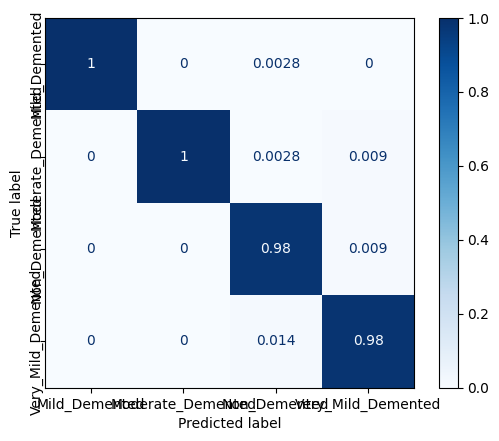

<Figure size 500x500 with 0 Axes>

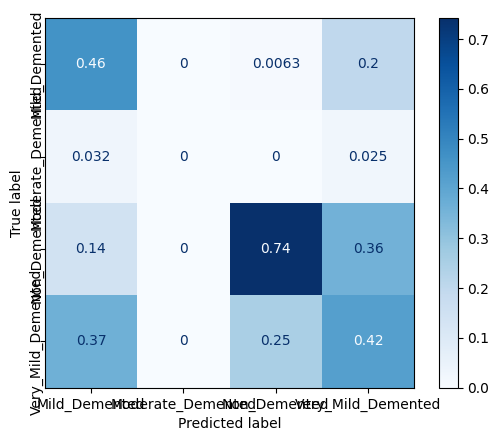

<Figure size 500x500 with 0 Axes>

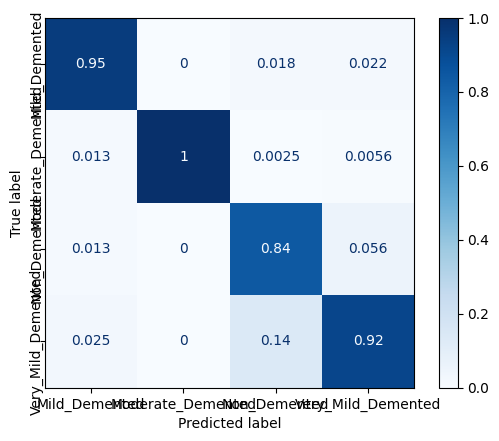

<Figure size 500x500 with 0 Axes>

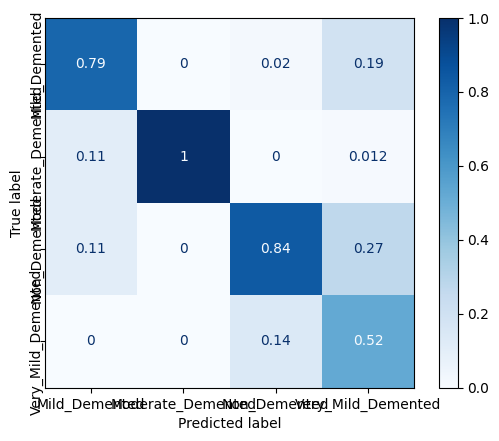

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ConvNeXtTiny.zip ./*